In [1]:
import os
import random
import time
# from dataclasses import dataclass

import gymnasium as gym
# import gym

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.categorical import Categorical

import rl_utils

from stable_baselines3.common.atari_wrappers import (  # isort:skip
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)

/public/home/liuyf7/anaconda3/envs/gym_0231/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [2]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70']

In [3]:
class Args:
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True 
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    capture_video: bool = False
    """whether to capture videos of the agent performances"""

    # Algorithm specific arguments
    env_id: str = "BreakoutNoFrameskip-v4"
    """the id of the environment"""
    total_timesteps: int = 10000000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 8
    """the number of parallel game environments"""
    num_steps: int = 128
    """the number of steps to run in each environment per policy rollout"""
    anneal_lr: bool = True
    """Toggle learning rate annealing for policy and value networks"""
    gamma: float = 0.99
    """the discount factor gamma"""
    gae_lambda: float = 0.95
    """the lambda for the general advantage estimation"""
    num_minibatches: int = 4
    """the number of mini-batches"""
    update_epochs: int = 4
    """the K epochs to update the policy"""
    norm_adv: bool = True
    """Toggles advantages normalization"""
    clip_coef: float = 0.1
    """the surrogate clipping coefficient"""
    clip_vloss: bool = True
    """Toggles whether or not to use a clipped loss for the value function, as per the paper."""
    ent_coef: float = 0.01
    """coefficient of the entropy"""
    vf_coef: float = 0.5
    """coefficient of the value function"""
    max_grad_norm: float = 0.5
    """the maximum norm for the gradient clipping"""
    target_kl: float = None
    """the target KL divergence threshold"""

    # to be filled in runtime
    batch_size: int = 0
    """the batch size (computed in runtime)"""
    minibatch_size: int = 0
    """the mini-batch size (computed in runtime)"""
    num_iterations: int = 0
    """the number of iterations (computed in runtime)"""

args = Args()

In [4]:
def make_env(env_id):
    def thunk():
        env = gym.make(env_id)

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        
        return env

    return thunk


In [5]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(4, 32, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(32, 64, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(64, 64, 3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(64 * 7 * 7, 512)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(512, envs.single_action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(512, 1), std=1)

    def get_value(self, x):
        # The range of input data is [0,255], but it should be divided by 255 to obtain the range [0,1]. 
        # It's very important , otherwise the first policy update will cause KL divergence explosion, which may be caused by the initialization method of the layers.
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        x = x / 255.0
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None):
        # The range of input data is [0,255], but it should be divided by 255 to obtain the range [0,1]. 
        # It's very important , otherwise the first policy update will cause KL divergence explosion, which may be caused by the initialization method of the layers.
        # hidden is the output of self.network(). For probs, you could use Categorical(), and input for Categorical() is the output of self.actor()
        
        ############################
        # YOUR IMPLEMENTATION HERE #
        ############################
        x = x / 255.0
        hidden = self.network(x)
        logits = self.actor(hidden)
        probs = Categorical(logits=logits)
        
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden)

In [6]:
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)
args.num_iterations = args.total_timesteps // args.batch_size

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv(
    [make_env(args.env_id) for i in range(args.num_envs)],
)


# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [7]:
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)


# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs, _ = envs.reset(seed=args.seed)
next_obs = torch.Tensor(next_obs).to(device)
next_done = torch.zeros(args.num_envs).to(device)
return_list = []

In [8]:
from tqdm import tqdm

In [9]:

for iteration in tqdm(range(1, args.num_iterations + 1)):
    # Annealing the rate
    if args.anneal_lr:
        frac = 1.0 - (iteration - 1.0) / args.num_iterations
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, terminations, truncations, infos = envs.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(next_done).to(device)

        if "final_info" in infos:
            return_load = True
            for info in infos["final_info"]:
                if info and "episode" in info:
                    if return_load:
                        return_list.append(info['episode']['r'])
                    return_load = False
                    print(f"global_step={global_step}, episodic_return={info['episode']['r']}")       


    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        lastgaelam = 0
        for t in reversed(range(args.num_steps)):
            if t == args.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                nextvalues = next_value
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                nextvalues = values[t + 1]
            delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
            advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
        returns = advantages + values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(b_obs[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)



            # Policy loss [pg_loss]
            ############################
            # YOUR IMPLEMENTATION HERE #
            ############################
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()


            # Value loss [v_loss]
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                ############################
                # YOUR IMPLEMENTATION HERE #
                ############################
                # Value loss [v_loss]
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()



            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None and approx_kl > args.target_kl:
            break


    print("SPS:", int(global_step / (time.time() - start_time)))

envs.close()


torch.save(agent.state_dict(), "ppo_Breakout.pth")


  0%|                                                                                                                                                                            | 0/9765 [00:00<?, ?it/s]

global_step=888, episodic_return=[0.]
global_step=904, episodic_return=[0.]


  0%|                                                                                                                                                                  | 1/9765 [00:02<7:07:37,  2.63s/it]

SPS: 245
global_step=1288, episodic_return=[1.]
global_step=1296, episodic_return=[1.]
global_step=1488, episodic_return=[2.]
global_step=1520, episodic_return=[2.]
global_step=1632, episodic_return=[2.]
global_step=1792, episodic_return=[0.]
global_step=1824, episodic_return=[0.]
global_step=1888, episodic_return=[3.]


  0%|                                                                                                                                                                  | 2/9765 [00:05<6:53:36,  2.54s/it]

SPS: 307
global_step=2392, episodic_return=[0.]
global_step=2520, episodic_return=[0.]
global_step=2560, episodic_return=[1.]
global_step=2584, episodic_return=[1.]
global_step=2696, episodic_return=[0.]
global_step=2712, episodic_return=[0.]
global_step=2776, episodic_return=[0.]


  0%|                                                                                                                                                                  | 3/9765 [00:07<6:38:13,  2.45s/it]

SPS: 341
global_step=3384, episodic_return=[3.]
global_step=3520, episodic_return=[1.]
global_step=3584, episodic_return=[0.]
global_step=3696, episodic_return=[0.]
global_step=3808, episodic_return=[1.]
global_step=3840, episodic_return=[1.]


  0%|                                                                                                                                                                  | 4/9765 [00:09<6:29:04,  2.39s/it]

SPS: 362
global_step=4600, episodic_return=[0.]
global_step=4648, episodic_return=[3.]
global_step=4800, episodic_return=[4.]
global_step=5072, episodic_return=[2.]


  0%|                                                                                                                                                                  | 5/9765 [00:12<6:24:58,  2.37s/it]

SPS: 375
global_step=5248, episodic_return=[2.]
global_step=5504, episodic_return=[0.]
global_step=5536, episodic_return=[3.]
global_step=5552, episodic_return=[3.]
global_step=5976, episodic_return=[0.]
global_step=6104, episodic_return=[4.]
global_step=6120, episodic_return=[0.]


  0%|                                                                                                                                                                  | 6/9765 [00:14<6:20:12,  2.34s/it]

SPS: 386
global_step=6520, episodic_return=[3.]
global_step=6696, episodic_return=[1.]
global_step=6896, episodic_return=[0.]
global_step=7008, episodic_return=[0.]
global_step=7040, episodic_return=[0.]


  0%|                                                                                                                                                                  | 7/9765 [00:16<6:20:07,  2.34s/it]

SPS: 393
global_step=7176, episodic_return=[2.]
global_step=7392, episodic_return=[3.]
global_step=7440, episodic_return=[0.]
global_step=7728, episodic_return=[6.]
global_step=7928, episodic_return=[0.]
global_step=7984, episodic_return=[1.]


  0%|▏                                                                                                                                                                 | 8/9765 [00:19<6:37:48,  2.45s/it]

SPS: 391
global_step=8400, episodic_return=[2.]
global_step=8704, episodic_return=[2.]
global_step=8848, episodic_return=[0.]
global_step=8888, episodic_return=[0.]
global_step=9072, episodic_return=[2.]


  0%|▏                                                                                                                                                                 | 9/9765 [00:21<6:37:47,  2.45s/it]

SPS: 394
global_step=9304, episodic_return=[0.]
global_step=9632, episodic_return=[3.]
global_step=9640, episodic_return=[4.]
global_step=9792, episodic_return=[0.]
global_step=9992, episodic_return=[0.]


  0%|▏                                                                                                                                                                | 10/9765 [00:24<6:44:19,  2.49s/it]

global_step=10224, episodic_return=[0.]
SPS: 394
global_step=10512, episodic_return=[0.]
global_step=10552, episodic_return=[0.]
global_step=10936, episodic_return=[10.]


  0%|▏                                                                                                                                                                | 11/9765 [00:26<6:43:05,  2.48s/it]

global_step=11264, episodic_return=[2.]
SPS: 396
global_step=11392, episodic_return=[5.]
global_step=11440, episodic_return=[0.]
global_step=11496, episodic_return=[2.]
global_step=11536, episodic_return=[5.]
global_step=11912, episodic_return=[2.]


  0%|▏                                                                                                                                                                | 12/9765 [00:29<6:34:00,  2.42s/it]

SPS: 400
global_step=12360, episodic_return=[0.]
global_step=12416, episodic_return=[0.]
global_step=12552, episodic_return=[1.]
global_step=12792, episodic_return=[4.]
global_step=13040, episodic_return=[2.]
global_step=13280, episodic_return=[0.]
global_step=13288, episodic_return=[0.]


  0%|▏                                                                                                                                                                | 13/9765 [00:31<6:27:24,  2.38s/it]

SPS: 403
global_step=13544, episodic_return=[4.]
global_step=13624, episodic_return=[5.]
global_step=14040, episodic_return=[2.]
global_step=14176, episodic_return=[0.]
global_step=14200, episodic_return=[0.]


  0%|▏                                                                                                                                                                | 14/9765 [00:33<6:22:12,  2.35s/it]

SPS: 406
global_step=14448, episodic_return=[0.]
global_step=14528, episodic_return=[2.]
global_step=15096, episodic_return=[0.]
global_step=15104, episodic_return=[0.]
global_step=15112, episodic_return=[2.]
global_step=15264, episodic_return=[10.]


  0%|▏                                                                                                                                                                | 15/9765 [00:36<6:18:46,  2.33s/it]

SPS: 409
global_step=15432, episodic_return=[0.]
global_step=15688, episodic_return=[8.]
global_step=15920, episodic_return=[2.]
global_step=16024, episodic_return=[0.]
global_step=16184, episodic_return=[0.]
global_step=16336, episodic_return=[0.]


  0%|▎                                                                                                                                                                | 16/9765 [00:38<6:20:48,  2.34s/it]

SPS: 410
global_step=16552, episodic_return=[5.]
global_step=16600, episodic_return=[2.]
global_step=16608, episodic_return=[0.]
global_step=16840, episodic_return=[0.]
global_step=16944, episodic_return=[0.]
global_step=17104, episodic_return=[0.]


  0%|▎                                                                                                                                                                | 17/9765 [00:40<6:19:51,  2.34s/it]

global_step=17408, episodic_return=[4.]
SPS: 412
global_step=17496, episodic_return=[0.]
global_step=17760, episodic_return=[0.]
global_step=17808, episodic_return=[2.]
global_step=17864, episodic_return=[0.]
global_step=17888, episodic_return=[1.]
global_step=18024, episodic_return=[0.]
global_step=18024, episodic_return=[2.]


  0%|▎                                                                                                                                                                | 18/9765 [00:43<6:21:32,  2.35s/it]

SPS: 413
global_step=18664, episodic_return=[0.]
global_step=18768, episodic_return=[0.]
global_step=18928, episodic_return=[0.]
global_step=18928, episodic_return=[0.]
global_step=19144, episodic_return=[2.]
global_step=19312, episodic_return=[2.]


  0%|▎                                                                                                                                                                | 19/9765 [00:45<6:18:29,  2.33s/it]

SPS: 414
global_step=19552, episodic_return=[0.]
global_step=19688, episodic_return=[0.]
global_step=19832, episodic_return=[0.]
global_step=19832, episodic_return=[0.]
global_step=20048, episodic_return=[0.]
global_step=20216, episodic_return=[0.]


  0%|▎                                                                                                                                                                | 20/9765 [00:47<6:20:04,  2.34s/it]

global_step=20472, episodic_return=[0.]
SPS: 415
global_step=20512, episodic_return=[9.]
global_step=20592, episodic_return=[0.]
global_step=20752, episodic_return=[0.]
global_step=21008, episodic_return=[9.]
global_step=21136, episodic_return=[0.]
global_step=21360, episodic_return=[0.]


  0%|▎                                                                                                                                                                | 21/9765 [00:50<6:16:57,  2.32s/it]

SPS: 417
global_step=22224, episodic_return=[2.]
global_step=22312, episodic_return=[4.]


  0%|▎                                                                                                                                                                | 22/9765 [00:52<6:11:49,  2.29s/it]

global_step=22512, episodic_return=[2.]
SPS: 418
global_step=22640, episodic_return=[2.]
global_step=22936, episodic_return=[4.]
global_step=22952, episodic_return=[9.]
global_step=23144, episodic_return=[0.]
global_step=23280, episodic_return=[5.]


  0%|▍                                                                                                                                                                | 23/9765 [00:54<6:13:53,  2.30s/it]

global_step=23544, episodic_return=[0.]
SPS: 419
global_step=23816, episodic_return=[2.]
global_step=23840, episodic_return=[0.]
global_step=24168, episodic_return=[0.]
global_step=24424, episodic_return=[2.]
global_step=24480, episodic_return=[9.]


  0%|▍                                                                                                                                                                | 24/9765 [00:56<6:11:47,  2.29s/it]

SPS: 421
global_step=24736, episodic_return=[0.]
global_step=24760, episodic_return=[0.]
global_step=25032, episodic_return=[2.]
global_step=25088, episodic_return=[0.]
global_step=25312, episodic_return=[0.]
global_step=25384, episodic_return=[0.]


  0%|▍                                                                                                                                                                | 25/9765 [00:59<6:22:01,  2.35s/it]

SPS: 420
global_step=25632, episodic_return=[9.]
global_step=25664, episodic_return=[0.]
global_step=25936, episodic_return=[0.]
global_step=26216, episodic_return=[0.]
global_step=26304, episodic_return=[0.]


  0%|▍                                                                                                                                                                | 26/9765 [01:01<6:17:32,  2.33s/it]

SPS: 421
global_step=26904, episodic_return=[11.]
global_step=27000, episodic_return=[4.]
global_step=27136, episodic_return=[0.]
global_step=27208, episodic_return=[0.]


  0%|▍                                                                                                                                                                | 27/9765 [01:04<6:24:18,  2.37s/it]

SPS: 421
global_step=27824, episodic_return=[0.]
global_step=27888, episodic_return=[0.]
global_step=28040, episodic_return=[0.]
global_step=28208, episodic_return=[9.]
global_step=28352, episodic_return=[5.]
global_step=28520, episodic_return=[8.]


  0%|▍                                                                                                                                                                | 28/9765 [01:06<6:17:51,  2.33s/it]

SPS: 422
global_step=29056, episodic_return=[9.]
global_step=29392, episodic_return=[2.]
global_step=29424, episodic_return=[0.]


  0%|▍                                                                                                                                                                | 29/9765 [01:08<6:15:02,  2.31s/it]

SPS: 423
global_step=29712, episodic_return=[2.]
global_step=30136, episodic_return=[6.]
global_step=30280, episodic_return=[4.]
global_step=30344, episodic_return=[0.]
global_step=30544, episodic_return=[2.]
global_step=30616, episodic_return=[0.]


  0%|▍                                                                                                                                                                | 30/9765 [01:11<6:59:27,  2.59s/it]

SPS: 418
global_step=31384, episodic_return=[10.]
global_step=31464, episodic_return=[0.]
global_step=31688, episodic_return=[7.]


  0%|▌                                                                                                                                                                | 31/9765 [01:14<7:11:17,  2.66s/it]

SPS: 416
global_step=31832, episodic_return=[2.]
global_step=32080, episodic_return=[5.]
global_step=32120, episodic_return=[2.]
global_step=32152, episodic_return=[3.]
global_step=32384, episodic_return=[0.]
global_step=32608, episodic_return=[0.]
global_step=32736, episodic_return=[0.]


  0%|▌                                                                                                                                                                | 32/9765 [01:17<7:15:46,  2.69s/it]

SPS: 415
global_step=32888, episodic_return=[2.]
global_step=33056, episodic_return=[0.]
global_step=33256, episodic_return=[9.]
global_step=33304, episodic_return=[0.]
global_step=33360, episodic_return=[1.]
global_step=33496, episodic_return=[0.]
global_step=33624, episodic_return=[0.]


  0%|▌                                                                                                                                                                | 33/9765 [01:20<7:17:00,  2.69s/it]

SPS: 414
global_step=33960, episodic_return=[0.]
global_step=34160, episodic_return=[0.]
global_step=34224, episodic_return=[0.]
global_step=34248, episodic_return=[0.]
global_step=34624, episodic_return=[1.]


  0%|▌                                                                                                                                                                | 34/9765 [01:22<7:23:32,  2.73s/it]

global_step=34808, episodic_return=[5.]
SPS: 412
global_step=35152, episodic_return=[0.]
global_step=35464, episodic_return=[2.]
global_step=35528, episodic_return=[0.]
global_step=35632, episodic_return=[2.]
global_step=35728, episodic_return=[2.]


  0%|▌                                                                                                                                                                | 35/9765 [01:25<7:10:25,  2.65s/it]

SPS: 412
global_step=36072, episodic_return=[0.]
global_step=36312, episodic_return=[2.]
global_step=36368, episodic_return=[0.]
global_step=36448, episodic_return=[13.]
global_step=36648, episodic_return=[0.]
global_step=36744, episodic_return=[9.]


  0%|▌                                                                                                                                                                | 36/9765 [01:27<6:59:32,  2.59s/it]

SPS: 412
global_step=37032, episodic_return=[2.]
global_step=37544, episodic_return=[2.]


  0%|▌                                                                                                                                                                | 37/9765 [01:30<6:42:44,  2.48s/it]

SPS: 413
global_step=37936, episodic_return=[0.]
global_step=37952, episodic_return=[2.]
global_step=38248, episodic_return=[2.]
global_step=38696, episodic_return=[6.]
global_step=38872, episodic_return=[0.]


  0%|▋                                                                                                                                                                | 38/9765 [01:32<6:32:21,  2.42s/it]

SPS: 414
global_step=38984, episodic_return=[5.]
global_step=39016, episodic_return=[2.]
global_step=39136, episodic_return=[0.]
global_step=39352, episodic_return=[5.]
global_step=39584, episodic_return=[0.]
global_step=39792, episodic_return=[0.]
global_step=39888, episodic_return=[0.]
global_step=39920, episodic_return=[0.]
global_step=39936, episodic_return=[13.]


  0%|▋                                                                                                                                                                | 39/9765 [01:34<6:29:48,  2.40s/it]

SPS: 415
global_step=39992, episodic_return=[3.]
global_step=40056, episodic_return=[0.]
global_step=40504, episodic_return=[0.]
global_step=40792, episodic_return=[0.]
global_step=40840, episodic_return=[2.]
global_step=40880, episodic_return=[0.]


  0%|▋                                                                                                                                                                | 40/9765 [01:37<6:28:03,  2.39s/it]

SPS: 415
global_step=41696, episodic_return=[0.]
global_step=41744, episodic_return=[0.]
global_step=41792, episodic_return=[3.]
global_step=41928, episodic_return=[3.]


  0%|▋                                                                                                                                                                | 41/9765 [01:39<6:28:48,  2.40s/it]

SPS: 415
global_step=42008, episodic_return=[2.]
global_step=42384, episodic_return=[2.]
global_step=42480, episodic_return=[5.]
global_step=42600, episodic_return=[0.]
global_step=42664, episodic_return=[0.]
global_step=42832, episodic_return=[0.]


  0%|▋                                                                                                                                                                | 42/9765 [01:42<6:50:59,  2.54s/it]

SPS: 414
global_step=43056, episodic_return=[9.]
global_step=43288, episodic_return=[0.]
global_step=43320, episodic_return=[2.]
global_step=43400, episodic_return=[0.]
global_step=43504, episodic_return=[0.]
global_step=43512, episodic_return=[2.]
global_step=43736, episodic_return=[0.]
global_step=43952, episodic_return=[1.]


  0%|▋                                                                                                                                                                | 43/9765 [01:44<6:41:28,  2.48s/it]

SPS: 414
global_step=44208, episodic_return=[0.]
global_step=44240, episodic_return=[0.]
global_step=44408, episodic_return=[0.]
global_step=44432, episodic_return=[0.]
global_step=44856, episodic_return=[0.]
global_step=44928, episodic_return=[3.]


  0%|▋                                                                                                                                                                | 44/9765 [01:47<6:35:07,  2.44s/it]

SPS: 415
global_step=45112, episodic_return=[0.]
global_step=45160, episodic_return=[0.]
global_step=45312, episodic_return=[0.]
global_step=45760, episodic_return=[0.]
global_step=45848, episodic_return=[0.]
global_step=45936, episodic_return=[2.]
global_step=46032, episodic_return=[0.]


  0%|▋                                                                                                                                                                | 45/9765 [01:49<6:29:29,  2.40s/it]

SPS: 415
global_step=46088, episodic_return=[5.]
global_step=46232, episodic_return=[0.]
global_step=46768, episodic_return=[0.]
global_step=46832, episodic_return=[9.]
global_step=46880, episodic_return=[1.]


  0%|▊                                                                                                                                                                | 46/9765 [01:51<6:24:03,  2.37s/it]

SPS: 416
global_step=47136, episodic_return=[0.]
global_step=47440, episodic_return=[2.]
global_step=47672, episodic_return=[0.]
global_step=47864, episodic_return=[5.]
global_step=48056, episodic_return=[0.]


  0%|▊                                                                                                                                                                | 47/9765 [01:53<6:19:09,  2.34s/it]

SPS: 416
global_step=48296, episodic_return=[4.]
global_step=48344, episodic_return=[0.]
global_step=48560, episodic_return=[0.]
global_step=48776, episodic_return=[5.]
global_step=48784, episodic_return=[0.]


  0%|▊                                                                                                                                                                | 48/9765 [01:56<6:15:26,  2.32s/it]

SPS: 417
global_step=49160, episodic_return=[4.]
global_step=49216, episodic_return=[0.]
global_step=49352, episodic_return=[1.]
global_step=49488, episodic_return=[1.]
global_step=49696, episodic_return=[0.]
global_step=49848, episodic_return=[1.]
global_step=50080, episodic_return=[0.]
global_step=50160, episodic_return=[10.]


  1%|▊                                                                                                                                                                | 49/9765 [01:58<6:17:08,  2.33s/it]

SPS: 417
global_step=50256, episodic_return=[0.]
global_step=50320, episodic_return=[2.]
global_step=50344, episodic_return=[1.]
global_step=50600, episodic_return=[0.]
global_step=50616, episodic_return=[1.]
global_step=50752, episodic_return=[0.]
global_step=51144, episodic_return=[0.]


  1%|▊                                                                                                                                                                | 50/9765 [02:00<6:15:23,  2.32s/it]

SPS: 418
global_step=51240, episodic_return=[0.]
global_step=51672, episodic_return=[0.]
global_step=51904, episodic_return=[1.]
global_step=51912, episodic_return=[1.]
global_step=52056, episodic_return=[3.]
global_step=52064, episodic_return=[0.]


  1%|▊                                                                                                                                                                | 51/9765 [02:03<6:18:01,  2.33s/it]

SPS: 418
global_step=52608, episodic_return=[4.]
global_step=52792, episodic_return=[0.]
global_step=52960, episodic_return=[1.]
global_step=52968, episodic_return=[3.]


  1%|▊                                                                                                                                                                | 52/9765 [02:05<6:15:29,  2.32s/it]

SPS: 419
global_step=53336, episodic_return=[1.]
global_step=53376, episodic_return=[1.]
global_step=53728, episodic_return=[11.]
global_step=53888, episodic_return=[0.]
global_step=53920, episodic_return=[1.]
global_step=54240, episodic_return=[0.]
global_step=54256, episodic_return=[2.]


  1%|▊                                                                                                                                                                | 53/9765 [02:07<6:15:13,  2.32s/it]

SPS: 419
global_step=55128, episodic_return=[0.]
global_step=55264, episodic_return=[10.]


  1%|▉                                                                                                                                                                | 54/9765 [02:09<6:10:01,  2.29s/it]

SPS: 420
global_step=55792, episodic_return=[2.]
global_step=55872, episodic_return=[4.]
global_step=55880, episodic_return=[5.]
global_step=55936, episodic_return=[3.]
global_step=56024, episodic_return=[6.]
global_step=56168, episodic_return=[0.]


  1%|▉                                                                                                                                                                | 55/9765 [02:12<6:09:27,  2.28s/it]

SPS: 420
global_step=56608, episodic_return=[8.]
global_step=56632, episodic_return=[2.]
global_step=56696, episodic_return=[0.]
global_step=56800, episodic_return=[0.]
global_step=57048, episodic_return=[1.]


  1%|▉                                                                                                                                                                | 56/9765 [02:15<6:38:42,  2.46s/it]

global_step=57344, episodic_return=[2.]
SPS: 419
global_step=57552, episodic_return=[0.]
global_step=57584, episodic_return=[0.]
global_step=57752, episodic_return=[1.]
global_step=57952, episodic_return=[0.]
global_step=58272, episodic_return=[4.]


  1%|▉                                                                                                                                                                | 57/9765 [02:17<6:48:59,  2.53s/it]

SPS: 418
global_step=58496, episodic_return=[3.]
global_step=58672, episodic_return=[0.]
global_step=58712, episodic_return=[5.]
global_step=59032, episodic_return=[2.]


  1%|▉                                                                                                                                                                | 58/9765 [02:20<6:34:14,  2.44s/it]

SPS: 419
global_step=59616, episodic_return=[2.]
global_step=59720, episodic_return=[4.]
global_step=59776, episodic_return=[1.]
global_step=59960, episodic_return=[1.]
global_step=59992, episodic_return=[4.]


  1%|▉                                                                                                                                                                | 59/9765 [02:22<6:35:31,  2.44s/it]

SPS: 419
global_step=60696, episodic_return=[0.]
global_step=60744, episodic_return=[1.]
global_step=61088, episodic_return=[1.]
global_step=61168, episodic_return=[4.]
global_step=61208, episodic_return=[2.]
global_step=61264, episodic_return=[1.]
global_step=61328, episodic_return=[6.]


  1%|▉                                                                                                                                                                | 60/9765 [02:24<6:30:20,  2.41s/it]

SPS: 419
global_step=61720, episodic_return=[5.]
global_step=62072, episodic_return=[0.]


  1%|█                                                                                                                                                                | 61/9765 [02:27<6:21:25,  2.36s/it]

SPS: 420
global_step=62592, episodic_return=[2.]
global_step=62832, episodic_return=[2.]
global_step=62856, episodic_return=[4.]
global_step=62928, episodic_return=[2.]


  1%|█                                                                                                                                                                | 62/9765 [02:29<6:19:18,  2.35s/it]

SPS: 420
global_step=63496, episodic_return=[0.]
global_step=63616, episodic_return=[3.]
global_step=63752, episodic_return=[0.]
global_step=63832, episodic_return=[3.]
global_step=63848, episodic_return=[0.]
global_step=63912, episodic_return=[5.]
global_step=64184, episodic_return=[10.]


  1%|█                                                                                                                                                                | 63/9765 [02:31<6:16:27,  2.33s/it]

SPS: 420
global_step=64736, episodic_return=[0.]
global_step=64880, episodic_return=[1.]
global_step=64992, episodic_return=[2.]


  1%|█                                                                                                                                                                | 64/9765 [02:33<6:14:43,  2.32s/it]

SPS: 421
global_step=65568, episodic_return=[2.]
global_step=65864, episodic_return=[1.]
global_step=65952, episodic_return=[9.]
global_step=66008, episodic_return=[1.]
global_step=66136, episodic_return=[1.]
global_step=66304, episodic_return=[5.]


  1%|█                                                                                                                                                                | 65/9765 [02:36<6:13:58,  2.31s/it]

SPS: 421
global_step=66600, episodic_return=[5.]
global_step=66696, episodic_return=[1.]
global_step=66896, episodic_return=[0.]
global_step=66968, episodic_return=[9.]
global_step=67056, episodic_return=[0.]
global_step=67448, episodic_return=[1.]


  1%|█                                                                                                                                                                | 66/9765 [02:38<6:10:27,  2.29s/it]

SPS: 422
global_step=67600, episodic_return=[0.]
global_step=68248, episodic_return=[5.]


  1%|█                                                                                                                                                                | 67/9765 [02:40<6:14:03,  2.31s/it]

SPS: 422
global_step=68816, episodic_return=[5.]
global_step=68888, episodic_return=[4.]
global_step=68944, episodic_return=[2.]
global_step=69088, episodic_return=[2.]
global_step=69160, episodic_return=[4.]
global_step=69464, episodic_return=[8.]


  1%|█                                                                                                                                                                | 68/9765 [02:43<6:11:56,  2.30s/it]

SPS: 422
global_step=69992, episodic_return=[0.]
global_step=70152, episodic_return=[3.]
global_step=70464, episodic_return=[2.]


  1%|█▏                                                                                                                                                               | 69/9765 [02:45<6:12:52,  2.31s/it]

global_step=70656, episodic_return=[4.]
SPS: 423
global_step=70744, episodic_return=[14.]
global_step=70952, episodic_return=[3.]
global_step=71176, episodic_return=[4.]
global_step=71256, episodic_return=[1.]
global_step=71280, episodic_return=[1.]
global_step=71496, episodic_return=[4.]


  1%|█▏                                                                                                                                                               | 70/9765 [02:47<6:11:27,  2.30s/it]

SPS: 423
global_step=71840, episodic_return=[0.]
global_step=72064, episodic_return=[0.]
global_step=72424, episodic_return=[1.]


  1%|█▏                                                                                                                                                               | 71/9765 [02:49<6:07:11,  2.27s/it]

SPS: 423
global_step=73000, episodic_return=[6.]
global_step=73184, episodic_return=[4.]
global_step=73208, episodic_return=[1.]
global_step=73672, episodic_return=[4.]


  1%|█▏                                                                                                                                                               | 72/9765 [02:52<6:15:55,  2.33s/it]

SPS: 423
global_step=73896, episodic_return=[2.]
global_step=74000, episodic_return=[6.]
global_step=74152, episodic_return=[10.]
global_step=74376, episodic_return=[9.]


  1%|█▏                                                                                                                                                               | 73/9765 [02:54<6:12:00,  2.30s/it]

SPS: 424
global_step=74768, episodic_return=[3.]
global_step=74920, episodic_return=[0.]
global_step=75024, episodic_return=[1.]
global_step=75720, episodic_return=[5.]


  1%|█▏                                                                                                                                                               | 74/9765 [02:56<6:11:16,  2.30s/it]

SPS: 424
global_step=75880, episodic_return=[5.]
global_step=76008, episodic_return=[3.]
global_step=76296, episodic_return=[1.]
global_step=76360, episodic_return=[8.]
global_step=76560, episodic_return=[4.]


  1%|█▏                                                                                                                                                               | 75/9765 [02:59<6:08:31,  2.28s/it]

SPS: 424
global_step=77280, episodic_return=[5.]
global_step=77480, episodic_return=[1.]
global_step=77584, episodic_return=[1.]


  1%|█▎                                                                                                                                                               | 76/9765 [03:01<6:04:54,  2.26s/it]

SPS: 425
global_step=78376, episodic_return=[9.]
global_step=78640, episodic_return=[11.]


  1%|█▎                                                                                                                                                               | 77/9765 [03:03<6:03:26,  2.25s/it]

SPS: 425
global_step=79240, episodic_return=[8.]
global_step=79280, episodic_return=[0.]
global_step=79584, episodic_return=[4.]
global_step=79840, episodic_return=[10.]


  1%|█▎                                                                                                                                                               | 78/9765 [03:05<6:04:10,  2.26s/it]

SPS: 426
global_step=80368, episodic_return=[1.]
global_step=80424, episodic_return=[1.]
global_step=80600, episodic_return=[9.]
global_step=80720, episodic_return=[7.]


  1%|█▎                                                                                                                                                               | 79/9765 [03:08<6:28:25,  2.41s/it]

SPS: 425
global_step=81192, episodic_return=[2.]
global_step=81280, episodic_return=[18.]
global_step=81496, episodic_return=[7.]
global_step=81656, episodic_return=[1.]


  1%|█▎                                                                                                                                                               | 80/9765 [03:10<6:21:29,  2.36s/it]

SPS: 425
global_step=82256, episodic_return=[2.]
global_step=82296, episodic_return=[3.]
global_step=82800, episodic_return=[1.]


  1%|█▎                                                                                                                                                               | 81/9765 [03:13<6:19:38,  2.35s/it]

SPS: 425
global_step=83784, episodic_return=[8.]


  1%|█▎                                                                                                                                                               | 82/9765 [03:15<6:27:05,  2.40s/it]

SPS: 425
global_step=84072, episodic_return=[16.]
global_step=84400, episodic_return=[9.]
global_step=84424, episodic_return=[6.]
global_step=84472, episodic_return=[9.]


  1%|█▎                                                                                                                                                               | 83/9765 [03:18<6:20:32,  2.36s/it]

SPS: 425
global_step=85352, episodic_return=[11.]
global_step=85520, episodic_return=[14.]
global_step=85880, episodic_return=[11.]
global_step=85936, episodic_return=[2.]


  1%|█▍                                                                                                                                                               | 84/9765 [03:20<6:21:07,  2.36s/it]

SPS: 425
global_step=86040, episodic_return=[4.]
global_step=86440, episodic_return=[0.]


  1%|█▍                                                                                                                                                               | 85/9765 [03:22<6:29:15,  2.41s/it]

SPS: 425
global_step=87352, episodic_return=[1.]
global_step=87400, episodic_return=[2.]
global_step=87440, episodic_return=[3.]
global_step=87648, episodic_return=[9.]


  1%|█▍                                                                                                                                                               | 86/9765 [03:25<6:21:34,  2.37s/it]

SPS: 425
global_step=88104, episodic_return=[2.]
global_step=88136, episodic_return=[11.]
global_step=88512, episodic_return=[16.]


  1%|█▍                                                                                                                                                               | 87/9765 [03:27<6:14:27,  2.32s/it]

SPS: 426
global_step=89736, episodic_return=[3.]


  1%|█▍                                                                                                                                                               | 88/9765 [03:29<6:17:44,  2.34s/it]

SPS: 426
global_step=90192, episodic_return=[13.]
global_step=90688, episodic_return=[7.]
global_step=90816, episodic_return=[4.]


  1%|█▍                                                                                                                                                               | 89/9765 [03:32<6:14:14,  2.32s/it]

global_step=91136, episodic_return=[10.]
SPS: 426
global_step=91472, episodic_return=[3.]
global_step=91736, episodic_return=[0.]
global_step=91752, episodic_return=[16.]
global_step=91840, episodic_return=[13.]


  1%|█▍                                                                                                                                                               | 90/9765 [03:34<6:14:58,  2.33s/it]

SPS: 426
global_step=92256, episodic_return=[12.]
global_step=92448, episodic_return=[1.]
global_step=92672, episodic_return=[0.]
global_step=92760, episodic_return=[0.]
global_step=92984, episodic_return=[2.]
global_step=93112, episodic_return=[6.]


  1%|█▌                                                                                                                                                               | 91/9765 [03:36<6:14:54,  2.33s/it]

SPS: 426
global_step=93576, episodic_return=[1.]
global_step=93608, episodic_return=[2.]
global_step=94032, episodic_return=[0.]
global_step=94032, episodic_return=[2.]


  1%|█▌                                                                                                                                                               | 92/9765 [03:38<6:11:47,  2.31s/it]

SPS: 427
global_step=94296, episodic_return=[2.]
global_step=94352, episodic_return=[11.]
global_step=94392, episodic_return=[2.]
global_step=94400, episodic_return=[9.]
global_step=95160, episodic_return=[1.]


  1%|█▌                                                                                                                                                               | 93/9765 [03:41<6:09:58,  2.30s/it]

SPS: 427
global_step=95384, episodic_return=[2.]
global_step=95480, episodic_return=[1.]
global_step=95624, episodic_return=[4.]
global_step=95848, episodic_return=[2.]


  1%|█▌                                                                                                                                                               | 94/9765 [03:44<6:32:16,  2.43s/it]

SPS: 426
global_step=96288, episodic_return=[1.]
global_step=96368, episodic_return=[4.]
global_step=96840, episodic_return=[2.]


  1%|█▌                                                                                                                                                               | 95/9765 [03:46<6:20:30,  2.36s/it]

global_step=97272, episodic_return=[7.]
SPS: 427
global_step=97496, episodic_return=[7.]
global_step=97648, episodic_return=[12.]
global_step=97664, episodic_return=[19.]
global_step=97720, episodic_return=[7.]
global_step=98144, episodic_return=[1.]


  1%|█▌                                                                                                                                                               | 96/9765 [03:48<6:13:02,  2.31s/it]

SPS: 427
global_step=98632, episodic_return=[8.]
global_step=99152, episodic_return=[2.]
global_step=99240, episodic_return=[2.]


  1%|█▌                                                                                                                                                               | 97/9765 [03:50<6:12:17,  2.31s/it]

SPS: 427
global_step=99952, episodic_return=[11.]
global_step=100248, episodic_return=[5.]


  1%|█▌                                                                                                                                                               | 98/9765 [03:52<6:05:59,  2.27s/it]

SPS: 428
global_step=100856, episodic_return=[6.]
global_step=101312, episodic_return=[4.]
global_step=101328, episodic_return=[13.]


  1%|█▋                                                                                                                                                               | 99/9765 [03:55<6:05:33,  2.27s/it]

SPS: 428
global_step=101816, episodic_return=[14.]
global_step=102128, episodic_return=[6.]


  1%|█▋                                                                                                                                                              | 100/9765 [03:57<6:01:47,  2.25s/it]

SPS: 428
global_step=102856, episodic_return=[2.]
global_step=103128, episodic_return=[17.]
global_step=103160, episodic_return=[2.]


  1%|█▋                                                                                                                                                              | 101/9765 [03:59<6:02:22,  2.25s/it]

SPS: 428
global_step=103776, episodic_return=[12.]
global_step=103816, episodic_return=[2.]
global_step=104368, episodic_return=[15.]


  1%|█▋                                                                                                                                                              | 102/9765 [04:01<6:00:07,  2.24s/it]

SPS: 429
global_step=104768, episodic_return=[17.]
global_step=104800, episodic_return=[13.]
global_step=104928, episodic_return=[1.]


  1%|█▋                                                                                                                                                              | 103/9765 [04:04<6:02:44,  2.25s/it]

SPS: 429
global_step=105672, episodic_return=[9.]
global_step=105736, episodic_return=[2.]


  1%|█▋                                                                                                                                                              | 104/9765 [04:06<6:03:25,  2.26s/it]

SPS: 429
global_step=106944, episodic_return=[14.]
global_step=107024, episodic_return=[2.]


  1%|█▋                                                                                                                                                              | 105/9765 [04:08<6:10:27,  2.30s/it]

SPS: 429
global_step=107648, episodic_return=[16.]
global_step=107688, episodic_return=[6.]
global_step=107872, episodic_return=[10.]
global_step=108392, episodic_return=[5.]


  1%|█▋                                                                                                                                                              | 106/9765 [04:11<6:22:41,  2.38s/it]

SPS: 429
global_step=108832, episodic_return=[1.]
global_step=108960, episodic_return=[12.]
global_step=108984, episodic_return=[13.]
global_step=109208, episodic_return=[8.]


  1%|█▊                                                                                                                                                              | 107/9765 [04:13<6:15:12,  2.33s/it]

SPS: 429
global_step=109968, episodic_return=[7.]
global_step=110304, episodic_return=[9.]
global_step=110544, episodic_return=[3.]


  1%|█▊                                                                                                                                                              | 108/9765 [04:15<6:09:29,  2.30s/it]

SPS: 429
global_step=110728, episodic_return=[3.]
global_step=110928, episodic_return=[5.]
global_step=111296, episodic_return=[3.]


  1%|█▊                                                                                                                                                              | 109/9765 [04:17<6:03:08,  2.26s/it]

SPS: 430
global_step=111736, episodic_return=[12.]
global_step=112192, episodic_return=[5.]


  1%|█▊                                                                                                                                                              | 110/9765 [04:20<6:09:16,  2.29s/it]

SPS: 430
global_step=113240, episodic_return=[4.]
global_step=113480, episodic_return=[21.]
global_step=113480, episodic_return=[7.]


  1%|█▊                                                                                                                                                              | 111/9765 [04:22<6:19:27,  2.36s/it]

SPS: 429
global_step=113680, episodic_return=[10.]
global_step=114096, episodic_return=[10.]


  1%|█▊                                                                                                                                                              | 112/9765 [04:25<6:24:59,  2.39s/it]

SPS: 429
global_step=114960, episodic_return=[11.]
global_step=115016, episodic_return=[2.]
global_step=115056, episodic_return=[2.]
global_step=115424, episodic_return=[10.]


  1%|█▊                                                                                                                                                              | 113/9765 [04:27<6:18:19,  2.35s/it]

SPS: 429
global_step=115752, episodic_return=[12.]


  1%|█▊                                                                                                                                                              | 114/9765 [04:29<6:12:03,  2.31s/it]

global_step=116720, episodic_return=[1.]
global_step=116720, episodic_return=[2.]
SPS: 430
global_step=116864, episodic_return=[10.]
global_step=117320, episodic_return=[9.]
global_step=117672, episodic_return=[5.]
global_step=117760, episodic_return=[11.]


  1%|█▉                                                                                                                                                              | 115/9765 [04:32<6:08:09,  2.29s/it]

SPS: 430
global_step=117768, episodic_return=[0.]
global_step=118008, episodic_return=[1.]
global_step=118456, episodic_return=[10.]


  1%|█▉                                                                                                                                                              | 116/9765 [04:34<6:04:01,  2.26s/it]

SPS: 430
global_step=118848, episodic_return=[2.]
global_step=119024, episodic_return=[2.]
global_step=119208, episodic_return=[7.]
global_step=119656, episodic_return=[3.]


  1%|█▉                                                                                                                                                              | 117/9765 [04:36<6:01:59,  2.25s/it]

SPS: 430
global_step=120216, episodic_return=[12.]
global_step=120632, episodic_return=[10.]


  1%|█▉                                                                                                                                                              | 118/9765 [04:38<6:00:08,  2.24s/it]

SPS: 431
global_step=121000, episodic_return=[3.]
global_step=121672, episodic_return=[11.]


  1%|█▉                                                                                                                                                              | 119/9765 [04:40<5:57:08,  2.22s/it]

SPS: 431
global_step=122120, episodic_return=[11.]
global_step=122352, episodic_return=[2.]
global_step=122512, episodic_return=[11.]


  1%|█▉                                                                                                                                                              | 120/9765 [04:43<5:56:46,  2.22s/it]

SPS: 431
global_step=123192, episodic_return=[15.]
global_step=123272, episodic_return=[0.]
global_step=123480, episodic_return=[13.]
global_step=123496, episodic_return=[15.]
global_step=123752, episodic_return=[12.]


  1%|█▉                                                                                                                                                              | 121/9765 [04:45<5:58:24,  2.23s/it]

SPS: 431
global_step=124112, episodic_return=[0.]
global_step=124640, episodic_return=[4.]


  1%|█▉                                                                                                                                                              | 122/9765 [04:47<5:55:35,  2.21s/it]

SPS: 432
global_step=125008, episodic_return=[10.]
global_step=125016, episodic_return=[3.]
global_step=125648, episodic_return=[4.]


  1%|██                                                                                                                                                              | 123/9765 [04:49<5:56:02,  2.22s/it]

SPS: 432


  1%|██                                                                                                                                                              | 124/9765 [04:51<5:55:01,  2.21s/it]

SPS: 432
global_step=127000, episodic_return=[14.]
global_step=127016, episodic_return=[18.]
global_step=127120, episodic_return=[4.]
global_step=127192, episodic_return=[6.]
global_step=127216, episodic_return=[14.]
global_step=127464, episodic_return=[12.]


  1%|██                                                                                                                                                              | 125/9765 [04:54<5:57:55,  2.23s/it]

SPS: 432
global_step=128496, episodic_return=[7.]
global_step=128552, episodic_return=[10.]
global_step=128888, episodic_return=[4.]


  1%|██                                                                                                                                                              | 126/9765 [04:56<5:57:58,  2.23s/it]

SPS: 433
global_step=129096, episodic_return=[3.]
global_step=129120, episodic_return=[3.]


  1%|██                                                                                                                                                              | 127/9765 [04:58<5:54:38,  2.21s/it]

SPS: 433
global_step=131000, episodic_return=[12.]
global_step=131048, episodic_return=[12.]


  1%|██                                                                                                                                                              | 128/9765 [05:00<5:54:37,  2.21s/it]

SPS: 433
global_step=131344, episodic_return=[13.]
global_step=131360, episodic_return=[13.]
global_step=131952, episodic_return=[14.]


  1%|██                                                                                                                                                              | 129/9765 [05:02<5:53:07,  2.20s/it]

SPS: 433
global_step=132608, episodic_return=[11.]


  1%|██▏                                                                                                                                                             | 130/9765 [05:05<6:15:38,  2.34s/it]

SPS: 433
global_step=133280, episodic_return=[8.]
global_step=133768, episodic_return=[14.]
global_step=133920, episodic_return=[4.]
global_step=134032, episodic_return=[7.]
global_step=134032, episodic_return=[5.]


  1%|██▏                                                                                                                                                             | 131/9765 [05:07<6:13:34,  2.33s/it]

SPS: 433
global_step=134176, episodic_return=[18.]
global_step=134824, episodic_return=[5.]
global_step=135040, episodic_return=[3.]


  1%|██▏                                                                                                                                                             | 132/9765 [05:10<6:10:10,  2.31s/it]

SPS: 433
global_step=135440, episodic_return=[14.]
global_step=135904, episodic_return=[4.]
global_step=136088, episodic_return=[11.]


  1%|██▏                                                                                                                                                             | 133/9765 [05:12<6:07:36,  2.29s/it]

global_step=136192, episodic_return=[2.]
SPS: 433
global_step=136424, episodic_return=[7.]
global_step=137176, episodic_return=[7.]


  1%|██▏                                                                                                                                                             | 134/9765 [05:15<6:37:20,  2.48s/it]

SPS: 433
global_step=137648, episodic_return=[5.]


  1%|██▏                                                                                                                                                             | 135/9765 [05:17<6:26:02,  2.41s/it]

SPS: 433
global_step=138336, episodic_return=[17.]
global_step=138416, episodic_return=[4.]
global_step=138768, episodic_return=[8.]


  1%|██▏                                                                                                                                                             | 136/9765 [05:19<6:18:03,  2.36s/it]

SPS: 433
global_step=139552, episodic_return=[8.]
global_step=139856, episodic_return=[11.]


  1%|██▏                                                                                                                                                             | 137/9765 [05:22<6:16:52,  2.35s/it]

SPS: 433
global_step=140424, episodic_return=[17.]
global_step=140640, episodic_return=[12.]
global_step=140656, episodic_return=[3.]


  1%|██▎                                                                                                                                                             | 138/9765 [05:25<6:45:21,  2.53s/it]

SPS: 432
global_step=141472, episodic_return=[3.]
global_step=141688, episodic_return=[12.]
global_step=141936, episodic_return=[2.]
global_step=142280, episodic_return=[9.]


  1%|██▎                                                                                                                                                             | 139/9765 [05:27<6:48:46,  2.55s/it]

SPS: 432
global_step=142352, episodic_return=[5.]
global_step=142648, episodic_return=[13.]
global_step=143184, episodic_return=[2.]


  1%|██▎                                                                                                                                                             | 140/9765 [05:29<6:35:24,  2.46s/it]

SPS: 432
global_step=143744, episodic_return=[3.]
global_step=143888, episodic_return=[2.]
global_step=143960, episodic_return=[5.]
global_step=144064, episodic_return=[2.]
global_step=144312, episodic_return=[11.]
global_step=144352, episodic_return=[11.]


  1%|██▎                                                                                                                                                             | 141/9765 [05:32<6:25:38,  2.40s/it]

SPS: 432
global_step=144464, episodic_return=[1.]
global_step=144896, episodic_return=[1.]


  1%|██▎                                                                                                                                                             | 142/9765 [05:34<6:15:00,  2.34s/it]

SPS: 432
global_step=145512, episodic_return=[7.]
global_step=146232, episodic_return=[3.]


  1%|██▎                                                                                                                                                             | 143/9765 [05:36<6:12:51,  2.33s/it]

SPS: 432
global_step=146632, episodic_return=[3.]
global_step=147080, episodic_return=[11.]


  1%|██▎                                                                                                                                                             | 144/9765 [05:38<6:07:14,  2.29s/it]

SPS: 433
global_step=147528, episodic_return=[8.]
global_step=147616, episodic_return=[8.]
global_step=147656, episodic_return=[9.]
global_step=148256, episodic_return=[15.]


  1%|██▍                                                                                                                                                             | 145/9765 [05:41<6:05:55,  2.28s/it]

SPS: 433
global_step=148560, episodic_return=[7.]
global_step=148696, episodic_return=[3.]
global_step=149360, episodic_return=[7.]


  1%|██▍                                                                                                                                                             | 146/9765 [05:43<6:01:51,  2.26s/it]

SPS: 433
global_step=149544, episodic_return=[4.]
global_step=149768, episodic_return=[4.]
global_step=150072, episodic_return=[2.]


  2%|██▍                                                                                                                                                             | 147/9765 [05:45<6:05:52,  2.28s/it]

SPS: 433
global_step=150736, episodic_return=[9.]
global_step=151240, episodic_return=[5.]


  2%|██▍                                                                                                                                                             | 148/9765 [05:47<6:06:29,  2.29s/it]

global_step=151552, episodic_return=[7.]
SPS: 433
global_step=151576, episodic_return=[14.]
global_step=151600, episodic_return=[11.]
global_step=152480, episodic_return=[15.]
global_step=152544, episodic_return=[1.]


  2%|██▍                                                                                                                                                             | 149/9765 [05:50<6:02:51,  2.26s/it]

SPS: 433
global_step=152760, episodic_return=[4.]
global_step=153096, episodic_return=[2.]
global_step=153536, episodic_return=[8.]


  2%|██▍                                                                                                                                                             | 150/9765 [05:52<6:04:51,  2.28s/it]

SPS: 433
global_step=153824, episodic_return=[13.]
global_step=154240, episodic_return=[1.]


  2%|██▍                                                                                                                                                             | 151/9765 [05:54<6:08:40,  2.30s/it]

SPS: 433
global_step=154776, episodic_return=[7.]
global_step=154912, episodic_return=[5.]
global_step=155224, episodic_return=[9.]


  2%|██▍                                                                                                                                                             | 152/9765 [05:57<6:04:57,  2.28s/it]

SPS: 433
global_step=155800, episodic_return=[15.]
global_step=156040, episodic_return=[6.]
global_step=156320, episodic_return=[6.]


  2%|██▌                                                                                                                                                             | 153/9765 [05:59<6:00:30,  2.25s/it]

SPS: 434
global_step=156888, episodic_return=[9.]
global_step=157072, episodic_return=[8.]
global_step=157136, episodic_return=[6.]
global_step=157296, episodic_return=[5.]


  2%|██▌                                                                                                                                                             | 154/9765 [06:01<6:00:58,  2.25s/it]

SPS: 434
global_step=158144, episodic_return=[8.]
global_step=158200, episodic_return=[5.]
global_step=158216, episodic_return=[1.]


  2%|██▌                                                                                                                                                             | 155/9765 [06:03<6:05:26,  2.28s/it]

SPS: 434
global_step=158872, episodic_return=[5.]
global_step=159080, episodic_return=[12.]
global_step=159336, episodic_return=[12.]


  2%|██▌                                                                                                                                                             | 156/9765 [06:06<6:11:01,  2.32s/it]

SPS: 434
global_step=160000, episodic_return=[0.]
global_step=160208, episodic_return=[2.]
global_step=160216, episodic_return=[6.]


  2%|██▌                                                                                                                                                             | 157/9765 [06:08<6:10:02,  2.31s/it]

SPS: 434
global_step=160824, episodic_return=[9.]
global_step=160968, episodic_return=[17.]
global_step=161488, episodic_return=[9.]
global_step=161600, episodic_return=[2.]


  2%|██▌                                                                                                                                                             | 158/9765 [06:10<6:08:12,  2.30s/it]

SPS: 434
global_step=162120, episodic_return=[15.]
global_step=162360, episodic_return=[4.]


  2%|██▌                                                                                                                                                             | 159/9765 [06:13<6:07:41,  2.30s/it]

SPS: 434
global_step=163456, episodic_return=[4.]
global_step=163552, episodic_return=[12.]
global_step=163608, episodic_return=[6.]


  2%|██▌                                                                                                                                                             | 160/9765 [06:15<6:06:04,  2.29s/it]

SPS: 434
global_step=163896, episodic_return=[17.]
global_step=164408, episodic_return=[7.]
global_step=164472, episodic_return=[4.]


  2%|██▋                                                                                                                                                             | 161/9765 [06:17<6:04:27,  2.28s/it]

SPS: 434
global_step=165048, episodic_return=[13.]
global_step=165408, episodic_return=[2.]
global_step=165560, episodic_return=[4.]
global_step=165688, episodic_return=[5.]
global_step=165688, episodic_return=[12.]


  2%|██▋                                                                                                                                                             | 162/9765 [06:20<6:16:06,  2.35s/it]

SPS: 434
global_step=166400, episodic_return=[2.]
global_step=166472, episodic_return=[13.]


  2%|██▋                                                                                                                                                             | 163/9765 [06:22<6:24:52,  2.40s/it]

SPS: 434
global_step=167024, episodic_return=[6.]
global_step=167856, episodic_return=[15.]


  2%|██▋                                                                                                                                                             | 164/9765 [06:24<6:16:00,  2.35s/it]

SPS: 434
global_step=167984, episodic_return=[5.]
global_step=168016, episodic_return=[4.]
global_step=168864, episodic_return=[8.]


  2%|██▋                                                                                                                                                             | 165/9765 [06:27<6:09:46,  2.31s/it]

SPS: 434
global_step=169048, episodic_return=[4.]
global_step=169192, episodic_return=[10.]
global_step=169424, episodic_return=[12.]


  2%|██▋                                                                                                                                                             | 166/9765 [06:29<6:04:31,  2.28s/it]

SPS: 434
global_step=170376, episodic_return=[5.]
global_step=170416, episodic_return=[13.]
global_step=170544, episodic_return=[2.]


  2%|██▋                                                                                                                                                             | 167/9765 [06:31<6:00:17,  2.25s/it]

SPS: 435
global_step=171616, episodic_return=[5.]


  2%|██▊                                                                                                                                                             | 168/9765 [06:33<5:56:07,  2.23s/it]

SPS: 435
global_step=172128, episodic_return=[6.]
global_step=172296, episodic_return=[12.]
global_step=172720, episodic_return=[12.]
global_step=172728, episodic_return=[12.]


  2%|██▊                                                                                                                                                             | 169/9765 [06:35<5:55:34,  2.22s/it]

SPS: 435
global_step=173184, episodic_return=[6.]
global_step=173224, episodic_return=[8.]


  2%|██▊                                                                                                                                                             | 170/9765 [06:38<5:51:56,  2.20s/it]

SPS: 435
global_step=174752, episodic_return=[17.]
global_step=175016, episodic_return=[4.]


  2%|██▊                                                                                                                                                             | 171/9765 [06:40<5:53:10,  2.21s/it]

SPS: 435
global_step=175112, episodic_return=[6.]
global_step=175192, episodic_return=[6.]
global_step=175896, episodic_return=[5.]
global_step=176000, episodic_return=[10.]


  2%|██▊                                                                                                                                                             | 172/9765 [06:42<5:54:17,  2.22s/it]

SPS: 435
global_step=176248, episodic_return=[12.]
global_step=176776, episodic_return=[13.]


  2%|██▊                                                                                                                                                             | 173/9765 [06:44<5:54:23,  2.22s/it]

SPS: 436
global_step=177888, episodic_return=[6.]
global_step=178104, episodic_return=[6.]


  2%|██▊                                                                                                                                                             | 174/9765 [06:46<5:52:02,  2.20s/it]

SPS: 436
global_step=178664, episodic_return=[8.]
global_step=178808, episodic_return=[9.]
global_step=178944, episodic_return=[6.]


  2%|██▊                                                                                                                                                             | 175/9765 [06:49<5:51:17,  2.20s/it]

SPS: 436
global_step=179504, episodic_return=[8.]
global_step=179560, episodic_return=[6.]
global_step=179760, episodic_return=[7.]


  2%|██▉                                                                                                                                                             | 176/9765 [06:51<5:53:56,  2.21s/it]

SPS: 436
global_step=180408, episodic_return=[12.]
global_step=180808, episodic_return=[12.]
global_step=180904, episodic_return=[5.]
global_step=181208, episodic_return=[5.]


  2%|██▉                                                                                                                                                             | 177/9765 [06:53<5:51:57,  2.20s/it]

SPS: 436
global_step=182152, episodic_return=[8.]


  2%|██▉                                                                                                                                                             | 178/9765 [06:55<5:53:05,  2.21s/it]

SPS: 436
global_step=182384, episodic_return=[6.]


  2%|██▉                                                                                                                                                             | 179/9765 [06:57<5:51:16,  2.20s/it]

SPS: 436
global_step=183848, episodic_return=[11.]
global_step=183952, episodic_return=[19.]


  2%|██▉                                                                                                                                                             | 180/9765 [07:00<5:53:36,  2.21s/it]

SPS: 437
global_step=184472, episodic_return=[9.]
global_step=184768, episodic_return=[17.]
global_step=185040, episodic_return=[6.]


  2%|██▉                                                                                                                                                             | 181/9765 [07:02<6:08:22,  2.31s/it]

SPS: 436
global_step=185440, episodic_return=[11.]
global_step=185864, episodic_return=[4.]
global_step=185880, episodic_return=[12.]


  2%|██▉                                                                                                                                                             | 182/9765 [07:05<6:29:17,  2.44s/it]

SPS: 436
global_step=186480, episodic_return=[4.]
global_step=186944, episodic_return=[21.]


  2%|██▉                                                                                                                                                             | 183/9765 [07:07<6:16:40,  2.36s/it]

SPS: 436


  2%|███                                                                                                                                                             | 184/9765 [07:09<6:06:11,  2.29s/it]

SPS: 436
global_step=188704, episodic_return=[11.]
global_step=188720, episodic_return=[10.]
global_step=188816, episodic_return=[21.]
global_step=189072, episodic_return=[7.]
global_step=189296, episodic_return=[12.]


  2%|███                                                                                                                                                             | 185/9765 [07:12<6:06:00,  2.29s/it]

SPS: 436
global_step=189624, episodic_return=[13.]
global_step=190384, episodic_return=[17.]
global_step=190408, episodic_return=[9.]


  2%|███                                                                                                                                                             | 186/9765 [07:14<6:20:08,  2.38s/it]

SPS: 436


  2%|███                                                                                                                                                             | 187/9765 [07:16<6:11:18,  2.33s/it]

SPS: 436
global_step=192160, episodic_return=[7.]
global_step=192344, episodic_return=[10.]


  2%|███                                                                                                                                                             | 188/9765 [07:19<6:04:32,  2.28s/it]

SPS: 436
global_step=192680, episodic_return=[12.]
global_step=193232, episodic_return=[11.]
global_step=193440, episodic_return=[13.]


  2%|███                                                                                                                                                             | 189/9765 [07:21<6:14:55,  2.35s/it]

SPS: 436
global_step=193592, episodic_return=[16.]
global_step=193680, episodic_return=[6.]


  2%|███                                                                                                                                                             | 190/9765 [07:23<6:10:54,  2.32s/it]

SPS: 436
global_step=195256, episodic_return=[4.]
global_step=195304, episodic_return=[17.]


  2%|███▏                                                                                                                                                            | 191/9765 [07:26<6:05:35,  2.29s/it]

SPS: 436
global_step=195808, episodic_return=[8.]
global_step=195960, episodic_return=[15.]
global_step=196016, episodic_return=[12.]
global_step=196136, episodic_return=[4.]
global_step=196504, episodic_return=[6.]


  2%|███▏                                                                                                                                                            | 192/9765 [07:28<6:03:22,  2.28s/it]

SPS: 437


  2%|███▏                                                                                                                                                            | 193/9765 [07:30<6:00:19,  2.26s/it]

SPS: 437
global_step=197736, episodic_return=[10.]
global_step=198592, episodic_return=[12.]


  2%|███▏                                                                                                                                                            | 194/9765 [07:32<5:58:22,  2.25s/it]

SPS: 437
global_step=198672, episodic_return=[8.]
global_step=198800, episodic_return=[8.]


  2%|███▏                                                                                                                                                            | 195/9765 [07:34<6:00:49,  2.26s/it]

global_step=199664, episodic_return=[12.]
SPS: 437
global_step=200264, episodic_return=[10.]
global_step=200264, episodic_return=[9.]
global_step=200336, episodic_return=[14.]


  2%|███▏                                                                                                                                                            | 196/9765 [07:37<6:15:28,  2.35s/it]

SPS: 437
global_step=200720, episodic_return=[3.]
global_step=201672, episodic_return=[14.]


  2%|███▏                                                                                                                                                            | 197/9765 [07:39<6:07:49,  2.31s/it]

SPS: 437
global_step=202248, episodic_return=[4.]
global_step=202248, episodic_return=[22.]
global_step=202264, episodic_return=[2.]


  2%|███▏                                                                                                                                                            | 198/9765 [07:41<6:01:58,  2.27s/it]

SPS: 437
global_step=202936, episodic_return=[10.]


  2%|███▎                                                                                                                                                            | 199/9765 [07:44<5:57:30,  2.24s/it]

SPS: 437
global_step=203824, episodic_return=[8.]
global_step=204048, episodic_return=[12.]
global_step=204424, episodic_return=[21.]
global_step=204672, episodic_return=[11.]


  2%|███▎                                                                                                                                                            | 200/9765 [07:46<6:09:36,  2.32s/it]

SPS: 437
global_step=205704, episodic_return=[10.]
global_step=205752, episodic_return=[8.]


  2%|███▎                                                                                                                                                            | 201/9765 [07:48<6:04:45,  2.29s/it]

SPS: 437
global_step=206024, episodic_return=[10.]
global_step=206248, episodic_return=[10.]


  2%|███▎                                                                                                                                                            | 202/9765 [07:51<5:59:37,  2.26s/it]

SPS: 437
global_step=207496, episodic_return=[11.]
global_step=207616, episodic_return=[6.]
global_step=207672, episodic_return=[9.]
global_step=207712, episodic_return=[8.]


  2%|███▎                                                                                                                                                            | 203/9765 [07:53<5:59:57,  2.26s/it]

SPS: 437
global_step=208408, episodic_return=[7.]
global_step=208784, episodic_return=[6.]


  2%|███▎                                                                                                                                                            | 204/9765 [07:55<5:58:30,  2.25s/it]

SPS: 437
global_step=209008, episodic_return=[6.]


  2%|███▎                                                                                                                                                            | 205/9765 [07:57<5:56:22,  2.24s/it]

SPS: 438
global_step=210264, episodic_return=[13.]
global_step=210664, episodic_return=[7.]
global_step=210688, episodic_return=[8.]


  2%|███▍                                                                                                                                                            | 206/9765 [07:59<5:57:51,  2.25s/it]

SPS: 438
global_step=211616, episodic_return=[13.]
global_step=211624, episodic_return=[6.]
global_step=211848, episodic_return=[7.]
global_step=211888, episodic_return=[11.]


  2%|███▍                                                                                                                                                            | 207/9765 [08:02<5:56:18,  2.24s/it]

SPS: 438
global_step=212864, episodic_return=[17.]


  2%|███▍                                                                                                                                                            | 208/9765 [08:04<5:59:02,  2.25s/it]

SPS: 438
global_step=213440, episodic_return=[6.]
global_step=213704, episodic_return=[7.]


  2%|███▍                                                                                                                                                            | 209/9765 [08:06<5:57:07,  2.24s/it]

global_step=214000, episodic_return=[13.]
SPS: 438


  2%|███▍                                                                                                                                                            | 210/9765 [08:08<5:53:04,  2.22s/it]

SPS: 438
global_step=215056, episodic_return=[9.]
global_step=215416, episodic_return=[13.]
global_step=215752, episodic_return=[14.]
global_step=215904, episodic_return=[9.]


  2%|███▍                                                                                                                                                            | 211/9765 [08:11<5:57:45,  2.25s/it]

SPS: 438


  2%|███▍                                                                                                                                                            | 212/9765 [08:13<5:52:03,  2.21s/it]

SPS: 438
global_step=217120, episodic_return=[19.]
global_step=217168, episodic_return=[12.]
global_step=217928, episodic_return=[13.]


  2%|███▍                                                                                                                                                            | 213/9765 [08:15<6:00:26,  2.26s/it]

SPS: 438
global_step=218128, episodic_return=[5.]
global_step=218152, episodic_return=[13.]
global_step=218464, episodic_return=[13.]
global_step=218912, episodic_return=[12.]


  2%|███▌                                                                                                                                                            | 214/9765 [08:17<5:57:32,  2.25s/it]

SPS: 438


  2%|███▌                                                                                                                                                            | 215/9765 [08:20<5:54:58,  2.23s/it]

SPS: 438
global_step=220288, episodic_return=[11.]


  2%|███▌                                                                                                                                                            | 216/9765 [08:22<6:01:55,  2.27s/it]

SPS: 438
global_step=221360, episodic_return=[11.]
global_step=221424, episodic_return=[12.]
global_step=221456, episodic_return=[9.]
global_step=221584, episodic_return=[14.]
global_step=221768, episodic_return=[11.]


  2%|███▌                                                                                                                                                            | 217/9765 [08:24<5:58:30,  2.25s/it]

SPS: 438
global_step=222232, episodic_return=[13.]
global_step=223056, episodic_return=[14.]


  2%|███▌                                                                                                                                                            | 218/9765 [08:26<5:57:31,  2.25s/it]

SPS: 439
global_step=223744, episodic_return=[5.]


  2%|███▌                                                                                                                                                            | 219/9765 [08:29<5:53:13,  2.22s/it]

SPS: 439
global_step=224376, episodic_return=[6.]
global_step=224640, episodic_return=[13.]


  2%|███▌                                                                                                                                                            | 220/9765 [08:31<6:20:50,  2.39s/it]

SPS: 438
global_step=225480, episodic_return=[11.]
global_step=225504, episodic_return=[12.]
global_step=225904, episodic_return=[8.]
global_step=226056, episodic_return=[13.]


  2%|███▌                                                                                                                                                            | 221/9765 [08:34<6:13:42,  2.35s/it]

SPS: 438
global_step=226832, episodic_return=[4.]


  2%|███▋                                                                                                                                                            | 222/9765 [08:36<6:08:36,  2.32s/it]

SPS: 438
global_step=227480, episodic_return=[16.]
global_step=227760, episodic_return=[5.]
global_step=227904, episodic_return=[12.]


  2%|███▋                                                                                                                                                            | 223/9765 [08:38<6:02:46,  2.28s/it]

SPS: 439
global_step=228872, episodic_return=[9.]
global_step=229240, episodic_return=[11.]


  2%|███▋                                                                                                                                                            | 224/9765 [08:40<6:03:23,  2.29s/it]

SPS: 439
global_step=229608, episodic_return=[22.]
global_step=230352, episodic_return=[12.]


  2%|███▋                                                                                                                                                            | 225/9765 [08:43<6:01:55,  2.28s/it]

SPS: 439


  2%|███▋                                                                                                                                                            | 226/9765 [08:45<5:56:24,  2.24s/it]

SPS: 439
global_step=231544, episodic_return=[9.]
global_step=231696, episodic_return=[16.]
global_step=231712, episodic_return=[10.]
global_step=231792, episodic_return=[14.]
global_step=231800, episodic_return=[7.]


  2%|███▋                                                                                                                                                            | 227/9765 [08:47<6:01:38,  2.27s/it]

SPS: 439
global_step=232568, episodic_return=[7.]
global_step=232656, episodic_return=[11.]
global_step=233128, episodic_return=[7.]


  2%|███▋                                                                                                                                                            | 228/9765 [08:49<6:00:22,  2.27s/it]

SPS: 439


  2%|███▊                                                                                                                                                            | 229/9765 [08:52<5:56:27,  2.24s/it]

SPS: 439
global_step=235016, episodic_return=[6.]
global_step=235192, episodic_return=[8.]
global_step=235200, episodic_return=[12.]
global_step=235440, episodic_return=[8.]


  2%|███▊                                                                                                                                                            | 230/9765 [08:54<5:58:04,  2.25s/it]

SPS: 439
global_step=235744, episodic_return=[14.]
global_step=235792, episodic_return=[11.]


  2%|███▊                                                                                                                                                            | 231/9765 [08:56<5:54:40,  2.23s/it]

SPS: 439
global_step=236840, episodic_return=[13.]


  2%|███▊                                                                                                                                                            | 232/9765 [08:58<5:52:33,  2.22s/it]

SPS: 439
global_step=238360, episodic_return=[11.]


  2%|███▊                                                                                                                                                            | 233/9765 [09:00<5:51:58,  2.22s/it]

SPS: 439
global_step=238696, episodic_return=[17.]
global_step=238816, episodic_return=[9.]
global_step=239456, episodic_return=[11.]
global_step=239504, episodic_return=[17.]


  2%|███▊                                                                                                                                                            | 234/9765 [09:03<5:54:28,  2.23s/it]

SPS: 439
global_step=239728, episodic_return=[11.]
global_step=240000, episodic_return=[17.]


  2%|███▊                                                                                                                                                            | 235/9765 [09:05<5:56:22,  2.24s/it]

SPS: 439
global_step=240720, episodic_return=[4.]
global_step=240736, episodic_return=[14.]
global_step=241056, episodic_return=[13.]


  2%|███▊                                                                                                                                                            | 236/9765 [09:07<5:56:01,  2.24s/it]

SPS: 440
global_step=242184, episodic_return=[9.]
global_step=242608, episodic_return=[11.]


  2%|███▉                                                                                                                                                            | 237/9765 [09:10<6:15:03,  2.36s/it]

SPS: 439
global_step=242968, episodic_return=[8.]
global_step=243488, episodic_return=[9.]


  2%|███▉                                                                                                                                                            | 238/9765 [09:12<6:06:03,  2.31s/it]

SPS: 439


  2%|███▉                                                                                                                                                            | 239/9765 [09:14<6:00:11,  2.27s/it]

SPS: 439
global_step=244968, episodic_return=[10.]
global_step=245048, episodic_return=[13.]
global_step=245120, episodic_return=[18.]
global_step=245248, episodic_return=[13.]


  2%|███▉                                                                                                                                                            | 240/9765 [09:16<5:58:34,  2.26s/it]

SPS: 440
global_step=246080, episodic_return=[20.]
global_step=246384, episodic_return=[15.]


  2%|███▉                                                                                                                                                            | 241/9765 [09:19<5:56:34,  2.25s/it]

SPS: 440
global_step=247184, episodic_return=[11.]
global_step=247576, episodic_return=[10.]


  2%|███▉                                                                                                                                                            | 242/9765 [09:21<6:00:53,  2.27s/it]

SPS: 440
global_step=248728, episodic_return=[12.]


  2%|███▉                                                                                                                                                            | 243/9765 [09:23<6:07:12,  2.31s/it]

SPS: 440
global_step=249448, episodic_return=[14.]
global_step=249672, episodic_return=[12.]
global_step=249720, episodic_return=[11.]


  2%|███▉                                                                                                                                                            | 244/9765 [09:26<6:10:40,  2.34s/it]

SPS: 440
global_step=249984, episodic_return=[16.]


  3%|████                                                                                                                                                            | 245/9765 [09:28<6:03:06,  2.29s/it]

SPS: 440
global_step=251640, episodic_return=[18.]
global_step=251696, episodic_return=[11.]
global_step=251792, episodic_return=[12.]


  3%|████                                                                                                                                                            | 246/9765 [09:30<6:02:33,  2.29s/it]

SPS: 440


  3%|████                                                                                                                                                            | 247/9765 [09:32<5:54:57,  2.24s/it]

SPS: 440
global_step=253384, episodic_return=[11.]
global_step=253544, episodic_return=[11.]
global_step=253848, episodic_return=[18.]
global_step=253912, episodic_return=[13.]


  3%|████                                                                                                                                                            | 248/9765 [09:35<5:53:18,  2.23s/it]

SPS: 440
global_step=254040, episodic_return=[5.]
global_step=254248, episodic_return=[15.]
global_step=254768, episodic_return=[14.]


  3%|████                                                                                                                                                            | 249/9765 [09:37<5:52:41,  2.22s/it]

SPS: 440


  3%|████                                                                                                                                                            | 250/9765 [09:39<5:48:57,  2.20s/it]

SPS: 440
global_step=256064, episodic_return=[12.]
global_step=256464, episodic_return=[13.]
global_step=256536, episodic_return=[7.]


  3%|████                                                                                                                                                            | 251/9765 [09:41<5:50:23,  2.21s/it]

SPS: 440
global_step=257392, episodic_return=[6.]
global_step=257592, episodic_return=[13.]


  3%|████▏                                                                                                                                                           | 252/9765 [09:43<5:48:30,  2.20s/it]

SPS: 440
global_step=258248, episodic_return=[17.]
global_step=258376, episodic_return=[15.]


  3%|████▏                                                                                                                                                           | 253/9765 [09:46<5:51:31,  2.22s/it]

SPS: 440
global_step=259280, episodic_return=[19.]


  3%|████▏                                                                                                                                                           | 254/9765 [09:48<5:48:23,  2.20s/it]

SPS: 441
global_step=260144, episodic_return=[14.]
global_step=260176, episodic_return=[13.]


  3%|████▏                                                                                                                                                           | 255/9765 [09:50<5:54:22,  2.24s/it]

SPS: 441
global_step=261224, episodic_return=[8.]
global_step=261352, episodic_return=[16.]
global_step=261632, episodic_return=[17.]
global_step=262040, episodic_return=[11.]
global_step=262072, episodic_return=[6.]


  3%|████▏                                                                                                                                                           | 256/9765 [09:53<6:10:27,  2.34s/it]

SPS: 440
global_step=262752, episodic_return=[6.]
global_step=262776, episodic_return=[12.]


  3%|████▏                                                                                                                                                           | 257/9765 [09:55<6:02:21,  2.29s/it]

SPS: 440


  3%|████▏                                                                                                                                                           | 258/9765 [09:57<5:57:16,  2.25s/it]

SPS: 441
global_step=264456, episodic_return=[5.]


  3%|████▏                                                                                                                                                           | 259/9765 [09:59<5:53:06,  2.23s/it]

SPS: 441
global_step=265304, episodic_return=[20.]
global_step=265544, episodic_return=[9.]
global_step=265544, episodic_return=[14.]
global_step=265592, episodic_return=[10.]
global_step=266184, episodic_return=[14.]


  3%|████▎                                                                                                                                                           | 260/9765 [10:01<5:52:35,  2.23s/it]

SPS: 441
global_step=266600, episodic_return=[4.]
global_step=266920, episodic_return=[13.]
global_step=266944, episodic_return=[11.]


  3%|████▎                                                                                                                                                           | 261/9765 [10:04<5:53:51,  2.23s/it]

SPS: 441
global_step=267992, episodic_return=[5.]


  3%|████▎                                                                                                                                                           | 262/9765 [10:06<5:51:53,  2.22s/it]

SPS: 441
global_step=268304, episodic_return=[7.]
global_step=269248, episodic_return=[6.]


  3%|████▎                                                                                                                                                           | 263/9765 [10:08<5:52:45,  2.23s/it]

SPS: 441
global_step=269776, episodic_return=[13.]
global_step=269816, episodic_return=[9.]
global_step=270256, episodic_return=[7.]


  3%|████▎                                                                                                                                                           | 264/9765 [10:10<5:52:54,  2.23s/it]

SPS: 441
global_step=270360, episodic_return=[17.]
global_step=271000, episodic_return=[13.]


  3%|████▎                                                                                                                                                           | 265/9765 [10:13<5:54:45,  2.24s/it]

SPS: 441
global_step=271400, episodic_return=[13.]
global_step=272104, episodic_return=[13.]
global_step=272304, episodic_return=[13.]


  3%|████▎                                                                                                                                                           | 266/9765 [10:15<5:52:11,  2.22s/it]

SPS: 441
global_step=273240, episodic_return=[8.]
global_step=273336, episodic_return=[7.]


  3%|████▎                                                                                                                                                           | 267/9765 [10:17<5:51:11,  2.22s/it]

SPS: 441
global_step=273856, episodic_return=[3.]
global_step=274176, episodic_return=[16.]
global_step=274368, episodic_return=[6.]


  3%|████▍                                                                                                                                                           | 268/9765 [10:19<5:52:04,  2.22s/it]

SPS: 441
global_step=274648, episodic_return=[16.]
global_step=274952, episodic_return=[12.]


  3%|████▍                                                                                                                                                           | 269/9765 [10:21<5:55:39,  2.25s/it]

SPS: 441
global_step=275936, episodic_return=[8.]
global_step=276328, episodic_return=[6.]


  3%|████▍                                                                                                                                                           | 270/9765 [10:24<5:53:40,  2.23s/it]

SPS: 441
global_step=276640, episodic_return=[8.]
global_step=277112, episodic_return=[5.]


  3%|████▍                                                                                                                                                           | 271/9765 [10:26<5:55:04,  2.24s/it]

SPS: 441
global_step=277544, episodic_return=[11.]
global_step=278456, episodic_return=[13.]


  3%|████▍                                                                                                                                                           | 272/9765 [10:28<5:52:03,  2.23s/it]

SPS: 441
global_step=278904, episodic_return=[16.]


  3%|████▍                                                                                                                                                           | 273/9765 [10:30<5:46:55,  2.19s/it]

SPS: 442
global_step=280008, episodic_return=[9.]
global_step=280056, episodic_return=[15.]


  3%|████▍                                                                                                                                                           | 274/9765 [10:32<5:45:47,  2.19s/it]

global_step=280544, episodic_return=[7.]
SPS: 442
global_step=281200, episodic_return=[15.]


  3%|████▌                                                                                                                                                           | 275/9765 [10:35<5:47:22,  2.20s/it]

SPS: 442
global_step=281704, episodic_return=[11.]
global_step=281776, episodic_return=[19.]


  3%|████▌                                                                                                                                                           | 276/9765 [10:37<5:46:50,  2.19s/it]

SPS: 442
global_step=282984, episodic_return=[14.]
global_step=283112, episodic_return=[13.]
global_step=283536, episodic_return=[14.]


  3%|████▌                                                                                                                                                           | 277/9765 [10:39<5:54:16,  2.24s/it]

SPS: 442
global_step=283776, episodic_return=[17.]


  3%|████▌                                                                                                                                                           | 278/9765 [10:41<5:57:45,  2.26s/it]

SPS: 442
global_step=284816, episodic_return=[7.]
global_step=285064, episodic_return=[9.]
global_step=285320, episodic_return=[15.]


  3%|████▌                                                                                                                                                           | 279/9765 [10:44<5:54:53,  2.24s/it]

SPS: 442
global_step=285864, episodic_return=[10.]
global_step=286024, episodic_return=[8.]
global_step=286184, episodic_return=[2.]


  3%|████▌                                                                                                                                                           | 280/9765 [10:46<6:06:34,  2.32s/it]

SPS: 442
global_step=287440, episodic_return=[12.]
global_step=287480, episodic_return=[16.]
global_step=287640, episodic_return=[11.]


  3%|████▌                                                                                                                                                           | 281/9765 [10:48<6:00:07,  2.28s/it]

SPS: 442
global_step=288296, episodic_return=[10.]


  3%|████▌                                                                                                                                                           | 282/9765 [10:51<6:19:55,  2.40s/it]

SPS: 442
global_step=289248, episodic_return=[11.]


  3%|████▋                                                                                                                                                           | 283/9765 [10:53<6:07:13,  2.32s/it]

SPS: 442
global_step=290336, episodic_return=[12.]
global_step=290568, episodic_return=[10.]


  3%|████▋                                                                                                                                                           | 284/9765 [10:55<6:04:41,  2.31s/it]

global_step=290808, episodic_return=[9.]
SPS: 442
global_step=291640, episodic_return=[22.]


  3%|████▋                                                                                                                                                           | 285/9765 [10:58<5:55:52,  2.25s/it]

SPS: 442
global_step=291872, episodic_return=[13.]
global_step=292056, episodic_return=[15.]


  3%|████▋                                                                                                                                                           | 286/9765 [11:00<5:51:22,  2.22s/it]

SPS: 442
global_step=293176, episodic_return=[11.]
global_step=293328, episodic_return=[7.]
global_step=293704, episodic_return=[21.]


  3%|████▋                                                                                                                                                           | 287/9765 [11:02<5:49:55,  2.22s/it]

SPS: 442


  3%|████▋                                                                                                                                                           | 288/9765 [11:04<5:51:49,  2.23s/it]

SPS: 442
global_step=295320, episodic_return=[16.]
global_step=295456, episodic_return=[11.]
global_step=295688, episodic_return=[5.]
global_step=295712, episodic_return=[9.]
global_step=295904, episodic_return=[20.]


  3%|████▋                                                                                                                                                           | 289/9765 [11:06<5:51:56,  2.23s/it]

SPS: 442
global_step=296200, episodic_return=[10.]
global_step=296728, episodic_return=[7.]


  3%|████▊                                                                                                                                                           | 290/9765 [11:09<6:23:43,  2.43s/it]

SPS: 442
global_step=297600, episodic_return=[11.]


  3%|████▊                                                                                                                                                           | 291/9765 [11:12<6:15:16,  2.38s/it]

SPS: 442
global_step=298192, episodic_return=[13.]
global_step=298832, episodic_return=[12.]


  3%|████▊                                                                                                                                                           | 292/9765 [11:14<6:06:02,  2.32s/it]

SPS: 442
global_step=299224, episodic_return=[7.]
global_step=299592, episodic_return=[9.]
global_step=299760, episodic_return=[10.]
global_step=299960, episodic_return=[8.]


  3%|████▊                                                                                                                                                           | 293/9765 [11:16<6:01:32,  2.29s/it]

SPS: 442


  3%|████▊                                                                                                                                                           | 294/9765 [11:18<5:56:33,  2.26s/it]

SPS: 442
global_step=301296, episodic_return=[23.]
global_step=301368, episodic_return=[16.]
global_step=301832, episodic_return=[7.]
global_step=302040, episodic_return=[15.]


  3%|████▊                                                                                                                                                           | 295/9765 [11:21<6:07:04,  2.33s/it]

SPS: 442
global_step=302608, episodic_return=[13.]
global_step=302792, episodic_return=[12.]


  3%|████▊                                                                                                                                                           | 296/9765 [11:23<6:00:34,  2.28s/it]

SPS: 442
global_step=303408, episodic_return=[9.]
global_step=303576, episodic_return=[8.]


  3%|████▊                                                                                                                                                           | 297/9765 [11:25<5:56:07,  2.26s/it]

SPS: 442
global_step=304568, episodic_return=[8.]
global_step=304920, episodic_return=[17.]


  3%|████▉                                                                                                                                                           | 298/9765 [11:27<5:57:45,  2.27s/it]

SPS: 442
global_step=305256, episodic_return=[6.]
global_step=305320, episodic_return=[8.]
global_step=305624, episodic_return=[9.]


  3%|████▉                                                                                                                                                           | 299/9765 [11:30<6:00:53,  2.29s/it]

SPS: 442
global_step=306872, episodic_return=[12.]
global_step=306936, episodic_return=[18.]
global_step=307040, episodic_return=[11.]


  3%|████▉                                                                                                                                                           | 300/9765 [11:32<5:57:54,  2.27s/it]

SPS: 442
global_step=307592, episodic_return=[24.]
global_step=308080, episodic_return=[12.]
global_step=308136, episodic_return=[12.]


  3%|████▉                                                                                                                                                           | 301/9765 [11:34<5:54:02,  2.24s/it]

SPS: 442


  3%|████▉                                                                                                                                                           | 302/9765 [11:36<5:51:02,  2.23s/it]

SPS: 442
global_step=309800, episodic_return=[14.]
global_step=309976, episodic_return=[6.]


  3%|████▉                                                                                                                                                           | 303/9765 [11:38<5:47:14,  2.20s/it]

SPS: 442
global_step=311096, episodic_return=[19.]


  3%|████▉                                                                                                                                                           | 304/9765 [11:41<5:45:44,  2.19s/it]

SPS: 443
global_step=311368, episodic_return=[8.]
global_step=311720, episodic_return=[16.]
global_step=311728, episodic_return=[12.]


  3%|████▉                                                                                                                                                           | 305/9765 [11:43<5:45:53,  2.19s/it]

SPS: 443
global_step=312416, episodic_return=[23.]
global_step=312560, episodic_return=[22.]


  3%|█████                                                                                                                                                           | 306/9765 [11:45<5:44:27,  2.18s/it]

SPS: 443
global_step=314192, episodic_return=[19.]


  3%|█████                                                                                                                                                           | 307/9765 [11:47<5:43:16,  2.18s/it]

SPS: 443
global_step=314816, episodic_return=[14.]
global_step=315024, episodic_return=[8.]
global_step=315160, episodic_return=[6.]


  3%|█████                                                                                                                                                           | 308/9765 [11:49<5:46:19,  2.20s/it]

SPS: 443
global_step=315672, episodic_return=[18.]
global_step=315720, episodic_return=[14.]
global_step=316312, episodic_return=[15.]


  3%|█████                                                                                                                                                           | 309/9765 [11:52<5:47:21,  2.20s/it]

SPS: 443
global_step=316520, episodic_return=[9.]


  3%|█████                                                                                                                                                           | 310/9765 [11:54<5:46:09,  2.20s/it]

SPS: 443
global_step=317496, episodic_return=[8.]


  3%|█████                                                                                                                                                           | 311/9765 [11:56<5:43:41,  2.18s/it]

SPS: 443
global_step=318960, episodic_return=[14.]
global_step=319176, episodic_return=[14.]


  3%|█████                                                                                                                                                           | 312/9765 [11:58<5:44:11,  2.18s/it]

SPS: 443
global_step=319656, episodic_return=[13.]
global_step=319896, episodic_return=[13.]
global_step=320016, episodic_return=[10.]


  3%|█████▏                                                                                                                                                          | 313/9765 [12:00<5:44:36,  2.19s/it]

SPS: 443


  3%|█████▏                                                                                                                                                          | 314/9765 [12:02<5:42:06,  2.17s/it]

SPS: 443
global_step=321616, episodic_return=[19.]
global_step=321880, episodic_return=[24.]
global_step=322168, episodic_return=[4.]


  3%|█████▏                                                                                                                                                          | 315/9765 [12:05<5:45:45,  2.20s/it]

SPS: 443
global_step=322656, episodic_return=[13.]
global_step=323224, episodic_return=[15.]
global_step=323552, episodic_return=[20.]


  3%|█████▏                                                                                                                                                          | 316/9765 [12:07<5:58:39,  2.28s/it]

SPS: 443
global_step=323880, episodic_return=[9.]
global_step=324160, episodic_return=[19.]


  3%|█████▏                                                                                                                                                          | 317/9765 [12:09<5:53:24,  2.24s/it]

SPS: 443
global_step=324896, episodic_return=[7.]


  3%|█████▏                                                                                                                                                          | 318/9765 [12:12<5:52:39,  2.24s/it]

SPS: 443
global_step=325896, episodic_return=[11.]
global_step=325976, episodic_return=[9.]
global_step=326144, episodic_return=[7.]


  3%|█████▏                                                                                                                                                          | 319/9765 [12:14<5:52:48,  2.24s/it]

SPS: 443
global_step=326984, episodic_return=[15.]
global_step=327184, episodic_return=[15.]


  3%|█████▏                                                                                                                                                          | 320/9765 [12:16<5:50:58,  2.23s/it]

SPS: 443
global_step=328192, episodic_return=[12.]


  3%|█████▎                                                                                                                                                          | 321/9765 [12:18<5:49:03,  2.22s/it]

SPS: 444
global_step=328936, episodic_return=[6.]
global_step=329072, episodic_return=[17.]
global_step=329120, episodic_return=[18.]
global_step=329176, episodic_return=[9.]
global_step=329408, episodic_return=[5.]
global_step=329552, episodic_return=[13.]


  3%|█████▎                                                                                                                                                          | 322/9765 [12:21<5:56:18,  2.26s/it]

SPS: 444
global_step=329960, episodic_return=[16.]


  3%|█████▎                                                                                                                                                          | 323/9765 [12:23<5:51:33,  2.23s/it]

global_step=330736, episodic_return=[5.]
SPS: 444


  3%|█████▎                                                                                                                                                          | 324/9765 [12:25<5:46:35,  2.20s/it]

SPS: 444
global_step=332568, episodic_return=[18.]
global_step=332680, episodic_return=[17.]


  3%|█████▎                                                                                                                                                          | 325/9765 [12:27<5:47:18,  2.21s/it]

SPS: 444
global_step=332848, episodic_return=[8.]
global_step=333440, episodic_return=[11.]
global_step=333736, episodic_return=[16.]


  3%|█████▎                                                                                                                                                          | 326/9765 [12:29<5:45:05,  2.19s/it]

SPS: 444
global_step=334272, episodic_return=[20.]


  3%|█████▎                                                                                                                                                          | 327/9765 [12:31<5:43:24,  2.18s/it]

SPS: 444
global_step=335736, episodic_return=[11.]


  3%|█████▎                                                                                                                                                          | 328/9765 [12:34<5:50:03,  2.23s/it]

SPS: 444
global_step=336224, episodic_return=[25.]


  3%|█████▍                                                                                                                                                          | 329/9765 [12:36<5:50:00,  2.23s/it]

SPS: 444
global_step=336928, episodic_return=[10.]
global_step=337264, episodic_return=[11.]
global_step=337296, episodic_return=[21.]


  3%|█████▍                                                                                                                                                          | 330/9765 [12:38<6:04:30,  2.32s/it]

SPS: 444
global_step=337952, episodic_return=[11.]
global_step=338192, episodic_return=[20.]


  3%|█████▍                                                                                                                                                          | 331/9765 [12:41<6:22:58,  2.44s/it]

SPS: 444
global_step=339048, episodic_return=[7.]
global_step=339352, episodic_return=[13.]


  3%|█████▍                                                                                                                                                          | 332/9765 [12:43<6:10:45,  2.36s/it]

SPS: 444
global_step=340136, episodic_return=[10.]
global_step=340424, episodic_return=[16.]
global_step=340680, episodic_return=[12.]


  3%|█████▍                                                                                                                                                          | 333/9765 [12:46<6:03:39,  2.31s/it]

SPS: 444
global_step=341056, episodic_return=[17.]


  3%|█████▍                                                                                                                                                          | 334/9765 [12:48<5:56:55,  2.27s/it]

SPS: 444
global_step=342776, episodic_return=[17.]
global_step=342952, episodic_return=[16.]


  3%|█████▍                                                                                                                                                          | 335/9765 [12:50<5:54:21,  2.25s/it]

SPS: 444
global_step=343712, episodic_return=[12.]
global_step=343856, episodic_return=[19.]
global_step=343920, episodic_return=[23.]


  3%|█████▌                                                                                                                                                          | 336/9765 [12:52<5:51:20,  2.24s/it]

SPS: 444
global_step=344648, episodic_return=[14.]
global_step=344984, episodic_return=[14.]
global_step=344984, episodic_return=[17.]


  3%|█████▌                                                                                                                                                          | 337/9765 [12:54<5:47:40,  2.21s/it]

SPS: 444
global_step=345880, episodic_return=[7.]


  3%|█████▌                                                                                                                                                          | 338/9765 [12:56<5:46:00,  2.20s/it]

SPS: 444


  3%|█████▌                                                                                                                                                          | 339/9765 [12:59<5:42:59,  2.18s/it]

SPS: 444
global_step=347184, episodic_return=[15.]
global_step=347632, episodic_return=[16.]
global_step=347784, episodic_return=[11.]


  3%|█████▌                                                                                                                                                          | 340/9765 [13:01<5:43:57,  2.19s/it]

SPS: 444
global_step=348280, episodic_return=[22.]
global_step=349040, episodic_return=[14.]


  3%|█████▌                                                                                                                                                          | 341/9765 [13:03<5:48:12,  2.22s/it]

SPS: 444
global_step=349672, episodic_return=[15.]
global_step=349784, episodic_return=[22.]
global_step=350000, episodic_return=[14.]


  4%|█████▌                                                                                                                                                          | 342/9765 [13:05<5:46:59,  2.21s/it]

SPS: 444
global_step=350632, episodic_return=[11.]


  4%|█████▌                                                                                                                                                          | 343/9765 [13:07<5:44:56,  2.20s/it]

SPS: 444
global_step=351440, episodic_return=[11.]
global_step=352024, episodic_return=[13.]


  4%|█████▋                                                                                                                                                          | 344/9765 [13:10<5:44:01,  2.19s/it]

SPS: 444
global_step=352456, episodic_return=[14.]
global_step=352616, episodic_return=[9.]
global_step=353160, episodic_return=[16.]


  4%|█████▋                                                                                                                                                          | 345/9765 [13:12<5:45:12,  2.20s/it]

SPS: 444


  4%|█████▋                                                                                                                                                          | 346/9765 [13:14<5:57:00,  2.27s/it]

SPS: 444
global_step=354584, episodic_return=[14.]
global_step=354632, episodic_return=[4.]
global_step=355112, episodic_return=[9.]


  4%|█████▋                                                                                                                                                          | 347/9765 [13:17<6:09:15,  2.35s/it]

SPS: 444
global_step=355336, episodic_return=[20.]
global_step=355984, episodic_return=[24.]
global_step=356056, episodic_return=[17.]


  4%|█████▋                                                                                                                                                          | 348/9765 [13:19<6:05:54,  2.33s/it]

SPS: 444
global_step=356616, episodic_return=[14.]


  4%|█████▋                                                                                                                                                          | 349/9765 [13:22<6:23:38,  2.44s/it]

SPS: 444
global_step=357712, episodic_return=[17.]


  4%|█████▋                                                                                                                                                          | 350/9765 [13:24<6:11:25,  2.37s/it]

SPS: 444
global_step=358784, episodic_return=[10.]
global_step=358856, episodic_return=[17.]


  4%|█████▊                                                                                                                                                          | 351/9765 [13:26<6:01:06,  2.30s/it]

SPS: 444
global_step=359608, episodic_return=[12.]
global_step=360264, episodic_return=[10.]


  4%|█████▊                                                                                                                                                          | 352/9765 [13:28<5:59:14,  2.29s/it]

SPS: 444
global_step=360520, episodic_return=[18.]
global_step=361216, episodic_return=[21.]


  4%|█████▊                                                                                                                                                          | 353/9765 [13:31<5:52:43,  2.25s/it]

SPS: 444
global_step=361672, episodic_return=[14.]
global_step=362224, episodic_return=[17.]
global_step=362272, episodic_return=[12.]


  4%|█████▊                                                                                                                                                          | 354/9765 [13:33<5:50:02,  2.23s/it]

SPS: 444
global_step=362728, episodic_return=[14.]
global_step=363040, episodic_return=[9.]


  4%|█████▊                                                                                                                                                          | 355/9765 [13:35<5:49:19,  2.23s/it]

SPS: 444
global_step=364360, episodic_return=[21.]


  4%|█████▊                                                                                                                                                          | 356/9765 [13:37<5:46:33,  2.21s/it]

SPS: 445
global_step=364744, episodic_return=[9.]
global_step=364832, episodic_return=[14.]
global_step=365384, episodic_return=[15.]


  4%|█████▊                                                                                                                                                          | 357/9765 [13:40<5:53:20,  2.25s/it]

SPS: 444
global_step=365824, episodic_return=[14.]
global_step=366056, episodic_return=[8.]


  4%|█████▊                                                                                                                                                          | 358/9765 [13:42<5:47:23,  2.22s/it]

SPS: 445


  4%|█████▉                                                                                                                                                          | 359/9765 [13:44<5:42:40,  2.19s/it]

SPS: 445
global_step=368136, episodic_return=[21.]
global_step=368440, episodic_return=[6.]


  4%|█████▉                                                                                                                                                          | 360/9765 [13:46<5:42:01,  2.18s/it]

SPS: 445
global_step=368744, episodic_return=[19.]
global_step=369000, episodic_return=[16.]
global_step=369288, episodic_return=[17.]


  4%|█████▉                                                                                                                                                          | 361/9765 [13:48<5:42:42,  2.19s/it]

SPS: 445
global_step=369760, episodic_return=[24.]
global_step=369888, episodic_return=[16.]
global_step=370520, episodic_return=[14.]


  4%|█████▉                                                                                                                                                          | 362/9765 [13:50<5:48:30,  2.22s/it]

SPS: 445


  4%|█████▉                                                                                                                                                          | 363/9765 [13:53<5:44:01,  2.20s/it]

SPS: 445
global_step=372008, episodic_return=[20.]


  4%|█████▉                                                                                                                                                          | 364/9765 [13:55<5:41:33,  2.18s/it]

SPS: 445
global_step=372808, episodic_return=[11.]
global_step=373624, episodic_return=[19.]


  4%|█████▉                                                                                                                                                          | 365/9765 [13:57<5:40:43,  2.17s/it]

SPS: 445
global_step=373848, episodic_return=[20.]
global_step=373856, episodic_return=[13.]
global_step=374176, episodic_return=[13.]


  4%|█████▉                                                                                                                                                          | 366/9765 [13:59<5:41:08,  2.18s/it]

SPS: 445
global_step=375008, episodic_return=[14.]
global_step=375136, episodic_return=[22.]


  4%|██████                                                                                                                                                          | 367/9765 [14:01<5:41:30,  2.18s/it]

SPS: 445
global_step=376088, episodic_return=[8.]
global_step=376536, episodic_return=[14.]
global_step=376600, episodic_return=[14.]


  4%|██████                                                                                                                                                          | 368/9765 [14:03<5:45:12,  2.20s/it]

SPS: 445


  4%|██████                                                                                                                                                          | 369/9765 [14:06<5:47:26,  2.22s/it]

SPS: 445
global_step=378176, episodic_return=[18.]
global_step=378600, episodic_return=[17.]


  4%|██████                                                                                                                                                          | 370/9765 [14:09<6:21:12,  2.43s/it]

SPS: 445
global_step=379056, episodic_return=[12.]
global_step=379496, episodic_return=[10.]
global_step=379768, episodic_return=[22.]


  4%|██████                                                                                                                                                          | 371/9765 [14:11<6:23:12,  2.45s/it]

SPS: 445
global_step=380248, episodic_return=[21.]
global_step=380864, episodic_return=[21.]


  4%|██████                                                                                                                                                          | 372/9765 [14:13<6:08:35,  2.35s/it]

SPS: 445
global_step=381144, episodic_return=[13.]


  4%|██████                                                                                                                                                          | 373/9765 [14:15<5:59:56,  2.30s/it]

SPS: 445
global_step=382424, episodic_return=[13.]


  4%|██████▏                                                                                                                                                         | 374/9765 [14:18<5:55:33,  2.27s/it]

SPS: 445
global_step=383008, episodic_return=[15.]
global_step=383472, episodic_return=[11.]


  4%|██████▏                                                                                                                                                         | 375/9765 [14:20<5:51:38,  2.25s/it]

SPS: 445
global_step=384496, episodic_return=[7.]
global_step=384544, episodic_return=[15.]
global_step=384560, episodic_return=[12.]
global_step=384688, episodic_return=[15.]


  4%|██████▏                                                                                                                                                         | 376/9765 [14:23<6:12:11,  2.38s/it]

SPS: 445
global_step=385072, episodic_return=[13.]


  4%|██████▏                                                                                                                                                         | 377/9765 [14:25<6:06:30,  2.34s/it]

SPS: 445
global_step=386376, episodic_return=[10.]


  4%|██████▏                                                                                                                                                         | 378/9765 [14:27<6:10:41,  2.37s/it]

SPS: 445
global_step=387568, episodic_return=[15.]
global_step=387784, episodic_return=[14.]


  4%|██████▏                                                                                                                                                         | 379/9765 [14:29<6:01:11,  2.31s/it]

SPS: 445
global_step=388424, episodic_return=[14.]
global_step=388736, episodic_return=[9.]
global_step=388928, episodic_return=[5.]


  4%|██████▏                                                                                                                                                         | 380/9765 [14:32<5:54:10,  2.26s/it]

global_step=389096, episodic_return=[21.]
SPS: 445
global_step=389432, episodic_return=[18.]
global_step=390080, episodic_return=[19.]


  4%|██████▏                                                                                                                                                         | 381/9765 [14:34<5:58:04,  2.29s/it]

SPS: 445
global_step=391008, episodic_return=[8.]
global_step=391016, episodic_return=[6.]


  4%|██████▎                                                                                                                                                         | 382/9765 [14:36<5:52:02,  2.25s/it]

SPS: 445
global_step=391344, episodic_return=[9.]


  4%|██████▎                                                                                                                                                         | 383/9765 [14:38<5:48:44,  2.23s/it]

SPS: 445
global_step=392512, episodic_return=[9.]
global_step=393112, episodic_return=[17.]


  4%|██████▎                                                                                                                                                         | 384/9765 [14:40<5:46:39,  2.22s/it]

SPS: 445
global_step=394000, episodic_return=[14.]


  4%|██████▎                                                                                                                                                         | 385/9765 [14:43<5:44:21,  2.20s/it]

global_step=394240, episodic_return=[21.]
SPS: 445
global_step=394432, episodic_return=[22.]
global_step=394720, episodic_return=[9.]


  4%|██████▎                                                                                                                                                         | 386/9765 [14:45<5:42:42,  2.19s/it]

SPS: 445
global_step=395504, episodic_return=[9.]


  4%|██████▎                                                                                                                                                         | 387/9765 [14:47<5:40:01,  2.18s/it]

SPS: 445
global_step=396376, episodic_return=[16.]


  4%|██████▎                                                                                                                                                         | 388/9765 [14:49<5:40:59,  2.18s/it]

SPS: 445
global_step=397392, episodic_return=[11.]
global_step=397472, episodic_return=[19.]
global_step=397848, episodic_return=[18.]


  4%|██████▎                                                                                                                                                         | 389/9765 [14:51<5:41:54,  2.19s/it]

SPS: 445
global_step=398504, episodic_return=[9.]
global_step=398616, episodic_return=[15.]
global_step=398616, episodic_return=[15.]


  4%|██████▍                                                                                                                                                         | 390/9765 [14:54<5:41:22,  2.18s/it]

SPS: 445
global_step=399952, episodic_return=[11.]


  4%|██████▍                                                                                                                                                         | 391/9765 [14:56<5:43:24,  2.20s/it]

SPS: 445
global_step=400536, episodic_return=[21.]
global_step=401328, episodic_return=[12.]


  4%|██████▍                                                                                                                                                         | 392/9765 [14:58<5:47:13,  2.22s/it]

SPS: 445
global_step=401952, episodic_return=[7.]
global_step=402272, episodic_return=[12.]


  4%|██████▍                                                                                                                                                         | 393/9765 [15:01<6:09:32,  2.37s/it]

SPS: 445
global_step=402768, episodic_return=[18.]
global_step=402920, episodic_return=[13.]
global_step=403368, episodic_return=[22.]


  4%|██████▍                                                                                                                                                         | 394/9765 [15:03<6:02:07,  2.32s/it]

SPS: 445
global_step=404200, episodic_return=[17.]


  4%|██████▍                                                                                                                                                         | 395/9765 [15:05<5:57:19,  2.29s/it]

SPS: 445
global_step=404600, episodic_return=[14.]
global_step=405208, episodic_return=[14.]


  4%|██████▍                                                                                                                                                         | 396/9765 [15:07<5:50:18,  2.24s/it]

SPS: 445
global_step=406408, episodic_return=[10.]


  4%|██████▌                                                                                                                                                         | 397/9765 [15:09<5:46:10,  2.22s/it]

SPS: 446
global_step=406536, episodic_return=[12.]


  4%|██████▌                                                                                                                                                         | 398/9765 [15:12<5:47:55,  2.23s/it]

SPS: 446
global_step=407616, episodic_return=[18.]
global_step=407752, episodic_return=[12.]
global_step=407848, episodic_return=[15.]
global_step=408280, episodic_return=[15.]


  4%|██████▌                                                                                                                                                         | 399/9765 [15:14<5:51:50,  2.25s/it]

SPS: 446
global_step=409224, episodic_return=[18.]
global_step=409456, episodic_return=[19.]


  4%|██████▌                                                                                                                                                         | 400/9765 [15:16<5:51:41,  2.25s/it]

SPS: 446
global_step=410296, episodic_return=[10.]
global_step=410552, episodic_return=[10.]


  4%|██████▌                                                                                                                                                         | 401/9765 [15:18<5:48:15,  2.23s/it]

SPS: 446


  4%|██████▌                                                                                                                                                         | 402/9765 [15:21<5:51:16,  2.25s/it]

SPS: 446
global_step=411808, episodic_return=[10.]
global_step=411872, episodic_return=[14.]
global_step=412000, episodic_return=[14.]
global_step=412560, episodic_return=[16.]


  4%|██████▌                                                                                                                                                         | 403/9765 [15:23<5:48:03,  2.23s/it]

SPS: 446
global_step=412720, episodic_return=[11.]
global_step=412760, episodic_return=[12.]


  4%|██████▌                                                                                                                                                         | 404/9765 [15:25<5:47:57,  2.23s/it]

SPS: 446
global_step=414088, episodic_return=[13.]


  4%|██████▋                                                                                                                                                         | 405/9765 [15:27<5:45:05,  2.21s/it]

SPS: 446
global_step=415504, episodic_return=[17.]


  4%|██████▋                                                                                                                                                         | 406/9765 [15:29<5:43:11,  2.20s/it]

SPS: 446
global_step=415768, episodic_return=[16.]
global_step=415976, episodic_return=[10.]


  4%|██████▋                                                                                                                                                         | 407/9765 [15:32<5:41:35,  2.19s/it]

SPS: 446
global_step=416832, episodic_return=[18.]
global_step=417448, episodic_return=[16.]
global_step=417528, episodic_return=[12.]
global_step=417624, episodic_return=[15.]


  4%|██████▋                                                                                                                                                         | 408/9765 [15:34<5:42:05,  2.19s/it]

SPS: 446
global_step=418184, episodic_return=[13.]


  4%|██████▋                                                                                                                                                         | 409/9765 [15:36<5:41:05,  2.19s/it]

SPS: 446
global_step=419008, episodic_return=[12.]


  4%|██████▋                                                                                                                                                         | 410/9765 [15:38<5:41:28,  2.19s/it]

SPS: 446
global_step=420376, episodic_return=[9.]
global_step=420400, episodic_return=[15.]
global_step=420696, episodic_return=[12.]
global_step=420712, episodic_return=[11.]
global_step=420768, episodic_return=[8.]


  4%|██████▋                                                                                                                                                         | 411/9765 [15:40<5:42:52,  2.20s/it]

SPS: 446
global_step=420952, episodic_return=[11.]


  4%|██████▊                                                                                                                                                         | 412/9765 [15:43<5:41:27,  2.19s/it]

SPS: 446
global_step=422296, episodic_return=[12.]
global_step=422464, episodic_return=[18.]


  4%|██████▊                                                                                                                                                         | 413/9765 [15:45<5:41:10,  2.19s/it]

SPS: 446
global_step=423664, episodic_return=[15.]
global_step=423880, episodic_return=[15.]


  4%|██████▊                                                                                                                                                         | 414/9765 [15:47<5:41:27,  2.19s/it]

SPS: 446


  4%|██████▊                                                                                                                                                         | 415/9765 [15:49<5:38:21,  2.17s/it]

SPS: 446
global_step=425280, episodic_return=[19.]
global_step=425296, episodic_return=[22.]


  4%|██████▊                                                                                                                                                         | 416/9765 [15:51<5:38:51,  2.17s/it]

SPS: 446
global_step=426280, episodic_return=[12.]
global_step=426296, episodic_return=[18.]
global_step=426808, episodic_return=[12.]


  4%|██████▊                                                                                                                                                         | 417/9765 [15:53<5:39:13,  2.18s/it]

SPS: 446
global_step=427688, episodic_return=[22.]


  4%|██████▊                                                                                                                                                         | 418/9765 [15:56<5:37:48,  2.17s/it]

SPS: 446
global_step=428232, episodic_return=[12.]
global_step=428576, episodic_return=[11.]


  4%|██████▊                                                                                                                                                         | 419/9765 [15:58<5:38:17,  2.17s/it]

SPS: 446
global_step=429176, episodic_return=[19.]
global_step=429944, episodic_return=[11.]


  4%|██████▉                                                                                                                                                         | 420/9765 [16:00<5:38:13,  2.17s/it]

SPS: 447
global_step=430704, episodic_return=[15.]


  4%|██████▉                                                                                                                                                         | 421/9765 [16:02<5:37:55,  2.17s/it]

global_step=431104, episodic_return=[22.]
SPS: 447
global_step=431416, episodic_return=[17.]


  4%|██████▉                                                                                                                                                         | 422/9765 [16:04<5:42:40,  2.20s/it]

SPS: 447
global_step=432208, episodic_return=[14.]


  4%|██████▉                                                                                                                                                         | 423/9765 [16:07<5:41:24,  2.19s/it]

SPS: 447
global_step=433720, episodic_return=[20.]
global_step=433816, episodic_return=[13.]
global_step=434056, episodic_return=[24.]
global_step=434112, episodic_return=[18.]


  4%|██████▉                                                                                                                                                         | 424/9765 [16:09<5:46:25,  2.23s/it]

SPS: 447
global_step=434928, episodic_return=[16.]
global_step=434960, episodic_return=[17.]
global_step=435112, episodic_return=[19.]


  4%|██████▉                                                                                                                                                         | 425/9765 [16:11<5:45:32,  2.22s/it]

SPS: 447
global_step=435560, episodic_return=[15.]


  4%|██████▉                                                                                                                                                         | 426/9765 [16:13<5:43:09,  2.20s/it]

SPS: 447


  4%|██████▉                                                                                                                                                         | 427/9765 [16:15<5:38:37,  2.18s/it]

SPS: 447
global_step=437440, episodic_return=[13.]


  4%|███████                                                                                                                                                         | 428/9765 [16:18<5:45:16,  2.22s/it]

SPS: 447
global_step=438472, episodic_return=[12.]
global_step=438728, episodic_return=[9.]
global_step=438808, episodic_return=[15.]
global_step=438984, episodic_return=[18.]
global_step=439000, episodic_return=[19.]


  4%|███████                                                                                                                                                         | 429/9765 [16:20<5:50:07,  2.25s/it]

SPS: 447
global_step=439808, episodic_return=[13.]


  4%|███████                                                                                                                                                         | 430/9765 [16:22<5:54:07,  2.28s/it]

SPS: 447
global_step=440976, episodic_return=[18.]


  4%|███████                                                                                                                                                         | 431/9765 [16:25<5:48:19,  2.24s/it]

SPS: 447


  4%|███████                                                                                                                                                         | 432/9765 [16:27<5:43:52,  2.21s/it]

SPS: 447
global_step=442496, episodic_return=[10.]
global_step=442768, episodic_return=[20.]
global_step=442792, episodic_return=[13.]
global_step=443160, episodic_return=[14.]
global_step=443176, episodic_return=[11.]


  4%|███████                                                                                                                                                         | 433/9765 [16:29<5:47:02,  2.23s/it]

global_step=443376, episodic_return=[9.]
SPS: 447


  4%|███████                                                                                                                                                         | 434/9765 [16:31<5:42:55,  2.21s/it]

SPS: 447
global_step=444576, episodic_return=[17.]
global_step=444584, episodic_return=[17.]


  4%|███████▏                                                                                                                                                        | 435/9765 [16:33<5:45:08,  2.22s/it]

SPS: 447
global_step=446344, episodic_return=[14.]


  4%|███████▏                                                                                                                                                        | 436/9765 [16:36<6:00:02,  2.32s/it]

SPS: 447
global_step=446712, episodic_return=[11.]
global_step=447224, episodic_return=[10.]
global_step=447280, episodic_return=[14.]


  4%|███████▏                                                                                                                                                        | 437/9765 [16:38<5:56:05,  2.29s/it]

SPS: 447
global_step=447576, episodic_return=[16.]
global_step=447776, episodic_return=[12.]


  4%|███████▏                                                                                                                                                        | 438/9765 [16:41<6:04:06,  2.34s/it]

SPS: 447


  4%|███████▏                                                                                                                                                        | 439/9765 [16:43<5:54:27,  2.28s/it]

SPS: 447
global_step=449648, episodic_return=[16.]
global_step=450256, episodic_return=[19.]


  5%|███████▏                                                                                                                                                        | 440/9765 [16:45<5:58:36,  2.31s/it]

SPS: 447
global_step=450656, episodic_return=[18.]
global_step=451104, episodic_return=[17.]
global_step=451280, episodic_return=[14.]


  5%|███████▏                                                                                                                                                        | 441/9765 [16:48<6:08:11,  2.37s/it]

SPS: 447
global_step=452056, episodic_return=[17.]
global_step=452096, episodic_return=[13.]


  5%|███████▏                                                                                                                                                        | 442/9765 [16:50<6:02:46,  2.33s/it]

SPS: 447
global_step=452616, episodic_return=[14.]
global_step=453256, episodic_return=[19.]


  5%|███████▎                                                                                                                                                        | 443/9765 [16:52<5:57:22,  2.30s/it]

SPS: 447


  5%|███████▎                                                                                                                                                        | 444/9765 [16:54<5:50:39,  2.26s/it]

SPS: 447
global_step=455376, episodic_return=[19.]
global_step=455416, episodic_return=[16.]


  5%|███████▎                                                                                                                                                        | 445/9765 [16:56<5:48:58,  2.25s/it]

SPS: 447
global_step=456440, episodic_return=[18.]
global_step=456568, episodic_return=[13.]


  5%|███████▎                                                                                                                                                        | 446/9765 [16:59<5:47:55,  2.24s/it]

SPS: 447
global_step=456760, episodic_return=[19.]
global_step=457232, episodic_return=[19.]
global_step=457536, episodic_return=[20.]


  5%|███████▎                                                                                                                                                        | 447/9765 [17:01<5:46:54,  2.23s/it]

SPS: 447


  5%|███████▎                                                                                                                                                        | 448/9765 [17:03<5:44:36,  2.22s/it]

SPS: 447
global_step=458952, episodic_return=[14.]


  5%|███████▎                                                                                                                                                        | 449/9765 [17:05<5:42:58,  2.21s/it]

SPS: 447
global_step=460368, episodic_return=[13.]


  5%|███████▎                                                                                                                                                        | 450/9765 [17:08<5:50:23,  2.26s/it]

SPS: 447
global_step=460816, episodic_return=[14.]
global_step=461040, episodic_return=[15.]
global_step=461376, episodic_return=[15.]


  5%|███████▍                                                                                                                                                        | 451/9765 [17:10<5:48:33,  2.25s/it]

SPS: 447
global_step=461960, episodic_return=[14.]
global_step=462256, episodic_return=[12.]


  5%|███████▍                                                                                                                                                        | 452/9765 [17:12<5:49:11,  2.25s/it]

SPS: 447
global_step=463144, episodic_return=[24.]
global_step=463832, episodic_return=[14.]


  5%|███████▍                                                                                                                                                        | 453/9765 [17:14<5:45:40,  2.23s/it]

SPS: 447
global_step=463992, episodic_return=[14.]


  5%|███████▍                                                                                                                                                        | 454/9765 [17:16<5:42:08,  2.20s/it]

SPS: 447
global_step=465312, episodic_return=[16.]
global_step=465592, episodic_return=[11.]


  5%|███████▍                                                                                                                                                        | 455/9765 [17:19<5:40:59,  2.20s/it]

SPS: 447
global_step=466192, episodic_return=[10.]
global_step=466328, episodic_return=[11.]
global_step=466328, episodic_return=[18.]


  5%|███████▍                                                                                                                                                        | 456/9765 [17:21<5:47:58,  2.24s/it]

SPS: 447
global_step=467544, episodic_return=[15.]
global_step=467840, episodic_return=[13.]


  5%|███████▍                                                                                                                                                        | 457/9765 [17:23<5:46:53,  2.24s/it]

SPS: 447
global_step=468880, episodic_return=[18.]


  5%|███████▌                                                                                                                                                        | 458/9765 [17:25<5:44:03,  2.22s/it]

SPS: 447
global_step=469352, episodic_return=[10.]
global_step=469712, episodic_return=[13.]


  5%|███████▌                                                                                                                                                        | 459/9765 [17:28<5:45:52,  2.23s/it]

SPS: 447
global_step=470920, episodic_return=[11.]


  5%|███████▌                                                                                                                                                        | 460/9765 [17:30<5:42:27,  2.21s/it]

SPS: 447
global_step=471216, episodic_return=[15.]
global_step=471328, episodic_return=[14.]
global_step=471888, episodic_return=[17.]


  5%|███████▌                                                                                                                                                        | 461/9765 [17:32<5:40:48,  2.20s/it]

SPS: 447
global_step=472120, episodic_return=[21.]


  5%|███████▌                                                                                                                                                        | 462/9765 [17:34<5:40:30,  2.20s/it]

SPS: 447
global_step=473368, episodic_return=[11.]
global_step=473408, episodic_return=[17.]


  5%|███████▌                                                                                                                                                        | 463/9765 [17:36<5:39:10,  2.19s/it]

SPS: 447
global_step=474528, episodic_return=[15.]
global_step=475008, episodic_return=[18.]


  5%|███████▌                                                                                                                                                        | 464/9765 [17:39<5:40:09,  2.19s/it]

SPS: 448
global_step=475200, episodic_return=[10.]
global_step=475456, episodic_return=[10.]
global_step=475632, episodic_return=[9.]


  5%|███████▌                                                                                                                                                        | 465/9765 [17:41<5:41:16,  2.20s/it]

SPS: 448
global_step=476272, episodic_return=[16.]


  5%|███████▋                                                                                                                                                        | 466/9765 [17:43<5:39:32,  2.19s/it]

SPS: 448
global_step=477224, episodic_return=[13.]
global_step=477872, episodic_return=[16.]
global_step=477920, episodic_return=[20.]
global_step=478088, episodic_return=[15.]


  5%|███████▋                                                                                                                                                        | 467/9765 [17:45<5:42:38,  2.21s/it]

SPS: 448


  5%|███████▋                                                                                                                                                        | 468/9765 [17:47<5:38:14,  2.18s/it]

SPS: 448
global_step=479304, episodic_return=[11.]
global_step=479712, episodic_return=[14.]
global_step=479760, episodic_return=[12.]


  5%|███████▋                                                                                                                                                        | 469/9765 [17:50<5:42:29,  2.21s/it]

SPS: 448
global_step=480408, episodic_return=[18.]


  5%|███████▋                                                                                                                                                        | 470/9765 [17:52<5:39:51,  2.19s/it]

SPS: 448
global_step=481304, episodic_return=[9.]


  5%|███████▋                                                                                                                                                        | 471/9765 [17:54<5:38:12,  2.18s/it]

SPS: 448
global_step=482320, episodic_return=[14.]
global_step=482368, episodic_return=[11.]
global_step=482872, episodic_return=[14.]
global_step=483112, episodic_return=[15.]


  5%|███████▋                                                                                                                                                        | 472/9765 [17:56<5:40:19,  2.20s/it]

SPS: 448
global_step=483680, episodic_return=[11.]
global_step=484008, episodic_return=[15.]
global_step=484120, episodic_return=[14.]


  5%|███████▊                                                                                                                                                        | 473/9765 [17:58<5:49:00,  2.25s/it]

SPS: 448


  5%|███████▊                                                                                                                                                        | 474/9765 [18:01<5:48:32,  2.25s/it]

SPS: 448
global_step=486104, episodic_return=[16.]


  5%|███████▊                                                                                                                                                        | 475/9765 [18:03<5:49:02,  2.25s/it]

SPS: 448
global_step=486456, episodic_return=[11.]
global_step=486480, episodic_return=[10.]


  5%|███████▊                                                                                                                                                        | 476/9765 [18:05<5:47:22,  2.24s/it]

SPS: 448
global_step=487816, episodic_return=[20.]
global_step=487856, episodic_return=[13.]
global_step=488144, episodic_return=[21.]
global_step=488152, episodic_return=[10.]


  5%|███████▊                                                                                                                                                        | 477/9765 [18:07<5:45:26,  2.23s/it]

SPS: 448
global_step=488472, episodic_return=[17.]


  5%|███████▊                                                                                                                                                        | 478/9765 [18:10<5:41:59,  2.21s/it]

SPS: 448
global_step=490104, episodic_return=[16.]


  5%|███████▊                                                                                                                                                        | 479/9765 [18:12<5:41:22,  2.21s/it]

SPS: 448
global_step=491208, episodic_return=[15.]


  5%|███████▊                                                                                                                                                        | 480/9765 [18:14<5:40:00,  2.20s/it]

SPS: 448
global_step=491688, episodic_return=[23.]
global_step=492048, episodic_return=[21.]
global_step=492320, episodic_return=[9.]


  5%|███████▉                                                                                                                                                        | 481/9765 [18:16<5:41:06,  2.20s/it]

SPS: 448
global_step=492984, episodic_return=[15.]
global_step=493376, episodic_return=[14.]


  5%|███████▉                                                                                                                                                        | 482/9765 [18:18<5:38:31,  2.19s/it]

SPS: 448
global_step=494160, episodic_return=[25.]


  5%|███████▉                                                                                                                                                        | 483/9765 [18:21<5:42:32,  2.21s/it]

SPS: 448
global_step=495192, episodic_return=[16.]
global_step=495208, episodic_return=[11.]


  5%|███████▉                                                                                                                                                        | 484/9765 [18:23<5:41:00,  2.20s/it]

SPS: 448
global_step=495712, episodic_return=[15.]
global_step=496256, episodic_return=[11.]
global_step=496312, episodic_return=[15.]


  5%|███████▉                                                                                                                                                        | 485/9765 [18:25<6:04:26,  2.36s/it]

SPS: 448
global_step=496872, episodic_return=[13.]
global_step=497264, episodic_return=[14.]


  5%|███████▉                                                                                                                                                        | 486/9765 [18:28<6:07:23,  2.38s/it]

SPS: 448


  5%|███████▉                                                                                                                                                        | 487/9765 [18:30<5:55:52,  2.30s/it]

SPS: 448
global_step=499128, episodic_return=[16.]
global_step=499376, episodic_return=[11.]


  5%|███████▉                                                                                                                                                        | 488/9765 [18:32<5:54:40,  2.29s/it]

SPS: 448
global_step=499960, episodic_return=[17.]
global_step=500144, episodic_return=[16.]
global_step=500200, episodic_return=[14.]
global_step=500224, episodic_return=[13.]


  5%|████████                                                                                                                                                        | 489/9765 [18:34<5:49:31,  2.26s/it]

SPS: 448
global_step=501600, episodic_return=[12.]


  5%|████████                                                                                                                                                        | 490/9765 [18:37<5:46:53,  2.24s/it]

SPS: 448
global_step=501984, episodic_return=[18.]


  5%|████████                                                                                                                                                        | 491/9765 [18:39<5:41:16,  2.21s/it]

SPS: 448
global_step=503480, episodic_return=[14.]
global_step=503648, episodic_return=[15.]
global_step=503680, episodic_return=[11.]


  5%|████████                                                                                                                                                        | 492/9765 [18:41<5:40:23,  2.20s/it]

SPS: 448
global_step=504192, episodic_return=[11.]
global_step=504552, episodic_return=[11.]


  5%|████████                                                                                                                                                        | 493/9765 [18:43<5:40:06,  2.20s/it]

SPS: 448
global_step=505072, episodic_return=[21.]


  5%|████████                                                                                                                                                        | 494/9765 [18:45<5:40:37,  2.20s/it]

SPS: 448


  5%|████████                                                                                                                                                        | 495/9765 [18:48<5:53:48,  2.29s/it]

SPS: 448
global_step=507608, episodic_return=[23.]
global_step=507768, episodic_return=[13.]
global_step=507848, episodic_return=[18.]


  5%|████████▏                                                                                                                                                       | 496/9765 [18:50<5:53:32,  2.29s/it]

SPS: 448
global_step=508360, episodic_return=[25.]
global_step=508456, episodic_return=[18.]


  5%|████████▏                                                                                                                                                       | 497/9765 [18:52<5:48:27,  2.26s/it]

SPS: 448
global_step=509040, episodic_return=[18.]
global_step=509208, episodic_return=[12.]
global_step=509528, episodic_return=[19.]


  5%|████████▏                                                                                                                                                       | 498/9765 [18:55<5:45:57,  2.24s/it]

SPS: 448
global_step=510896, episodic_return=[15.]


  5%|████████▏                                                                                                                                                       | 499/9765 [18:57<5:42:24,  2.22s/it]

SPS: 448
global_step=511032, episodic_return=[13.]
global_step=511032, episodic_return=[9.]


  5%|████████▏                                                                                                                                                       | 500/9765 [18:59<5:40:22,  2.20s/it]

SPS: 448
global_step=512584, episodic_return=[20.]


  5%|████████▏                                                                                                                                                       | 501/9765 [19:01<5:39:07,  2.20s/it]

SPS: 448
global_step=513848, episodic_return=[23.]


  5%|████████▏                                                                                                                                                       | 502/9765 [19:03<5:39:23,  2.20s/it]

SPS: 448
global_step=514184, episodic_return=[14.]
global_step=514216, episodic_return=[13.]
global_step=514528, episodic_return=[13.]
global_step=514776, episodic_return=[9.]


  5%|████████▏                                                                                                                                                       | 503/9765 [19:06<5:41:57,  2.22s/it]

SPS: 448
global_step=515520, episodic_return=[15.]
global_step=515640, episodic_return=[14.]


  5%|████████▎                                                                                                                                                       | 504/9765 [19:08<5:43:25,  2.22s/it]

SPS: 448


  5%|████████▎                                                                                                                                                       | 505/9765 [19:11<6:23:51,  2.49s/it]

SPS: 448
global_step=517736, episodic_return=[16.]
global_step=517960, episodic_return=[13.]
global_step=518040, episodic_return=[10.]


  5%|████████▎                                                                                                                                                       | 506/9765 [19:13<6:12:21,  2.41s/it]

SPS: 448
global_step=518936, episodic_return=[10.]
global_step=519040, episodic_return=[18.]


  5%|████████▎                                                                                                                                                       | 507/9765 [19:15<6:04:01,  2.36s/it]

SPS: 448
global_step=519496, episodic_return=[13.]
global_step=519536, episodic_return=[17.]


  5%|████████▎                                                                                                                                                       | 508/9765 [19:18<5:54:13,  2.30s/it]

SPS: 448
global_step=520416, episodic_return=[15.]


  5%|████████▎                                                                                                                                                       | 509/9765 [19:20<5:49:04,  2.26s/it]

SPS: 448
global_step=521224, episodic_return=[15.]
global_step=522056, episodic_return=[14.]


  5%|████████▎                                                                                                                                                       | 510/9765 [19:22<5:58:27,  2.32s/it]

SPS: 448
global_step=522576, episodic_return=[14.]
global_step=522696, episodic_return=[16.]
global_step=522800, episodic_return=[11.]


  5%|████████▎                                                                                                                                                       | 511/9765 [19:24<5:57:31,  2.32s/it]

SPS: 448
global_step=523536, episodic_return=[18.]


  5%|████████▍                                                                                                                                                       | 512/9765 [19:27<5:53:02,  2.29s/it]

SPS: 448
global_step=524456, episodic_return=[17.]
global_step=524648, episodic_return=[18.]


  5%|████████▍                                                                                                                                                       | 513/9765 [19:29<5:47:54,  2.26s/it]

SPS: 448
global_step=525552, episodic_return=[15.]
global_step=525600, episodic_return=[20.]
global_step=525792, episodic_return=[12.]


  5%|████████▍                                                                                                                                                       | 514/9765 [19:31<5:47:39,  2.25s/it]

SPS: 448


  5%|████████▍                                                                                                                                                       | 515/9765 [19:33<5:41:12,  2.21s/it]

SPS: 448
global_step=527712, episodic_return=[15.]
global_step=528008, episodic_return=[12.]


  5%|████████▍                                                                                                                                                       | 516/9765 [19:35<5:39:56,  2.21s/it]

SPS: 448
global_step=528648, episodic_return=[23.]
global_step=529184, episodic_return=[13.]
global_step=529312, episodic_return=[12.]


  5%|████████▍                                                                                                                                                       | 517/9765 [19:38<5:38:42,  2.20s/it]

SPS: 448
global_step=530144, episodic_return=[11.]
global_step=530240, episodic_return=[19.]


  5%|████████▍                                                                                                                                                       | 518/9765 [19:40<5:37:59,  2.19s/it]

SPS: 448
global_step=530704, episodic_return=[11.]
global_step=530912, episodic_return=[18.]


  5%|████████▌                                                                                                                                                       | 519/9765 [19:42<5:38:28,  2.20s/it]

SPS: 448
global_step=532304, episodic_return=[25.]
global_step=532432, episodic_return=[19.]


  5%|████████▌                                                                                                                                                       | 520/9765 [19:44<5:36:57,  2.19s/it]

SPS: 448
global_step=533112, episodic_return=[20.]


  5%|████████▌                                                                                                                                                       | 521/9765 [19:46<5:38:39,  2.20s/it]

SPS: 448
global_step=534264, episodic_return=[10.]


  5%|████████▌                                                                                                                                                       | 522/9765 [19:49<5:36:49,  2.19s/it]

SPS: 448
global_step=534872, episodic_return=[20.]
global_step=534872, episodic_return=[18.]
global_step=535264, episodic_return=[25.]


  5%|████████▌                                                                                                                                                       | 523/9765 [19:51<5:53:02,  2.29s/it]

SPS: 448
global_step=535792, episodic_return=[14.]
global_step=535864, episodic_return=[15.]


  5%|████████▌                                                                                                                                                       | 524/9765 [19:53<5:49:22,  2.27s/it]

SPS: 448


  5%|████████▌                                                                                                                                                       | 525/9765 [19:55<5:42:12,  2.22s/it]

SPS: 448
global_step=538192, episodic_return=[14.]
global_step=538280, episodic_return=[14.]


  5%|████████▌                                                                                                                                                       | 526/9765 [19:58<5:42:19,  2.22s/it]

SPS: 448
global_step=538984, episodic_return=[10.]
global_step=539112, episodic_return=[23.]
global_step=539208, episodic_return=[10.]
global_step=539328, episodic_return=[16.]


  5%|████████▋                                                                                                                                                       | 527/9765 [20:00<5:42:41,  2.23s/it]

SPS: 448
global_step=539736, episodic_return=[30.]


  5%|████████▋                                                                                                                                                       | 528/9765 [20:02<5:41:32,  2.22s/it]

SPS: 449
global_step=541104, episodic_return=[22.]


  5%|████████▋                                                                                                                                                       | 529/9765 [20:04<5:44:12,  2.24s/it]

SPS: 449
global_step=541728, episodic_return=[11.]


  5%|████████▋                                                                                                                                                       | 530/9765 [20:06<5:39:52,  2.21s/it]

SPS: 449
global_step=542872, episodic_return=[20.]
global_step=542936, episodic_return=[16.]


  5%|████████▋                                                                                                                                                       | 531/9765 [20:09<5:50:18,  2.28s/it]

SPS: 449
global_step=543856, episodic_return=[13.]
global_step=544152, episodic_return=[12.]
global_step=544360, episodic_return=[17.]
global_step=544624, episodic_return=[20.]


  5%|████████▋                                                                                                                                                       | 532/9765 [20:11<5:52:51,  2.29s/it]

SPS: 448
global_step=545608, episodic_return=[13.]


  5%|████████▋                                                                                                                                                       | 533/9765 [20:13<5:48:13,  2.26s/it]

SPS: 449
global_step=545808, episodic_return=[13.]


  5%|████████▋                                                                                                                                                       | 534/9765 [20:16<5:42:31,  2.23s/it]

SPS: 449
global_step=547344, episodic_return=[15.]


  5%|████████▊                                                                                                                                                       | 535/9765 [20:18<5:38:07,  2.20s/it]

SPS: 449
global_step=548288, episodic_return=[23.]
global_step=548672, episodic_return=[25.]


  5%|████████▊                                                                                                                                                       | 536/9765 [20:20<5:37:26,  2.19s/it]

SPS: 449
global_step=548992, episodic_return=[11.]
global_step=549352, episodic_return=[13.]


  5%|████████▊                                                                                                                                                       | 537/9765 [20:22<5:43:36,  2.23s/it]

global_step=549864, episodic_return=[9.]
SPS: 449
global_step=550032, episodic_return=[20.]
global_step=550056, episodic_return=[28.]


  6%|████████▊                                                                                                                                                       | 538/9765 [20:24<5:40:33,  2.21s/it]

SPS: 449
global_step=550920, episodic_return=[16.]


  6%|████████▊                                                                                                                                                       | 539/9765 [20:27<5:36:47,  2.19s/it]

SPS: 449
global_step=552080, episodic_return=[16.]
global_step=552216, episodic_return=[12.]


  6%|████████▊                                                                                                                                                       | 540/9765 [20:29<5:37:01,  2.19s/it]

SPS: 449


  6%|████████▊                                                                                                                                                       | 541/9765 [20:31<5:34:39,  2.18s/it]

SPS: 449
global_step=554544, episodic_return=[14.]
global_step=554696, episodic_return=[20.]


  6%|████████▉                                                                                                                                                       | 542/9765 [20:33<5:34:22,  2.18s/it]

SPS: 449
global_step=555024, episodic_return=[18.]
global_step=555536, episodic_return=[15.]
global_step=555656, episodic_return=[27.]


  6%|████████▉                                                                                                                                                       | 543/9765 [20:35<5:34:34,  2.18s/it]

SPS: 449
global_step=556144, episodic_return=[25.]
global_step=556360, episodic_return=[15.]
global_step=556744, episodic_return=[11.]


  6%|████████▉                                                                                                                                                       | 544/9765 [20:37<5:35:08,  2.18s/it]

SPS: 449
global_step=557776, episodic_return=[15.]


  6%|████████▉                                                                                                                                                       | 545/9765 [20:40<5:37:14,  2.19s/it]

SPS: 449
global_step=558504, episodic_return=[10.]
global_step=558744, episodic_return=[14.]


  6%|████████▉                                                                                                                                                       | 546/9765 [20:42<5:35:36,  2.18s/it]

SPS: 449
global_step=559784, episodic_return=[18.]
global_step=559936, episodic_return=[16.]


  6%|████████▉                                                                                                                                                       | 547/9765 [20:44<5:33:53,  2.17s/it]

SPS: 449
global_step=560232, episodic_return=[17.]
global_step=560704, episodic_return=[14.]


  6%|████████▉                                                                                                                                                       | 548/9765 [20:46<5:34:12,  2.18s/it]

SPS: 449


  6%|████████▉                                                                                                                                                       | 549/9765 [20:48<5:32:05,  2.16s/it]

SPS: 449
global_step=562688, episodic_return=[11.]


  6%|█████████                                                                                                                                                       | 550/9765 [20:50<5:33:23,  2.17s/it]

SPS: 449
global_step=563240, episodic_return=[23.]
global_step=563560, episodic_return=[15.]
global_step=563576, episodic_return=[9.]
global_step=563696, episodic_return=[20.]


  6%|█████████                                                                                                                                                       | 551/9765 [20:53<5:33:45,  2.17s/it]

SPS: 449
global_step=564496, episodic_return=[12.]


  6%|█████████                                                                                                                                                       | 552/9765 [20:55<5:31:25,  2.16s/it]

SPS: 449
global_step=565656, episodic_return=[24.]
global_step=565888, episodic_return=[31.]


  6%|█████████                                                                                                                                                       | 553/9765 [20:57<5:35:34,  2.19s/it]

SPS: 449


  6%|█████████                                                                                                                                                       | 554/9765 [20:59<5:32:57,  2.17s/it]

SPS: 449
global_step=567592, episodic_return=[17.]
global_step=568016, episodic_return=[16.]
global_step=568168, episodic_return=[20.]


  6%|█████████                                                                                                                                                       | 555/9765 [21:01<5:34:19,  2.18s/it]

SPS: 449
global_step=568336, episodic_return=[18.]
global_step=568544, episodic_return=[17.]


  6%|█████████                                                                                                                                                       | 556/9765 [21:04<5:36:45,  2.19s/it]

SPS: 449
global_step=569888, episodic_return=[15.]
global_step=570048, episodic_return=[14.]


  6%|█████████▏                                                                                                                                                      | 557/9765 [21:06<5:34:36,  2.18s/it]

SPS: 449
global_step=570416, episodic_return=[25.]
global_step=570576, episodic_return=[14.]


  6%|█████████▏                                                                                                                                                      | 558/9765 [21:08<5:33:01,  2.17s/it]

SPS: 449


  6%|█████████▏                                                                                                                                                      | 559/9765 [21:10<5:53:27,  2.30s/it]

global_step=572408, episodic_return=[21.]
SPS: 449
global_step=572496, episodic_return=[10.]
global_step=572512, episodic_return=[21.]
global_step=572984, episodic_return=[17.]
global_step=573248, episodic_return=[15.]


  6%|█████████▏                                                                                                                                                      | 560/9765 [21:13<5:58:50,  2.34s/it]

SPS: 449


  6%|█████████▏                                                                                                                                                      | 561/9765 [21:15<5:49:53,  2.28s/it]

SPS: 449
global_step=574720, episodic_return=[25.]


  6%|█████████▏                                                                                                                                                      | 562/9765 [21:17<5:44:22,  2.25s/it]

SPS: 449
global_step=576304, episodic_return=[17.]
global_step=576424, episodic_return=[12.]


  6%|█████████▏                                                                                                                                                      | 563/9765 [21:19<5:41:05,  2.22s/it]

SPS: 449
global_step=576728, episodic_return=[28.]
global_step=577080, episodic_return=[14.]


  6%|█████████▏                                                                                                                                                      | 564/9765 [21:22<5:47:27,  2.27s/it]

SPS: 449
global_step=577896, episodic_return=[22.]
global_step=578088, episodic_return=[15.]


  6%|█████████▎                                                                                                                                                      | 565/9765 [21:24<5:43:03,  2.24s/it]

SPS: 449
global_step=578848, episodic_return=[11.]
global_step=579000, episodic_return=[25.]


  6%|█████████▎                                                                                                                                                      | 566/9765 [21:26<5:38:58,  2.21s/it]

SPS: 449
global_step=580480, episodic_return=[12.]


  6%|█████████▎                                                                                                                                                      | 567/9765 [21:28<5:39:31,  2.21s/it]

SPS: 449
global_step=581480, episodic_return=[15.]


  6%|█████████▎                                                                                                                                                      | 568/9765 [21:30<5:37:01,  2.20s/it]

SPS: 450
global_step=581960, episodic_return=[18.]
global_step=582256, episodic_return=[25.]


  6%|█████████▎                                                                                                                                                      | 569/9765 [21:33<5:36:21,  2.19s/it]

SPS: 450
global_step=582664, episodic_return=[13.]
global_step=583376, episodic_return=[22.]


  6%|█████████▎                                                                                                                                                      | 570/9765 [21:35<5:35:50,  2.19s/it]

SPS: 450
global_step=583752, episodic_return=[19.]
global_step=583880, episodic_return=[8.]
global_step=584320, episodic_return=[17.]


  6%|█████████▎                                                                                                                                                      | 571/9765 [21:37<5:36:35,  2.20s/it]

SPS: 450


  6%|█████████▎                                                                                                                                                      | 572/9765 [21:39<5:34:10,  2.18s/it]

SPS: 450
global_step=586552, episodic_return=[14.]


  6%|█████████▍                                                                                                                                                      | 573/9765 [21:41<5:32:52,  2.17s/it]

SPS: 450
global_step=586832, episodic_return=[16.]
global_step=586976, episodic_return=[14.]
global_step=587216, episodic_return=[15.]
global_step=587592, episodic_return=[24.]
global_step=587640, episodic_return=[10.]


  6%|█████████▍                                                                                                                                                      | 574/9765 [21:44<5:37:20,  2.20s/it]

SPS: 450
global_step=588184, episodic_return=[18.]


  6%|█████████▍                                                                                                                                                      | 575/9765 [21:46<5:37:25,  2.20s/it]

SPS: 450
global_step=589000, episodic_return=[19.]


  6%|█████████▍                                                                                                                                                      | 576/9765 [21:48<5:35:16,  2.19s/it]

SPS: 450


  6%|█████████▍                                                                                                                                                      | 577/9765 [21:50<5:36:31,  2.20s/it]

SPS: 450
global_step=591616, episodic_return=[17.]
global_step=591696, episodic_return=[15.]


  6%|█████████▍                                                                                                                                                      | 578/9765 [21:52<5:35:55,  2.19s/it]

SPS: 450
global_step=591888, episodic_return=[18.]
global_step=592040, episodic_return=[12.]
global_step=592048, episodic_return=[16.]
global_step=592672, episodic_return=[16.]


  6%|█████████▍                                                                                                                                                      | 579/9765 [21:55<5:37:21,  2.20s/it]

SPS: 450
global_step=593408, episodic_return=[15.]


  6%|█████████▌                                                                                                                                                      | 580/9765 [21:57<5:35:52,  2.19s/it]

SPS: 450
global_step=594448, episodic_return=[25.]


  6%|█████████▌                                                                                                                                                      | 581/9765 [21:59<5:34:12,  2.18s/it]

global_step=594936, episodic_return=[8.]
SPS: 450
global_step=595632, episodic_return=[17.]


  6%|█████████▌                                                                                                                                                      | 582/9765 [22:01<5:44:27,  2.25s/it]

SPS: 450
global_step=596608, episodic_return=[20.]


  6%|█████████▌                                                                                                                                                      | 583/9765 [22:04<5:44:32,  2.25s/it]

SPS: 450
global_step=597104, episodic_return=[19.]
global_step=597120, episodic_return=[14.]
global_step=597376, episodic_return=[16.]


  6%|█████████▌                                                                                                                                                      | 584/9765 [22:06<5:43:50,  2.25s/it]

SPS: 450
global_step=598824, episodic_return=[22.]


  6%|█████████▌                                                                                                                                                      | 585/9765 [22:08<5:39:27,  2.22s/it]

SPS: 450
global_step=599704, episodic_return=[14.]


  6%|█████████▌                                                                                                                                                      | 586/9765 [22:10<5:48:54,  2.28s/it]

SPS: 450
global_step=600144, episodic_return=[15.]
global_step=600680, episodic_return=[25.]


  6%|█████████▌                                                                                                                                                      | 587/9765 [22:13<5:54:25,  2.32s/it]

SPS: 450
global_step=601160, episodic_return=[18.]
global_step=601784, episodic_return=[12.]


  6%|█████████▋                                                                                                                                                      | 588/9765 [22:15<5:46:54,  2.27s/it]

SPS: 450
global_step=602320, episodic_return=[12.]
global_step=602952, episodic_return=[28.]


  6%|█████████▋                                                                                                                                                      | 589/9765 [22:17<5:45:42,  2.26s/it]

SPS: 450
global_step=603352, episodic_return=[16.]
global_step=603432, episodic_return=[31.]


  6%|█████████▋                                                                                                                                                      | 590/9765 [22:19<5:41:21,  2.23s/it]

SPS: 450
global_step=604664, episodic_return=[14.]


  6%|█████████▋                                                                                                                                                      | 591/9765 [22:22<6:03:54,  2.38s/it]

SPS: 450
global_step=605312, episodic_return=[14.]
global_step=606112, episodic_return=[9.]


  6%|█████████▋                                                                                                                                                      | 592/9765 [22:25<6:21:53,  2.50s/it]

SPS: 450
global_step=606680, episodic_return=[15.]


  6%|█████████▋                                                                                                                                                      | 593/9765 [22:28<6:29:06,  2.55s/it]

global_step=607216, episodic_return=[19.]
SPS: 449


  6%|█████████▋                                                                                                                                                      | 594/9765 [22:30<6:44:51,  2.65s/it]

SPS: 449
global_step=608480, episodic_return=[20.]
global_step=608880, episodic_return=[29.]


  6%|█████████▋                                                                                                                                                      | 595/9765 [22:33<6:37:29,  2.60s/it]

SPS: 449
global_step=609488, episodic_return=[8.]
global_step=609800, episodic_return=[18.]


  6%|█████████▊                                                                                                                                                      | 596/9765 [22:35<6:16:28,  2.46s/it]

SPS: 449
global_step=610544, episodic_return=[28.]


  6%|█████████▊                                                                                                                                                      | 597/9765 [22:38<6:29:01,  2.55s/it]

SPS: 449
global_step=611664, episodic_return=[24.]


  6%|█████████▊                                                                                                                                                      | 598/9765 [22:40<6:10:58,  2.43s/it]

SPS: 449
global_step=612880, episodic_return=[16.]


  6%|█████████▊                                                                                                                                                      | 599/9765 [22:42<6:12:11,  2.44s/it]

SPS: 449
global_step=613528, episodic_return=[14.]
global_step=613928, episodic_return=[31.]
global_step=614024, episodic_return=[17.]
global_step=614104, episodic_return=[19.]


  6%|█████████▊                                                                                                                                                      | 600/9765 [22:45<6:37:32,  2.60s/it]

SPS: 449
global_step=614448, episodic_return=[19.]


  6%|█████████▊                                                                                                                                                      | 601/9765 [22:48<6:17:51,  2.47s/it]

SPS: 449
global_step=615712, episodic_return=[14.]
global_step=616120, episodic_return=[24.]


  6%|█████████▊                                                                                                                                                      | 602/9765 [22:50<6:02:22,  2.37s/it]

SPS: 449
global_step=616496, episodic_return=[12.]


  6%|█████████▉                                                                                                                                                      | 603/9765 [22:52<5:53:12,  2.31s/it]

SPS: 449
global_step=617600, episodic_return=[16.]
global_step=618360, episodic_return=[16.]


  6%|█████████▉                                                                                                                                                      | 604/9765 [22:54<5:46:33,  2.27s/it]

SPS: 449
global_step=618848, episodic_return=[13.]
global_step=619032, episodic_return=[7.]


  6%|█████████▉                                                                                                                                                      | 605/9765 [22:56<5:40:12,  2.23s/it]

SPS: 449
global_step=619672, episodic_return=[9.]


  6%|█████████▉                                                                                                                                                      | 606/9765 [22:58<5:34:11,  2.19s/it]

SPS: 449
global_step=620784, episodic_return=[15.]
global_step=621112, episodic_return=[30.]


  6%|█████████▉                                                                                                                                                      | 607/9765 [23:00<5:32:57,  2.18s/it]

SPS: 449
global_step=622160, episodic_return=[13.]
global_step=622272, episodic_return=[20.]


  6%|█████████▉                                                                                                                                                      | 608/9765 [23:03<5:31:37,  2.17s/it]

SPS: 449
global_step=622912, episodic_return=[48.]


  6%|█████████▉                                                                                                                                                      | 609/9765 [23:05<5:37:08,  2.21s/it]

SPS: 449
global_step=623688, episodic_return=[15.]
global_step=624496, episodic_return=[19.]


  6%|█████████▉                                                                                                                                                      | 610/9765 [23:07<5:34:59,  2.20s/it]

SPS: 449
global_step=625440, episodic_return=[15.]


  6%|██████████                                                                                                                                                      | 611/9765 [23:09<5:33:13,  2.18s/it]

global_step=625664, episodic_return=[25.]
SPS: 449
global_step=626104, episodic_return=[16.]


  6%|██████████                                                                                                                                                      | 612/9765 [23:11<5:33:48,  2.19s/it]

SPS: 449
global_step=626776, episodic_return=[23.]
global_step=626808, episodic_return=[19.]
global_step=627248, episodic_return=[15.]


  6%|██████████                                                                                                                                                      | 613/9765 [23:14<5:32:32,  2.18s/it]

SPS: 449
global_step=628384, episodic_return=[16.]


  6%|██████████                                                                                                                                                      | 614/9765 [23:16<5:32:02,  2.18s/it]

global_step=628736, episodic_return=[11.]
SPS: 449


  6%|██████████                                                                                                                                                      | 615/9765 [23:18<5:29:20,  2.16s/it]

SPS: 449
global_step=630000, episodic_return=[8.]
global_step=630400, episodic_return=[24.]
global_step=630416, episodic_return=[16.]


  6%|██████████                                                                                                                                                      | 616/9765 [23:20<5:34:10,  2.19s/it]

SPS: 449
global_step=631368, episodic_return=[15.]
global_step=631760, episodic_return=[28.]


  6%|██████████                                                                                                                                                      | 617/9765 [23:22<5:38:45,  2.22s/it]

SPS: 449
global_step=632144, episodic_return=[20.]
global_step=632672, episodic_return=[10.]
global_step=632720, episodic_return=[10.]


  6%|██████████▏                                                                                                                                                     | 618/9765 [23:25<5:38:37,  2.22s/it]

SPS: 449
global_step=633648, episodic_return=[10.]


  6%|██████████▏                                                                                                                                                     | 619/9765 [23:27<5:34:38,  2.20s/it]

SPS: 449


  6%|██████████▏                                                                                                                                                     | 620/9765 [23:29<5:32:52,  2.18s/it]

SPS: 449
global_step=635288, episodic_return=[14.]
global_step=635384, episodic_return=[15.]


  6%|██████████▏                                                                                                                                                     | 621/9765 [23:31<5:35:09,  2.20s/it]

SPS: 449
global_step=636128, episodic_return=[21.]
global_step=636464, episodic_return=[12.]


  6%|██████████▏                                                                                                                                                     | 622/9765 [23:33<5:32:47,  2.18s/it]

SPS: 450


  6%|██████████▏                                                                                                                                                     | 623/9765 [23:36<5:47:33,  2.28s/it]

SPS: 449
global_step=638288, episodic_return=[21.]
global_step=638672, episodic_return=[13.]
global_step=638744, episodic_return=[21.]
global_step=638784, episodic_return=[25.]


  6%|██████████▏                                                                                                                                                     | 624/9765 [23:38<5:44:52,  2.26s/it]

global_step=638968, episodic_return=[10.]
SPS: 449
global_step=639664, episodic_return=[8.]


  6%|██████████▏                                                                                                                                                     | 625/9765 [23:40<5:41:55,  2.24s/it]

SPS: 449


  6%|██████████▎                                                                                                                                                     | 626/9765 [23:42<5:36:15,  2.21s/it]

SPS: 450


  6%|██████████▎                                                                                                                                                     | 627/9765 [23:44<5:31:37,  2.18s/it]

SPS: 450
global_step=642128, episodic_return=[17.]
global_step=642376, episodic_return=[34.]
global_step=642944, episodic_return=[23.]


  6%|██████████▎                                                                                                                                                     | 628/9765 [23:47<5:33:55,  2.19s/it]

SPS: 450
global_step=643208, episodic_return=[15.]
global_step=643824, episodic_return=[21.]


  6%|██████████▎                                                                                                                                                     | 629/9765 [23:49<5:33:20,  2.19s/it]

global_step=644080, episodic_return=[17.]
SPS: 450
global_step=644384, episodic_return=[19.]


  6%|██████████▎                                                                                                                                                     | 630/9765 [23:51<5:33:08,  2.19s/it]

SPS: 450
global_step=645592, episodic_return=[48.]


  6%|██████████▎                                                                                                                                                     | 631/9765 [23:53<5:34:23,  2.20s/it]

SPS: 450
global_step=646448, episodic_return=[11.]
global_step=647064, episodic_return=[21.]


  6%|██████████▎                                                                                                                                                     | 632/9765 [23:55<5:32:34,  2.18s/it]

SPS: 450
global_step=648056, episodic_return=[18.]


  6%|██████████▎                                                                                                                                                     | 633/9765 [23:58<5:31:57,  2.18s/it]

SPS: 450
global_step=648896, episodic_return=[21.]


  6%|██████████▍                                                                                                                                                     | 634/9765 [24:00<5:29:00,  2.16s/it]

SPS: 450


  7%|██████████▍                                                                                                                                                     | 635/9765 [24:02<5:27:34,  2.15s/it]

SPS: 450
global_step=650536, episodic_return=[19.]
global_step=650576, episodic_return=[27.]
global_step=650672, episodic_return=[22.]
global_step=650816, episodic_return=[40.]


  7%|██████████▍                                                                                                                                                     | 636/9765 [24:04<5:32:22,  2.18s/it]

SPS: 450
global_step=652096, episodic_return=[21.]


  7%|██████████▍                                                                                                                                                     | 637/9765 [24:06<5:40:26,  2.24s/it]

SPS: 450
global_step=652632, episodic_return=[23.]


  7%|██████████▍                                                                                                                                                     | 638/9765 [24:09<5:36:12,  2.21s/it]

SPS: 450


  7%|██████████▍                                                                                                                                                     | 639/9765 [24:11<5:34:48,  2.20s/it]

global_step=654312, episodic_return=[18.]
SPS: 450
global_step=654976, episodic_return=[30.]
global_step=655040, episodic_return=[16.]


  7%|██████████▍                                                                                                                                                     | 640/9765 [24:13<5:44:40,  2.27s/it]

SPS: 450
global_step=655504, episodic_return=[14.]
global_step=656184, episodic_return=[15.]
global_step=656192, episodic_return=[18.]


  7%|██████████▌                                                                                                                                                     | 641/9765 [24:15<5:39:36,  2.23s/it]

SPS: 450
global_step=656792, episodic_return=[13.]
global_step=657280, episodic_return=[14.]


  7%|██████████▌                                                                                                                                                     | 642/9765 [24:18<5:37:27,  2.22s/it]

global_step=657384, episodic_return=[14.]
SPS: 450


  7%|██████████▌                                                                                                                                                     | 643/9765 [24:20<5:33:49,  2.20s/it]

SPS: 450
global_step=659376, episodic_return=[10.]


  7%|██████████▌                                                                                                                                                     | 644/9765 [24:22<5:44:11,  2.26s/it]

SPS: 450
global_step=659928, episodic_return=[16.]


  7%|██████████▌                                                                                                                                                     | 645/9765 [24:25<6:08:21,  2.42s/it]

SPS: 450
global_step=661272, episodic_return=[28.]
global_step=661408, episodic_return=[26.]


  7%|██████████▌                                                                                                                                                     | 646/9765 [24:27<6:00:58,  2.38s/it]

SPS: 450
global_step=661808, episodic_return=[17.]
global_step=662408, episodic_return=[19.]


  7%|██████████▌                                                                                                                                                     | 647/9765 [24:29<5:54:30,  2.33s/it]

SPS: 450
global_step=662688, episodic_return=[18.]
global_step=663184, episodic_return=[10.]


  7%|██████████▌                                                                                                                                                     | 648/9765 [24:32<5:47:34,  2.29s/it]

global_step=663536, episodic_return=[24.]
SPS: 450


  7%|██████████▋                                                                                                                                                     | 649/9765 [24:34<5:41:54,  2.25s/it]

SPS: 450
global_step=664720, episodic_return=[13.]
global_step=664888, episodic_return=[9.]


  7%|██████████▋                                                                                                                                                     | 650/9765 [24:36<5:37:44,  2.22s/it]

SPS: 450
global_step=666016, episodic_return=[18.]
global_step=666416, episodic_return=[16.]


  7%|██████████▋                                                                                                                                                     | 651/9765 [24:38<5:35:03,  2.21s/it]

SPS: 450
global_step=667016, episodic_return=[15.]
global_step=667248, episodic_return=[19.]
global_step=667608, episodic_return=[17.]
global_step=667624, episodic_return=[16.]


  7%|██████████▋                                                                                                                                                     | 652/9765 [24:40<5:35:29,  2.21s/it]

SPS: 450


  7%|██████████▋                                                                                                                                                     | 653/9765 [24:42<5:32:53,  2.19s/it]

SPS: 450


  7%|██████████▋                                                                                                                                                     | 654/9765 [24:45<5:30:30,  2.18s/it]

SPS: 450
global_step=670000, episodic_return=[14.]
global_step=670280, episodic_return=[19.]
global_step=670440, episodic_return=[18.]


  7%|██████████▋                                                                                                                                                     | 655/9765 [24:47<5:31:17,  2.18s/it]

SPS: 450
global_step=670760, episodic_return=[7.]


  7%|██████████▋                                                                                                                                                     | 656/9765 [24:49<5:30:58,  2.18s/it]

SPS: 450
global_step=671768, episodic_return=[18.]
global_step=671800, episodic_return=[30.]
global_step=672456, episodic_return=[18.]


  7%|██████████▊                                                                                                                                                     | 657/9765 [24:51<5:32:38,  2.19s/it]

SPS: 450


  7%|██████████▊                                                                                                                                                     | 658/9765 [24:53<5:29:51,  2.17s/it]

SPS: 450
global_step=674360, episodic_return=[29.]
global_step=674392, episodic_return=[19.]
global_step=674400, episodic_return=[13.]
global_step=674432, episodic_return=[11.]


  7%|██████████▊                                                                                                                                                     | 659/9765 [24:56<5:35:12,  2.21s/it]

SPS: 450
global_step=675096, episodic_return=[11.]
global_step=675488, episodic_return=[10.]


  7%|██████████▊                                                                                                                                                     | 660/9765 [24:58<5:32:40,  2.19s/it]

SPS: 450
global_step=676632, episodic_return=[11.]


  7%|██████████▊                                                                                                                                                     | 661/9765 [25:00<5:31:09,  2.18s/it]

SPS: 450
global_step=677088, episodic_return=[17.]
global_step=677480, episodic_return=[8.]
global_step=677664, episodic_return=[15.]


  7%|██████████▊                                                                                                                                                     | 662/9765 [25:02<5:33:52,  2.20s/it]

SPS: 450
global_step=678856, episodic_return=[12.]


  7%|██████████▊                                                                                                                                                     | 663/9765 [25:04<5:40:40,  2.25s/it]

SPS: 450
global_step=679720, episodic_return=[20.]


  7%|██████████▉                                                                                                                                                     | 664/9765 [25:07<5:39:01,  2.24s/it]

SPS: 450


  7%|██████████▉                                                                                                                                                     | 665/9765 [25:09<5:36:23,  2.22s/it]

SPS: 450
global_step=681496, episodic_return=[27.]


  7%|██████████▉                                                                                                                                                     | 666/9765 [25:11<5:37:16,  2.22s/it]

global_step=681968, episodic_return=[13.]
SPS: 450
global_step=681992, episodic_return=[27.]
global_step=682288, episodic_return=[25.]
global_step=682672, episodic_return=[19.]


  7%|██████████▉                                                                                                                                                     | 667/9765 [25:13<5:35:39,  2.21s/it]

SPS: 450
global_step=683336, episodic_return=[24.]


  7%|██████████▉                                                                                                                                                     | 668/9765 [25:15<5:32:23,  2.19s/it]

SPS: 450
global_step=684936, episodic_return=[29.]


  7%|██████████▉                                                                                                                                                     | 669/9765 [25:18<5:30:48,  2.18s/it]

SPS: 450


  7%|██████████▉                                                                                                                                                     | 670/9765 [25:20<5:28:24,  2.17s/it]

SPS: 450
global_step=686320, episodic_return=[22.]
global_step=686568, episodic_return=[17.]
global_step=686784, episodic_return=[21.]
global_step=686952, episodic_return=[19.]


  7%|██████████▉                                                                                                                                                     | 671/9765 [25:22<5:39:40,  2.24s/it]

SPS: 450
global_step=687176, episodic_return=[20.]
global_step=687936, episodic_return=[15.]


  7%|███████████                                                                                                                                                     | 672/9765 [25:24<5:34:59,  2.21s/it]

SPS: 450
global_step=688488, episodic_return=[26.]


  7%|███████████                                                                                                                                                     | 673/9765 [25:26<5:32:09,  2.19s/it]

SPS: 450
global_step=689272, episodic_return=[14.]
global_step=689480, episodic_return=[13.]


  7%|███████████                                                                                                                                                     | 674/9765 [25:29<5:42:46,  2.26s/it]

SPS: 450


  7%|███████████                                                                                                                                                     | 675/9765 [25:31<5:54:52,  2.34s/it]

SPS: 450


  7%|███████████                                                                                                                                                     | 676/9765 [25:34<5:59:07,  2.37s/it]

SPS: 450
global_step=692352, episodic_return=[22.]
global_step=692352, episodic_return=[19.]
global_step=692656, episodic_return=[16.]
global_step=693216, episodic_return=[11.]


  7%|███████████                                                                                                                                                     | 677/9765 [25:36<5:51:07,  2.32s/it]

SPS: 450
global_step=693440, episodic_return=[25.]
global_step=693560, episodic_return=[31.]
global_step=693752, episodic_return=[17.]


  7%|███████████                                                                                                                                                     | 678/9765 [25:39<6:04:50,  2.41s/it]

SPS: 450
global_step=695024, episodic_return=[21.]


  7%|███████████▏                                                                                                                                                    | 679/9765 [25:41<6:15:33,  2.48s/it]

SPS: 450
global_step=695576, episodic_return=[8.]


  7%|███████████▏                                                                                                                                                    | 680/9765 [25:44<6:02:54,  2.40s/it]

SPS: 450
global_step=696944, episodic_return=[15.]


  7%|███████████▏                                                                                                                                                    | 681/9765 [25:46<5:50:47,  2.32s/it]

SPS: 450
global_step=698168, episodic_return=[14.]
global_step=698320, episodic_return=[23.]


  7%|███████████▏                                                                                                                                                    | 682/9765 [25:48<5:44:23,  2.27s/it]

SPS: 450
global_step=698440, episodic_return=[12.]
global_step=698728, episodic_return=[24.]


  7%|███████████▏                                                                                                                                                    | 683/9765 [25:50<5:42:41,  2.26s/it]

SPS: 450
global_step=699568, episodic_return=[17.]


  7%|███████████▏                                                                                                                                                    | 684/9765 [25:52<5:47:23,  2.30s/it]

SPS: 450
global_step=701056, episodic_return=[11.]


  7%|███████████▏                                                                                                                                                    | 685/9765 [25:55<5:42:32,  2.26s/it]

SPS: 450
global_step=702192, episodic_return=[25.]


  7%|███████████▏                                                                                                                                                    | 686/9765 [25:57<5:36:23,  2.22s/it]

SPS: 450
global_step=702496, episodic_return=[17.]


  7%|███████████▎                                                                                                                                                    | 687/9765 [25:59<5:34:58,  2.21s/it]

global_step=703488, episodic_return=[26.]
SPS: 450
global_step=703528, episodic_return=[20.]
global_step=703840, episodic_return=[14.]


  7%|███████████▎                                                                                                                                                    | 688/9765 [26:01<5:32:09,  2.20s/it]

SPS: 450
global_step=705024, episodic_return=[24.]


  7%|███████████▎                                                                                                                                                    | 689/9765 [26:03<5:34:10,  2.21s/it]

SPS: 450
global_step=706216, episodic_return=[32.]


  7%|███████████▎                                                                                                                                                    | 690/9765 [26:06<5:37:30,  2.23s/it]

SPS: 450
global_step=707112, episodic_return=[16.]
global_step=707208, episodic_return=[22.]


  7%|███████████▎                                                                                                                                                    | 691/9765 [26:08<5:33:53,  2.21s/it]

SPS: 450
global_step=708280, episodic_return=[19.]
global_step=708288, episodic_return=[19.]
global_step=708424, episodic_return=[24.]


  7%|███████████▎                                                                                                                                                    | 692/9765 [26:10<5:56:27,  2.36s/it]

SPS: 450
global_step=709040, episodic_return=[38.]
global_step=709184, episodic_return=[17.]


  7%|███████████▎                                                                                                                                                    | 693/9765 [26:13<6:07:35,  2.43s/it]

SPS: 450


  7%|███████████▎                                                                                                                                                    | 694/9765 [26:15<5:53:51,  2.34s/it]

SPS: 450
global_step=711032, episodic_return=[19.]
global_step=711232, episodic_return=[14.]


  7%|███████████▍                                                                                                                                                    | 695/9765 [26:17<5:46:20,  2.29s/it]

SPS: 450


  7%|███████████▍                                                                                                                                                    | 696/9765 [26:20<5:38:59,  2.24s/it]

SPS: 450
global_step=713264, episodic_return=[30.]
global_step=713424, episodic_return=[14.]


  7%|███████████▍                                                                                                                                                    | 697/9765 [26:22<6:02:28,  2.40s/it]

SPS: 450
global_step=713928, episodic_return=[17.]
global_step=714312, episodic_return=[20.]
global_step=714432, episodic_return=[21.]


  7%|███████████▍                                                                                                                                                    | 698/9765 [26:24<5:52:33,  2.33s/it]

SPS: 450
global_step=715696, episodic_return=[33.]
global_step=715728, episodic_return=[15.]


  7%|███████████▍                                                                                                                                                    | 699/9765 [26:27<5:45:38,  2.29s/it]

SPS: 450


  7%|███████████▍                                                                                                                                                    | 700/9765 [26:29<5:37:34,  2.23s/it]

SPS: 450
global_step=717592, episodic_return=[27.]
global_step=717792, episodic_return=[15.]


  7%|███████████▍                                                                                                                                                    | 701/9765 [26:31<5:39:54,  2.25s/it]

SPS: 450


  7%|███████████▌                                                                                                                                                    | 702/9765 [26:34<5:53:57,  2.34s/it]

SPS: 450
global_step=719168, episodic_return=[18.]
global_step=719344, episodic_return=[20.]
global_step=719608, episodic_return=[22.]


  7%|███████████▌                                                                                                                                                    | 703/9765 [26:36<5:45:38,  2.29s/it]

SPS: 450
global_step=720024, episodic_return=[20.]
global_step=720360, episodic_return=[12.]


  7%|███████████▌                                                                                                                                                    | 704/9765 [26:38<5:38:44,  2.24s/it]

SPS: 450
global_step=720976, episodic_return=[23.]


  7%|███████████▌                                                                                                                                                    | 705/9765 [26:40<5:35:55,  2.22s/it]

SPS: 450


  7%|███████████▌                                                                                                                                                    | 706/9765 [26:42<5:34:27,  2.22s/it]

SPS: 450
global_step=723168, episodic_return=[9.]
global_step=723296, episodic_return=[18.]
global_step=723432, episodic_return=[29.]
global_step=723576, episodic_return=[15.]


  7%|███████████▌                                                                                                                                                    | 707/9765 [26:44<5:34:08,  2.21s/it]

SPS: 450


  7%|███████████▌                                                                                                                                                    | 708/9765 [26:47<5:30:38,  2.19s/it]

SPS: 450
global_step=725272, episodic_return=[24.]
global_step=725800, episodic_return=[35.]


  7%|███████████▌                                                                                                                                                    | 709/9765 [26:49<5:31:39,  2.20s/it]

SPS: 450
global_step=726064, episodic_return=[32.]


  7%|███████████▋                                                                                                                                                    | 710/9765 [26:51<5:30:47,  2.19s/it]

SPS: 450
global_step=727216, episodic_return=[31.]


  7%|███████████▋                                                                                                                                                    | 711/9765 [26:53<5:32:47,  2.21s/it]

SPS: 450
global_step=728104, episodic_return=[14.]
global_step=728288, episodic_return=[20.]
global_step=728760, episodic_return=[22.]


  7%|███████████▋                                                                                                                                                    | 712/9765 [26:55<5:31:43,  2.20s/it]

SPS: 450


  7%|███████████▋                                                                                                                                                    | 713/9765 [26:58<5:29:01,  2.18s/it]

SPS: 450
global_step=730440, episodic_return=[18.]
global_step=730544, episodic_return=[30.]


  7%|███████████▋                                                                                                                                                    | 714/9765 [27:00<5:28:13,  2.18s/it]

SPS: 450
global_step=731384, episodic_return=[21.]
global_step=731840, episodic_return=[9.]


  7%|███████████▋                                                                                                                                                    | 715/9765 [27:02<5:27:22,  2.17s/it]

SPS: 450
global_step=732624, episodic_return=[21.]
global_step=733096, episodic_return=[35.]


  7%|███████████▋                                                                                                                                                    | 716/9765 [27:04<5:31:08,  2.20s/it]

SPS: 450


  7%|███████████▋                                                                                                                                                    | 717/9765 [27:06<5:28:46,  2.18s/it]

SPS: 450
global_step=734592, episodic_return=[39.]
global_step=735040, episodic_return=[21.]


  7%|███████████▊                                                                                                                                                    | 718/9765 [27:08<5:28:19,  2.18s/it]

SPS: 450
global_step=735592, episodic_return=[14.]


  7%|███████████▊                                                                                                                                                    | 719/9765 [27:11<5:27:48,  2.17s/it]

SPS: 450
global_step=736568, episodic_return=[22.]
global_step=736696, episodic_return=[21.]
global_step=737080, episodic_return=[12.]
global_step=737152, episodic_return=[18.]


  7%|███████████▊                                                                                                                                                    | 720/9765 [27:13<5:30:06,  2.19s/it]

SPS: 450


  7%|███████████▊                                                                                                                                                    | 721/9765 [27:15<5:29:19,  2.18s/it]

SPS: 450
global_step=738776, episodic_return=[18.]
global_step=738808, episodic_return=[17.]
global_step=739120, episodic_return=[28.]


  7%|███████████▊                                                                                                                                                    | 722/9765 [27:17<5:29:38,  2.19s/it]

SPS: 451


  7%|███████████▊                                                                                                                                                    | 723/9765 [27:19<5:27:49,  2.18s/it]

SPS: 451


  7%|███████████▊                                                                                                                                                    | 724/9765 [27:22<5:32:34,  2.21s/it]

SPS: 451
global_step=742232, episodic_return=[30.]


  7%|███████████▉                                                                                                                                                    | 725/9765 [27:24<5:31:42,  2.20s/it]

SPS: 451
global_step=742584, episodic_return=[16.]
global_step=742672, episodic_return=[13.]
global_step=742816, episodic_return=[33.]
global_step=743184, episodic_return=[18.]
global_step=743272, episodic_return=[35.]


  7%|███████████▉                                                                                                                                                    | 726/9765 [27:26<5:32:36,  2.21s/it]

SPS: 451
global_step=743488, episodic_return=[34.]


  7%|███████████▉                                                                                                                                                    | 727/9765 [27:28<5:29:01,  2.18s/it]

SPS: 451
global_step=745088, episodic_return=[28.]


  7%|███████████▉                                                                                                                                                    | 728/9765 [27:30<5:27:46,  2.18s/it]

SPS: 451
global_step=745832, episodic_return=[9.]


  7%|███████████▉                                                                                                                                                    | 729/9765 [27:32<5:25:56,  2.16s/it]

SPS: 451
global_step=747408, episodic_return=[14.]


  7%|███████████▉                                                                                                                                                    | 730/9765 [27:35<5:29:20,  2.19s/it]

SPS: 451
global_step=747632, episodic_return=[12.]
global_step=747808, episodic_return=[22.]
global_step=747992, episodic_return=[20.]


  7%|███████████▉                                                                                                                                                    | 731/9765 [27:37<5:29:03,  2.19s/it]

SPS: 451


  7%|███████████▉                                                                                                                                                    | 732/9765 [27:39<5:26:24,  2.17s/it]

SPS: 451
global_step=749616, episodic_return=[13.]
global_step=749872, episodic_return=[22.]
global_step=749944, episodic_return=[28.]


  8%|████████████                                                                                                                                                    | 733/9765 [27:41<5:29:21,  2.19s/it]

SPS: 451
global_step=750824, episodic_return=[19.]
global_step=751328, episodic_return=[21.]


  8%|████████████                                                                                                                                                    | 734/9765 [27:43<5:28:34,  2.18s/it]

SPS: 451
global_step=752280, episodic_return=[15.]


  8%|████████████                                                                                                                                                    | 735/9765 [27:46<5:28:58,  2.19s/it]

SPS: 451
global_step=752784, episodic_return=[17.]
global_step=752992, episodic_return=[16.]


  8%|████████████                                                                                                                                                    | 736/9765 [27:48<5:27:09,  2.17s/it]

SPS: 451
global_step=754584, episodic_return=[13.]


  8%|████████████                                                                                                                                                    | 737/9765 [27:50<5:27:32,  2.18s/it]

SPS: 451
global_step=755128, episodic_return=[20.]


  8%|████████████                                                                                                                                                    | 738/9765 [27:52<5:26:58,  2.17s/it]

SPS: 451
global_step=756280, episodic_return=[30.]
global_step=756360, episodic_return=[11.]
global_step=756536, episodic_return=[23.]


  8%|████████████                                                                                                                                                    | 739/9765 [27:54<5:27:07,  2.17s/it]

SPS: 451
global_step=756904, episodic_return=[21.]


  8%|████████████                                                                                                                                                    | 740/9765 [27:56<5:25:04,  2.16s/it]

SPS: 451
global_step=757952, episodic_return=[14.]


  8%|████████████▏                                                                                                                                                   | 741/9765 [27:59<5:23:32,  2.15s/it]

SPS: 451


  8%|████████████▏                                                                                                                                                   | 742/9765 [28:01<5:22:18,  2.14s/it]

SPS: 451
global_step=760112, episodic_return=[30.]
global_step=760120, episodic_return=[21.]
global_step=760576, episodic_return=[30.]
global_step=760744, episodic_return=[19.]


  8%|████████████▏                                                                                                                                                   | 743/9765 [28:03<5:26:54,  2.17s/it]

SPS: 451
global_step=761096, episodic_return=[13.]


  8%|████████████▏                                                                                                                                                   | 744/9765 [28:05<5:25:36,  2.17s/it]

SPS: 451
global_step=761936, episodic_return=[17.]
global_step=762128, episodic_return=[28.]


  8%|████████████▏                                                                                                                                                   | 745/9765 [28:07<5:26:48,  2.17s/it]

SPS: 451


  8%|████████████▏                                                                                                                                                   | 746/9765 [28:09<5:24:12,  2.16s/it]

SPS: 451
global_step=764384, episodic_return=[23.]
global_step=764488, episodic_return=[26.]
global_step=764488, episodic_return=[19.]
global_step=764496, episodic_return=[21.]


  8%|████████████▏                                                                                                                                                   | 747/9765 [28:12<5:30:34,  2.20s/it]

SPS: 451


  8%|████████████▎                                                                                                                                                   | 748/9765 [28:14<5:30:41,  2.20s/it]

SPS: 451
global_step=766408, episodic_return=[21.]
global_step=766728, episodic_return=[16.]
global_step=766768, episodic_return=[29.]


  8%|████████████▎                                                                                                                                                   | 749/9765 [28:16<5:31:34,  2.21s/it]

SPS: 451
global_step=767792, episodic_return=[11.]


  8%|████████████▎                                                                                                                                                   | 750/9765 [28:18<5:32:08,  2.21s/it]

SPS: 451
global_step=768384, episodic_return=[16.]
global_step=768408, episodic_return=[12.]
global_step=768600, episodic_return=[26.]
global_step=768792, episodic_return=[19.]


  8%|████████████▎                                                                                                                                                   | 751/9765 [28:21<5:36:27,  2.24s/it]

SPS: 451
global_step=769528, episodic_return=[21.]


  8%|████████████▎                                                                                                                                                   | 752/9765 [28:23<5:35:36,  2.23s/it]

SPS: 451
global_step=770160, episodic_return=[19.]


  8%|████████████▎                                                                                                                                                   | 753/9765 [28:25<5:33:03,  2.22s/it]

SPS: 451
global_step=771928, episodic_return=[20.]


  8%|████████████▎                                                                                                                                                   | 754/9765 [28:27<5:37:42,  2.25s/it]

SPS: 451


  8%|████████████▎                                                                                                                                                   | 755/9765 [28:30<5:34:24,  2.23s/it]

SPS: 451
global_step=773160, episodic_return=[12.]
global_step=773568, episodic_return=[23.]
global_step=773848, episodic_return=[15.]
global_step=773880, episodic_return=[20.]


  8%|████████████▍                                                                                                                                                   | 756/9765 [28:32<5:32:51,  2.22s/it]

SPS: 451
global_step=774312, episodic_return=[25.]
global_step=774640, episodic_return=[14.]


  8%|████████████▍                                                                                                                                                   | 757/9765 [28:34<5:32:53,  2.22s/it]

SPS: 451
global_step=775952, episodic_return=[20.]


  8%|████████████▍                                                                                                                                                   | 758/9765 [28:36<5:30:45,  2.20s/it]

SPS: 451


  8%|████████████▍                                                                                                                                                   | 759/9765 [28:38<5:30:48,  2.20s/it]

SPS: 451
global_step=778152, episodic_return=[19.]


  8%|████████████▍                                                                                                                                                   | 760/9765 [28:40<5:27:42,  2.18s/it]

SPS: 451
global_step=778600, episodic_return=[18.]
global_step=779200, episodic_return=[23.]
global_step=779208, episodic_return=[16.]
global_step=779216, episodic_return=[19.]


  8%|████████████▍                                                                                                                                                   | 761/9765 [28:43<5:28:16,  2.19s/it]

SPS: 451
global_step=779376, episodic_return=[20.]


  8%|████████████▍                                                                                                                                                   | 762/9765 [28:45<5:27:31,  2.18s/it]

SPS: 451
global_step=780440, episodic_return=[21.]


  8%|████████████▌                                                                                                                                                   | 763/9765 [28:47<5:25:39,  2.17s/it]

SPS: 451


  8%|████████████▌                                                                                                                                                   | 764/9765 [28:49<5:26:44,  2.18s/it]

SPS: 451
global_step=782400, episodic_return=[40.]
global_step=783016, episodic_return=[15.]
global_step=783136, episodic_return=[24.]


  8%|████████████▌                                                                                                                                                   | 765/9765 [28:51<5:29:56,  2.20s/it]

SPS: 451
global_step=783688, episodic_return=[12.]
global_step=783784, episodic_return=[15.]
global_step=784240, episodic_return=[14.]


  8%|████████████▌                                                                                                                                                   | 766/9765 [28:54<5:29:52,  2.20s/it]

SPS: 451


  8%|████████████▌                                                                                                                                                   | 767/9765 [28:56<5:43:55,  2.29s/it]

SPS: 451
global_step=786000, episodic_return=[32.]
global_step=786056, episodic_return=[16.]


  8%|████████████▌                                                                                                                                                   | 768/9765 [28:59<5:48:48,  2.33s/it]

SPS: 451


  8%|████████████▌                                                                                                                                                   | 769/9765 [29:01<5:48:57,  2.33s/it]

SPS: 451
global_step=787720, episodic_return=[17.]
global_step=787736, episodic_return=[15.]
global_step=787944, episodic_return=[10.]


  8%|████████████▌                                                                                                                                                   | 770/9765 [29:03<5:45:49,  2.31s/it]

SPS: 451
global_step=789216, episodic_return=[22.]
global_step=789280, episodic_return=[11.]
global_step=789400, episodic_return=[29.]
global_step=789472, episodic_return=[22.]


  8%|████████████▋                                                                                                                                                   | 771/9765 [29:05<5:46:05,  2.31s/it]

SPS: 451


  8%|████████████▋                                                                                                                                                   | 772/9765 [29:08<5:44:59,  2.30s/it]

SPS: 451
global_step=790880, episodic_return=[24.]


  8%|████████████▋                                                                                                                                                   | 773/9765 [29:10<5:38:48,  2.26s/it]

SPS: 451
global_step=792072, episodic_return=[15.]


  8%|████████████▋                                                                                                                                                   | 774/9765 [29:13<5:57:10,  2.38s/it]

SPS: 451
global_step=792680, episodic_return=[17.]
global_step=793216, episodic_return=[16.]


  8%|████████████▋                                                                                                                                                   | 775/9765 [29:15<5:59:52,  2.40s/it]

SPS: 451
global_step=794224, episodic_return=[25.]


  8%|████████████▋                                                                                                                                                   | 776/9765 [29:18<6:42:32,  2.69s/it]

SPS: 451
global_step=794720, episodic_return=[31.]


  8%|████████████▋                                                                                                                                                   | 777/9765 [29:21<6:48:35,  2.73s/it]

SPS: 451
global_step=796304, episodic_return=[21.]
global_step=796424, episodic_return=[35.]


  8%|████████████▋                                                                                                                                                   | 778/9765 [29:24<6:39:08,  2.66s/it]

SPS: 451
global_step=797296, episodic_return=[15.]


  8%|████████████▊                                                                                                                                                   | 779/9765 [29:26<6:43:55,  2.70s/it]

SPS: 451
global_step=798096, episodic_return=[43.]
global_step=798576, episodic_return=[17.]


  8%|████████████▊                                                                                                                                                   | 780/9765 [29:29<6:44:53,  2.70s/it]

SPS: 450
global_step=798880, episodic_return=[22.]
global_step=799024, episodic_return=[16.]


  8%|████████████▊                                                                                                                                                   | 781/9765 [29:32<6:45:29,  2.71s/it]

SPS: 450


  8%|████████████▊                                                                                                                                                   | 782/9765 [29:35<6:42:01,  2.69s/it]

SPS: 450
global_step=801120, episodic_return=[13.]
global_step=801712, episodic_return=[20.]


  8%|████████████▊                                                                                                                                                   | 783/9765 [29:37<6:43:35,  2.70s/it]

SPS: 450
global_step=802232, episodic_return=[30.]


  8%|████████████▊                                                                                                                                                   | 784/9765 [29:39<6:23:52,  2.56s/it]

SPS: 450
global_step=803320, episodic_return=[16.]
global_step=803528, episodic_return=[16.]


  8%|████████████▊                                                                                                                                                   | 785/9765 [29:42<6:05:27,  2.44s/it]

SPS: 450
global_step=804232, episodic_return=[18.]
global_step=804312, episodic_return=[23.]


  8%|████████████▉                                                                                                                                                   | 786/9765 [29:44<5:54:15,  2.37s/it]

SPS: 450
global_step=805232, episodic_return=[25.]


  8%|████████████▉                                                                                                                                                   | 787/9765 [29:46<5:44:54,  2.31s/it]

SPS: 450


  8%|████████████▉                                                                                                                                                   | 788/9765 [29:48<5:39:24,  2.27s/it]

SPS: 450
global_step=807616, episodic_return=[21.]


  8%|████████████▉                                                                                                                                                   | 789/9765 [29:50<5:34:26,  2.24s/it]

SPS: 450
global_step=808032, episodic_return=[16.]
global_step=808088, episodic_return=[28.]
global_step=808200, episodic_return=[37.]


  8%|████████████▉                                                                                                                                                   | 790/9765 [29:53<5:33:14,  2.23s/it]

SPS: 450
global_step=809128, episodic_return=[25.]
global_step=809488, episodic_return=[21.]
global_step=809920, episodic_return=[35.]


  8%|████████████▉                                                                                                                                                   | 791/9765 [29:55<5:34:57,  2.24s/it]

SPS: 450
global_step=810784, episodic_return=[18.]


  8%|████████████▉                                                                                                                                                   | 792/9765 [29:57<5:32:18,  2.22s/it]

SPS: 450
global_step=811800, episodic_return=[17.]


  8%|████████████▉                                                                                                                                                   | 793/9765 [29:59<5:30:59,  2.21s/it]

SPS: 450
global_step=812744, episodic_return=[17.]


  8%|█████████████                                                                                                                                                   | 794/9765 [30:01<5:28:36,  2.20s/it]

SPS: 450
global_step=813352, episodic_return=[14.]
global_step=813536, episodic_return=[22.]


  8%|█████████████                                                                                                                                                   | 795/9765 [30:04<5:36:04,  2.25s/it]

SPS: 450
global_step=814128, episodic_return=[21.]


  8%|█████████████                                                                                                                                                   | 796/9765 [30:06<5:31:10,  2.22s/it]

SPS: 450
global_step=816104, episodic_return=[19.]


  8%|█████████████                                                                                                                                                   | 797/9765 [30:08<5:29:09,  2.20s/it]

SPS: 450
global_step=816192, episodic_return=[31.]
global_step=817096, episodic_return=[24.]


  8%|█████████████                                                                                                                                                   | 798/9765 [30:10<5:31:04,  2.22s/it]

SPS: 450
global_step=817168, episodic_return=[15.]


  8%|█████████████                                                                                                                                                   | 799/9765 [30:13<5:33:05,  2.23s/it]

SPS: 450
global_step=818256, episodic_return=[15.]
global_step=818544, episodic_return=[15.]


  8%|█████████████                                                                                                                                                   | 800/9765 [30:15<5:33:27,  2.23s/it]

SPS: 450
global_step=820128, episodic_return=[36.]


  8%|█████████████                                                                                                                                                   | 801/9765 [30:18<5:58:00,  2.40s/it]

SPS: 450
global_step=820272, episodic_return=[37.]
global_step=821168, episodic_return=[24.]


  8%|█████████████▏                                                                                                                                                  | 802/9765 [30:20<6:06:40,  2.45s/it]

SPS: 450


  8%|█████████████▏                                                                                                                                                  | 803/9765 [30:22<5:57:54,  2.40s/it]

SPS: 450
global_step=822464, episodic_return=[21.]
global_step=822680, episodic_return=[24.]
global_step=822984, episodic_return=[29.]


  8%|█████████████▏                                                                                                                                                  | 804/9765 [30:25<5:49:03,  2.34s/it]

SPS: 450
global_step=823488, episodic_return=[13.]
global_step=823520, episodic_return=[24.]


  8%|█████████████▏                                                                                                                                                  | 805/9765 [30:27<5:41:11,  2.28s/it]

SPS: 450
global_step=825240, episodic_return=[16.]


  8%|█████████████▏                                                                                                                                                  | 806/9765 [30:29<5:35:23,  2.25s/it]

SPS: 450
global_step=825480, episodic_return=[23.]


  8%|█████████████▏                                                                                                                                                  | 807/9765 [30:31<5:33:27,  2.23s/it]

SPS: 450
global_step=826704, episodic_return=[21.]


  8%|█████████████▏                                                                                                                                                  | 808/9765 [30:33<5:28:41,  2.20s/it]

SPS: 450
global_step=827616, episodic_return=[30.]
global_step=828088, episodic_return=[16.]
global_step=828288, episodic_return=[23.]


  8%|█████████████▎                                                                                                                                                  | 809/9765 [30:36<5:30:36,  2.21s/it]

SPS: 450
global_step=829288, episodic_return=[36.]


  8%|█████████████▎                                                                                                                                                  | 810/9765 [30:38<5:29:15,  2.21s/it]

SPS: 450
global_step=830224, episodic_return=[17.]
global_step=830248, episodic_return=[22.]
global_step=830368, episodic_return=[33.]


  8%|█████████████▎                                                                                                                                                  | 811/9765 [30:40<5:28:55,  2.20s/it]

SPS: 450


  8%|█████████████▎                                                                                                                                                  | 812/9765 [30:42<5:33:01,  2.23s/it]

SPS: 450


  8%|█████████████▎                                                                                                                                                  | 813/9765 [30:44<5:30:00,  2.21s/it]

SPS: 450
global_step=833048, episodic_return=[15.]


  8%|█████████████▎                                                                                                                                                  | 814/9765 [30:47<5:28:23,  2.20s/it]

SPS: 450
global_step=833632, episodic_return=[19.]
global_step=833768, episodic_return=[16.]
global_step=834120, episodic_return=[34.]


  8%|█████████████▎                                                                                                                                                  | 815/9765 [30:49<5:33:19,  2.23s/it]

SPS: 450
global_step=834624, episodic_return=[14.]
global_step=834968, episodic_return=[23.]
global_step=835144, episodic_return=[21.]


  8%|█████████████▎                                                                                                                                                  | 816/9765 [30:51<5:34:01,  2.24s/it]

SPS: 450


  8%|█████████████▍                                                                                                                                                  | 817/9765 [30:53<5:30:30,  2.22s/it]

SPS: 450
global_step=837288, episodic_return=[32.]
global_step=837424, episodic_return=[21.]


  8%|█████████████▍                                                                                                                                                  | 818/9765 [30:55<5:28:14,  2.20s/it]

SPS: 450


  8%|█████████████▍                                                                                                                                                  | 819/9765 [30:58<5:25:36,  2.18s/it]

SPS: 450
global_step=839216, episodic_return=[23.]


  8%|█████████████▍                                                                                                                                                  | 820/9765 [31:00<5:37:35,  2.26s/it]

SPS: 450
global_step=840080, episodic_return=[27.]
global_step=840216, episodic_return=[28.]


  8%|█████████████▍                                                                                                                                                  | 821/9765 [31:02<5:38:42,  2.27s/it]

global_step=840704, episodic_return=[31.]
SPS: 450
global_step=840984, episodic_return=[20.]


  8%|█████████████▍                                                                                                                                                  | 822/9765 [31:05<5:39:32,  2.28s/it]

SPS: 450
global_step=841920, episodic_return=[34.]


  8%|█████████████▍                                                                                                                                                  | 823/9765 [31:07<5:34:24,  2.24s/it]

SPS: 450


  8%|█████████████▌                                                                                                                                                  | 824/9765 [31:09<5:33:16,  2.24s/it]

SPS: 450
global_step=843920, episodic_return=[25.]
global_step=844072, episodic_return=[28.]
global_step=844584, episodic_return=[14.]


  8%|█████████████▌                                                                                                                                                  | 825/9765 [31:11<5:32:29,  2.23s/it]

SPS: 450
global_step=844920, episodic_return=[27.]
global_step=845648, episodic_return=[19.]


  8%|█████████████▌                                                                                                                                                  | 826/9765 [31:13<5:34:32,  2.25s/it]

SPS: 450
global_step=845872, episodic_return=[17.]
global_step=845904, episodic_return=[23.]
global_step=846392, episodic_return=[29.]


  8%|█████████████▌                                                                                                                                                  | 827/9765 [31:16<5:31:07,  2.22s/it]

SPS: 451
global_step=847744, episodic_return=[8.]


  8%|█████████████▌                                                                                                                                                  | 828/9765 [31:18<5:40:02,  2.28s/it]

SPS: 450
global_step=848704, episodic_return=[16.]


  8%|█████████████▌                                                                                                                                                  | 829/9765 [31:20<5:42:15,  2.30s/it]

SPS: 450


  8%|█████████████▌                                                                                                                                                  | 830/9765 [31:23<5:38:35,  2.27s/it]

SPS: 450
global_step=850424, episodic_return=[24.]
global_step=850448, episodic_return=[22.]
global_step=850680, episodic_return=[26.]


  9%|█████████████▌                                                                                                                                                  | 831/9765 [31:25<5:35:23,  2.25s/it]

SPS: 450
global_step=851472, episodic_return=[18.]


  9%|█████████████▋                                                                                                                                                  | 832/9765 [31:27<5:33:20,  2.24s/it]

SPS: 450
global_step=852912, episodic_return=[27.]


  9%|█████████████▋                                                                                                                                                  | 833/9765 [31:29<5:29:04,  2.21s/it]

SPS: 451
global_step=853352, episodic_return=[30.]


  9%|█████████████▋                                                                                                                                                  | 834/9765 [31:31<5:25:42,  2.19s/it]

SPS: 451


  9%|█████████████▋                                                                                                                                                  | 835/9765 [31:33<5:23:30,  2.17s/it]

global_step=855040, episodic_return=[27.]
SPS: 451
global_step=855904, episodic_return=[30.]


  9%|█████████████▋                                                                                                                                                  | 836/9765 [31:36<5:30:29,  2.22s/it]

SPS: 451
global_step=856408, episodic_return=[16.]
global_step=856528, episodic_return=[17.]


  9%|█████████████▋                                                                                                                                                  | 837/9765 [31:38<5:44:00,  2.31s/it]

SPS: 451
global_step=857816, episodic_return=[33.]


  9%|█████████████▋                                                                                                                                                  | 838/9765 [31:41<6:00:34,  2.42s/it]

SPS: 450
global_step=858680, episodic_return=[34.]


  9%|█████████████▋                                                                                                                                                  | 839/9765 [31:43<5:48:24,  2.34s/it]

SPS: 450
global_step=859400, episodic_return=[24.]


  9%|█████████████▊                                                                                                                                                  | 840/9765 [31:45<5:44:12,  2.31s/it]

SPS: 450
global_step=860560, episodic_return=[31.]
global_step=860592, episodic_return=[20.]


  9%|█████████████▊                                                                                                                                                  | 841/9765 [31:48<5:39:21,  2.28s/it]

SPS: 450


  9%|█████████████▊                                                                                                                                                  | 842/9765 [31:50<5:42:31,  2.30s/it]

SPS: 450
global_step=862232, episodic_return=[23.]
global_step=862920, episodic_return=[24.]
global_step=863080, episodic_return=[15.]


  9%|█████████████▊                                                                                                                                                  | 843/9765 [31:53<5:55:15,  2.39s/it]

SPS: 450
global_step=863304, episodic_return=[21.]
global_step=863664, episodic_return=[8.]
global_step=863688, episodic_return=[21.]


  9%|█████████████▊                                                                                                                                                  | 844/9765 [31:55<5:46:27,  2.33s/it]

SPS: 450


  9%|█████████████▊                                                                                                                                                  | 845/9765 [31:57<5:38:57,  2.28s/it]

SPS: 450


  9%|█████████████▊                                                                                                                                                  | 846/9765 [31:59<5:32:58,  2.24s/it]

SPS: 450
global_step=866496, episodic_return=[12.]
global_step=866912, episodic_return=[12.]
global_step=867208, episodic_return=[15.]


  9%|█████████████▉                                                                                                                                                  | 847/9765 [32:01<5:37:25,  2.27s/it]

SPS: 450
global_step=867472, episodic_return=[33.]
global_step=867736, episodic_return=[25.]
global_step=868128, episodic_return=[12.]


  9%|█████████████▉                                                                                                                                                  | 848/9765 [32:04<5:36:22,  2.26s/it]

SPS: 450


  9%|█████████████▉                                                                                                                                                  | 849/9765 [32:06<5:33:35,  2.24s/it]

SPS: 450
global_step=869752, episodic_return=[23.]


  9%|█████████████▉                                                                                                                                                  | 850/9765 [32:08<5:30:38,  2.23s/it]

SPS: 450


  9%|█████████████▉                                                                                                                                                  | 851/9765 [32:10<5:28:02,  2.21s/it]

SPS: 450
global_step=871472, episodic_return=[44.]
global_step=871528, episodic_return=[13.]


  9%|█████████████▉                                                                                                                                                  | 852/9765 [32:13<5:34:56,  2.25s/it]

SPS: 450
global_step=872896, episodic_return=[22.]
global_step=873440, episodic_return=[21.]


  9%|█████████████▉                                                                                                                                                  | 853/9765 [32:15<5:31:22,  2.23s/it]

SPS: 450
global_step=873584, episodic_return=[26.]
global_step=873624, episodic_return=[31.]


  9%|█████████████▉                                                                                                                                                  | 854/9765 [32:17<5:32:20,  2.24s/it]

SPS: 450


  9%|██████████████                                                                                                                                                  | 855/9765 [32:19<5:27:16,  2.20s/it]

SPS: 451
global_step=875552, episodic_return=[38.]


  9%|██████████████                                                                                                                                                  | 856/9765 [32:21<5:31:38,  2.23s/it]

SPS: 451
global_step=876864, episodic_return=[21.]
global_step=876880, episodic_return=[29.]
global_step=877264, episodic_return=[21.]


  9%|██████████████                                                                                                                                                  | 857/9765 [32:24<5:32:08,  2.24s/it]

SPS: 451
global_step=878048, episodic_return=[15.]
global_step=878216, episodic_return=[15.]


  9%|██████████████                                                                                                                                                  | 858/9765 [32:26<5:29:38,  2.22s/it]

SPS: 451
global_step=878640, episodic_return=[34.]
global_step=879536, episodic_return=[21.]


  9%|██████████████                                                                                                                                                  | 859/9765 [32:28<5:26:54,  2.20s/it]

SPS: 451


  9%|██████████████                                                                                                                                                  | 860/9765 [32:30<5:23:33,  2.18s/it]

SPS: 451
global_step=880840, episodic_return=[16.]
global_step=881136, episodic_return=[11.]
global_step=881376, episodic_return=[9.]


  9%|██████████████                                                                                                                                                  | 861/9765 [32:32<5:25:59,  2.20s/it]

SPS: 451
global_step=882504, episodic_return=[35.]


  9%|██████████████                                                                                                                                                  | 862/9765 [32:35<5:25:09,  2.19s/it]

SPS: 451
global_step=882776, episodic_return=[19.]
global_step=883232, episodic_return=[12.]


  9%|██████████████▏                                                                                                                                                 | 863/9765 [32:37<5:24:40,  2.19s/it]

SPS: 451
global_step=883720, episodic_return=[26.]
global_step=883888, episodic_return=[30.]


  9%|██████████████▏                                                                                                                                                 | 864/9765 [32:39<5:33:24,  2.25s/it]

SPS: 451
global_step=885304, episodic_return=[11.]


  9%|██████████████▏                                                                                                                                                 | 865/9765 [32:41<5:29:45,  2.22s/it]

SPS: 451
global_step=886312, episodic_return=[18.]


  9%|██████████████▏                                                                                                                                                 | 866/9765 [32:43<5:26:36,  2.20s/it]

SPS: 451
global_step=887136, episodic_return=[8.]
global_step=887144, episodic_return=[23.]
global_step=887424, episodic_return=[29.]


  9%|██████████████▏                                                                                                                                                 | 867/9765 [32:46<5:25:01,  2.19s/it]

SPS: 451
global_step=888256, episodic_return=[14.]
global_step=888792, episodic_return=[23.]


  9%|██████████████▏                                                                                                                                                 | 868/9765 [32:48<5:22:26,  2.17s/it]

SPS: 451
global_step=888968, episodic_return=[21.]


  9%|██████████████▏                                                                                                                                                 | 869/9765 [32:50<5:23:21,  2.18s/it]

SPS: 451
global_step=890512, episodic_return=[21.]


  9%|██████████████▎                                                                                                                                                 | 870/9765 [32:52<5:22:40,  2.18s/it]

SPS: 451


  9%|██████████████▎                                                                                                                                                 | 871/9765 [32:54<5:22:19,  2.17s/it]

global_step=891904, episodic_return=[18.]
SPS: 451
global_step=892136, episodic_return=[8.]
global_step=892160, episodic_return=[22.]
global_step=892416, episodic_return=[11.]


  9%|██████████████▎                                                                                                                                                 | 872/9765 [32:56<5:23:04,  2.18s/it]

SPS: 451
global_step=893224, episodic_return=[26.]


  9%|██████████████▎                                                                                                                                                 | 873/9765 [32:59<5:27:23,  2.21s/it]

SPS: 451
global_step=894208, episodic_return=[25.]
global_step=894320, episodic_return=[20.]


  9%|██████████████▎                                                                                                                                                 | 874/9765 [33:01<5:26:02,  2.20s/it]

SPS: 451
global_step=895072, episodic_return=[16.]
global_step=895888, episodic_return=[10.]


  9%|██████████████▎                                                                                                                                                 | 875/9765 [33:03<5:27:47,  2.21s/it]

global_step=895976, episodic_return=[11.]
SPS: 451


  9%|██████████████▎                                                                                                                                                 | 876/9765 [33:05<5:27:03,  2.21s/it]

SPS: 451
global_step=897864, episodic_return=[20.]


  9%|██████████████▎                                                                                                                                                 | 877/9765 [33:07<5:24:22,  2.19s/it]

SPS: 451
global_step=898464, episodic_return=[25.]
global_step=898704, episodic_return=[16.]


  9%|██████████████▍                                                                                                                                                 | 878/9765 [33:10<5:22:51,  2.18s/it]

SPS: 451
global_step=899168, episodic_return=[16.]
global_step=899648, episodic_return=[48.]


  9%|██████████████▍                                                                                                                                                 | 879/9765 [33:12<5:21:59,  2.17s/it]

SPS: 451


  9%|██████████████▍                                                                                                                                                 | 880/9765 [33:14<5:19:16,  2.16s/it]

SPS: 451
global_step=901520, episodic_return=[23.]
global_step=901872, episodic_return=[25.]


  9%|██████████████▍                                                                                                                                                 | 881/9765 [33:16<5:19:30,  2.16s/it]

SPS: 451


  9%|██████████████▍                                                                                                                                                 | 882/9765 [33:18<5:17:59,  2.15s/it]

SPS: 451
global_step=903400, episodic_return=[28.]


  9%|██████████████▍                                                                                                                                                 | 883/9765 [33:20<5:23:08,  2.18s/it]

SPS: 451
global_step=904648, episodic_return=[25.]
global_step=904944, episodic_return=[21.]
global_step=905080, episodic_return=[9.]


  9%|██████████████▍                                                                                                                                                 | 884/9765 [33:23<5:25:14,  2.20s/it]

SPS: 451
global_step=905448, episodic_return=[33.]
global_step=905728, episodic_return=[25.]


  9%|██████████████▌                                                                                                                                                 | 885/9765 [33:25<5:22:47,  2.18s/it]

SPS: 451
global_step=906264, episodic_return=[22.]
global_step=906936, episodic_return=[19.]


  9%|██████████████▌                                                                                                                                                 | 886/9765 [33:27<5:22:28,  2.18s/it]

SPS: 451


  9%|██████████████▌                                                                                                                                                 | 887/9765 [33:29<5:20:29,  2.17s/it]

SPS: 451
global_step=908304, episodic_return=[29.]
global_step=908808, episodic_return=[10.]


  9%|██████████████▌                                                                                                                                                 | 888/9765 [33:31<5:20:52,  2.17s/it]

SPS: 451
global_step=909840, episodic_return=[15.]


  9%|██████████████▌                                                                                                                                                 | 889/9765 [33:33<5:19:34,  2.16s/it]

SPS: 451
global_step=910632, episodic_return=[17.]
global_step=911080, episodic_return=[26.]


  9%|██████████████▌                                                                                                                                                 | 890/9765 [33:36<5:20:10,  2.16s/it]

SPS: 451
global_step=911448, episodic_return=[26.]
global_step=911536, episodic_return=[31.]
global_step=912344, episodic_return=[23.]


  9%|██████████████▌                                                                                                                                                 | 891/9765 [33:38<5:20:44,  2.17s/it]

SPS: 451
global_step=912688, episodic_return=[20.]


  9%|██████████████▌                                                                                                                                                 | 892/9765 [33:40<5:19:24,  2.16s/it]

SPS: 451


  9%|██████████████▋                                                                                                                                                 | 893/9765 [33:42<5:17:32,  2.15s/it]

SPS: 451
global_step=914736, episodic_return=[22.]
global_step=914968, episodic_return=[19.]
global_step=915192, episodic_return=[16.]


  9%|██████████████▋                                                                                                                                                 | 894/9765 [33:44<5:18:42,  2.16s/it]

SPS: 451
global_step=915608, episodic_return=[12.]
global_step=916088, episodic_return=[24.]


  9%|██████████████▋                                                                                                                                                 | 895/9765 [33:46<5:18:28,  2.15s/it]

SPS: 451
global_step=916704, episodic_return=[16.]


  9%|██████████████▋                                                                                                                                                 | 896/9765 [33:49<5:17:42,  2.15s/it]

SPS: 451


  9%|██████████████▋                                                                                                                                                 | 897/9765 [33:51<5:18:31,  2.16s/it]

SPS: 451
global_step=918632, episodic_return=[19.]
global_step=918640, episodic_return=[25.]
global_step=919496, episodic_return=[16.]


  9%|██████████████▋                                                                                                                                                 | 898/9765 [33:53<5:19:37,  2.16s/it]

SPS: 451


  9%|██████████████▋                                                                                                                                                 | 899/9765 [33:55<5:17:26,  2.15s/it]

SPS: 451
global_step=920600, episodic_return=[12.]
global_step=921416, episodic_return=[16.]


  9%|██████████████▋                                                                                                                                                 | 900/9765 [33:57<5:18:04,  2.15s/it]

SPS: 451
global_step=921720, episodic_return=[34.]
global_step=921784, episodic_return=[15.]
global_step=921832, episodic_return=[24.]
global_step=921968, episodic_return=[24.]


  9%|██████████████▊                                                                                                                                                 | 901/9765 [33:59<5:19:11,  2.16s/it]

SPS: 451


  9%|██████████████▊                                                                                                                                                 | 902/9765 [34:01<5:17:41,  2.15s/it]

SPS: 451
global_step=923776, episodic_return=[19.]
global_step=924112, episodic_return=[15.]


  9%|██████████████▊                                                                                                                                                 | 903/9765 [34:04<5:29:53,  2.23s/it]

SPS: 451


  9%|██████████████▊                                                                                                                                                 | 904/9765 [34:06<5:27:17,  2.22s/it]

SPS: 451
global_step=926176, episodic_return=[23.]
global_step=926288, episodic_return=[19.]
global_step=926608, episodic_return=[12.]


  9%|██████████████▊                                                                                                                                                 | 905/9765 [34:08<5:28:58,  2.23s/it]

SPS: 451
global_step=927056, episodic_return=[16.]
global_step=927120, episodic_return=[21.]


  9%|██████████████▊                                                                                                                                                 | 906/9765 [34:11<5:26:32,  2.21s/it]

SPS: 451
global_step=927944, episodic_return=[21.]


  9%|██████████████▊                                                                                                                                                 | 907/9765 [34:13<5:23:57,  2.19s/it]

SPS: 452
global_step=929624, episodic_return=[26.]


  9%|██████████████▉                                                                                                                                                 | 908/9765 [34:15<5:21:49,  2.18s/it]

SPS: 452
global_step=929856, episodic_return=[9.]
global_step=930600, episodic_return=[18.]


  9%|██████████████▉                                                                                                                                                 | 909/9765 [34:17<5:38:31,  2.29s/it]

SPS: 451
global_step=931416, episodic_return=[23.]
global_step=931552, episodic_return=[42.]


  9%|██████████████▉                                                                                                                                                 | 910/9765 [34:20<5:34:14,  2.26s/it]

SPS: 451
global_step=932472, episodic_return=[18.]


  9%|██████████████▉                                                                                                                                                 | 911/9765 [34:22<5:38:19,  2.29s/it]

SPS: 451
global_step=933240, episodic_return=[25.]


  9%|██████████████▉                                                                                                                                                 | 912/9765 [34:24<5:36:07,  2.28s/it]

SPS: 451
global_step=934104, episodic_return=[36.]


  9%|██████████████▉                                                                                                                                                 | 913/9765 [34:26<5:33:26,  2.26s/it]

SPS: 451
global_step=935424, episodic_return=[24.]
global_step=935752, episodic_return=[25.]


  9%|██████████████▉                                                                                                                                                 | 914/9765 [34:29<5:28:06,  2.22s/it]

global_step=935928, episodic_return=[13.]
SPS: 452


  9%|██████████████▉                                                                                                                                                 | 915/9765 [34:31<5:24:07,  2.20s/it]

SPS: 452
global_step=937216, episodic_return=[25.]
global_step=937648, episodic_return=[24.]


  9%|███████████████                                                                                                                                                 | 916/9765 [34:33<5:21:29,  2.18s/it]

SPS: 452
global_step=938152, episodic_return=[17.]
global_step=938944, episodic_return=[15.]


  9%|███████████████                                                                                                                                                 | 917/9765 [34:35<5:22:23,  2.19s/it]

SPS: 452


  9%|███████████████                                                                                                                                                 | 918/9765 [34:37<5:18:45,  2.16s/it]

SPS: 452
global_step=940680, episodic_return=[19.]


  9%|███████████████                                                                                                                                                 | 919/9765 [34:39<5:16:29,  2.15s/it]

SPS: 452
global_step=941512, episodic_return=[41.]


  9%|███████████████                                                                                                                                                 | 920/9765 [34:41<5:19:14,  2.17s/it]

SPS: 452
global_step=942480, episodic_return=[25.]
global_step=942920, episodic_return=[20.]


  9%|███████████████                                                                                                                                                 | 921/9765 [34:44<5:17:18,  2.15s/it]

SPS: 452
global_step=943328, episodic_return=[24.]


  9%|███████████████                                                                                                                                                 | 922/9765 [34:46<5:15:59,  2.14s/it]

SPS: 452
global_step=944216, episodic_return=[27.]
global_step=945080, episodic_return=[43.]


  9%|███████████████                                                                                                                                                 | 923/9765 [34:48<5:15:37,  2.14s/it]

SPS: 452


  9%|███████████████▏                                                                                                                                                | 924/9765 [34:50<5:14:22,  2.13s/it]

SPS: 452
global_step=946360, episodic_return=[31.]
global_step=946984, episodic_return=[21.]


  9%|███████████████▏                                                                                                                                                | 925/9765 [34:52<5:18:42,  2.16s/it]

SPS: 452
global_step=947600, episodic_return=[26.]


  9%|███████████████▏                                                                                                                                                | 926/9765 [34:54<5:16:33,  2.15s/it]

global_step=948200, episodic_return=[21.]
SPS: 452
global_step=948808, episodic_return=[22.]


  9%|███████████████▏                                                                                                                                                | 927/9765 [34:56<5:18:06,  2.16s/it]

SPS: 452
global_step=949408, episodic_return=[26.]


 10%|███████████████▏                                                                                                                                                | 928/9765 [34:59<5:16:45,  2.15s/it]

SPS: 452


 10%|███████████████▏                                                                                                                                                | 929/9765 [35:01<5:15:10,  2.14s/it]

SPS: 452
global_step=951664, episodic_return=[25.]


 10%|███████████████▏                                                                                                                                                | 930/9765 [35:03<5:16:50,  2.15s/it]

SPS: 452
global_step=952504, episodic_return=[24.]
global_step=952792, episodic_return=[44.]


 10%|███████████████▎                                                                                                                                                | 931/9765 [35:05<5:17:03,  2.15s/it]

SPS: 452
global_step=953464, episodic_return=[25.]
global_step=953504, episodic_return=[17.]
global_step=953560, episodic_return=[15.]
global_step=953792, episodic_return=[28.]


 10%|███████████████▎                                                                                                                                                | 932/9765 [35:07<5:18:43,  2.17s/it]

SPS: 452


 10%|███████████████▎                                                                                                                                                | 933/9765 [35:09<5:16:14,  2.15s/it]

SPS: 452
global_step=955744, episodic_return=[32.]
global_step=955936, episodic_return=[21.]


 10%|███████████████▎                                                                                                                                                | 934/9765 [35:12<5:41:28,  2.32s/it]

SPS: 452


 10%|███████████████▎                                                                                                                                                | 935/9765 [35:15<6:09:35,  2.51s/it]

SPS: 452
global_step=958344, episodic_return=[18.]


 10%|███████████████▎                                                                                                                                                | 936/9765 [35:18<6:19:10,  2.58s/it]

SPS: 452
global_step=958520, episodic_return=[30.]


 10%|███████████████▎                                                                                                                                                | 937/9765 [35:21<6:35:23,  2.69s/it]

SPS: 452


 10%|███████████████▎                                                                                                                                                | 938/9765 [35:24<6:41:20,  2.73s/it]

SPS: 451
global_step=960760, episodic_return=[28.]
global_step=960840, episodic_return=[38.]
global_step=960920, episodic_return=[30.]
global_step=961304, episodic_return=[20.]
global_step=961392, episodic_return=[37.]


 10%|███████████████▍                                                                                                                                                | 939/9765 [35:26<6:51:06,  2.79s/it]

SPS: 451


 10%|███████████████▍                                                                                                                                                | 940/9765 [35:29<6:33:13,  2.67s/it]

SPS: 451
global_step=963544, episodic_return=[13.]


 10%|███████████████▍                                                                                                                                                | 941/9765 [35:31<6:22:51,  2.60s/it]

SPS: 451


 10%|███████████████▍                                                                                                                                                | 942/9765 [35:34<6:13:49,  2.54s/it]

SPS: 451
global_step=964808, episodic_return=[18.]
global_step=965032, episodic_return=[35.]


 10%|███████████████▍                                                                                                                                                | 943/9765 [35:36<6:09:37,  2.51s/it]

SPS: 451
global_step=966280, episodic_return=[19.]
global_step=966560, episodic_return=[21.]
global_step=966648, episodic_return=[24.]


 10%|███████████████▍                                                                                                                                                | 944/9765 [35:38<5:59:39,  2.45s/it]

SPS: 451
global_step=967544, episodic_return=[24.]


 10%|███████████████▍                                                                                                                                                | 945/9765 [35:41<6:16:51,  2.56s/it]

SPS: 451
global_step=968392, episodic_return=[13.]


 10%|███████████████▌                                                                                                                                                | 946/9765 [35:44<6:20:10,  2.59s/it]

SPS: 451
global_step=969112, episodic_return=[43.]
global_step=969456, episodic_return=[28.]
global_step=969592, episodic_return=[11.]


 10%|███████████████▌                                                                                                                                                | 947/9765 [35:47<6:23:06,  2.61s/it]

SPS: 451
global_step=969864, episodic_return=[13.]
global_step=970712, episodic_return=[22.]


 10%|███████████████▌                                                                                                                                                | 948/9765 [35:49<6:30:37,  2.66s/it]

SPS: 451
global_step=971656, episodic_return=[19.]


 10%|███████████████▌                                                                                                                                                | 949/9765 [35:52<6:36:33,  2.70s/it]

SPS: 451


 10%|███████████████▌                                                                                                                                                | 950/9765 [35:55<6:39:16,  2.72s/it]

SPS: 451
global_step=972912, episodic_return=[20.]


 10%|███████████████▌                                                                                                                                                | 951/9765 [35:57<6:17:54,  2.57s/it]

SPS: 451
global_step=974056, episodic_return=[13.]
global_step=974392, episodic_return=[16.]


 10%|███████████████▌                                                                                                                                                | 952/9765 [36:00<6:17:29,  2.57s/it]

SPS: 450
global_step=974968, episodic_return=[26.]
global_step=975600, episodic_return=[32.]


 10%|███████████████▌                                                                                                                                                | 953/9765 [36:03<6:28:11,  2.64s/it]

SPS: 450
global_step=976712, episodic_return=[34.]


 10%|███████████████▋                                                                                                                                                | 954/9765 [36:05<6:08:37,  2.51s/it]

SPS: 450
global_step=977256, episodic_return=[25.]
global_step=977504, episodic_return=[21.]


 10%|███████████████▋                                                                                                                                                | 955/9765 [36:07<6:02:21,  2.47s/it]

SPS: 450


 10%|███████████████▋                                                                                                                                                | 956/9765 [36:10<6:16:56,  2.57s/it]

SPS: 450
global_step=979728, episodic_return=[34.]
global_step=979800, episodic_return=[15.]
global_step=979808, episodic_return=[13.]


 10%|███████████████▋                                                                                                                                                | 957/9765 [36:13<6:27:56,  2.64s/it]

SPS: 450
global_step=980608, episodic_return=[26.]


 10%|███████████████▋                                                                                                                                                | 958/9765 [36:15<6:34:41,  2.69s/it]

SPS: 450
global_step=981568, episodic_return=[18.]
global_step=981816, episodic_return=[21.]


 10%|███████████████▋                                                                                                                                                | 959/9765 [36:18<6:33:44,  2.68s/it]

SPS: 450
global_step=982848, episodic_return=[24.]
global_step=982912, episodic_return=[8.]


 10%|███████████████▋                                                                                                                                                | 960/9765 [36:21<6:30:40,  2.66s/it]

SPS: 450


 10%|███████████████▋                                                                                                                                                | 961/9765 [36:23<6:17:28,  2.57s/it]

SPS: 450
global_step=984424, episodic_return=[45.]


 10%|███████████████▊                                                                                                                                                | 962/9765 [36:26<6:31:17,  2.67s/it]

SPS: 450
global_step=985824, episodic_return=[8.]
global_step=985864, episodic_return=[32.]


 10%|███████████████▊                                                                                                                                                | 963/9765 [36:28<6:15:50,  2.56s/it]

SPS: 450


 10%|███████████████▊                                                                                                                                                | 964/9765 [36:31<6:17:19,  2.57s/it]

SPS: 450
global_step=987944, episodic_return=[14.]


 10%|███████████████▊                                                                                                                                                | 965/9765 [36:34<6:28:52,  2.65s/it]

SPS: 450
global_step=988232, episodic_return=[34.]
global_step=988296, episodic_return=[17.]
global_step=988864, episodic_return=[27.]
global_step=989056, episodic_return=[31.]
global_step=989104, episodic_return=[39.]


 10%|███████████████▊                                                                                                                                                | 966/9765 [36:37<6:35:52,  2.70s/it]

SPS: 449


 10%|███████████████▊                                                                                                                                                | 967/9765 [36:39<6:36:33,  2.70s/it]

SPS: 449
global_step=990848, episodic_return=[17.]


 10%|███████████████▊                                                                                                                                                | 968/9765 [36:42<6:38:25,  2.72s/it]

SPS: 449
global_step=992144, episodic_return=[13.]


 10%|███████████████▉                                                                                                                                                | 969/9765 [36:45<6:39:48,  2.73s/it]

SPS: 449
global_step=992976, episodic_return=[12.]


 10%|███████████████▉                                                                                                                                                | 970/9765 [36:48<6:40:39,  2.73s/it]

SPS: 449
global_step=993312, episodic_return=[31.]
global_step=993416, episodic_return=[14.]
global_step=993568, episodic_return=[18.]


 10%|███████████████▉                                                                                                                                                | 971/9765 [36:50<6:49:03,  2.79s/it]

SPS: 449
global_step=994456, episodic_return=[27.]


 10%|███████████████▉                                                                                                                                                | 972/9765 [36:53<6:48:15,  2.79s/it]

SPS: 449
global_step=995720, episodic_return=[17.]


 10%|███████████████▉                                                                                                                                                | 973/9765 [36:56<6:45:37,  2.77s/it]

SPS: 449
global_step=996880, episodic_return=[40.]
global_step=997248, episodic_return=[20.]


 10%|███████████████▉                                                                                                                                                | 974/9765 [36:59<6:46:17,  2.77s/it]

SPS: 449
global_step=998168, episodic_return=[23.]


 10%|███████████████▉                                                                                                                                                | 975/9765 [37:01<6:44:24,  2.76s/it]

SPS: 449
global_step=999120, episodic_return=[21.]


 10%|███████████████▉                                                                                                                                                | 976/9765 [37:04<6:40:10,  2.73s/it]

SPS: 448
global_step=999880, episodic_return=[20.]
global_step=1000392, episodic_return=[15.]


 10%|████████████████                                                                                                                                                | 977/9765 [37:07<6:41:02,  2.74s/it]

SPS: 448
global_step=1000936, episodic_return=[24.]
global_step=1001088, episodic_return=[33.]


 10%|████████████████                                                                                                                                                | 978/9765 [37:10<6:41:13,  2.74s/it]

SPS: 448
global_step=1002416, episodic_return=[18.]


 10%|████████████████                                                                                                                                                | 979/9765 [37:12<6:42:13,  2.75s/it]

SPS: 448
global_step=1003080, episodic_return=[14.]
global_step=1003192, episodic_return=[26.]


 10%|████████████████                                                                                                                                                | 980/9765 [37:15<6:42:14,  2.75s/it]

SPS: 448
global_step=1004448, episodic_return=[28.]


 10%|████████████████                                                                                                                                                | 981/9765 [37:17<6:15:12,  2.56s/it]

SPS: 448


 10%|████████████████                                                                                                                                                | 982/9765 [37:20<6:06:24,  2.50s/it]

SPS: 448
global_step=1006200, episodic_return=[19.]


 10%|████████████████                                                                                                                                                | 983/9765 [37:22<6:18:58,  2.59s/it]

SPS: 448
global_step=1006816, episodic_return=[28.]
global_step=1007536, episodic_return=[21.]


 10%|████████████████                                                                                                                                                | 984/9765 [37:25<6:11:12,  2.54s/it]

SPS: 448
global_step=1008136, episodic_return=[32.]


 10%|████████████████▏                                                                                                                                               | 985/9765 [37:27<6:06:02,  2.50s/it]

SPS: 448
global_step=1009056, episodic_return=[19.]
global_step=1009264, episodic_return=[33.]
global_step=1009544, episodic_return=[15.]
global_step=1009552, episodic_return=[21.]


 10%|████████████████▏                                                                                                                                               | 986/9765 [37:30<6:08:17,  2.52s/it]

SPS: 448
global_step=1010240, episodic_return=[27.]


 10%|████████████████▏                                                                                                                                               | 987/9765 [37:33<6:15:00,  2.56s/it]

SPS: 448
global_step=1011256, episodic_return=[12.]


 10%|████████████████▏                                                                                                                                               | 988/9765 [37:35<6:09:25,  2.53s/it]

SPS: 448
global_step=1012288, episodic_return=[13.]


 10%|████████████████▏                                                                                                                                               | 989/9765 [37:38<6:17:42,  2.58s/it]

SPS: 448
global_step=1013328, episodic_return=[21.]


 10%|████████████████▏                                                                                                                                               | 990/9765 [37:40<6:25:15,  2.63s/it]

SPS: 448
global_step=1014208, episodic_return=[21.]


 10%|████████████████▏                                                                                                                                               | 991/9765 [37:43<6:29:59,  2.67s/it]

SPS: 447
global_step=1015312, episodic_return=[27.]
global_step=1015648, episodic_return=[21.]
global_step=1015720, episodic_return=[28.]


 10%|████████████████▎                                                                                                                                               | 992/9765 [37:46<6:36:27,  2.71s/it]

SPS: 447
global_step=1015824, episodic_return=[26.]


 10%|████████████████▎                                                                                                                                               | 993/9765 [37:49<6:33:09,  2.69s/it]

SPS: 447
global_step=1017224, episodic_return=[24.]
global_step=1017272, episodic_return=[14.]


 10%|████████████████▎                                                                                                                                               | 994/9765 [37:51<6:28:37,  2.66s/it]

SPS: 447
global_step=1017864, episodic_return=[24.]


 10%|████████████████▎                                                                                                                                               | 995/9765 [37:53<6:08:17,  2.52s/it]

SPS: 447
global_step=1019248, episodic_return=[15.]
global_step=1019296, episodic_return=[14.]


 10%|████████████████▎                                                                                                                                               | 996/9765 [37:56<6:19:43,  2.60s/it]

SPS: 447
global_step=1020088, episodic_return=[24.]
global_step=1020720, episodic_return=[13.]


 10%|████████████████▎                                                                                                                                               | 997/9765 [37:59<6:27:12,  2.65s/it]

SPS: 447
global_step=1021512, episodic_return=[14.]


 10%|████████████████▎                                                                                                                                               | 998/9765 [38:02<6:32:46,  2.69s/it]

SPS: 447
global_step=1022432, episodic_return=[21.]
global_step=1022504, episodic_return=[33.]


 10%|████████████████▎                                                                                                                                               | 999/9765 [38:04<6:33:29,  2.69s/it]

SPS: 447
global_step=1023552, episodic_return=[17.]


 10%|████████████████▎                                                                                                                                              | 1000/9765 [38:07<6:35:56,  2.71s/it]

SPS: 447


 10%|████████████████▎                                                                                                                                              | 1001/9765 [38:10<6:36:18,  2.71s/it]

SPS: 447
global_step=1025304, episodic_return=[23.]
global_step=1025760, episodic_return=[24.]
global_step=1025848, episodic_return=[9.]


 10%|████████████████▎                                                                                                                                              | 1002/9765 [38:13<6:38:47,  2.73s/it]

SPS: 447
global_step=1026168, episodic_return=[14.]
global_step=1026432, episodic_return=[11.]


 10%|████████████████▎                                                                                                                                              | 1003/9765 [38:15<6:39:05,  2.73s/it]

SPS: 447
global_step=1027320, episodic_return=[20.]
global_step=1027368, episodic_return=[35.]
global_step=1027560, episodic_return=[11.]


 10%|████████████████▎                                                                                                                                              | 1004/9765 [38:18<6:27:44,  2.66s/it]

SPS: 447


 10%|████████████████▎                                                                                                                                              | 1005/9765 [38:20<6:16:18,  2.58s/it]

SPS: 446
global_step=1029664, episodic_return=[14.]


 10%|████████████████▍                                                                                                                                              | 1006/9765 [38:23<6:15:03,  2.57s/it]

SPS: 446
global_step=1030408, episodic_return=[20.]


 10%|████████████████▍                                                                                                                                              | 1007/9765 [38:25<6:13:34,  2.56s/it]

SPS: 446
global_step=1031704, episodic_return=[20.]
global_step=1031880, episodic_return=[25.]
global_step=1032000, episodic_return=[17.]
global_step=1032128, episodic_return=[16.]


 10%|████████████████▍                                                                                                                                              | 1008/9765 [38:28<6:20:51,  2.61s/it]

SPS: 446
global_step=1032208, episodic_return=[15.]


 10%|████████████████▍                                                                                                                                              | 1009/9765 [38:31<6:26:58,  2.65s/it]

SPS: 446
global_step=1033384, episodic_return=[25.]


 10%|████████████████▍                                                                                                                                              | 1010/9765 [38:34<6:31:37,  2.68s/it]

SPS: 446
global_step=1035232, episodic_return=[16.]


 10%|████████████████▍                                                                                                                                              | 1011/9765 [38:36<6:34:39,  2.71s/it]

SPS: 446
global_step=1036248, episodic_return=[23.]


 10%|████████████████▍                                                                                                                                              | 1012/9765 [38:39<6:28:58,  2.67s/it]

SPS: 446
global_step=1036520, episodic_return=[12.]


 10%|████████████████▍                                                                                                                                              | 1013/9765 [38:42<6:31:25,  2.68s/it]

SPS: 446
global_step=1037320, episodic_return=[16.]
global_step=1037768, episodic_return=[22.]
global_step=1037928, episodic_return=[19.]
global_step=1038136, episodic_return=[22.]


 10%|████████████████▌                                                                                                                                              | 1014/9765 [38:44<6:25:45,  2.64s/it]

SPS: 446


 10%|████████████████▌                                                                                                                                              | 1015/9765 [38:47<6:21:08,  2.61s/it]

SPS: 446
global_step=1039536, episodic_return=[18.]


 10%|████████████████▌                                                                                                                                              | 1016/9765 [38:49<6:26:36,  2.65s/it]

SPS: 446
global_step=1040512, episodic_return=[15.]
global_step=1040904, episodic_return=[19.]


 10%|████████████████▌                                                                                                                                              | 1017/9765 [38:52<6:31:07,  2.68s/it]

SPS: 446
global_step=1042128, episodic_return=[36.]


 10%|████████████████▌                                                                                                                                              | 1018/9765 [38:55<6:33:38,  2.70s/it]

SPS: 446
global_step=1042808, episodic_return=[15.]


 10%|████████████████▌                                                                                                                                              | 1019/9765 [38:58<6:36:32,  2.72s/it]

SPS: 445


 10%|████████████████▌                                                                                                                                              | 1020/9765 [39:00<6:37:28,  2.73s/it]

SPS: 445
global_step=1044592, episodic_return=[19.]
global_step=1044720, episodic_return=[34.]
global_step=1045056, episodic_return=[19.]


 10%|████████████████▌                                                                                                                                              | 1021/9765 [39:03<6:38:54,  2.74s/it]

SPS: 445
global_step=1045944, episodic_return=[35.]


 10%|████████████████▋                                                                                                                                              | 1022/9765 [39:06<6:44:54,  2.78s/it]

SPS: 445
global_step=1046608, episodic_return=[24.]
global_step=1046672, episodic_return=[23.]
global_step=1047512, episodic_return=[21.]


 10%|████████████████▋                                                                                                                                              | 1023/9765 [39:09<6:46:03,  2.79s/it]

SPS: 445
global_step=1048072, episodic_return=[22.]


 10%|████████████████▋                                                                                                                                              | 1024/9765 [39:11<6:31:51,  2.69s/it]

SPS: 445


 10%|████████████████▋                                                                                                                                              | 1025/9765 [39:14<6:26:45,  2.66s/it]

SPS: 445


 11%|████████████████▋                                                                                                                                              | 1026/9765 [39:16<6:20:49,  2.61s/it]

SPS: 445
global_step=1050632, episodic_return=[23.]
global_step=1050784, episodic_return=[33.]
global_step=1050984, episodic_return=[21.]
global_step=1051504, episodic_return=[14.]


 11%|████████████████▋                                                                                                                                              | 1027/9765 [39:19<6:27:05,  2.66s/it]

SPS: 445
global_step=1052432, episodic_return=[22.]


 11%|████████████████▋                                                                                                                                              | 1028/9765 [39:22<6:32:42,  2.70s/it]

SPS: 445
global_step=1052752, episodic_return=[18.]
global_step=1053640, episodic_return=[31.]


 11%|████████████████▊                                                                                                                                              | 1029/9765 [39:25<6:35:56,  2.72s/it]

SPS: 445
global_step=1053840, episodic_return=[15.]


 11%|████████████████▊                                                                                                                                              | 1030/9765 [39:27<6:30:50,  2.68s/it]

SPS: 445


 11%|████████████████▊                                                                                                                                              | 1031/9765 [39:30<6:32:41,  2.70s/it]

SPS: 445
global_step=1056088, episodic_return=[18.]
global_step=1056672, episodic_return=[24.]


 11%|████████████████▊                                                                                                                                              | 1032/9765 [39:33<6:35:37,  2.72s/it]

SPS: 444
global_step=1057496, episodic_return=[37.]
global_step=1057632, episodic_return=[14.]


 11%|████████████████▊                                                                                                                                              | 1033/9765 [39:36<6:38:26,  2.74s/it]

SPS: 444
global_step=1057960, episodic_return=[25.]


 11%|████████████████▊                                                                                                                                              | 1034/9765 [39:38<6:39:30,  2.75s/it]

SPS: 444
global_step=1058872, episodic_return=[38.]


 11%|████████████████▊                                                                                                                                              | 1035/9765 [39:41<6:40:51,  2.75s/it]

SPS: 444
global_step=1060072, episodic_return=[21.]


 11%|████████████████▊                                                                                                                                              | 1036/9765 [39:44<6:20:12,  2.61s/it]

SPS: 444
global_step=1061232, episodic_return=[33.]
global_step=1061752, episodic_return=[12.]


 11%|████████████████▉                                                                                                                                              | 1037/9765 [39:46<6:22:58,  2.63s/it]

SPS: 444


 11%|████████████████▉                                                                                                                                              | 1038/9765 [39:49<6:10:55,  2.55s/it]

SPS: 444
global_step=1063192, episodic_return=[39.]
global_step=1063768, episodic_return=[33.]


 11%|████████████████▉                                                                                                                                              | 1039/9765 [39:51<6:20:25,  2.62s/it]

SPS: 444
global_step=1064672, episodic_return=[24.]
global_step=1064816, episodic_return=[30.]


 11%|████████████████▉                                                                                                                                              | 1040/9765 [39:54<6:05:48,  2.52s/it]

SPS: 444
global_step=1064984, episodic_return=[29.]
global_step=1065160, episodic_return=[20.]


 11%|████████████████▉                                                                                                                                              | 1041/9765 [39:56<5:50:31,  2.41s/it]

SPS: 444


 11%|████████████████▉                                                                                                                                              | 1042/9765 [39:58<6:01:00,  2.48s/it]

SPS: 444
global_step=1067232, episodic_return=[15.]
global_step=1067728, episodic_return=[25.]


 11%|████████████████▉                                                                                                                                              | 1043/9765 [40:01<6:09:03,  2.54s/it]

SPS: 444
global_step=1068432, episodic_return=[9.]


 11%|████████████████▉                                                                                                                                              | 1044/9765 [40:04<6:18:18,  2.60s/it]

SPS: 444
global_step=1069320, episodic_return=[28.]
global_step=1069888, episodic_return=[19.]


 11%|█████████████████                                                                                                                                              | 1045/9765 [40:07<6:26:04,  2.66s/it]

SPS: 444


 11%|█████████████████                                                                                                                                              | 1046/9765 [40:09<6:29:18,  2.68s/it]

SPS: 444
global_step=1071176, episodic_return=[18.]
global_step=1071960, episodic_return=[30.]
global_step=1072104, episodic_return=[36.]


 11%|█████████████████                                                                                                                                              | 1047/9765 [40:12<6:33:26,  2.71s/it]

SPS: 444


 11%|█████████████████                                                                                                                                              | 1048/9765 [40:15<6:19:49,  2.61s/it]

SPS: 444


 11%|█████████████████                                                                                                                                              | 1049/9765 [40:17<6:25:07,  2.65s/it]

SPS: 444
global_step=1074224, episodic_return=[11.]
global_step=1074360, episodic_return=[24.]
global_step=1074448, episodic_return=[26.]


 11%|█████████████████                                                                                                                                              | 1050/9765 [40:20<6:26:36,  2.66s/it]

SPS: 443
global_step=1075504, episodic_return=[26.]
global_step=1076176, episodic_return=[46.]


 11%|█████████████████                                                                                                                                              | 1051/9765 [40:23<6:36:09,  2.73s/it]

SPS: 443
global_step=1076368, episodic_return=[12.]


 11%|█████████████████▏                                                                                                                                             | 1052/9765 [40:26<6:36:50,  2.73s/it]

SPS: 443
global_step=1077448, episodic_return=[19.]


 11%|█████████████████▏                                                                                                                                             | 1053/9765 [40:28<6:24:57,  2.65s/it]

SPS: 443
global_step=1079104, episodic_return=[34.]


 11%|█████████████████▏                                                                                                                                             | 1054/9765 [40:31<6:24:00,  2.64s/it]

SPS: 443
global_step=1080024, episodic_return=[22.]


 11%|█████████████████▏                                                                                                                                             | 1055/9765 [40:33<6:04:45,  2.51s/it]

SPS: 443
global_step=1081096, episodic_return=[12.]
global_step=1081264, episodic_return=[28.]
global_step=1081320, episodic_return=[35.]
global_step=1081328, episodic_return=[30.]


 11%|█████████████████▏                                                                                                                                             | 1056/9765 [40:36<6:18:57,  2.61s/it]

SPS: 443


 11%|█████████████████▏                                                                                                                                             | 1057/9765 [40:38<5:58:38,  2.47s/it]

SPS: 443
global_step=1082760, episodic_return=[26.]


 11%|█████████████████▏                                                                                                                                             | 1058/9765 [40:40<5:47:15,  2.39s/it]

SPS: 443
global_step=1083624, episodic_return=[21.]
global_step=1084280, episodic_return=[21.]


 11%|█████████████████▏                                                                                                                                             | 1059/9765 [40:42<5:37:36,  2.33s/it]

SPS: 443


 11%|█████████████████▎                                                                                                                                             | 1060/9765 [40:44<5:29:38,  2.27s/it]

SPS: 443


 11%|█████████████████▎                                                                                                                                             | 1061/9765 [40:47<5:45:34,  2.38s/it]

SPS: 443
global_step=1086512, episodic_return=[14.]
global_step=1086872, episodic_return=[18.]
global_step=1087328, episodic_return=[22.]


 11%|█████████████████▎                                                                                                                                             | 1062/9765 [40:50<6:03:04,  2.50s/it]

global_step=1087472, episodic_return=[28.]
SPS: 443


 11%|█████████████████▎                                                                                                                                             | 1063/9765 [40:53<6:13:01,  2.57s/it]

SPS: 443


 11%|█████████████████▎                                                                                                                                             | 1064/9765 [40:55<6:20:06,  2.62s/it]

SPS: 443
global_step=1089592, episodic_return=[21.]
global_step=1089832, episodic_return=[9.]
global_step=1089928, episodic_return=[41.]
global_step=1089992, episodic_return=[32.]
global_step=1090488, episodic_return=[24.]


 11%|█████████████████▎                                                                                                                                             | 1065/9765 [40:58<6:18:11,  2.61s/it]

SPS: 443


 11%|█████████████████▎                                                                                                                                             | 1066/9765 [41:01<6:24:13,  2.65s/it]

SPS: 443
global_step=1091600, episodic_return=[14.]
global_step=1091840, episodic_return=[16.]


 11%|█████████████████▎                                                                                                                                             | 1067/9765 [41:03<6:20:11,  2.62s/it]

SPS: 443


 11%|█████████████████▍                                                                                                                                             | 1068/9765 [41:06<6:23:47,  2.65s/it]

SPS: 443


 11%|█████████████████▍                                                                                                                                             | 1069/9765 [41:09<6:24:57,  2.66s/it]

SPS: 443
global_step=1095144, episodic_return=[16.]


 11%|█████████████████▍                                                                                                                                             | 1070/9765 [41:11<6:26:55,  2.67s/it]

SPS: 443
global_step=1096232, episodic_return=[20.]


 11%|█████████████████▍                                                                                                                                             | 1071/9765 [41:14<6:09:04,  2.55s/it]

SPS: 443
global_step=1096864, episodic_return=[56.]
global_step=1097104, episodic_return=[23.]
global_step=1097224, episodic_return=[21.]


 11%|█████████████████▍                                                                                                                                             | 1072/9765 [41:16<5:53:02,  2.44s/it]

SPS: 443
global_step=1098200, episodic_return=[30.]


 11%|█████████████████▍                                                                                                                                             | 1073/9765 [41:18<5:48:40,  2.41s/it]

SPS: 443
global_step=1099216, episodic_return=[47.]
global_step=1099376, episodic_return=[36.]


 11%|█████████████████▍                                                                                                                                             | 1074/9765 [41:21<6:03:48,  2.51s/it]

SPS: 442


 11%|█████████████████▌                                                                                                                                             | 1075/9765 [41:24<6:13:19,  2.58s/it]

SPS: 442
global_step=1101040, episodic_return=[24.]


 11%|█████████████████▌                                                                                                                                             | 1076/9765 [41:26<6:18:33,  2.61s/it]

SPS: 442
global_step=1102408, episodic_return=[25.]
global_step=1102512, episodic_return=[12.]


 11%|█████████████████▌                                                                                                                                             | 1077/9765 [41:29<6:27:51,  2.68s/it]

SPS: 442
global_step=1103224, episodic_return=[30.]


 11%|█████████████████▌                                                                                                                                             | 1078/9765 [41:32<6:31:08,  2.70s/it]

SPS: 442
global_step=1104240, episodic_return=[37.]


 11%|█████████████████▌                                                                                                                                             | 1079/9765 [41:34<6:20:31,  2.63s/it]

SPS: 442
global_step=1105672, episodic_return=[27.]
global_step=1105872, episodic_return=[38.]


 11%|█████████████████▌                                                                                                                                             | 1080/9765 [41:37<6:22:20,  2.64s/it]

SPS: 442
global_step=1106128, episodic_return=[14.]
global_step=1106424, episodic_return=[30.]


 11%|█████████████████▌                                                                                                                                             | 1081/9765 [41:40<6:28:52,  2.69s/it]

SPS: 442
global_step=1107344, episodic_return=[17.]


 11%|█████████████████▌                                                                                                                                             | 1082/9765 [41:42<6:30:56,  2.70s/it]

SPS: 442


 11%|█████████████████▋                                                                                                                                             | 1083/9765 [41:45<6:30:53,  2.70s/it]

SPS: 442
global_step=1109328, episodic_return=[15.]
global_step=1109672, episodic_return=[28.]


 11%|█████████████████▋                                                                                                                                             | 1084/9765 [41:48<6:33:46,  2.72s/it]

SPS: 442
global_step=1110504, episodic_return=[16.]


 11%|█████████████████▋                                                                                                                                             | 1085/9765 [41:51<6:34:50,  2.73s/it]

SPS: 442
global_step=1111328, episodic_return=[44.]
global_step=1111656, episodic_return=[20.]
global_step=1111768, episodic_return=[11.]


 11%|█████████████████▋                                                                                                                                             | 1086/9765 [41:53<6:36:20,  2.74s/it]

SPS: 442


 11%|█████████████████▋                                                                                                                                             | 1087/9765 [41:56<6:36:14,  2.74s/it]

SPS: 442


 11%|█████████████████▋                                                                                                                                             | 1088/9765 [41:59<6:35:11,  2.73s/it]

SPS: 441
global_step=1114128, episodic_return=[40.]
global_step=1114152, episodic_return=[36.]


 11%|█████████████████▋                                                                                                                                             | 1089/9765 [42:02<6:37:03,  2.75s/it]

SPS: 441
global_step=1115216, episodic_return=[20.]
global_step=1115784, episodic_return=[21.]


 11%|█████████████████▋                                                                                                                                             | 1090/9765 [42:04<6:37:27,  2.75s/it]

SPS: 441
global_step=1116568, episodic_return=[17.]
global_step=1116728, episodic_return=[28.]


 11%|█████████████████▊                                                                                                                                             | 1091/9765 [42:07<6:45:07,  2.80s/it]

SPS: 441


 11%|█████████████████▊                                                                                                                                             | 1092/9765 [42:10<6:38:58,  2.76s/it]

SPS: 441
global_step=1118312, episodic_return=[30.]
global_step=1118800, episodic_return=[29.]


 11%|█████████████████▊                                                                                                                                             | 1093/9765 [42:13<6:39:06,  2.76s/it]

SPS: 441
global_step=1119792, episodic_return=[19.]


 11%|█████████████████▊                                                                                                                                             | 1094/9765 [42:15<6:34:22,  2.73s/it]

SPS: 441
global_step=1121200, episodic_return=[19.]


 11%|█████████████████▊                                                                                                                                             | 1095/9765 [42:18<6:27:40,  2.68s/it]

SPS: 441
global_step=1122048, episodic_return=[10.]


 11%|█████████████████▊                                                                                                                                             | 1096/9765 [42:21<6:19:35,  2.63s/it]

SPS: 441
global_step=1123096, episodic_return=[45.]


 11%|█████████████████▊                                                                                                                                             | 1097/9765 [42:23<6:10:09,  2.56s/it]

SPS: 441
global_step=1123424, episodic_return=[36.]


 11%|█████████████████▉                                                                                                                                             | 1098/9765 [42:26<6:17:17,  2.61s/it]

SPS: 441
global_step=1124432, episodic_return=[31.]
global_step=1124568, episodic_return=[42.]


 11%|█████████████████▉                                                                                                                                             | 1099/9765 [42:28<6:19:58,  2.63s/it]

SPS: 441
global_step=1125752, episodic_return=[23.]
global_step=1126112, episodic_return=[16.]


 11%|█████████████████▉                                                                                                                                             | 1100/9765 [42:31<6:24:33,  2.66s/it]

SPS: 441
global_step=1126472, episodic_return=[38.]


 11%|█████████████████▉                                                                                                                                             | 1101/9765 [42:34<6:28:45,  2.69s/it]

SPS: 441
global_step=1128400, episodic_return=[22.]


 11%|█████████████████▉                                                                                                                                             | 1102/9765 [42:37<6:31:05,  2.71s/it]

SPS: 441
global_step=1129456, episodic_return=[21.]


 11%|█████████████████▉                                                                                                                                             | 1103/9765 [42:39<6:31:55,  2.71s/it]

SPS: 440
global_step=1129720, episodic_return=[30.]
global_step=1130344, episodic_return=[32.]


 11%|█████████████████▉                                                                                                                                             | 1104/9765 [42:42<6:33:19,  2.72s/it]

SPS: 440
global_step=1130704, episodic_return=[13.]
global_step=1130808, episodic_return=[22.]


 11%|█████████████████▉                                                                                                                                             | 1105/9765 [42:45<6:35:00,  2.74s/it]

SPS: 440
global_step=1132448, episodic_return=[32.]


 11%|██████████████████                                                                                                                                             | 1106/9765 [42:48<6:36:46,  2.75s/it]

SPS: 440


 11%|██████████████████                                                                                                                                             | 1107/9765 [42:50<6:37:57,  2.76s/it]

SPS: 440
global_step=1133712, episodic_return=[37.]
global_step=1133856, episodic_return=[11.]


 11%|██████████████████                                                                                                                                             | 1108/9765 [42:53<6:38:09,  2.76s/it]

SPS: 440


 11%|██████████████████                                                                                                                                             | 1109/9765 [42:56<6:34:11,  2.73s/it]

SPS: 440
global_step=1136208, episodic_return=[22.]


 11%|██████████████████                                                                                                                                             | 1110/9765 [42:59<6:35:24,  2.74s/it]

SPS: 440
global_step=1136704, episodic_return=[23.]


 11%|██████████████████                                                                                                                                             | 1111/9765 [43:01<6:35:27,  2.74s/it]

SPS: 440
global_step=1137944, episodic_return=[49.]
global_step=1138496, episodic_return=[13.]


 11%|██████████████████                                                                                                                                             | 1112/9765 [43:04<6:28:00,  2.69s/it]

SPS: 440
global_step=1138712, episodic_return=[14.]
global_step=1138768, episodic_return=[25.]
global_step=1139344, episodic_return=[38.]


 11%|██████████████████                                                                                                                                             | 1113/9765 [43:06<6:24:56,  2.67s/it]

SPS: 440
global_step=1140688, episodic_return=[49.]


 11%|██████████████████▏                                                                                                                                            | 1114/9765 [43:09<6:21:31,  2.65s/it]

SPS: 440


 11%|██████████████████▏                                                                                                                                            | 1115/9765 [43:12<6:23:05,  2.66s/it]

SPS: 440


 11%|██████████████████▏                                                                                                                                            | 1116/9765 [43:14<6:26:18,  2.68s/it]

SPS: 440
global_step=1142904, episodic_return=[12.]
global_step=1143072, episodic_return=[13.]


 11%|██████████████████▏                                                                                                                                            | 1117/9765 [43:17<6:27:00,  2.69s/it]

SPS: 440
global_step=1143992, episodic_return=[34.]
global_step=1144048, episodic_return=[26.]


 11%|██████████████████▏                                                                                                                                            | 1118/9765 [43:20<6:30:05,  2.71s/it]

SPS: 439
global_step=1145312, episodic_return=[24.]


 11%|██████████████████▏                                                                                                                                            | 1119/9765 [43:23<6:29:08,  2.70s/it]

SPS: 439
global_step=1145864, episodic_return=[23.]
global_step=1146056, episodic_return=[30.]
global_step=1146256, episodic_return=[8.]


 11%|██████████████████▏                                                                                                                                            | 1120/9765 [43:25<6:20:39,  2.64s/it]

SPS: 439
global_step=1147584, episodic_return=[16.]
global_step=1147608, episodic_return=[39.]


 11%|██████████████████▎                                                                                                                                            | 1121/9765 [43:28<6:11:40,  2.58s/it]

SPS: 439


 11%|██████████████████▎                                                                                                                                            | 1122/9765 [43:30<6:17:46,  2.62s/it]

SPS: 439
global_step=1149504, episodic_return=[16.]
global_step=1149576, episodic_return=[15.]


 12%|██████████████████▎                                                                                                                                            | 1123/9765 [43:33<6:23:25,  2.66s/it]

SPS: 439
global_step=1150040, episodic_return=[18.]


 12%|██████████████████▎                                                                                                                                            | 1124/9765 [43:36<6:26:19,  2.68s/it]

SPS: 439
global_step=1151056, episodic_return=[23.]
global_step=1151640, episodic_return=[20.]


 12%|██████████████████▎                                                                                                                                            | 1125/9765 [43:39<6:28:16,  2.70s/it]

SPS: 439
global_step=1152504, episodic_return=[12.]
global_step=1152968, episodic_return=[15.]
global_step=1153008, episodic_return=[32.]


 12%|██████████████████▎                                                                                                                                            | 1126/9765 [43:41<6:32:05,  2.72s/it]

SPS: 439


 12%|██████████████████▎                                                                                                                                            | 1127/9765 [43:44<6:33:02,  2.73s/it]

SPS: 439


 12%|██████████████████▎                                                                                                                                            | 1128/9765 [43:47<6:34:12,  2.74s/it]

SPS: 439
global_step=1155120, episodic_return=[21.]


 12%|██████████████████▍                                                                                                                                            | 1129/9765 [43:50<6:35:35,  2.75s/it]

SPS: 439
global_step=1156464, episodic_return=[16.]
global_step=1156536, episodic_return=[20.]
global_step=1156904, episodic_return=[24.]


 12%|██████████████████▍                                                                                                                                            | 1130/9765 [43:52<6:37:00,  2.76s/it]

SPS: 439
global_step=1157528, episodic_return=[34.]
global_step=1157728, episodic_return=[34.]


 12%|██████████████████▍                                                                                                                                            | 1131/9765 [43:55<6:36:40,  2.76s/it]

SPS: 439
global_step=1158248, episodic_return=[26.]
global_step=1158264, episodic_return=[23.]


 12%|██████████████████▍                                                                                                                                            | 1132/9765 [43:58<6:36:17,  2.75s/it]

SPS: 439


 12%|██████████████████▍                                                                                                                                            | 1133/9765 [44:01<6:35:47,  2.75s/it]

SPS: 439
global_step=1160648, episodic_return=[21.]


 12%|██████████████████▍                                                                                                                                            | 1134/9765 [44:03<6:33:53,  2.74s/it]

SPS: 438
global_step=1161632, episodic_return=[13.]


 12%|██████████████████▍                                                                                                                                            | 1135/9765 [44:06<6:22:02,  2.66s/it]

SPS: 438
global_step=1162560, episodic_return=[19.]
global_step=1162984, episodic_return=[19.]


 12%|██████████████████▍                                                                                                                                            | 1136/9765 [44:08<6:09:48,  2.57s/it]

SPS: 438


 12%|██████████████████▌                                                                                                                                            | 1137/9765 [44:11<6:07:44,  2.56s/it]

SPS: 438


 12%|██████████████████▌                                                                                                                                            | 1138/9765 [44:13<6:15:00,  2.61s/it]

SPS: 438
global_step=1165544, episodic_return=[48.]
global_step=1166256, episodic_return=[31.]


 12%|██████████████████▌                                                                                                                                            | 1139/9765 [44:16<6:21:31,  2.65s/it]

SPS: 438
global_step=1166384, episodic_return=[37.]
global_step=1166832, episodic_return=[43.]


 12%|██████████████████▌                                                                                                                                            | 1140/9765 [44:19<6:28:24,  2.70s/it]

SPS: 438
global_step=1167656, episodic_return=[32.]


 12%|██████████████████▌                                                                                                                                            | 1141/9765 [44:21<6:15:49,  2.61s/it]

SPS: 438
global_step=1168408, episodic_return=[18.]
global_step=1168552, episodic_return=[21.]


 12%|██████████████████▌                                                                                                                                            | 1142/9765 [44:24<6:14:22,  2.60s/it]

SPS: 438
global_step=1169968, episodic_return=[27.]


 12%|██████████████████▌                                                                                                                                            | 1143/9765 [44:27<6:20:12,  2.65s/it]

SPS: 438
global_step=1170992, episodic_return=[15.]


 12%|██████████████████▋                                                                                                                                            | 1144/9765 [44:29<6:23:36,  2.67s/it]

SPS: 438
global_step=1172072, episodic_return=[21.]
global_step=1172296, episodic_return=[15.]


 12%|██████████████████▋                                                                                                                                            | 1145/9765 [44:32<6:27:25,  2.70s/it]

SPS: 438
global_step=1173400, episodic_return=[30.]


 12%|██████████████████▋                                                                                                                                            | 1146/9765 [44:35<6:29:18,  2.71s/it]

SPS: 438


 12%|██████████████████▋                                                                                                                                            | 1147/9765 [44:38<6:30:29,  2.72s/it]

SPS: 438
global_step=1174960, episodic_return=[25.]
global_step=1174992, episodic_return=[25.]


 12%|██████████████████▋                                                                                                                                            | 1148/9765 [44:40<6:32:40,  2.73s/it]

SPS: 438
global_step=1175680, episodic_return=[31.]


 12%|██████████████████▋                                                                                                                                            | 1149/9765 [44:43<6:33:28,  2.74s/it]

SPS: 438


 12%|██████████████████▋                                                                                                                                            | 1150/9765 [44:46<6:32:36,  2.73s/it]

SPS: 438
global_step=1177720, episodic_return=[23.]
global_step=1178104, episodic_return=[33.]


 12%|██████████████████▋                                                                                                                                            | 1151/9765 [44:49<6:33:47,  2.74s/it]

SPS: 438
global_step=1178888, episodic_return=[30.]
global_step=1179208, episodic_return=[44.]
global_step=1179264, episodic_return=[22.]


 12%|██████████████████▊                                                                                                                                            | 1152/9765 [44:51<6:34:26,  2.75s/it]

SPS: 437
global_step=1180200, episodic_return=[16.]


 12%|██████████████████▊                                                                                                                                            | 1153/9765 [44:54<6:34:26,  2.75s/it]

SPS: 437
global_step=1181080, episodic_return=[20.]


 12%|██████████████████▊                                                                                                                                            | 1154/9765 [44:57<6:33:32,  2.74s/it]

SPS: 437
global_step=1181832, episodic_return=[33.]


 12%|██████████████████▊                                                                                                                                            | 1155/9765 [45:00<6:33:14,  2.74s/it]

SPS: 437
global_step=1182920, episodic_return=[6.]


 12%|██████████████████▊                                                                                                                                            | 1156/9765 [45:02<6:32:08,  2.73s/it]

SPS: 437
global_step=1183976, episodic_return=[17.]
global_step=1184504, episodic_return=[24.]


 12%|██████████████████▊                                                                                                                                            | 1157/9765 [45:05<6:31:22,  2.73s/it]

SPS: 437
global_step=1185312, episodic_return=[25.]


 12%|██████████████████▊                                                                                                                                            | 1158/9765 [45:08<6:32:06,  2.73s/it]

SPS: 437
global_step=1186568, episodic_return=[33.]
global_step=1186600, episodic_return=[19.]


 12%|██████████████████▊                                                                                                                                            | 1159/9765 [45:11<6:34:05,  2.75s/it]

SPS: 437


 12%|██████████████████▉                                                                                                                                            | 1160/9765 [45:13<6:31:55,  2.73s/it]

SPS: 437
global_step=1188088, episodic_return=[17.]
global_step=1188120, episodic_return=[12.]
global_step=1188176, episodic_return=[21.]
global_step=1188408, episodic_return=[38.]


 12%|██████████████████▉                                                                                                                                            | 1161/9765 [45:16<6:34:01,  2.75s/it]

SPS: 437


 12%|██████████████████▉                                                                                                                                            | 1162/9765 [45:19<6:32:05,  2.73s/it]

SPS: 437
global_step=1190848, episodic_return=[25.]


 12%|██████████████████▉                                                                                                                                            | 1163/9765 [45:22<6:34:00,  2.75s/it]

SPS: 437


 12%|██████████████████▉                                                                                                                                            | 1164/9765 [45:24<6:27:55,  2.71s/it]

SPS: 437
global_step=1192192, episodic_return=[44.]
global_step=1192632, episodic_return=[25.]


 12%|██████████████████▉                                                                                                                                            | 1165/9765 [45:27<6:22:37,  2.67s/it]

SPS: 437
global_step=1193336, episodic_return=[22.]
global_step=1193432, episodic_return=[16.]


 12%|██████████████████▉                                                                                                                                            | 1166/9765 [45:29<6:01:22,  2.52s/it]

SPS: 437
global_step=1194104, episodic_return=[26.]
global_step=1194200, episodic_return=[33.]


 12%|███████████████████                                                                                                                                            | 1167/9765 [45:32<6:11:22,  2.59s/it]

SPS: 437
global_step=1195352, episodic_return=[29.]


 12%|███████████████████                                                                                                                                            | 1168/9765 [45:34<6:18:42,  2.64s/it]

SPS: 437
global_step=1196752, episodic_return=[21.]


 12%|███████████████████                                                                                                                                            | 1169/9765 [45:37<6:16:46,  2.63s/it]

SPS: 437
global_step=1197280, episodic_return=[24.]


 12%|███████████████████                                                                                                                                            | 1170/9765 [45:40<6:10:49,  2.59s/it]

SPS: 437


 12%|███████████████████                                                                                                                                            | 1171/9765 [45:42<5:55:12,  2.48s/it]

SPS: 437
global_step=1199208, episodic_return=[23.]
global_step=1199616, episodic_return=[24.]
global_step=1199888, episodic_return=[23.]


 12%|███████████████████                                                                                                                                            | 1172/9765 [45:45<6:07:50,  2.57s/it]

SPS: 436
global_step=1200344, episodic_return=[33.]
global_step=1200968, episodic_return=[28.]
global_step=1201056, episodic_return=[26.]


 12%|███████████████████                                                                                                                                            | 1173/9765 [45:47<6:15:38,  2.62s/it]

SPS: 436


 12%|███████████████████                                                                                                                                            | 1174/9765 [45:50<6:19:22,  2.65s/it]

SPS: 436
global_step=1202792, episodic_return=[23.]


 12%|███████████████████▏                                                                                                                                           | 1175/9765 [45:53<6:24:05,  2.68s/it]

SPS: 436
global_step=1203896, episodic_return=[15.]


 12%|███████████████████▏                                                                                                                                           | 1176/9765 [45:56<6:27:04,  2.70s/it]

SPS: 436


 12%|███████████████████▏                                                                                                                                           | 1177/9765 [45:58<6:28:25,  2.71s/it]

SPS: 436
global_step=1205496, episodic_return=[35.]
global_step=1205528, episodic_return=[31.]


 12%|███████████████████▏                                                                                                                                           | 1178/9765 [46:01<6:31:11,  2.73s/it]

SPS: 436
global_step=1206736, episodic_return=[24.]
global_step=1206912, episodic_return=[34.]


 12%|███████████████████▏                                                                                                                                           | 1179/9765 [46:04<6:30:58,  2.73s/it]

SPS: 436
global_step=1207768, episodic_return=[34.]
global_step=1207992, episodic_return=[33.]


 12%|███████████████████▏                                                                                                                                           | 1180/9765 [46:06<6:14:15,  2.62s/it]

SPS: 436
global_step=1208888, episodic_return=[26.]


 12%|███████████████████▏                                                                                                                                           | 1181/9765 [46:09<6:19:08,  2.65s/it]

SPS: 436


 12%|███████████████████▏                                                                                                                                           | 1182/9765 [46:12<6:22:19,  2.67s/it]

SPS: 436
global_step=1210472, episodic_return=[22.]
global_step=1210936, episodic_return=[30.]


 12%|███████████████████▎                                                                                                                                           | 1183/9765 [46:14<6:26:31,  2.70s/it]

SPS: 436
global_step=1211800, episodic_return=[18.]


 12%|███████████████████▎                                                                                                                                           | 1184/9765 [46:17<6:28:15,  2.71s/it]

SPS: 436
global_step=1212824, episodic_return=[37.]
global_step=1213096, episodic_return=[15.]


 12%|███████████████████▎                                                                                                                                           | 1185/9765 [46:20<6:29:48,  2.73s/it]

SPS: 436
global_step=1213496, episodic_return=[40.]
global_step=1214112, episodic_return=[17.]


 12%|███████████████████▎                                                                                                                                           | 1186/9765 [46:22<6:17:28,  2.64s/it]

SPS: 436


 12%|███████████████████▎                                                                                                                                           | 1187/9765 [46:25<6:18:28,  2.65s/it]

SPS: 436
global_step=1215720, episodic_return=[35.]
global_step=1216056, episodic_return=[23.]


 12%|███████████████████▎                                                                                                                                           | 1188/9765 [46:27<6:08:08,  2.58s/it]

SPS: 436


 12%|███████████████████▎                                                                                                                                           | 1189/9765 [46:30<6:14:09,  2.62s/it]

SPS: 436
global_step=1217920, episodic_return=[22.]
global_step=1218200, episodic_return=[29.]
global_step=1218232, episodic_return=[18.]


 12%|███████████████████▍                                                                                                                                           | 1190/9765 [46:33<6:21:05,  2.67s/it]

global_step=1218552, episodic_return=[10.]
SPS: 435
global_step=1219000, episodic_return=[22.]
global_step=1219464, episodic_return=[22.]


 12%|███████████████████▍                                                                                                                                           | 1191/9765 [46:36<6:25:23,  2.70s/it]

SPS: 435
global_step=1220016, episodic_return=[25.]


 12%|███████████████████▍                                                                                                                                           | 1192/9765 [46:38<6:26:51,  2.71s/it]

SPS: 435
global_step=1220896, episodic_return=[19.]


 12%|███████████████████▍                                                                                                                                           | 1193/9765 [46:41<6:24:04,  2.69s/it]

SPS: 435


 12%|███████████████████▍                                                                                                                                           | 1194/9765 [46:43<6:00:59,  2.53s/it]

SPS: 435


 12%|███████████████████▍                                                                                                                                           | 1195/9765 [46:46<6:08:35,  2.58s/it]

SPS: 435
global_step=1224240, episodic_return=[26.]
global_step=1224432, episodic_return=[19.]


 12%|███████████████████▍                                                                                                                                           | 1196/9765 [46:49<6:17:03,  2.64s/it]

SPS: 435
global_step=1225296, episodic_return=[12.]
global_step=1225416, episodic_return=[39.]
global_step=1225584, episodic_return=[25.]


 12%|███████████████████▍                                                                                                                                           | 1197/9765 [46:51<6:22:34,  2.68s/it]

SPS: 435
global_step=1226240, episodic_return=[33.]


 12%|███████████████████▌                                                                                                                                           | 1198/9765 [46:54<6:25:57,  2.70s/it]

SPS: 435


 12%|███████████████████▌                                                                                                                                           | 1199/9765 [46:57<6:12:19,  2.61s/it]

SPS: 435
global_step=1227968, episodic_return=[36.]
global_step=1228160, episodic_return=[43.]


 12%|███████████████████▌                                                                                                                                           | 1200/9765 [46:59<6:19:03,  2.66s/it]

SPS: 435


 12%|███████████████████▌                                                                                                                                           | 1201/9765 [47:02<6:24:01,  2.69s/it]

SPS: 435
global_step=1230640, episodic_return=[28.]


 12%|███████████████████▌                                                                                                                                           | 1202/9765 [47:05<6:26:38,  2.71s/it]

SPS: 435
global_step=1231032, episodic_return=[28.]
global_step=1231112, episodic_return=[27.]
global_step=1231416, episodic_return=[24.]


 12%|███████████████████▌                                                                                                                                           | 1203/9765 [47:08<6:30:46,  2.74s/it]

SPS: 435
global_step=1232000, episodic_return=[27.]
global_step=1232056, episodic_return=[31.]


 12%|███████████████████▌                                                                                                                                           | 1204/9765 [47:10<6:32:02,  2.75s/it]

SPS: 435


 12%|███████████████████▌                                                                                                                                           | 1205/9765 [47:13<6:31:27,  2.74s/it]

SPS: 435
global_step=1234640, episodic_return=[27.]


 12%|███████████████████▋                                                                                                                                           | 1206/9765 [47:16<6:33:17,  2.76s/it]

SPS: 435


 12%|███████████████████▋                                                                                                                                           | 1207/9765 [47:19<6:31:35,  2.75s/it]

SPS: 435
global_step=1236432, episodic_return=[31.]
global_step=1236560, episodic_return=[26.]


 12%|███████████████████▋                                                                                                                                           | 1208/9765 [47:21<6:34:46,  2.77s/it]

SPS: 435
global_step=1237336, episodic_return=[20.]


 12%|███████████████████▋                                                                                                                                           | 1209/9765 [47:24<6:33:52,  2.76s/it]

SPS: 434
global_step=1238112, episodic_return=[36.]
global_step=1238568, episodic_return=[33.]


 12%|███████████████████▋                                                                                                                                           | 1210/9765 [47:27<6:34:42,  2.77s/it]

SPS: 434
global_step=1240040, episodic_return=[39.]


 12%|███████████████████▋                                                                                                                                           | 1211/9765 [47:30<6:33:20,  2.76s/it]

SPS: 434


 12%|███████████████████▋                                                                                                                                           | 1212/9765 [47:32<6:32:37,  2.75s/it]

SPS: 434
global_step=1241424, episodic_return=[48.]
global_step=1241536, episodic_return=[27.]
global_step=1241776, episodic_return=[22.]


 12%|███████████████████▊                                                                                                                                           | 1213/9765 [47:35<6:30:35,  2.74s/it]

SPS: 434
global_step=1242568, episodic_return=[12.]


 12%|███████████████████▊                                                                                                                                           | 1214/9765 [47:38<6:30:29,  2.74s/it]

SPS: 434
global_step=1244088, episodic_return=[25.]


 12%|███████████████████▊                                                                                                                                           | 1215/9765 [47:41<6:30:01,  2.74s/it]

SPS: 434
global_step=1244712, episodic_return=[34.]


 12%|███████████████████▊                                                                                                                                           | 1216/9765 [47:43<6:29:36,  2.73s/it]

SPS: 434
global_step=1245280, episodic_return=[10.]


 12%|███████████████████▊                                                                                                                                           | 1217/9765 [47:46<6:26:56,  2.72s/it]

global_step=1246192, episodic_return=[51.]
SPS: 434
global_step=1246792, episodic_return=[23.]


 12%|███████████████████▊                                                                                                                                           | 1218/9765 [47:49<6:27:29,  2.72s/it]

SPS: 434


 12%|███████████████████▊                                                                                                                                           | 1219/9765 [47:52<6:27:50,  2.72s/it]

SPS: 434
global_step=1248960, episodic_return=[25.]


 12%|███████████████████▊                                                                                                                                           | 1220/9765 [47:54<6:12:18,  2.61s/it]

SPS: 434
global_step=1249944, episodic_return=[36.]


 13%|███████████████████▉                                                                                                                                           | 1221/9765 [47:56<6:00:48,  2.53s/it]

SPS: 434
global_step=1250872, episodic_return=[25.]
global_step=1251008, episodic_return=[20.]


 13%|███████████████████▉                                                                                                                                           | 1222/9765 [47:59<6:10:05,  2.60s/it]

SPS: 434
global_step=1251424, episodic_return=[15.]
global_step=1251488, episodic_return=[35.]
global_step=1251504, episodic_return=[44.]


 13%|███████████████████▉                                                                                                                                           | 1223/9765 [48:02<6:08:07,  2.59s/it]

SPS: 434


 13%|███████████████████▉                                                                                                                                           | 1224/9765 [48:04<6:14:19,  2.63s/it]

SPS: 434


 13%|███████████████████▉                                                                                                                                           | 1225/9765 [48:07<6:15:18,  2.64s/it]

SPS: 434
global_step=1254440, episodic_return=[12.]


 13%|███████████████████▉                                                                                                                                           | 1226/9765 [48:10<6:20:06,  2.67s/it]

SPS: 434
global_step=1255464, episodic_return=[42.]
global_step=1256104, episodic_return=[28.]


 13%|███████████████████▉                                                                                                                                           | 1227/9765 [48:12<6:23:01,  2.69s/it]

SPS: 434
global_step=1256752, episodic_return=[37.]
global_step=1256992, episodic_return=[29.]
global_step=1257352, episodic_return=[24.]


 13%|███████████████████▉                                                                                                                                           | 1228/9765 [48:15<6:25:57,  2.71s/it]

SPS: 434
global_step=1257688, episodic_return=[21.]


 13%|████████████████████                                                                                                                                           | 1229/9765 [48:18<6:27:13,  2.72s/it]

SPS: 433
global_step=1258960, episodic_return=[32.]


 13%|████████████████████                                                                                                                                           | 1230/9765 [48:21<6:28:34,  2.73s/it]

SPS: 433
global_step=1259552, episodic_return=[18.]


 13%|████████████████████                                                                                                                                           | 1231/9765 [48:23<6:31:59,  2.76s/it]

SPS: 433
global_step=1260552, episodic_return=[8.]


 13%|████████████████████                                                                                                                                           | 1232/9765 [48:26<6:07:36,  2.58s/it]

SPS: 433
global_step=1262280, episodic_return=[28.]


 13%|████████████████████                                                                                                                                           | 1233/9765 [48:28<5:59:47,  2.53s/it]

SPS: 433
global_step=1262680, episodic_return=[28.]
global_step=1262984, episodic_return=[27.]


 13%|████████████████████                                                                                                                                           | 1234/9765 [48:31<6:10:11,  2.60s/it]

SPS: 433
global_step=1263920, episodic_return=[25.]
global_step=1264416, episodic_return=[14.]


 13%|████████████████████                                                                                                                                           | 1235/9765 [48:34<6:18:03,  2.66s/it]

SPS: 433
global_step=1264680, episodic_return=[23.]
global_step=1264896, episodic_return=[33.]


 13%|████████████████████▏                                                                                                                                          | 1236/9765 [48:36<6:22:15,  2.69s/it]

SPS: 433
global_step=1266512, episodic_return=[13.]


 13%|████████████████████▏                                                                                                                                          | 1237/9765 [48:39<6:25:10,  2.71s/it]

SPS: 433


 13%|████████████████████▏                                                                                                                                          | 1238/9765 [48:42<6:26:07,  2.72s/it]

SPS: 433
global_step=1268024, episodic_return=[34.]
global_step=1268104, episodic_return=[25.]
global_step=1268368, episodic_return=[12.]
global_step=1268440, episodic_return=[30.]


 13%|████████████████████▏                                                                                                                                          | 1239/9765 [48:45<6:29:19,  2.74s/it]

SPS: 433
global_step=1269376, episodic_return=[16.]


 13%|████████████████████▏                                                                                                                                          | 1240/9765 [48:47<6:29:14,  2.74s/it]

SPS: 433
global_step=1270216, episodic_return=[14.]
global_step=1270368, episodic_return=[17.]


 13%|████████████████████▏                                                                                                                                          | 1241/9765 [48:50<6:28:33,  2.74s/it]

SPS: 433


 13%|████████████████████▏                                                                                                                                          | 1242/9765 [48:53<6:28:43,  2.74s/it]

SPS: 433
global_step=1271952, episodic_return=[9.]
global_step=1272776, episodic_return=[12.]


 13%|████████████████████▏                                                                                                                                          | 1243/9765 [48:56<6:24:18,  2.71s/it]

SPS: 433
global_step=1273472, episodic_return=[27.]


 13%|████████████████████▎                                                                                                                                          | 1244/9765 [48:58<6:25:48,  2.72s/it]

SPS: 433
global_step=1274432, episodic_return=[21.]
global_step=1274648, episodic_return=[32.]


 13%|████████████████████▎                                                                                                                                          | 1245/9765 [49:01<6:19:26,  2.67s/it]

SPS: 433
global_step=1275288, episodic_return=[31.]
global_step=1275472, episodic_return=[13.]


 13%|████████████████████▎                                                                                                                                          | 1246/9765 [49:04<6:22:32,  2.69s/it]

SPS: 433
global_step=1276720, episodic_return=[43.]


 13%|████████████████████▎                                                                                                                                          | 1247/9765 [49:06<6:22:02,  2.69s/it]

SPS: 433
global_step=1277136, episodic_return=[30.]


 13%|████████████████████▎                                                                                                                                          | 1248/9765 [49:09<6:23:47,  2.70s/it]

SPS: 433
global_step=1278544, episodic_return=[17.]
global_step=1278848, episodic_return=[17.]


 13%|████████████████████▎                                                                                                                                          | 1249/9765 [49:12<6:17:16,  2.66s/it]

SPS: 433
global_step=1279552, episodic_return=[20.]


 13%|████████████████████▎                                                                                                                                          | 1250/9765 [49:14<6:20:20,  2.68s/it]

SPS: 432


 13%|████████████████████▎                                                                                                                                          | 1251/9765 [49:16<5:59:15,  2.53s/it]

SPS: 432


 13%|████████████████████▍                                                                                                                                          | 1252/9765 [49:19<6:07:38,  2.59s/it]

SPS: 432
global_step=1282456, episodic_return=[31.]
global_step=1282672, episodic_return=[29.]
global_step=1282888, episodic_return=[24.]


 13%|████████████████████▍                                                                                                                                          | 1253/9765 [49:22<6:09:10,  2.60s/it]

SPS: 432
global_step=1283872, episodic_return=[43.]
global_step=1283960, episodic_return=[18.]


 13%|████████████████████▍                                                                                                                                          | 1254/9765 [49:25<6:15:54,  2.65s/it]

SPS: 432


 13%|████████████████████▍                                                                                                                                          | 1255/9765 [49:27<6:19:31,  2.68s/it]

SPS: 432
global_step=1285136, episodic_return=[23.]
global_step=1285168, episodic_return=[35.]
global_step=1285776, episodic_return=[24.]


 13%|████████████████████▍                                                                                                                                          | 1256/9765 [49:30<6:23:16,  2.70s/it]

SPS: 432


 13%|████████████████████▍                                                                                                                                          | 1257/9765 [49:32<6:05:54,  2.58s/it]

SPS: 432


 13%|████████████████████▍                                                                                                                                          | 1258/9765 [49:35<6:13:28,  2.63s/it]

SPS: 432
global_step=1289040, episodic_return=[22.]
global_step=1289136, episodic_return=[14.]


 13%|████████████████████▍                                                                                                                                          | 1259/9765 [49:38<6:18:40,  2.67s/it]

SPS: 432
global_step=1289376, episodic_return=[27.]
global_step=1289528, episodic_return=[29.]
global_step=1289880, episodic_return=[12.]


 13%|████████████████████▌                                                                                                                                          | 1260/9765 [49:41<6:24:31,  2.71s/it]

SPS: 432
global_step=1290432, episodic_return=[32.]


 13%|████████████████████▌                                                                                                                                          | 1261/9765 [49:43<6:26:33,  2.73s/it]

SPS: 432
global_step=1291928, episodic_return=[22.]
global_step=1292176, episodic_return=[20.]


 13%|████████████████████▌                                                                                                                                          | 1262/9765 [49:46<6:28:16,  2.74s/it]

SPS: 432


 13%|████████████████████▌                                                                                                                                          | 1263/9765 [49:49<6:28:01,  2.74s/it]

SPS: 432
global_step=1293592, episodic_return=[9.]


 13%|████████████████████▌                                                                                                                                          | 1264/9765 [49:52<6:27:52,  2.74s/it]

SPS: 432
global_step=1294592, episodic_return=[11.]


 13%|████████████████████▌                                                                                                                                          | 1265/9765 [49:54<6:26:38,  2.73s/it]

global_step=1295352, episodic_return=[19.]
SPS: 432
global_step=1295880, episodic_return=[11.]
global_step=1296040, episodic_return=[29.]


 13%|████████████████████▌                                                                                                                                          | 1266/9765 [49:57<6:31:06,  2.76s/it]

SPS: 432
global_step=1296504, episodic_return=[27.]


 13%|████████████████████▋                                                                                                                                          | 1267/9765 [50:00<6:31:05,  2.76s/it]

SPS: 432
global_step=1297976, episodic_return=[9.]


 13%|████████████████████▋                                                                                                                                          | 1268/9765 [50:03<6:30:32,  2.76s/it]

SPS: 432
global_step=1299224, episodic_return=[30.]


 13%|████████████████████▋                                                                                                                                          | 1269/9765 [50:05<6:27:43,  2.74s/it]

global_step=1299456, episodic_return=[25.]
SPS: 432
global_step=1299464, episodic_return=[28.]
global_step=1299728, episodic_return=[72.]


 13%|████████████████████▋                                                                                                                                          | 1270/9765 [50:08<6:24:44,  2.72s/it]

SPS: 432
global_step=1301280, episodic_return=[24.]


 13%|████████████████████▋                                                                                                                                          | 1271/9765 [50:11<6:24:46,  2.72s/it]

SPS: 431
global_step=1301736, episodic_return=[20.]


 13%|████████████████████▋                                                                                                                                          | 1272/9765 [50:14<6:27:47,  2.74s/it]

SPS: 431


 13%|████████████████████▋                                                                                                                                          | 1273/9765 [50:16<6:15:57,  2.66s/it]

SPS: 431
global_step=1303952, episodic_return=[35.]
global_step=1304208, episodic_return=[20.]


 13%|████████████████████▋                                                                                                                                          | 1274/9765 [50:19<6:19:43,  2.68s/it]

SPS: 431
global_step=1305440, episodic_return=[24.]
global_step=1305456, episodic_return=[18.]


 13%|████████████████████▊                                                                                                                                          | 1275/9765 [50:21<6:15:43,  2.66s/it]

SPS: 431
global_step=1305704, episodic_return=[23.]


 13%|████████████████████▊                                                                                                                                          | 1276/9765 [50:24<6:19:04,  2.68s/it]

SPS: 431
global_step=1307432, episodic_return=[22.]


 13%|████████████████████▊                                                                                                                                          | 1277/9765 [50:27<6:22:02,  2.70s/it]

SPS: 431


 13%|████████████████████▊                                                                                                                                          | 1278/9765 [50:30<6:19:32,  2.68s/it]

SPS: 431
global_step=1308712, episodic_return=[55.]
global_step=1309472, episodic_return=[36.]


 13%|████████████████████▊                                                                                                                                          | 1279/9765 [50:32<6:21:56,  2.70s/it]

SPS: 431
global_step=1310560, episodic_return=[21.]


 13%|████████████████████▊                                                                                                                                          | 1280/9765 [50:35<6:22:42,  2.71s/it]

SPS: 431


 13%|████████████████████▊                                                                                                                                          | 1281/9765 [50:38<6:24:08,  2.72s/it]

SPS: 431
global_step=1312064, episodic_return=[33.]


 13%|████████████████████▊                                                                                                                                          | 1282/9765 [50:40<6:10:29,  2.62s/it]

SPS: 431
global_step=1312848, episodic_return=[31.]
global_step=1312936, episodic_return=[36.]
global_step=1313552, episodic_return=[14.]


 13%|████████████████████▉                                                                                                                                          | 1283/9765 [50:43<6:16:46,  2.67s/it]

SPS: 431
global_step=1314768, episodic_return=[49.]


 13%|████████████████████▉                                                                                                                                          | 1284/9765 [50:46<6:19:52,  2.69s/it]

SPS: 431
global_step=1314920, episodic_return=[17.]


 13%|████████████████████▉                                                                                                                                          | 1285/9765 [50:48<6:21:40,  2.70s/it]

SPS: 431
global_step=1316272, episodic_return=[45.]


 13%|████████████████████▉                                                                                                                                          | 1286/9765 [50:51<6:23:40,  2.72s/it]

SPS: 431
global_step=1317696, episodic_return=[21.]


 13%|████████████████████▉                                                                                                                                          | 1287/9765 [50:54<6:25:08,  2.73s/it]

SPS: 431
global_step=1318064, episodic_return=[35.]


 13%|████████████████████▉                                                                                                                                          | 1288/9765 [50:57<6:23:38,  2.72s/it]

SPS: 431


 13%|████████████████████▉                                                                                                                                          | 1289/9765 [50:59<6:24:33,  2.72s/it]

SPS: 431
global_step=1320208, episodic_return=[36.]
global_step=1320760, episodic_return=[39.]


 13%|█████████████████████                                                                                                                                          | 1290/9765 [51:02<6:02:23,  2.57s/it]

SPS: 431
global_step=1321664, episodic_return=[40.]


 13%|█████████████████████                                                                                                                                          | 1291/9765 [51:04<6:09:42,  2.62s/it]

SPS: 431
global_step=1322040, episodic_return=[28.]


 13%|█████████████████████                                                                                                                                          | 1292/9765 [51:07<6:14:59,  2.66s/it]

SPS: 431
global_step=1323336, episodic_return=[46.]
global_step=1323528, episodic_return=[27.]
global_step=1323752, episodic_return=[19.]


 13%|█████████████████████                                                                                                                                          | 1293/9765 [51:10<6:20:49,  2.70s/it]

SPS: 431
global_step=1324808, episodic_return=[35.]


 13%|█████████████████████                                                                                                                                          | 1294/9765 [51:12<6:16:57,  2.67s/it]

SPS: 430


 13%|█████████████████████                                                                                                                                          | 1295/9765 [51:15<6:02:28,  2.57s/it]

SPS: 430
global_step=1326424, episodic_return=[6.]
global_step=1326920, episodic_return=[23.]


 13%|█████████████████████                                                                                                                                          | 1296/9765 [51:17<5:49:16,  2.47s/it]

SPS: 431
global_step=1327960, episodic_return=[25.]


 13%|█████████████████████                                                                                                                                          | 1297/9765 [51:20<6:01:17,  2.56s/it]

SPS: 430
global_step=1328784, episodic_return=[39.]


 13%|█████████████████████▏                                                                                                                                         | 1298/9765 [51:22<5:53:54,  2.51s/it]

SPS: 430
global_step=1329488, episodic_return=[22.]
global_step=1329736, episodic_return=[45.]
global_step=1330152, episodic_return=[23.]


 13%|█████████████████████▏                                                                                                                                         | 1299/9765 [51:24<5:42:31,  2.43s/it]

SPS: 430


 13%|█████████████████████▏                                                                                                                                         | 1300/9765 [51:27<5:47:21,  2.46s/it]

SPS: 430
global_step=1331952, episodic_return=[38.]


 13%|█████████████████████▏                                                                                                                                         | 1301/9765 [51:30<5:58:46,  2.54s/it]

SPS: 430
global_step=1332440, episodic_return=[19.]


 13%|█████████████████████▏                                                                                                                                         | 1302/9765 [51:32<6:06:32,  2.60s/it]

SPS: 430
global_step=1333512, episodic_return=[26.]


 13%|█████████████████████▏                                                                                                                                         | 1303/9765 [51:35<6:14:05,  2.65s/it]

SPS: 430
global_step=1334896, episodic_return=[21.]
global_step=1334944, episodic_return=[24.]


 13%|█████████████████████▏                                                                                                                                         | 1304/9765 [51:38<6:18:41,  2.69s/it]

SPS: 430


 13%|█████████████████████▏                                                                                                                                         | 1305/9765 [51:41<6:19:52,  2.69s/it]

SPS: 430
global_step=1336528, episodic_return=[24.]
global_step=1336552, episodic_return=[27.]
global_step=1336800, episodic_return=[27.]


 13%|█████████████████████▎                                                                                                                                         | 1306/9765 [51:43<6:22:41,  2.71s/it]

SPS: 430


 13%|█████████████████████▎                                                                                                                                         | 1307/9765 [51:46<6:22:43,  2.71s/it]

SPS: 430
global_step=1338712, episodic_return=[21.]


 13%|█████████████████████▎                                                                                                                                         | 1308/9765 [51:48<6:00:18,  2.56s/it]

SPS: 430
global_step=1339600, episodic_return=[21.]


 13%|█████████████████████▎                                                                                                                                         | 1309/9765 [51:50<5:44:26,  2.44s/it]

SPS: 430


 13%|█████████████████████▎                                                                                                                                         | 1310/9765 [51:53<5:31:25,  2.35s/it]

SPS: 430


 13%|█████████████████████▎                                                                                                                                         | 1311/9765 [51:55<5:41:05,  2.42s/it]

SPS: 430
global_step=1343064, episodic_return=[34.]
global_step=1343272, episodic_return=[28.]


 13%|█████████████████████▎                                                                                                                                         | 1312/9765 [51:57<5:30:50,  2.35s/it]

SPS: 430
global_step=1344064, episodic_return=[63.]
global_step=1344480, episodic_return=[17.]


 13%|█████████████████████▍                                                                                                                                         | 1313/9765 [52:00<5:28:41,  2.33s/it]

SPS: 430
global_step=1344712, episodic_return=[35.]


 13%|█████████████████████▍                                                                                                                                         | 1314/9765 [52:02<5:48:03,  2.47s/it]

SPS: 430
global_step=1345872, episodic_return=[44.]
global_step=1345952, episodic_return=[28.]


 13%|█████████████████████▍                                                                                                                                         | 1315/9765 [52:05<6:00:40,  2.56s/it]

SPS: 430


 13%|█████████████████████▍                                                                                                                                         | 1316/9765 [52:08<6:08:33,  2.62s/it]

SPS: 430
global_step=1347704, episodic_return=[52.]


 13%|█████████████████████▍                                                                                                                                         | 1317/9765 [52:11<6:14:31,  2.66s/it]

SPS: 430
global_step=1349032, episodic_return=[19.]


 13%|█████████████████████▍                                                                                                                                         | 1318/9765 [52:14<6:18:38,  2.69s/it]

SPS: 430
global_step=1349992, episodic_return=[23.]


 14%|█████████████████████▍                                                                                                                                         | 1319/9765 [52:16<6:20:37,  2.70s/it]

SPS: 430
global_step=1350744, episodic_return=[14.]
global_step=1351176, episodic_return=[29.]
global_step=1351512, episodic_return=[26.]
global_step=1351536, episodic_return=[45.]
global_step=1351624, episodic_return=[20.]


 14%|█████████████████████▍                                                                                                                                         | 1320/9765 [52:19<6:24:28,  2.73s/it]

SPS: 430


 14%|█████████████████████▌                                                                                                                                         | 1321/9765 [52:22<6:24:20,  2.73s/it]

SPS: 430
global_step=1353456, episodic_return=[16.]


 14%|█████████████████████▌                                                                                                                                         | 1322/9765 [52:25<6:25:04,  2.74s/it]

SPS: 430


 14%|█████████████████████▌                                                                                                                                         | 1323/9765 [52:27<6:24:53,  2.74s/it]

SPS: 430
global_step=1355600, episodic_return=[11.]


 14%|█████████████████████▌                                                                                                                                         | 1324/9765 [52:30<6:25:16,  2.74s/it]

SPS: 430
global_step=1356680, episodic_return=[29.]


 14%|█████████████████████▌                                                                                                                                         | 1325/9765 [52:32<6:13:12,  2.65s/it]

SPS: 430
global_step=1357040, episodic_return=[19.]


 14%|█████████████████████▌                                                                                                                                         | 1326/9765 [52:35<6:14:24,  2.66s/it]

SPS: 430
global_step=1357968, episodic_return=[28.]
global_step=1358512, episodic_return=[43.]
global_step=1358552, episodic_return=[62.]


 14%|█████████████████████▌                                                                                                                                         | 1327/9765 [52:38<6:19:58,  2.70s/it]

SPS: 430
global_step=1359096, episodic_return=[28.]


 14%|█████████████████████▌                                                                                                                                         | 1328/9765 [52:41<6:22:15,  2.72s/it]

SPS: 429


 14%|█████████████████████▋                                                                                                                                         | 1329/9765 [52:43<6:23:23,  2.73s/it]

SPS: 429
global_step=1361296, episodic_return=[48.]


 14%|█████████████████████▋                                                                                                                                         | 1330/9765 [52:46<6:24:11,  2.73s/it]

SPS: 429
global_step=1362232, episodic_return=[13.]
global_step=1362256, episodic_return=[25.]


 14%|█████████████████████▋                                                                                                                                         | 1331/9765 [52:49<6:24:59,  2.74s/it]

SPS: 429
global_step=1363520, episodic_return=[27.]
global_step=1363632, episodic_return=[23.]
global_step=1363872, episodic_return=[28.]


 14%|█████████████████████▋                                                                                                                                         | 1332/9765 [52:52<6:25:44,  2.74s/it]

SPS: 429


 14%|█████████████████████▋                                                                                                                                         | 1333/9765 [52:54<6:24:36,  2.74s/it]

SPS: 429


 14%|█████████████████████▋                                                                                                                                         | 1334/9765 [52:57<6:24:34,  2.74s/it]

SPS: 429
global_step=1366536, episodic_return=[23.]


 14%|█████████████████████▋                                                                                                                                         | 1335/9765 [53:00<6:19:57,  2.70s/it]

SPS: 429
global_step=1367472, episodic_return=[11.]
global_step=1367624, episodic_return=[37.]


 14%|█████████████████████▊                                                                                                                                         | 1336/9765 [53:02<5:56:54,  2.54s/it]

SPS: 429
global_step=1368168, episodic_return=[39.]
global_step=1368344, episodic_return=[24.]


 14%|█████████████████████▊                                                                                                                                         | 1337/9765 [53:05<5:58:48,  2.55s/it]

SPS: 429
global_step=1369816, episodic_return=[24.]


 14%|█████████████████████▊                                                                                                                                         | 1338/9765 [53:07<6:02:02,  2.58s/it]

SPS: 429
global_step=1370384, episodic_return=[26.]


 14%|█████████████████████▊                                                                                                                                         | 1339/9765 [53:10<6:00:46,  2.57s/it]

SPS: 429
global_step=1371176, episodic_return=[16.]


 14%|█████████████████████▊                                                                                                                                         | 1340/9765 [53:12<6:08:05,  2.62s/it]

SPS: 429
global_step=1372728, episodic_return=[52.]


 14%|█████████████████████▊                                                                                                                                         | 1341/9765 [53:15<6:07:55,  2.62s/it]

SPS: 429


 14%|█████████████████████▊                                                                                                                                         | 1342/9765 [53:18<6:13:24,  2.66s/it]

SPS: 429
global_step=1375064, episodic_return=[31.]


 14%|█████████████████████▊                                                                                                                                         | 1343/9765 [53:21<6:17:20,  2.69s/it]

SPS: 429
global_step=1376104, episodic_return=[39.]


 14%|█████████████████████▉                                                                                                                                         | 1344/9765 [53:23<5:55:16,  2.53s/it]

SPS: 429
global_step=1376280, episodic_return=[35.]
global_step=1376840, episodic_return=[43.]
global_step=1377032, episodic_return=[26.]


 14%|█████████████████████▉                                                                                                                                         | 1345/9765 [53:25<6:00:30,  2.57s/it]

SPS: 429


 14%|█████████████████████▉                                                                                                                                         | 1346/9765 [53:28<6:06:36,  2.61s/it]

SPS: 429
global_step=1378736, episodic_return=[59.]
global_step=1378840, episodic_return=[40.]


 14%|█████████████████████▉                                                                                                                                         | 1347/9765 [53:31<6:12:51,  2.66s/it]

SPS: 429


 14%|█████████████████████▉                                                                                                                                         | 1348/9765 [53:34<6:18:02,  2.69s/it]

SPS: 429
global_step=1380424, episodic_return=[33.]
global_step=1381216, episodic_return=[25.]


 14%|█████████████████████▉                                                                                                                                         | 1349/9765 [53:36<6:22:15,  2.73s/it]

SPS: 429
global_step=1382000, episodic_return=[23.]


 14%|█████████████████████▉                                                                                                                                         | 1350/9765 [53:39<6:22:41,  2.73s/it]

SPS: 429
global_step=1383392, episodic_return=[37.]


 14%|█████████████████████▉                                                                                                                                         | 1351/9765 [53:42<6:23:49,  2.74s/it]

SPS: 429


 14%|██████████████████████                                                                                                                                         | 1352/9765 [53:44<5:58:53,  2.56s/it]

SPS: 429
global_step=1384584, episodic_return=[36.]
global_step=1385408, episodic_return=[15.]


 14%|██████████████████████                                                                                                                                         | 1353/9765 [53:47<6:04:26,  2.60s/it]

SPS: 429


 14%|██████████████████████                                                                                                                                         | 1354/9765 [53:49<5:50:27,  2.50s/it]

global_step=1386496, episodic_return=[86.]
SPS: 429
global_step=1387160, episodic_return=[21.]


 14%|██████████████████████                                                                                                                                         | 1355/9765 [53:52<5:53:06,  2.52s/it]

SPS: 429
global_step=1387536, episodic_return=[37.]
global_step=1387632, episodic_return=[52.]
global_step=1387832, episodic_return=[13.]


 14%|██████████████████████                                                                                                                                         | 1356/9765 [53:54<5:39:18,  2.42s/it]

SPS: 429
global_step=1388816, episodic_return=[30.]


 14%|██████████████████████                                                                                                                                         | 1357/9765 [53:56<5:28:44,  2.35s/it]

SPS: 429
global_step=1389736, episodic_return=[16.]


 14%|██████████████████████                                                                                                                                         | 1358/9765 [53:58<5:29:01,  2.35s/it]

SPS: 429


 14%|██████████████████████▏                                                                                                                                        | 1359/9765 [54:01<5:44:54,  2.46s/it]

SPS: 429


 14%|██████████████████████▏                                                                                                                                        | 1360/9765 [54:04<5:53:40,  2.52s/it]

SPS: 429
global_step=1392688, episodic_return=[21.]
global_step=1393144, episodic_return=[15.]
global_step=1393328, episodic_return=[27.]
global_step=1393384, episodic_return=[37.]


 14%|██████████████████████▏                                                                                                                                        | 1361/9765 [54:07<6:04:26,  2.60s/it]

SPS: 429
global_step=1393976, episodic_return=[22.]


 14%|██████████████████████▏                                                                                                                                        | 1362/9765 [54:09<6:11:12,  2.65s/it]

SPS: 428
global_step=1395192, episodic_return=[45.]
global_step=1395256, episodic_return=[25.]


 14%|██████████████████████▏                                                                                                                                        | 1363/9765 [54:12<6:15:14,  2.68s/it]

SPS: 428


 14%|██████████████████████▏                                                                                                                                        | 1364/9765 [54:15<6:17:04,  2.69s/it]

SPS: 428
global_step=1397024, episodic_return=[28.]


 14%|██████████████████████▏                                                                                                                                        | 1365/9765 [54:17<6:18:57,  2.71s/it]

SPS: 428
global_step=1398576, episodic_return=[28.]


 14%|██████████████████████▏                                                                                                                                        | 1366/9765 [54:20<6:20:52,  2.72s/it]

SPS: 428
global_step=1399288, episodic_return=[19.]
global_step=1399456, episodic_return=[28.]


 14%|██████████████████████▎                                                                                                                                        | 1367/9765 [54:23<6:04:24,  2.60s/it]

SPS: 428


 14%|██████████████████████▎                                                                                                                                        | 1368/9765 [54:25<5:55:05,  2.54s/it]

SPS: 428
global_step=1400904, episodic_return=[34.]
global_step=1401400, episodic_return=[28.]
global_step=1401568, episodic_return=[35.]
global_step=1401768, episodic_return=[20.]


 14%|██████████████████████▎                                                                                                                                        | 1369/9765 [54:28<6:04:26,  2.60s/it]

SPS: 428


 14%|██████████████████████▎                                                                                                                                        | 1370/9765 [54:30<6:10:37,  2.65s/it]

SPS: 428


 14%|██████████████████████▎                                                                                                                                        | 1371/9765 [54:33<5:49:45,  2.50s/it]

SPS: 428
global_step=1404480, episodic_return=[17.]


 14%|██████████████████████▎                                                                                                                                        | 1372/9765 [54:35<6:00:55,  2.58s/it]

global_step=1404928, episodic_return=[16.]
SPS: 428
global_step=1405464, episodic_return=[30.]
global_step=1405800, episodic_return=[19.]


 14%|██████████████████████▎                                                                                                                                        | 1373/9765 [54:38<6:09:07,  2.64s/it]

SPS: 428


 14%|██████████████████████▎                                                                                                                                        | 1374/9765 [54:41<6:13:33,  2.67s/it]

SPS: 428


 14%|██████████████████████▍                                                                                                                                        | 1375/9765 [54:44<6:15:42,  2.69s/it]

SPS: 428
global_step=1408232, episodic_return=[50.]


 14%|██████████████████████▍                                                                                                                                        | 1376/9765 [54:46<6:18:33,  2.71s/it]

SPS: 428
global_step=1409232, episodic_return=[35.]


 14%|██████████████████████▍                                                                                                                                        | 1377/9765 [54:49<6:20:21,  2.72s/it]

SPS: 428
global_step=1410056, episodic_return=[20.]
global_step=1410152, episodic_return=[65.]
global_step=1410352, episodic_return=[39.]
global_step=1410752, episodic_return=[26.]


 14%|██████████████████████▍                                                                                                                                        | 1378/9765 [54:52<6:15:43,  2.69s/it]

SPS: 428


 14%|██████████████████████▍                                                                                                                                        | 1379/9765 [54:54<5:58:51,  2.57s/it]

SPS: 428
global_step=1412624, episodic_return=[25.]
global_step=1413096, episodic_return=[32.]


 14%|██████████████████████▍                                                                                                                                        | 1380/9765 [54:57<6:07:53,  2.63s/it]

SPS: 428
global_step=1413784, episodic_return=[35.]


 14%|██████████████████████▍                                                                                                                                        | 1381/9765 [55:00<6:12:34,  2.67s/it]

SPS: 428


 14%|██████████████████████▌                                                                                                                                        | 1382/9765 [55:02<6:16:47,  2.70s/it]

SPS: 428
global_step=1415208, episodic_return=[32.]
global_step=1415432, episodic_return=[15.]
global_step=1415776, episodic_return=[17.]
global_step=1416000, episodic_return=[29.]


 14%|██████████████████████▌                                                                                                                                        | 1383/9765 [55:05<6:19:57,  2.72s/it]

SPS: 428
global_step=1416744, episodic_return=[31.]


 14%|██████████████████████▌                                                                                                                                        | 1384/9765 [55:08<6:20:00,  2.72s/it]

SPS: 428


 14%|██████████████████████▌                                                                                                                                        | 1385/9765 [55:11<6:20:53,  2.73s/it]

SPS: 428
global_step=1418536, episodic_return=[30.]


 14%|██████████████████████▌                                                                                                                                        | 1386/9765 [55:13<6:21:52,  2.73s/it]

SPS: 428


 14%|██████████████████████▌                                                                                                                                        | 1387/9765 [55:16<6:22:07,  2.74s/it]

SPS: 428
global_step=1420584, episodic_return=[11.]
global_step=1420800, episodic_return=[30.]
global_step=1420848, episodic_return=[42.]
global_step=1420984, episodic_return=[34.]


 14%|██████████████████████▌                                                                                                                                        | 1388/9765 [55:19<6:23:31,  2.75s/it]

SPS: 427
global_step=1422024, episodic_return=[18.]


 14%|██████████████████████▌                                                                                                                                        | 1389/9765 [55:22<6:22:25,  2.74s/it]

SPS: 427
global_step=1422624, episodic_return=[36.]
global_step=1422752, episodic_return=[36.]


 14%|██████████████████████▋                                                                                                                                        | 1390/9765 [55:24<6:22:42,  2.74s/it]

SPS: 427


 14%|██████████████████████▋                                                                                                                                        | 1391/9765 [55:27<6:22:19,  2.74s/it]

SPS: 427


 14%|██████████████████████▋                                                                                                                                        | 1392/9765 [55:30<6:21:18,  2.73s/it]

SPS: 427
global_step=1426160, episodic_return=[21.]
global_step=1426304, episodic_return=[17.]


 14%|██████████████████████▋                                                                                                                                        | 1393/9765 [55:32<6:14:55,  2.69s/it]

SPS: 427
global_step=1426712, episodic_return=[44.]
global_step=1427432, episodic_return=[45.]


 14%|██████████████████████▋                                                                                                                                        | 1394/9765 [55:35<6:18:12,  2.71s/it]

SPS: 427
global_step=1428456, episodic_return=[32.]
SPS: 427


 14%|██████████████████████▋                                                                                                                                        | 1395/9765 [55:38<6:19:50,  2.72s/it]

global_step=1428712, episodic_return=[21.]
global_step=1429168, episodic_return=[25.]


 14%|██████████████████████▋                                                                                                                                        | 1396/9765 [55:41<6:20:31,  2.73s/it]

SPS: 427


 14%|██████████████████████▋                                                                                                                                        | 1397/9765 [55:43<6:07:32,  2.64s/it]

SPS: 427
global_step=1431040, episodic_return=[11.]


 14%|██████████████████████▊                                                                                                                                        | 1398/9765 [55:45<5:56:26,  2.56s/it]

SPS: 427
global_step=1431752, episodic_return=[47.]


 14%|██████████████████████▊                                                                                                                                        | 1399/9765 [55:48<5:54:31,  2.54s/it]

SPS: 427
global_step=1432840, episodic_return=[26.]
global_step=1433392, episodic_return=[14.]


 14%|██████████████████████▊                                                                                                                                        | 1400/9765 [55:50<5:53:53,  2.54s/it]

SPS: 427


 14%|██████████████████████▊                                                                                                                                        | 1401/9765 [55:53<6:01:38,  2.59s/it]

SPS: 427
global_step=1434680, episodic_return=[46.]
global_step=1435096, episodic_return=[20.]
global_step=1435416, episodic_return=[31.]


 14%|██████████████████████▊                                                                                                                                        | 1402/9765 [55:56<6:09:08,  2.65s/it]

SPS: 427
global_step=1435920, episodic_return=[29.]
global_step=1436152, episodic_return=[50.]


 14%|██████████████████████▊                                                                                                                                        | 1403/9765 [55:59<6:12:08,  2.67s/it]

SPS: 427


 14%|██████████████████████▊                                                                                                                                        | 1404/9765 [56:01<6:14:15,  2.69s/it]

SPS: 427


 14%|██████████████████████▉                                                                                                                                        | 1405/9765 [56:04<6:14:35,  2.69s/it]

SPS: 427
global_step=1439120, episodic_return=[33.]


 14%|██████████████████████▉                                                                                                                                        | 1406/9765 [56:06<6:03:39,  2.61s/it]

SPS: 427
global_step=1440160, episodic_return=[39.]


 14%|██████████████████████▉                                                                                                                                        | 1407/9765 [56:09<6:12:53,  2.68s/it]

SPS: 427


 14%|██████████████████████▉                                                                                                                                        | 1408/9765 [56:12<6:08:03,  2.64s/it]

SPS: 427
global_step=1441880, episodic_return=[16.]


 14%|██████████████████████▉                                                                                                                                        | 1409/9765 [56:14<5:54:15,  2.54s/it]

SPS: 427
global_step=1443120, episodic_return=[35.]
global_step=1443176, episodic_return=[41.]
global_step=1443240, episodic_return=[48.]
global_step=1443592, episodic_return=[13.]
global_step=1443608, episodic_return=[48.]


 14%|██████████████████████▉                                                                                                                                        | 1410/9765 [56:17<6:07:24,  2.64s/it]

SPS: 427
global_step=1443952, episodic_return=[65.]


 14%|██████████████████████▉                                                                                                                                        | 1411/9765 [56:19<5:51:13,  2.52s/it]

SPS: 427


 14%|██████████████████████▉                                                                                                                                        | 1412/9765 [56:22<6:01:01,  2.59s/it]

SPS: 427


 14%|███████████████████████                                                                                                                                        | 1413/9765 [56:24<5:42:36,  2.46s/it]

SPS: 427
global_step=1447392, episodic_return=[17.]
global_step=1447728, episodic_return=[38.]


 14%|███████████████████████                                                                                                                                        | 1414/9765 [56:27<5:56:16,  2.56s/it]

SPS: 427


 14%|███████████████████████                                                                                                                                        | 1415/9765 [56:30<6:03:14,  2.61s/it]

SPS: 427
global_step=1449056, episodic_return=[29.]
global_step=1449360, episodic_return=[24.]


 15%|███████████████████████                                                                                                                                        | 1416/9765 [56:33<6:11:22,  2.67s/it]

SPS: 427
global_step=1450320, episodic_return=[26.]
global_step=1450368, episodic_return=[37.]


 15%|███████████████████████                                                                                                                                        | 1417/9765 [56:35<6:15:09,  2.70s/it]

SPS: 427
global_step=1451016, episodic_return=[45.]


 15%|███████████████████████                                                                                                                                        | 1418/9765 [56:38<6:16:02,  2.70s/it]

SPS: 427


 15%|███████████████████████                                                                                                                                        | 1419/9765 [56:41<6:17:13,  2.71s/it]

SPS: 427


 15%|███████████████████████                                                                                                                                        | 1420/9765 [56:43<6:18:27,  2.72s/it]

SPS: 426


 15%|███████████████████████▏                                                                                                                                       | 1421/9765 [56:46<6:13:13,  2.68s/it]

SPS: 426
global_step=1455128, episodic_return=[70.]
global_step=1455232, episodic_return=[24.]
global_step=1455656, episodic_return=[24.]


 15%|███████████████████████▏                                                                                                                                       | 1422/9765 [56:49<6:17:25,  2.71s/it]

SPS: 426
global_step=1456200, episodic_return=[39.]
global_step=1456352, episodic_return=[42.]
global_step=1456760, episodic_return=[39.]


 15%|███████████████████████▏                                                                                                                                       | 1423/9765 [56:51<6:13:22,  2.69s/it]

SPS: 426


 15%|███████████████████████▏                                                                                                                                       | 1424/9765 [56:54<6:01:19,  2.60s/it]

SPS: 426
global_step=1458520, episodic_return=[39.]


 15%|███████████████████████▏                                                                                                                                       | 1425/9765 [56:56<6:01:17,  2.60s/it]

SPS: 426
global_step=1459368, episodic_return=[42.]


 15%|███████████████████████▏                                                                                                                                       | 1426/9765 [56:59<5:43:43,  2.47s/it]

SPS: 426


 15%|███████████████████████▏                                                                                                                                       | 1427/9765 [57:01<5:30:55,  2.38s/it]

SPS: 426
global_step=1461312, episodic_return=[22.]
global_step=1461728, episodic_return=[19.]
global_step=1461800, episodic_return=[15.]


 15%|███████████████████████▎                                                                                                                                       | 1428/9765 [57:03<5:32:11,  2.39s/it]

SPS: 426
global_step=1462424, episodic_return=[15.]
global_step=1462632, episodic_return=[23.]


 15%|███████████████████████▎                                                                                                                                       | 1429/9765 [57:06<5:46:40,  2.50s/it]

SPS: 426


 15%|███████████████████████▎                                                                                                                                       | 1430/9765 [57:09<5:56:57,  2.57s/it]

SPS: 426
global_step=1464560, episodic_return=[49.]
global_step=1464568, episodic_return=[49.]
global_step=1464696, episodic_return=[8.]


 15%|███████████████████████▎                                                                                                                                       | 1431/9765 [57:11<5:44:33,  2.48s/it]

SPS: 426
global_step=1466240, episodic_return=[17.]


 15%|███████████████████████▎                                                                                                                                       | 1432/9765 [57:14<5:51:19,  2.53s/it]

SPS: 426
global_step=1466496, episodic_return=[31.]


 15%|███████████████████████▎                                                                                                                                       | 1433/9765 [57:16<5:56:40,  2.57s/it]

SPS: 426
global_step=1468080, episodic_return=[35.]


 15%|███████████████████████▎                                                                                                                                       | 1434/9765 [57:19<5:50:11,  2.52s/it]

SPS: 426


 15%|███████████████████████▎                                                                                                                                       | 1435/9765 [57:21<5:58:59,  2.59s/it]

SPS: 426
global_step=1470376, episodic_return=[20.]


 15%|███████████████████████▍                                                                                                                                       | 1436/9765 [57:24<5:52:36,  2.54s/it]

SPS: 426


 15%|███████████████████████▍                                                                                                                                       | 1437/9765 [57:26<5:37:17,  2.43s/it]

SPS: 426
global_step=1471888, episodic_return=[48.]
global_step=1472256, episodic_return=[61.]


 15%|███████████████████████▍                                                                                                                                       | 1438/9765 [57:28<5:36:13,  2.42s/it]

SPS: 426
global_step=1472584, episodic_return=[26.]
global_step=1472744, episodic_return=[37.]
global_step=1473168, episodic_return=[35.]


 15%|███████████████████████▍                                                                                                                                       | 1439/9765 [57:31<5:53:56,  2.55s/it]

SPS: 426


 15%|███████████████████████▍                                                                                                                                       | 1440/9765 [57:34<6:02:05,  2.61s/it]

SPS: 426
global_step=1475256, episodic_return=[53.]
global_step=1475496, episodic_return=[39.]


 15%|███████████████████████▍                                                                                                                                       | 1441/9765 [57:37<6:09:26,  2.66s/it]

SPS: 426


 15%|███████████████████████▍                                                                                                                                       | 1442/9765 [57:40<6:13:01,  2.69s/it]

SPS: 426


 15%|███████████████████████▍                                                                                                                                       | 1443/9765 [57:42<6:15:48,  2.71s/it]

SPS: 426
global_step=1477664, episodic_return=[32.]
global_step=1478280, episodic_return=[20.]
global_step=1478440, episodic_return=[41.]


 15%|███████████████████████▌                                                                                                                                       | 1444/9765 [57:45<6:10:33,  2.67s/it]

SPS: 426
global_step=1479560, episodic_return=[41.]


 15%|███████████████████████▌                                                                                                                                       | 1445/9765 [57:48<6:14:02,  2.70s/it]

SPS: 426
global_step=1479976, episodic_return=[28.]


 15%|███████████████████████▌                                                                                                                                       | 1446/9765 [57:50<6:17:56,  2.73s/it]

SPS: 426


 15%|███████████████████████▌                                                                                                                                       | 1447/9765 [57:53<5:55:12,  2.56s/it]

SPS: 426


 15%|███████████████████████▌                                                                                                                                       | 1448/9765 [57:55<5:54:18,  2.56s/it]

SPS: 426
global_step=1483032, episodic_return=[41.]
global_step=1483544, episodic_return=[30.]
global_step=1483664, episodic_return=[33.]


 15%|███████████████████████▌                                                                                                                                       | 1449/9765 [57:58<6:00:43,  2.60s/it]

SPS: 426
global_step=1484136, episodic_return=[50.]
global_step=1484232, episodic_return=[34.]
global_step=1484512, episodic_return=[30.]


 15%|███████████████████████▌                                                                                                                                       | 1450/9765 [58:00<5:53:33,  2.55s/it]

SPS: 426


 15%|███████████████████████▋                                                                                                                                       | 1451/9765 [58:03<5:54:00,  2.55s/it]

SPS: 426


 15%|███████████████████████▋                                                                                                                                       | 1452/9765 [58:06<6:00:44,  2.60s/it]

SPS: 426


 15%|███████████████████████▋                                                                                                                                       | 1453/9765 [58:08<6:06:11,  2.64s/it]

SPS: 426


 15%|███████████████████████▋                                                                                                                                       | 1454/9765 [58:11<6:04:11,  2.63s/it]

SPS: 426


 15%|███████████████████████▋                                                                                                                                       | 1455/9765 [58:14<6:03:47,  2.63s/it]

SPS: 426
global_step=1490168, episodic_return=[25.]
global_step=1490352, episodic_return=[32.]
global_step=1490864, episodic_return=[75.]


 15%|███████████████████████▋                                                                                                                                       | 1456/9765 [58:16<6:09:19,  2.67s/it]

SPS: 426
global_step=1491280, episodic_return=[36.]
global_step=1491296, episodic_return=[39.]
global_step=1491752, episodic_return=[70.]


 15%|███████████████████████▋                                                                                                                                       | 1457/9765 [58:19<6:12:58,  2.69s/it]

SPS: 426
global_step=1492856, episodic_return=[42.]


 15%|███████████████████████▋                                                                                                                                       | 1458/9765 [58:21<5:59:12,  2.59s/it]

SPS: 426
global_step=1493880, episodic_return=[58.]


 15%|███████████████████████▊                                                                                                                                       | 1459/9765 [58:24<6:05:27,  2.64s/it]

SPS: 426


 15%|███████████████████████▊                                                                                                                                       | 1460/9765 [58:27<6:05:28,  2.64s/it]

SPS: 426


 15%|███████████████████████▊                                                                                                                                       | 1461/9765 [58:29<6:01:47,  2.61s/it]

SPS: 426


 15%|███████████████████████▊                                                                                                                                       | 1462/9765 [58:32<6:04:00,  2.63s/it]

SPS: 426
global_step=1497960, episodic_return=[35.]


 15%|███████████████████████▊                                                                                                                                       | 1463/9765 [58:34<5:54:56,  2.57s/it]

SPS: 426
global_step=1498224, episodic_return=[34.]
global_step=1498304, episodic_return=[28.]
global_step=1498448, episodic_return=[46.]


 15%|███████████████████████▊                                                                                                                                       | 1464/9765 [58:37<6:01:45,  2.61s/it]

SPS: 425
global_step=1499336, episodic_return=[37.]
global_step=1499608, episodic_return=[50.]
global_step=1499776, episodic_return=[55.]


 15%|███████████████████████▊                                                                                                                                       | 1465/9765 [58:40<6:07:35,  2.66s/it]

SPS: 425


 15%|███████████████████████▊                                                                                                                                       | 1466/9765 [58:43<6:07:43,  2.66s/it]

SPS: 425
global_step=1501440, episodic_return=[51.]


 15%|███████████████████████▉                                                                                                                                       | 1467/9765 [58:45<6:06:32,  2.65s/it]

SPS: 425


 15%|███████████████████████▉                                                                                                                                       | 1468/9765 [58:48<6:09:24,  2.67s/it]

SPS: 425
global_step=1503688, episodic_return=[23.]
global_step=1504080, episodic_return=[20.]


 15%|███████████████████████▉                                                                                                                                       | 1469/9765 [58:51<6:12:33,  2.69s/it]

SPS: 425
global_step=1504736, episodic_return=[27.]
global_step=1504752, episodic_return=[31.]
global_step=1504848, episodic_return=[29.]


 15%|███████████████████████▉                                                                                                                                       | 1470/9765 [58:53<6:11:18,  2.69s/it]

SPS: 425


 15%|███████████████████████▉                                                                                                                                       | 1471/9765 [58:56<5:48:53,  2.52s/it]

SPS: 425
global_step=1507056, episodic_return=[35.]


 15%|███████████████████████▉                                                                                                                                       | 1472/9765 [58:58<5:53:33,  2.56s/it]

SPS: 425


 15%|███████████████████████▉                                                                                                                                       | 1473/9765 [59:01<5:59:28,  2.60s/it]

SPS: 425


 15%|████████████████████████                                                                                                                                       | 1474/9765 [59:04<6:02:47,  2.63s/it]

SPS: 425
global_step=1509872, episodic_return=[42.]
global_step=1510272, episodic_return=[24.]
global_step=1510288, episodic_return=[18.]


 15%|████████████████████████                                                                                                                                       | 1475/9765 [59:06<6:09:33,  2.67s/it]

SPS: 425
global_step=1510960, episodic_return=[23.]


 15%|████████████████████████                                                                                                                                       | 1476/9765 [59:09<6:11:14,  2.69s/it]

SPS: 425
global_step=1511688, episodic_return=[15.]
global_step=1512032, episodic_return=[62.]
global_step=1512056, episodic_return=[33.]


 15%|████████████████████████                                                                                                                                       | 1477/9765 [59:12<6:14:58,  2.71s/it]

SPS: 425


 15%|████████████████████████                                                                                                                                       | 1478/9765 [59:15<6:15:19,  2.72s/it]

SPS: 425


 15%|████████████████████████                                                                                                                                       | 1479/9765 [59:17<6:15:41,  2.72s/it]

SPS: 425


 15%|████████████████████████                                                                                                                                       | 1480/9765 [59:20<6:14:43,  2.71s/it]

SPS: 425
global_step=1516312, episodic_return=[63.]


 15%|████████████████████████                                                                                                                                       | 1481/9765 [59:23<6:07:53,  2.66s/it]

SPS: 425
global_step=1516912, episodic_return=[23.]


 15%|████████████████████████▏                                                                                                                                      | 1482/9765 [59:25<6:13:49,  2.71s/it]

SPS: 425
global_step=1517680, episodic_return=[28.]


 15%|████████████████████████▏                                                                                                                                      | 1483/9765 [59:28<6:15:18,  2.72s/it]

SPS: 425
global_step=1518600, episodic_return=[37.]
global_step=1518904, episodic_return=[40.]
global_step=1519032, episodic_return=[48.]
global_step=1519448, episodic_return=[27.]


 15%|████████████████████████▏                                                                                                                                      | 1484/9765 [59:31<6:18:28,  2.74s/it]

SPS: 425


 15%|████████████████████████▏                                                                                                                                      | 1485/9765 [59:34<6:18:05,  2.74s/it]

SPS: 425
global_step=1520816, episodic_return=[37.]


 15%|████████████████████████▏                                                                                                                                      | 1486/9765 [59:36<6:14:35,  2.71s/it]

SPS: 425


 15%|████████████████████████▏                                                                                                                                      | 1487/9765 [59:39<6:14:40,  2.72s/it]

SPS: 425
global_step=1523096, episodic_return=[12.]
global_step=1523544, episodic_return=[42.]


 15%|████████████████████████▏                                                                                                                                      | 1488/9765 [59:42<6:16:40,  2.73s/it]

SPS: 425
global_step=1523864, episodic_return=[23.]
global_step=1524080, episodic_return=[19.]
global_step=1524400, episodic_return=[33.]
global_step=1524704, episodic_return=[24.]


 15%|████████████████████████▏                                                                                                                                      | 1489/9765 [59:45<6:19:54,  2.75s/it]

SPS: 425
global_step=1525416, episodic_return=[22.]


 15%|████████████████████████▎                                                                                                                                      | 1490/9765 [59:47<6:09:07,  2.68s/it]

SPS: 425


 15%|████████████████████████▎                                                                                                                                      | 1491/9765 [59:49<5:48:59,  2.53s/it]

SPS: 425


 15%|████████████████████████▎                                                                                                                                      | 1492/9765 [59:52<5:54:27,  2.57s/it]

SPS: 425
global_step=1528256, episodic_return=[44.]


 15%|████████████████████████▎                                                                                                                                      | 1493/9765 [59:55<6:00:57,  2.62s/it]

SPS: 425
global_step=1529224, episodic_return=[20.]
global_step=1529688, episodic_return=[18.]


 15%|████████████████████████▎                                                                                                                                      | 1494/9765 [59:57<6:06:55,  2.66s/it]

SPS: 425
global_step=1530472, episodic_return=[34.]
global_step=1530640, episodic_return=[24.]


 15%|████████████████████████                                                                                                                                     | 1495/9765 [1:00:00<6:10:39,  2.69s/it]

SPS: 424
global_step=1531664, episodic_return=[27.]


 15%|████████████████████████                                                                                                                                     | 1496/9765 [1:00:03<6:11:07,  2.69s/it]

SPS: 424
global_step=1532416, episodic_return=[50.]
global_step=1532472, episodic_return=[26.]


 15%|████████████████████████                                                                                                                                     | 1497/9765 [1:00:06<6:13:30,  2.71s/it]

SPS: 424


 15%|████████████████████████                                                                                                                                     | 1498/9765 [1:00:08<6:08:26,  2.67s/it]

SPS: 424
global_step=1534576, episodic_return=[27.]


 15%|████████████████████████                                                                                                                                     | 1499/9765 [1:00:11<6:09:14,  2.68s/it]

SPS: 424
global_step=1535408, episodic_return=[32.]


 15%|████████████████████████                                                                                                                                     | 1500/9765 [1:00:14<6:05:03,  2.65s/it]

SPS: 424
global_step=1536768, episodic_return=[30.]


 15%|████████████████████████▏                                                                                                                                    | 1501/9765 [1:00:16<6:08:27,  2.68s/it]

SPS: 424


 15%|████████████████████████▏                                                                                                                                    | 1502/9765 [1:00:19<6:11:07,  2.69s/it]

SPS: 424
global_step=1538608, episodic_return=[38.]
global_step=1538752, episodic_return=[35.]


 15%|████████████████████████▏                                                                                                                                    | 1503/9765 [1:00:22<6:07:20,  2.67s/it]

SPS: 424
global_step=1539136, episodic_return=[33.]


 15%|████████████████████████▏                                                                                                                                    | 1504/9765 [1:00:24<5:53:41,  2.57s/it]

SPS: 424
global_step=1540184, episodic_return=[39.]
global_step=1540312, episodic_return=[55.]
global_step=1540992, episodic_return=[24.]


 15%|████████████████████████▏                                                                                                                                    | 1505/9765 [1:00:27<5:59:39,  2.61s/it]

SPS: 424
global_step=1541472, episodic_return=[19.]


 15%|████████████████████████▏                                                                                                                                    | 1506/9765 [1:00:29<5:58:53,  2.61s/it]

SPS: 424
global_step=1542504, episodic_return=[45.]


 15%|████████████████████████▏                                                                                                                                    | 1507/9765 [1:00:32<6:04:19,  2.65s/it]

SPS: 424


 15%|████████████████████████▏                                                                                                                                    | 1508/9765 [1:00:35<6:00:50,  2.62s/it]

SPS: 424
global_step=1544768, episodic_return=[19.]


 15%|████████████████████████▎                                                                                                                                    | 1509/9765 [1:00:37<5:53:14,  2.57s/it]

SPS: 424
global_step=1545984, episodic_return=[29.]


 15%|████████████████████████▎                                                                                                                                    | 1510/9765 [1:00:40<6:00:35,  2.62s/it]

SPS: 424
global_step=1546520, episodic_return=[19.]
global_step=1546992, episodic_return=[24.]
global_step=1547104, episodic_return=[40.]


 15%|████████████████████████▎                                                                                                                                    | 1511/9765 [1:00:42<6:06:43,  2.67s/it]

SPS: 424
global_step=1547584, episodic_return=[23.]


 15%|████████████████████████▎                                                                                                                                    | 1512/9765 [1:00:45<6:04:17,  2.65s/it]

SPS: 424
global_step=1548608, episodic_return=[26.]


 15%|████████████████████████▎                                                                                                                                    | 1513/9765 [1:00:48<6:01:11,  2.63s/it]

SPS: 424


 16%|████████████████████████▎                                                                                                                                    | 1514/9765 [1:00:50<6:02:11,  2.63s/it]

SPS: 424


 16%|████████████████████████▎                                                                                                                                    | 1515/9765 [1:00:53<5:43:28,  2.50s/it]

SPS: 424
global_step=1551480, episodic_return=[49.]


 16%|████████████████████████▎                                                                                                                                    | 1516/9765 [1:00:55<5:31:10,  2.41s/it]

SPS: 424
global_step=1552400, episodic_return=[38.]


 16%|████████████████████████▍                                                                                                                                    | 1517/9765 [1:00:57<5:22:20,  2.34s/it]

SPS: 424
global_step=1554224, episodic_return=[32.]
global_step=1554264, episodic_return=[35.]


 16%|████████████████████████▍                                                                                                                                    | 1518/9765 [1:00:59<5:15:27,  2.30s/it]

SPS: 424
global_step=1555336, episodic_return=[29.]


 16%|████████████████████████▍                                                                                                                                    | 1519/9765 [1:01:02<5:34:30,  2.43s/it]

SPS: 424
global_step=1556288, episodic_return=[51.]


 16%|████████████████████████▍                                                                                                                                    | 1520/9765 [1:01:05<5:45:46,  2.52s/it]

SPS: 424


 16%|████████████████████████▍                                                                                                                                    | 1521/9765 [1:01:07<5:55:12,  2.59s/it]

SPS: 424
global_step=1557744, episodic_return=[63.]


 16%|████████████████████████▍                                                                                                                                    | 1522/9765 [1:01:10<6:03:54,  2.65s/it]

SPS: 424
global_step=1559008, episodic_return=[17.]
global_step=1559240, episodic_return=[55.]


 16%|████████████████████████▍                                                                                                                                    | 1523/9765 [1:01:13<6:05:12,  2.66s/it]

SPS: 424
global_step=1559728, episodic_return=[61.]
global_step=1560440, episodic_return=[44.]


 16%|████████████████████████▌                                                                                                                                    | 1524/9765 [1:01:16<6:08:55,  2.69s/it]

SPS: 424
global_step=1560824, episodic_return=[30.]


 16%|████████████████████████▌                                                                                                                                    | 1525/9765 [1:01:18<6:05:18,  2.66s/it]

SPS: 424


 16%|████████████████████████▌                                                                                                                                    | 1526/9765 [1:01:21<6:07:30,  2.68s/it]

SPS: 424
global_step=1563528, episodic_return=[31.]


 16%|████████████████████████▌                                                                                                                                    | 1527/9765 [1:01:23<5:58:56,  2.61s/it]

SPS: 424
global_step=1564128, episodic_return=[22.]


 16%|████████████████████████▌                                                                                                                                    | 1528/9765 [1:01:26<6:02:38,  2.64s/it]

SPS: 424


 16%|████████████████████████▌                                                                                                                                    | 1529/9765 [1:01:29<6:04:33,  2.66s/it]

SPS: 424
global_step=1565920, episodic_return=[29.]
global_step=1566248, episodic_return=[64.]
global_step=1566480, episodic_return=[37.]
global_step=1566496, episodic_return=[44.]


 16%|████████████████████████▌                                                                                                                                    | 1530/9765 [1:01:32<6:11:00,  2.70s/it]

SPS: 424
global_step=1567384, episodic_return=[37.]


 16%|████████████████████████▌                                                                                                                                    | 1531/9765 [1:01:34<6:11:58,  2.71s/it]

SPS: 424
global_step=1567960, episodic_return=[33.]


 16%|████████████████████████▋                                                                                                                                    | 1532/9765 [1:01:37<6:12:59,  2.72s/it]

SPS: 424
global_step=1569704, episodic_return=[28.]


 16%|████████████████████████▋                                                                                                                                    | 1533/9765 [1:01:40<6:14:19,  2.73s/it]

SPS: 424
global_step=1570784, episodic_return=[25.]


 16%|████████████████████████▋                                                                                                                                    | 1534/9765 [1:01:42<6:14:46,  2.73s/it]

SPS: 424
global_step=1571544, episodic_return=[35.]


 16%|████████████████████████▋                                                                                                                                    | 1535/9765 [1:01:45<6:15:53,  2.74s/it]

SPS: 423
global_step=1572512, episodic_return=[30.]


 16%|████████████████████████▋                                                                                                                                    | 1536/9765 [1:01:48<6:16:00,  2.74s/it]

SPS: 423
global_step=1573208, episodic_return=[44.]
global_step=1573776, episodic_return=[32.]


 16%|████████████████████████▋                                                                                                                                    | 1537/9765 [1:01:50<5:56:24,  2.60s/it]

SPS: 423
global_step=1574744, episodic_return=[39.]


 16%|████████████████████████▋                                                                                                                                    | 1538/9765 [1:01:53<5:49:32,  2.55s/it]

SPS: 423
global_step=1575544, episodic_return=[39.]
global_step=1575616, episodic_return=[27.]
global_step=1575864, episodic_return=[15.]


 16%|████████████████████████▋                                                                                                                                    | 1539/9765 [1:01:55<5:53:33,  2.58s/it]

SPS: 423
global_step=1576600, episodic_return=[17.]


 16%|████████████████████████▊                                                                                                                                    | 1540/9765 [1:01:58<6:00:32,  2.63s/it]

SPS: 423


 16%|████████████████████████▊                                                                                                                                    | 1541/9765 [1:02:01<6:04:33,  2.66s/it]

SPS: 423


 16%|████████████████████████▊                                                                                                                                    | 1542/9765 [1:02:03<6:04:16,  2.66s/it]

SPS: 423
global_step=1579936, episodic_return=[27.]


 16%|████████████████████████▊                                                                                                                                    | 1543/9765 [1:02:06<5:50:56,  2.56s/it]

SPS: 423
global_step=1580712, episodic_return=[28.]


 16%|████████████████████████▊                                                                                                                                    | 1544/9765 [1:02:08<5:37:30,  2.46s/it]

SPS: 423
global_step=1581096, episodic_return=[22.]
global_step=1581200, episodic_return=[46.]
global_step=1581624, episodic_return=[19.]
global_step=1582008, episodic_return=[48.]


 16%|████████████████████████▊                                                                                                                                    | 1545/9765 [1:02:10<5:29:45,  2.41s/it]

SPS: 423


 16%|████████████████████████▊                                                                                                                                    | 1546/9765 [1:02:12<5:19:34,  2.33s/it]

SPS: 423
global_step=1583656, episodic_return=[35.]


 16%|████████████████████████▊                                                                                                                                    | 1547/9765 [1:02:15<5:13:33,  2.29s/it]

SPS: 423
global_step=1585080, episodic_return=[39.]


 16%|████████████████████████▉                                                                                                                                    | 1548/9765 [1:02:17<5:25:19,  2.38s/it]

SPS: 423


 16%|████████████████████████▉                                                                                                                                    | 1549/9765 [1:02:20<5:39:31,  2.48s/it]

SPS: 423
global_step=1586728, episodic_return=[30.]
global_step=1587136, episodic_return=[30.]


 16%|████████████████████████▉                                                                                                                                    | 1550/9765 [1:02:23<5:51:47,  2.57s/it]

SPS: 423
global_step=1587296, episodic_return=[26.]


 16%|████████████████████████▉                                                                                                                                    | 1551/9765 [1:02:25<5:58:17,  2.62s/it]

SPS: 423
global_step=1588584, episodic_return=[21.]
global_step=1588720, episodic_return=[38.]


 16%|████████████████████████▉                                                                                                                                    | 1552/9765 [1:02:28<6:04:26,  2.66s/it]

SPS: 423


 16%|████████████████████████▉                                                                                                                                    | 1553/9765 [1:02:31<6:07:41,  2.69s/it]

SPS: 423
global_step=1590888, episodic_return=[41.]


 16%|████████████████████████▉                                                                                                                                    | 1554/9765 [1:02:34<6:10:31,  2.71s/it]

SPS: 423
global_step=1591616, episodic_return=[62.]
global_step=1592272, episodic_return=[28.]


 16%|█████████████████████████                                                                                                                                    | 1555/9765 [1:02:36<6:12:38,  2.72s/it]

SPS: 423
global_step=1592464, episodic_return=[19.]


 16%|█████████████████████████                                                                                                                                    | 1556/9765 [1:02:39<6:14:04,  2.73s/it]

SPS: 423
global_step=1593648, episodic_return=[20.]


 16%|█████████████████████████                                                                                                                                    | 1557/9765 [1:02:42<6:14:38,  2.74s/it]

SPS: 423
global_step=1594568, episodic_return=[44.]
global_step=1594944, episodic_return=[36.]
global_step=1595232, episodic_return=[27.]


 16%|█████████████████████████                                                                                                                                    | 1558/9765 [1:02:45<6:15:12,  2.74s/it]

SPS: 423
global_step=1596256, episodic_return=[17.]


 16%|█████████████████████████                                                                                                                                    | 1559/9765 [1:02:48<6:15:58,  2.75s/it]

SPS: 423


 16%|█████████████████████████                                                                                                                                    | 1560/9765 [1:02:50<6:14:57,  2.74s/it]

SPS: 423


 16%|█████████████████████████                                                                                                                                    | 1561/9765 [1:02:53<6:07:21,  2.69s/it]

SPS: 423
global_step=1599016, episodic_return=[40.]
global_step=1599448, episodic_return=[32.]


 16%|█████████████████████████                                                                                                                                    | 1562/9765 [1:02:56<6:10:18,  2.71s/it]

SPS: 423


 16%|█████████████████████████▏                                                                                                                                   | 1563/9765 [1:02:58<6:12:09,  2.72s/it]

SPS: 423
global_step=1601160, episodic_return=[22.]
global_step=1601344, episodic_return=[49.]


 16%|█████████████████████████▏                                                                                                                                   | 1564/9765 [1:03:01<6:15:15,  2.75s/it]

SPS: 423
global_step=1602272, episodic_return=[20.]


 16%|█████████████████████████▏                                                                                                                                   | 1565/9765 [1:03:03<5:58:01,  2.62s/it]

SPS: 423
global_step=1602664, episodic_return=[33.]
global_step=1602856, episodic_return=[31.]


 16%|█████████████████████████▏                                                                                                                                   | 1566/9765 [1:03:06<6:03:45,  2.66s/it]

SPS: 423


 16%|█████████████████████████▏                                                                                                                                   | 1567/9765 [1:03:09<5:58:03,  2.62s/it]

SPS: 423
global_step=1605496, episodic_return=[51.]


 16%|█████████████████████████▏                                                                                                                                   | 1568/9765 [1:03:11<6:03:37,  2.66s/it]

SPS: 423


 16%|█████████████████████████▏                                                                                                                                   | 1569/9765 [1:03:14<6:06:35,  2.68s/it]

SPS: 423
global_step=1606808, episodic_return=[45.]
global_step=1607432, episodic_return=[17.]


 16%|█████████████████████████▏                                                                                                                                   | 1570/9765 [1:03:17<6:04:45,  2.67s/it]

SPS: 423
global_step=1608192, episodic_return=[51.]
global_step=1608208, episodic_return=[23.]
global_step=1608536, episodic_return=[16.]
global_step=1608608, episodic_return=[39.]


 16%|█████████████████████████▎                                                                                                                                   | 1571/9765 [1:03:20<6:09:10,  2.70s/it]

SPS: 423


 16%|█████████████████████████▎                                                                                                                                   | 1572/9765 [1:03:22<6:08:51,  2.70s/it]

SPS: 423
global_step=1610000, episodic_return=[65.]


 16%|█████████████████████████▎                                                                                                                                   | 1573/9765 [1:03:25<6:13:44,  2.74s/it]

SPS: 423
global_step=1611720, episodic_return=[19.]


 16%|█████████████████████████▎                                                                                                                                   | 1574/9765 [1:03:28<6:14:03,  2.74s/it]

SPS: 423
global_step=1612584, episodic_return=[33.]


 16%|█████████████████████████▎                                                                                                                                   | 1575/9765 [1:03:31<6:14:04,  2.74s/it]

SPS: 423


 16%|█████████████████████████▎                                                                                                                                   | 1576/9765 [1:03:33<6:13:08,  2.73s/it]

SPS: 422


 16%|█████████████████████████▎                                                                                                                                   | 1577/9765 [1:03:36<6:01:27,  2.65s/it]

SPS: 422
global_step=1615352, episodic_return=[39.]
global_step=1615480, episodic_return=[32.]
global_step=1615784, episodic_return=[35.]


 16%|█████████████████████████▎                                                                                                                                   | 1578/9765 [1:03:39<6:04:08,  2.67s/it]

SPS: 422
global_step=1615880, episodic_return=[41.]
global_step=1616272, episodic_return=[25.]
global_step=1616760, episodic_return=[33.]
global_step=1616880, episodic_return=[22.]


 16%|█████████████████████████▍                                                                                                                                   | 1579/9765 [1:03:41<6:04:46,  2.67s/it]

SPS: 422


 16%|█████████████████████████▍                                                                                                                                   | 1580/9765 [1:03:44<6:07:24,  2.69s/it]

SPS: 422


 16%|█████████████████████████▍                                                                                                                                   | 1581/9765 [1:03:47<6:10:12,  2.71s/it]

SPS: 422


 16%|█████████████████████████▍                                                                                                                                   | 1582/9765 [1:03:49<6:12:42,  2.73s/it]

SPS: 422
global_step=1620056, episodic_return=[31.]


 16%|█████████████████████████▍                                                                                                                                   | 1583/9765 [1:03:52<6:14:25,  2.75s/it]

global_step=1620992, episodic_return=[20.]
SPS: 422
global_step=1621064, episodic_return=[30.]
global_step=1621344, episodic_return=[14.]
global_step=1621456, episodic_return=[22.]


 16%|█████████████████████████▍                                                                                                                                   | 1584/9765 [1:03:55<5:55:55,  2.61s/it]

SPS: 422
global_step=1622400, episodic_return=[16.]
global_step=1622824, episodic_return=[26.]


 16%|█████████████████████████▍                                                                                                                                   | 1585/9765 [1:03:57<6:02:54,  2.66s/it]

SPS: 422
global_step=1623688, episodic_return=[36.]


 16%|█████████████████████████▍                                                                                                                                   | 1586/9765 [1:04:00<5:45:29,  2.53s/it]

SPS: 422


 16%|█████████████████████████▌                                                                                                                                   | 1587/9765 [1:04:02<5:47:25,  2.55s/it]

SPS: 422


 16%|█████████████████████████▌                                                                                                                                   | 1588/9765 [1:04:05<5:45:27,  2.53s/it]

SPS: 422
global_step=1626328, episodic_return=[15.]
global_step=1626520, episodic_return=[14.]


 16%|█████████████████████████▌                                                                                                                                   | 1589/9765 [1:04:07<5:31:24,  2.43s/it]

SPS: 422
global_step=1627176, episodic_return=[34.]


 16%|█████████████████████████▌                                                                                                                                   | 1590/9765 [1:04:09<5:20:20,  2.35s/it]

SPS: 422
global_step=1628720, episodic_return=[39.]
global_step=1629104, episodic_return=[41.]


 16%|█████████████████████████▌                                                                                                                                   | 1591/9765 [1:04:11<5:12:55,  2.30s/it]

SPS: 422
global_step=1629664, episodic_return=[36.]


 16%|█████████████████████████▌                                                                                                                                   | 1592/9765 [1:04:14<5:19:41,  2.35s/it]

SPS: 422
global_step=1630808, episodic_return=[66.]


 16%|█████████████████████████▌                                                                                                                                   | 1593/9765 [1:04:16<5:36:07,  2.47s/it]

SPS: 422


 16%|█████████████████████████▋                                                                                                                                   | 1594/9765 [1:04:19<5:46:50,  2.55s/it]

SPS: 422
global_step=1633216, episodic_return=[22.]


 16%|█████████████████████████▋                                                                                                                                   | 1595/9765 [1:04:22<5:53:17,  2.59s/it]

SPS: 422
global_step=1634104, episodic_return=[60.]
global_step=1634272, episodic_return=[29.]


 16%|█████████████████████████▋                                                                                                                                   | 1596/9765 [1:04:24<5:44:35,  2.53s/it]

SPS: 422
global_step=1634480, episodic_return=[25.]


 16%|█████████████████████████▋                                                                                                                                   | 1597/9765 [1:04:26<5:30:52,  2.43s/it]

SPS: 422
global_step=1635576, episodic_return=[26.]
global_step=1635944, episodic_return=[54.]


 16%|█████████████████████████▋                                                                                                                                   | 1598/9765 [1:04:29<5:21:38,  2.36s/it]

global_step=1636352, episodic_return=[30.]
SPS: 422


 16%|█████████████████████████▋                                                                                                                                   | 1599/9765 [1:04:31<5:13:26,  2.30s/it]

SPS: 422


 16%|█████████████████████████▋                                                                                                                                   | 1600/9765 [1:04:33<5:19:06,  2.34s/it]

global_step=1638392, episodic_return=[40.]
SPS: 422


 16%|█████████████████████████▋                                                                                                                                   | 1601/9765 [1:04:36<5:41:13,  2.51s/it]

SPS: 422
global_step=1640096, episodic_return=[22.]


 16%|█████████████████████████▊                                                                                                                                   | 1602/9765 [1:04:38<5:33:36,  2.45s/it]

SPS: 422
global_step=1640520, episodic_return=[38.]


 16%|█████████████████████████▊                                                                                                                                   | 1603/9765 [1:04:41<5:45:36,  2.54s/it]

SPS: 422
global_step=1641928, episodic_return=[36.]
global_step=1642024, episodic_return=[19.]
global_step=1642048, episodic_return=[33.]


 16%|█████████████████████████▊                                                                                                                                   | 1604/9765 [1:04:44<5:55:03,  2.61s/it]

SPS: 422
global_step=1643120, episodic_return=[28.]
global_step=1643168, episodic_return=[28.]
global_step=1643296, episodic_return=[37.]


 16%|█████████████████████████▊                                                                                                                                   | 1605/9765 [1:04:47<6:02:09,  2.66s/it]

SPS: 422
global_step=1643864, episodic_return=[9.]


 16%|█████████████████████████▊                                                                                                                                   | 1606/9765 [1:04:49<6:03:56,  2.68s/it]

SPS: 422


 16%|█████████████████████████▊                                                                                                                                   | 1607/9765 [1:04:52<6:05:48,  2.69s/it]

SPS: 422


 16%|█████████████████████████▊                                                                                                                                   | 1608/9765 [1:04:55<6:05:35,  2.69s/it]

SPS: 422
global_step=1647544, episodic_return=[25.]


 16%|█████████████████████████▊                                                                                                                                   | 1609/9765 [1:04:57<6:03:21,  2.67s/it]

SPS: 422
global_step=1648040, episodic_return=[18.]
global_step=1648512, episodic_return=[28.]


 16%|█████████████████████████▉                                                                                                                                   | 1610/9765 [1:05:00<6:06:51,  2.70s/it]

SPS: 422
global_step=1648840, episodic_return=[27.]
global_step=1649016, episodic_return=[31.]


 16%|█████████████████████████▉                                                                                                                                   | 1611/9765 [1:05:03<6:09:05,  2.72s/it]

SPS: 422
global_step=1649744, episodic_return=[32.]


 17%|█████████████████████████▉                                                                                                                                   | 1612/9765 [1:05:06<6:09:41,  2.72s/it]

SPS: 422


 17%|█████████████████████████▉                                                                                                                                   | 1613/9765 [1:05:08<6:10:17,  2.73s/it]

SPS: 422
global_step=1652192, episodic_return=[36.]


 17%|█████████████████████████▉                                                                                                                                   | 1614/9765 [1:05:11<6:02:20,  2.67s/it]

SPS: 422


 17%|█████████████████████████▉                                                                                                                                   | 1615/9765 [1:05:14<6:05:35,  2.69s/it]

SPS: 422
global_step=1653968, episodic_return=[68.]
global_step=1654000, episodic_return=[21.]


 17%|█████████████████████████▉                                                                                                                                   | 1616/9765 [1:05:17<6:07:55,  2.71s/it]

SPS: 422
global_step=1655408, episodic_return=[30.]
global_step=1655704, episodic_return=[46.]


 17%|█████████████████████████▉                                                                                                                                   | 1617/9765 [1:05:19<6:09:36,  2.72s/it]

SPS: 422
global_step=1656360, episodic_return=[26.]


 17%|██████████████████████████                                                                                                                                   | 1618/9765 [1:05:22<6:03:29,  2.68s/it]

SPS: 422


 17%|██████████████████████████                                                                                                                                   | 1619/9765 [1:05:25<6:04:19,  2.68s/it]

SPS: 422
global_step=1658080, episodic_return=[42.]
global_step=1658600, episodic_return=[47.]
global_step=1658672, episodic_return=[39.]


 17%|██████████████████████████                                                                                                                                   | 1620/9765 [1:05:27<5:48:10,  2.56s/it]

SPS: 422


 17%|██████████████████████████                                                                                                                                   | 1621/9765 [1:05:29<5:30:05,  2.43s/it]

SPS: 422
global_step=1660696, episodic_return=[27.]


 17%|██████████████████████████                                                                                                                                   | 1622/9765 [1:05:32<5:39:13,  2.50s/it]

SPS: 422
global_step=1661888, episodic_return=[14.]


 17%|██████████████████████████                                                                                                                                   | 1623/9765 [1:05:34<5:28:17,  2.42s/it]

SPS: 422


 17%|██████████████████████████                                                                                                                                   | 1624/9765 [1:05:37<5:41:53,  2.52s/it]

global_step=1662968, episodic_return=[45.]
SPS: 422
global_step=1663608, episodic_return=[50.]


 17%|██████████████████████████▏                                                                                                                                  | 1625/9765 [1:05:39<5:50:32,  2.58s/it]

SPS: 422


 17%|██████████████████████████▏                                                                                                                                  | 1626/9765 [1:05:42<5:56:29,  2.63s/it]

SPS: 422
global_step=1665400, episodic_return=[22.]
global_step=1665760, episodic_return=[37.]
global_step=1665808, episodic_return=[69.]


 17%|██████████████████████████▏                                                                                                                                  | 1627/9765 [1:05:45<5:57:07,  2.63s/it]

SPS: 422


 17%|██████████████████████████▏                                                                                                                                  | 1628/9765 [1:05:47<6:02:08,  2.67s/it]

SPS: 422
global_step=1667216, episodic_return=[29.]
global_step=1667656, episodic_return=[140.]


 17%|██████████████████████████▏                                                                                                                                  | 1629/9765 [1:05:50<6:05:57,  2.70s/it]

SPS: 422


 17%|██████████████████████████▏                                                                                                                                  | 1630/9765 [1:05:53<6:05:47,  2.70s/it]

SPS: 422


 17%|██████████████████████████▏                                                                                                                                  | 1631/9765 [1:05:55<5:42:32,  2.53s/it]

SPS: 422
global_step=1670568, episodic_return=[21.]
global_step=1670832, episodic_return=[34.]


 17%|██████████████████████████▏                                                                                                                                  | 1632/9765 [1:05:57<5:25:47,  2.40s/it]

SPS: 422


 17%|██████████████████████████▎                                                                                                                                  | 1633/9765 [1:06:00<5:26:28,  2.41s/it]

SPS: 422
global_step=1673048, episodic_return=[48.]


 17%|██████████████████████████▎                                                                                                                                  | 1634/9765 [1:06:02<5:39:39,  2.51s/it]

SPS: 422


 17%|██████████████████████████▎                                                                                                                                  | 1635/9765 [1:06:05<5:45:33,  2.55s/it]

SPS: 422
global_step=1674736, episodic_return=[59.]


 17%|██████████████████████████▎                                                                                                                                  | 1636/9765 [1:06:08<5:52:55,  2.60s/it]

SPS: 422
global_step=1675360, episodic_return=[29.]
global_step=1675520, episodic_return=[94.]
global_step=1676064, episodic_return=[49.]


 17%|██████████████████████████▎                                                                                                                                  | 1637/9765 [1:06:10<5:57:47,  2.64s/it]

SPS: 421
global_step=1676576, episodic_return=[69.]


 17%|██████████████████████████▎                                                                                                                                  | 1638/9765 [1:06:13<6:02:09,  2.67s/it]

SPS: 421


 17%|██████████████████████████▎                                                                                                                                  | 1639/9765 [1:06:16<5:48:26,  2.57s/it]

SPS: 421
global_step=1679312, episodic_return=[39.]


 17%|██████████████████████████▎                                                                                                                                  | 1640/9765 [1:06:18<5:43:27,  2.54s/it]

SPS: 421


 17%|██████████████████████████▍                                                                                                                                  | 1641/9765 [1:06:21<5:49:18,  2.58s/it]

SPS: 421
global_step=1680832, episodic_return=[31.]
global_step=1680928, episodic_return=[47.]


 17%|██████████████████████████▍                                                                                                                                  | 1642/9765 [1:06:23<5:56:30,  2.63s/it]

SPS: 421


 17%|██████████████████████████▍                                                                                                                                  | 1643/9765 [1:06:26<5:50:06,  2.59s/it]

SPS: 421
global_step=1683152, episodic_return=[33.]


 17%|██████████████████████████▍                                                                                                                                  | 1644/9765 [1:06:28<5:39:24,  2.51s/it]

SPS: 421


 17%|██████████████████████████▍                                                                                                                                  | 1645/9765 [1:06:31<5:41:56,  2.53s/it]

SPS: 421
global_step=1685088, episodic_return=[44.]
global_step=1685456, episodic_return=[65.]


 17%|██████████████████████████▍                                                                                                                                  | 1646/9765 [1:06:33<5:27:54,  2.42s/it]

SPS: 421
global_step=1686072, episodic_return=[47.]


 17%|██████████████████████████▍                                                                                                                                  | 1647/9765 [1:06:36<5:40:52,  2.52s/it]

SPS: 421
global_step=1687504, episodic_return=[87.]


 17%|██████████████████████████▍                                                                                                                                  | 1648/9765 [1:06:38<5:48:48,  2.58s/it]

SPS: 421


 17%|██████████████████████████▌                                                                                                                                  | 1649/9765 [1:06:41<5:49:51,  2.59s/it]

SPS: 421
global_step=1689560, episodic_return=[48.]


 17%|██████████████████████████▌                                                                                                                                  | 1650/9765 [1:06:44<5:56:12,  2.63s/it]

SPS: 421
global_step=1689656, episodic_return=[47.]
global_step=1690016, episodic_return=[53.]
global_step=1690528, episodic_return=[29.]


 17%|██████████████████████████▌                                                                                                                                  | 1651/9765 [1:06:46<5:37:30,  2.50s/it]

SPS: 421


 17%|██████████████████████████▌                                                                                                                                  | 1652/9765 [1:06:49<5:46:33,  2.56s/it]

SPS: 421
global_step=1692104, episodic_return=[32.]


 17%|██████████████████████████▌                                                                                                                                  | 1653/9765 [1:06:51<5:53:54,  2.62s/it]

SPS: 421


 17%|██████████████████████████▌                                                                                                                                  | 1654/9765 [1:06:54<5:58:51,  2.65s/it]

SPS: 421
global_step=1694304, episodic_return=[26.]


 17%|██████████████████████████▌                                                                                                                                  | 1655/9765 [1:06:57<6:02:35,  2.68s/it]

SPS: 421
global_step=1695096, episodic_return=[58.]
global_step=1695632, episodic_return=[28.]


 17%|██████████████████████████▌                                                                                                                                  | 1656/9765 [1:07:00<6:02:00,  2.68s/it]

SPS: 421
global_step=1696632, episodic_return=[49.]


 17%|██████████████████████████▋                                                                                                                                  | 1657/9765 [1:07:02<6:04:25,  2.70s/it]

SPS: 421
global_step=1697368, episodic_return=[18.]
global_step=1697680, episodic_return=[30.]
global_step=1697776, episodic_return=[35.]


 17%|██████████████████████████▋                                                                                                                                  | 1658/9765 [1:07:05<5:44:56,  2.55s/it]

SPS: 421
global_step=1698608, episodic_return=[53.]


 17%|██████████████████████████▋                                                                                                                                  | 1659/9765 [1:07:07<5:31:54,  2.46s/it]

SPS: 421


 17%|██████████████████████████▋                                                                                                                                  | 1660/9765 [1:07:09<5:44:01,  2.55s/it]

SPS: 421


 17%|██████████████████████████▋                                                                                                                                  | 1661/9765 [1:07:12<5:50:58,  2.60s/it]

SPS: 421
global_step=1701184, episodic_return=[28.]
global_step=1701800, episodic_return=[24.]


 17%|██████████████████████████▋                                                                                                                                  | 1662/9765 [1:07:15<5:57:58,  2.65s/it]

SPS: 421


 17%|██████████████████████████▋                                                                                                                                  | 1663/9765 [1:07:18<6:00:26,  2.67s/it]

SPS: 421
global_step=1703160, episodic_return=[26.]


 17%|██████████████████████████▊                                                                                                                                  | 1664/9765 [1:07:20<5:59:12,  2.66s/it]

SPS: 421
global_step=1704032, episodic_return=[36.]


 17%|██████████████████████████▊                                                                                                                                  | 1665/9765 [1:07:23<6:01:38,  2.68s/it]

global_step=1704944, episodic_return=[40.]
SPS: 421


 17%|██████████████████████████▊                                                                                                                                  | 1666/9765 [1:07:26<6:03:55,  2.70s/it]

SPS: 421
global_step=1706328, episodic_return=[28.]
global_step=1706552, episodic_return=[55.]
global_step=1706880, episodic_return=[46.]


 17%|██████████████████████████▊                                                                                                                                  | 1667/9765 [1:07:29<6:04:44,  2.70s/it]

SPS: 421
global_step=1707936, episodic_return=[20.]


 17%|██████████████████████████▊                                                                                                                                  | 1668/9765 [1:07:31<6:07:16,  2.72s/it]

SPS: 421


 17%|██████████████████████████▊                                                                                                                                  | 1669/9765 [1:07:34<6:07:43,  2.73s/it]

SPS: 421


 17%|██████████████████████████▊                                                                                                                                  | 1670/9765 [1:07:37<6:10:21,  2.75s/it]

SPS: 421
global_step=1710464, episodic_return=[28.]
global_step=1710984, episodic_return=[51.]


 17%|██████████████████████████▊                                                                                                                                  | 1671/9765 [1:07:40<6:11:24,  2.75s/it]

SPS: 421
global_step=1711832, episodic_return=[34.]


 17%|██████████████████████████▉                                                                                                                                  | 1672/9765 [1:07:42<6:12:31,  2.76s/it]

SPS: 421
global_step=1712240, episodic_return=[25.]


 17%|██████████████████████████▉                                                                                                                                  | 1673/9765 [1:07:45<6:11:41,  2.76s/it]

SPS: 421
global_step=1713352, episodic_return=[55.]
global_step=1713816, episodic_return=[27.]
global_step=1714080, episodic_return=[45.]


 17%|██████████████████████████▉                                                                                                                                  | 1674/9765 [1:07:48<6:10:59,  2.75s/it]

SPS: 421
global_step=1714504, episodic_return=[43.]


 17%|██████████████████████████▉                                                                                                                                  | 1675/9765 [1:07:51<6:10:56,  2.75s/it]

SPS: 421


 17%|██████████████████████████▉                                                                                                                                  | 1676/9765 [1:07:53<6:09:52,  2.74s/it]

SPS: 421


 17%|██████████████████████████▉                                                                                                                                  | 1677/9765 [1:07:56<6:08:58,  2.74s/it]

SPS: 421


 17%|██████████████████████████▉                                                                                                                                  | 1678/9765 [1:07:58<5:55:29,  2.64s/it]

SPS: 421
global_step=1718872, episodic_return=[28.]


 17%|██████████████████████████▉                                                                                                                                  | 1679/9765 [1:08:01<6:00:03,  2.67s/it]

SPS: 421
global_step=1719368, episodic_return=[37.]
global_step=1720200, episodic_return=[33.]


 17%|███████████████████████████                                                                                                                                  | 1680/9765 [1:08:04<6:00:08,  2.67s/it]

SPS: 421
global_step=1721272, episodic_return=[46.]


 17%|███████████████████████████                                                                                                                                  | 1681/9765 [1:08:06<5:56:44,  2.65s/it]

SPS: 421


 17%|███████████████████████████                                                                                                                                  | 1682/9765 [1:08:09<5:34:25,  2.48s/it]

SPS: 421
global_step=1722472, episodic_return=[42.]
global_step=1722496, episodic_return=[31.]
global_step=1722592, episodic_return=[62.]
global_step=1723000, episodic_return=[45.]


 17%|███████████████████████████                                                                                                                                  | 1683/9765 [1:08:11<5:32:38,  2.47s/it]

SPS: 421


 17%|███████████████████████████                                                                                                                                  | 1684/9765 [1:08:13<5:30:55,  2.46s/it]

SPS: 421
global_step=1725032, episodic_return=[36.]


 17%|███████████████████████████                                                                                                                                  | 1685/9765 [1:08:16<5:41:37,  2.54s/it]

SPS: 421
global_step=1725488, episodic_return=[22.]


 17%|███████████████████████████                                                                                                                                  | 1686/9765 [1:08:18<5:27:36,  2.43s/it]

SPS: 421


 17%|███████████████████████████                                                                                                                                  | 1687/9765 [1:08:21<5:20:56,  2.38s/it]

SPS: 421
global_step=1727896, episodic_return=[49.]


 17%|███████████████████████████▏                                                                                                                                 | 1688/9765 [1:08:23<5:34:52,  2.49s/it]

SPS: 421
global_step=1729464, episodic_return=[32.]


 17%|███████████████████████████▏                                                                                                                                 | 1689/9765 [1:08:26<5:45:12,  2.56s/it]

SPS: 421
global_step=1730520, episodic_return=[42.]


 17%|███████████████████████████▏                                                                                                                                 | 1690/9765 [1:08:28<5:32:47,  2.47s/it]

SPS: 421
global_step=1731144, episodic_return=[45.]


 17%|███████████████████████████▏                                                                                                                                 | 1691/9765 [1:08:31<5:38:49,  2.52s/it]

SPS: 421
global_step=1732064, episodic_return=[44.]
global_step=1732176, episodic_return=[32.]


 17%|███████████████████████████▏                                                                                                                                 | 1692/9765 [1:08:34<5:47:50,  2.59s/it]

SPS: 420
global_step=1732968, episodic_return=[30.]


 17%|███████████████████████████▏                                                                                                                                 | 1693/9765 [1:08:36<5:54:46,  2.64s/it]

SPS: 420


 17%|███████████████████████████▏                                                                                                                                 | 1694/9765 [1:08:39<5:58:01,  2.66s/it]

SPS: 420
global_step=1735536, episodic_return=[39.]


 17%|███████████████████████████▎                                                                                                                                 | 1695/9765 [1:08:42<6:01:14,  2.69s/it]

SPS: 420
global_step=1735712, episodic_return=[80.]
global_step=1735752, episodic_return=[27.]


 17%|███████████████████████████▎                                                                                                                                 | 1696/9765 [1:08:45<6:00:26,  2.68s/it]

SPS: 420
global_step=1736832, episodic_return=[38.]
global_step=1737560, episodic_return=[21.]


 17%|███████████████████████████▎                                                                                                                                 | 1697/9765 [1:08:47<6:03:58,  2.71s/it]

SPS: 420
global_step=1738072, episodic_return=[45.]


 17%|███████████████████████████▎                                                                                                                                 | 1698/9765 [1:08:50<6:03:07,  2.70s/it]

SPS: 420
global_step=1739048, episodic_return=[50.]


 17%|███████████████████████████▎                                                                                                                                 | 1699/9765 [1:08:53<6:03:20,  2.70s/it]

SPS: 420
global_step=1739816, episodic_return=[35.]
global_step=1740744, episodic_return=[13.]


 17%|███████████████████████████▎                                                                                                                                 | 1700/9765 [1:08:56<6:05:03,  2.72s/it]

SPS: 420


 17%|███████████████████████████▎                                                                                                                                 | 1701/9765 [1:08:58<6:05:12,  2.72s/it]

SPS: 420
global_step=1742680, episodic_return=[35.]


 17%|███████████████████████████▎                                                                                                                                 | 1702/9765 [1:09:01<6:06:16,  2.73s/it]

SPS: 420
global_step=1743552, episodic_return=[24.]


 17%|███████████████████████████▍                                                                                                                                 | 1703/9765 [1:09:04<6:05:59,  2.72s/it]

SPS: 420
global_step=1744752, episodic_return=[13.]


 17%|███████████████████████████▍                                                                                                                                 | 1704/9765 [1:09:06<5:50:55,  2.61s/it]

SPS: 420
global_step=1745432, episodic_return=[22.]
global_step=1745456, episodic_return=[32.]
global_step=1745496, episodic_return=[51.]


 17%|███████████████████████████▍                                                                                                                                 | 1705/9765 [1:09:08<5:32:58,  2.48s/it]

SPS: 420
global_step=1746368, episodic_return=[61.]


 17%|███████████████████████████▍                                                                                                                                 | 1706/9765 [1:09:11<5:32:46,  2.48s/it]

SPS: 420


 17%|███████████████████████████▍                                                                                                                                 | 1707/9765 [1:09:13<5:43:33,  2.56s/it]

SPS: 420
global_step=1748632, episodic_return=[57.]


 17%|███████████████████████████▍                                                                                                                                 | 1708/9765 [1:09:16<5:51:05,  2.61s/it]

SPS: 420
global_step=1749608, episodic_return=[30.]
global_step=1749936, episodic_return=[26.]


 18%|███████████████████████████▍                                                                                                                                 | 1709/9765 [1:09:19<5:57:12,  2.66s/it]

SPS: 420


 18%|███████████████████████████▍                                                                                                                                 | 1710/9765 [1:09:21<5:45:39,  2.57s/it]

SPS: 420
global_step=1751120, episodic_return=[15.]
global_step=1751352, episodic_return=[45.]


 18%|███████████████████████████▌                                                                                                                                 | 1711/9765 [1:09:24<5:52:17,  2.62s/it]

SPS: 420


 18%|███████████████████████████▌                                                                                                                                 | 1712/9765 [1:09:27<5:56:27,  2.66s/it]

SPS: 420
global_step=1753896, episodic_return=[42.]
global_step=1753992, episodic_return=[43.]


 18%|███████████████████████████▌                                                                                                                                 | 1713/9765 [1:09:30<6:00:43,  2.69s/it]

SPS: 420


 18%|███████████████████████████▌                                                                                                                                 | 1714/9765 [1:09:32<6:01:56,  2.70s/it]

SPS: 420


 18%|███████████████████████████▌                                                                                                                                 | 1715/9765 [1:09:35<6:03:10,  2.71s/it]

SPS: 420
global_step=1756312, episodic_return=[53.]


 18%|███████████████████████████▌                                                                                                                                 | 1716/9765 [1:09:38<6:03:52,  2.71s/it]

SPS: 420


 18%|███████████████████████████▌                                                                                                                                 | 1717/9765 [1:09:40<6:04:27,  2.72s/it]

SPS: 420
global_step=1758768, episodic_return=[52.]


 18%|███████████████████████████▌                                                                                                                                 | 1718/9765 [1:09:43<5:48:15,  2.60s/it]

SPS: 420
global_step=1759344, episodic_return=[32.]


 18%|███████████████████████████▋                                                                                                                                 | 1719/9765 [1:09:45<5:51:26,  2.62s/it]

SPS: 420
global_step=1760392, episodic_return=[64.]
global_step=1760448, episodic_return=[46.]
global_step=1760568, episodic_return=[65.]
global_step=1760880, episodic_return=[36.]


 18%|███████████████████████████▋                                                                                                                                 | 1720/9765 [1:09:48<5:58:22,  2.67s/it]

SPS: 420
global_step=1761312, episodic_return=[66.]


 18%|███████████████████████████▋                                                                                                                                 | 1721/9765 [1:09:51<6:01:20,  2.70s/it]

SPS: 420


 18%|███████████████████████████▋                                                                                                                                 | 1722/9765 [1:09:53<5:47:03,  2.59s/it]

SPS: 420


 18%|███████████████████████████▋                                                                                                                                 | 1723/9765 [1:09:56<5:51:36,  2.62s/it]

SPS: 420
global_step=1765272, episodic_return=[11.]


 18%|███████████████████████████▋                                                                                                                                 | 1724/9765 [1:09:59<5:52:00,  2.63s/it]

SPS: 420


 18%|███████████████████████████▋                                                                                                                                 | 1725/9765 [1:10:01<5:55:37,  2.65s/it]

SPS: 420
global_step=1767368, episodic_return=[28.]


 18%|███████████████████████████▊                                                                                                                                 | 1726/9765 [1:10:04<5:48:12,  2.60s/it]

SPS: 420
global_step=1767432, episodic_return=[53.]
global_step=1767784, episodic_return=[48.]
global_step=1767896, episodic_return=[40.]
global_step=1768216, episodic_return=[54.]


 18%|███████████████████████████▊                                                                                                                                 | 1727/9765 [1:10:06<5:44:00,  2.57s/it]

SPS: 420
global_step=1768776, episodic_return=[51.]
global_step=1769296, episodic_return=[40.]


 18%|███████████████████████████▊                                                                                                                                 | 1728/9765 [1:10:09<5:33:14,  2.49s/it]

SPS: 420


 18%|███████████████████████████▊                                                                                                                                 | 1729/9765 [1:10:11<5:42:31,  2.56s/it]

SPS: 420


 18%|███████████████████████████▊                                                                                                                                 | 1730/9765 [1:10:14<5:39:40,  2.54s/it]

SPS: 420


 18%|███████████████████████████▊                                                                                                                                 | 1731/9765 [1:10:17<5:46:06,  2.58s/it]

SPS: 420
global_step=1772976, episodic_return=[28.]
global_step=1773160, episodic_return=[24.]


 18%|███████████████████████████▊                                                                                                                                 | 1732/9765 [1:10:19<5:33:22,  2.49s/it]

SPS: 420


 18%|███████████████████████████▊                                                                                                                                 | 1733/9765 [1:10:22<5:42:58,  2.56s/it]

SPS: 420


 18%|███████████████████████████▉                                                                                                                                 | 1734/9765 [1:10:24<5:28:46,  2.46s/it]

global_step=1775616, episodic_return=[59.]
SPS: 420
global_step=1775680, episodic_return=[60.]
global_step=1775728, episodic_return=[43.]
global_step=1776008, episodic_return=[28.]


 18%|███████████████████████████▉                                                                                                                                 | 1735/9765 [1:10:26<5:31:25,  2.48s/it]

SPS: 420
global_step=1777184, episodic_return=[53.]


 18%|███████████████████████████▉                                                                                                                                 | 1736/9765 [1:10:29<5:40:47,  2.55s/it]

SPS: 420
global_step=1778120, episodic_return=[42.]


 18%|███████████████████████████▉                                                                                                                                 | 1737/9765 [1:10:32<5:48:32,  2.61s/it]

SPS: 420
global_step=1779688, episodic_return=[27.]


 18%|███████████████████████████▉                                                                                                                                 | 1738/9765 [1:10:35<5:54:39,  2.65s/it]

SPS: 420


 18%|███████████████████████████▉                                                                                                                                 | 1739/9765 [1:10:37<5:58:35,  2.68s/it]

SPS: 420
global_step=1781168, episodic_return=[23.]
global_step=1781176, episodic_return=[57.]
global_step=1781392, episodic_return=[30.]


 18%|███████████████████████████▉                                                                                                                                 | 1740/9765 [1:10:40<5:56:29,  2.67s/it]

SPS: 420
global_step=1781992, episodic_return=[23.]


 18%|███████████████████████████▉                                                                                                                                 | 1741/9765 [1:10:42<5:36:20,  2.52s/it]

SPS: 420
global_step=1783056, episodic_return=[35.]


 18%|████████████████████████████                                                                                                                                 | 1742/9765 [1:10:45<5:44:31,  2.58s/it]

SPS: 420
global_step=1784112, episodic_return=[28.]


 18%|████████████████████████████                                                                                                                                 | 1743/9765 [1:10:48<5:51:04,  2.63s/it]

SPS: 420
global_step=1785632, episodic_return=[26.]


 18%|████████████████████████████                                                                                                                                 | 1744/9765 [1:10:50<5:55:06,  2.66s/it]

SPS: 419
global_step=1786296, episodic_return=[43.]


 18%|████████████████████████████                                                                                                                                 | 1745/9765 [1:10:53<5:58:32,  2.68s/it]

SPS: 419


 18%|████████████████████████████                                                                                                                                 | 1746/9765 [1:10:56<6:00:34,  2.70s/it]

SPS: 419
global_step=1788136, episodic_return=[37.]


 18%|████████████████████████████                                                                                                                                 | 1747/9765 [1:10:58<6:02:45,  2.71s/it]

SPS: 419
global_step=1789160, episodic_return=[35.]


 18%|████████████████████████████                                                                                                                                 | 1748/9765 [1:11:01<6:03:37,  2.72s/it]

SPS: 419
global_step=1790608, episodic_return=[54.]


 18%|████████████████████████████                                                                                                                                 | 1749/9765 [1:11:04<6:04:11,  2.73s/it]

SPS: 419
global_step=1791760, episodic_return=[63.]


 18%|████████████████████████████▏                                                                                                                                | 1750/9765 [1:11:07<6:09:28,  2.77s/it]

SPS: 419
global_step=1792048, episodic_return=[45.]
global_step=1792544, episodic_return=[30.]


 18%|████████████████████████████▏                                                                                                                                | 1751/9765 [1:11:10<6:09:34,  2.77s/it]

SPS: 419


 18%|████████████████████████████▏                                                                                                                                | 1752/9765 [1:11:12<6:08:53,  2.76s/it]

SPS: 419
global_step=1794144, episodic_return=[78.]
global_step=1794440, episodic_return=[19.]


 18%|████████████████████████████▏                                                                                                                                | 1753/9765 [1:11:15<6:09:19,  2.77s/it]

SPS: 419


 18%|████████████████████████████▏                                                                                                                                | 1754/9765 [1:11:18<6:06:56,  2.75s/it]

SPS: 419
global_step=1796136, episodic_return=[189.]
global_step=1797040, episodic_return=[44.]


 18%|████████████████████████████▏                                                                                                                                | 1755/9765 [1:11:21<6:06:45,  2.75s/it]

SPS: 419
global_step=1797464, episodic_return=[28.]
global_step=1797496, episodic_return=[18.]


 18%|████████████████████████████▏                                                                                                                                | 1756/9765 [1:11:23<6:07:20,  2.75s/it]

SPS: 419
global_step=1798160, episodic_return=[17.]


 18%|████████████████████████████▏                                                                                                                                | 1757/9765 [1:11:26<6:07:13,  2.75s/it]

SPS: 419


 18%|████████████████████████████▎                                                                                                                                | 1758/9765 [1:11:29<6:05:34,  2.74s/it]

SPS: 419
global_step=1800968, episodic_return=[19.]


 18%|████████████████████████████▎                                                                                                                                | 1759/9765 [1:11:32<6:05:18,  2.74s/it]

SPS: 419
global_step=1801608, episodic_return=[48.]


 18%|████████████████████████████▎                                                                                                                                | 1760/9765 [1:11:34<6:06:19,  2.75s/it]

SPS: 419
global_step=1802680, episodic_return=[49.]
global_step=1803048, episodic_return=[43.]


 18%|████████████████████████████▎                                                                                                                                | 1761/9765 [1:11:37<6:04:45,  2.73s/it]

SPS: 419
global_step=1803912, episodic_return=[27.]


 18%|████████████████████████████▎                                                                                                                                | 1762/9765 [1:11:40<6:05:20,  2.74s/it]

SPS: 419
global_step=1804968, episodic_return=[44.]


 18%|████████████████████████████▎                                                                                                                                | 1763/9765 [1:11:42<6:05:04,  2.74s/it]

SPS: 419
global_step=1805840, episodic_return=[43.]


 18%|████████████████████████████▎                                                                                                                                | 1764/9765 [1:11:45<6:05:44,  2.74s/it]

SPS: 419
global_step=1806432, episodic_return=[53.]
global_step=1806848, episodic_return=[31.]


 18%|████████████████████████████▍                                                                                                                                | 1765/9765 [1:11:48<6:06:58,  2.75s/it]

SPS: 419


 18%|████████████████████████████▍                                                                                                                                | 1766/9765 [1:11:51<6:04:12,  2.73s/it]

SPS: 419
global_step=1808832, episodic_return=[34.]


 18%|████████████████████████████▍                                                                                                                                | 1767/9765 [1:11:53<6:04:35,  2.74s/it]

SPS: 419


 18%|████████████████████████████▍                                                                                                                                | 1768/9765 [1:11:56<6:01:57,  2.72s/it]

SPS: 419


 18%|████████████████████████████▍                                                                                                                                | 1769/9765 [1:11:59<6:06:08,  2.75s/it]

SPS: 419
global_step=1811472, episodic_return=[23.]
global_step=1811712, episodic_return=[38.]
global_step=1811920, episodic_return=[24.]


 18%|████████████████████████████▍                                                                                                                                | 1770/9765 [1:12:02<6:08:39,  2.77s/it]

SPS: 419
global_step=1812960, episodic_return=[29.]


 18%|████████████████████████████▍                                                                                                                                | 1771/9765 [1:12:04<6:02:18,  2.72s/it]

SPS: 419
global_step=1813520, episodic_return=[47.]
global_step=1813928, episodic_return=[58.]


 18%|████████████████████████████▍                                                                                                                                | 1772/9765 [1:12:07<6:03:32,  2.73s/it]

SPS: 419


 18%|████████████████████████████▌                                                                                                                                | 1773/9765 [1:12:10<6:02:55,  2.72s/it]

SPS: 419


 18%|████████████████████████████▌                                                                                                                                | 1774/9765 [1:12:13<6:02:50,  2.72s/it]

SPS: 419
global_step=1817008, episodic_return=[61.]
global_step=1817520, episodic_return=[22.]


 18%|████████████████████████████▌                                                                                                                                | 1775/9765 [1:12:15<6:04:44,  2.74s/it]

SPS: 419
global_step=1818024, episodic_return=[30.]
global_step=1818248, episodic_return=[59.]


 18%|████████████████████████████▌                                                                                                                                | 1776/9765 [1:12:18<6:05:54,  2.75s/it]

SPS: 419


 18%|████████████████████████████▌                                                                                                                                | 1777/9765 [1:12:21<5:59:51,  2.70s/it]

SPS: 419
global_step=1819680, episodic_return=[41.]
global_step=1820320, episodic_return=[18.]


 18%|████████████████████████████▌                                                                                                                                | 1778/9765 [1:12:23<6:03:11,  2.73s/it]

SPS: 418
global_step=1820952, episodic_return=[30.]


 18%|████████████████████████████▌                                                                                                                                | 1779/9765 [1:12:26<5:57:46,  2.69s/it]

SPS: 418


 18%|████████████████████████████▌                                                                                                                                | 1780/9765 [1:12:29<5:58:23,  2.69s/it]

SPS: 418
global_step=1823048, episodic_return=[73.]
global_step=1823152, episodic_return=[35.]
global_step=1823576, episodic_return=[44.]


 18%|████████████████████████████▋                                                                                                                                | 1781/9765 [1:12:32<6:01:54,  2.72s/it]

SPS: 418


 18%|████████████████████████████▋                                                                                                                                | 1782/9765 [1:12:34<6:01:17,  2.72s/it]

SPS: 418
global_step=1825576, episodic_return=[32.]


 18%|████████████████████████████▋                                                                                                                                | 1783/9765 [1:12:37<5:58:37,  2.70s/it]

SPS: 418
global_step=1826040, episodic_return=[36.]


 18%|████████████████████████████▋                                                                                                                                | 1784/9765 [1:12:39<5:46:45,  2.61s/it]

SPS: 418
global_step=1827672, episodic_return=[40.]


 18%|████████████████████████████▋                                                                                                                                | 1785/9765 [1:12:42<5:36:39,  2.53s/it]

SPS: 418


 18%|████████████████████████████▋                                                                                                                                | 1786/9765 [1:12:44<5:22:06,  2.42s/it]

SPS: 418
global_step=1829008, episodic_return=[56.]


 18%|████████████████████████████▋                                                                                                                                | 1787/9765 [1:12:47<5:34:10,  2.51s/it]

SPS: 418
global_step=1830080, episodic_return=[49.]


 18%|████████████████████████████▋                                                                                                                                | 1788/9765 [1:12:49<5:33:02,  2.51s/it]

SPS: 418
global_step=1831056, episodic_return=[40.]
global_step=1831264, episodic_return=[36.]


 18%|████████████████████████████▊                                                                                                                                | 1789/9765 [1:12:52<5:41:18,  2.57s/it]

SPS: 418


 18%|████████████████████████████▊                                                                                                                                | 1790/9765 [1:12:54<5:44:10,  2.59s/it]

SPS: 418
global_step=1833888, episodic_return=[50.]
global_step=1833904, episodic_return=[40.]


 18%|████████████████████████████▊                                                                                                                                | 1791/9765 [1:12:57<5:50:07,  2.63s/it]

SPS: 418
global_step=1834792, episodic_return=[23.]


 18%|████████████████████████████▊                                                                                                                                | 1792/9765 [1:13:00<5:53:47,  2.66s/it]

SPS: 418
global_step=1835264, episodic_return=[41.]


 18%|████████████████████████████▊                                                                                                                                | 1793/9765 [1:13:02<5:44:20,  2.59s/it]

SPS: 418
global_step=1836040, episodic_return=[23.]
global_step=1836888, episodic_return=[41.]


 18%|████████████████████████████▊                                                                                                                                | 1794/9765 [1:13:05<5:38:37,  2.55s/it]

SPS: 418


 18%|████████████████████████████▊                                                                                                                                | 1795/9765 [1:13:07<5:45:29,  2.60s/it]

SPS: 418
global_step=1838840, episodic_return=[34.]


 18%|████████████████████████████▉                                                                                                                                | 1796/9765 [1:13:10<5:51:29,  2.65s/it]

SPS: 418
global_step=1839272, episodic_return=[14.]
global_step=1839600, episodic_return=[34.]
global_step=1839776, episodic_return=[42.]


 18%|████████████████████████████▉                                                                                                                                | 1797/9765 [1:13:13<5:56:11,  2.68s/it]

SPS: 418


 18%|████████████████████████████▉                                                                                                                                | 1798/9765 [1:13:16<5:57:51,  2.69s/it]

SPS: 418
global_step=1841256, episodic_return=[26.]


 18%|████████████████████████████▉                                                                                                                                | 1799/9765 [1:13:18<5:58:43,  2.70s/it]

SPS: 418
global_step=1842240, episodic_return=[25.]


 18%|████████████████████████████▉                                                                                                                                | 1800/9765 [1:13:21<6:01:11,  2.72s/it]

SPS: 418
global_step=1843312, episodic_return=[43.]


 18%|████████████████████████████▉                                                                                                                                | 1801/9765 [1:13:24<6:02:31,  2.73s/it]

SPS: 418
global_step=1845128, episodic_return=[51.]


 18%|████████████████████████████▉                                                                                                                                | 1802/9765 [1:13:27<6:02:24,  2.73s/it]

SPS: 418


 18%|████████████████████████████▉                                                                                                                                | 1803/9765 [1:13:29<6:02:07,  2.73s/it]

SPS: 418
global_step=1847216, episodic_return=[39.]


 18%|█████████████████████████████                                                                                                                                | 1804/9765 [1:13:32<6:01:54,  2.73s/it]

SPS: 418
global_step=1847576, episodic_return=[45.]
global_step=1847984, episodic_return=[46.]


 18%|█████████████████████████████                                                                                                                                | 1805/9765 [1:13:35<6:02:04,  2.73s/it]

SPS: 418


 18%|█████████████████████████████                                                                                                                                | 1806/9765 [1:13:38<6:01:10,  2.72s/it]

SPS: 418
global_step=1849720, episodic_return=[54.]
global_step=1850328, episodic_return=[66.]


 19%|█████████████████████████████                                                                                                                                | 1807/9765 [1:13:40<5:57:07,  2.69s/it]

SPS: 418
global_step=1850776, episodic_return=[50.]


 19%|█████████████████████████████                                                                                                                                | 1808/9765 [1:13:42<5:40:01,  2.56s/it]

SPS: 418


 19%|█████████████████████████████                                                                                                                                | 1809/9765 [1:13:45<5:44:46,  2.60s/it]

SPS: 418
global_step=1852496, episodic_return=[56.]


 19%|█████████████████████████████                                                                                                                                | 1810/9765 [1:13:48<5:49:40,  2.64s/it]

SPS: 418


 19%|█████████████████████████████                                                                                                                                | 1811/9765 [1:13:51<5:54:48,  2.68s/it]

SPS: 418
global_step=1854768, episodic_return=[31.]


 19%|█████████████████████████████▏                                                                                                                               | 1812/9765 [1:13:53<5:37:46,  2.55s/it]

SPS: 418
global_step=1855680, episodic_return=[36.]
global_step=1855960, episodic_return=[61.]
global_step=1856176, episodic_return=[33.]


 19%|█████████████████████████████▏                                                                                                                               | 1813/9765 [1:13:56<5:44:25,  2.60s/it]

SPS: 418
global_step=1856840, episodic_return=[18.]
global_step=1857168, episodic_return=[38.]


 19%|█████████████████████████████▏                                                                                                                               | 1814/9765 [1:13:58<5:49:51,  2.64s/it]

SPS: 418


 19%|█████████████████████████████▏                                                                                                                               | 1815/9765 [1:14:01<5:51:32,  2.65s/it]

SPS: 418
global_step=1858688, episodic_return=[45.]


 19%|█████████████████████████████▏                                                                                                                               | 1816/9765 [1:14:04<5:54:17,  2.67s/it]

SPS: 418
global_step=1860024, episodic_return=[52.]


 19%|█████████████████████████████▏                                                                                                                               | 1817/9765 [1:14:06<5:57:06,  2.70s/it]

SPS: 418


 19%|█████████████████████████████▏                                                                                                                               | 1818/9765 [1:14:09<5:58:06,  2.70s/it]

SPS: 418
global_step=1861648, episodic_return=[24.]
global_step=1861976, episodic_return=[16.]
global_step=1862168, episodic_return=[32.]


 19%|█████████████████████████████▏                                                                                                                               | 1819/9765 [1:14:12<5:57:06,  2.70s/it]

SPS: 418
global_step=1863536, episodic_return=[33.]


 19%|█████████████████████████████▎                                                                                                                               | 1820/9765 [1:14:14<5:34:53,  2.53s/it]

SPS: 418
global_step=1864192, episodic_return=[41.]


 19%|█████████████████████████████▎                                                                                                                               | 1821/9765 [1:14:16<5:28:28,  2.48s/it]

SPS: 418
global_step=1865416, episodic_return=[49.]


 19%|█████████████████████████████▎                                                                                                                               | 1822/9765 [1:14:19<5:37:07,  2.55s/it]

SPS: 418
global_step=1865872, episodic_return=[28.]
global_step=1866392, episodic_return=[65.]


 19%|█████████████████████████████▎                                                                                                                               | 1823/9765 [1:14:22<5:44:59,  2.61s/it]

SPS: 418


 19%|█████████████████████████████▎                                                                                                                               | 1824/9765 [1:14:24<5:46:13,  2.62s/it]

SPS: 418
global_step=1868696, episodic_return=[32.]


 19%|█████████████████████████████▎                                                                                                                               | 1825/9765 [1:14:27<5:49:55,  2.64s/it]

SPS: 418
global_step=1869480, episodic_return=[25.]


 19%|█████████████████████████████▎                                                                                                                               | 1826/9765 [1:14:29<5:31:48,  2.51s/it]

SPS: 418


 19%|█████████████████████████████▎                                                                                                                               | 1827/9765 [1:14:32<5:40:52,  2.58s/it]

SPS: 418
global_step=1871080, episodic_return=[39.]
global_step=1871336, episodic_return=[63.]
global_step=1871608, episodic_return=[39.]


 19%|█████████████████████████████▍                                                                                                                               | 1828/9765 [1:14:35<5:47:27,  2.63s/it]

SPS: 418
global_step=1871992, episodic_return=[31.]


 19%|█████████████████████████████▍                                                                                                                               | 1829/9765 [1:14:38<5:51:57,  2.66s/it]

global_step=1872880, episodic_return=[30.]
SPS: 418


 19%|█████████████████████████████▍                                                                                                                               | 1830/9765 [1:14:40<5:51:07,  2.66s/it]

SPS: 418
global_step=1874088, episodic_return=[106.]
global_step=1874320, episodic_return=[22.]


 19%|█████████████████████████████▍                                                                                                                               | 1831/9765 [1:14:43<5:55:49,  2.69s/it]

SPS: 418


 19%|█████████████████████████████▍                                                                                                                               | 1832/9765 [1:14:46<5:57:02,  2.70s/it]

SPS: 418


 19%|█████████████████████████████▍                                                                                                                               | 1833/9765 [1:14:48<5:59:01,  2.72s/it]

SPS: 417


 19%|█████████████████████████████▍                                                                                                                               | 1834/9765 [1:14:51<6:00:51,  2.73s/it]

SPS: 417
global_step=1878352, episodic_return=[42.]


 19%|█████████████████████████████▌                                                                                                                               | 1835/9765 [1:14:54<6:00:48,  2.73s/it]

SPS: 417
global_step=1879192, episodic_return=[22.]
global_step=1879728, episodic_return=[36.]


 19%|█████████████████████████████▌                                                                                                                               | 1836/9765 [1:14:57<6:01:01,  2.73s/it]

SPS: 417
global_step=1880224, episodic_return=[38.]
global_step=1880424, episodic_return=[55.]


 19%|█████████████████████████████▌                                                                                                                               | 1837/9765 [1:14:59<6:02:00,  2.74s/it]

SPS: 417
global_step=1881304, episodic_return=[28.]


 19%|█████████████████████████████▌                                                                                                                               | 1838/9765 [1:15:02<6:02:08,  2.74s/it]

SPS: 417
global_step=1882432, episodic_return=[57.]


 19%|█████████████████████████████▌                                                                                                                               | 1839/9765 [1:15:05<6:03:48,  2.75s/it]

SPS: 417


 19%|█████████████████████████████▌                                                                                                                               | 1840/9765 [1:15:08<6:04:40,  2.76s/it]

SPS: 417
global_step=1884336, episodic_return=[73.]
global_step=1884696, episodic_return=[51.]


 19%|█████████████████████████████▌                                                                                                                               | 1841/9765 [1:15:10<5:51:50,  2.66s/it]

SPS: 417


 19%|█████████████████████████████▌                                                                                                                               | 1842/9765 [1:15:13<5:53:46,  2.68s/it]

SPS: 417
global_step=1886576, episodic_return=[36.]


 19%|█████████████████████████████▋                                                                                                                               | 1843/9765 [1:15:16<5:56:27,  2.70s/it]

SPS: 417
global_step=1887848, episodic_return=[39.]


 19%|█████████████████████████████▋                                                                                                                               | 1844/9765 [1:15:18<5:57:40,  2.71s/it]

SPS: 417
global_step=1888632, episodic_return=[40.]
global_step=1888768, episodic_return=[44.]


 19%|█████████████████████████████▋                                                                                                                               | 1845/9765 [1:15:21<5:54:35,  2.69s/it]

SPS: 417
global_step=1889592, episodic_return=[53.]
global_step=1889624, episodic_return=[16.]


 19%|█████████████████████████████▋                                                                                                                               | 1846/9765 [1:15:23<5:45:15,  2.62s/it]

SPS: 417
global_step=1890976, episodic_return=[30.]


 19%|█████████████████████████████▋                                                                                                                               | 1847/9765 [1:15:26<5:50:31,  2.66s/it]

SPS: 417


 19%|█████████████████████████████▋                                                                                                                               | 1848/9765 [1:15:29<5:54:16,  2.68s/it]

SPS: 417
global_step=1892656, episodic_return=[20.]
global_step=1893184, episodic_return=[31.]
global_step=1893344, episodic_return=[68.]


 19%|█████████████████████████████▋                                                                                                                               | 1849/9765 [1:15:32<5:55:55,  2.70s/it]

SPS: 417


 19%|█████████████████████████████▋                                                                                                                               | 1850/9765 [1:15:34<5:49:49,  2.65s/it]

SPS: 417


 19%|█████████████████████████████▊                                                                                                                               | 1851/9765 [1:15:37<5:52:00,  2.67s/it]

SPS: 417
global_step=1896344, episodic_return=[51.]


 19%|█████████████████████████████▊                                                                                                                               | 1852/9765 [1:15:40<5:54:03,  2.68s/it]

SPS: 417


 19%|█████████████████████████████▊                                                                                                                               | 1853/9765 [1:15:42<5:55:18,  2.69s/it]

SPS: 417


 19%|█████████████████████████████▊                                                                                                                               | 1854/9765 [1:15:45<5:56:23,  2.70s/it]

SPS: 417
global_step=1899432, episodic_return=[66.]


 19%|█████████████████████████████▊                                                                                                                               | 1855/9765 [1:15:48<5:57:21,  2.71s/it]

SPS: 417
global_step=1899704, episodic_return=[61.]
global_step=1899888, episodic_return=[43.]
global_step=1900064, episodic_return=[52.]


 19%|█████████████████████████████▊                                                                                                                               | 1856/9765 [1:15:51<5:59:08,  2.72s/it]

SPS: 417
global_step=1901056, episodic_return=[56.]


 19%|█████████████████████████████▊                                                                                                                               | 1857/9765 [1:15:53<5:59:47,  2.73s/it]

SPS: 417
global_step=1901608, episodic_return=[70.]
global_step=1901920, episodic_return=[39.]


 19%|█████████████████████████████▊                                                                                                                               | 1858/9765 [1:15:56<6:00:13,  2.73s/it]

SPS: 417


 19%|█████████████████████████████▉                                                                                                                               | 1859/9765 [1:15:59<5:59:14,  2.73s/it]

SPS: 417
global_step=1903840, episodic_return=[34.]


 19%|█████████████████████████████▉                                                                                                                               | 1860/9765 [1:16:02<5:58:48,  2.72s/it]

SPS: 417


 19%|█████████████████████████████▉                                                                                                                               | 1861/9765 [1:16:04<5:59:04,  2.73s/it]

SPS: 417


 19%|█████████████████████████████▉                                                                                                                               | 1862/9765 [1:16:07<5:58:24,  2.72s/it]

SPS: 417
global_step=1907520, episodic_return=[54.]


 19%|█████████████████████████████▉                                                                                                                               | 1863/9765 [1:16:10<5:58:35,  2.72s/it]

SPS: 417
global_step=1907968, episodic_return=[37.]


 19%|█████████████████████████████▉                                                                                                                               | 1864/9765 [1:16:12<5:59:32,  2.73s/it]

SPS: 417
global_step=1909096, episodic_return=[43.]


 19%|█████████████████████████████▉                                                                                                                               | 1865/9765 [1:16:15<6:01:12,  2.74s/it]

SPS: 417
global_step=1909808, episodic_return=[54.]
global_step=1910184, episodic_return=[59.]
global_step=1910328, episodic_return=[48.]


 19%|██████████████████████████████                                                                                                                               | 1866/9765 [1:16:18<6:03:01,  2.76s/it]

SPS: 417


 19%|██████████████████████████████                                                                                                                               | 1867/9765 [1:16:21<6:02:07,  2.75s/it]

SPS: 417


 19%|██████████████████████████████                                                                                                                               | 1868/9765 [1:16:23<6:01:11,  2.74s/it]

SPS: 417


 19%|██████████████████████████████                                                                                                                               | 1869/9765 [1:16:26<6:00:31,  2.74s/it]

SPS: 417
global_step=1914440, episodic_return=[58.]
global_step=1914688, episodic_return=[90.]


 19%|██████████████████████████████                                                                                                                               | 1870/9765 [1:16:29<6:01:34,  2.75s/it]

SPS: 417
global_step=1915224, episodic_return=[35.]


 19%|██████████████████████████████                                                                                                                               | 1871/9765 [1:16:31<5:53:09,  2.68s/it]

SPS: 417
global_step=1916400, episodic_return=[36.]


 19%|██████████████████████████████                                                                                                                               | 1872/9765 [1:16:34<5:54:04,  2.69s/it]

SPS: 417
global_step=1917744, episodic_return=[48.]


 19%|██████████████████████████████                                                                                                                               | 1873/9765 [1:16:37<5:41:15,  2.59s/it]

SPS: 417


 19%|██████████████████████████████▏                                                                                                                              | 1874/9765 [1:16:39<5:45:51,  2.63s/it]

SPS: 417
global_step=1919160, episodic_return=[42.]


 19%|██████████████████████████████▏                                                                                                                              | 1875/9765 [1:16:42<5:39:15,  2.58s/it]

SPS: 417
global_step=1920232, episodic_return=[26.]
global_step=1920536, episodic_return=[54.]
global_step=1920616, episodic_return=[47.]


 19%|██████████████████████████████▏                                                                                                                              | 1876/9765 [1:16:45<5:47:48,  2.65s/it]

global_step=1921024, episodic_return=[52.]
SPS: 417


 19%|██████████████████████████████▏                                                                                                                              | 1877/9765 [1:16:47<5:51:46,  2.68s/it]

SPS: 416


 19%|██████████████████████████████▏                                                                                                                              | 1878/9765 [1:16:50<5:52:39,  2.68s/it]

SPS: 416


 19%|██████████████████████████████▏                                                                                                                              | 1879/9765 [1:16:53<5:53:06,  2.69s/it]

SPS: 416
global_step=1924344, episodic_return=[27.]
global_step=1924352, episodic_return=[42.]


 19%|██████████████████████████████▏                                                                                                                              | 1880/9765 [1:16:55<5:54:16,  2.70s/it]

SPS: 416


 19%|██████████████████████████████▏                                                                                                                              | 1881/9765 [1:16:58<5:40:09,  2.59s/it]

SPS: 416
global_step=1926672, episodic_return=[36.]
global_step=1926720, episodic_return=[40.]
global_step=1927104, episodic_return=[40.]


 19%|██████████████████████████████▎                                                                                                                              | 1882/9765 [1:17:01<5:47:29,  2.64s/it]

SPS: 416


 19%|██████████████████████████████▎                                                                                                                              | 1883/9765 [1:17:03<5:36:33,  2.56s/it]

SPS: 416
global_step=1928968, episodic_return=[66.]
global_step=1929184, episodic_return=[43.]


 19%|██████████████████████████████▎                                                                                                                              | 1884/9765 [1:17:06<5:46:17,  2.64s/it]

SPS: 416
global_step=1929368, episodic_return=[40.]
global_step=1930104, episodic_return=[32.]


 19%|██████████████████████████████▎                                                                                                                              | 1885/9765 [1:17:08<5:51:13,  2.67s/it]

SPS: 416


 19%|██████████████████████████████▎                                                                                                                              | 1886/9765 [1:17:11<5:52:24,  2.68s/it]

SPS: 416
global_step=1932048, episodic_return=[31.]


 19%|██████████████████████████████▎                                                                                                                              | 1887/9765 [1:17:14<5:56:00,  2.71s/it]

SPS: 416
global_step=1932848, episodic_return=[37.]
global_step=1932992, episodic_return=[44.]


 19%|██████████████████████████████▎                                                                                                                              | 1888/9765 [1:17:17<5:58:23,  2.73s/it]

SPS: 416
global_step=1934088, episodic_return=[28.]


 19%|██████████████████████████████▎                                                                                                                              | 1889/9765 [1:17:19<5:59:03,  2.74s/it]

SPS: 416
global_step=1935144, episodic_return=[46.]


 19%|██████████████████████████████▍                                                                                                                              | 1890/9765 [1:17:22<5:49:38,  2.66s/it]

SPS: 416


 19%|██████████████████████████████▍                                                                                                                              | 1891/9765 [1:17:24<5:30:32,  2.52s/it]

SPS: 416


 19%|██████████████████████████████▍                                                                                                                              | 1892/9765 [1:17:26<5:15:48,  2.41s/it]

SPS: 416
global_step=1937616, episodic_return=[50.]


 19%|██████████████████████████████▍                                                                                                                              | 1893/9765 [1:17:29<5:12:10,  2.38s/it]

SPS: 416
global_step=1938856, episodic_return=[53.]


 19%|██████████████████████████████▍                                                                                                                              | 1894/9765 [1:17:31<5:26:15,  2.49s/it]

global_step=1939440, episodic_return=[52.]
SPS: 416
global_step=1939632, episodic_return=[38.]


 19%|██████████████████████████████▍                                                                                                                              | 1895/9765 [1:17:34<5:36:14,  2.56s/it]

SPS: 416
global_step=1941416, episodic_return=[49.]


 19%|██████████████████████████████▍                                                                                                                              | 1896/9765 [1:17:37<5:43:00,  2.62s/it]

SPS: 416


 19%|██████████████████████████████▍                                                                                                                              | 1897/9765 [1:17:40<5:47:12,  2.65s/it]

SPS: 416
global_step=1942560, episodic_return=[47.]


 19%|██████████████████████████████▌                                                                                                                              | 1898/9765 [1:17:42<5:49:53,  2.67s/it]

SPS: 416
global_step=1943816, episodic_return=[66.]
global_step=1943872, episodic_return=[37.]
global_step=1944264, episodic_return=[58.]


 19%|██████████████████████████████▌                                                                                                                              | 1899/9765 [1:17:45<5:48:17,  2.66s/it]

SPS: 416


 19%|██████████████████████████████▌                                                                                                                              | 1900/9765 [1:17:48<5:51:54,  2.68s/it]

SPS: 416
global_step=1946040, episodic_return=[40.]


 19%|██████████████████████████████▌                                                                                                                              | 1901/9765 [1:17:50<5:54:09,  2.70s/it]

SPS: 416
global_step=1947312, episodic_return=[44.]


 19%|██████████████████████████████▌                                                                                                                              | 1902/9765 [1:17:53<5:55:09,  2.71s/it]

SPS: 416
global_step=1948432, episodic_return=[52.]


 19%|██████████████████████████████▌                                                                                                                              | 1903/9765 [1:17:56<5:56:48,  2.72s/it]

SPS: 416
global_step=1949408, episodic_return=[45.]


 19%|██████████████████████████████▌                                                                                                                              | 1904/9765 [1:17:59<5:57:23,  2.73s/it]

SPS: 416
global_step=1950360, episodic_return=[25.]


 20%|██████████████████████████████▋                                                                                                                              | 1905/9765 [1:18:01<5:44:57,  2.63s/it]

SPS: 416
global_step=1950832, episodic_return=[36.]
global_step=1951672, episodic_return=[47.]


 20%|██████████████████████████████▋                                                                                                                              | 1906/9765 [1:18:04<5:49:07,  2.67s/it]

SPS: 416


 20%|██████████████████████████████▋                                                                                                                              | 1907/9765 [1:18:06<5:51:17,  2.68s/it]

SPS: 416


 20%|██████████████████████████████▋                                                                                                                              | 1908/9765 [1:18:09<5:51:39,  2.69s/it]

SPS: 416
global_step=1953912, episodic_return=[63.]


 20%|██████████████████████████████▋                                                                                                                              | 1909/9765 [1:18:12<5:39:11,  2.59s/it]

SPS: 416


 20%|██████████████████████████████▋                                                                                                                              | 1910/9765 [1:18:14<5:36:33,  2.57s/it]

SPS: 416
global_step=1955936, episodic_return=[21.]
global_step=1956088, episodic_return=[57.]
global_step=1956696, episodic_return=[75.]


 20%|██████████████████████████████▋                                                                                                                              | 1911/9765 [1:18:17<5:43:53,  2.63s/it]

SPS: 416


 20%|██████████████████████████████▋                                                                                                                              | 1912/9765 [1:18:20<5:47:41,  2.66s/it]

SPS: 416
global_step=1958496, episodic_return=[51.]


 20%|██████████████████████████████▊                                                                                                                              | 1913/9765 [1:18:22<5:40:37,  2.60s/it]

SPS: 416
global_step=1958928, episodic_return=[52.]
global_step=1959520, episodic_return=[31.]
global_step=1959624, episodic_return=[60.]


 20%|██████████████████████████████▊                                                                                                                              | 1914/9765 [1:18:25<5:44:48,  2.64s/it]

SPS: 416


 20%|██████████████████████████████▊                                                                                                                              | 1915/9765 [1:18:27<5:47:51,  2.66s/it]

SPS: 416
global_step=1961472, episodic_return=[45.]
global_step=1961928, episodic_return=[29.]


 20%|██████████████████████████████▊                                                                                                                              | 1916/9765 [1:18:30<5:51:49,  2.69s/it]

SPS: 416
global_step=1962184, episodic_return=[18.]


 20%|██████████████████████████████▊                                                                                                                              | 1917/9765 [1:18:33<5:53:30,  2.70s/it]

SPS: 416
global_step=1963720, episodic_return=[63.]


 20%|██████████████████████████████▊                                                                                                                              | 1918/9765 [1:18:35<5:32:38,  2.54s/it]

SPS: 416
global_step=1964872, episodic_return=[33.]


 20%|██████████████████████████████▊                                                                                                                              | 1919/9765 [1:18:38<5:39:45,  2.60s/it]

SPS: 416


 20%|██████████████████████████████▊                                                                                                                              | 1920/9765 [1:18:41<5:45:28,  2.64s/it]

SPS: 416


 20%|██████████████████████████████▉                                                                                                                              | 1921/9765 [1:18:43<5:49:22,  2.67s/it]

SPS: 416
global_step=1967304, episodic_return=[42.]
global_step=1967968, episodic_return=[43.]


 20%|██████████████████████████████▉                                                                                                                              | 1922/9765 [1:18:46<5:51:25,  2.69s/it]

SPS: 416
global_step=1968200, episodic_return=[42.]
global_step=1968312, episodic_return=[47.]


 20%|██████████████████████████████▉                                                                                                                              | 1923/9765 [1:18:49<5:54:39,  2.71s/it]

SPS: 416


 20%|██████████████████████████████▉                                                                                                                              | 1924/9765 [1:18:52<5:55:26,  2.72s/it]

SPS: 416


 20%|██████████████████████████████▉                                                                                                                              | 1925/9765 [1:18:54<5:55:30,  2.72s/it]

SPS: 416
global_step=1971456, episodic_return=[61.]


 20%|██████████████████████████████▉                                                                                                                              | 1926/9765 [1:18:57<5:56:04,  2.73s/it]

SPS: 416


 20%|██████████████████████████████▉                                                                                                                              | 1927/9765 [1:19:00<5:56:03,  2.73s/it]

SPS: 416
global_step=1973336, episodic_return=[64.]
global_step=1973456, episodic_return=[44.]


 20%|██████████████████████████████▉                                                                                                                              | 1928/9765 [1:19:02<5:55:24,  2.72s/it]

SPS: 416
global_step=1974728, episodic_return=[44.]


 20%|███████████████████████████████                                                                                                                              | 1929/9765 [1:19:05<5:55:33,  2.72s/it]

SPS: 416


 20%|███████████████████████████████                                                                                                                              | 1930/9765 [1:19:08<5:56:30,  2.73s/it]

SPS: 416
global_step=1977048, episodic_return=[44.]
global_step=1977152, episodic_return=[39.]


 20%|███████████████████████████████                                                                                                                              | 1931/9765 [1:19:11<5:58:58,  2.75s/it]

SPS: 416
global_step=1977360, episodic_return=[45.]
global_step=1977368, episodic_return=[47.]


 20%|███████████████████████████████                                                                                                                              | 1932/9765 [1:19:13<5:58:46,  2.75s/it]

SPS: 416
global_step=1978520, episodic_return=[57.]
global_step=1978624, episodic_return=[25.]


 20%|███████████████████████████████                                                                                                                              | 1933/9765 [1:19:16<5:57:11,  2.74s/it]

SPS: 415


 20%|███████████████████████████████                                                                                                                              | 1934/9765 [1:19:19<5:56:32,  2.73s/it]

global_step=1980408, episodic_return=[33.]
SPS: 415
global_step=1981408, episodic_return=[61.]


 20%|███████████████████████████████                                                                                                                              | 1935/9765 [1:19:22<5:55:43,  2.73s/it]

SPS: 415


 20%|███████████████████████████████▏                                                                                                                             | 1936/9765 [1:19:24<5:55:37,  2.73s/it]

SPS: 415


 20%|███████████████████████████████▏                                                                                                                             | 1937/9765 [1:19:27<5:37:51,  2.59s/it]

SPS: 415
global_step=1984488, episodic_return=[47.]


 20%|███████████████████████████████▏                                                                                                                             | 1938/9765 [1:19:29<5:44:20,  2.64s/it]

SPS: 415
global_step=1985288, episodic_return=[24.]


 20%|███████████████████████████████▏                                                                                                                             | 1939/9765 [1:19:32<5:29:15,  2.52s/it]

SPS: 415
global_step=1985904, episodic_return=[36.]
global_step=1985960, episodic_return=[24.]


 20%|███████████████████████████████▏                                                                                                                             | 1940/9765 [1:19:34<5:15:37,  2.42s/it]

SPS: 415
global_step=1986728, episodic_return=[47.]
global_step=1987128, episodic_return=[63.]


 20%|███████████████████████████████▏                                                                                                                             | 1941/9765 [1:19:37<5:27:54,  2.51s/it]

SPS: 415


 20%|███████████████████████████████▏                                                                                                                             | 1942/9765 [1:19:39<5:36:43,  2.58s/it]

SPS: 415


 20%|███████████████████████████████▏                                                                                                                             | 1943/9765 [1:19:42<5:43:18,  2.63s/it]

SPS: 415
global_step=1989824, episodic_return=[39.]
global_step=1989928, episodic_return=[87.]


 20%|███████████████████████████████▎                                                                                                                             | 1944/9765 [1:19:45<5:43:53,  2.64s/it]

SPS: 415


 20%|███████████████████████████████▎                                                                                                                             | 1945/9765 [1:19:47<5:33:40,  2.56s/it]

SPS: 415


 20%|███████████████████████████████▎                                                                                                                             | 1946/9765 [1:19:50<5:39:11,  2.60s/it]

SPS: 415
global_step=1992920, episodic_return=[53.]


 20%|███████████████████████████████▎                                                                                                                             | 1947/9765 [1:19:52<5:44:27,  2.64s/it]

SPS: 415
global_step=1993808, episodic_return=[54.]
global_step=1994064, episodic_return=[32.]


 20%|███████████████████████████████▎                                                                                                                             | 1948/9765 [1:19:55<5:48:01,  2.67s/it]

SPS: 415


 20%|███████████████████████████████▎                                                                                                                             | 1949/9765 [1:19:58<5:46:11,  2.66s/it]

SPS: 415
global_step=1995872, episodic_return=[68.]
global_step=1995896, episodic_return=[38.]


 20%|███████████████████████████████▎                                                                                                                             | 1950/9765 [1:20:01<5:49:55,  2.69s/it]

SPS: 415
global_step=1997640, episodic_return=[60.]
global_step=1997648, episodic_return=[33.]


 20%|███████████████████████████████▎                                                                                                                             | 1951/9765 [1:20:03<5:53:18,  2.71s/it]

SPS: 415
global_step=1998520, episodic_return=[59.]


 20%|███████████████████████████████▍                                                                                                                             | 1952/9765 [1:20:06<5:53:46,  2.72s/it]

SPS: 415


 20%|███████████████████████████████▍                                                                                                                             | 1953/9765 [1:20:09<5:53:53,  2.72s/it]

SPS: 415
global_step=2000656, episodic_return=[38.]


 20%|███████████████████████████████▍                                                                                                                             | 1954/9765 [1:20:12<5:56:13,  2.74s/it]

SPS: 415
global_step=2001272, episodic_return=[16.]


 20%|███████████████████████████████▍                                                                                                                             | 1955/9765 [1:20:14<5:56:37,  2.74s/it]

SPS: 415
global_step=2001976, episodic_return=[45.]
global_step=2002160, episodic_return=[26.]
global_step=2002616, episodic_return=[35.]


 20%|███████████████████████████████▍                                                                                                                             | 1956/9765 [1:20:17<5:56:27,  2.74s/it]

SPS: 415
global_step=2003200, episodic_return=[14.]
global_step=2003528, episodic_return=[39.]


 20%|███████████████████████████████▍                                                                                                                             | 1957/9765 [1:20:20<5:57:20,  2.75s/it]

SPS: 415


 20%|███████████████████████████████▍                                                                                                                             | 1958/9765 [1:20:22<5:40:06,  2.61s/it]

SPS: 415


 20%|███████████████████████████████▍                                                                                                                             | 1959/9765 [1:20:24<5:22:00,  2.48s/it]

SPS: 415


 20%|███████████████████████████████▌                                                                                                                             | 1960/9765 [1:20:27<5:23:54,  2.49s/it]

SPS: 415


 20%|███████████████████████████████▌                                                                                                                             | 1961/9765 [1:20:30<5:32:12,  2.55s/it]

SPS: 415
global_step=2008176, episodic_return=[47.]
global_step=2008272, episodic_return=[81.]


 20%|███████████████████████████████▌                                                                                                                             | 1962/9765 [1:20:32<5:41:34,  2.63s/it]

SPS: 415


 20%|███████████████████████████████▌                                                                                                                             | 1963/9765 [1:20:35<5:45:03,  2.65s/it]

SPS: 415
global_step=2010120, episodic_return=[37.]
global_step=2010560, episodic_return=[37.]
global_step=2010712, episodic_return=[27.]


 20%|███████████████████████████████▌                                                                                                                             | 1964/9765 [1:20:38<5:48:53,  2.68s/it]

SPS: 415
global_step=2011584, episodic_return=[107.]


 20%|███████████████████████████████▌                                                                                                                             | 1965/9765 [1:20:41<5:51:03,  2.70s/it]

SPS: 415
global_step=2012952, episodic_return=[57.]
global_step=2013024, episodic_return=[18.]


 20%|███████████████████████████████▌                                                                                                                             | 1966/9765 [1:20:43<5:52:49,  2.71s/it]

SPS: 415
global_step=2013752, episodic_return=[66.]


 20%|███████████████████████████████▋                                                                                                                             | 1967/9765 [1:20:46<5:45:13,  2.66s/it]

SPS: 415


 20%|███████████████████████████████▋                                                                                                                             | 1968/9765 [1:20:48<5:26:42,  2.51s/it]

SPS: 415


 20%|███████████████████████████████▋                                                                                                                             | 1969/9765 [1:20:50<5:26:11,  2.51s/it]

SPS: 415
global_step=2016616, episodic_return=[29.]


 20%|███████████████████████████████▋                                                                                                                             | 1970/9765 [1:20:53<5:34:46,  2.58s/it]

SPS: 415
global_step=2017712, episodic_return=[47.]


 20%|███████████████████████████████▋                                                                                                                             | 1971/9765 [1:20:56<5:40:18,  2.62s/it]

SPS: 415


 20%|███████████████████████████████▋                                                                                                                             | 1972/9765 [1:20:59<5:44:06,  2.65s/it]

SPS: 415
global_step=2019376, episodic_return=[52.]
global_step=2019608, episodic_return=[33.]


 20%|███████████████████████████████▋                                                                                                                             | 1973/9765 [1:21:01<5:47:14,  2.67s/it]

SPS: 415
global_step=2021008, episodic_return=[256.]


 20%|███████████████████████████████▋                                                                                                                             | 1974/9765 [1:21:04<5:49:01,  2.69s/it]

SPS: 415
global_step=2022368, episodic_return=[83.]


 20%|███████████████████████████████▊                                                                                                                             | 1975/9765 [1:21:07<5:51:05,  2.70s/it]

SPS: 415
global_step=2022936, episodic_return=[54.]
global_step=2023360, episodic_return=[33.]
global_step=2023408, episodic_return=[65.]


 20%|███████████████████████████████▊                                                                                                                             | 1976/9765 [1:21:10<5:53:01,  2.72s/it]

SPS: 415


 20%|███████████████████████████████▊                                                                                                                             | 1977/9765 [1:21:12<5:36:50,  2.60s/it]

SPS: 415
global_step=2024872, episodic_return=[44.]


 20%|███████████████████████████████▊                                                                                                                             | 1978/9765 [1:21:14<5:26:52,  2.52s/it]

SPS: 415


 20%|███████████████████████████████▊                                                                                                                             | 1979/9765 [1:21:17<5:34:43,  2.58s/it]

SPS: 415


 20%|███████████████████████████████▊                                                                                                                             | 1980/9765 [1:21:20<5:40:22,  2.62s/it]

SPS: 415
global_step=2027968, episodic_return=[26.]


 20%|███████████████████████████████▊                                                                                                                             | 1981/9765 [1:21:22<5:45:17,  2.66s/it]

SPS: 415
global_step=2028856, episodic_return=[60.]
global_step=2029064, episodic_return=[58.]


 20%|███████████████████████████████▊                                                                                                                             | 1982/9765 [1:21:25<5:48:55,  2.69s/it]

SPS: 415
global_step=2029624, episodic_return=[34.]
global_step=2030392, episodic_return=[28.]


 20%|███████████████████████████████▉                                                                                                                             | 1983/9765 [1:21:28<5:51:12,  2.71s/it]

SPS: 415
global_step=2030728, episodic_return=[38.]


 20%|███████████████████████████████▉                                                                                                                             | 1984/9765 [1:21:31<5:51:40,  2.71s/it]

SPS: 415


 20%|███████████████████████████████▉                                                                                                                             | 1985/9765 [1:21:33<5:42:22,  2.64s/it]

SPS: 415


 20%|███████████████████████████████▉                                                                                                                             | 1986/9765 [1:21:36<5:46:12,  2.67s/it]

global_step=2033648, episodic_return=[54.]
SPS: 415
global_step=2034536, episodic_return=[51.]


 20%|███████████████████████████████▉                                                                                                                             | 1987/9765 [1:21:38<5:41:37,  2.64s/it]

SPS: 415
global_step=2035496, episodic_return=[76.]


 20%|███████████████████████████████▉                                                                                                                             | 1988/9765 [1:21:41<5:46:42,  2.67s/it]

SPS: 415


 20%|███████████████████████████████▉                                                                                                                             | 1989/9765 [1:21:44<5:34:17,  2.58s/it]

SPS: 415
global_step=2036960, episodic_return=[36.]
global_step=2037440, episodic_return=[41.]


 20%|███████████████████████████████▉                                                                                                                             | 1990/9765 [1:21:46<5:40:32,  2.63s/it]

SPS: 415
global_step=2038160, episodic_return=[63.]


 20%|████████████████████████████████                                                                                                                             | 1991/9765 [1:21:49<5:35:33,  2.59s/it]

SPS: 415
global_step=2039000, episodic_return=[45.]
global_step=2039008, episodic_return=[14.]
global_step=2039528, episodic_return=[51.]


 20%|████████████████████████████████                                                                                                                             | 1992/9765 [1:21:52<5:42:24,  2.64s/it]

SPS: 415


 20%|████████████████████████████████                                                                                                                             | 1993/9765 [1:21:54<5:44:34,  2.66s/it]

SPS: 415


 20%|████████████████████████████████                                                                                                                             | 1994/9765 [1:21:57<5:46:28,  2.68s/it]

SPS: 415


 20%|████████████████████████████████                                                                                                                             | 1995/9765 [1:22:00<5:43:07,  2.65s/it]

SPS: 415
global_step=2043544, episodic_return=[42.]


 20%|████████████████████████████████                                                                                                                             | 1996/9765 [1:22:02<5:44:59,  2.66s/it]

SPS: 415
global_step=2044872, episodic_return=[40.]


 20%|████████████████████████████████                                                                                                                             | 1997/9765 [1:22:05<5:46:56,  2.68s/it]

SPS: 415


 20%|████████████████████████████████                                                                                                                             | 1998/9765 [1:22:08<5:48:06,  2.69s/it]

SPS: 415
global_step=2046872, episodic_return=[67.]


 20%|████████████████████████████████▏                                                                                                                            | 1999/9765 [1:22:10<5:44:51,  2.66s/it]

SPS: 415
global_step=2047368, episodic_return=[39.]
global_step=2047952, episodic_return=[48.]


 20%|████████████████████████████████▏                                                                                                                            | 2000/9765 [1:22:13<5:47:15,  2.68s/it]

SPS: 414
global_step=2048128, episodic_return=[68.]
global_step=2048328, episodic_return=[51.]


 20%|████████████████████████████████▏                                                                                                                            | 2001/9765 [1:22:16<5:49:48,  2.70s/it]

SPS: 414
global_step=2049512, episodic_return=[44.]


 21%|████████████████████████████████▏                                                                                                                            | 2002/9765 [1:22:19<5:50:53,  2.71s/it]

SPS: 414


 21%|████████████████████████████████▏                                                                                                                            | 2003/9765 [1:22:21<5:44:25,  2.66s/it]

SPS: 414


 21%|████████████████████████████████▏                                                                                                                            | 2004/9765 [1:22:24<5:44:46,  2.67s/it]

SPS: 414
global_step=2052232, episodic_return=[91.]
global_step=2052912, episodic_return=[47.]


 21%|████████████████████████████████▏                                                                                                                            | 2005/9765 [1:22:26<5:47:50,  2.69s/it]

SPS: 414


 21%|████████████████████████████████▎                                                                                                                            | 2006/9765 [1:22:29<5:48:32,  2.70s/it]

SPS: 414


 21%|████████████████████████████████▎                                                                                                                            | 2007/9765 [1:22:32<5:48:40,  2.70s/it]

SPS: 414


 21%|████████████████████████████████▎                                                                                                                            | 2008/9765 [1:22:35<5:49:35,  2.70s/it]

SPS: 414
global_step=2056288, episodic_return=[50.]
global_step=2056696, episodic_return=[62.]
global_step=2057048, episodic_return=[37.]


 21%|████████████████████████████████▎                                                                                                                            | 2009/9765 [1:22:37<5:52:02,  2.72s/it]

SPS: 414


 21%|████████████████████████████████▎                                                                                                                            | 2010/9765 [1:22:40<5:50:59,  2.72s/it]

SPS: 414
global_step=2058248, episodic_return=[76.]


 21%|████████████████████████████████▎                                                                                                                            | 2011/9765 [1:22:43<5:50:05,  2.71s/it]

SPS: 414
global_step=2059600, episodic_return=[80.]


 21%|████████████████████████████████▎                                                                                                                            | 2012/9765 [1:22:45<5:49:56,  2.71s/it]

SPS: 414


 21%|████████████████████████████████▎                                                                                                                            | 2013/9765 [1:22:48<5:49:21,  2.70s/it]

SPS: 414
global_step=2061408, episodic_return=[50.]
global_step=2061568, episodic_return=[64.]


 21%|████████████████████████████████▍                                                                                                                            | 2014/9765 [1:22:51<5:50:59,  2.72s/it]

SPS: 414
global_step=2062544, episodic_return=[249.]
global_step=2063280, episodic_return=[39.]


 21%|████████████████████████████████▍                                                                                                                            | 2015/9765 [1:22:54<5:52:41,  2.73s/it]

SPS: 414
global_step=2063736, episodic_return=[37.]


 21%|████████████████████████████████▍                                                                                                                            | 2016/9765 [1:22:56<5:51:42,  2.72s/it]

SPS: 414


 21%|████████████████████████████████▍                                                                                                                            | 2017/9765 [1:22:59<5:44:56,  2.67s/it]

SPS: 414


 21%|████████████████████████████████▍                                                                                                                            | 2018/9765 [1:23:02<5:47:25,  2.69s/it]

SPS: 414


 21%|████████████████████████████████▍                                                                                                                            | 2019/9765 [1:23:04<5:30:08,  2.56s/it]

SPS: 414
global_step=2067720, episodic_return=[42.]
global_step=2067976, episodic_return=[56.]
global_step=2068432, episodic_return=[67.]


 21%|████████████████████████████████▍                                                                                                                            | 2020/9765 [1:23:07<5:31:49,  2.57s/it]

SPS: 414


 21%|████████████████████████████████▍                                                                                                                            | 2021/9765 [1:23:09<5:19:06,  2.47s/it]

SPS: 414


 21%|████████████████████████████████▌                                                                                                                            | 2022/9765 [1:23:11<5:26:22,  2.53s/it]

SPS: 414
global_step=2070544, episodic_return=[27.]
global_step=2070560, episodic_return=[59.]
global_step=2071072, episodic_return=[34.]


 21%|████████████████████████████████▌                                                                                                                            | 2023/9765 [1:23:14<5:13:33,  2.43s/it]

SPS: 414


 21%|████████████████████████████████▌                                                                                                                            | 2024/9765 [1:23:16<5:03:08,  2.35s/it]

SPS: 414
global_step=2073232, episodic_return=[79.]
global_step=2073528, episodic_return=[31.]


 21%|████████████████████████████████▌                                                                                                                            | 2025/9765 [1:23:19<5:18:48,  2.47s/it]

SPS: 414
global_step=2074456, episodic_return=[71.]


 21%|████████████████████████████████▌                                                                                                                            | 2026/9765 [1:23:21<5:26:40,  2.53s/it]

SPS: 414


 21%|████████████████████████████████▌                                                                                                                            | 2027/9765 [1:23:24<5:33:35,  2.59s/it]

SPS: 414
global_step=2076136, episodic_return=[47.]


 21%|████████████████████████████████▌                                                                                                                            | 2028/9765 [1:23:27<5:38:23,  2.62s/it]

SPS: 414


 21%|████████████████████████████████▌                                                                                                                            | 2029/9765 [1:23:29<5:33:00,  2.58s/it]

SPS: 414
global_step=2078032, episodic_return=[54.]
global_step=2078192, episodic_return=[57.]


 21%|████████████████████████████████▋                                                                                                                            | 2030/9765 [1:23:32<5:37:57,  2.62s/it]

SPS: 414
global_step=2079096, episodic_return=[68.]


 21%|████████████████████████████████▋                                                                                                                            | 2031/9765 [1:23:35<5:42:46,  2.66s/it]

SPS: 414


 21%|████████████████████████████████▋                                                                                                                            | 2032/9765 [1:23:37<5:44:28,  2.67s/it]

SPS: 414
global_step=2081712, episodic_return=[67.]


 21%|████████████████████████████████▋                                                                                                                            | 2033/9765 [1:23:40<5:47:34,  2.70s/it]

SPS: 414
global_step=2082152, episodic_return=[48.]


 21%|████████████████████████████████▋                                                                                                                            | 2034/9765 [1:23:43<5:48:47,  2.71s/it]

SPS: 414
global_step=2083056, episodic_return=[59.]


 21%|████████████████████████████████▋                                                                                                                            | 2035/9765 [1:23:46<5:50:28,  2.72s/it]

SPS: 414
global_step=2084352, episodic_return=[32.]


 21%|████████████████████████████████▋                                                                                                                            | 2036/9765 [1:23:48<5:52:25,  2.74s/it]

SPS: 414
global_step=2085272, episodic_return=[61.]


 21%|████████████████████████████████▊                                                                                                                            | 2037/9765 [1:23:51<5:52:29,  2.74s/it]

SPS: 414
global_step=2086528, episodic_return=[32.]
global_step=2086832, episodic_return=[64.]


 21%|████████████████████████████████▊                                                                                                                            | 2038/9765 [1:23:54<5:52:47,  2.74s/it]

SPS: 414


 21%|████████████████████████████████▊                                                                                                                            | 2039/9765 [1:23:56<5:48:38,  2.71s/it]

SPS: 414
global_step=2088672, episodic_return=[29.]
global_step=2088712, episodic_return=[51.]


 21%|████████████████████████████████▊                                                                                                                            | 2040/9765 [1:23:59<5:52:16,  2.74s/it]

SPS: 414
global_step=2089832, episodic_return=[43.]


 21%|████████████████████████████████▊                                                                                                                            | 2041/9765 [1:24:02<5:52:11,  2.74s/it]

SPS: 414


 21%|████████████████████████████████▊                                                                                                                            | 2042/9765 [1:24:05<5:50:07,  2.72s/it]

SPS: 414


 21%|████████████████████████████████▊                                                                                                                            | 2043/9765 [1:24:07<5:43:43,  2.67s/it]

SPS: 414


 21%|████████████████████████████████▊                                                                                                                            | 2044/9765 [1:24:10<5:46:35,  2.69s/it]

SPS: 414
global_step=2093424, episodic_return=[54.]
global_step=2093832, episodic_return=[61.]


 21%|████████████████████████████████▉                                                                                                                            | 2045/9765 [1:24:13<5:50:04,  2.72s/it]

SPS: 414
global_step=2094568, episodic_return=[42.]
global_step=2094664, episodic_return=[44.]


 21%|████████████████████████████████▉                                                                                                                            | 2046/9765 [1:24:15<5:51:30,  2.73s/it]

SPS: 414
global_step=2095344, episodic_return=[50.]
global_step=2096024, episodic_return=[33.]


 21%|████████████████████████████████▉                                                                                                                            | 2047/9765 [1:24:18<5:54:47,  2.76s/it]

SPS: 414
global_step=2096408, episodic_return=[104.]


 21%|████████████████████████████████▉                                                                                                                            | 2048/9765 [1:24:21<5:53:10,  2.75s/it]

SPS: 414


 21%|████████████████████████████████▉                                                                                                                            | 2049/9765 [1:24:24<5:52:06,  2.74s/it]

SPS: 414
global_step=2099016, episodic_return=[76.]


 21%|████████████████████████████████▉                                                                                                                            | 2050/9765 [1:24:26<5:52:22,  2.74s/it]

SPS: 414


 21%|████████████████████████████████▉                                                                                                                            | 2051/9765 [1:24:29<5:35:02,  2.61s/it]

SPS: 414
global_step=2101200, episodic_return=[24.]


 21%|████████████████████████████████▉                                                                                                                            | 2052/9765 [1:24:32<5:40:42,  2.65s/it]

SPS: 414


 21%|█████████████████████████████████                                                                                                                            | 2053/9765 [1:24:34<5:43:04,  2.67s/it]

SPS: 414
global_step=2102968, episodic_return=[53.]
global_step=2103072, episodic_return=[62.]
global_step=2103168, episodic_return=[80.]


 21%|█████████████████████████████████                                                                                                                            | 2054/9765 [1:24:37<5:46:46,  2.70s/it]

SPS: 414
global_step=2103400, episodic_return=[61.]
global_step=2103888, episodic_return=[52.]


 21%|█████████████████████████████████                                                                                                                            | 2055/9765 [1:24:40<5:48:27,  2.71s/it]

SPS: 414
global_step=2104832, episodic_return=[22.]


 21%|█████████████████████████████████                                                                                                                            | 2056/9765 [1:24:42<5:48:20,  2.71s/it]

SPS: 414
global_step=2105472, episodic_return=[45.]


 21%|█████████████████████████████████                                                                                                                            | 2057/9765 [1:24:45<5:41:58,  2.66s/it]

SPS: 414


 21%|█████████████████████████████████                                                                                                                            | 2058/9765 [1:24:48<5:43:06,  2.67s/it]

SPS: 414
global_step=2108360, episodic_return=[17.]


 21%|█████████████████████████████████                                                                                                                            | 2059/9765 [1:24:50<5:46:14,  2.70s/it]

SPS: 414


 21%|█████████████████████████████████                                                                                                                            | 2060/9765 [1:24:53<5:46:57,  2.70s/it]

SPS: 414
global_step=2109536, episodic_return=[29.]
global_step=2109584, episodic_return=[50.]


 21%|█████████████████████████████████▏                                                                                                                           | 2061/9765 [1:24:56<5:49:06,  2.72s/it]

global_step=2110464, episodic_return=[38.]
SPS: 413


 21%|█████████████████████████████████▏                                                                                                                           | 2062/9765 [1:24:59<5:49:49,  2.72s/it]

SPS: 413
global_step=2112072, episodic_return=[55.]


 21%|█████████████████████████████████▏                                                                                                                           | 2063/9765 [1:25:01<5:50:22,  2.73s/it]

SPS: 413
global_step=2113480, episodic_return=[30.]


 21%|█████████████████████████████████▏                                                                                                                           | 2064/9765 [1:25:04<5:50:23,  2.73s/it]

SPS: 413


 21%|█████████████████████████████████▏                                                                                                                           | 2065/9765 [1:25:07<5:50:08,  2.73s/it]

SPS: 413
global_step=2115208, episodic_return=[60.]
global_step=2115240, episodic_return=[55.]


 21%|█████████████████████████████████▏                                                                                                                           | 2066/9765 [1:25:10<5:51:33,  2.74s/it]

SPS: 413
global_step=2116552, episodic_return=[33.]


 21%|█████████████████████████████████▏                                                                                                                           | 2067/9765 [1:25:12<5:51:37,  2.74s/it]

SPS: 413
global_step=2116800, episodic_return=[21.]


 21%|█████████████████████████████████▏                                                                                                                           | 2068/9765 [1:25:15<5:48:58,  2.72s/it]

SPS: 413
global_step=2118088, episodic_return=[45.]


 21%|█████████████████████████████████▎                                                                                                                           | 2069/9765 [1:25:17<5:33:05,  2.60s/it]

SPS: 413
global_step=2118680, episodic_return=[49.]


 21%|█████████████████████████████████▎                                                                                                                           | 2070/9765 [1:25:20<5:37:36,  2.63s/it]

SPS: 413
global_step=2120480, episodic_return=[62.]


 21%|█████████████████████████████████▎                                                                                                                           | 2071/9765 [1:25:23<5:34:20,  2.61s/it]

SPS: 413
global_step=2121600, episodic_return=[15.]


 21%|█████████████████████████████████▎                                                                                                                           | 2072/9765 [1:25:25<5:35:24,  2.62s/it]

SPS: 413
global_step=2121824, episodic_return=[45.]


 21%|█████████████████████████████████▎                                                                                                                           | 2073/9765 [1:25:27<5:16:36,  2.47s/it]

SPS: 413


 21%|█████████████████████████████████▎                                                                                                                           | 2074/9765 [1:25:30<5:03:05,  2.36s/it]

SPS: 413
global_step=2123952, episodic_return=[51.]
global_step=2124512, episodic_return=[22.]


 21%|█████████████████████████████████▎                                                                                                                           | 2075/9765 [1:25:32<5:02:30,  2.36s/it]

SPS: 413
global_step=2125016, episodic_return=[33.]


 21%|█████████████████████████████████▍                                                                                                                           | 2076/9765 [1:25:34<4:53:51,  2.29s/it]

SPS: 413
global_step=2126464, episodic_return=[71.]


 21%|█████████████████████████████████▍                                                                                                                           | 2077/9765 [1:25:36<5:01:06,  2.35s/it]

SPS: 413


 21%|█████████████████████████████████▍                                                                                                                           | 2078/9765 [1:25:39<5:08:00,  2.40s/it]

SPS: 413
global_step=2128728, episodic_return=[41.]


 21%|█████████████████████████████████▍                                                                                                                           | 2079/9765 [1:25:42<5:21:09,  2.51s/it]

SPS: 413
global_step=2129344, episodic_return=[59.]


 21%|█████████████████████████████████▍                                                                                                                           | 2080/9765 [1:25:44<5:29:43,  2.57s/it]

SPS: 413
global_step=2130000, episodic_return=[94.]


 21%|█████████████████████████████████▍                                                                                                                           | 2081/9765 [1:25:47<5:15:36,  2.46s/it]

SPS: 413
global_step=2130984, episodic_return=[32.]
global_step=2131824, episodic_return=[56.]


 21%|█████████████████████████████████▍                                                                                                                           | 2082/9765 [1:25:49<5:11:36,  2.43s/it]

SPS: 413


 21%|█████████████████████████████████▍                                                                                                                           | 2083/9765 [1:25:52<5:21:29,  2.51s/it]

SPS: 413


 21%|█████████████████████████████████▌                                                                                                                           | 2084/9765 [1:25:54<5:09:38,  2.42s/it]

SPS: 413
global_step=2134448, episodic_return=[52.]


 21%|█████████████████████████████████▌                                                                                                                           | 2085/9765 [1:25:56<4:59:57,  2.34s/it]

global_step=2135040, episodic_return=[23.]
SPS: 413
global_step=2135296, episodic_return=[52.]
global_step=2135336, episodic_return=[20.]
global_step=2135952, episodic_return=[65.]


 21%|█████████████████████████████████▌                                                                                                                           | 2086/9765 [1:25:59<5:11:41,  2.44s/it]

SPS: 413


 21%|█████████████████████████████████▌                                                                                                                           | 2087/9765 [1:26:02<5:23:14,  2.53s/it]

SPS: 413


 21%|█████████████████████████████████▌                                                                                                                           | 2088/9765 [1:26:04<5:14:16,  2.46s/it]

SPS: 413
global_step=2138960, episodic_return=[41.]


 21%|█████████████████████████████████▌                                                                                                                           | 2089/9765 [1:26:06<5:02:42,  2.37s/it]

SPS: 413
global_step=2139888, episodic_return=[54.]


 21%|█████████████████████████████████▌                                                                                                                           | 2090/9765 [1:26:08<5:00:36,  2.35s/it]

SPS: 413


 21%|█████████████████████████████████▌                                                                                                                           | 2091/9765 [1:26:10<4:53:09,  2.29s/it]

SPS: 413


 21%|█████████████████████████████████▋                                                                                                                           | 2092/9765 [1:26:13<5:03:23,  2.37s/it]

SPS: 413
global_step=2142408, episodic_return=[32.]
global_step=2142480, episodic_return=[40.]


 21%|█████████████████████████████████▋                                                                                                                           | 2093/9765 [1:26:16<5:18:24,  2.49s/it]

SPS: 413
global_step=2143776, episodic_return=[64.]
global_step=2144080, episodic_return=[36.]


 21%|█████████████████████████████████▋                                                                                                                           | 2094/9765 [1:26:19<5:29:06,  2.57s/it]

SPS: 413
global_step=2144592, episodic_return=[39.]


 21%|█████████████████████████████████▋                                                                                                                           | 2095/9765 [1:26:21<5:30:51,  2.59s/it]

SPS: 413
global_step=2146248, episodic_return=[70.]


 21%|█████████████████████████████████▋                                                                                                                           | 2096/9765 [1:26:24<5:28:37,  2.57s/it]

SPS: 413
global_step=2146896, episodic_return=[50.]


 21%|█████████████████████████████████▋                                                                                                                           | 2097/9765 [1:26:26<5:33:59,  2.61s/it]

SPS: 413
global_step=2147968, episodic_return=[66.]


 21%|█████████████████████████████████▋                                                                                                                           | 2098/9765 [1:26:29<5:39:00,  2.65s/it]

SPS: 413
global_step=2149360, episodic_return=[40.]
SPS: 413


 21%|█████████████████████████████████▋                                                                                                                           | 2099/9765 [1:26:32<5:44:00,  2.69s/it]

global_step=2149496, episodic_return=[49.]


 22%|█████████████████████████████████▊                                                                                                                           | 2100/9765 [1:26:34<5:29:03,  2.58s/it]

SPS: 413


 22%|█████████████████████████████████▊                                                                                                                           | 2101/9765 [1:26:37<5:33:02,  2.61s/it]

SPS: 413
global_step=2151680, episodic_return=[40.]


 22%|█████████████████████████████████▊                                                                                                                           | 2102/9765 [1:26:40<5:36:51,  2.64s/it]

SPS: 413
global_step=2152776, episodic_return=[66.]
global_step=2153136, episodic_return=[67.]


 22%|█████████████████████████████████▊                                                                                                                           | 2103/9765 [1:26:42<5:41:35,  2.67s/it]

SPS: 413


 22%|█████████████████████████████████▊                                                                                                                           | 2104/9765 [1:26:45<5:42:48,  2.68s/it]

SPS: 413
global_step=2154680, episodic_return=[27.]


 22%|█████████████████████████████████▊                                                                                                                           | 2105/9765 [1:26:48<5:45:12,  2.70s/it]

SPS: 413
global_step=2155848, episodic_return=[29.]
global_step=2155848, episodic_return=[50.]


 22%|█████████████████████████████████▊                                                                                                                           | 2106/9765 [1:26:51<5:47:25,  2.72s/it]

SPS: 413


 22%|█████████████████████████████████▉                                                                                                                           | 2107/9765 [1:26:53<5:46:59,  2.72s/it]

SPS: 413
global_step=2158304, episodic_return=[45.]


 22%|█████████████████████████████████▉                                                                                                                           | 2108/9765 [1:26:56<5:47:14,  2.72s/it]

SPS: 413
global_step=2159128, episodic_return=[59.]


 22%|█████████████████████████████████▉                                                                                                                           | 2109/9765 [1:26:59<5:47:45,  2.73s/it]

SPS: 413


 22%|█████████████████████████████████▉                                                                                                                           | 2110/9765 [1:27:01<5:38:43,  2.65s/it]

SPS: 413
global_step=2161016, episodic_return=[49.]


 22%|█████████████████████████████████▉                                                                                                                           | 2111/9765 [1:27:04<5:36:19,  2.64s/it]

SPS: 413
global_step=2162648, episodic_return=[43.]


 22%|█████████████████████████████████▉                                                                                                                           | 2112/9765 [1:27:07<5:39:40,  2.66s/it]

SPS: 413
global_step=2163016, episodic_return=[71.]
global_step=2163200, episodic_return=[43.]
global_step=2163208, episodic_return=[67.]


 22%|█████████████████████████████████▉                                                                                                                           | 2113/9765 [1:27:09<5:43:30,  2.69s/it]

SPS: 413


 22%|█████████████████████████████████▉                                                                                                                           | 2114/9765 [1:27:12<5:36:14,  2.64s/it]

SPS: 413


 22%|██████████████████████████████████                                                                                                                           | 2115/9765 [1:27:15<5:39:11,  2.66s/it]

SPS: 413
global_step=2166672, episodic_return=[68.]


 22%|██████████████████████████████████                                                                                                                           | 2116/9765 [1:27:17<5:42:26,  2.69s/it]

SPS: 413
global_step=2167368, episodic_return=[40.]


 22%|██████████████████████████████████                                                                                                                           | 2117/9765 [1:27:20<5:44:33,  2.70s/it]

SPS: 413


 22%|██████████████████████████████████                                                                                                                           | 2118/9765 [1:27:23<5:43:21,  2.69s/it]

SPS: 413
global_step=2169160, episodic_return=[40.]


 22%|██████████████████████████████████                                                                                                                           | 2119/9765 [1:27:25<5:45:09,  2.71s/it]

SPS: 413
global_step=2169896, episodic_return=[43.]
global_step=2170784, episodic_return=[82.]


 22%|██████████████████████████████████                                                                                                                           | 2120/9765 [1:27:28<5:46:14,  2.72s/it]

SPS: 413
global_step=2171464, episodic_return=[44.]


 22%|██████████████████████████████████                                                                                                                           | 2121/9765 [1:27:31<5:46:37,  2.72s/it]

global_step=2171888, episodic_return=[52.]
SPS: 413


 22%|██████████████████████████████████                                                                                                                           | 2122/9765 [1:27:34<5:45:57,  2.72s/it]

SPS: 413
global_step=2172992, episodic_return=[47.]


 22%|██████████████████████████████████▏                                                                                                                          | 2123/9765 [1:27:36<5:47:07,  2.73s/it]

SPS: 413


 22%|██████████████████████████████████▏                                                                                                                          | 2124/9765 [1:27:39<5:46:37,  2.72s/it]

SPS: 413
global_step=2175656, episodic_return=[40.]
global_step=2175792, episodic_return=[40.]


 22%|██████████████████████████████████▏                                                                                                                          | 2125/9765 [1:27:42<5:47:45,  2.73s/it]

SPS: 413
global_step=2176880, episodic_return=[42.]


 22%|██████████████████████████████████▏                                                                                                                          | 2126/9765 [1:27:45<5:48:18,  2.74s/it]

SPS: 413
global_step=2177696, episodic_return=[45.]


 22%|██████████████████████████████████▏                                                                                                                          | 2127/9765 [1:27:47<5:47:09,  2.73s/it]

SPS: 413


 22%|██████████████████████████████████▏                                                                                                                          | 2128/9765 [1:27:50<5:46:39,  2.72s/it]

SPS: 413
global_step=2179776, episodic_return=[272.]
global_step=2179864, episodic_return=[38.]


 22%|██████████████████████████████████▏                                                                                                                          | 2129/9765 [1:27:53<5:47:06,  2.73s/it]

SPS: 413


 22%|██████████████████████████████████▏                                                                                                                          | 2130/9765 [1:27:55<5:34:55,  2.63s/it]

SPS: 413
global_step=2181512, episodic_return=[95.]
global_step=2181952, episodic_return=[26.]


 22%|██████████████████████████████████▎                                                                                                                          | 2131/9765 [1:27:58<5:38:35,  2.66s/it]

SPS: 413
global_step=2182352, episodic_return=[24.]


 22%|██████████████████████████████████▎                                                                                                                          | 2132/9765 [1:28:00<5:36:02,  2.64s/it]

SPS: 413
global_step=2183864, episodic_return=[84.]


 22%|██████████████████████████████████▎                                                                                                                          | 2133/9765 [1:28:03<5:38:47,  2.66s/it]

SPS: 413


 22%|██████████████████████████████████▎                                                                                                                          | 2134/9765 [1:28:06<5:43:41,  2.70s/it]

SPS: 413
global_step=2186112, episodic_return=[49.]


 22%|██████████████████████████████████▎                                                                                                                          | 2135/9765 [1:28:09<5:44:35,  2.71s/it]

SPS: 413
global_step=2186280, episodic_return=[31.]
global_step=2186488, episodic_return=[44.]


 22%|██████████████████████████████████▎                                                                                                                          | 2136/9765 [1:28:11<5:46:48,  2.73s/it]

SPS: 413


 22%|██████████████████████████████████▎                                                                                                                          | 2137/9765 [1:28:14<5:46:06,  2.72s/it]

SPS: 413
global_step=2188336, episodic_return=[53.]


 22%|██████████████████████████████████▎                                                                                                                          | 2138/9765 [1:28:17<5:46:10,  2.72s/it]

SPS: 413


 22%|██████████████████████████████████▍                                                                                                                          | 2139/9765 [1:28:20<5:42:38,  2.70s/it]

SPS: 413
global_step=2190464, episodic_return=[45.]
global_step=2190520, episodic_return=[38.]


 22%|██████████████████████████████████▍                                                                                                                          | 2140/9765 [1:28:22<5:45:52,  2.72s/it]

SPS: 413
global_step=2192168, episodic_return=[35.]


 22%|██████████████████████████████████▍                                                                                                                          | 2141/9765 [1:28:25<5:46:14,  2.72s/it]

global_step=2192360, episodic_return=[40.]
SPS: 413
global_step=2193080, episodic_return=[39.]


 22%|██████████████████████████████████▍                                                                                                                          | 2142/9765 [1:28:28<5:45:52,  2.72s/it]

SPS: 413
global_step=2193912, episodic_return=[57.]


 22%|██████████████████████████████████▍                                                                                                                          | 2143/9765 [1:28:30<5:37:16,  2.66s/it]

SPS: 413
global_step=2194456, episodic_return=[39.]


 22%|██████████████████████████████████▍                                                                                                                          | 2144/9765 [1:28:32<5:17:22,  2.50s/it]

SPS: 413
global_step=2195832, episodic_return=[40.]


 22%|██████████████████████████████████▍                                                                                                                          | 2145/9765 [1:28:35<5:24:09,  2.55s/it]

SPS: 413


 22%|██████████████████████████████████▌                                                                                                                          | 2146/9765 [1:28:38<5:29:58,  2.60s/it]

SPS: 413
global_step=2197936, episodic_return=[65.]


 22%|██████████████████████████████████▌                                                                                                                          | 2147/9765 [1:28:41<5:34:35,  2.64s/it]

SPS: 413


 22%|██████████████████████████████████▌                                                                                                                          | 2148/9765 [1:28:43<5:37:12,  2.66s/it]

SPS: 413


 22%|██████████████████████████████████▌                                                                                                                          | 2149/9765 [1:28:46<5:39:12,  2.67s/it]

SPS: 413
global_step=2201200, episodic_return=[65.]
global_step=2201216, episodic_return=[49.]


 22%|██████████████████████████████████▌                                                                                                                          | 2150/9765 [1:28:49<5:40:42,  2.68s/it]

SPS: 413
global_step=2201816, episodic_return=[56.]


 22%|██████████████████████████████████▌                                                                                                                          | 2151/9765 [1:28:51<5:42:21,  2.70s/it]

SPS: 412
global_step=2202840, episodic_return=[70.]
global_step=2203336, episodic_return=[61.]


 22%|██████████████████████████████████▌                                                                                                                          | 2152/9765 [1:28:54<5:43:29,  2.71s/it]

SPS: 412
global_step=2204160, episodic_return=[61.]


 22%|██████████████████████████████████▌                                                                                                                          | 2153/9765 [1:28:57<5:45:00,  2.72s/it]

SPS: 412


 22%|██████████████████████████████████▋                                                                                                                          | 2154/9765 [1:28:59<5:28:15,  2.59s/it]

SPS: 412


 22%|██████████████████████████████████▋                                                                                                                          | 2155/9765 [1:29:01<5:10:58,  2.45s/it]

SPS: 412
global_step=2206824, episodic_return=[70.]


 22%|██████████████████████████████████▋                                                                                                                          | 2156/9765 [1:29:04<5:07:56,  2.43s/it]

SPS: 412
global_step=2208072, episodic_return=[52.]
global_step=2208096, episodic_return=[39.]


 22%|██████████████████████████████████▋                                                                                                                          | 2157/9765 [1:29:06<5:15:41,  2.49s/it]

SPS: 412
global_step=2209552, episodic_return=[39.]


 22%|██████████████████████████████████▋                                                                                                                          | 2158/9765 [1:29:09<5:25:37,  2.57s/it]

SPS: 412


 22%|██████████████████████████████████▋                                                                                                                          | 2159/9765 [1:29:12<5:32:54,  2.63s/it]

SPS: 412
global_step=2211064, episodic_return=[62.]
global_step=2211608, episodic_return=[42.]


 22%|██████████████████████████████████▋                                                                                                                          | 2160/9765 [1:29:14<5:33:00,  2.63s/it]

SPS: 412
global_step=2212264, episodic_return=[53.]


 22%|██████████████████████████████████▋                                                                                                                          | 2161/9765 [1:29:17<5:17:51,  2.51s/it]

SPS: 412
global_step=2213120, episodic_return=[57.]


 22%|██████████████████████████████████▊                                                                                                                          | 2162/9765 [1:29:19<5:27:22,  2.58s/it]

SPS: 412


 22%|██████████████████████████████████▊                                                                                                                          | 2163/9765 [1:29:22<5:32:21,  2.62s/it]

SPS: 412
global_step=2215536, episodic_return=[40.]
global_step=2215800, episodic_return=[42.]
global_step=2215904, episodic_return=[13.]


 22%|██████████████████████████████████▊                                                                                                                          | 2164/9765 [1:29:25<5:38:32,  2.67s/it]

SPS: 412


 22%|██████████████████████████████████▊                                                                                                                          | 2165/9765 [1:29:27<5:32:12,  2.62s/it]

SPS: 412
global_step=2217360, episodic_return=[61.]


 22%|██████████████████████████████████▊                                                                                                                          | 2166/9765 [1:29:30<5:35:54,  2.65s/it]

SPS: 412
global_step=2218304, episodic_return=[40.]
global_step=2218952, episodic_return=[42.]


 22%|██████████████████████████████████▊                                                                                                                          | 2167/9765 [1:29:33<5:39:35,  2.68s/it]

SPS: 412


 22%|██████████████████████████████████▊                                                                                                                          | 2168/9765 [1:29:35<5:28:23,  2.59s/it]

SPS: 412


 22%|██████████████████████████████████▊                                                                                                                          | 2169/9765 [1:29:38<5:19:06,  2.52s/it]

SPS: 412
global_step=2221392, episodic_return=[28.]
global_step=2221672, episodic_return=[38.]


 22%|██████████████████████████████████▉                                                                                                                          | 2170/9765 [1:29:40<5:24:56,  2.57s/it]

SPS: 412


 22%|██████████████████████████████████▉                                                                                                                          | 2171/9765 [1:29:43<5:30:29,  2.61s/it]

SPS: 412
global_step=2223160, episodic_return=[39.]
global_step=2223320, episodic_return=[32.]
global_step=2223408, episodic_return=[33.]


 22%|██████████████████████████████████▉                                                                                                                          | 2172/9765 [1:29:46<5:31:37,  2.62s/it]

SPS: 412
global_step=2224360, episodic_return=[67.]


 22%|██████████████████████████████████▉                                                                                                                          | 2173/9765 [1:29:48<5:35:15,  2.65s/it]

SPS: 412


 22%|██████████████████████████████████▉                                                                                                                          | 2174/9765 [1:29:51<5:37:42,  2.67s/it]

SPS: 412
global_step=2226808, episodic_return=[65.]


 22%|██████████████████████████████████▉                                                                                                                          | 2175/9765 [1:29:54<5:40:08,  2.69s/it]

SPS: 412
global_step=2227872, episodic_return=[54.]


 22%|██████████████████████████████████▉                                                                                                                          | 2176/9765 [1:29:57<5:41:55,  2.70s/it]

SPS: 412


 22%|███████████████████████████████████                                                                                                                          | 2177/9765 [1:29:59<5:20:06,  2.53s/it]

SPS: 412
global_step=2229632, episodic_return=[27.]


 22%|███████████████████████████████████                                                                                                                          | 2178/9765 [1:30:01<5:19:16,  2.52s/it]

SPS: 412


 22%|███████████████████████████████████                                                                                                                          | 2179/9765 [1:30:04<5:26:10,  2.58s/it]

SPS: 412


 22%|███████████████████████████████████                                                                                                                          | 2180/9765 [1:30:06<5:25:29,  2.57s/it]

SPS: 412
global_step=2232680, episodic_return=[49.]
global_step=2232856, episodic_return=[62.]
global_step=2233216, episodic_return=[77.]


 22%|███████████████████████████████████                                                                                                                          | 2181/9765 [1:30:09<5:31:39,  2.62s/it]

SPS: 412
global_step=2233456, episodic_return=[43.]
global_step=2234288, episodic_return=[51.]


 22%|███████████████████████████████████                                                                                                                          | 2182/9765 [1:30:12<5:35:45,  2.66s/it]

SPS: 412


 22%|███████████████████████████████████                                                                                                                          | 2183/9765 [1:30:15<5:37:11,  2.67s/it]

SPS: 412
global_step=2235440, episodic_return=[80.]
global_step=2235688, episodic_return=[41.]


 22%|███████████████████████████████████                                                                                                                          | 2184/9765 [1:30:17<5:36:42,  2.66s/it]

SPS: 412


 22%|███████████████████████████████████▏                                                                                                                         | 2185/9765 [1:30:19<5:17:48,  2.52s/it]

SPS: 412
global_step=2237832, episodic_return=[37.]


 22%|███████████████████████████████████▏                                                                                                                         | 2186/9765 [1:30:22<5:07:16,  2.43s/it]

SPS: 412


 22%|███████████████████████████████████▏                                                                                                                         | 2187/9765 [1:30:24<5:17:45,  2.52s/it]

SPS: 412


 22%|███████████████████████████████████▏                                                                                                                         | 2188/9765 [1:30:27<5:25:34,  2.58s/it]

SPS: 412
global_step=2241408, episodic_return=[44.]


 22%|███████████████████████████████████▏                                                                                                                         | 2189/9765 [1:30:29<5:11:17,  2.47s/it]

SPS: 412
global_step=2241672, episodic_return=[43.]
global_step=2241960, episodic_return=[30.]
global_step=2242000, episodic_return=[26.]


 22%|███████████████████████████████████▏                                                                                                                         | 2190/9765 [1:30:32<5:21:41,  2.55s/it]

SPS: 412
global_step=2243344, episodic_return=[47.]


 22%|███████████████████████████████████▏                                                                                                                         | 2191/9765 [1:30:35<5:28:53,  2.61s/it]

SPS: 412
global_step=2243936, episodic_return=[54.]
global_step=2244304, episodic_return=[64.]


 22%|███████████████████████████████████▏                                                                                                                         | 2192/9765 [1:30:38<5:33:47,  2.64s/it]

SPS: 412
global_step=2245360, episodic_return=[34.]


 22%|███████████████████████████████████▎                                                                                                                         | 2193/9765 [1:30:40<5:38:20,  2.68s/it]

SPS: 412


 22%|███████████████████████████████████▎                                                                                                                         | 2194/9765 [1:30:43<5:39:58,  2.69s/it]

SPS: 412
global_step=2247656, episodic_return=[43.]


 22%|███████████████████████████████████▎                                                                                                                         | 2195/9765 [1:30:46<5:41:48,  2.71s/it]

SPS: 412
global_step=2248136, episodic_return=[34.]


 22%|███████████████████████████████████▎                                                                                                                         | 2196/9765 [1:30:49<5:41:53,  2.71s/it]

SPS: 412
global_step=2249560, episodic_return=[23.]


 22%|███████████████████████████████████▎                                                                                                                         | 2197/9765 [1:30:51<5:44:33,  2.73s/it]

SPS: 412
global_step=2249800, episodic_return=[34.]
global_step=2249848, episodic_return=[32.]


 23%|███████████████████████████████████▎                                                                                                                         | 2198/9765 [1:30:54<5:46:18,  2.75s/it]

SPS: 412


 23%|███████████████████████████████████▎                                                                                                                         | 2199/9765 [1:30:57<5:44:53,  2.74s/it]

SPS: 412
global_step=2252680, episodic_return=[41.]
global_step=2252704, episodic_return=[50.]


 23%|███████████████████████████████████▎                                                                                                                         | 2200/9765 [1:30:59<5:43:01,  2.72s/it]

SPS: 412


 23%|███████████████████████████████████▍                                                                                                                         | 2201/9765 [1:31:02<5:42:11,  2.71s/it]

SPS: 412
global_step=2254416, episodic_return=[71.]
global_step=2254760, episodic_return=[28.]


 23%|███████████████████████████████████▍                                                                                                                         | 2202/9765 [1:31:05<5:41:49,  2.71s/it]

SPS: 412


 23%|███████████████████████████████████▍                                                                                                                         | 2203/9765 [1:31:08<5:41:11,  2.71s/it]

SPS: 412
global_step=2255880, episodic_return=[33.]


 23%|███████████████████████████████████▍                                                                                                                         | 2204/9765 [1:31:10<5:43:07,  2.72s/it]

SPS: 412


 23%|███████████████████████████████████▍                                                                                                                         | 2205/9765 [1:31:13<5:42:12,  2.72s/it]

SPS: 412
global_step=2258600, episodic_return=[50.]


 23%|███████████████████████████████████▍                                                                                                                         | 2206/9765 [1:31:16<5:39:24,  2.69s/it]

SPS: 412
global_step=2259712, episodic_return=[48.]


 23%|███████████████████████████████████▍                                                                                                                         | 2207/9765 [1:31:18<5:39:45,  2.70s/it]

SPS: 412
global_step=2260288, episodic_return=[43.]
global_step=2260872, episodic_return=[37.]


 23%|███████████████████████████████████▍                                                                                                                         | 2208/9765 [1:31:21<5:38:39,  2.69s/it]

SPS: 412
global_step=2261504, episodic_return=[63.]
global_step=2261928, episodic_return=[50.]


 23%|███████████████████████████████████▌                                                                                                                         | 2209/9765 [1:31:24<5:37:31,  2.68s/it]

SPS: 412


 23%|███████████████████████████████████▌                                                                                                                         | 2210/9765 [1:31:26<5:35:25,  2.66s/it]

SPS: 412
global_step=2263120, episodic_return=[48.]
global_step=2263424, episodic_return=[30.]


 23%|███████████████████████████████████▌                                                                                                                         | 2211/9765 [1:31:29<5:18:46,  2.53s/it]

SPS: 412
global_step=2264776, episodic_return=[32.]


 23%|███████████████████████████████████▌                                                                                                                         | 2212/9765 [1:31:31<5:05:51,  2.43s/it]

SPS: 412


 23%|███████████████████████████████████▌                                                                                                                         | 2213/9765 [1:31:33<5:10:33,  2.47s/it]

SPS: 412
global_step=2266352, episodic_return=[28.]
global_step=2266440, episodic_return=[14.]


 23%|███████████████████████████████████▌                                                                                                                         | 2214/9765 [1:31:36<5:21:40,  2.56s/it]

SPS: 412
global_step=2267200, episodic_return=[31.]
global_step=2267984, episodic_return=[52.]


 23%|███████████████████████████████████▌                                                                                                                         | 2215/9765 [1:31:39<5:30:03,  2.62s/it]

SPS: 412


 23%|███████████████████████████████████▋                                                                                                                         | 2216/9765 [1:31:42<5:34:35,  2.66s/it]

global_step=2269176, episodic_return=[41.]
SPS: 412


 23%|███████████████████████████████████▋                                                                                                                         | 2217/9765 [1:31:44<5:15:29,  2.51s/it]

SPS: 412


 23%|███████████████████████████████████▋                                                                                                                         | 2218/9765 [1:31:46<5:01:14,  2.39s/it]

SPS: 412


 23%|███████████████████████████████████▋                                                                                                                         | 2219/9765 [1:31:49<5:13:02,  2.49s/it]

SPS: 412
global_step=2272688, episodic_return=[43.]
global_step=2273080, episodic_return=[243.]


 23%|███████████████████████████████████▋                                                                                                                         | 2220/9765 [1:31:51<5:23:36,  2.57s/it]

SPS: 412


 23%|███████████████████████████████████▋                                                                                                                         | 2221/9765 [1:31:54<5:29:50,  2.62s/it]

SPS: 412
global_step=2275264, episodic_return=[232.]


 23%|███████████████████████████████████▋                                                                                                                         | 2222/9765 [1:31:57<5:34:35,  2.66s/it]

SPS: 412


 23%|███████████████████████████████████▋                                                                                                                         | 2223/9765 [1:31:59<5:33:35,  2.65s/it]

SPS: 412
global_step=2276728, episodic_return=[64.]
global_step=2277184, episodic_return=[49.]


 23%|███████████████████████████████████▊                                                                                                                         | 2224/9765 [1:32:02<5:37:33,  2.69s/it]

SPS: 412


 23%|███████████████████████████████████▊                                                                                                                         | 2225/9765 [1:32:05<5:39:28,  2.70s/it]

SPS: 412
global_step=2278480, episodic_return=[63.]


 23%|███████████████████████████████████▊                                                                                                                         | 2226/9765 [1:32:07<5:21:31,  2.56s/it]

SPS: 412
global_step=2279680, episodic_return=[222.]


 23%|███████████████████████████████████▊                                                                                                                         | 2227/9765 [1:32:10<5:21:29,  2.56s/it]

SPS: 412
global_step=2280648, episodic_return=[42.]


 23%|███████████████████████████████████▊                                                                                                                         | 2228/9765 [1:32:12<5:06:07,  2.44s/it]

SPS: 412
global_step=2281704, episodic_return=[72.]
global_step=2282344, episodic_return=[25.]


 23%|███████████████████████████████████▊                                                                                                                         | 2229/9765 [1:32:14<4:57:42,  2.37s/it]

SPS: 412


 23%|███████████████████████████████████▊                                                                                                                         | 2230/9765 [1:32:17<5:11:32,  2.48s/it]

global_step=2283512, episodic_return=[42.]
SPS: 412
global_step=2284144, episodic_return=[39.]
global_step=2284288, episodic_return=[53.]


 23%|███████████████████████████████████▊                                                                                                                         | 2231/9765 [1:32:20<5:21:51,  2.56s/it]

SPS: 412
global_step=2284856, episodic_return=[44.]


 23%|███████████████████████████████████▉                                                                                                                         | 2232/9765 [1:32:22<5:30:37,  2.63s/it]

SPS: 412


 23%|███████████████████████████████████▉                                                                                                                         | 2233/9765 [1:32:25<5:33:25,  2.66s/it]

SPS: 412


 23%|███████████████████████████████████▉                                                                                                                         | 2234/9765 [1:32:28<5:35:26,  2.67s/it]

SPS: 412


 23%|███████████████████████████████████▉                                                                                                                         | 2235/9765 [1:32:31<5:36:49,  2.68s/it]

SPS: 412
global_step=2288992, episodic_return=[57.]
global_step=2289416, episodic_return=[237.]


 23%|███████████████████████████████████▉                                                                                                                         | 2236/9765 [1:32:33<5:38:22,  2.70s/it]

SPS: 412


 23%|███████████████████████████████████▉                                                                                                                         | 2237/9765 [1:32:36<5:42:01,  2.73s/it]

SPS: 412
global_step=2290712, episodic_return=[48.]


 23%|███████████████████████████████████▉                                                                                                                         | 2238/9765 [1:32:39<5:42:29,  2.73s/it]

SPS: 412
global_step=2292312, episodic_return=[36.]


 23%|███████████████████████████████████▉                                                                                                                         | 2239/9765 [1:32:42<5:43:43,  2.74s/it]

global_step=2292736, episodic_return=[50.]
SPS: 412
global_step=2292808, episodic_return=[62.]
global_step=2293248, episodic_return=[76.]


 23%|████████████████████████████████████                                                                                                                         | 2240/9765 [1:32:44<5:44:12,  2.74s/it]

SPS: 412


 23%|████████████████████████████████████                                                                                                                         | 2241/9765 [1:32:47<5:35:02,  2.67s/it]

SPS: 412


 23%|████████████████████████████████████                                                                                                                         | 2242/9765 [1:32:50<5:37:23,  2.69s/it]

SPS: 412
global_step=2296168, episodic_return=[64.]


 23%|████████████████████████████████████                                                                                                                         | 2243/9765 [1:32:52<5:37:41,  2.69s/it]

SPS: 412
global_step=2297128, episodic_return=[14.]
global_step=2297464, episodic_return=[40.]


 23%|████████████████████████████████████                                                                                                                         | 2244/9765 [1:32:55<5:38:57,  2.70s/it]

SPS: 412


 23%|████████████████████████████████████                                                                                                                         | 2245/9765 [1:32:58<5:39:53,  2.71s/it]

SPS: 412


 23%|████████████████████████████████████                                                                                                                         | 2246/9765 [1:33:00<5:40:44,  2.72s/it]

global_step=2299888, episodic_return=[56.]
SPS: 411
global_step=2300496, episodic_return=[60.]


 23%|████████████████████████████████████▏                                                                                                                        | 2247/9765 [1:33:03<5:34:46,  2.67s/it]

SPS: 411
global_step=2301088, episodic_return=[54.]
global_step=2301536, episodic_return=[60.]


 23%|████████████████████████████████████▏                                                                                                                        | 2248/9765 [1:33:06<5:36:37,  2.69s/it]

SPS: 411


 23%|████████████████████████████████████▏                                                                                                                        | 2249/9765 [1:33:08<5:38:01,  2.70s/it]

SPS: 411
global_step=2303392, episodic_return=[63.]


 23%|████████████████████████████████████▏                                                                                                                        | 2250/9765 [1:33:11<5:39:26,  2.71s/it]

SPS: 411


 23%|████████████████████████████████████▏                                                                                                                        | 2251/9765 [1:33:14<5:25:40,  2.60s/it]

SPS: 411


 23%|████████████████████████████████████▏                                                                                                                        | 2252/9765 [1:33:16<5:29:34,  2.63s/it]

SPS: 411
global_step=2306752, episodic_return=[48.]


 23%|████████████████████████████████████▏                                                                                                                        | 2253/9765 [1:33:19<5:29:04,  2.63s/it]

SPS: 411
global_step=2307904, episodic_return=[12.]


 23%|████████████████████████████████████▏                                                                                                                        | 2254/9765 [1:33:22<5:34:35,  2.67s/it]

SPS: 411
global_step=2308336, episodic_return=[52.]
global_step=2309024, episodic_return=[44.]


 23%|████████████████████████████████████▎                                                                                                                        | 2255/9765 [1:33:24<5:37:36,  2.70s/it]

SPS: 411
global_step=2309352, episodic_return=[87.]
global_step=2309592, episodic_return=[112.]


 23%|████████████████████████████████████▎                                                                                                                        | 2256/9765 [1:33:27<5:39:54,  2.72s/it]

SPS: 411


 23%|████████████████████████████████████▎                                                                                                                        | 2257/9765 [1:33:30<5:41:12,  2.73s/it]

SPS: 411


 23%|████████████████████████████████████▎                                                                                                                        | 2258/9765 [1:33:33<5:41:08,  2.73s/it]

SPS: 411
global_step=2312448, episodic_return=[91.]
global_step=2312944, episodic_return=[164.]


 23%|████████████████████████████████████▎                                                                                                                        | 2259/9765 [1:33:35<5:42:35,  2.74s/it]

SPS: 411


 23%|████████████████████████████████████▎                                                                                                                        | 2260/9765 [1:33:38<5:44:08,  2.75s/it]

SPS: 411
global_step=2314400, episodic_return=[42.]


 23%|████████████████████████████████████▎                                                                                                                        | 2261/9765 [1:33:41<5:44:05,  2.75s/it]

SPS: 411


 23%|████████████████████████████████████▎                                                                                                                        | 2262/9765 [1:33:44<5:42:44,  2.74s/it]

SPS: 411


 23%|████████████████████████████████████▍                                                                                                                        | 2263/9765 [1:33:46<5:42:14,  2.74s/it]

SPS: 411
global_step=2318232, episodic_return=[55.]


 23%|████████████████████████████████████▍                                                                                                                        | 2264/9765 [1:33:49<5:42:27,  2.74s/it]

SPS: 411
global_step=2318440, episodic_return=[68.]
global_step=2318584, episodic_return=[53.]
global_step=2319000, episodic_return=[51.]


 23%|████████████████████████████████████▍                                                                                                                        | 2265/9765 [1:33:51<5:22:08,  2.58s/it]

SPS: 411
global_step=2319368, episodic_return=[53.]


 23%|████████████████████████████████████▍                                                                                                                        | 2266/9765 [1:33:54<5:22:13,  2.58s/it]

SPS: 411


 23%|████████████████████████████████████▍                                                                                                                        | 2267/9765 [1:33:57<5:26:57,  2.62s/it]

SPS: 411
global_step=2322160, episodic_return=[58.]


 23%|████████████████████████████████████▍                                                                                                                        | 2268/9765 [1:33:59<5:31:57,  2.66s/it]

SPS: 411
global_step=2322904, episodic_return=[29.]
global_step=2323280, episodic_return=[92.]


 23%|████████████████████████████████████▍                                                                                                                        | 2269/9765 [1:34:02<5:36:11,  2.69s/it]

SPS: 411


 23%|████████████████████████████████████▍                                                                                                                        | 2270/9765 [1:34:05<5:37:16,  2.70s/it]

SPS: 411
global_step=2325056, episodic_return=[44.]


 23%|████████████████████████████████████▌                                                                                                                        | 2271/9765 [1:34:08<5:38:11,  2.71s/it]

SPS: 411
global_step=2326024, episodic_return=[42.]
global_step=2326192, episodic_return=[92.]


 23%|████████████████████████████████████▌                                                                                                                        | 2272/9765 [1:34:10<5:39:10,  2.72s/it]

SPS: 411
global_step=2327272, episodic_return=[49.]


 23%|████████████████████████████████████▌                                                                                                                        | 2273/9765 [1:34:13<5:40:04,  2.72s/it]

SPS: 411


 23%|████████████████████████████████████▌                                                                                                                        | 2274/9765 [1:34:15<5:20:30,  2.57s/it]

SPS: 411


 23%|████████████████████████████████████▌                                                                                                                        | 2275/9765 [1:34:18<5:20:54,  2.57s/it]

SPS: 411
global_step=2330208, episodic_return=[31.]


 23%|████████████████████████████████████▌                                                                                                                        | 2276/9765 [1:34:21<5:27:02,  2.62s/it]

SPS: 411
global_step=2330952, episodic_return=[63.]
global_step=2331024, episodic_return=[72.]
global_step=2331160, episodic_return=[36.]


 23%|████████████████████████████████████▌                                                                                                                        | 2277/9765 [1:34:23<5:32:01,  2.66s/it]

SPS: 411
global_step=2332480, episodic_return=[60.]


 23%|████████████████████████████████████▋                                                                                                                        | 2278/9765 [1:34:26<5:34:57,  2.68s/it]

SPS: 411


 23%|████████████████████████████████████▋                                                                                                                        | 2279/9765 [1:34:29<5:36:59,  2.70s/it]

SPS: 411
global_step=2334608, episodic_return=[50.]
global_step=2334640, episodic_return=[44.]


 23%|████████████████████████████████████▋                                                                                                                        | 2280/9765 [1:34:32<5:38:38,  2.71s/it]

SPS: 411


 23%|████████████████████████████████████▋                                                                                                                        | 2281/9765 [1:34:34<5:38:39,  2.72s/it]

SPS: 411


 23%|████████████████████████████████████▋                                                                                                                        | 2282/9765 [1:34:37<5:39:10,  2.72s/it]

SPS: 411
global_step=2336792, episodic_return=[39.]
global_step=2337256, episodic_return=[24.]


 23%|████████████████████████████████████▋                                                                                                                        | 2283/9765 [1:34:40<5:40:22,  2.73s/it]

SPS: 411


 23%|████████████████████████████████████▋                                                                                                                        | 2284/9765 [1:34:42<5:39:22,  2.72s/it]

SPS: 411


 23%|████████████████████████████████████▋                                                                                                                        | 2285/9765 [1:34:45<5:16:45,  2.54s/it]

SPS: 411
global_step=2339896, episodic_return=[51.]


 23%|████████████████████████████████████▊                                                                                                                        | 2286/9765 [1:34:47<5:22:10,  2.58s/it]

SPS: 411
global_step=2340912, episodic_return=[43.]
global_step=2341504, episodic_return=[34.]
global_step=2341608, episodic_return=[56.]
global_step=2341616, episodic_return=[146.]


 23%|████████████████████████████████████▊                                                                                                                        | 2287/9765 [1:34:50<5:17:07,  2.54s/it]

SPS: 411
global_step=2342784, episodic_return=[53.]


 23%|████████████████████████████████████▊                                                                                                                        | 2288/9765 [1:34:52<5:25:03,  2.61s/it]

SPS: 411


 23%|████████████████████████████████████▊                                                                                                                        | 2289/9765 [1:34:55<5:13:30,  2.52s/it]

SPS: 411


 23%|████████████████████████████████████▊                                                                                                                        | 2290/9765 [1:34:58<5:22:40,  2.59s/it]

SPS: 411
global_step=2345200, episodic_return=[70.]
global_step=2345456, episodic_return=[14.]


 23%|████████████████████████████████████▊                                                                                                                        | 2291/9765 [1:35:00<5:28:42,  2.64s/it]

SPS: 411
global_step=2346088, episodic_return=[59.]


 23%|████████████████████████████████████▊                                                                                                                        | 2292/9765 [1:35:03<5:32:05,  2.67s/it]

SPS: 411
global_step=2347392, episodic_return=[31.]


 23%|████████████████████████████████████▊                                                                                                                        | 2293/9765 [1:35:06<5:28:29,  2.64s/it]

SPS: 411
global_step=2348752, episodic_return=[33.]


 23%|████████████████████████████████████▉                                                                                                                        | 2294/9765 [1:35:08<5:33:00,  2.67s/it]

SPS: 411
global_step=2349544, episodic_return=[37.]


 24%|████████████████████████████████████▉                                                                                                                        | 2295/9765 [1:35:11<5:37:14,  2.71s/it]

SPS: 411
global_step=2350344, episodic_return=[64.]
global_step=2350520, episodic_return=[153.]


 24%|████████████████████████████████████▉                                                                                                                        | 2296/9765 [1:35:14<5:39:20,  2.73s/it]

SPS: 411
global_step=2351496, episodic_return=[60.]
global_step=2352048, episodic_return=[20.]


 24%|████████████████████████████████████▉                                                                                                                        | 2297/9765 [1:35:17<5:42:37,  2.75s/it]

SPS: 411


 24%|████████████████████████████████████▉                                                                                                                        | 2298/9765 [1:35:19<5:42:19,  2.75s/it]

SPS: 411


 24%|████████████████████████████████████▉                                                                                                                        | 2299/9765 [1:35:22<5:40:57,  2.74s/it]

SPS: 411


 24%|████████████████████████████████████▉                                                                                                                        | 2300/9765 [1:35:25<5:41:25,  2.74s/it]

SPS: 411
global_step=2355624, episodic_return=[55.]
global_step=2355696, episodic_return=[46.]
global_step=2355712, episodic_return=[32.]


 24%|████████████████████████████████████▉                                                                                                                        | 2301/9765 [1:35:28<5:42:42,  2.75s/it]

SPS: 411


 24%|█████████████████████████████████████                                                                                                                        | 2302/9765 [1:35:30<5:40:52,  2.74s/it]

SPS: 411
global_step=2357408, episodic_return=[23.]


 24%|█████████████████████████████████████                                                                                                                        | 2303/9765 [1:35:33<5:26:04,  2.62s/it]

SPS: 411
global_step=2359056, episodic_return=[37.]
global_step=2359112, episodic_return=[66.]


 24%|█████████████████████████████████████                                                                                                                        | 2304/9765 [1:35:35<5:09:28,  2.49s/it]

SPS: 411
global_step=2360128, episodic_return=[54.]
global_step=2360200, episodic_return=[53.]


 24%|█████████████████████████████████████                                                                                                                        | 2305/9765 [1:35:38<5:16:37,  2.55s/it]

SPS: 411


 24%|█████████████████████████████████████                                                                                                                        | 2306/9765 [1:35:40<5:25:52,  2.62s/it]

SPS: 411
global_step=2361584, episodic_return=[22.]


 24%|█████████████████████████████████████                                                                                                                        | 2307/9765 [1:35:43<5:12:48,  2.52s/it]

SPS: 411


 24%|█████████████████████████████████████                                                                                                                        | 2308/9765 [1:35:45<5:08:02,  2.48s/it]

SPS: 411


 24%|█████████████████████████████████████                                                                                                                        | 2309/9765 [1:35:47<4:58:54,  2.41s/it]

SPS: 411
global_step=2365016, episodic_return=[274.]


 24%|█████████████████████████████████████▏                                                                                                                       | 2310/9765 [1:35:50<4:59:06,  2.41s/it]

SPS: 411
global_step=2366272, episodic_return=[48.]


 24%|█████████████████████████████████████▏                                                                                                                       | 2311/9765 [1:35:52<5:10:53,  2.50s/it]

SPS: 411
global_step=2366528, episodic_return=[50.]
global_step=2366912, episodic_return=[22.]
global_step=2366936, episodic_return=[56.]


 24%|█████████████████████████████████████▏                                                                                                                       | 2312/9765 [1:35:55<5:20:13,  2.58s/it]

SPS: 411


 24%|█████████████████████████████████████▏                                                                                                                       | 2313/9765 [1:35:58<5:23:10,  2.60s/it]

SPS: 411


 24%|█████████████████████████████████████▏                                                                                                                       | 2314/9765 [1:36:00<5:17:51,  2.56s/it]

SPS: 411
global_step=2369544, episodic_return=[47.]
global_step=2369960, episodic_return=[53.]
global_step=2369968, episodic_return=[84.]


 24%|█████████████████████████████████████▏                                                                                                                       | 2315/9765 [1:36:03<5:21:56,  2.59s/it]

SPS: 411


 24%|█████████████████████████████████████▏                                                                                                                       | 2316/9765 [1:36:06<5:25:54,  2.63s/it]

SPS: 411


 24%|█████████████████████████████████████▎                                                                                                                       | 2317/9765 [1:36:08<5:22:03,  2.59s/it]

SPS: 411


 24%|█████████████████████████████████████▎                                                                                                                       | 2318/9765 [1:36:10<5:04:09,  2.45s/it]

SPS: 411


 24%|█████████████████████████████████████▎                                                                                                                       | 2319/9765 [1:36:13<5:07:16,  2.48s/it]

SPS: 411
global_step=2374928, episodic_return=[55.]
global_step=2375152, episodic_return=[40.]
global_step=2375240, episodic_return=[70.]


 24%|█████████████████████████████████████▎                                                                                                                       | 2320/9765 [1:36:16<5:17:48,  2.56s/it]

SPS: 411
global_step=2375864, episodic_return=[54.]


 24%|█████████████████████████████████████▎                                                                                                                       | 2321/9765 [1:36:18<5:22:43,  2.60s/it]

SPS: 411


 24%|█████████████████████████████████████▎                                                                                                                       | 2322/9765 [1:36:21<5:26:09,  2.63s/it]

SPS: 411
global_step=2378600, episodic_return=[72.]


 24%|█████████████████████████████████████▎                                                                                                                       | 2323/9765 [1:36:23<5:08:47,  2.49s/it]

SPS: 411


 24%|█████████████████████████████████████▎                                                                                                                       | 2324/9765 [1:36:25<4:55:31,  2.38s/it]

SPS: 411
global_step=2379800, episodic_return=[79.]


 24%|█████████████████████████████████████▍                                                                                                                       | 2325/9765 [1:36:28<5:07:12,  2.48s/it]

SPS: 411
global_step=2381352, episodic_return=[29.]


 24%|█████████████████████████████████████▍                                                                                                                       | 2326/9765 [1:36:31<5:15:41,  2.55s/it]

SPS: 411
global_step=2382384, episodic_return=[81.]


 24%|█████████████████████████████████████▍                                                                                                                       | 2327/9765 [1:36:33<5:21:30,  2.59s/it]

SPS: 411
global_step=2382936, episodic_return=[92.]
global_step=2383064, episodic_return=[16.]


 24%|█████████████████████████████████████▍                                                                                                                       | 2328/9765 [1:36:36<5:27:22,  2.64s/it]

SPS: 411
global_step=2384208, episodic_return=[37.]
global_step=2384240, episodic_return=[35.]
global_step=2384344, episodic_return=[56.]


 24%|█████████████████████████████████████▍                                                                                                                       | 2329/9765 [1:36:39<5:32:05,  2.68s/it]

SPS: 411


 24%|█████████████████████████████████████▍                                                                                                                       | 2330/9765 [1:36:42<5:33:35,  2.69s/it]

SPS: 411


 24%|█████████████████████████████████████▍                                                                                                                       | 2331/9765 [1:36:44<5:34:21,  2.70s/it]

SPS: 411
global_step=2387816, episodic_return=[18.]


 24%|█████████████████████████████████████▍                                                                                                                       | 2332/9765 [1:36:47<5:37:07,  2.72s/it]

SPS: 411


 24%|█████████████████████████████████████▌                                                                                                                       | 2333/9765 [1:36:50<5:35:14,  2.71s/it]

SPS: 411
global_step=2389880, episodic_return=[41.]


 24%|█████████████████████████████████████▌                                                                                                                       | 2334/9765 [1:36:53<5:36:20,  2.72s/it]

SPS: 411
global_step=2390192, episodic_return=[77.]
global_step=2390632, episodic_return=[29.]


 24%|█████████████████████████████████████▌                                                                                                                       | 2335/9765 [1:36:55<5:36:31,  2.72s/it]

SPS: 411
global_step=2391600, episodic_return=[76.]
global_step=2392000, episodic_return=[37.]


 24%|█████████████████████████████████████▌                                                                                                                       | 2336/9765 [1:36:58<5:37:32,  2.73s/it]

SPS: 411


 24%|█████████████████████████████████████▌                                                                                                                       | 2337/9765 [1:37:01<5:35:31,  2.71s/it]

SPS: 410
global_step=2393584, episodic_return=[60.]
global_step=2394080, episodic_return=[53.]


 24%|█████████████████████████████████████▌                                                                                                                       | 2338/9765 [1:37:03<5:17:05,  2.56s/it]

SPS: 411


 24%|█████████████████████████████████████▌                                                                                                                       | 2339/9765 [1:37:05<5:02:57,  2.45s/it]

SPS: 411


 24%|█████████████████████████████████████▌                                                                                                                       | 2340/9765 [1:37:08<5:12:59,  2.53s/it]

SPS: 411


 24%|█████████████████████████████████████▋                                                                                                                       | 2341/9765 [1:37:11<5:21:02,  2.59s/it]

SPS: 410
global_step=2397608, episodic_return=[49.]
global_step=2397840, episodic_return=[63.]


 24%|█████████████████████████████████████▋                                                                                                                       | 2342/9765 [1:37:13<5:28:53,  2.66s/it]

SPS: 410


 24%|█████████████████████████████████████▋                                                                                                                       | 2343/9765 [1:37:16<5:31:11,  2.68s/it]

SPS: 410
global_step=2399408, episodic_return=[52.]


 24%|█████████████████████████████████████▋                                                                                                                       | 2344/9765 [1:37:19<5:33:43,  2.70s/it]

SPS: 410


 24%|█████████████████████████████████████▋                                                                                                                       | 2345/9765 [1:37:21<5:30:07,  2.67s/it]

SPS: 410
global_step=2401344, episodic_return=[72.]
global_step=2401488, episodic_return=[62.]


 24%|█████████████████████████████████████▋                                                                                                                       | 2346/9765 [1:37:24<5:32:45,  2.69s/it]

SPS: 410
global_step=2402848, episodic_return=[50.]


 24%|█████████████████████████████████████▋                                                                                                                       | 2347/9765 [1:37:27<5:33:02,  2.69s/it]

SPS: 410
global_step=2404088, episodic_return=[85.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2348/9765 [1:37:30<5:34:17,  2.70s/it]

SPS: 410
global_step=2404944, episodic_return=[89.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2349/9765 [1:37:32<5:34:45,  2.71s/it]

SPS: 410
global_step=2405712, episodic_return=[35.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2350/9765 [1:37:35<5:35:48,  2.72s/it]

SPS: 410
global_step=2406824, episodic_return=[44.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2351/9765 [1:37:38<5:36:17,  2.72s/it]

SPS: 410
global_step=2408200, episodic_return=[30.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2352/9765 [1:37:41<5:37:41,  2.73s/it]

SPS: 410


 24%|█████████████████████████████████████▊                                                                                                                       | 2353/9765 [1:37:43<5:37:05,  2.73s/it]

SPS: 410
global_step=2409656, episodic_return=[58.]
global_step=2409960, episodic_return=[40.]
global_step=2410064, episodic_return=[16.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2354/9765 [1:37:46<5:37:58,  2.74s/it]

SPS: 410
global_step=2411128, episodic_return=[56.]


 24%|█████████████████████████████████████▊                                                                                                                       | 2355/9765 [1:37:49<5:31:02,  2.68s/it]

SPS: 410


 24%|█████████████████████████████████████▉                                                                                                                       | 2356/9765 [1:37:51<5:34:30,  2.71s/it]

SPS: 410
global_step=2412552, episodic_return=[58.]
global_step=2412592, episodic_return=[17.]


 24%|█████████████████████████████████████▉                                                                                                                       | 2357/9765 [1:37:54<5:36:30,  2.73s/it]

SPS: 410
global_step=2413664, episodic_return=[51.]


 24%|█████████████████████████████████████▉                                                                                                                       | 2358/9765 [1:37:57<5:36:52,  2.73s/it]

SPS: 410


 24%|█████████████████████████████████████▉                                                                                                                       | 2359/9765 [1:38:00<5:37:25,  2.73s/it]

SPS: 410


 24%|█████████████████████████████████████▉                                                                                                                       | 2360/9765 [1:38:02<5:36:58,  2.73s/it]

SPS: 410
global_step=2416712, episodic_return=[52.]
global_step=2417152, episodic_return=[31.]
global_step=2417336, episodic_return=[36.]


 24%|█████████████████████████████████████▉                                                                                                                       | 2361/9765 [1:38:05<5:36:37,  2.73s/it]

SPS: 410
global_step=2418064, episodic_return=[27.]


 24%|█████████████████████████████████████▉                                                                                                                       | 2362/9765 [1:38:08<5:36:45,  2.73s/it]

SPS: 410


 24%|█████████████████████████████████████▉                                                                                                                       | 2363/9765 [1:38:11<5:36:33,  2.73s/it]

SPS: 410
global_step=2419816, episodic_return=[33.]
global_step=2419992, episodic_return=[55.]


 24%|██████████████████████████████████████                                                                                                                       | 2364/9765 [1:38:13<5:37:07,  2.73s/it]

SPS: 410


 24%|██████████████████████████████████████                                                                                                                       | 2365/9765 [1:38:16<5:36:51,  2.73s/it]

SPS: 410
global_step=2422184, episodic_return=[47.]


 24%|██████████████████████████████████████                                                                                                                       | 2366/9765 [1:38:18<5:28:12,  2.66s/it]

SPS: 410
global_step=2422904, episodic_return=[77.]
global_step=2423232, episodic_return=[34.]


 24%|██████████████████████████████████████                                                                                                                       | 2367/9765 [1:38:21<5:31:31,  2.69s/it]

SPS: 410


 24%|██████████████████████████████████████                                                                                                                       | 2368/9765 [1:38:24<5:32:52,  2.70s/it]

global_step=2424816, episodic_return=[38.]
SPS: 410
global_step=2425688, episodic_return=[45.]


 24%|██████████████████████████████████████                                                                                                                       | 2369/9765 [1:38:27<5:28:49,  2.67s/it]

SPS: 410
global_step=2426360, episodic_return=[39.]


 24%|██████████████████████████████████████                                                                                                                       | 2370/9765 [1:38:29<5:21:54,  2.61s/it]

SPS: 410


 24%|██████████████████████████████████████                                                                                                                       | 2371/9765 [1:38:32<5:26:29,  2.65s/it]

SPS: 410
global_step=2428648, episodic_return=[39.]


 24%|██████████████████████████████████████▏                                                                                                                      | 2372/9765 [1:38:35<5:29:02,  2.67s/it]

SPS: 410
global_step=2429048, episodic_return=[52.]
global_step=2429816, episodic_return=[58.]


 24%|██████████████████████████████████████▏                                                                                                                      | 2373/9765 [1:38:37<5:32:56,  2.70s/it]

SPS: 410


 24%|██████████████████████████████████████▏                                                                                                                      | 2374/9765 [1:38:40<5:33:17,  2.71s/it]

SPS: 410
global_step=2431112, episodic_return=[44.]


 24%|██████████████████████████████████████▏                                                                                                                      | 2375/9765 [1:38:43<5:33:45,  2.71s/it]

SPS: 410


 24%|██████████████████████████████████████▏                                                                                                                      | 2376/9765 [1:38:45<5:34:41,  2.72s/it]

SPS: 410
global_step=2433384, episodic_return=[69.]
global_step=2433560, episodic_return=[31.]


 24%|██████████████████████████████████████▏                                                                                                                      | 2377/9765 [1:38:48<5:37:04,  2.74s/it]

SPS: 410


 24%|██████████████████████████████████████▏                                                                                                                      | 2378/9765 [1:38:51<5:37:37,  2.74s/it]

SPS: 410
global_step=2435688, episodic_return=[62.]


 24%|██████████████████████████████████████▏                                                                                                                      | 2379/9765 [1:38:54<5:36:21,  2.73s/it]

SPS: 410
global_step=2436176, episodic_return=[44.]
global_step=2436464, episodic_return=[40.]


 24%|██████████████████████████████████████▎                                                                                                                      | 2380/9765 [1:38:56<5:36:37,  2.73s/it]

SPS: 410
global_step=2437576, episodic_return=[38.]


 24%|██████████████████████████████████████▎                                                                                                                      | 2381/9765 [1:38:59<5:35:40,  2.73s/it]

SPS: 410
global_step=2438344, episodic_return=[96.]


 24%|██████████████████████████████████████▎                                                                                                                      | 2382/9765 [1:39:02<5:35:36,  2.73s/it]

SPS: 410
global_step=2439880, episodic_return=[44.]


 24%|██████████████████████████████████████▎                                                                                                                      | 2383/9765 [1:39:05<5:34:09,  2.72s/it]

SPS: 410


 24%|██████████████████████████████████████▎                                                                                                                      | 2384/9765 [1:39:07<5:35:14,  2.73s/it]

SPS: 410


 24%|██████████████████████████████████████▎                                                                                                                      | 2385/9765 [1:39:10<5:24:48,  2.64s/it]

SPS: 410
global_step=2442688, episodic_return=[49.]
global_step=2442728, episodic_return=[32.]


 24%|██████████████████████████████████████▎                                                                                                                      | 2386/9765 [1:39:12<5:28:17,  2.67s/it]

SPS: 410
global_step=2443712, episodic_return=[32.]
global_step=2444048, episodic_return=[58.]
global_step=2444056, episodic_return=[42.]


 24%|██████████████████████████████████████▍                                                                                                                      | 2387/9765 [1:39:15<5:31:53,  2.70s/it]

SPS: 410
global_step=2444656, episodic_return=[49.]


 24%|██████████████████████████████████████▍                                                                                                                      | 2388/9765 [1:39:18<5:18:28,  2.59s/it]

SPS: 410
global_step=2445384, episodic_return=[24.]


 24%|██████████████████████████████████████▍                                                                                                                      | 2389/9765 [1:39:20<5:21:44,  2.62s/it]

SPS: 410


 24%|██████████████████████████████████████▍                                                                                                                      | 2390/9765 [1:39:22<5:05:07,  2.48s/it]

SPS: 410


 24%|██████████████████████████████████████▍                                                                                                                      | 2391/9765 [1:39:25<5:02:27,  2.46s/it]

global_step=2448368, episodic_return=[73.]
SPS: 410


 24%|██████████████████████████████████████▍                                                                                                                      | 2392/9765 [1:39:28<5:15:03,  2.56s/it]

SPS: 410


 25%|██████████████████████████████████████▍                                                                                                                      | 2393/9765 [1:39:30<5:20:25,  2.61s/it]

SPS: 410
global_step=2450664, episodic_return=[28.]


 25%|██████████████████████████████████████▍                                                                                                                      | 2394/9765 [1:39:33<5:18:48,  2.60s/it]

SPS: 410
global_step=2452200, episodic_return=[49.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2395/9765 [1:39:35<5:05:28,  2.49s/it]

SPS: 410
global_step=2452552, episodic_return=[45.]
global_step=2453088, episodic_return=[61.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2396/9765 [1:39:38<5:00:58,  2.45s/it]

SPS: 410
global_step=2453904, episodic_return=[49.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2397/9765 [1:39:40<5:11:33,  2.54s/it]

SPS: 410
global_step=2454928, episodic_return=[92.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2398/9765 [1:39:43<5:18:33,  2.59s/it]

SPS: 410
global_step=2456112, episodic_return=[73.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2399/9765 [1:39:46<5:25:13,  2.65s/it]

SPS: 410


 25%|██████████████████████████████████████▌                                                                                                                      | 2400/9765 [1:39:48<5:27:24,  2.67s/it]

SPS: 410
global_step=2458424, episodic_return=[44.]
global_step=2458512, episodic_return=[31.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2401/9765 [1:39:51<5:29:15,  2.68s/it]

SPS: 410
global_step=2459416, episodic_return=[29.]
global_step=2459520, episodic_return=[43.]


 25%|██████████████████████████████████████▌                                                                                                                      | 2402/9765 [1:39:54<5:31:08,  2.70s/it]

SPS: 410


 25%|██████████████████████████████████████▋                                                                                                                      | 2403/9765 [1:39:57<5:31:35,  2.70s/it]

SPS: 410
global_step=2461272, episodic_return=[43.]


 25%|██████████████████████████████████████▋                                                                                                                      | 2404/9765 [1:39:59<5:32:08,  2.71s/it]

SPS: 410
global_step=2462048, episodic_return=[38.]


 25%|██████████████████████████████████████▋                                                                                                                      | 2405/9765 [1:40:02<5:33:51,  2.72s/it]

SPS: 410
global_step=2462784, episodic_return=[66.]


 25%|██████████████████████████████████████▋                                                                                                                      | 2406/9765 [1:40:05<5:34:01,  2.72s/it]

SPS: 410


 25%|██████████████████████████████████████▋                                                                                                                      | 2407/9765 [1:40:07<5:24:16,  2.64s/it]

SPS: 410
global_step=2465416, episodic_return=[69.]
global_step=2465584, episodic_return=[88.]


 25%|██████████████████████████████████████▋                                                                                                                      | 2408/9765 [1:40:09<5:05:44,  2.49s/it]

SPS: 410
global_step=2465936, episodic_return=[27.]


 25%|██████████████████████████████████████▋                                                                                                                      | 2409/9765 [1:40:12<4:57:38,  2.43s/it]

SPS: 410
global_step=2466944, episodic_return=[28.]
global_step=2466992, episodic_return=[44.]


 25%|██████████████████████████████████████▋                                                                                                                      | 2410/9765 [1:40:14<5:09:11,  2.52s/it]

SPS: 410
global_step=2468640, episodic_return=[69.]


 25%|██████████████████████████████████████▊                                                                                                                      | 2411/9765 [1:40:17<5:13:29,  2.56s/it]

SPS: 410


 25%|██████████████████████████████████████▊                                                                                                                      | 2412/9765 [1:40:20<5:19:09,  2.60s/it]

SPS: 410


 25%|██████████████████████████████████████▊                                                                                                                      | 2413/9765 [1:40:23<5:22:30,  2.63s/it]

SPS: 410
global_step=2471840, episodic_return=[71.]


 25%|██████████████████████████████████████▊                                                                                                                      | 2414/9765 [1:40:25<5:26:06,  2.66s/it]

SPS: 410
global_step=2472376, episodic_return=[44.]


 25%|██████████████████████████████████████▊                                                                                                                      | 2415/9765 [1:40:28<5:20:19,  2.61s/it]

SPS: 410


 25%|██████████████████████████████████████▊                                                                                                                      | 2416/9765 [1:40:30<5:23:51,  2.64s/it]

SPS: 410
global_step=2474280, episodic_return=[36.]
global_step=2474664, episodic_return=[49.]
global_step=2474896, episodic_return=[283.]


 25%|██████████████████████████████████████▊                                                                                                                      | 2417/9765 [1:40:33<5:28:13,  2.68s/it]

SPS: 410


 25%|██████████████████████████████████████▉                                                                                                                      | 2418/9765 [1:40:36<5:29:28,  2.69s/it]

SPS: 410
global_step=2476800, episodic_return=[57.]
global_step=2476888, episodic_return=[66.]


 25%|██████████████████████████████████████▉                                                                                                                      | 2419/9765 [1:40:39<5:26:47,  2.67s/it]

SPS: 410
global_step=2477848, episodic_return=[59.]


 25%|██████████████████████████████████████▉                                                                                                                      | 2420/9765 [1:40:41<5:29:04,  2.69s/it]

SPS: 410


 25%|██████████████████████████████████████▉                                                                                                                      | 2421/9765 [1:40:44<5:29:46,  2.69s/it]

SPS: 410
global_step=2479168, episodic_return=[27.]
global_step=2479720, episodic_return=[27.]


 25%|██████████████████████████████████████▉                                                                                                                      | 2422/9765 [1:40:47<5:31:30,  2.71s/it]

SPS: 410


 25%|██████████████████████████████████████▉                                                                                                                      | 2423/9765 [1:40:49<5:32:09,  2.71s/it]

SPS: 410
global_step=2481576, episodic_return=[84.]


 25%|██████████████████████████████████████▉                                                                                                                      | 2424/9765 [1:40:52<5:31:54,  2.71s/it]

SPS: 409


 25%|██████████████████████████████████████▉                                                                                                                      | 2425/9765 [1:40:55<5:32:19,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████                                                                                                                      | 2426/9765 [1:40:58<5:32:24,  2.72s/it]

SPS: 409
global_step=2484448, episodic_return=[82.]


 25%|███████████████████████████████████████                                                                                                                      | 2427/9765 [1:41:00<5:34:20,  2.73s/it]

SPS: 409


 25%|███████████████████████████████████████                                                                                                                      | 2428/9765 [1:41:03<5:33:52,  2.73s/it]

SPS: 409
global_step=2486408, episodic_return=[221.]
global_step=2486832, episodic_return=[67.]
global_step=2487032, episodic_return=[54.]


 25%|███████████████████████████████████████                                                                                                                      | 2429/9765 [1:41:06<5:35:06,  2.74s/it]

SPS: 409
global_step=2487512, episodic_return=[70.]
global_step=2487656, episodic_return=[73.]
global_step=2488072, episodic_return=[44.]


 25%|███████████████████████████████████████                                                                                                                      | 2430/9765 [1:41:09<5:35:29,  2.74s/it]

SPS: 409


 25%|███████████████████████████████████████                                                                                                                      | 2431/9765 [1:41:11<5:34:34,  2.74s/it]

SPS: 409


 25%|███████████████████████████████████████                                                                                                                      | 2432/9765 [1:41:14<5:34:41,  2.74s/it]

SPS: 409


 25%|███████████████████████████████████████                                                                                                                      | 2433/9765 [1:41:16<5:12:17,  2.56s/it]

SPS: 409


 25%|███████████████████████████████████████▏                                                                                                                     | 2434/9765 [1:41:18<4:58:30,  2.44s/it]

SPS: 409
global_step=2492656, episodic_return=[57.]
global_step=2493000, episodic_return=[71.]


 25%|███████████████████████████████████████▏                                                                                                                     | 2435/9765 [1:41:21<5:10:40,  2.54s/it]

SPS: 409
global_step=2493976, episodic_return=[44.]


 25%|███████████████████████████████████████▏                                                                                                                     | 2436/9765 [1:41:24<5:19:06,  2.61s/it]

SPS: 409


 25%|███████████████████████████████████████▏                                                                                                                     | 2437/9765 [1:41:27<5:23:04,  2.65s/it]

SPS: 409
global_step=2495864, episodic_return=[56.]
global_step=2495976, episodic_return=[124.]
global_step=2496032, episodic_return=[56.]


 25%|███████████████████████████████████████▏                                                                                                                     | 2438/9765 [1:41:29<5:27:43,  2.68s/it]

SPS: 409


 25%|███████████████████████████████████████▏                                                                                                                     | 2439/9765 [1:41:32<5:28:51,  2.69s/it]

SPS: 409
global_step=2497704, episodic_return=[105.]
global_step=2498464, episodic_return=[56.]


 25%|███████████████████████████████████████▏                                                                                                                     | 2440/9765 [1:41:35<5:31:00,  2.71s/it]

SPS: 409


 25%|███████████████████████████████████████▏                                                                                                                     | 2441/9765 [1:41:38<5:30:46,  2.71s/it]

SPS: 409
global_step=2500240, episodic_return=[47.]


 25%|███████████████████████████████████████▎                                                                                                                     | 2442/9765 [1:41:40<5:31:18,  2.71s/it]

SPS: 409
global_step=2501592, episodic_return=[48.]


 25%|███████████████████████████████████████▎                                                                                                                     | 2443/9765 [1:41:43<5:32:19,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▎                                                                                                                     | 2444/9765 [1:41:46<5:32:23,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▎                                                                                                                     | 2445/9765 [1:41:48<5:29:03,  2.70s/it]

SPS: 409
global_step=2504024, episodic_return=[49.]


 25%|███████████████████████████████████████▎                                                                                                                     | 2446/9765 [1:41:51<5:28:37,  2.69s/it]

SPS: 409
global_step=2505480, episodic_return=[25.]


 25%|███████████████████████████████████████▎                                                                                                                     | 2447/9765 [1:41:54<5:31:39,  2.72s/it]

SPS: 409
global_step=2506168, episodic_return=[59.]
global_step=2506216, episodic_return=[219.]
global_step=2506520, episodic_return=[45.]


 25%|███████████████████████████████████████▎                                                                                                                     | 2448/9765 [1:41:57<5:32:52,  2.73s/it]

SPS: 409
global_step=2507432, episodic_return=[102.]


 25%|███████████████████████████████████████▎                                                                                                                     | 2449/9765 [1:41:59<5:32:43,  2.73s/it]

SPS: 409


 25%|███████████████████████████████████████▍                                                                                                                     | 2450/9765 [1:42:02<5:29:33,  2.70s/it]

SPS: 409


 25%|███████████████████████████████████████▍                                                                                                                     | 2451/9765 [1:42:05<5:29:12,  2.70s/it]

SPS: 409
global_step=2510424, episodic_return=[220.]


 25%|███████████████████████████████████████▍                                                                                                                     | 2452/9765 [1:42:07<5:29:28,  2.70s/it]

SPS: 409


 25%|███████████████████████████████████████▍                                                                                                                     | 2453/9765 [1:42:10<5:29:36,  2.70s/it]

SPS: 409
global_step=2511920, episodic_return=[84.]


 25%|███████████████████████████████████████▍                                                                                                                     | 2454/9765 [1:42:13<5:30:38,  2.71s/it]

SPS: 409


 25%|███████████████████████████████████████▍                                                                                                                     | 2455/9765 [1:42:16<5:30:08,  2.71s/it]

SPS: 409
global_step=2513976, episodic_return=[57.]
global_step=2514840, episodic_return=[189.]


 25%|███████████████████████████████████████▍                                                                                                                     | 2456/9765 [1:42:18<5:31:11,  2.72s/it]

SPS: 409
global_step=2515720, episodic_return=[96.]


 25%|███████████████████████████████████████▌                                                                                                                     | 2457/9765 [1:42:21<5:32:48,  2.73s/it]

SPS: 409
global_step=2516336, episodic_return=[25.]
global_step=2516800, episodic_return=[97.]
global_step=2516904, episodic_return=[27.]
global_step=2516960, episodic_return=[69.]


 25%|███████████████████████████████████████▌                                                                                                                     | 2458/9765 [1:42:24<5:25:22,  2.67s/it]

SPS: 409
global_step=2517976, episodic_return=[71.]


 25%|███████████████████████████████████████▌                                                                                                                     | 2459/9765 [1:42:26<5:27:34,  2.69s/it]

SPS: 409


 25%|███████████████████████████████████████▌                                                                                                                     | 2460/9765 [1:42:29<5:23:04,  2.65s/it]

SPS: 409


 25%|███████████████████████████████████████▌                                                                                                                     | 2461/9765 [1:42:31<5:03:43,  2.49s/it]

SPS: 409


 25%|███████████████████████████████████████▌                                                                                                                     | 2462/9765 [1:42:34<5:03:59,  2.50s/it]

SPS: 409
global_step=2521480, episodic_return=[31.]


 25%|███████████████████████████████████████▌                                                                                                                     | 2463/9765 [1:42:36<5:11:21,  2.56s/it]

SPS: 409
global_step=2522496, episodic_return=[39.]
global_step=2522680, episodic_return=[56.]


 25%|███████████████████████████████████████▌                                                                                                                     | 2464/9765 [1:42:39<5:18:06,  2.61s/it]

SPS: 409


 25%|███████████████████████████████████████▋                                                                                                                     | 2465/9765 [1:42:42<5:22:05,  2.65s/it]

SPS: 409


 25%|███████████████████████████████████████▋                                                                                                                     | 2466/9765 [1:42:44<5:23:23,  2.66s/it]

SPS: 409
global_step=2525632, episodic_return=[41.]


 25%|███████████████████████████████████████▋                                                                                                                     | 2467/9765 [1:42:47<5:26:12,  2.68s/it]

SPS: 409
global_step=2527192, episodic_return=[84.]


 25%|███████████████████████████████████████▋                                                                                                                     | 2468/9765 [1:42:50<5:28:25,  2.70s/it]

SPS: 409
global_step=2527496, episodic_return=[87.]
global_step=2527736, episodic_return=[26.]
global_step=2528080, episodic_return=[68.]


 25%|███████████████████████████████████████▋                                                                                                                     | 2469/9765 [1:42:53<5:30:23,  2.72s/it]

SPS: 409
global_step=2528280, episodic_return=[64.]


 25%|███████████████████████████████████████▋                                                                                                                     | 2470/9765 [1:42:55<5:31:15,  2.72s/it]

SPS: 409
global_step=2530184, episodic_return=[35.]


 25%|███████████████████████████████████████▋                                                                                                                     | 2471/9765 [1:42:58<5:30:59,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▋                                                                                                                     | 2472/9765 [1:43:01<5:30:50,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▊                                                                                                                     | 2473/9765 [1:43:04<5:31:28,  2.73s/it]

SPS: 409


 25%|███████████████████████████████████████▊                                                                                                                     | 2474/9765 [1:43:06<5:30:07,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▊                                                                                                                     | 2475/9765 [1:43:09<5:29:33,  2.71s/it]

SPS: 409
global_step=2534432, episodic_return=[99.]
global_step=2534968, episodic_return=[42.]


 25%|███████████████████████████████████████▊                                                                                                                     | 2476/9765 [1:43:12<5:30:10,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▊                                                                                                                     | 2477/9765 [1:43:14<5:29:52,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▊                                                                                                                     | 2478/9765 [1:43:17<5:28:23,  2.70s/it]

SPS: 409
global_step=2538104, episodic_return=[63.]


 25%|███████████████████████████████████████▊                                                                                                                     | 2479/9765 [1:43:20<5:29:37,  2.71s/it]

global_step=2538488, episodic_return=[98.]
SPS: 409
global_step=2538840, episodic_return=[71.]


 25%|███████████████████████████████████████▊                                                                                                                     | 2480/9765 [1:43:23<5:29:47,  2.72s/it]

SPS: 409
global_step=2539656, episodic_return=[101.]
global_step=2539704, episodic_return=[59.]
global_step=2539960, episodic_return=[20.]


 25%|███████████████████████████████████████▉                                                                                                                     | 2481/9765 [1:43:25<5:31:20,  2.73s/it]

SPS: 409
global_step=2540952, episodic_return=[69.]


 25%|███████████████████████████████████████▉                                                                                                                     | 2482/9765 [1:43:28<5:30:19,  2.72s/it]

SPS: 409


 25%|███████████████████████████████████████▉                                                                                                                     | 2483/9765 [1:43:31<5:29:30,  2.71s/it]

SPS: 409


 25%|███████████████████████████████████████▉                                                                                                                     | 2484/9765 [1:43:33<5:28:30,  2.71s/it]

SPS: 409


 25%|███████████████████████████████████████▉                                                                                                                     | 2485/9765 [1:43:36<5:27:50,  2.70s/it]

SPS: 409


 25%|███████████████████████████████████████▉                                                                                                                     | 2486/9765 [1:43:39<5:27:43,  2.70s/it]

SPS: 409
global_step=2545752, episodic_return=[31.]


 25%|███████████████████████████████████████▉                                                                                                                     | 2487/9765 [1:43:42<5:28:15,  2.71s/it]

SPS: 409
global_step=2546864, episodic_return=[72.]


 25%|████████████████████████████████████████                                                                                                                     | 2488/9765 [1:43:44<5:29:40,  2.72s/it]

SPS: 409
global_step=2548280, episodic_return=[58.]
global_step=2548320, episodic_return=[55.]


 25%|████████████████████████████████████████                                                                                                                     | 2489/9765 [1:43:47<5:31:06,  2.73s/it]

SPS: 409
global_step=2548808, episodic_return=[54.]


 25%|████████████████████████████████████████                                                                                                                     | 2490/9765 [1:43:50<5:24:18,  2.67s/it]

SPS: 409
global_step=2550128, episodic_return=[67.]


 26%|████████████████████████████████████████                                                                                                                     | 2491/9765 [1:43:52<5:25:16,  2.68s/it]

SPS: 409


 26%|████████████████████████████████████████                                                                                                                     | 2492/9765 [1:43:55<5:25:23,  2.68s/it]

SPS: 409
global_step=2552032, episodic_return=[100.]
global_step=2552336, episodic_return=[56.]
global_step=2552728, episodic_return=[32.]


 26%|████████████████████████████████████████                                                                                                                     | 2493/9765 [1:43:58<5:27:08,  2.70s/it]

SPS: 409


 26%|████████████████████████████████████████                                                                                                                     | 2494/9765 [1:44:00<5:27:23,  2.70s/it]

SPS: 409


 26%|████████████████████████████████████████                                                                                                                     | 2495/9765 [1:44:03<5:26:59,  2.70s/it]

SPS: 409


 26%|████████████████████████████████████████▏                                                                                                                    | 2496/9765 [1:44:06<5:27:18,  2.70s/it]

SPS: 409
global_step=2556112, episodic_return=[47.]
global_step=2556168, episodic_return=[49.]


 26%|████████████████████████████████████████▏                                                                                                                    | 2497/9765 [1:44:09<5:27:34,  2.70s/it]

SPS: 409
global_step=2557312, episodic_return=[51.]


 26%|████████████████████████████████████████▏                                                                                                                    | 2498/9765 [1:44:11<5:28:04,  2.71s/it]

SPS: 409
global_step=2558528, episodic_return=[60.]


 26%|████████████████████████████████████████▏                                                                                                                    | 2499/9765 [1:44:14<5:28:55,  2.72s/it]

SPS: 409


 26%|████████████████████████████████████████▏                                                                                                                    | 2500/9765 [1:44:17<5:28:58,  2.72s/it]

SPS: 409


 26%|████████████████████████████████████████▏                                                                                                                    | 2501/9765 [1:44:19<5:29:09,  2.72s/it]

SPS: 409
global_step=2561032, episodic_return=[57.]
global_step=2561448, episodic_return=[47.]


 26%|████████████████████████████████████████▏                                                                                                                    | 2502/9765 [1:44:22<5:20:03,  2.64s/it]

SPS: 409
global_step=2562520, episodic_return=[59.]


 26%|████████████████████████████████████████▏                                                                                                                    | 2503/9765 [1:44:24<5:02:50,  2.50s/it]

SPS: 409
global_step=2563840, episodic_return=[83.]


 26%|████████████████████████████████████████▎                                                                                                                    | 2504/9765 [1:44:26<4:51:05,  2.41s/it]

SPS: 409


 26%|████████████████████████████████████████▎                                                                                                                    | 2505/9765 [1:44:28<4:41:28,  2.33s/it]

SPS: 409
global_step=2565136, episodic_return=[41.]
global_step=2565216, episodic_return=[75.]


 26%|████████████████████████████████████████▎                                                                                                                    | 2506/9765 [1:44:31<4:36:35,  2.29s/it]

SPS: 409
global_step=2566448, episodic_return=[49.]


 26%|████████████████████████████████████████▎                                                                                                                    | 2507/9765 [1:44:33<4:42:45,  2.34s/it]

SPS: 409
global_step=2568104, episodic_return=[45.]


 26%|████████████████████████████████████████▎                                                                                                                    | 2508/9765 [1:44:36<4:56:14,  2.45s/it]

SPS: 409
global_step=2568872, episodic_return=[55.]


 26%|████████████████████████████████████████▎                                                                                                                    | 2509/9765 [1:44:38<5:01:56,  2.50s/it]

SPS: 409


 26%|████████████████████████████████████████▎                                                                                                                    | 2510/9765 [1:44:41<4:58:08,  2.47s/it]

SPS: 409
global_step=2570416, episodic_return=[53.]


 26%|████████████████████████████████████████▎                                                                                                                    | 2511/9765 [1:44:43<5:06:43,  2.54s/it]

SPS: 409


 26%|████████████████████████████████████████▍                                                                                                                    | 2512/9765 [1:44:46<5:12:19,  2.58s/it]

SPS: 409


 26%|████████████████████████████████████████▍                                                                                                                    | 2513/9765 [1:44:48<4:58:57,  2.47s/it]

SPS: 409
global_step=2573424, episodic_return=[35.]


 26%|████████████████████████████████████████▍                                                                                                                    | 2514/9765 [1:44:51<5:05:45,  2.53s/it]

SPS: 409
global_step=2574464, episodic_return=[80.]
global_step=2574656, episodic_return=[77.]
global_step=2575208, episodic_return=[65.]


 26%|████████████████████████████████████████▍                                                                                                                    | 2515/9765 [1:44:54<5:13:20,  2.59s/it]

SPS: 409


 26%|████████████████████████████████████████▍                                                                                                                    | 2516/9765 [1:44:56<5:17:56,  2.63s/it]

SPS: 409
global_step=2577296, episodic_return=[50.]


 26%|████████████████████████████████████████▍                                                                                                                    | 2517/9765 [1:44:59<5:19:15,  2.64s/it]

SPS: 409


 26%|████████████████████████████████████████▍                                                                                                                    | 2518/9765 [1:45:02<5:22:02,  2.67s/it]

SPS: 409
global_step=2578568, episodic_return=[29.]
global_step=2579424, episodic_return=[113.]


 26%|████████████████████████████████████████▌                                                                                                                    | 2519/9765 [1:45:05<5:25:44,  2.70s/it]

SPS: 409


 26%|████████████████████████████████████████▌                                                                                                                    | 2520/9765 [1:45:07<5:26:26,  2.70s/it]

SPS: 408
global_step=2581176, episodic_return=[53.]


 26%|████████████████████████████████████████▌                                                                                                                    | 2521/9765 [1:45:10<5:22:36,  2.67s/it]

SPS: 408
global_step=2581624, episodic_return=[92.]


 26%|████████████████████████████████████████▌                                                                                                                    | 2522/9765 [1:45:13<5:24:03,  2.68s/it]

SPS: 408


 26%|████████████████████████████████████████▌                                                                                                                    | 2523/9765 [1:45:15<5:24:25,  2.69s/it]

SPS: 408


 26%|████████████████████████████████████████▌                                                                                                                    | 2524/9765 [1:45:18<5:25:01,  2.69s/it]

SPS: 408
global_step=2585328, episodic_return=[37.]
global_step=2585512, episodic_return=[54.]
global_step=2585560, episodic_return=[63.]


 26%|████████████████████████████████████████▌                                                                                                                    | 2525/9765 [1:45:21<5:31:41,  2.75s/it]

SPS: 408
global_step=2585976, episodic_return=[56.]
global_step=2586360, episodic_return=[82.]


 26%|████████████████████████████████████████▌                                                                                                                    | 2526/9765 [1:45:23<5:24:40,  2.69s/it]

SPS: 408
global_step=2586976, episodic_return=[74.]


 26%|████████████████████████████████████████▋                                                                                                                    | 2527/9765 [1:45:26<5:26:45,  2.71s/it]

SPS: 408
global_step=2588376, episodic_return=[34.]


 26%|████████████████████████████████████████▋                                                                                                                    | 2528/9765 [1:45:29<5:27:25,  2.71s/it]

SPS: 408


 26%|████████████████████████████████████████▋                                                                                                                    | 2529/9765 [1:45:31<5:06:20,  2.54s/it]

SPS: 408
global_step=2590568, episodic_return=[16.]


 26%|████████████████████████████████████████▋                                                                                                                    | 2530/9765 [1:45:33<4:52:12,  2.42s/it]

SPS: 408


 26%|████████████████████████████████████████▋                                                                                                                    | 2531/9765 [1:45:36<4:54:44,  2.44s/it]

SPS: 408


 26%|████████████████████████████████████████▋                                                                                                                    | 2532/9765 [1:45:38<5:04:22,  2.52s/it]

SPS: 408
global_step=2593416, episodic_return=[70.]


 26%|████████████████████████████████████████▋                                                                                                                    | 2533/9765 [1:45:41<5:12:01,  2.59s/it]

SPS: 408


 26%|████████████████████████████████████████▋                                                                                                                    | 2534/9765 [1:45:44<5:16:47,  2.63s/it]

SPS: 408
global_step=2595216, episodic_return=[70.]


 26%|████████████████████████████████████████▊                                                                                                                    | 2535/9765 [1:45:47<5:22:53,  2.68s/it]

SPS: 408
global_step=2595896, episodic_return=[74.]
global_step=2596368, episodic_return=[51.]
global_step=2596416, episodic_return=[55.]
global_step=2596800, episodic_return=[76.]


 26%|████████████████████████████████████████▊                                                                                                                    | 2536/9765 [1:45:49<5:17:13,  2.63s/it]

SPS: 408


 26%|████████████████████████████████████████▊                                                                                                                    | 2537/9765 [1:45:52<5:19:55,  2.66s/it]

SPS: 408
global_step=2598192, episodic_return=[32.]
global_step=2598616, episodic_return=[74.]


 26%|████████████████████████████████████████▊                                                                                                                    | 2538/9765 [1:45:55<5:22:58,  2.68s/it]

SPS: 408


 26%|████████████████████████████████████████▊                                                                                                                    | 2539/9765 [1:45:57<5:22:05,  2.67s/it]

SPS: 408


 26%|████████████████████████████████████████▊                                                                                                                    | 2540/9765 [1:46:00<5:24:08,  2.69s/it]

SPS: 408


 26%|████████████████████████████████████████▊                                                                                                                    | 2541/9765 [1:46:03<5:26:20,  2.71s/it]

SPS: 408
global_step=2602216, episodic_return=[22.]
global_step=2602304, episodic_return=[37.]


 26%|████████████████████████████████████████▊                                                                                                                    | 2542/9765 [1:46:06<5:29:05,  2.73s/it]

SPS: 408
global_step=2603216, episodic_return=[39.]


 26%|████████████████████████████████████████▉                                                                                                                    | 2543/9765 [1:46:08<5:29:29,  2.74s/it]

SPS: 408
global_step=2604840, episodic_return=[35.]
global_step=2605000, episodic_return=[80.]


 26%|████████████████████████████████████████▉                                                                                                                    | 2544/9765 [1:46:11<5:29:21,  2.74s/it]

SPS: 408


 26%|████████████████████████████████████████▉                                                                                                                    | 2545/9765 [1:46:13<5:10:01,  2.58s/it]

SPS: 408
global_step=2606160, episodic_return=[75.]


 26%|████████████████████████████████████████▉                                                                                                                    | 2546/9765 [1:46:16<5:13:31,  2.61s/it]

SPS: 408


 26%|████████████████████████████████████████▉                                                                                                                    | 2547/9765 [1:46:19<5:17:24,  2.64s/it]

SPS: 408
global_step=2608880, episodic_return=[28.]


 26%|████████████████████████████████████████▉                                                                                                                    | 2548/9765 [1:46:21<5:22:29,  2.68s/it]

SPS: 408
global_step=2609304, episodic_return=[73.]


 26%|████████████████████████████████████████▉                                                                                                                    | 2549/9765 [1:46:24<5:18:10,  2.65s/it]

SPS: 408
global_step=2610240, episodic_return=[79.]


 26%|████████████████████████████████████████▉                                                                                                                    | 2550/9765 [1:46:27<5:22:49,  2.68s/it]

SPS: 408
global_step=2611776, episodic_return=[58.]


 26%|█████████████████████████████████████████                                                                                                                    | 2551/9765 [1:46:30<5:25:16,  2.71s/it]

SPS: 408
global_step=2612408, episodic_return=[54.]
global_step=2612688, episodic_return=[39.]


 26%|█████████████████████████████████████████                                                                                                                    | 2552/9765 [1:46:32<5:26:02,  2.71s/it]

SPS: 408
global_step=2613712, episodic_return=[65.]


 26%|█████████████████████████████████████████                                                                                                                    | 2553/9765 [1:46:35<5:18:57,  2.65s/it]

SPS: 408


 26%|█████████████████████████████████████████                                                                                                                    | 2554/9765 [1:46:37<5:10:18,  2.58s/it]

SPS: 408


 26%|█████████████████████████████████████████                                                                                                                    | 2555/9765 [1:46:40<5:03:54,  2.53s/it]

SPS: 408


 26%|█████████████████████████████████████████                                                                                                                    | 2556/9765 [1:46:42<4:50:53,  2.42s/it]

SPS: 408
global_step=2617456, episodic_return=[73.]
global_step=2617664, episodic_return=[55.]


 26%|█████████████████████████████████████████                                                                                                                    | 2557/9765 [1:46:44<4:55:25,  2.46s/it]

SPS: 408
global_step=2618680, episodic_return=[83.]


 26%|█████████████████████████████████████████▏                                                                                                                   | 2558/9765 [1:46:47<5:04:48,  2.54s/it]

SPS: 408


 26%|█████████████████████████████████████████▏                                                                                                                   | 2559/9765 [1:46:50<5:11:39,  2.60s/it]

SPS: 408


 26%|█████████████████████████████████████████▏                                                                                                                   | 2560/9765 [1:46:52<5:14:37,  2.62s/it]

SPS: 408
global_step=2621552, episodic_return=[54.]
global_step=2622032, episodic_return=[86.]


 26%|█████████████████████████████████████████▏                                                                                                                   | 2561/9765 [1:46:55<5:09:23,  2.58s/it]

SPS: 408
global_step=2622608, episodic_return=[71.]


 26%|█████████████████████████████████████████▏                                                                                                                   | 2562/9765 [1:46:57<4:54:19,  2.45s/it]

SPS: 408
global_step=2623960, episodic_return=[196.]


 26%|█████████████████████████████████████████▏                                                                                                                   | 2563/9765 [1:46:59<4:44:43,  2.37s/it]

SPS: 408


 26%|█████████████████████████████████████████▏                                                                                                                   | 2564/9765 [1:47:02<4:55:45,  2.46s/it]

SPS: 408
global_step=2625592, episodic_return=[39.]
global_step=2625928, episodic_return=[66.]


 26%|█████████████████████████████████████████▏                                                                                                                   | 2565/9765 [1:47:05<5:06:59,  2.56s/it]

SPS: 408


 26%|█████████████████████████████████████████▎                                                                                                                   | 2566/9765 [1:47:07<5:12:41,  2.61s/it]

SPS: 408
global_step=2628208, episodic_return=[73.]


 26%|█████████████████████████████████████████▎                                                                                                                   | 2567/9765 [1:47:10<5:17:36,  2.65s/it]

SPS: 408
global_step=2629048, episodic_return=[29.]
global_step=2629168, episodic_return=[38.]
global_step=2629328, episodic_return=[18.]


 26%|█████████████████████████████████████████▎                                                                                                                   | 2568/9765 [1:47:13<5:21:49,  2.68s/it]

SPS: 408
global_step=2630120, episodic_return=[72.]


 26%|█████████████████████████████████████████▎                                                                                                                   | 2569/9765 [1:47:16<5:22:23,  2.69s/it]

SPS: 408


 26%|█████████████████████████████████████████▎                                                                                                                   | 2570/9765 [1:47:18<5:01:41,  2.52s/it]

SPS: 408


 26%|█████████████████████████████████████████▎                                                                                                                   | 2571/9765 [1:47:20<4:59:52,  2.50s/it]

SPS: 408


 26%|█████████████████████████████████████████▎                                                                                                                   | 2572/9765 [1:47:23<4:52:18,  2.44s/it]

SPS: 408
global_step=2633848, episodic_return=[45.]
global_step=2634088, episodic_return=[70.]
global_step=2634368, episodic_return=[33.]


 26%|█████████████████████████████████████████▎                                                                                                                   | 2573/9765 [1:47:25<4:43:06,  2.36s/it]

SPS: 408


 26%|█████████████████████████████████████████▍                                                                                                                   | 2574/9765 [1:47:27<4:45:01,  2.38s/it]

SPS: 408
global_step=2636072, episodic_return=[59.]
global_step=2636216, episodic_return=[29.]


 26%|█████████████████████████████████████████▍                                                                                                                   | 2575/9765 [1:47:30<4:57:30,  2.48s/it]

SPS: 408
global_step=2636896, episodic_return=[39.]
global_step=2637672, episodic_return=[71.]


 26%|█████████████████████████████████████████▍                                                                                                                   | 2576/9765 [1:47:32<4:57:14,  2.48s/it]

SPS: 408


 26%|█████████████████████████████████████████▍                                                                                                                   | 2577/9765 [1:47:35<5:06:44,  2.56s/it]

SPS: 408
global_step=2639848, episodic_return=[65.]


 26%|█████████████████████████████████████████▍                                                                                                                   | 2578/9765 [1:47:37<5:00:48,  2.51s/it]

SPS: 408


 26%|█████████████████████████████████████████▍                                                                                                                   | 2579/9765 [1:47:40<4:47:47,  2.40s/it]

SPS: 408


 26%|█████████████████████████████████████████▍                                                                                                                   | 2580/9765 [1:47:42<4:37:33,  2.32s/it]

SPS: 408
global_step=2642040, episodic_return=[48.]
global_step=2642320, episodic_return=[78.]
global_step=2642328, episodic_return=[25.]


 26%|█████████████████████████████████████████▍                                                                                                                   | 2581/9765 [1:47:44<4:32:02,  2.27s/it]

SPS: 408


 26%|█████████████████████████████████████████▌                                                                                                                   | 2582/9765 [1:47:46<4:32:11,  2.27s/it]

SPS: 408


 26%|█████████████████████████████████████████▌                                                                                                                   | 2583/9765 [1:47:48<4:32:42,  2.28s/it]

SPS: 408
global_step=2645128, episodic_return=[45.]


 26%|█████████████████████████████████████████▌                                                                                                                   | 2584/9765 [1:47:51<4:29:10,  2.25s/it]

global_step=2646008, episodic_return=[85.]
SPS: 408
global_step=2646776, episodic_return=[71.]
global_step=2646968, episodic_return=[51.]


 26%|█████████████████████████████████████████▌                                                                                                                   | 2585/9765 [1:47:53<4:43:42,  2.37s/it]

SPS: 408


 26%|█████████████████████████████████████████▌                                                                                                                   | 2586/9765 [1:47:56<4:55:45,  2.47s/it]

SPS: 408
global_step=2648112, episodic_return=[33.]


 26%|█████████████████████████████████████████▌                                                                                                                   | 2587/9765 [1:47:59<5:04:35,  2.55s/it]

SPS: 408


 27%|█████████████████████████████████████████▌                                                                                                                   | 2588/9765 [1:48:01<5:10:49,  2.60s/it]

SPS: 408
global_step=2650424, episodic_return=[51.]


 27%|█████████████████████████████████████████▋                                                                                                                   | 2589/9765 [1:48:04<5:15:30,  2.64s/it]

SPS: 408


 27%|█████████████████████████████████████████▋                                                                                                                   | 2590/9765 [1:48:07<5:18:17,  2.66s/it]

SPS: 408


 27%|█████████████████████████████████████████▋                                                                                                                   | 2591/9765 [1:48:10<5:20:49,  2.68s/it]

SPS: 408
global_step=2653336, episodic_return=[100.]
global_step=2653552, episodic_return=[38.]
global_step=2653912, episodic_return=[28.]


 27%|█████████████████████████████████████████▋                                                                                                                   | 2592/9765 [1:48:12<5:24:21,  2.71s/it]

SPS: 408
global_step=2654544, episodic_return=[38.]
global_step=2655032, episodic_return=[72.]


 27%|█████████████████████████████████████████▋                                                                                                                   | 2593/9765 [1:48:15<5:27:59,  2.74s/it]

SPS: 408
global_step=2656208, episodic_return=[48.]


 27%|█████████████████████████████████████████▋                                                                                                                   | 2594/9765 [1:48:18<5:29:22,  2.76s/it]

SPS: 408
global_step=2656360, episodic_return=[47.]


 27%|█████████████████████████████████████████▋                                                                                                                   | 2595/9765 [1:48:21<5:28:47,  2.75s/it]

SPS: 408
global_step=2657552, episodic_return=[48.]


 27%|█████████████████████████████████████████▋                                                                                                                   | 2596/9765 [1:48:24<5:28:54,  2.75s/it]

SPS: 408
global_step=2659176, episodic_return=[22.]


 27%|█████████████████████████████████████████▊                                                                                                                   | 2597/9765 [1:48:26<5:28:55,  2.75s/it]

SPS: 408
global_step=2660184, episodic_return=[19.]


 27%|█████████████████████████████████████████▊                                                                                                                   | 2598/9765 [1:48:29<5:28:19,  2.75s/it]

SPS: 408


 27%|█████████████████████████████████████████▊                                                                                                                   | 2599/9765 [1:48:32<5:27:03,  2.74s/it]

SPS: 408


 27%|█████████████████████████████████████████▊                                                                                                                   | 2600/9765 [1:48:34<5:27:10,  2.74s/it]

SPS: 408
global_step=2663104, episodic_return=[66.]
global_step=2663200, episodic_return=[65.]


 27%|█████████████████████████████████████████▊                                                                                                                   | 2601/9765 [1:48:37<5:29:03,  2.76s/it]

SPS: 408


 27%|█████████████████████████████████████████▊                                                                                                                   | 2602/9765 [1:48:40<5:19:34,  2.68s/it]

SPS: 408
global_step=2664512, episodic_return=[57.]
global_step=2664936, episodic_return=[41.]


 27%|█████████████████████████████████████████▊                                                                                                                   | 2603/9765 [1:48:43<5:21:30,  2.69s/it]

SPS: 408


 27%|█████████████████████████████████████████▊                                                                                                                   | 2604/9765 [1:48:45<5:23:01,  2.71s/it]

SPS: 408
global_step=2666960, episodic_return=[101.]
global_step=2667088, episodic_return=[75.]
global_step=2667376, episodic_return=[40.]


 27%|█████████████████████████████████████████▉                                                                                                                   | 2605/9765 [1:48:48<5:24:30,  2.72s/it]

SPS: 408
global_step=2668464, episodic_return=[39.]


 27%|█████████████████████████████████████████▉                                                                                                                   | 2606/9765 [1:48:51<5:27:36,  2.75s/it]

SPS: 408


 27%|█████████████████████████████████████████▉                                                                                                                   | 2607/9765 [1:48:53<5:22:48,  2.71s/it]

SPS: 408
global_step=2670000, episodic_return=[24.]
global_step=2670088, episodic_return=[36.]


 27%|█████████████████████████████████████████▉                                                                                                                   | 2608/9765 [1:48:56<5:25:59,  2.73s/it]

SPS: 408


 27%|█████████████████████████████████████████▉                                                                                                                   | 2609/9765 [1:48:59<5:26:02,  2.73s/it]

SPS: 408


 27%|█████████████████████████████████████████▉                                                                                                                   | 2610/9765 [1:49:02<5:24:56,  2.72s/it]

SPS: 408
global_step=2673544, episodic_return=[59.]


 27%|█████████████████████████████████████████▉                                                                                                                   | 2611/9765 [1:49:04<5:24:12,  2.72s/it]

SPS: 408
global_step=2674024, episodic_return=[57.]


 27%|█████████████████████████████████████████▉                                                                                                                   | 2612/9765 [1:49:07<5:24:06,  2.72s/it]

SPS: 408
global_step=2674832, episodic_return=[50.]
global_step=2675144, episodic_return=[41.]
global_step=2675400, episodic_return=[49.]


 27%|██████████████████████████████████████████                                                                                                                   | 2613/9765 [1:49:10<5:24:51,  2.73s/it]

SPS: 408


 27%|██████████████████████████████████████████                                                                                                                   | 2614/9765 [1:49:13<5:23:45,  2.72s/it]

SPS: 408
global_step=2677032, episodic_return=[45.]


 27%|██████████████████████████████████████████                                                                                                                   | 2615/9765 [1:49:15<5:23:48,  2.72s/it]

SPS: 408
global_step=2678024, episodic_return=[51.]


 27%|██████████████████████████████████████████                                                                                                                   | 2616/9765 [1:49:18<5:24:10,  2.72s/it]

SPS: 408


 27%|██████████████████████████████████████████                                                                                                                   | 2617/9765 [1:49:21<5:24:04,  2.72s/it]

SPS: 408
global_step=2680024, episodic_return=[54.]


 27%|██████████████████████████████████████████                                                                                                                   | 2618/9765 [1:49:23<5:23:10,  2.71s/it]

SPS: 408
global_step=2681720, episodic_return=[44.]


 27%|██████████████████████████████████████████                                                                                                                   | 2619/9765 [1:49:26<5:24:54,  2.73s/it]

SPS: 408


 27%|██████████████████████████████████████████                                                                                                                   | 2620/9765 [1:49:29<5:24:29,  2.72s/it]

SPS: 408
global_step=2683224, episodic_return=[62.]
global_step=2683776, episodic_return=[39.]


 27%|██████████████████████████████████████████▏                                                                                                                  | 2621/9765 [1:49:32<5:24:56,  2.73s/it]

SPS: 408


 27%|██████████████████████████████████████████▏                                                                                                                  | 2622/9765 [1:49:34<5:27:11,  2.75s/it]

SPS: 408


 27%|██████████████████████████████████████████▏                                                                                                                  | 2623/9765 [1:49:37<5:26:32,  2.74s/it]

global_step=2685936, episodic_return=[75.]
SPS: 408
global_step=2686032, episodic_return=[80.]
global_step=2686624, episodic_return=[61.]


 27%|██████████████████████████████████████████▏                                                                                                                  | 2624/9765 [1:49:40<5:21:20,  2.70s/it]

SPS: 408


 27%|██████████████████████████████████████████▏                                                                                                                  | 2625/9765 [1:49:42<5:21:39,  2.70s/it]

SPS: 408


 27%|██████████████████████████████████████████▏                                                                                                                  | 2626/9765 [1:49:45<5:21:27,  2.70s/it]

SPS: 408
global_step=2689560, episodic_return=[72.]
global_step=2689760, episodic_return=[64.]


 27%|██████████████████████████████████████████▏                                                                                                                  | 2627/9765 [1:49:48<5:14:13,  2.64s/it]

SPS: 408
global_step=2690112, episodic_return=[31.]


 27%|██████████████████████████████████████████▎                                                                                                                  | 2628/9765 [1:49:50<4:59:09,  2.51s/it]

SPS: 408
global_step=2692064, episodic_return=[42.]


 27%|██████████████████████████████████████████▎                                                                                                                  | 2629/9765 [1:49:52<4:56:10,  2.49s/it]

SPS: 408
global_step=2692368, episodic_return=[20.]


 27%|██████████████████████████████████████████▎                                                                                                                  | 2630/9765 [1:49:55<4:52:15,  2.46s/it]

SPS: 408


 27%|██████████████████████████████████████████▎                                                                                                                  | 2631/9765 [1:49:57<4:42:43,  2.38s/it]

SPS: 408
global_step=2694192, episodic_return=[94.]


 27%|██████████████████████████████████████████▎                                                                                                                  | 2632/9765 [1:49:59<4:35:23,  2.32s/it]

SPS: 408
global_step=2695960, episodic_return=[66.]


 27%|██████████████████████████████████████████▎                                                                                                                  | 2633/9765 [1:50:01<4:37:05,  2.33s/it]

SPS: 408


 27%|██████████████████████████████████████████▎                                                                                                                  | 2634/9765 [1:50:04<4:51:37,  2.45s/it]

SPS: 408


 27%|██████████████████████████████████████████▎                                                                                                                  | 2635/9765 [1:50:07<5:01:34,  2.54s/it]

SPS: 408
global_step=2698504, episodic_return=[45.]
global_step=2698960, episodic_return=[39.]


 27%|██████████████████████████████████████████▍                                                                                                                  | 2636/9765 [1:50:10<5:09:24,  2.60s/it]

SPS: 408
global_step=2699752, episodic_return=[52.]


 27%|██████████████████████████████████████████▍                                                                                                                  | 2637/9765 [1:50:12<5:14:25,  2.65s/it]

SPS: 408
global_step=2700512, episodic_return=[181.]


 27%|██████████████████████████████████████████▍                                                                                                                  | 2638/9765 [1:50:15<5:18:07,  2.68s/it]

global_step=2701312, episodic_return=[58.]
SPS: 408
global_step=2701648, episodic_return=[88.]


 27%|██████████████████████████████████████████▍                                                                                                                  | 2639/9765 [1:50:18<5:09:22,  2.60s/it]

SPS: 408


 27%|██████████████████████████████████████████▍                                                                                                                  | 2640/9765 [1:50:20<5:13:22,  2.64s/it]

SPS: 408


 27%|██████████████████████████████████████████▍                                                                                                                  | 2641/9765 [1:50:23<5:16:53,  2.67s/it]

SPS: 408


 27%|██████████████████████████████████████████▍                                                                                                                  | 2642/9765 [1:50:26<5:18:30,  2.68s/it]

SPS: 408
global_step=2706240, episodic_return=[33.]


 27%|██████████████████████████████████████████▍                                                                                                                  | 2643/9765 [1:50:28<5:20:41,  2.70s/it]

SPS: 408
global_step=2706528, episodic_return=[33.]
global_step=2706800, episodic_return=[40.]
global_step=2707112, episodic_return=[259.]


 27%|██████████████████████████████████████████▌                                                                                                                  | 2644/9765 [1:50:31<5:22:40,  2.72s/it]

SPS: 408
global_step=2707696, episodic_return=[75.]
global_step=2708000, episodic_return=[53.]


 27%|██████████████████████████████████████████▌                                                                                                                  | 2645/9765 [1:50:34<5:24:04,  2.73s/it]

SPS: 408


 27%|██████████████████████████████████████████▌                                                                                                                  | 2646/9765 [1:50:37<5:23:36,  2.73s/it]

SPS: 408


 27%|██████████████████████████████████████████▌                                                                                                                  | 2647/9765 [1:50:39<5:23:43,  2.73s/it]

SPS: 408


 27%|██████████████████████████████████████████▌                                                                                                                  | 2648/9765 [1:50:42<5:23:03,  2.72s/it]

SPS: 408
global_step=2712536, episodic_return=[68.]


 27%|██████████████████████████████████████████▌                                                                                                                  | 2649/9765 [1:50:45<5:24:13,  2.73s/it]

SPS: 408
global_step=2713456, episodic_return=[34.]


 27%|██████████████████████████████████████████▌                                                                                                                  | 2650/9765 [1:50:48<5:23:41,  2.73s/it]

SPS: 408
global_step=2714152, episodic_return=[123.]
global_step=2714192, episodic_return=[27.]
global_step=2714264, episodic_return=[50.]


 27%|██████████████████████████████████████████▌                                                                                                                  | 2651/9765 [1:50:50<5:25:09,  2.74s/it]

SPS: 408


 27%|██████████████████████████████████████████▋                                                                                                                  | 2652/9765 [1:50:53<5:24:39,  2.74s/it]

SPS: 408
global_step=2716480, episodic_return=[45.]


 27%|██████████████████████████████████████████▋                                                                                                                  | 2653/9765 [1:50:56<5:24:21,  2.74s/it]

SPS: 408
global_step=2716832, episodic_return=[47.]


 27%|██████████████████████████████████████████▋                                                                                                                  | 2654/9765 [1:50:59<5:24:08,  2.74s/it]

SPS: 408
global_step=2717824, episodic_return=[58.]


 27%|██████████████████████████████████████████▋                                                                                                                  | 2655/9765 [1:51:01<5:24:18,  2.74s/it]

SPS: 408


 27%|██████████████████████████████████████████▋                                                                                                                  | 2656/9765 [1:51:04<5:24:28,  2.74s/it]

SPS: 407
global_step=2720536, episodic_return=[40.]


 27%|██████████████████████████████████████████▋                                                                                                                  | 2657/9765 [1:51:07<5:24:50,  2.74s/it]

SPS: 407
global_step=2721472, episodic_return=[152.]


 27%|██████████████████████████████████████████▋                                                                                                                  | 2658/9765 [1:51:09<5:22:11,  2.72s/it]

SPS: 407
global_step=2722384, episodic_return=[54.]
global_step=2722552, episodic_return=[42.]


 27%|██████████████████████████████████████████▊                                                                                                                  | 2659/9765 [1:51:12<5:23:44,  2.73s/it]

SPS: 407


 27%|██████████████████████████████████████████▊                                                                                                                  | 2660/9765 [1:51:15<5:18:21,  2.69s/it]

SPS: 407


 27%|██████████████████████████████████████████▊                                                                                                                  | 2661/9765 [1:51:17<5:11:16,  2.63s/it]

SPS: 407
global_step=2725208, episodic_return=[58.]
global_step=2725656, episodic_return=[228.]


 27%|██████████████████████████████████████████▊                                                                                                                  | 2662/9765 [1:51:20<5:11:51,  2.63s/it]

SPS: 407
global_step=2726112, episodic_return=[75.]
global_step=2726536, episodic_return=[79.]


 27%|██████████████████████████████████████████▊                                                                                                                  | 2663/9765 [1:51:22<5:07:17,  2.60s/it]

SPS: 407


 27%|██████████████████████████████████████████▊                                                                                                                  | 2664/9765 [1:51:25<5:15:01,  2.66s/it]

SPS: 407
global_step=2728064, episodic_return=[61.]


 27%|██████████████████████████████████████████▊                                                                                                                  | 2665/9765 [1:51:28<5:19:23,  2.70s/it]

SPS: 407
global_step=2729512, episodic_return=[46.]


 27%|██████████████████████████████████████████▊                                                                                                                  | 2666/9765 [1:51:30<5:08:48,  2.61s/it]

SPS: 407


 27%|██████████████████████████████████████████▉                                                                                                                  | 2667/9765 [1:51:33<5:11:49,  2.64s/it]

SPS: 407
global_step=2731776, episodic_return=[17.]


 27%|██████████████████████████████████████████▉                                                                                                                  | 2668/9765 [1:51:36<5:15:25,  2.67s/it]

SPS: 407
global_step=2732072, episodic_return=[55.]


 27%|██████████████████████████████████████████▉                                                                                                                  | 2669/9765 [1:51:39<5:17:57,  2.69s/it]

SPS: 407
global_step=2733376, episodic_return=[63.]
global_step=2733968, episodic_return=[59.]


 27%|██████████████████████████████████████████▉                                                                                                                  | 2670/9765 [1:51:41<5:19:26,  2.70s/it]

SPS: 407


 27%|██████████████████████████████████████████▉                                                                                                                  | 2671/9765 [1:51:44<5:19:40,  2.70s/it]

SPS: 407
global_step=2735600, episodic_return=[47.]
global_step=2735624, episodic_return=[22.]


 27%|██████████████████████████████████████████▉                                                                                                                  | 2672/9765 [1:51:47<5:21:57,  2.72s/it]

SPS: 407
global_step=2736272, episodic_return=[48.]
global_step=2737080, episodic_return=[42.]


 27%|██████████████████████████████████████████▉                                                                                                                  | 2673/9765 [1:51:50<5:23:30,  2.74s/it]

SPS: 407
global_step=2737656, episodic_return=[80.]


 27%|██████████████████████████████████████████▉                                                                                                                  | 2674/9765 [1:51:52<5:22:40,  2.73s/it]

SPS: 407
global_step=2738224, episodic_return=[48.]


 27%|███████████████████████████████████████████                                                                                                                  | 2675/9765 [1:51:55<5:22:35,  2.73s/it]

SPS: 407


 27%|███████████████████████████████████████████                                                                                                                  | 2676/9765 [1:51:58<5:21:53,  2.72s/it]

SPS: 407
global_step=2740920, episodic_return=[40.]
global_step=2741088, episodic_return=[40.]


 27%|███████████████████████████████████████████                                                                                                                  | 2677/9765 [1:52:01<5:22:41,  2.73s/it]

SPS: 407


 27%|███████████████████████████████████████████                                                                                                                  | 2678/9765 [1:52:03<5:22:07,  2.73s/it]

SPS: 407


 27%|███████████████████████████████████████████                                                                                                                  | 2679/9765 [1:52:06<5:21:55,  2.73s/it]

SPS: 407
global_step=2743456, episodic_return=[31.]
global_step=2743504, episodic_return=[44.]
global_step=2743880, episodic_return=[69.]
global_step=2744016, episodic_return=[43.]


 27%|███████████████████████████████████████████                                                                                                                  | 2680/9765 [1:52:09<5:21:21,  2.72s/it]

SPS: 407


 27%|███████████████████████████████████████████                                                                                                                  | 2681/9765 [1:52:11<5:21:27,  2.72s/it]

SPS: 407


 27%|███████████████████████████████████████████                                                                                                                  | 2682/9765 [1:52:14<5:21:57,  2.73s/it]

SPS: 407


 27%|███████████████████████████████████████████▏                                                                                                                 | 2683/9765 [1:52:17<5:21:09,  2.72s/it]

SPS: 407
global_step=2747536, episodic_return=[77.]


 27%|███████████████████████████████████████████▏                                                                                                                 | 2684/9765 [1:52:19<5:16:22,  2.68s/it]

SPS: 407
global_step=2748656, episodic_return=[55.]
global_step=2748712, episodic_return=[44.]


 27%|███████████████████████████████████████████▏                                                                                                                 | 2685/9765 [1:52:22<5:15:09,  2.67s/it]

SPS: 407


 28%|███████████████████████████████████████████▏                                                                                                                 | 2686/9765 [1:52:25<5:16:42,  2.68s/it]

SPS: 407
global_step=2751008, episodic_return=[48.]
global_step=2751112, episodic_return=[30.]


 28%|███████████████████████████████████████████▏                                                                                                                 | 2687/9765 [1:52:28<5:19:15,  2.71s/it]

SPS: 407
global_step=2752216, episodic_return=[56.]
global_step=2752464, episodic_return=[54.]


 28%|███████████████████████████████████████████▏                                                                                                                 | 2688/9765 [1:52:30<5:21:35,  2.73s/it]

SPS: 407


 28%|███████████████████████████████████████████▏                                                                                                                 | 2689/9765 [1:52:33<5:21:06,  2.72s/it]

SPS: 407


 28%|███████████████████████████████████████████▏                                                                                                                 | 2690/9765 [1:52:36<5:22:01,  2.73s/it]

SPS: 407
global_step=2755360, episodic_return=[31.]


 28%|███████████████████████████████████████████▎                                                                                                                 | 2691/9765 [1:52:39<5:22:01,  2.73s/it]

SPS: 407
global_step=2755784, episodic_return=[103.]
global_step=2756240, episodic_return=[60.]


 28%|███████████████████████████████████████████▎                                                                                                                 | 2692/9765 [1:52:41<5:22:21,  2.73s/it]

SPS: 407


 28%|███████████████████████████████████████████▎                                                                                                                 | 2693/9765 [1:52:44<5:21:43,  2.73s/it]

SPS: 407
global_step=2758144, episodic_return=[54.]


 28%|███████████████████████████████████████████▎                                                                                                                 | 2694/9765 [1:52:47<5:21:02,  2.72s/it]

SPS: 407
global_step=2759616, episodic_return=[56.]


 28%|███████████████████████████████████████████▎                                                                                                                 | 2695/9765 [1:52:49<5:21:25,  2.73s/it]

SPS: 407
global_step=2759824, episodic_return=[47.]
global_step=2760408, episodic_return=[45.]


 28%|███████████████████████████████████████████▎                                                                                                                 | 2696/9765 [1:52:52<5:22:41,  2.74s/it]

SPS: 407


 28%|███████████████████████████████████████████▎                                                                                                                 | 2697/9765 [1:52:55<5:22:18,  2.74s/it]

SPS: 407


 28%|███████████████████████████████████████████▍                                                                                                                 | 2698/9765 [1:52:58<5:22:30,  2.74s/it]

SPS: 407
global_step=2763600, episodic_return=[68.]


 28%|███████████████████████████████████████████▍                                                                                                                 | 2699/9765 [1:53:00<5:22:19,  2.74s/it]

SPS: 407


 28%|███████████████████████████████████████████▍                                                                                                                 | 2700/9765 [1:53:03<5:23:05,  2.74s/it]

SPS: 407


 28%|███████████████████████████████████████████▍                                                                                                                 | 2701/9765 [1:53:06<5:23:52,  2.75s/it]

global_step=2765824, episodic_return=[51.]
SPS: 407
global_step=2765968, episodic_return=[109.]
global_step=2766040, episodic_return=[40.]
global_step=2766552, episodic_return=[56.]


 28%|███████████████████████████████████████████▍                                                                                                                 | 2702/9765 [1:53:08<5:11:34,  2.65s/it]

SPS: 407


 28%|███████████████████████████████████████████▍                                                                                                                 | 2703/9765 [1:53:11<5:14:07,  2.67s/it]

SPS: 407
global_step=2768008, episodic_return=[41.]


 28%|███████████████████████████████████████████▍                                                                                                                 | 2704/9765 [1:53:14<5:16:50,  2.69s/it]

SPS: 407
global_step=2768976, episodic_return=[60.]
global_step=2769688, episodic_return=[50.]


 28%|███████████████████████████████████████████▍                                                                                                                 | 2705/9765 [1:53:17<5:18:54,  2.71s/it]

SPS: 407
global_step=2770848, episodic_return=[47.]


 28%|███████████████████████████████████████████▌                                                                                                                 | 2706/9765 [1:53:19<5:19:51,  2.72s/it]

SPS: 407


 28%|███████████████████████████████████████████▌                                                                                                                 | 2707/9765 [1:53:22<5:19:55,  2.72s/it]

SPS: 407
global_step=2772840, episodic_return=[30.]


 28%|███████████████████████████████████████████▌                                                                                                                 | 2708/9765 [1:53:25<5:20:37,  2.73s/it]

SPS: 407


 28%|███████████████████████████████████████████▌                                                                                                                 | 2709/9765 [1:53:27<5:20:03,  2.72s/it]

SPS: 407
global_step=2774872, episodic_return=[77.]


 28%|███████████████████████████████████████████▌                                                                                                                 | 2710/9765 [1:53:30<5:20:38,  2.73s/it]

SPS: 407


 28%|███████████████████████████████████████████▌                                                                                                                 | 2711/9765 [1:53:33<5:19:40,  2.72s/it]

SPS: 407
global_step=2776224, episodic_return=[54.]
global_step=2776440, episodic_return=[46.]


 28%|███████████████████████████████████████████▌                                                                                                                 | 2712/9765 [1:53:36<5:20:40,  2.73s/it]

SPS: 407
global_step=2777472, episodic_return=[53.]
global_step=2777656, episodic_return=[64.]


 28%|███████████████████████████████████████████▌                                                                                                                 | 2713/9765 [1:53:38<5:21:39,  2.74s/it]

SPS: 407
global_step=2778136, episodic_return=[74.]


 28%|███████████████████████████████████████████▋                                                                                                                 | 2714/9765 [1:53:41<5:22:06,  2.74s/it]

SPS: 407


 28%|███████████████████████████████████████████▋                                                                                                                 | 2715/9765 [1:53:44<5:20:47,  2.73s/it]

SPS: 407
global_step=2780264, episodic_return=[61.]


 28%|███████████████████████████████████████████▋                                                                                                                 | 2716/9765 [1:53:47<5:20:46,  2.73s/it]

SPS: 407
global_step=2781784, episodic_return=[47.]


 28%|███████████████████████████████████████████▋                                                                                                                 | 2717/9765 [1:53:49<5:20:56,  2.73s/it]

SPS: 407


 28%|███████████████████████████████████████████▋                                                                                                                 | 2718/9765 [1:53:52<5:21:17,  2.74s/it]

SPS: 407
global_step=2783800, episodic_return=[41.]
global_step=2784168, episodic_return=[39.]


 28%|███████████████████████████████████████████▋                                                                                                                 | 2719/9765 [1:53:55<5:21:54,  2.74s/it]

SPS: 407
global_step=2784768, episodic_return=[85.]


 28%|███████████████████████████████████████████▋                                                                                                                 | 2720/9765 [1:53:58<5:20:53,  2.73s/it]

SPS: 407
global_step=2785504, episodic_return=[117.]
global_step=2785640, episodic_return=[49.]
global_step=2785976, episodic_return=[31.]
global_step=2786200, episodic_return=[37.]


 28%|███████████████████████████████████████████▋                                                                                                                 | 2721/9765 [1:54:00<5:22:22,  2.75s/it]

SPS: 407
global_step=2786464, episodic_return=[50.]


 28%|███████████████████████████████████████████▊                                                                                                                 | 2722/9765 [1:54:03<5:21:23,  2.74s/it]

SPS: 407


 28%|███████████████████████████████████████████▊                                                                                                                 | 2723/9765 [1:54:05<5:05:45,  2.61s/it]

SPS: 407


 28%|███████████████████████████████████████████▊                                                                                                                 | 2724/9765 [1:54:08<5:10:29,  2.65s/it]

SPS: 407
global_step=2790176, episodic_return=[64.]


 28%|███████████████████████████████████████████▊                                                                                                                 | 2725/9765 [1:54:11<5:08:37,  2.63s/it]

SPS: 407


 28%|███████████████████████████████████████████▊                                                                                                                 | 2726/9765 [1:54:13<5:11:47,  2.66s/it]

SPS: 407
global_step=2791736, episodic_return=[33.]
global_step=2792088, episodic_return=[46.]


 28%|███████████████████████████████████████████▊                                                                                                                 | 2727/9765 [1:54:16<5:05:12,  2.60s/it]

SPS: 407
global_step=2793144, episodic_return=[34.]
global_step=2793144, episodic_return=[52.]


 28%|███████████████████████████████████████████▊                                                                                                                 | 2728/9765 [1:54:19<5:10:21,  2.65s/it]

SPS: 407
global_step=2794096, episodic_return=[48.]
global_step=2794128, episodic_return=[244.]


 28%|███████████████████████████████████████████▉                                                                                                                 | 2729/9765 [1:54:21<5:08:58,  2.63s/it]

SPS: 407


 28%|███████████████████████████████████████████▉                                                                                                                 | 2730/9765 [1:54:23<4:51:55,  2.49s/it]

SPS: 407


 28%|███████████████████████████████████████████▉                                                                                                                 | 2731/9765 [1:54:26<4:59:14,  2.55s/it]

SPS: 407
global_step=2797200, episodic_return=[99.]


 28%|███████████████████████████████████████████▉                                                                                                                 | 2732/9765 [1:54:29<5:05:32,  2.61s/it]

SPS: 407


 28%|███████████████████████████████████████████▉                                                                                                                 | 2733/9765 [1:54:31<5:07:18,  2.62s/it]

SPS: 407
global_step=2798624, episodic_return=[40.]


 28%|███████████████████████████████████████████▉                                                                                                                 | 2734/9765 [1:54:34<5:12:04,  2.66s/it]

SPS: 407
global_step=2800040, episodic_return=[49.]
global_step=2800088, episodic_return=[52.]


 28%|███████████████████████████████████████████▉                                                                                                                 | 2735/9765 [1:54:37<4:58:12,  2.55s/it]

SPS: 407
global_step=2801160, episodic_return=[36.]


 28%|███████████████████████████████████████████▉                                                                                                                 | 2736/9765 [1:54:39<4:45:03,  2.43s/it]

SPS: 407


 28%|████████████████████████████████████████████                                                                                                                 | 2737/9765 [1:54:41<4:46:55,  2.45s/it]

SPS: 407
global_step=2803064, episodic_return=[81.]


 28%|████████████████████████████████████████████                                                                                                                 | 2738/9765 [1:54:44<4:46:38,  2.45s/it]

SPS: 407
global_step=2804496, episodic_return=[24.]


 28%|████████████████████████████████████████████                                                                                                                 | 2739/9765 [1:54:46<4:56:23,  2.53s/it]

global_step=2804736, episodic_return=[51.]
SPS: 407
global_step=2804848, episodic_return=[70.]
global_step=2804864, episodic_return=[57.]


 28%|████████████████████████████████████████████                                                                                                                 | 2740/9765 [1:54:49<5:04:03,  2.60s/it]

SPS: 407
global_step=2806568, episodic_return=[46.]


 28%|████████████████████████████████████████████                                                                                                                 | 2741/9765 [1:54:52<5:08:22,  2.63s/it]

SPS: 407


 28%|████████████████████████████████████████████                                                                                                                 | 2742/9765 [1:54:55<5:10:55,  2.66s/it]

SPS: 407


 28%|████████████████████████████████████████████                                                                                                                 | 2743/9765 [1:54:57<5:13:27,  2.68s/it]

SPS: 407


 28%|████████████████████████████████████████████                                                                                                                 | 2744/9765 [1:55:00<5:14:35,  2.69s/it]

SPS: 407
global_step=2810640, episodic_return=[61.]


 28%|████████████████████████████████████████████▏                                                                                                                | 2745/9765 [1:55:03<5:17:46,  2.72s/it]

SPS: 407


 28%|████████████████████████████████████████████▏                                                                                                                | 2746/9765 [1:55:05<5:17:22,  2.71s/it]

SPS: 407


 28%|████████████████████████████████████████████▏                                                                                                                | 2747/9765 [1:55:08<5:05:04,  2.61s/it]

SPS: 407
global_step=2812952, episodic_return=[108.]
global_step=2813648, episodic_return=[78.]


 28%|████████████████████████████████████████████▏                                                                                                                | 2748/9765 [1:55:11<5:10:19,  2.65s/it]

SPS: 407
global_step=2814080, episodic_return=[84.]
global_step=2814736, episodic_return=[72.]
global_step=2814816, episodic_return=[71.]


 28%|████████████████████████████████████████████▏                                                                                                                | 2749/9765 [1:55:13<5:14:31,  2.69s/it]

SPS: 407


 28%|████████████████████████████████████████████▏                                                                                                                | 2750/9765 [1:55:16<5:15:48,  2.70s/it]

SPS: 407


 28%|████████████████████████████████████████████▏                                                                                                                | 2751/9765 [1:55:19<5:07:48,  2.63s/it]

SPS: 407
global_step=2817848, episodic_return=[91.]


 28%|████████████████████████████████████████████▏                                                                                                                | 2752/9765 [1:55:21<5:10:35,  2.66s/it]

SPS: 407


 28%|████████████████████████████████████████████▎                                                                                                                | 2753/9765 [1:55:24<5:11:49,  2.67s/it]

SPS: 407


 28%|████████████████████████████████████████████▎                                                                                                                | 2754/9765 [1:55:27<5:14:31,  2.69s/it]

SPS: 407
global_step=2820400, episodic_return=[110.]
global_step=2820688, episodic_return=[52.]


 28%|████████████████████████████████████████████▎                                                                                                                | 2755/9765 [1:55:29<5:13:24,  2.68s/it]

SPS: 407
global_step=2821568, episodic_return=[66.]


 28%|████████████████████████████████████████████▎                                                                                                                | 2756/9765 [1:55:32<5:15:57,  2.70s/it]

SPS: 406


 28%|████████████████████████████████████████████▎                                                                                                                | 2757/9765 [1:55:35<5:10:44,  2.66s/it]

SPS: 406


 28%|████████████████████████████████████████████▎                                                                                                                | 2758/9765 [1:55:37<5:10:56,  2.66s/it]

SPS: 406
global_step=2825128, episodic_return=[94.]


 28%|████████████████████████████████████████████▎                                                                                                                | 2759/9765 [1:55:40<5:13:44,  2.69s/it]

SPS: 406
global_step=2825632, episodic_return=[59.]
global_step=2825872, episodic_return=[82.]
global_step=2826008, episodic_return=[63.]


 28%|████████████████████████████████████████████▎                                                                                                                | 2760/9765 [1:55:43<5:15:55,  2.71s/it]

SPS: 406
global_step=2827032, episodic_return=[41.]


 28%|████████████████████████████████████████████▍                                                                                                                | 2761/9765 [1:55:46<5:17:28,  2.72s/it]

SPS: 406


 28%|████████████████████████████████████████████▍                                                                                                                | 2762/9765 [1:55:48<5:17:17,  2.72s/it]

SPS: 406
global_step=2828968, episodic_return=[70.]


 28%|████████████████████████████████████████████▍                                                                                                                | 2763/9765 [1:55:51<5:11:24,  2.67s/it]

global_step=2829296, episodic_return=[47.]
SPS: 406


 28%|████████████████████████████████████████████▍                                                                                                                | 2764/9765 [1:55:54<5:12:28,  2.68s/it]

SPS: 406
global_step=2830824, episodic_return=[59.]


 28%|████████████████████████████████████████████▍                                                                                                                | 2765/9765 [1:55:56<5:13:48,  2.69s/it]

SPS: 406


 28%|████████████████████████████████████████████▍                                                                                                                | 2766/9765 [1:55:59<5:14:56,  2.70s/it]

SPS: 406
global_step=2832872, episodic_return=[44.]
global_step=2833264, episodic_return=[38.]


 28%|████████████████████████████████████████████▍                                                                                                                | 2767/9765 [1:56:02<5:16:41,  2.72s/it]

SPS: 406


 28%|████████████████████████████████████████████▌                                                                                                                | 2768/9765 [1:56:04<5:16:34,  2.71s/it]

SPS: 406
global_step=2834624, episodic_return=[60.]


 28%|████████████████████████████████████████████▌                                                                                                                | 2769/9765 [1:56:07<5:17:10,  2.72s/it]

SPS: 406


 28%|████████████████████████████████████████████▌                                                                                                                | 2770/9765 [1:56:10<5:17:56,  2.73s/it]

SPS: 406
global_step=2837176, episodic_return=[73.]


 28%|████████████████████████████████████████████▌                                                                                                                | 2771/9765 [1:56:13<5:18:58,  2.74s/it]

SPS: 406
global_step=2838432, episodic_return=[67.]


 28%|████████████████████████████████████████████▌                                                                                                                | 2772/9765 [1:56:15<5:18:41,  2.73s/it]

SPS: 406
global_step=2839128, episodic_return=[56.]


 28%|████████████████████████████████████████████▌                                                                                                                | 2773/9765 [1:56:18<5:02:58,  2.60s/it]

SPS: 406
global_step=2839600, episodic_return=[51.]


 28%|████████████████████████████████████████████▌                                                                                                                | 2774/9765 [1:56:20<5:07:22,  2.64s/it]

SPS: 406
global_step=2841448, episodic_return=[72.]


 28%|████████████████████████████████████████████▌                                                                                                                | 2775/9765 [1:56:23<5:01:17,  2.59s/it]

SPS: 406
global_step=2842264, episodic_return=[46.]
global_step=2842304, episodic_return=[56.]


 28%|████████████████████████████████████████████▋                                                                                                                | 2776/9765 [1:56:25<4:53:09,  2.52s/it]

SPS: 406


 28%|████████████████████████████████████████████▋                                                                                                                | 2777/9765 [1:56:28<4:53:36,  2.52s/it]

SPS: 406
global_step=2843872, episodic_return=[68.]
global_step=2844576, episodic_return=[58.]


 28%|████████████████████████████████████████████▋                                                                                                                | 2778/9765 [1:56:30<4:43:07,  2.43s/it]

SPS: 406


 28%|████████████████████████████████████████████▋                                                                                                                | 2779/9765 [1:56:33<4:48:54,  2.48s/it]

SPS: 406


 28%|████████████████████████████████████████████▋                                                                                                                | 2780/9765 [1:56:35<4:57:23,  2.55s/it]

SPS: 406
global_step=2846904, episodic_return=[24.]


 28%|████████████████████████████████████████████▋                                                                                                                | 2781/9765 [1:56:38<5:05:12,  2.62s/it]

SPS: 406


 28%|████████████████████████████████████████████▋                                                                                                                | 2782/9765 [1:56:40<4:52:45,  2.52s/it]

SPS: 406


 28%|████████████████████████████████████████████▋                                                                                                                | 2783/9765 [1:56:43<4:47:30,  2.47s/it]

SPS: 406


 29%|████████████████████████████████████████████▊                                                                                                                | 2784/9765 [1:56:46<4:57:10,  2.55s/it]

SPS: 406
global_step=2850888, episodic_return=[110.]
global_step=2851016, episodic_return=[81.]
global_step=2851160, episodic_return=[84.]
global_step=2851720, episodic_return=[85.]


 29%|████████████████████████████████████████████▊                                                                                                                | 2785/9765 [1:56:48<5:05:35,  2.63s/it]

SPS: 406
global_step=2851912, episodic_return=[35.]


 29%|████████████████████████████████████████████▊                                                                                                                | 2786/9765 [1:56:51<5:10:57,  2.67s/it]

SPS: 406
global_step=2853296, episodic_return=[74.]
global_step=2853400, episodic_return=[59.]


 29%|████████████████████████████████████████████▊                                                                                                                | 2787/9765 [1:56:54<5:12:35,  2.69s/it]

SPS: 406


 29%|████████████████████████████████████████████▊                                                                                                                | 2788/9765 [1:56:56<5:03:08,  2.61s/it]

SPS: 406
global_step=2855320, episodic_return=[20.]


 29%|████████████████████████████████████████████▊                                                                                                                | 2789/9765 [1:56:59<5:07:33,  2.65s/it]

SPS: 406
global_step=2856168, episodic_return=[80.]


 29%|████████████████████████████████████████████▊                                                                                                                | 2790/9765 [1:57:02<5:10:03,  2.67s/it]

SPS: 406
global_step=2857808, episodic_return=[37.]


 29%|████████████████████████████████████████████▊                                                                                                                | 2791/9765 [1:57:04<5:11:58,  2.68s/it]

SPS: 406
global_step=2858968, episodic_return=[36.]


 29%|████████████████████████████████████████████▉                                                                                                                | 2792/9765 [1:57:07<5:12:41,  2.69s/it]

SPS: 406
global_step=2859376, episodic_return=[44.]


 29%|████████████████████████████████████████████▉                                                                                                                | 2793/9765 [1:57:10<5:14:49,  2.71s/it]

SPS: 406


 29%|████████████████████████████████████████████▉                                                                                                                | 2794/9765 [1:57:13<5:14:56,  2.71s/it]

SPS: 406
global_step=2861112, episodic_return=[172.]
global_step=2861192, episodic_return=[44.]


 29%|████████████████████████████████████████████▉                                                                                                                | 2795/9765 [1:57:15<5:16:02,  2.72s/it]

SPS: 406


 29%|████████████████████████████████████████████▉                                                                                                                | 2796/9765 [1:57:18<5:16:04,  2.72s/it]

SPS: 406
global_step=2864032, episodic_return=[74.]


 29%|████████████████████████████████████████████▉                                                                                                                | 2797/9765 [1:57:21<5:16:02,  2.72s/it]

SPS: 406
global_step=2864304, episodic_return=[98.]
global_step=2865104, episodic_return=[60.]


 29%|████████████████████████████████████████████▉                                                                                                                | 2798/9765 [1:57:24<5:17:11,  2.73s/it]

SPS: 406


 29%|█████████████████████████████████████████████                                                                                                                | 2799/9765 [1:57:26<5:12:45,  2.69s/it]

SPS: 406
global_step=2866496, episodic_return=[59.]


 29%|█████████████████████████████████████████████                                                                                                                | 2800/9765 [1:57:28<4:54:27,  2.54s/it]

SPS: 406


 29%|█████████████████████████████████████████████                                                                                                                | 2801/9765 [1:57:31<4:54:58,  2.54s/it]

SPS: 406
global_step=2868496, episodic_return=[77.]
global_step=2868760, episodic_return=[92.]
global_step=2868864, episodic_return=[42.]


 29%|█████████████████████████████████████████████                                                                                                                | 2802/9765 [1:57:33<4:48:16,  2.48s/it]

SPS: 406
global_step=2870112, episodic_return=[60.]


 29%|█████████████████████████████████████████████                                                                                                                | 2803/9765 [1:57:36<4:57:58,  2.57s/it]

SPS: 406
global_step=2870296, episodic_return=[53.]


 29%|█████████████████████████████████████████████                                                                                                                | 2804/9765 [1:57:38<4:48:30,  2.49s/it]

SPS: 406
global_step=2872232, episodic_return=[48.]


 29%|█████████████████████████████████████████████                                                                                                                | 2805/9765 [1:57:41<4:56:52,  2.56s/it]

SPS: 406


 29%|█████████████████████████████████████████████                                                                                                                | 2806/9765 [1:57:44<4:57:34,  2.57s/it]

SPS: 406


 29%|█████████████████████████████████████████████▏                                                                                                               | 2807/9765 [1:57:46<5:02:44,  2.61s/it]

SPS: 406
global_step=2875120, episodic_return=[23.]


 29%|█████████████████████████████████████████████▏                                                                                                               | 2808/9765 [1:57:49<5:07:32,  2.65s/it]

SPS: 406
global_step=2876096, episodic_return=[42.]


 29%|█████████████████████████████████████████████▏                                                                                                               | 2809/9765 [1:57:52<5:09:48,  2.67s/it]

SPS: 406


 29%|█████████████████████████████████████████████▏                                                                                                               | 2810/9765 [1:57:54<5:11:35,  2.69s/it]

SPS: 406
global_step=2877744, episodic_return=[72.]
global_step=2878120, episodic_return=[105.]


 29%|█████████████████████████████████████████████▏                                                                                                               | 2811/9765 [1:57:57<5:13:46,  2.71s/it]

SPS: 406
global_step=2878856, episodic_return=[37.]


 29%|█████████████████████████████████████████████▏                                                                                                               | 2812/9765 [1:58:00<5:14:18,  2.71s/it]

SPS: 406
global_step=2880088, episodic_return=[66.]
global_step=2880104, episodic_return=[111.]


 29%|█████████████████████████████████████████████▏                                                                                                               | 2813/9765 [1:58:03<5:15:03,  2.72s/it]

SPS: 406


 29%|█████████████████████████████████████████████▏                                                                                                               | 2814/9765 [1:58:05<5:16:00,  2.73s/it]

SPS: 406


 29%|█████████████████████████████████████████████▎                                                                                                               | 2815/9765 [1:58:08<5:16:04,  2.73s/it]

SPS: 406


 29%|█████████████████████████████████████████████▎                                                                                                               | 2816/9765 [1:58:11<5:15:40,  2.73s/it]

SPS: 406
global_step=2883696, episodic_return=[74.]


 29%|█████████████████████████████████████████████▎                                                                                                               | 2817/9765 [1:58:14<5:15:10,  2.72s/it]

SPS: 406
global_step=2884648, episodic_return=[22.]
global_step=2885120, episodic_return=[46.]
global_step=2885176, episodic_return=[94.]


 29%|█████████████████████████████████████████████▎                                                                                                               | 2818/9765 [1:58:16<5:12:50,  2.70s/it]

SPS: 406


 29%|█████████████████████████████████████████████▎                                                                                                               | 2819/9765 [1:58:19<5:14:18,  2.71s/it]

global_step=2886656, episodic_return=[54.]
SPS: 406


 29%|█████████████████████████████████████████████▎                                                                                                               | 2820/9765 [1:58:21<5:06:13,  2.65s/it]

SPS: 406
global_step=2887920, episodic_return=[43.]


 29%|█████████████████████████████████████████████▎                                                                                                               | 2821/9765 [1:58:24<4:51:08,  2.52s/it]

SPS: 406
global_step=2889512, episodic_return=[64.]


 29%|█████████████████████████████████████████████▎                                                                                                               | 2822/9765 [1:58:27<5:03:21,  2.62s/it]

SPS: 406
global_step=2890096, episodic_return=[73.]


 29%|█████████████████████████████████████████████▍                                                                                                               | 2823/9765 [1:58:29<5:08:10,  2.66s/it]

SPS: 406
global_step=2891360, episodic_return=[45.]


 29%|█████████████████████████████████████████████▍                                                                                                               | 2824/9765 [1:58:32<5:10:47,  2.69s/it]

SPS: 406


 29%|█████████████████████████████████████████████▍                                                                                                               | 2825/9765 [1:58:35<5:11:13,  2.69s/it]

SPS: 406
global_step=2893056, episodic_return=[58.]


 29%|█████████████████████████████████████████████▍                                                                                                               | 2826/9765 [1:58:37<5:12:32,  2.70s/it]

SPS: 406


 29%|█████████████████████████████████████████████▍                                                                                                               | 2827/9765 [1:58:40<5:13:04,  2.71s/it]

SPS: 406


 29%|█████████████████████████████████████████████▍                                                                                                               | 2828/9765 [1:58:43<5:13:43,  2.71s/it]

SPS: 406
global_step=2896856, episodic_return=[44.]
global_step=2896872, episodic_return=[65.]


 29%|█████████████████████████████████████████████▍                                                                                                               | 2829/9765 [1:58:46<5:15:58,  2.73s/it]

SPS: 406
global_step=2897392, episodic_return=[76.]
global_step=2897400, episodic_return=[84.]


 29%|█████████████████████████████████████████████▌                                                                                                               | 2830/9765 [1:58:48<5:16:14,  2.74s/it]

SPS: 406
global_step=2897936, episodic_return=[92.]


 29%|█████████████████████████████████████████████▌                                                                                                               | 2831/9765 [1:58:51<5:16:44,  2.74s/it]

SPS: 406


 29%|█████████████████████████████████████████████▌                                                                                                               | 2832/9765 [1:58:54<5:16:59,  2.74s/it]

SPS: 406


 29%|█████████████████████████████████████████████▌                                                                                                               | 2833/9765 [1:58:57<5:18:13,  2.75s/it]

SPS: 406
global_step=2901016, episodic_return=[61.]


 29%|█████████████████████████████████████████████▌                                                                                                               | 2834/9765 [1:58:59<5:17:47,  2.75s/it]

SPS: 406
global_step=2902096, episodic_return=[77.]


 29%|█████████████████████████████████████████████▌                                                                                                               | 2835/9765 [1:59:02<5:17:00,  2.74s/it]

SPS: 406
global_step=2903080, episodic_return=[64.]
global_step=2903144, episodic_return=[36.]


 29%|█████████████████████████████████████████████▌                                                                                                               | 2836/9765 [1:59:05<5:17:03,  2.75s/it]

SPS: 406
global_step=2904976, episodic_return=[45.]


 29%|█████████████████████████████████████████████▌                                                                                                               | 2837/9765 [1:59:08<5:16:48,  2.74s/it]

SPS: 406


 29%|█████████████████████████████████████████████▋                                                                                                               | 2838/9765 [1:59:10<5:06:59,  2.66s/it]

SPS: 406
global_step=2906488, episodic_return=[88.]


 29%|█████████████████████████████████████████████▋                                                                                                               | 2839/9765 [1:59:13<5:10:38,  2.69s/it]

global_step=2907136, episodic_return=[52.]
SPS: 406


 29%|█████████████████████████████████████████████▋                                                                                                               | 2840/9765 [1:59:16<5:12:03,  2.70s/it]

SPS: 406


 29%|█████████████████████████████████████████████▋                                                                                                               | 2841/9765 [1:59:18<5:13:12,  2.71s/it]

SPS: 406
global_step=2910104, episodic_return=[93.]


 29%|█████████████████████████████████████████████▋                                                                                                               | 2842/9765 [1:59:21<5:12:35,  2.71s/it]

SPS: 406
global_step=2910312, episodic_return=[67.]


 29%|█████████████████████████████████████████████▋                                                                                                               | 2843/9765 [1:59:24<5:13:43,  2.72s/it]

SPS: 406
global_step=2912160, episodic_return=[33.]


 29%|█████████████████████████████████████████████▋                                                                                                               | 2844/9765 [1:59:27<5:14:26,  2.73s/it]

SPS: 406


 29%|█████████████████████████████████████████████▋                                                                                                               | 2845/9765 [1:59:29<5:14:43,  2.73s/it]

SPS: 406
global_step=2913632, episodic_return=[53.]
global_step=2913912, episodic_return=[257.]


 29%|█████████████████████████████████████████████▊                                                                                                               | 2846/9765 [1:59:32<5:15:08,  2.73s/it]

SPS: 406
global_step=2914448, episodic_return=[82.]
global_step=2915304, episodic_return=[65.]


 29%|█████████████████████████████████████████████▊                                                                                                               | 2847/9765 [1:59:35<5:14:56,  2.73s/it]

SPS: 406


 29%|█████████████████████████████████████████████▊                                                                                                               | 2848/9765 [1:59:37<5:14:02,  2.72s/it]

SPS: 406
global_step=2917120, episodic_return=[64.]


 29%|█████████████████████████████████████████████▊                                                                                                               | 2849/9765 [1:59:40<4:56:48,  2.57s/it]

SPS: 406
global_step=2917864, episodic_return=[51.]


 29%|█████████████████████████████████████████████▊                                                                                                               | 2850/9765 [1:59:42<4:42:05,  2.45s/it]

SPS: 406


 29%|█████████████████████████████████████████████▊                                                                                                               | 2851/9765 [1:59:44<4:34:29,  2.38s/it]

SPS: 406
global_step=2920304, episodic_return=[57.]


 29%|█████████████████████████████████████████████▊                                                                                                               | 2852/9765 [1:59:47<4:43:01,  2.46s/it]

SPS: 406
global_step=2921040, episodic_return=[24.]


 29%|█████████████████████████████████████████████▊                                                                                                               | 2853/9765 [1:59:49<4:45:16,  2.48s/it]

SPS: 406
global_step=2921696, episodic_return=[47.]
global_step=2922424, episodic_return=[43.]


 29%|█████████████████████████████████████████████▉                                                                                                               | 2854/9765 [1:59:51<4:35:30,  2.39s/it]

SPS: 406
global_step=2923224, episodic_return=[87.]


 29%|█████████████████████████████████████████████▉                                                                                                               | 2855/9765 [1:59:54<4:28:21,  2.33s/it]

SPS: 406


 29%|█████████████████████████████████████████████▉                                                                                                               | 2856/9765 [1:59:56<4:42:57,  2.46s/it]

SPS: 406
global_step=2925128, episodic_return=[252.]


 29%|█████████████████████████████████████████████▉                                                                                                               | 2857/9765 [1:59:59<4:52:27,  2.54s/it]

SPS: 406
global_step=2926400, episodic_return=[38.]


 29%|█████████████████████████████████████████████▉                                                                                                               | 2858/9765 [2:00:02<4:47:58,  2.50s/it]

SPS: 406
global_step=2927120, episodic_return=[56.]


 29%|█████████████████████████████████████████████▉                                                                                                               | 2859/9765 [2:00:04<4:54:53,  2.56s/it]

SPS: 406


 29%|█████████████████████████████████████████████▉                                                                                                               | 2860/9765 [2:00:07<4:48:58,  2.51s/it]

SPS: 406
global_step=2929600, episodic_return=[43.]
global_step=2929608, episodic_return=[46.]


 29%|█████████████████████████████████████████████▉                                                                                                               | 2861/9765 [2:00:09<4:55:37,  2.57s/it]

SPS: 406


 29%|██████████████████████████████████████████████                                                                                                               | 2862/9765 [2:00:12<4:59:34,  2.60s/it]

SPS: 406


 29%|██████████████████████████████████████████████                                                                                                               | 2863/9765 [2:00:15<5:04:11,  2.64s/it]

SPS: 406
global_step=2932344, episodic_return=[54.]


 29%|██████████████████████████████████████████████                                                                                                               | 2864/9765 [2:00:18<5:07:39,  2.67s/it]

SPS: 406
global_step=2933360, episodic_return=[127.]


 29%|██████████████████████████████████████████████                                                                                                               | 2865/9765 [2:00:20<5:09:43,  2.69s/it]

SPS: 406


 29%|██████████████████████████████████████████████                                                                                                               | 2866/9765 [2:00:23<5:08:31,  2.68s/it]

global_step=2934776, episodic_return=[99.]
SPS: 406
global_step=2934880, episodic_return=[87.]
global_step=2935720, episodic_return=[219.]


 29%|██████████████████████████████████████████████                                                                                                               | 2867/9765 [2:00:26<5:11:38,  2.71s/it]

SPS: 406
global_step=2936200, episodic_return=[63.]
global_step=2936552, episodic_return=[62.]


 29%|██████████████████████████████████████████████                                                                                                               | 2868/9765 [2:00:28<5:05:25,  2.66s/it]

SPS: 406


 29%|██████████████████████████████████████████████▏                                                                                                              | 2869/9765 [2:00:31<5:07:31,  2.68s/it]

SPS: 406


 29%|██████████████████████████████████████████████▏                                                                                                              | 2870/9765 [2:00:34<5:09:38,  2.69s/it]

SPS: 406


 29%|██████████████████████████████████████████████▏                                                                                                              | 2871/9765 [2:00:36<5:10:34,  2.70s/it]

SPS: 406
global_step=2940104, episodic_return=[34.]
global_step=2940400, episodic_return=[81.]


 29%|██████████████████████████████████████████████▏                                                                                                              | 2872/9765 [2:00:39<5:12:10,  2.72s/it]

SPS: 406


 29%|██████████████████████████████████████████████▏                                                                                                              | 2873/9765 [2:00:42<5:11:39,  2.71s/it]

SPS: 406
global_step=2942288, episodic_return=[158.]


 29%|██████████████████████████████████████████████▏                                                                                                              | 2874/9765 [2:00:45<5:11:02,  2.71s/it]

SPS: 406
global_step=2943152, episodic_return=[54.]


 29%|██████████████████████████████████████████████▏                                                                                                              | 2875/9765 [2:00:47<5:12:03,  2.72s/it]

SPS: 406


 29%|██████████████████████████████████████████████▏                                                                                                              | 2876/9765 [2:00:50<5:11:45,  2.72s/it]

SPS: 406
global_step=2945040, episodic_return=[46.]


 29%|██████████████████████████████████████████████▎                                                                                                              | 2877/9765 [2:00:52<4:53:59,  2.56s/it]

SPS: 406
global_step=2946200, episodic_return=[93.]
global_step=2946312, episodic_return=[113.]


 29%|██████████████████████████████████████████████▎                                                                                                              | 2878/9765 [2:00:55<4:59:19,  2.61s/it]

SPS: 406
global_step=2947216, episodic_return=[77.]


 29%|██████████████████████████████████████████████▎                                                                                                              | 2879/9765 [2:00:58<5:03:05,  2.64s/it]

SPS: 406


 29%|██████████████████████████████████████████████▎                                                                                                              | 2880/9765 [2:01:00<5:06:13,  2.67s/it]

SPS: 406
global_step=2949752, episodic_return=[38.]


 30%|██████████████████████████████████████████████▎                                                                                                              | 2881/9765 [2:01:03<5:08:48,  2.69s/it]

SPS: 406


 30%|██████████████████████████████████████████████▎                                                                                                              | 2882/9765 [2:01:06<5:09:17,  2.70s/it]

SPS: 406
global_step=2951344, episodic_return=[46.]


 30%|██████████████████████████████████████████████▎                                                                                                              | 2883/9765 [2:01:08<5:03:49,  2.65s/it]

SPS: 406
global_step=2952392, episodic_return=[89.]
global_step=2953040, episodic_return=[64.]


 30%|██████████████████████████████████████████████▎                                                                                                              | 2884/9765 [2:01:11<5:00:03,  2.62s/it]

SPS: 406


 30%|██████████████████████████████████████████████▍                                                                                                              | 2885/9765 [2:01:14<5:04:21,  2.65s/it]

SPS: 406


 30%|██████████████████████████████████████████████▍                                                                                                              | 2886/9765 [2:01:16<5:06:54,  2.68s/it]

SPS: 406
global_step=2955536, episodic_return=[61.]


 30%|██████████████████████████████████████████████▍                                                                                                              | 2887/9765 [2:01:19<5:02:56,  2.64s/it]

SPS: 406
global_step=2956480, episodic_return=[79.]
global_step=2956784, episodic_return=[118.]
global_step=2957024, episodic_return=[53.]
global_step=2957264, episodic_return=[57.]


 30%|██████████████████████████████████████████████▍                                                                                                              | 2888/9765 [2:01:21<4:48:56,  2.52s/it]

SPS: 406


 30%|██████████████████████████████████████████████▍                                                                                                              | 2889/9765 [2:01:24<4:56:03,  2.58s/it]

SPS: 406


 30%|██████████████████████████████████████████████▍                                                                                                              | 2890/9765 [2:01:27<5:01:30,  2.63s/it]

SPS: 406


 30%|██████████████████████████████████████████████▍                                                                                                              | 2891/9765 [2:01:29<5:00:55,  2.63s/it]

SPS: 406
global_step=2960528, episodic_return=[62.]


 30%|██████████████████████████████████████████████▍                                                                                                              | 2892/9765 [2:01:32<5:01:27,  2.63s/it]

SPS: 406
global_step=2961864, episodic_return=[61.]


 30%|██████████████████████████████████████████████▌                                                                                                              | 2893/9765 [2:01:35<5:03:55,  2.65s/it]

SPS: 405


 30%|██████████████████████████████████████████████▌                                                                                                              | 2894/9765 [2:01:37<5:06:19,  2.67s/it]

SPS: 405


 30%|██████████████████████████████████████████████▌                                                                                                              | 2895/9765 [2:01:40<5:06:54,  2.68s/it]

SPS: 405
global_step=2964880, episodic_return=[87.]


 30%|██████████████████████████████████████████████▌                                                                                                              | 2896/9765 [2:01:43<5:08:23,  2.69s/it]

SPS: 405


 30%|██████████████████████████████████████████████▌                                                                                                              | 2897/9765 [2:01:45<5:02:33,  2.64s/it]

SPS: 405
global_step=2966568, episodic_return=[56.]
global_step=2967176, episodic_return=[74.]
global_step=2967232, episodic_return=[70.]
global_step=2967344, episodic_return=[73.]


 30%|██████████████████████████████████████████████▌                                                                                                              | 2898/9765 [2:01:48<5:07:40,  2.69s/it]

SPS: 405
global_step=2967600, episodic_return=[54.]


 30%|██████████████████████████████████████████████▌                                                                                                              | 2899/9765 [2:01:51<5:03:02,  2.65s/it]

SPS: 405


 30%|██████████████████████████████████████████████▋                                                                                                              | 2900/9765 [2:01:53<5:05:04,  2.67s/it]

SPS: 405


 30%|██████████████████████████████████████████████▋                                                                                                              | 2901/9765 [2:01:56<5:07:03,  2.68s/it]

SPS: 405
global_step=2971464, episodic_return=[86.]


 30%|██████████████████████████████████████████████▋                                                                                                              | 2902/9765 [2:01:59<5:09:44,  2.71s/it]

SPS: 405


 30%|██████████████████████████████████████████████▋                                                                                                              | 2903/9765 [2:02:01<4:51:55,  2.55s/it]

SPS: 405
global_step=2973400, episodic_return=[89.]


 30%|██████████████████████████████████████████████▋                                                                                                              | 2904/9765 [2:02:04<4:57:53,  2.61s/it]

SPS: 405
global_step=2973872, episodic_return=[41.]
global_step=2973952, episodic_return=[54.]


 30%|██████████████████████████████████████████████▋                                                                                                              | 2905/9765 [2:02:06<5:02:11,  2.64s/it]

SPS: 405


 30%|██████████████████████████████████████████████▋                                                                                                              | 2906/9765 [2:02:09<5:03:10,  2.65s/it]

SPS: 405
global_step=2975944, episodic_return=[58.]


 30%|██████████████████████████████████████████████▋                                                                                                              | 2907/9765 [2:02:12<5:06:25,  2.68s/it]

SPS: 405
global_step=2977304, episodic_return=[56.]


 30%|██████████████████████████████████████████████▊                                                                                                              | 2908/9765 [2:02:15<5:08:29,  2.70s/it]

SPS: 405


 30%|██████████████████████████████████████████████▊                                                                                                              | 2909/9765 [2:02:17<5:09:35,  2.71s/it]

SPS: 405
global_step=2979296, episodic_return=[159.]


 30%|██████████████████████████████████████████████▊                                                                                                              | 2910/9765 [2:02:20<5:11:50,  2.73s/it]

SPS: 405
global_step=2980272, episodic_return=[105.]


 30%|██████████████████████████████████████████████▊                                                                                                              | 2911/9765 [2:02:23<5:03:20,  2.66s/it]

SPS: 405


 30%|██████████████████████████████████████████████▊                                                                                                              | 2912/9765 [2:02:25<4:45:29,  2.50s/it]

SPS: 405
global_step=2982360, episodic_return=[46.]


 30%|██████████████████████████████████████████████▊                                                                                                              | 2913/9765 [2:02:27<4:37:36,  2.43s/it]

SPS: 405
global_step=2983720, episodic_return=[200.]


 30%|██████████████████████████████████████████████▊                                                                                                              | 2914/9765 [2:02:30<4:48:23,  2.53s/it]

SPS: 405
global_step=2984056, episodic_return=[85.]


 30%|██████████████████████████████████████████████▊                                                                                                              | 2915/9765 [2:02:32<4:50:45,  2.55s/it]

SPS: 405
global_step=2985184, episodic_return=[51.]
global_step=2985272, episodic_return=[52.]


 30%|██████████████████████████████████████████████▉                                                                                                              | 2916/9765 [2:02:35<4:57:29,  2.61s/it]

SPS: 405
global_step=2986040, episodic_return=[80.]


 30%|██████████████████████████████████████████████▉                                                                                                              | 2917/9765 [2:02:38<5:03:09,  2.66s/it]

SPS: 405
global_step=2987648, episodic_return=[59.]


 30%|██████████████████████████████████████████████▉                                                                                                              | 2918/9765 [2:02:41<5:06:35,  2.69s/it]

SPS: 405


 30%|██████████████████████████████████████████████▉                                                                                                              | 2919/9765 [2:02:43<5:08:52,  2.71s/it]

SPS: 405
global_step=2989136, episodic_return=[34.]


 30%|██████████████████████████████████████████████▉                                                                                                              | 2920/9765 [2:02:46<5:09:23,  2.71s/it]

SPS: 405


 30%|██████████████████████████████████████████████▉                                                                                                              | 2921/9765 [2:02:49<5:09:56,  2.72s/it]

SPS: 405


 30%|██████████████████████████████████████████████▉                                                                                                              | 2922/9765 [2:02:52<5:09:25,  2.71s/it]

SPS: 405
global_step=2992160, episodic_return=[70.]
global_step=2992680, episodic_return=[64.]
global_step=2992832, episodic_return=[176.]


 30%|██████████████████████████████████████████████▉                                                                                                              | 2923/9765 [2:02:54<4:54:31,  2.58s/it]

SPS: 405
global_step=2993672, episodic_return=[50.]


 30%|███████████████████████████████████████████████                                                                                                              | 2924/9765 [2:02:56<4:39:35,  2.45s/it]

SPS: 405


 30%|███████████████████████████████████████████████                                                                                                              | 2925/9765 [2:02:58<4:28:45,  2.36s/it]

SPS: 405
global_step=2996008, episodic_return=[65.]


 30%|███████████████████████████████████████████████                                                                                                              | 2926/9765 [2:03:00<4:23:26,  2.31s/it]

SPS: 405


 30%|███████████████████████████████████████████████                                                                                                              | 2927/9765 [2:03:03<4:36:53,  2.43s/it]

SPS: 405
global_step=2997456, episodic_return=[41.]
global_step=2997776, episodic_return=[99.]


 30%|███████████████████████████████████████████████                                                                                                              | 2928/9765 [2:03:06<4:48:45,  2.53s/it]

global_step=2998272, episodic_return=[228.]
SPS: 405


 30%|███████████████████████████████████████████████                                                                                                              | 2929/9765 [2:03:09<4:56:22,  2.60s/it]

SPS: 405


 30%|███████████████████████████████████████████████                                                                                                              | 2930/9765 [2:03:11<5:00:07,  2.63s/it]

SPS: 405


 30%|███████████████████████████████████████████████                                                                                                              | 2931/9765 [2:03:14<5:04:03,  2.67s/it]

SPS: 405


 30%|███████████████████████████████████████████████▏                                                                                                             | 2932/9765 [2:03:17<4:59:58,  2.63s/it]

SPS: 405
global_step=3002536, episodic_return=[93.]
global_step=3003184, episodic_return=[50.]


 30%|███████████████████████████████████████████████▏                                                                                                             | 2933/9765 [2:03:19<5:03:54,  2.67s/it]

SPS: 405
global_step=3003528, episodic_return=[78.]


 30%|███████████████████████████████████████████████▏                                                                                                             | 2934/9765 [2:03:22<5:07:20,  2.70s/it]

SPS: 405
global_step=3004928, episodic_return=[39.]


 30%|███████████████████████████████████████████████▏                                                                                                             | 2935/9765 [2:03:25<5:08:51,  2.71s/it]

SPS: 405
global_step=3005576, episodic_return=[99.]
global_step=3005592, episodic_return=[76.]


 30%|███████████████████████████████████████████████▏                                                                                                             | 2936/9765 [2:03:28<5:12:08,  2.74s/it]

SPS: 405


 30%|███████████████████████████████████████████████▏                                                                                                             | 2937/9765 [2:03:30<5:11:12,  2.73s/it]

SPS: 405
global_step=3007928, episodic_return=[14.]
global_step=3008096, episodic_return=[247.]


 30%|███████████████████████████████████████████████▏                                                                                                             | 2938/9765 [2:03:33<5:11:05,  2.73s/it]

SPS: 405


 30%|███████████████████████████████████████████████▎                                                                                                             | 2939/9765 [2:03:36<5:08:21,  2.71s/it]

SPS: 405


 30%|███████████████████████████████████████████████▎                                                                                                             | 2940/9765 [2:03:38<5:01:13,  2.65s/it]

SPS: 405
global_step=3011104, episodic_return=[120.]


 30%|███████████████████████████████████████████████▎                                                                                                             | 2941/9765 [2:03:41<5:05:07,  2.68s/it]

SPS: 405


 30%|███████████████████████████████████████████████▎                                                                                                             | 2942/9765 [2:03:44<5:06:38,  2.70s/it]

SPS: 405
global_step=3012880, episodic_return=[37.]
global_step=3012896, episodic_return=[56.]


 30%|███████████████████████████████████████████████▎                                                                                                             | 2943/9765 [2:03:46<5:07:52,  2.71s/it]

SPS: 405
global_step=3013952, episodic_return=[76.]
global_step=3013968, episodic_return=[75.]
global_step=3014256, episodic_return=[47.]


 30%|███████████████████████████████████████████████▎                                                                                                             | 2944/9765 [2:03:49<5:10:50,  2.73s/it]

SPS: 405
global_step=3015152, episodic_return=[42.]


 30%|███████████████████████████████████████████████▎                                                                                                             | 2945/9765 [2:03:52<5:10:45,  2.73s/it]

SPS: 405
global_step=3015936, episodic_return=[44.]


 30%|███████████████████████████████████████████████▎                                                                                                             | 2946/9765 [2:03:55<5:10:02,  2.73s/it]

SPS: 405


 30%|███████████████████████████████████████████████▍                                                                                                             | 2947/9765 [2:03:57<5:09:35,  2.72s/it]

SPS: 405
global_step=3018120, episodic_return=[41.]


 30%|███████████████████████████████████████████████▍                                                                                                             | 2948/9765 [2:04:00<5:10:12,  2.73s/it]

SPS: 405


 30%|███████████████████████████████████████████████▍                                                                                                             | 2949/9765 [2:04:03<5:12:16,  2.75s/it]

SPS: 405
global_step=3019968, episodic_return=[51.]


 30%|███████████████████████████████████████████████▍                                                                                                             | 2950/9765 [2:04:06<5:12:04,  2.75s/it]

SPS: 405


 30%|███████████████████████████████████████████████▍                                                                                                             | 2951/9765 [2:04:08<5:11:29,  2.74s/it]

SPS: 405


 30%|███████████████████████████████████████████████▍                                                                                                             | 2952/9765 [2:04:11<5:10:24,  2.73s/it]

SPS: 405


 30%|███████████████████████████████████████████████▍                                                                                                             | 2953/9765 [2:04:14<5:03:40,  2.67s/it]

SPS: 405
global_step=3023920, episodic_return=[51.]
global_step=3023976, episodic_return=[65.]
global_step=3024056, episodic_return=[71.]


 30%|███████████████████████████████████████████████▍                                                                                                             | 2954/9765 [2:04:17<5:07:54,  2.71s/it]

SPS: 405
global_step=3025600, episodic_return=[264.]


 30%|███████████████████████████████████████████████▌                                                                                                             | 2955/9765 [2:04:19<5:08:49,  2.72s/it]

SPS: 405
global_step=3026536, episodic_return=[65.]
global_step=3026872, episodic_return=[72.]


 30%|███████████████████████████████████████████████▌                                                                                                             | 2956/9765 [2:04:22<4:55:21,  2.60s/it]

SPS: 405
global_step=3027080, episodic_return=[105.]


 30%|███████████████████████████████████████████████▌                                                                                                             | 2957/9765 [2:04:24<4:40:31,  2.47s/it]

SPS: 405
global_step=3028744, episodic_return=[45.]


 30%|███████████████████████████████████████████████▌                                                                                                             | 2958/9765 [2:04:26<4:47:37,  2.54s/it]

SPS: 405


 30%|███████████████████████████████████████████████▌                                                                                                             | 2959/9765 [2:04:29<4:53:12,  2.58s/it]

SPS: 405


 30%|███████████████████████████████████████████████▌                                                                                                             | 2960/9765 [2:04:32<4:57:40,  2.62s/it]

SPS: 405
global_step=3031856, episodic_return=[51.]


 30%|███████████████████████████████████████████████▌                                                                                                             | 2961/9765 [2:04:35<4:59:53,  2.64s/it]

SPS: 405


 30%|███████████████████████████████████████████████▌                                                                                                             | 2962/9765 [2:04:37<5:02:45,  2.67s/it]

SPS: 405
global_step=3033328, episodic_return=[43.]
global_step=3033536, episodic_return=[33.]
global_step=3034064, episodic_return=[36.]


 30%|███████████████████████████████████████████████▋                                                                                                             | 2963/9765 [2:04:40<5:04:13,  2.68s/it]

SPS: 405


 30%|███████████████████████████████████████████████▋                                                                                                             | 2964/9765 [2:04:43<5:04:45,  2.69s/it]

SPS: 405
global_step=3035312, episodic_return=[169.]


 30%|███████████████████████████████████████████████▋                                                                                                             | 2965/9765 [2:04:45<5:04:19,  2.69s/it]

SPS: 405
global_step=3036200, episodic_return=[86.]


 30%|███████████████████████████████████████████████▋                                                                                                             | 2966/9765 [2:04:48<5:07:52,  2.72s/it]

SPS: 405
global_step=3037472, episodic_return=[60.]


 30%|███████████████████████████████████████████████▋                                                                                                             | 2967/9765 [2:04:51<5:08:48,  2.73s/it]

SPS: 405
global_step=3038416, episodic_return=[16.]
global_step=3038712, episodic_return=[66.]


 30%|███████████████████████████████████████████████▋                                                                                                             | 2968/9765 [2:04:54<5:10:38,  2.74s/it]

SPS: 405


 30%|███████████████████████████████████████████████▋                                                                                                             | 2969/9765 [2:04:56<5:10:13,  2.74s/it]

SPS: 405
global_step=3040752, episodic_return=[83.]


 30%|███████████████████████████████████████████████▊                                                                                                             | 2970/9765 [2:04:59<5:10:13,  2.74s/it]

SPS: 405


 30%|███████████████████████████████████████████████▊                                                                                                             | 2971/9765 [2:05:02<5:02:34,  2.67s/it]

SPS: 405
global_step=3042760, episodic_return=[77.]


 30%|███████████████████████████████████████████████▊                                                                                                             | 2972/9765 [2:05:04<5:05:16,  2.70s/it]

SPS: 405
global_step=3044232, episodic_return=[60.]


 30%|███████████████████████████████████████████████▊                                                                                                             | 2973/9765 [2:05:07<5:01:43,  2.67s/it]

SPS: 405


 30%|███████████████████████████████████████████████▊                                                                                                             | 2974/9765 [2:05:10<4:59:23,  2.65s/it]

SPS: 405


 30%|███████████████████████████████████████████████▊                                                                                                             | 2975/9765 [2:05:12<5:03:23,  2.68s/it]

SPS: 405
global_step=3046560, episodic_return=[78.]
global_step=3046744, episodic_return=[58.]
global_step=3047384, episodic_return=[88.]


 30%|███████████████████████████████████████████████▊                                                                                                             | 2976/9765 [2:05:15<5:05:47,  2.70s/it]

SPS: 405
global_step=3047480, episodic_return=[68.]
global_step=3047544, episodic_return=[109.]


 30%|███████████████████████████████████████████████▊                                                                                                             | 2977/9765 [2:05:18<5:01:32,  2.67s/it]

SPS: 405


 30%|███████████████████████████████████████████████▉                                                                                                             | 2978/9765 [2:05:20<5:03:20,  2.68s/it]

SPS: 405


 31%|███████████████████████████████████████████████▉                                                                                                             | 2979/9765 [2:05:23<5:04:57,  2.70s/it]

SPS: 405
global_step=3050840, episodic_return=[53.]
global_step=3051496, episodic_return=[66.]


 31%|███████████████████████████████████████████████▉                                                                                                             | 2980/9765 [2:05:26<5:06:09,  2.71s/it]

SPS: 405


 31%|███████████████████████████████████████████████▉                                                                                                             | 2981/9765 [2:05:29<5:06:17,  2.71s/it]

SPS: 405
global_step=3052616, episodic_return=[28.]


 31%|███████████████████████████████████████████████▉                                                                                                             | 2982/9765 [2:05:31<5:06:58,  2.72s/it]

SPS: 405
global_step=3054408, episodic_return=[58.]


 31%|███████████████████████████████████████████████▉                                                                                                             | 2983/9765 [2:05:34<5:07:52,  2.72s/it]

SPS: 405


 31%|███████████████████████████████████████████████▉                                                                                                             | 2984/9765 [2:05:37<5:07:57,  2.72s/it]

SPS: 405
global_step=3055688, episodic_return=[123.]


 31%|███████████████████████████████████████████████▉                                                                                                             | 2985/9765 [2:05:39<5:06:47,  2.72s/it]

SPS: 405
global_step=3057008, episodic_return=[74.]


 31%|████████████████████████████████████████████████                                                                                                             | 2986/9765 [2:05:42<5:08:58,  2.73s/it]

SPS: 405
global_step=3058360, episodic_return=[76.]


 31%|████████████████████████████████████████████████                                                                                                             | 2987/9765 [2:05:45<4:58:36,  2.64s/it]

SPS: 405
global_step=3059216, episodic_return=[136.]


 31%|████████████████████████████████████████████████                                                                                                             | 2988/9765 [2:05:47<4:41:39,  2.49s/it]

SPS: 405


 31%|████████████████████████████████████████████████                                                                                                             | 2989/9765 [2:05:50<4:47:40,  2.55s/it]

SPS: 405


 31%|████████████████████████████████████████████████                                                                                                             | 2990/9765 [2:05:52<4:53:35,  2.60s/it]

SPS: 405
global_step=3061816, episodic_return=[65.]
global_step=3062200, episodic_return=[68.]


 31%|████████████████████████████████████████████████                                                                                                             | 2991/9765 [2:05:55<4:58:12,  2.64s/it]

SPS: 405
global_step=3062984, episodic_return=[85.]


 31%|████████████████████████████████████████████████                                                                                                             | 2992/9765 [2:05:58<5:00:19,  2.66s/it]

SPS: 405


 31%|████████████████████████████████████████████████                                                                                                             | 2993/9765 [2:06:00<5:01:53,  2.67s/it]

SPS: 405
global_step=3065576, episodic_return=[86.]


 31%|████████████████████████████████████████████████▏                                                                                                            | 2994/9765 [2:06:03<5:03:36,  2.69s/it]

SPS: 405
global_step=3066056, episodic_return=[58.]


 31%|████████████████████████████████████████████████▏                                                                                                            | 2995/9765 [2:06:06<5:05:10,  2.70s/it]

SPS: 405
global_step=3067280, episodic_return=[79.]


 31%|████████████████████████████████████████████████▏                                                                                                            | 2996/9765 [2:06:09<5:05:42,  2.71s/it]

SPS: 405
global_step=3068232, episodic_return=[150.]
global_step=3068624, episodic_return=[66.]


 31%|████████████████████████████████████████████████▏                                                                                                            | 2997/9765 [2:06:11<5:07:26,  2.73s/it]

SPS: 405


 31%|████████████████████████████████████████████████▏                                                                                                            | 2998/9765 [2:06:14<5:07:18,  2.72s/it]

SPS: 405


 31%|████████████████████████████████████████████████▏                                                                                                            | 2999/9765 [2:06:17<5:06:27,  2.72s/it]

SPS: 405
global_step=3071944, episodic_return=[71.]


 31%|████████████████████████████████████████████████▏                                                                                                            | 3000/9765 [2:06:19<5:06:35,  2.72s/it]

SPS: 405
global_step=3072840, episodic_return=[81.]


 31%|████████████████████████████████████████████████▏                                                                                                            | 3001/9765 [2:06:22<5:04:16,  2.70s/it]

SPS: 405


 31%|████████████████████████████████████████████████▎                                                                                                            | 3002/9765 [2:06:25<5:03:47,  2.70s/it]

SPS: 405
global_step=3074408, episodic_return=[47.]


 31%|████████████████████████████████████████████████▎                                                                                                            | 3003/9765 [2:06:28<5:07:31,  2.73s/it]

SPS: 405
global_step=3075440, episodic_return=[242.]


 31%|████████████████████████████████████████████████▎                                                                                                            | 3004/9765 [2:06:30<5:07:45,  2.73s/it]

SPS: 405
global_step=3076968, episodic_return=[56.]
global_step=3077000, episodic_return=[47.]


 31%|████████████████████████████████████████████████▎                                                                                                            | 3005/9765 [2:06:33<5:07:42,  2.73s/it]

SPS: 405


 31%|████████████████████████████████████████████████▎                                                                                                            | 3006/9765 [2:06:36<5:08:27,  2.74s/it]

global_step=3078128, episodic_return=[308.]
SPS: 405
global_step=3078584, episodic_return=[57.]


 31%|████████████████████████████████████████████████▎                                                                                                            | 3007/9765 [2:06:38<4:53:20,  2.60s/it]

SPS: 405
global_step=3079768, episodic_return=[61.]


 31%|████████████████████████████████████████████████▎                                                                                                            | 3008/9765 [2:06:41<4:47:00,  2.55s/it]

SPS: 405


 31%|████████████████████████████████████████████████▍                                                                                                            | 3009/9765 [2:06:43<4:40:41,  2.49s/it]

SPS: 405


 31%|████████████████████████████████████████████████▍                                                                                                            | 3010/9765 [2:06:45<4:28:13,  2.38s/it]

SPS: 405


 31%|████████████████████████████████████████████████▍                                                                                                            | 3011/9765 [2:06:47<4:21:54,  2.33s/it]

SPS: 405


 31%|████████████████████████████████████████████████▍                                                                                                            | 3012/9765 [2:06:50<4:36:10,  2.45s/it]

SPS: 405


 31%|████████████████████████████████████████████████▍                                                                                                            | 3013/9765 [2:06:53<4:44:45,  2.53s/it]

SPS: 405
global_step=3085392, episodic_return=[72.]
global_step=3085880, episodic_return=[54.]
global_step=3086184, episodic_return=[83.]
global_step=3086224, episodic_return=[69.]


 31%|████████████████████████████████████████████████▍                                                                                                            | 3014/9765 [2:06:55<4:51:49,  2.59s/it]

SPS: 405
global_step=3086584, episodic_return=[98.]


 31%|████████████████████████████████████████████████▍                                                                                                            | 3015/9765 [2:06:58<4:55:06,  2.62s/it]

SPS: 405


 31%|████████████████████████████████████████████████▍                                                                                                            | 3016/9765 [2:07:01<4:57:19,  2.64s/it]

SPS: 405
global_step=3088896, episodic_return=[80.]
global_step=3089112, episodic_return=[88.]


 31%|████████████████████████████████████████████████▌                                                                                                            | 3017/9765 [2:07:04<5:02:09,  2.69s/it]

SPS: 405
global_step=3089680, episodic_return=[90.]


 31%|████████████████████████████████████████████████▌                                                                                                            | 3018/9765 [2:07:06<5:03:37,  2.70s/it]

SPS: 405


 31%|████████████████████████████████████████████████▌                                                                                                            | 3019/9765 [2:07:09<5:05:13,  2.71s/it]

SPS: 405


 31%|████████████████████████████████████████████████▌                                                                                                            | 3020/9765 [2:07:12<5:05:30,  2.72s/it]

SPS: 405


 31%|████████████████████████████████████████████████▌                                                                                                            | 3021/9765 [2:07:15<5:04:20,  2.71s/it]

SPS: 405
global_step=3093560, episodic_return=[29.]
global_step=3094312, episodic_return=[37.]


 31%|████████████████████████████████████████████████▌                                                                                                            | 3022/9765 [2:07:17<5:05:32,  2.72s/it]

SPS: 405
global_step=3095192, episodic_return=[190.]
global_step=3095296, episodic_return=[59.]


 31%|████████████████████████████████████████████████▌                                                                                                            | 3023/9765 [2:07:20<5:06:42,  2.73s/it]

SPS: 405
global_step=3096400, episodic_return=[72.]


 31%|████████████████████████████████████████████████▌                                                                                                            | 3024/9765 [2:07:22<4:46:22,  2.55s/it]

SPS: 405
global_step=3096584, episodic_return=[60.]
global_step=3096832, episodic_return=[83.]


 31%|████████████████████████████████████████████████▋                                                                                                            | 3025/9765 [2:07:24<4:32:41,  2.43s/it]

SPS: 405


 31%|████████████████████████████████████████████████▋                                                                                                            | 3026/9765 [2:07:26<4:22:36,  2.34s/it]

SPS: 405


 31%|████████████████████████████████████████████████▋                                                                                                            | 3027/9765 [2:07:29<4:22:56,  2.34s/it]

SPS: 405
global_step=3100368, episodic_return=[106.]


 31%|████████████████████████████████████████████████▋                                                                                                            | 3028/9765 [2:07:31<4:20:59,  2.32s/it]

SPS: 405


 31%|████████████████████████████████████████████████▋                                                                                                            | 3029/9765 [2:07:33<4:14:40,  2.27s/it]

SPS: 405


 31%|████████████████████████████████████████████████▋                                                                                                            | 3030/9765 [2:07:35<4:13:26,  2.26s/it]

SPS: 405
global_step=3102968, episodic_return=[54.]
global_step=3103064, episodic_return=[42.]


 31%|████████████████████████████████████████████████▋                                                                                                            | 3031/9765 [2:07:38<4:21:20,  2.33s/it]

SPS: 405


 31%|████████████████████████████████████████████████▋                                                                                                            | 3032/9765 [2:07:41<4:34:40,  2.45s/it]

SPS: 405
global_step=3105264, episodic_return=[80.]


 31%|████████████████████████████████████████████████▊                                                                                                            | 3033/9765 [2:07:43<4:43:57,  2.53s/it]

SPS: 405


 31%|████████████████████████████████████████████████▊                                                                                                            | 3034/9765 [2:07:46<4:52:31,  2.61s/it]

SPS: 405
global_step=3107152, episodic_return=[106.]
global_step=3107744, episodic_return=[75.]


 31%|████████████████████████████████████████████████▊                                                                                                            | 3035/9765 [2:07:49<4:58:11,  2.66s/it]

SPS: 405
global_step=3108544, episodic_return=[79.]


 31%|████████████████████████████████████████████████▊                                                                                                            | 3036/9765 [2:07:52<4:55:40,  2.64s/it]

SPS: 405


 31%|████████████████████████████████████████████████▊                                                                                                            | 3037/9765 [2:07:54<4:58:20,  2.66s/it]

SPS: 405


 31%|████████████████████████████████████████████████▊                                                                                                            | 3038/9765 [2:07:57<4:55:17,  2.63s/it]

SPS: 405
global_step=3111280, episodic_return=[323.]


 31%|████████████████████████████████████████████████▊                                                                                                            | 3039/9765 [2:07:59<4:57:14,  2.65s/it]

SPS: 405
global_step=3112536, episodic_return=[99.]


 31%|████████████████████████████████████████████████▉                                                                                                            | 3040/9765 [2:08:02<5:00:01,  2.68s/it]

SPS: 405
global_step=3113168, episodic_return=[64.]


 31%|████████████████████████████████████████████████▉                                                                                                            | 3041/9765 [2:08:05<5:02:43,  2.70s/it]

SPS: 405


 31%|████████████████████████████████████████████████▉                                                                                                            | 3042/9765 [2:08:08<5:07:22,  2.74s/it]

SPS: 405


 31%|████████████████████████████████████████████████▉                                                                                                            | 3043/9765 [2:08:11<5:08:29,  2.75s/it]

SPS: 405
global_step=3116104, episodic_return=[112.]
global_step=3116640, episodic_return=[75.]


 31%|████████████████████████████████████████████████▉                                                                                                            | 3044/9765 [2:08:13<5:05:06,  2.72s/it]

SPS: 405
global_step=3117280, episodic_return=[54.]


 31%|████████████████████████████████████████████████▉                                                                                                            | 3045/9765 [2:08:16<5:05:11,  2.72s/it]

SPS: 405
global_step=3118776, episodic_return=[303.]
global_step=3118992, episodic_return=[54.]
global_step=3119000, episodic_return=[266.]


 31%|████████████████████████████████████████████████▉                                                                                                            | 3046/9765 [2:08:19<5:05:52,  2.73s/it]

SPS: 405


 31%|████████████████████████████████████████████████▉                                                                                                            | 3047/9765 [2:08:21<5:05:22,  2.73s/it]

SPS: 405


 31%|█████████████████████████████████████████████████                                                                                                            | 3048/9765 [2:08:24<5:04:47,  2.72s/it]

SPS: 405
global_step=3121200, episodic_return=[53.]


 31%|█████████████████████████████████████████████████                                                                                                            | 3049/9765 [2:08:27<5:04:45,  2.72s/it]

SPS: 405


 31%|█████████████████████████████████████████████████                                                                                                            | 3050/9765 [2:08:30<5:04:38,  2.72s/it]

SPS: 404


 31%|█████████████████████████████████████████████████                                                                                                            | 3051/9765 [2:08:32<5:04:36,  2.72s/it]

SPS: 404
global_step=3124488, episodic_return=[48.]


 31%|█████████████████████████████████████████████████                                                                                                            | 3052/9765 [2:08:35<4:55:32,  2.64s/it]

SPS: 404
global_step=3125984, episodic_return=[148.]


 31%|█████████████████████████████████████████████████                                                                                                            | 3053/9765 [2:08:38<4:59:19,  2.68s/it]

SPS: 404


 31%|█████████████████████████████████████████████████                                                                                                            | 3054/9765 [2:08:40<5:01:12,  2.69s/it]

SPS: 404
global_step=3127704, episodic_return=[43.]
global_step=3127760, episodic_return=[64.]


 31%|█████████████████████████████████████████████████                                                                                                            | 3055/9765 [2:08:43<5:03:11,  2.71s/it]

SPS: 404
global_step=3128864, episodic_return=[95.]


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3056/9765 [2:08:46<5:04:21,  2.72s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3057/9765 [2:08:48<5:03:46,  2.72s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3058/9765 [2:08:51<5:03:46,  2.72s/it]

SPS: 404
global_step=3131504, episodic_return=[80.]
global_step=3132320, episodic_return=[143.]


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3059/9765 [2:08:54<5:04:08,  2.72s/it]

SPS: 404
global_step=3132672, episodic_return=[140.]


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3060/9765 [2:08:57<5:04:32,  2.73s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3061/9765 [2:08:59<5:04:44,  2.73s/it]

SPS: 404
global_step=3135160, episodic_return=[56.]


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3062/9765 [2:09:02<5:05:04,  2.73s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▏                                                                                                           | 3063/9765 [2:09:05<5:04:40,  2.73s/it]

SPS: 404
global_step=3136640, episodic_return=[94.]


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3064/9765 [2:09:08<5:05:21,  2.73s/it]

SPS: 404
global_step=3137544, episodic_return=[190.]
global_step=3138520, episodic_return=[73.]


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3065/9765 [2:09:10<5:04:42,  2.73s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3066/9765 [2:09:13<5:05:28,  2.74s/it]

SPS: 404
global_step=3140080, episodic_return=[28.]


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3067/9765 [2:09:16<5:06:03,  2.74s/it]

SPS: 404
global_step=3140680, episodic_return=[124.]


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3068/9765 [2:09:18<4:49:34,  2.59s/it]

SPS: 404
global_step=3142264, episodic_return=[77.]


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3069/9765 [2:09:21<4:52:38,  2.62s/it]

SPS: 404
global_step=3143440, episodic_return=[74.]


 31%|█████████████████████████████████████████████████▎                                                                                                           | 3070/9765 [2:09:24<4:56:41,  2.66s/it]

SPS: 404
global_step=3144488, episodic_return=[320.]


 31%|█████████████████████████████████████████████████▍                                                                                                           | 3071/9765 [2:09:26<4:58:41,  2.68s/it]

SPS: 404
global_step=3145112, episodic_return=[62.]


 31%|█████████████████████████████████████████████████▍                                                                                                           | 3072/9765 [2:09:29<4:50:05,  2.60s/it]

SPS: 404
global_step=3146560, episodic_return=[61.]


 31%|█████████████████████████████████████████████████▍                                                                                                           | 3073/9765 [2:09:31<4:53:45,  2.63s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▍                                                                                                           | 3074/9765 [2:09:34<4:56:34,  2.66s/it]

SPS: 404


 31%|█████████████████████████████████████████████████▍                                                                                                           | 3075/9765 [2:09:37<4:57:56,  2.67s/it]

SPS: 404
global_step=3148880, episodic_return=[47.]


 32%|█████████████████████████████████████████████████▍                                                                                                           | 3076/9765 [2:09:40<5:00:07,  2.69s/it]

SPS: 404
global_step=3150096, episodic_return=[46.]


 32%|█████████████████████████████████████████████████▍                                                                                                           | 3077/9765 [2:09:42<5:01:55,  2.71s/it]

SPS: 404
global_step=3151344, episodic_return=[75.]


 32%|█████████████████████████████████████████████████▍                                                                                                           | 3078/9765 [2:09:45<5:03:07,  2.72s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3079/9765 [2:09:48<5:02:19,  2.71s/it]

SPS: 404
global_step=3153200, episodic_return=[53.]
global_step=3153392, episodic_return=[81.]
global_step=3153832, episodic_return=[61.]


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3080/9765 [2:09:50<5:03:09,  2.72s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3081/9765 [2:09:53<5:01:35,  2.71s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3082/9765 [2:09:55<4:42:02,  2.53s/it]

SPS: 404
global_step=3156456, episodic_return=[68.]
global_step=3156864, episodic_return=[58.]


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3083/9765 [2:09:58<4:38:01,  2.50s/it]

SPS: 404
global_step=3157712, episodic_return=[68.]


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3084/9765 [2:10:00<4:45:26,  2.56s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3085/9765 [2:10:03<4:50:27,  2.61s/it]

global_step=3159024, episodic_return=[42.]
SPS: 404


 32%|█████████████████████████████████████████████████▌                                                                                                           | 3086/9765 [2:10:06<4:53:30,  2.64s/it]

SPS: 404
global_step=3160848, episodic_return=[69.]


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3087/9765 [2:10:09<4:56:36,  2.66s/it]

SPS: 404
global_step=3161848, episodic_return=[65.]


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3088/9765 [2:10:11<4:59:00,  2.69s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3089/9765 [2:10:14<4:59:48,  2.69s/it]

SPS: 404
global_step=3163984, episodic_return=[90.]


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3090/9765 [2:10:17<5:02:11,  2.72s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3091/9765 [2:10:19<5:01:41,  2.71s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3092/9765 [2:10:22<4:49:00,  2.60s/it]

SPS: 404
global_step=3166360, episodic_return=[150.]
global_step=3167128, episodic_return=[42.]
global_step=3167144, episodic_return=[53.]


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3093/9765 [2:10:24<4:34:47,  2.47s/it]

SPS: 404
global_step=3167344, episodic_return=[86.]
global_step=3167872, episodic_return=[62.]


 32%|█████████████████████████████████████████████████▋                                                                                                           | 3094/9765 [2:10:27<4:38:08,  2.50s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3095/9765 [2:10:29<4:46:43,  2.58s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3096/9765 [2:10:32<4:50:44,  2.62s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3097/9765 [2:10:35<4:55:01,  2.65s/it]

SPS: 404
global_step=3171528, episodic_return=[54.]
global_step=3171648, episodic_return=[111.]


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3098/9765 [2:10:37<4:58:16,  2.68s/it]

SPS: 404
global_step=3172440, episodic_return=[260.]


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3099/9765 [2:10:40<4:59:20,  2.69s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3100/9765 [2:10:42<4:42:56,  2.55s/it]

SPS: 404
global_step=3175360, episodic_return=[48.]


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3101/9765 [2:10:45<4:34:43,  2.47s/it]

SPS: 404
global_step=3176224, episodic_return=[66.]


 32%|█████████████████████████████████████████████████▊                                                                                                           | 3102/9765 [2:10:47<4:43:58,  2.56s/it]

global_step=3176440, episodic_return=[48.]
SPS: 404
global_step=3176944, episodic_return=[56.]


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3103/9765 [2:10:50<4:50:32,  2.62s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3104/9765 [2:10:53<4:56:08,  2.67s/it]

SPS: 404
global_step=3179488, episodic_return=[48.]


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3105/9765 [2:10:56<5:02:03,  2.72s/it]

SPS: 404
global_step=3179728, episodic_return=[110.]


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3106/9765 [2:10:58<4:48:29,  2.60s/it]

SPS: 404
global_step=3180864, episodic_return=[97.]


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3107/9765 [2:11:01<4:52:58,  2.64s/it]

SPS: 404
global_step=3182008, episodic_return=[24.]
global_step=3182080, episodic_return=[58.]


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3108/9765 [2:11:03<4:45:26,  2.57s/it]

SPS: 404


 32%|█████████████████████████████████████████████████▉                                                                                                           | 3109/9765 [2:11:05<4:31:28,  2.45s/it]

SPS: 404


 32%|██████████████████████████████████████████████████                                                                                                           | 3110/9765 [2:11:08<4:23:15,  2.37s/it]

SPS: 404


 32%|██████████████████████████████████████████████████                                                                                                           | 3111/9765 [2:11:10<4:18:20,  2.33s/it]

global_step=3185640, episodic_return=[27.]
SPS: 404


 32%|██████████████████████████████████████████████████                                                                                                           | 3112/9765 [2:11:13<4:30:31,  2.44s/it]

SPS: 404
global_step=3187128, episodic_return=[111.]


 32%|██████████████████████████████████████████████████                                                                                                           | 3113/9765 [2:11:15<4:40:55,  2.53s/it]

SPS: 404


 32%|██████████████████████████████████████████████████                                                                                                           | 3114/9765 [2:11:18<4:44:59,  2.57s/it]

SPS: 404
global_step=3189024, episodic_return=[58.]
global_step=3189360, episodic_return=[83.]


 32%|██████████████████████████████████████████████████                                                                                                           | 3115/9765 [2:11:21<4:48:49,  2.61s/it]

SPS: 404
global_step=3190384, episodic_return=[119.]


 32%|██████████████████████████████████████████████████                                                                                                           | 3116/9765 [2:11:23<4:52:50,  2.64s/it]

SPS: 404
global_step=3191512, episodic_return=[63.]


 32%|██████████████████████████████████████████████████                                                                                                           | 3117/9765 [2:11:26<4:54:52,  2.66s/it]

SPS: 404
global_step=3191992, episodic_return=[70.]


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3118/9765 [2:11:29<4:57:35,  2.69s/it]

SPS: 404
global_step=3193080, episodic_return=[241.]
global_step=3193592, episodic_return=[89.]


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3119/9765 [2:11:32<4:59:40,  2.71s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3120/9765 [2:11:34<4:59:36,  2.71s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3121/9765 [2:11:37<4:57:03,  2.68s/it]

SPS: 404
global_step=3196224, episodic_return=[78.]


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3122/9765 [2:11:40<4:58:52,  2.70s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3123/9765 [2:11:42<4:59:15,  2.70s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3124/9765 [2:11:45<4:59:01,  2.70s/it]

SPS: 404
global_step=3199384, episodic_return=[44.]
global_step=3199792, episodic_return=[99.]


 32%|██████████████████████████████████████████████████▏                                                                                                          | 3125/9765 [2:11:48<5:00:58,  2.72s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3126/9765 [2:11:51<5:02:07,  2.73s/it]

SPS: 404
global_step=3201184, episodic_return=[57.]


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3127/9765 [2:11:53<5:02:10,  2.73s/it]

SPS: 404
global_step=3202880, episodic_return=[81.]


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3128/9765 [2:11:56<5:02:51,  2.74s/it]

SPS: 404
global_step=3203272, episodic_return=[88.]
global_step=3203344, episodic_return=[61.]
global_step=3203552, episodic_return=[87.]


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3129/9765 [2:11:59<5:03:04,  2.74s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3130/9765 [2:12:02<5:03:32,  2.74s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3131/9765 [2:12:04<5:01:34,  2.73s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3132/9765 [2:12:07<5:01:50,  2.73s/it]

SPS: 404
global_step=3207504, episodic_return=[80.]


 32%|██████████████████████████████████████████████████▎                                                                                                          | 3133/9765 [2:12:10<5:02:25,  2.74s/it]

SPS: 404
global_step=3208768, episodic_return=[103.]


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3134/9765 [2:12:12<4:47:15,  2.60s/it]

SPS: 404
global_step=3209944, episodic_return=[27.]


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3135/9765 [2:12:14<4:38:43,  2.52s/it]

global_step=3210224, episodic_return=[77.]
SPS: 404
global_step=3211208, episodic_return=[75.]


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3136/9765 [2:12:17<4:48:39,  2.61s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3137/9765 [2:12:19<4:33:35,  2.48s/it]

SPS: 404
global_step=3212304, episodic_return=[125.]


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3138/9765 [2:12:22<4:35:49,  2.50s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3139/9765 [2:12:25<4:39:01,  2.53s/it]

SPS: 404
global_step=3214432, episodic_return=[85.]
global_step=3214584, episodic_return=[73.]


 32%|██████████████████████████████████████████████████▍                                                                                                          | 3140/9765 [2:12:27<4:30:24,  2.45s/it]

SPS: 404
global_step=3215944, episodic_return=[90.]


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3141/9765 [2:12:29<4:20:58,  2.36s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3142/9765 [2:12:31<4:14:19,  2.30s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3143/9765 [2:12:34<4:25:22,  2.40s/it]

SPS: 404
global_step=3218792, episodic_return=[62.]


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3144/9765 [2:12:37<4:36:38,  2.51s/it]

SPS: 404
global_step=3220200, episodic_return=[106.]


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3145/9765 [2:12:39<4:32:04,  2.47s/it]

SPS: 404
global_step=3220776, episodic_return=[70.]


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3146/9765 [2:12:42<4:41:14,  2.55s/it]

SPS: 404
global_step=3221704, episodic_return=[101.]


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3147/9765 [2:12:44<4:32:38,  2.47s/it]

SPS: 404
global_step=3222936, episodic_return=[73.]


 32%|██████████████████████████████████████████████████▌                                                                                                          | 3148/9765 [2:12:46<4:22:10,  2.38s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3149/9765 [2:12:48<4:15:33,  2.32s/it]

SPS: 404
global_step=3225496, episodic_return=[104.]


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3150/9765 [2:12:51<4:16:34,  2.33s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3151/9765 [2:12:53<4:28:51,  2.44s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3152/9765 [2:12:56<4:37:35,  2.52s/it]

SPS: 404
global_step=3228280, episodic_return=[119.]


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3153/9765 [2:12:59<4:41:51,  2.56s/it]

SPS: 404
global_step=3228944, episodic_return=[68.]
global_step=3229360, episodic_return=[154.]


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3154/9765 [2:13:01<4:43:03,  2.57s/it]

SPS: 404
global_step=3230672, episodic_return=[262.]


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3155/9765 [2:13:04<4:48:06,  2.62s/it]

SPS: 404
global_step=3231112, episodic_return=[41.]
global_step=3231360, episodic_return=[66.]


 32%|██████████████████████████████████████████████████▋                                                                                                          | 3156/9765 [2:13:07<4:52:40,  2.66s/it]

SPS: 404
global_step=3231960, episodic_return=[110.]


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3157/9765 [2:13:09<4:54:42,  2.68s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3158/9765 [2:13:12<4:52:01,  2.65s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3159/9765 [2:13:15<4:54:52,  2.68s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3160/9765 [2:13:18<4:56:04,  2.69s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3161/9765 [2:13:20<4:56:11,  2.69s/it]

SPS: 404
global_step=3236920, episodic_return=[100.]


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3162/9765 [2:13:23<4:58:07,  2.71s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3163/9765 [2:13:26<4:58:32,  2.71s/it]

SPS: 404
global_step=3238960, episodic_return=[63.]


 32%|██████████████████████████████████████████████████▊                                                                                                          | 3164/9765 [2:13:28<4:59:46,  2.72s/it]

SPS: 404
global_step=3240480, episodic_return=[86.]
global_step=3240888, episodic_return=[83.]


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3165/9765 [2:13:31<5:01:05,  2.74s/it]

SPS: 404
global_step=3241784, episodic_return=[65.]


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3166/9765 [2:13:34<5:00:06,  2.73s/it]

SPS: 404
global_step=3242216, episodic_return=[66.]
global_step=3242304, episodic_return=[65.]
global_step=3242336, episodic_return=[72.]


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3167/9765 [2:13:37<5:02:14,  2.75s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3168/9765 [2:13:39<5:01:29,  2.74s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3169/9765 [2:13:42<5:00:03,  2.73s/it]

SPS: 404
global_step=3245688, episodic_return=[64.]


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3170/9765 [2:13:45<4:59:56,  2.73s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3171/9765 [2:13:48<4:59:39,  2.73s/it]

SPS: 404


 32%|██████████████████████████████████████████████████▉                                                                                                          | 3172/9765 [2:13:50<4:59:28,  2.73s/it]

SPS: 404
global_step=3248344, episodic_return=[69.]
global_step=3248760, episodic_return=[66.]
global_step=3249088, episodic_return=[50.]


 32%|███████████████████████████████████████████████████                                                                                                          | 3173/9765 [2:13:53<5:00:47,  2.74s/it]

SPS: 404
global_step=3249280, episodic_return=[42.]


 33%|███████████████████████████████████████████████████                                                                                                          | 3174/9765 [2:13:56<5:00:19,  2.73s/it]

SPS: 404
global_step=3250968, episodic_return=[46.]


 33%|███████████████████████████████████████████████████                                                                                                          | 3175/9765 [2:13:59<5:00:42,  2.74s/it]

SPS: 404
global_step=3251312, episodic_return=[57.]
global_step=3251448, episodic_return=[58.]


 33%|███████████████████████████████████████████████████                                                                                                          | 3176/9765 [2:14:01<5:00:41,  2.74s/it]

SPS: 404


 33%|███████████████████████████████████████████████████                                                                                                          | 3177/9765 [2:14:04<5:00:10,  2.73s/it]

SPS: 404


 33%|███████████████████████████████████████████████████                                                                                                          | 3178/9765 [2:14:07<4:59:34,  2.73s/it]

SPS: 404
global_step=3255088, episodic_return=[49.]


 33%|███████████████████████████████████████████████████                                                                                                          | 3179/9765 [2:14:09<4:59:16,  2.73s/it]

SPS: 404
global_step=3255480, episodic_return=[66.]
global_step=3255960, episodic_return=[30.]


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3180/9765 [2:14:12<4:58:45,  2.72s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3181/9765 [2:14:14<4:43:35,  2.58s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3182/9765 [2:14:17<4:36:33,  2.52s/it]

SPS: 404
global_step=3258512, episodic_return=[67.]


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3183/9765 [2:14:19<4:42:44,  2.58s/it]

SPS: 404
global_step=3259688, episodic_return=[25.]
global_step=3259992, episodic_return=[259.]


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3184/9765 [2:14:22<4:44:16,  2.59s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3185/9765 [2:14:25<4:47:25,  2.62s/it]

SPS: 404
global_step=3261736, episodic_return=[71.]


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3186/9765 [2:14:28<4:51:34,  2.66s/it]

global_step=3262456, episodic_return=[29.]
SPS: 404
global_step=3262912, episodic_return=[114.]


 33%|███████████████████████████████████████████████████▏                                                                                                         | 3187/9765 [2:14:30<4:53:00,  2.67s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3188/9765 [2:14:33<4:54:48,  2.69s/it]

SPS: 404
global_step=3265112, episodic_return=[119.]


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3189/9765 [2:14:35<4:43:30,  2.59s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3190/9765 [2:14:37<4:28:33,  2.45s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3191/9765 [2:14:40<4:26:27,  2.43s/it]

SPS: 404
global_step=3268096, episodic_return=[130.]
global_step=3268200, episodic_return=[138.]


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3192/9765 [2:14:43<4:38:11,  2.54s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3193/9765 [2:14:45<4:43:53,  2.59s/it]

SPS: 404
global_step=3269752, episodic_return=[72.]
global_step=3269816, episodic_return=[315.]


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3194/9765 [2:14:48<4:49:44,  2.65s/it]

SPS: 404
global_step=3271520, episodic_return=[79.]


 33%|███████████████████████████████████████████████████▎                                                                                                         | 3195/9765 [2:14:51<4:52:56,  2.68s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3196/9765 [2:14:54<4:53:38,  2.68s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3197/9765 [2:14:56<4:55:44,  2.70s/it]

SPS: 404
global_step=3274392, episodic_return=[83.]


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3198/9765 [2:14:59<4:57:58,  2.72s/it]

SPS: 404
global_step=3275296, episodic_return=[331.]


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3199/9765 [2:15:02<4:55:41,  2.70s/it]

SPS: 404
global_step=3276664, episodic_return=[60.]


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3200/9765 [2:15:04<4:56:32,  2.71s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3201/9765 [2:15:07<4:56:24,  2.71s/it]

SPS: 404
global_step=3277944, episodic_return=[384.]
global_step=3278536, episodic_return=[71.]
global_step=3278544, episodic_return=[60.]


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3202/9765 [2:15:10<4:57:08,  2.72s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▍                                                                                                         | 3203/9765 [2:15:13<4:56:58,  2.72s/it]

SPS: 404
global_step=3280624, episodic_return=[68.]


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3204/9765 [2:15:15<4:58:13,  2.73s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3205/9765 [2:15:18<4:57:58,  2.73s/it]

SPS: 404
global_step=3282784, episodic_return=[91.]


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3206/9765 [2:15:21<4:59:33,  2.74s/it]

SPS: 404
global_step=3283632, episodic_return=[69.]


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3207/9765 [2:15:23<4:52:41,  2.68s/it]

SPS: 404
global_step=3284640, episodic_return=[65.]
global_step=3284728, episodic_return=[29.]
global_step=3284960, episodic_return=[56.]


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3208/9765 [2:15:26<4:40:36,  2.57s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3209/9765 [2:15:28<4:44:19,  2.60s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▌                                                                                                         | 3210/9765 [2:15:31<4:47:53,  2.64s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3211/9765 [2:15:34<4:50:36,  2.66s/it]

SPS: 404
global_step=3288512, episodic_return=[60.]


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3212/9765 [2:15:37<4:52:53,  2.68s/it]

SPS: 404
global_step=3289232, episodic_return=[77.]


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3213/9765 [2:15:39<4:53:06,  2.68s/it]

SPS: 404
global_step=3290328, episodic_return=[39.]
global_step=3290952, episodic_return=[56.]


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3214/9765 [2:15:41<4:36:54,  2.54s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3215/9765 [2:15:44<4:27:38,  2.45s/it]

SPS: 404
global_step=3292616, episodic_return=[89.]
global_step=3292704, episodic_return=[99.]
global_step=3292880, episodic_return=[81.]


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3216/9765 [2:15:46<4:29:01,  2.46s/it]

SPS: 404
global_step=3293896, episodic_return=[40.]


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3217/9765 [2:15:49<4:32:07,  2.49s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▋                                                                                                         | 3218/9765 [2:15:51<4:20:52,  2.39s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3219/9765 [2:15:53<4:14:27,  2.33s/it]

SPS: 404
global_step=3297184, episodic_return=[40.]


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3220/9765 [2:15:56<4:27:48,  2.46s/it]

SPS: 404
global_step=3297864, episodic_return=[45.]


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3221/9765 [2:15:59<4:35:58,  2.53s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3222/9765 [2:16:01<4:42:27,  2.59s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3223/9765 [2:16:04<4:46:13,  2.63s/it]

SPS: 404
global_step=3301000, episodic_return=[60.]


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3224/9765 [2:16:07<4:50:07,  2.66s/it]

SPS: 404
global_step=3302240, episodic_return=[310.]


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3225/9765 [2:16:09<4:52:55,  2.69s/it]

global_step=3302400, episodic_return=[62.]
SPS: 404


 33%|███████████████████████████████████████████████████▊                                                                                                         | 3226/9765 [2:16:12<4:54:40,  2.70s/it]

SPS: 404
global_step=3303528, episodic_return=[77.]
global_step=3303584, episodic_return=[59.]


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3227/9765 [2:16:15<4:55:48,  2.71s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3228/9765 [2:16:18<4:53:56,  2.70s/it]

SPS: 404
global_step=3305552, episodic_return=[421.]


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3229/9765 [2:16:20<4:55:15,  2.71s/it]

SPS: 404
global_step=3306504, episodic_return=[44.]
global_step=3306600, episodic_return=[45.]


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3230/9765 [2:16:23<4:40:10,  2.57s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3231/9765 [2:16:25<4:38:07,  2.55s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3232/9765 [2:16:28<4:43:10,  2.60s/it]

SPS: 404
global_step=3309800, episodic_return=[49.]


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3233/9765 [2:16:31<4:47:14,  2.64s/it]

SPS: 404


 33%|███████████████████████████████████████████████████▉                                                                                                         | 3234/9765 [2:16:33<4:49:47,  2.66s/it]

SPS: 404


 33%|████████████████████████████████████████████████████                                                                                                         | 3235/9765 [2:16:36<4:51:44,  2.68s/it]

SPS: 404
global_step=3312736, episodic_return=[75.]


 33%|████████████████████████████████████████████████████                                                                                                         | 3236/9765 [2:16:39<4:53:39,  2.70s/it]

SPS: 404
global_step=3313760, episodic_return=[33.]
global_step=3314544, episodic_return=[97.]


 33%|████████████████████████████████████████████████████                                                                                                         | 3237/9765 [2:16:41<4:53:41,  2.70s/it]

SPS: 404
global_step=3314944, episodic_return=[220.]
global_step=3315320, episodic_return=[68.]


 33%|████████████████████████████████████████████████████                                                                                                         | 3238/9765 [2:16:44<4:55:19,  2.71s/it]

SPS: 404


 33%|████████████████████████████████████████████████████                                                                                                         | 3239/9765 [2:16:47<4:56:34,  2.73s/it]

SPS: 404
global_step=3317592, episodic_return=[77.]


 33%|████████████████████████████████████████████████████                                                                                                         | 3240/9765 [2:16:50<4:57:12,  2.73s/it]

SPS: 404
global_step=3318480, episodic_return=[64.]


 33%|████████████████████████████████████████████████████                                                                                                         | 3241/9765 [2:16:52<4:56:20,  2.73s/it]

SPS: 404
global_step=3319320, episodic_return=[81.]


 33%|████████████████████████████████████████████████████                                                                                                         | 3242/9765 [2:16:55<4:56:25,  2.73s/it]

SPS: 404
global_step=3320504, episodic_return=[43.]


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3243/9765 [2:16:58<4:55:58,  2.72s/it]

SPS: 403
global_step=3320960, episodic_return=[50.]


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3244/9765 [2:17:01<4:57:31,  2.74s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3245/9765 [2:17:03<4:57:58,  2.74s/it]

SPS: 403
global_step=3322928, episodic_return=[57.]
global_step=3323768, episodic_return=[61.]


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3246/9765 [2:17:06<4:58:19,  2.75s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3247/9765 [2:17:09<4:58:27,  2.75s/it]

SPS: 403
global_step=3325248, episodic_return=[13.]


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3248/9765 [2:17:12<4:57:56,  2.74s/it]

SPS: 403
global_step=3325968, episodic_return=[70.]


 33%|████████████████████████████████████████████████████▏                                                                                                        | 3249/9765 [2:17:14<4:56:14,  2.73s/it]

SPS: 403
global_step=3327376, episodic_return=[97.]
global_step=3327656, episodic_return=[63.]


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3250/9765 [2:17:17<4:56:27,  2.73s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3251/9765 [2:17:20<4:52:18,  2.69s/it]

SPS: 403
global_step=3329504, episodic_return=[99.]


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3252/9765 [2:17:22<4:50:15,  2.67s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3253/9765 [2:17:25<4:51:58,  2.69s/it]

SPS: 403
global_step=3331240, episodic_return=[85.]


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3254/9765 [2:17:28<4:54:17,  2.71s/it]

SPS: 403
global_step=3332920, episodic_return=[44.]


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3255/9765 [2:17:30<4:47:35,  2.65s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3256/9765 [2:17:33<4:47:29,  2.65s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▎                                                                                                        | 3257/9765 [2:17:35<4:37:55,  2.56s/it]

SPS: 403
global_step=3335864, episodic_return=[84.]
global_step=3336040, episodic_return=[69.]
global_step=3336048, episodic_return=[43.]


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3258/9765 [2:17:38<4:44:31,  2.62s/it]

SPS: 403
global_step=3336728, episodic_return=[139.]
global_step=3337000, episodic_return=[239.]


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3259/9765 [2:17:41<4:48:37,  2.66s/it]

SPS: 403
global_step=3337680, episodic_return=[94.]


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3260/9765 [2:17:44<4:51:25,  2.69s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3261/9765 [2:17:46<4:52:32,  2.70s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3262/9765 [2:17:49<4:52:46,  2.70s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3263/9765 [2:17:52<4:53:14,  2.71s/it]

SPS: 403
global_step=3341808, episodic_return=[63.]


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3264/9765 [2:17:54<4:53:49,  2.71s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▍                                                                                                        | 3265/9765 [2:17:57<4:40:07,  2.59s/it]

SPS: 403
global_step=3343544, episodic_return=[95.]


 33%|████████████████████████████████████████████████████▌                                                                                                        | 3266/9765 [2:17:59<4:25:45,  2.45s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▌                                                                                                        | 3267/9765 [2:18:01<4:28:25,  2.48s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▌                                                                                                        | 3268/9765 [2:18:04<4:36:18,  2.55s/it]

SPS: 403
global_step=3346736, episodic_return=[108.]
global_step=3346976, episodic_return=[69.]


 33%|████████████████████████████████████████████████████▌                                                                                                        | 3269/9765 [2:18:07<4:41:21,  2.60s/it]

SPS: 403
global_step=3348024, episodic_return=[71.]
global_step=3348144, episodic_return=[112.]


 33%|████████████████████████████████████████████████████▌                                                                                                        | 3270/9765 [2:18:10<4:45:47,  2.64s/it]

SPS: 403


 33%|████████████████████████████████████████████████████▌                                                                                                        | 3271/9765 [2:18:12<4:47:52,  2.66s/it]

SPS: 403
global_step=3349520, episodic_return=[71.]
global_step=3350152, episodic_return=[101.]
global_step=3350400, episodic_return=[51.]


 34%|████████████████████████████████████████████████████▌                                                                                                        | 3272/9765 [2:18:15<4:51:39,  2.70s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▌                                                                                                        | 3273/9765 [2:18:18<4:52:39,  2.70s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3274/9765 [2:18:20<4:52:31,  2.70s/it]

SPS: 403
global_step=3353424, episodic_return=[41.]


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3275/9765 [2:18:23<4:55:18,  2.73s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3276/9765 [2:18:26<4:54:18,  2.72s/it]

SPS: 403
global_step=3354736, episodic_return=[103.]
global_step=3355152, episodic_return=[49.]


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3277/9765 [2:18:29<4:51:14,  2.69s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3278/9765 [2:18:31<4:48:23,  2.67s/it]

SPS: 403
global_step=3356728, episodic_return=[47.]


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3279/9765 [2:18:33<4:31:54,  2.52s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▋                                                                                                        | 3280/9765 [2:18:36<4:20:18,  2.41s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3281/9765 [2:18:38<4:29:37,  2.49s/it]

SPS: 403
global_step=3360464, episodic_return=[109.]


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3282/9765 [2:18:40<4:19:10,  2.40s/it]

SPS: 403
global_step=3360944, episodic_return=[99.]
global_step=3361704, episodic_return=[96.]


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3283/9765 [2:18:43<4:30:49,  2.51s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3284/9765 [2:18:45<4:18:54,  2.40s/it]

SPS: 403
global_step=3363320, episodic_return=[165.]


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3285/9765 [2:18:47<4:10:38,  2.32s/it]

SPS: 403
global_step=3364568, episodic_return=[64.]


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3286/9765 [2:18:50<4:07:18,  2.29s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3287/9765 [2:18:52<4:20:56,  2.42s/it]

SPS: 403
global_step=3366368, episodic_return=[82.]


 34%|████████████████████████████████████████████████████▊                                                                                                        | 3288/9765 [2:18:55<4:21:35,  2.42s/it]

SPS: 403
global_step=3367608, episodic_return=[92.]


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3289/9765 [2:18:57<4:11:59,  2.33s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3290/9765 [2:18:59<4:05:36,  2.28s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3291/9765 [2:19:02<4:11:06,  2.33s/it]

SPS: 403
global_step=3370672, episodic_return=[149.]
global_step=3370744, episodic_return=[47.]


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3292/9765 [2:19:04<4:24:02,  2.45s/it]

SPS: 403
global_step=3371824, episodic_return=[365.]
global_step=3372000, episodic_return=[106.]


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3293/9765 [2:19:07<4:33:04,  2.53s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3294/9765 [2:19:10<4:39:07,  2.59s/it]

SPS: 403
global_step=3373192, episodic_return=[73.]
global_step=3373616, episodic_return=[202.]


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3295/9765 [2:19:12<4:44:06,  2.63s/it]

SPS: 403


 34%|████████████████████████████████████████████████████▉                                                                                                        | 3296/9765 [2:19:15<4:46:22,  2.66s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████                                                                                                        | 3297/9765 [2:19:18<4:47:53,  2.67s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████                                                                                                        | 3298/9765 [2:19:21<4:48:10,  2.67s/it]

SPS: 403
global_step=3377784, episodic_return=[66.]


 34%|█████████████████████████████████████████████████████                                                                                                        | 3299/9765 [2:19:23<4:33:55,  2.54s/it]

SPS: 403
global_step=3378352, episodic_return=[43.]


 34%|█████████████████████████████████████████████████████                                                                                                        | 3300/9765 [2:19:26<4:40:37,  2.60s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████                                                                                                        | 3301/9765 [2:19:28<4:31:36,  2.52s/it]

SPS: 403
global_step=3380464, episodic_return=[41.]
global_step=3381120, episodic_return=[52.]
global_step=3381160, episodic_return=[123.]


 34%|█████████████████████████████████████████████████████                                                                                                        | 3302/9765 [2:19:30<4:32:38,  2.53s/it]

SPS: 403
global_step=3381480, episodic_return=[73.]


 34%|█████████████████████████████████████████████████████                                                                                                        | 3303/9765 [2:19:33<4:25:39,  2.47s/it]

SPS: 403
global_step=3382304, episodic_return=[62.]


 34%|█████████████████████████████████████████████████████                                                                                                        | 3304/9765 [2:19:35<4:27:39,  2.49s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3305/9765 [2:19:38<4:36:01,  2.56s/it]

SPS: 403
global_step=3384616, episodic_return=[96.]


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3306/9765 [2:19:41<4:42:16,  2.62s/it]

SPS: 403
global_step=3385720, episodic_return=[28.]


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3307/9765 [2:19:44<4:46:46,  2.66s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3308/9765 [2:19:46<4:48:54,  2.68s/it]

SPS: 403
global_step=3387440, episodic_return=[31.]


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3309/9765 [2:19:48<4:32:51,  2.54s/it]

SPS: 403
global_step=3388872, episodic_return=[100.]


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3310/9765 [2:19:51<4:22:01,  2.44s/it]

SPS: 403
global_step=3389840, episodic_return=[85.]


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3311/9765 [2:19:53<4:30:57,  2.52s/it]

SPS: 403
global_step=3391312, episodic_return=[17.]


 34%|█████████████████████████████████████████████████████▏                                                                                                       | 3312/9765 [2:19:56<4:38:38,  2.59s/it]

SPS: 403
global_step=3391616, episodic_return=[58.]
global_step=3391944, episodic_return=[55.]


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3313/9765 [2:19:59<4:44:40,  2.65s/it]

SPS: 403
global_step=3393360, episodic_return=[52.]


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3314/9765 [2:20:02<4:48:23,  2.68s/it]

SPS: 403
global_step=3393592, episodic_return=[226.]


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3315/9765 [2:20:04<4:52:03,  2.72s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3316/9765 [2:20:07<4:53:25,  2.73s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3317/9765 [2:20:10<4:54:06,  2.74s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3318/9765 [2:20:12<4:36:29,  2.57s/it]

SPS: 403
global_step=3397744, episodic_return=[61.]
global_step=3398184, episodic_return=[61.]


 34%|█████████████████████████████████████████████████████▎                                                                                                       | 3319/9765 [2:20:15<4:32:48,  2.54s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3320/9765 [2:20:17<4:20:06,  2.42s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3321/9765 [2:20:20<4:30:57,  2.52s/it]

SPS: 403
global_step=3401000, episodic_return=[49.]
global_step=3401224, episodic_return=[69.]


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3322/9765 [2:20:22<4:28:48,  2.50s/it]

SPS: 403
global_step=3402080, episodic_return=[72.]
global_step=3402352, episodic_return=[90.]


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3323/9765 [2:20:25<4:30:29,  2.52s/it]

SPS: 403
global_step=3402936, episodic_return=[144.]


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3324/9765 [2:20:27<4:27:31,  2.49s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3325/9765 [2:20:30<4:32:41,  2.54s/it]

SPS: 403
global_step=3405064, episodic_return=[89.]


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3326/9765 [2:20:32<4:21:12,  2.43s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▍                                                                                                       | 3327/9765 [2:20:34<4:22:19,  2.44s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3328/9765 [2:20:36<4:13:20,  2.36s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3329/9765 [2:20:39<4:07:13,  2.30s/it]

SPS: 403
global_step=3409072, episodic_return=[76.]
global_step=3409824, episodic_return=[84.]


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3330/9765 [2:20:41<4:12:40,  2.36s/it]

SPS: 403
global_step=3410792, episodic_return=[52.]


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3331/9765 [2:20:44<4:17:13,  2.40s/it]

SPS: 403
global_step=3411424, episodic_return=[59.]
global_step=3411928, episodic_return=[162.]


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3332/9765 [2:20:46<4:13:24,  2.36s/it]

SPS: 403
global_step=3412200, episodic_return=[69.]
global_step=3412872, episodic_return=[64.]


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3333/9765 [2:20:49<4:26:11,  2.48s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3334/9765 [2:20:51<4:33:56,  2.56s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▌                                                                                                       | 3335/9765 [2:20:54<4:39:28,  2.61s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3336/9765 [2:20:57<4:37:13,  2.59s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3337/9765 [2:20:59<4:29:57,  2.52s/it]

SPS: 403
global_step=3417808, episodic_return=[93.]


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3338/9765 [2:21:02<4:36:02,  2.58s/it]

SPS: 403
global_step=3418728, episodic_return=[70.]
global_step=3418864, episodic_return=[169.]


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3339/9765 [2:21:04<4:41:15,  2.63s/it]

SPS: 403
global_step=3419280, episodic_return=[62.]
global_step=3419456, episodic_return=[39.]


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3340/9765 [2:21:07<4:45:21,  2.66s/it]

SPS: 403
global_step=3420376, episodic_return=[51.]


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3341/9765 [2:21:10<4:47:04,  2.68s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3342/9765 [2:21:12<4:43:09,  2.65s/it]

SPS: 403
global_step=3422432, episodic_return=[202.]


 34%|█████████████████████████████████████████████████████▋                                                                                                       | 3343/9765 [2:21:15<4:45:20,  2.67s/it]

SPS: 403
global_step=3423696, episodic_return=[237.]
global_step=3424040, episodic_return=[46.]


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3344/9765 [2:21:18<4:50:15,  2.71s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3345/9765 [2:21:21<4:50:30,  2.72s/it]

SPS: 403
global_step=3425560, episodic_return=[49.]


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3346/9765 [2:21:23<4:38:21,  2.60s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3347/9765 [2:21:26<4:36:46,  2.59s/it]

SPS: 403
global_step=3427792, episodic_return=[82.]


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3348/9765 [2:21:28<4:38:37,  2.61s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3349/9765 [2:21:31<4:42:08,  2.64s/it]

SPS: 403
global_step=3429760, episodic_return=[88.]


 34%|█████████████████████████████████████████████████████▊                                                                                                       | 3350/9765 [2:21:34<4:46:45,  2.68s/it]

SPS: 403
global_step=3431016, episodic_return=[91.]


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3351/9765 [2:21:36<4:48:12,  2.70s/it]

SPS: 403
global_step=3431440, episodic_return=[88.]


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3352/9765 [2:21:39<4:50:34,  2.72s/it]

SPS: 403
global_step=3433176, episodic_return=[99.]
global_step=3433264, episodic_return=[79.]


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3353/9765 [2:21:42<4:53:25,  2.75s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3354/9765 [2:21:45<4:53:11,  2.74s/it]

SPS: 403


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3355/9765 [2:21:48<4:52:57,  2.74s/it]

SPS: 403
global_step=3436296, episodic_return=[240.]


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3356/9765 [2:21:50<4:53:07,  2.74s/it]

global_step=3436544, episodic_return=[53.]
SPS: 403
global_step=3436560, episodic_return=[90.]


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3357/9765 [2:21:53<4:42:56,  2.65s/it]

SPS: 403
global_step=3438416, episodic_return=[50.]


 34%|█████████████████████████████████████████████████████▉                                                                                                       | 3358/9765 [2:21:55<4:45:43,  2.68s/it]

SPS: 403


 34%|██████████████████████████████████████████████████████                                                                                                       | 3359/9765 [2:21:58<4:47:33,  2.69s/it]

SPS: 403


 34%|██████████████████████████████████████████████████████                                                                                                       | 3360/9765 [2:22:01<4:49:24,  2.71s/it]

SPS: 403
global_step=3441432, episodic_return=[17.]


 34%|██████████████████████████████████████████████████████                                                                                                       | 3361/9765 [2:22:04<4:49:56,  2.72s/it]

SPS: 403
global_step=3442664, episodic_return=[110.]


 34%|██████████████████████████████████████████████████████                                                                                                       | 3362/9765 [2:22:06<4:50:53,  2.73s/it]

SPS: 403
global_step=3442888, episodic_return=[122.]


 34%|██████████████████████████████████████████████████████                                                                                                       | 3363/9765 [2:22:09<4:51:00,  2.73s/it]

SPS: 403


 34%|██████████████████████████████████████████████████████                                                                                                       | 3364/9765 [2:22:12<4:50:57,  2.73s/it]

SPS: 403
global_step=3445360, episodic_return=[91.]


 34%|██████████████████████████████████████████████████████                                                                                                       | 3365/9765 [2:22:15<4:51:41,  2.73s/it]

global_step=3445744, episodic_return=[353.]
SPS: 403


 34%|██████████████████████████████████████████████████████                                                                                                       | 3366/9765 [2:22:17<4:42:27,  2.65s/it]

SPS: 403
global_step=3447024, episodic_return=[84.]


 34%|██████████████████████████████████████████████████████▏                                                                                                      | 3367/9765 [2:22:20<4:44:58,  2.67s/it]

SPS: 403


 34%|██████████████████████████████████████████████████████▏                                                                                                      | 3368/9765 [2:22:23<4:46:00,  2.68s/it]

SPS: 403
global_step=3449208, episodic_return=[96.]


 35%|██████████████████████████████████████████████████████▏                                                                                                      | 3369/9765 [2:22:25<4:48:18,  2.70s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▏                                                                                                      | 3370/9765 [2:22:28<4:42:38,  2.65s/it]

SPS: 403
global_step=3451072, episodic_return=[131.]
global_step=3451712, episodic_return=[58.]


 35%|██████████████████████████████████████████████████████▏                                                                                                      | 3371/9765 [2:22:31<4:45:35,  2.68s/it]

SPS: 403
global_step=3452904, episodic_return=[79.]


 35%|██████████████████████████████████████████████████████▏                                                                                                      | 3372/9765 [2:22:33<4:46:53,  2.69s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▏                                                                                                      | 3373/9765 [2:22:36<4:47:36,  2.70s/it]

SPS: 403
global_step=3454288, episodic_return=[108.]


 35%|██████████████████████████████████████████████████████▏                                                                                                      | 3374/9765 [2:22:39<4:49:53,  2.72s/it]

SPS: 403
global_step=3455240, episodic_return=[83.]


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3375/9765 [2:22:41<4:50:21,  2.73s/it]

SPS: 403
global_step=3456728, episodic_return=[282.]


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3376/9765 [2:22:44<4:51:27,  2.74s/it]

global_step=3457016, episodic_return=[51.]
SPS: 403
global_step=3457880, episodic_return=[76.]


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3377/9765 [2:22:47<4:51:26,  2.74s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3378/9765 [2:22:49<4:41:46,  2.65s/it]

SPS: 403
global_step=3459584, episodic_return=[62.]


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3379/9765 [2:22:52<4:43:49,  2.67s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3380/9765 [2:22:55<4:35:12,  2.59s/it]

SPS: 403
global_step=3461992, episodic_return=[59.]


 35%|██████████████████████████████████████████████████████▎                                                                                                      | 3381/9765 [2:22:57<4:39:47,  2.63s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3382/9765 [2:23:00<4:42:25,  2.65s/it]

SPS: 403
global_step=3463248, episodic_return=[68.]


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3383/9765 [2:23:03<4:45:25,  2.68s/it]

SPS: 403
global_step=3464328, episodic_return=[54.]


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3384/9765 [2:23:05<4:31:25,  2.55s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3385/9765 [2:23:08<4:37:00,  2.61s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3386/9765 [2:23:10<4:40:24,  2.64s/it]

SPS: 403
global_step=3467968, episodic_return=[70.]


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3387/9765 [2:23:13<4:43:23,  2.67s/it]

SPS: 403
global_step=3468328, episodic_return=[143.]
global_step=3468856, episodic_return=[114.]
global_step=3468880, episodic_return=[76.]


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3388/9765 [2:23:16<4:46:57,  2.70s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▍                                                                                                      | 3389/9765 [2:23:19<4:48:04,  2.71s/it]

SPS: 403
global_step=3470960, episodic_return=[103.]


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3390/9765 [2:23:21<4:46:06,  2.69s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3391/9765 [2:23:24<4:45:43,  2.69s/it]

SPS: 403
global_step=3472792, episodic_return=[87.]


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3392/9765 [2:23:27<4:41:01,  2.65s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3393/9765 [2:23:29<4:43:50,  2.67s/it]

SPS: 403
global_step=3474808, episodic_return=[349.]


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3394/9765 [2:23:32<4:30:40,  2.55s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3395/9765 [2:23:34<4:17:57,  2.43s/it]

SPS: 403
global_step=3476568, episodic_return=[49.]
global_step=3477168, episodic_return=[118.]


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3396/9765 [2:23:36<4:15:54,  2.41s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▌                                                                                                      | 3397/9765 [2:23:39<4:25:10,  2.50s/it]

SPS: 403
global_step=3478824, episodic_return=[75.]
global_step=3479424, episodic_return=[74.]


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3398/9765 [2:23:42<4:34:08,  2.58s/it]

SPS: 403
global_step=3479984, episodic_return=[80.]


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3399/9765 [2:23:44<4:39:21,  2.63s/it]

SPS: 403
global_step=3480744, episodic_return=[122.]
global_step=3480912, episodic_return=[57.]


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3400/9765 [2:23:47<4:42:37,  2.66s/it]

SPS: 403
global_step=3482472, episodic_return=[57.]


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3401/9765 [2:23:50<4:45:04,  2.69s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3402/9765 [2:23:53<4:46:28,  2.70s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3403/9765 [2:23:55<4:48:20,  2.72s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3404/9765 [2:23:57<4:31:08,  2.56s/it]

SPS: 403
global_step=3485712, episodic_return=[67.]


 35%|██████████████████████████████████████████████████████▋                                                                                                      | 3405/9765 [2:24:00<4:21:15,  2.46s/it]

SPS: 403
global_step=3487040, episodic_return=[54.]
global_step=3487544, episodic_return=[73.]


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3406/9765 [2:24:02<4:30:47,  2.56s/it]

SPS: 403
global_step=3488664, episodic_return=[53.]


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3407/9765 [2:24:05<4:35:47,  2.60s/it]

SPS: 403
global_step=3489504, episodic_return=[58.]


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3408/9765 [2:24:08<4:40:11,  2.64s/it]

SPS: 403
global_step=3490296, episodic_return=[100.]


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3409/9765 [2:24:11<4:41:42,  2.66s/it]

SPS: 403
global_step=3491048, episodic_return=[60.]
global_step=3491344, episodic_return=[42.]


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3410/9765 [2:24:13<4:34:59,  2.60s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3411/9765 [2:24:16<4:36:59,  2.62s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3412/9765 [2:24:18<4:40:06,  2.65s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▊                                                                                                      | 3413/9765 [2:24:21<4:42:08,  2.66s/it]

SPS: 403
global_step=3495504, episodic_return=[84.]


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3414/9765 [2:24:23<4:29:37,  2.55s/it]

SPS: 403
global_step=3496416, episodic_return=[51.]


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3415/9765 [2:24:26<4:27:07,  2.52s/it]

SPS: 403
global_step=3497208, episodic_return=[56.]
global_step=3497464, episodic_return=[42.]


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3416/9765 [2:24:29<4:33:45,  2.59s/it]

SPS: 403


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3417/9765 [2:24:31<4:38:12,  2.63s/it]

SPS: 403
global_step=3499304, episodic_return=[70.]
global_step=3499872, episodic_return=[66.]


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3418/9765 [2:24:33<4:22:53,  2.49s/it]

SPS: 403
global_step=3500144, episodic_return=[112.]


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3419/9765 [2:24:36<4:12:19,  2.39s/it]

SPS: 403
global_step=3501680, episodic_return=[62.]


 35%|██████████████████████████████████████████████████████▉                                                                                                      | 3420/9765 [2:24:38<4:21:59,  2.48s/it]

SPS: 403
global_step=3503016, episodic_return=[38.]


 35%|███████████████████████████████████████████████████████                                                                                                      | 3421/9765 [2:24:41<4:30:16,  2.56s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████                                                                                                      | 3422/9765 [2:24:43<4:17:18,  2.43s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████                                                                                                      | 3423/9765 [2:24:46<4:26:14,  2.52s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████                                                                                                      | 3424/9765 [2:24:49<4:32:18,  2.58s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████                                                                                                      | 3425/9765 [2:24:51<4:37:12,  2.62s/it]

SPS: 403
global_step=3507520, episodic_return=[69.]
global_step=3507568, episodic_return=[89.]


 35%|███████████████████████████████████████████████████████                                                                                                      | 3426/9765 [2:24:54<4:41:04,  2.66s/it]

SPS: 403
global_step=3508392, episodic_return=[102.]
global_step=3508664, episodic_return=[193.]
global_step=3508704, episodic_return=[116.]


 35%|███████████████████████████████████████████████████████                                                                                                      | 3427/9765 [2:24:57<4:44:40,  2.69s/it]

SPS: 403
global_step=3510048, episodic_return=[76.]


 35%|███████████████████████████████████████████████████████                                                                                                      | 3428/9765 [2:25:00<4:46:33,  2.71s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3429/9765 [2:25:02<4:46:42,  2.72s/it]

SPS: 403
global_step=3512096, episodic_return=[84.]
global_step=3512280, episodic_return=[141.]


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3430/9765 [2:25:05<4:48:28,  2.73s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3431/9765 [2:25:08<4:48:11,  2.73s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3432/9765 [2:25:11<4:48:25,  2.73s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3433/9765 [2:25:13<4:48:14,  2.73s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3434/9765 [2:25:16<4:48:26,  2.73s/it]

SPS: 403
global_step=3516608, episodic_return=[64.]
global_step=3516720, episodic_return=[67.]


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3435/9765 [2:25:18<4:37:16,  2.63s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▏                                                                                                     | 3436/9765 [2:25:21<4:37:43,  2.63s/it]

SPS: 403
global_step=3518944, episodic_return=[56.]


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3437/9765 [2:25:23<4:24:52,  2.51s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3438/9765 [2:25:25<4:13:00,  2.40s/it]

global_step=3520512, episodic_return=[103.]
SPS: 403
global_step=3520552, episodic_return=[85.]
global_step=3521224, episodic_return=[50.]


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3439/9765 [2:25:28<4:20:11,  2.47s/it]

SPS: 403
global_step=3522480, episodic_return=[94.]


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3440/9765 [2:25:31<4:28:46,  2.55s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3441/9765 [2:25:34<4:35:28,  2.61s/it]

SPS: 403
global_step=3523960, episodic_return=[208.]


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3442/9765 [2:25:36<4:39:05,  2.65s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3443/9765 [2:25:39<4:41:31,  2.67s/it]

SPS: 403
global_step=3525984, episodic_return=[289.]


 35%|███████████████████████████████████████████████████████▎                                                                                                     | 3444/9765 [2:25:42<4:43:30,  2.69s/it]

SPS: 403
global_step=3527632, episodic_return=[52.]


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3445/9765 [2:25:45<4:44:14,  2.70s/it]

SPS: 403
global_step=3527752, episodic_return=[78.]


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3446/9765 [2:25:47<4:45:14,  2.71s/it]

SPS: 403
global_step=3529120, episodic_return=[52.]


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3447/9765 [2:25:50<4:46:28,  2.72s/it]

global_step=3529728, episodic_return=[52.]
SPS: 403


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3448/9765 [2:25:53<4:45:50,  2.71s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3449/9765 [2:25:55<4:45:35,  2.71s/it]

SPS: 403
global_step=3531880, episodic_return=[87.]
global_step=3532016, episodic_return=[75.]


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3450/9765 [2:25:58<4:46:41,  2.72s/it]

SPS: 403
global_step=3533472, episodic_return=[54.]


 35%|███████████████████████████████████████████████████████▍                                                                                                     | 3451/9765 [2:26:01<4:47:13,  2.73s/it]

SPS: 403
global_step=3533912, episodic_return=[46.]
global_step=3534560, episodic_return=[32.]


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3452/9765 [2:26:04<4:44:47,  2.71s/it]

SPS: 403
global_step=3535656, episodic_return=[53.]


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3453/9765 [2:26:06<4:43:51,  2.70s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3454/9765 [2:26:09<4:45:09,  2.71s/it]

SPS: 403
global_step=3536984, episodic_return=[48.]


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3455/9765 [2:26:12<4:46:29,  2.72s/it]

SPS: 403
global_step=3538440, episodic_return=[38.]
global_step=3538568, episodic_return=[91.]


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3456/9765 [2:26:14<4:44:58,  2.71s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3457/9765 [2:26:17<4:45:47,  2.72s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3458/9765 [2:26:20<4:45:34,  2.72s/it]

SPS: 403
global_step=3541864, episodic_return=[29.]


 35%|███████████████████████████████████████████████████████▌                                                                                                     | 3459/9765 [2:26:22<4:35:56,  2.63s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3460/9765 [2:26:24<4:21:02,  2.48s/it]

SPS: 403
global_step=3543256, episodic_return=[27.]
global_step=3543840, episodic_return=[90.]


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3461/9765 [2:26:27<4:26:57,  2.54s/it]

SPS: 403
global_step=3544088, episodic_return=[82.]


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3462/9765 [2:26:30<4:32:22,  2.59s/it]

SPS: 403
global_step=3545904, episodic_return=[105.]


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3463/9765 [2:26:33<4:36:51,  2.64s/it]

SPS: 403
global_step=3546248, episodic_return=[38.]
global_step=3546720, episodic_return=[79.]


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3464/9765 [2:26:35<4:42:11,  2.69s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3465/9765 [2:26:38<4:43:00,  2.70s/it]

SPS: 403


 35%|███████████████████████████████████████████████████████▋                                                                                                     | 3466/9765 [2:26:41<4:40:36,  2.67s/it]

SPS: 403
global_step=3550016, episodic_return=[88.]


 36%|███████████████████████████████████████████████████████▋                                                                                                     | 3467/9765 [2:26:43<4:25:14,  2.53s/it]

SPS: 403
global_step=3550248, episodic_return=[90.]


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3468/9765 [2:26:46<4:29:41,  2.57s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3469/9765 [2:26:48<4:33:17,  2.60s/it]

SPS: 403
global_step=3552392, episodic_return=[286.]
global_step=3552624, episodic_return=[49.]


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3470/9765 [2:26:51<4:37:05,  2.64s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3471/9765 [2:26:54<4:35:00,  2.62s/it]

SPS: 403
global_step=3554736, episodic_return=[72.]


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3472/9765 [2:26:56<4:37:13,  2.64s/it]

SPS: 403
global_step=3555440, episodic_return=[106.]
global_step=3555792, episodic_return=[78.]
global_step=3556056, episodic_return=[140.]


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3473/9765 [2:26:58<4:23:17,  2.51s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3474/9765 [2:27:01<4:20:29,  2.48s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▊                                                                                                     | 3475/9765 [2:27:03<4:13:19,  2.42s/it]

SPS: 403
global_step=3559360, episodic_return=[58.]
global_step=3559408, episodic_return=[72.]


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3476/9765 [2:27:05<4:06:22,  2.35s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3477/9765 [2:27:08<4:18:42,  2.47s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3478/9765 [2:27:11<4:26:59,  2.55s/it]

SPS: 403
global_step=3561560, episodic_return=[211.]
global_step=3562248, episodic_return=[54.]


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3479/9765 [2:27:13<4:29:35,  2.57s/it]

SPS: 403
global_step=3562992, episodic_return=[53.]


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3480/9765 [2:27:16<4:31:30,  2.59s/it]

SPS: 403
global_step=3564208, episodic_return=[70.]


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3481/9765 [2:27:19<4:36:28,  2.64s/it]

SPS: 403


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3482/9765 [2:27:22<4:38:37,  2.66s/it]

SPS: 403
global_step=3566376, episodic_return=[122.]


 36%|███████████████████████████████████████████████████████▉                                                                                                     | 3483/9765 [2:27:24<4:41:25,  2.69s/it]

SPS: 403
global_step=3567144, episodic_return=[218.]


 36%|████████████████████████████████████████████████████████                                                                                                     | 3484/9765 [2:27:27<4:42:43,  2.70s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████                                                                                                     | 3485/9765 [2:27:30<4:43:05,  2.70s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████                                                                                                     | 3486/9765 [2:27:32<4:44:30,  2.72s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████                                                                                                     | 3487/9765 [2:27:35<4:44:37,  2.72s/it]

SPS: 403
global_step=3571232, episodic_return=[84.]
global_step=3571408, episodic_return=[203.]


 36%|████████████████████████████████████████████████████████                                                                                                     | 3488/9765 [2:27:38<4:46:18,  2.74s/it]

SPS: 403
global_step=3571768, episodic_return=[64.]


 36%|████████████████████████████████████████████████████████                                                                                                     | 3489/9765 [2:27:41<4:43:34,  2.71s/it]

SPS: 403
global_step=3573360, episodic_return=[198.]


 36%|████████████████████████████████████████████████████████                                                                                                     | 3490/9765 [2:27:43<4:43:23,  2.71s/it]

SPS: 403
global_step=3573952, episodic_return=[259.]
global_step=3574408, episodic_return=[83.]


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3491/9765 [2:27:46<4:30:34,  2.59s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3492/9765 [2:27:48<4:16:24,  2.45s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3493/9765 [2:27:50<4:07:23,  2.37s/it]

SPS: 403
global_step=3577000, episodic_return=[250.]
global_step=3577568, episodic_return=[151.]


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3494/9765 [2:27:52<4:06:56,  2.36s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3495/9765 [2:27:55<4:18:05,  2.47s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3496/9765 [2:27:58<4:25:44,  2.54s/it]

SPS: 403
global_step=3580480, episodic_return=[50.]


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3497/9765 [2:28:00<4:31:09,  2.60s/it]

SPS: 403
global_step=3581272, episodic_return=[63.]


 36%|████████████████████████████████████████████████████████▏                                                                                                    | 3498/9765 [2:28:03<4:35:50,  2.64s/it]

SPS: 403
global_step=3582320, episodic_return=[67.]
global_step=3582872, episodic_return=[82.]


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3499/9765 [2:28:06<4:39:19,  2.67s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3500/9765 [2:28:09<4:41:03,  2.69s/it]

SPS: 403
global_step=3584080, episodic_return=[92.]


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3501/9765 [2:28:11<4:30:17,  2.59s/it]

SPS: 403
global_step=3585536, episodic_return=[51.]
global_step=3585712, episodic_return=[91.]


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3502/9765 [2:28:14<4:36:31,  2.65s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3503/9765 [2:28:16<4:30:16,  2.59s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3504/9765 [2:28:18<4:16:56,  2.46s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3505/9765 [2:28:21<4:08:40,  2.38s/it]

SPS: 403
global_step=3589344, episodic_return=[68.]


 36%|████████████████████████████████████████████████████████▎                                                                                                    | 3506/9765 [2:28:23<4:20:44,  2.50s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3507/9765 [2:28:26<4:27:29,  2.56s/it]

SPS: 403
global_step=3592008, episodic_return=[68.]


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3508/9765 [2:28:29<4:28:02,  2.57s/it]

SPS: 403
global_step=3592256, episodic_return=[53.]
global_step=3593056, episodic_return=[129.]


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3509/9765 [2:28:31<4:35:01,  2.64s/it]

SPS: 403
global_step=3593384, episodic_return=[166.]
global_step=3593472, episodic_return=[81.]
global_step=3594024, episodic_return=[110.]


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3510/9765 [2:28:34<4:38:29,  2.67s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3511/9765 [2:28:37<4:40:19,  2.69s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3512/9765 [2:28:40<4:41:29,  2.70s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3513/9765 [2:28:42<4:41:05,  2.70s/it]

SPS: 403
global_step=3597936, episodic_return=[120.]


 36%|████████████████████████████████████████████████████████▍                                                                                                    | 3514/9765 [2:28:45<4:42:16,  2.71s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3515/9765 [2:28:48<4:42:43,  2.71s/it]

SPS: 403
global_step=3599576, episodic_return=[20.]


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3516/9765 [2:28:51<4:42:49,  2.72s/it]

SPS: 403
global_step=3601344, episodic_return=[256.]


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3517/9765 [2:28:53<4:38:26,  2.67s/it]

SPS: 403
global_step=3602176, episodic_return=[62.]
global_step=3602216, episodic_return=[64.]


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3518/9765 [2:28:56<4:41:40,  2.71s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3519/9765 [2:28:58<4:36:49,  2.66s/it]

SPS: 403
global_step=3603808, episodic_return=[114.]


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3520/9765 [2:29:01<4:22:00,  2.52s/it]

SPS: 403
global_step=3604680, episodic_return=[75.]
global_step=3604904, episodic_return=[83.]


 36%|████████████████████████████████████████████████████████▌                                                                                                    | 3521/9765 [2:29:03<4:15:40,  2.46s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3522/9765 [2:29:06<4:23:54,  2.54s/it]

SPS: 403
global_step=3606952, episodic_return=[295.]


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3523/9765 [2:29:08<4:30:08,  2.60s/it]

SPS: 403
global_step=3608472, episodic_return=[37.]


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3524/9765 [2:29:11<4:33:32,  2.63s/it]

SPS: 403
global_step=3608616, episodic_return=[48.]


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3525/9765 [2:29:14<4:36:16,  2.66s/it]

SPS: 403
global_step=3609904, episodic_return=[43.]


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3526/9765 [2:29:17<4:38:53,  2.68s/it]

SPS: 403
global_step=3611528, episodic_return=[111.]


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3527/9765 [2:29:19<4:39:55,  2.69s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3528/9765 [2:29:22<4:40:39,  2.70s/it]

SPS: 403


 36%|████████████████████████████████████████████████████████▋                                                                                                    | 3529/9765 [2:29:25<4:41:02,  2.70s/it]

SPS: 403
global_step=3613752, episodic_return=[85.]


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3530/9765 [2:29:27<4:42:10,  2.72s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3531/9765 [2:29:30<4:42:28,  2.72s/it]

SPS: 402
global_step=3616024, episodic_return=[79.]
global_step=3616696, episodic_return=[104.]


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3532/9765 [2:29:33<4:44:07,  2.74s/it]

SPS: 402
global_step=3617216, episodic_return=[270.]
global_step=3617632, episodic_return=[174.]


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3533/9765 [2:29:36<4:43:54,  2.73s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3534/9765 [2:29:38<4:43:39,  2.73s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3535/9765 [2:29:41<4:43:19,  2.73s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3536/9765 [2:29:44<4:42:24,  2.72s/it]

SPS: 402
global_step=3621600, episodic_return=[232.]
global_step=3621728, episodic_return=[65.]


 36%|████████████████████████████████████████████████████████▊                                                                                                    | 3537/9765 [2:29:47<4:42:58,  2.73s/it]

SPS: 402
global_step=3622288, episodic_return=[84.]


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3538/9765 [2:29:49<4:43:23,  2.73s/it]

SPS: 402
global_step=3623336, episodic_return=[112.]


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3539/9765 [2:29:52<4:43:25,  2.73s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3540/9765 [2:29:55<4:43:09,  2.73s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3541/9765 [2:29:58<4:42:28,  2.72s/it]

SPS: 402
global_step=3626096, episodic_return=[82.]
global_step=3626376, episodic_return=[54.]


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3542/9765 [2:30:00<4:42:36,  2.72s/it]

SPS: 402


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3543/9765 [2:30:03<4:41:55,  2.72s/it]

SPS: 402
global_step=3628088, episodic_return=[104.]
global_step=3628528, episodic_return=[115.]


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3544/9765 [2:30:06<4:42:44,  2.73s/it]

SPS: 402
global_step=3629592, episodic_return=[52.]


 36%|████████████████████████████████████████████████████████▉                                                                                                    | 3545/9765 [2:30:08<4:42:04,  2.72s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3546/9765 [2:30:11<4:41:41,  2.72s/it]

SPS: 402
global_step=3631880, episodic_return=[286.]


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3547/9765 [2:30:14<4:41:55,  2.72s/it]

SPS: 402
global_step=3632392, episodic_return=[211.]
global_step=3632704, episodic_return=[103.]


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3548/9765 [2:30:17<4:42:11,  2.72s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3549/9765 [2:30:19<4:42:37,  2.73s/it]

SPS: 402
global_step=3634464, episodic_return=[57.]


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3550/9765 [2:30:22<4:40:09,  2.70s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3551/9765 [2:30:25<4:40:41,  2.71s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3552/9765 [2:30:27<4:40:19,  2.71s/it]

SPS: 402
global_step=3637392, episodic_return=[61.]


 36%|█████████████████████████████████████████████████████████                                                                                                    | 3553/9765 [2:30:30<4:43:45,  2.74s/it]

SPS: 402
global_step=3638992, episodic_return=[29.]


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3554/9765 [2:30:33<4:43:04,  2.73s/it]

SPS: 402
global_step=3639776, episodic_return=[85.]


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3555/9765 [2:30:35<4:32:44,  2.64s/it]

SPS: 402
global_step=3640552, episodic_return=[136.]
global_step=3640792, episodic_return=[98.]
global_step=3640824, episodic_return=[37.]


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3556/9765 [2:30:38<4:35:36,  2.66s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3557/9765 [2:30:41<4:41:40,  2.72s/it]

SPS: 402
global_step=3643176, episodic_return=[263.]


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3558/9765 [2:30:44<4:38:11,  2.69s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3559/9765 [2:30:46<4:22:58,  2.54s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████▏                                                                                                   | 3560/9765 [2:30:48<4:28:23,  2.60s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████▎                                                                                                   | 3561/9765 [2:30:51<4:33:01,  2.64s/it]

SPS: 402


 36%|█████████████████████████████████████████████████████████▎                                                                                                   | 3562/9765 [2:30:54<4:35:27,  2.66s/it]

SPS: 402
global_step=3648344, episodic_return=[178.]


 36%|█████████████████████████████████████████████████████████▎                                                                                                   | 3563/9765 [2:30:57<4:38:05,  2.69s/it]

SPS: 402
global_step=3649184, episodic_return=[83.]
global_step=3649488, episodic_return=[95.]


 36%|█████████████████████████████████████████████████████████▎                                                                                                   | 3564/9765 [2:30:59<4:40:12,  2.71s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▎                                                                                                   | 3565/9765 [2:31:02<4:41:10,  2.72s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▎                                                                                                   | 3566/9765 [2:31:05<4:40:22,  2.71s/it]

SPS: 402
global_step=3652000, episodic_return=[87.]


 37%|█████████████████████████████████████████████████████████▎                                                                                                   | 3567/9765 [2:31:08<4:40:57,  2.72s/it]

SPS: 402
global_step=3652720, episodic_return=[136.]
global_step=3652896, episodic_return=[100.]
global_step=3653496, episodic_return=[75.]


 37%|█████████████████████████████████████████████████████████▎                                                                                                   | 3568/9765 [2:31:10<4:43:07,  2.74s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3569/9765 [2:31:13<4:42:08,  2.73s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3570/9765 [2:31:16<4:41:18,  2.72s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3571/9765 [2:31:18<4:30:39,  2.62s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3572/9765 [2:31:21<4:30:06,  2.62s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3573/9765 [2:31:23<4:32:23,  2.64s/it]

SPS: 402
global_step=3659432, episodic_return=[95.]


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3574/9765 [2:31:26<4:35:56,  2.67s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3575/9765 [2:31:29<4:38:34,  2.70s/it]

SPS: 402
global_step=3660872, episodic_return=[66.]
global_step=3661064, episodic_return=[103.]
global_step=3661376, episodic_return=[49.]


 37%|█████████████████████████████████████████████████████████▍                                                                                                   | 3576/9765 [2:31:32<4:40:00,  2.71s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3577/9765 [2:31:34<4:39:24,  2.71s/it]

SPS: 402
global_step=3663672, episodic_return=[223.]


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3578/9765 [2:31:37<4:40:17,  2.72s/it]

SPS: 402
global_step=3664632, episodic_return=[65.]


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3579/9765 [2:31:40<4:41:01,  2.73s/it]

SPS: 402
global_step=3665088, episodic_return=[69.]
global_step=3665672, episodic_return=[251.]


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3580/9765 [2:31:43<4:41:31,  2.73s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3581/9765 [2:31:45<4:41:42,  2.73s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3582/9765 [2:31:48<4:42:38,  2.74s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3583/9765 [2:31:51<4:41:35,  2.73s/it]

SPS: 402
global_step=3669672, episodic_return=[75.]


 37%|█████████████████████████████████████████████████████████▌                                                                                                   | 3584/9765 [2:31:54<4:39:17,  2.71s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3585/9765 [2:31:56<4:39:39,  2.72s/it]

SPS: 402
global_step=3671064, episodic_return=[39.]
global_step=3671824, episodic_return=[73.]
global_step=3671880, episodic_return=[106.]


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3586/9765 [2:31:59<4:40:28,  2.72s/it]

SPS: 402
global_step=3672944, episodic_return=[133.]


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3587/9765 [2:32:02<4:40:33,  2.72s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3588/9765 [2:32:04<4:40:41,  2.73s/it]

SPS: 402
global_step=3674728, episodic_return=[94.]
global_step=3675104, episodic_return=[60.]


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3589/9765 [2:32:07<4:41:18,  2.73s/it]

SPS: 402
global_step=3675624, episodic_return=[78.]


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3590/9765 [2:32:10<4:40:59,  2.73s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▋                                                                                                   | 3591/9765 [2:32:13<4:40:14,  2.72s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3592/9765 [2:32:15<4:39:51,  2.72s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3593/9765 [2:32:18<4:39:19,  2.72s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3594/9765 [2:32:21<4:37:24,  2.70s/it]

SPS: 402
global_step=3680448, episodic_return=[208.]
global_step=3680728, episodic_return=[69.]


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3595/9765 [2:32:23<4:37:54,  2.70s/it]

SPS: 402
global_step=3682016, episodic_return=[71.]


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3596/9765 [2:32:26<4:38:53,  2.71s/it]

SPS: 402
global_step=3683008, episodic_return=[85.]


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3597/9765 [2:32:29<4:39:10,  2.72s/it]

SPS: 402
global_step=3683768, episodic_return=[75.]
global_step=3684264, episodic_return=[69.]


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3598/9765 [2:32:31<4:25:58,  2.59s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▊                                                                                                   | 3599/9765 [2:32:33<4:11:28,  2.45s/it]

SPS: 402
global_step=3686216, episodic_return=[120.]


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3600/9765 [2:32:36<4:10:49,  2.44s/it]

SPS: 402
global_step=3686608, episodic_return=[33.]


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3601/9765 [2:32:38<4:01:35,  2.35s/it]

SPS: 402
global_step=3688184, episodic_return=[118.]


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3602/9765 [2:32:40<3:55:19,  2.29s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3603/9765 [2:32:42<3:58:11,  2.32s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3604/9765 [2:32:45<4:10:17,  2.44s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3605/9765 [2:32:48<4:18:19,  2.52s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3606/9765 [2:32:51<4:24:12,  2.57s/it]

SPS: 402


 37%|█████████████████████████████████████████████████████████▉                                                                                                   | 3607/9765 [2:32:53<4:14:18,  2.48s/it]

SPS: 402
global_step=3694192, episodic_return=[96.]


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3608/9765 [2:32:56<4:22:47,  2.56s/it]

SPS: 402
global_step=3694752, episodic_return=[85.]
global_step=3694760, episodic_return=[113.]
global_step=3694816, episodic_return=[297.]
global_step=3695200, episodic_return=[99.]


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3609/9765 [2:32:58<4:28:56,  2.62s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3610/9765 [2:33:01<4:31:51,  2.65s/it]

SPS: 402
global_step=3697080, episodic_return=[227.]


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3611/9765 [2:33:04<4:33:54,  2.67s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3612/9765 [2:33:06<4:35:03,  2.68s/it]

SPS: 402
global_step=3699384, episodic_return=[76.]


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3613/9765 [2:33:09<4:41:36,  2.75s/it]

SPS: 402
global_step=3700512, episodic_return=[243.]


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3614/9765 [2:33:12<4:41:04,  2.74s/it]

SPS: 402
global_step=3701048, episodic_return=[47.]


 37%|██████████████████████████████████████████████████████████                                                                                                   | 3615/9765 [2:33:14<4:29:49,  2.63s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3616/9765 [2:33:17<4:32:32,  2.66s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3617/9765 [2:33:20<4:33:38,  2.67s/it]

SPS: 402
global_step=3704112, episodic_return=[96.]


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3618/9765 [2:33:22<4:22:28,  2.56s/it]

SPS: 402
global_step=3704864, episodic_return=[60.]
global_step=3705768, episodic_return=[30.]


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3619/9765 [2:33:25<4:20:43,  2.55s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3620/9765 [2:33:27<4:26:53,  2.61s/it]

SPS: 402
global_step=3707464, episodic_return=[125.]


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3621/9765 [2:33:30<4:18:47,  2.53s/it]

SPS: 402
global_step=3708200, episodic_return=[101.]
global_step=3708576, episodic_return=[112.]


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3622/9765 [2:33:32<4:20:11,  2.54s/it]

SPS: 402
global_step=3709304, episodic_return=[42.]
global_step=3709912, episodic_return=[55.]


 37%|██████████████████████████████████████████████████████████▏                                                                                                  | 3623/9765 [2:33:35<4:15:43,  2.50s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3624/9765 [2:33:37<4:04:52,  2.39s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3625/9765 [2:33:39<3:59:14,  2.34s/it]

SPS: 402
global_step=3712608, episodic_return=[46.]


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3626/9765 [2:33:42<4:11:08,  2.45s/it]

SPS: 402
global_step=3713520, episodic_return=[17.]


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3627/9765 [2:33:45<4:19:20,  2.54s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3628/9765 [2:33:47<4:25:06,  2.59s/it]

SPS: 402
global_step=3715584, episodic_return=[38.]


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3629/9765 [2:33:50<4:29:25,  2.63s/it]

SPS: 402
global_step=3716232, episodic_return=[198.]


 37%|██████████████████████████████████████████████████████████▎                                                                                                  | 3630/9765 [2:33:53<4:32:47,  2.67s/it]

global_step=3717104, episodic_return=[129.]
SPS: 402


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3631/9765 [2:33:55<4:33:54,  2.68s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3632/9765 [2:33:58<4:34:12,  2.68s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3633/9765 [2:34:01<4:34:13,  2.68s/it]

SPS: 402
global_step=3720408, episodic_return=[24.]


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3634/9765 [2:34:04<4:35:09,  2.69s/it]

SPS: 402
global_step=3721368, episodic_return=[276.]
global_step=3721808, episodic_return=[141.]
global_step=3721864, episodic_return=[375.]


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3635/9765 [2:34:06<4:37:10,  2.71s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3636/9765 [2:34:09<4:36:28,  2.71s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3637/9765 [2:34:12<4:36:12,  2.70s/it]

SPS: 402
global_step=3725280, episodic_return=[79.]


 37%|██████████████████████████████████████████████████████████▍                                                                                                  | 3638/9765 [2:34:14<4:36:17,  2.71s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3639/9765 [2:34:17<4:35:39,  2.70s/it]

SPS: 402
global_step=3726488, episodic_return=[61.]
global_step=3726496, episodic_return=[131.]


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3640/9765 [2:34:20<4:37:14,  2.72s/it]

SPS: 402
global_step=3727656, episodic_return=[82.]


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3641/9765 [2:34:22<4:33:36,  2.68s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3642/9765 [2:34:25<4:34:08,  2.69s/it]

SPS: 402
global_step=3729552, episodic_return=[209.]


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3643/9765 [2:34:28<4:30:41,  2.65s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3644/9765 [2:34:30<4:33:11,  2.68s/it]

SPS: 402
global_step=3731504, episodic_return=[49.]
global_step=3731536, episodic_return=[62.]
global_step=3731744, episodic_return=[41.]
global_step=3732064, episodic_return=[121.]
global_step=3732272, episodic_return=[83.]


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3645/9765 [2:34:33<4:23:57,  2.59s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▌                                                                                                  | 3646/9765 [2:34:36<4:28:12,  2.63s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3647/9765 [2:34:38<4:31:41,  2.66s/it]

SPS: 402
global_step=3735304, episodic_return=[190.]


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3648/9765 [2:34:41<4:21:26,  2.56s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3649/9765 [2:34:43<4:18:46,  2.54s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3650/9765 [2:34:45<4:09:51,  2.45s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3651/9765 [2:34:48<4:04:50,  2.40s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3652/9765 [2:34:50<4:13:08,  2.48s/it]

global_step=3739632, episodic_return=[92.]
SPS: 402


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3653/9765 [2:34:53<4:20:13,  2.55s/it]

SPS: 402
global_step=3740784, episodic_return=[80.]
global_step=3740984, episodic_return=[306.]
global_step=3741008, episodic_return=[74.]
global_step=3741216, episodic_return=[86.]


 37%|██████████████████████████████████████████████████████████▋                                                                                                  | 3654/9765 [2:34:56<4:28:18,  2.63s/it]

SPS: 402
global_step=3741768, episodic_return=[326.]
global_step=3742248, episodic_return=[87.]


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3655/9765 [2:34:59<4:32:23,  2.67s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3656/9765 [2:35:01<4:33:39,  2.69s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3657/9765 [2:35:04<4:31:33,  2.67s/it]

SPS: 402
global_step=3745408, episodic_return=[85.]


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3658/9765 [2:35:07<4:33:59,  2.69s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3659/9765 [2:35:09<4:35:07,  2.70s/it]

SPS: 402


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3660/9765 [2:35:12<4:36:52,  2.72s/it]

SPS: 402
global_step=3748416, episodic_return=[54.]


 37%|██████████████████████████████████████████████████████████▊                                                                                                  | 3661/9765 [2:35:15<4:32:21,  2.68s/it]

SPS: 402
global_step=3749504, episodic_return=[59.]


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3662/9765 [2:35:18<4:34:30,  2.70s/it]

global_step=3749888, episodic_return=[50.]
SPS: 402


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3663/9765 [2:35:20<4:28:46,  2.64s/it]

SPS: 402
global_step=3751584, episodic_return=[60.]
global_step=3751752, episodic_return=[83.]


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3664/9765 [2:35:23<4:27:48,  2.63s/it]

SPS: 402
global_step=3752888, episodic_return=[102.]


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3665/9765 [2:35:25<4:26:34,  2.62s/it]

SPS: 402


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3666/9765 [2:35:28<4:29:53,  2.66s/it]

SPS: 402
global_step=3754968, episodic_return=[139.]
global_step=3754968, episodic_return=[61.]


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3667/9765 [2:35:31<4:29:01,  2.65s/it]

SPS: 402


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3668/9765 [2:35:33<4:31:56,  2.68s/it]

SPS: 402


 38%|██████████████████████████████████████████████████████████▉                                                                                                  | 3669/9765 [2:35:36<4:33:41,  2.69s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3670/9765 [2:35:39<4:34:33,  2.70s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3671/9765 [2:35:42<4:35:01,  2.71s/it]

SPS: 402
global_step=3759248, episodic_return=[74.]
global_step=3759424, episodic_return=[258.]
global_step=3759792, episodic_return=[55.]


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3672/9765 [2:35:44<4:36:11,  2.72s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3673/9765 [2:35:47<4:35:32,  2.71s/it]

SPS: 402
global_step=3761440, episodic_return=[90.]


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3674/9765 [2:35:50<4:35:53,  2.72s/it]

SPS: 402
global_step=3762360, episodic_return=[94.]
global_step=3762720, episodic_return=[70.]
global_step=3763176, episodic_return=[377.]
global_step=3763192, episodic_return=[41.]


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3675/9765 [2:35:52<4:35:21,  2.71s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3676/9765 [2:35:55<4:18:10,  2.54s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████                                                                                                  | 3677/9765 [2:35:57<4:14:34,  2.51s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3678/9765 [2:35:59<4:04:07,  2.41s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3679/9765 [2:36:02<4:13:23,  2.50s/it]

SPS: 402
global_step=3767400, episodic_return=[39.]
global_step=3768304, episodic_return=[33.]


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3680/9765 [2:36:05<4:21:27,  2.58s/it]

SPS: 402
global_step=3768504, episodic_return=[37.]


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3681/9765 [2:36:07<4:26:20,  2.63s/it]

SPS: 402
global_step=3769536, episodic_return=[53.]


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3682/9765 [2:36:10<4:29:02,  2.65s/it]

SPS: 402
global_step=3771296, episodic_return=[76.]


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3683/9765 [2:36:13<4:32:04,  2.68s/it]

SPS: 402
global_step=3772088, episodic_return=[104.]


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3684/9765 [2:36:16<4:33:58,  2.70s/it]

SPS: 402
global_step=3772920, episodic_return=[87.]
global_step=3773112, episodic_return=[52.]


 38%|███████████████████████████████████████████████████████████▏                                                                                                 | 3685/9765 [2:36:18<4:35:10,  2.72s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3686/9765 [2:36:21<4:32:05,  2.69s/it]

SPS: 402
global_step=3774760, episodic_return=[116.]


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3687/9765 [2:36:23<4:15:10,  2.52s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3688/9765 [2:36:26<4:22:55,  2.60s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3689/9765 [2:36:29<4:24:27,  2.61s/it]

SPS: 402
global_step=3778096, episodic_return=[46.]
global_step=3778200, episodic_return=[54.]
global_step=3778440, episodic_return=[59.]


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3690/9765 [2:36:31<4:25:42,  2.62s/it]

SPS: 402
global_step=3779544, episodic_return=[56.]


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3691/9765 [2:36:34<4:29:00,  2.66s/it]

SPS: 402
global_step=3779752, episodic_return=[101.]


 38%|███████████████████████████████████████████████████████████▎                                                                                                 | 3692/9765 [2:36:36<4:13:40,  2.51s/it]

SPS: 402
global_step=3780880, episodic_return=[59.]


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3693/9765 [2:36:39<4:13:44,  2.51s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3694/9765 [2:36:41<4:20:22,  2.57s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3695/9765 [2:36:44<4:25:11,  2.62s/it]

SPS: 402
global_step=3784096, episodic_return=[78.]


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3696/9765 [2:36:47<4:28:29,  2.65s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3697/9765 [2:36:49<4:30:39,  2.68s/it]

SPS: 402
global_step=3786008, episodic_return=[73.]
global_step=3786616, episodic_return=[59.]


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3698/9765 [2:36:52<4:32:34,  2.70s/it]

SPS: 402
global_step=3787024, episodic_return=[68.]


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3699/9765 [2:36:55<4:33:03,  2.70s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▍                                                                                                 | 3700/9765 [2:36:57<4:24:14,  2.61s/it]

SPS: 402
global_step=3789392, episodic_return=[63.]


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3701/9765 [2:37:00<4:10:05,  2.47s/it]

SPS: 402
global_step=3789984, episodic_return=[74.]


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3702/9765 [2:37:02<4:09:41,  2.47s/it]

SPS: 402
global_step=3791432, episodic_return=[142.]


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3703/9765 [2:37:05<4:18:02,  2.55s/it]

SPS: 402
global_step=3792392, episodic_return=[69.]


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3704/9765 [2:37:07<4:24:19,  2.62s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3705/9765 [2:37:10<4:28:05,  2.65s/it]

SPS: 402
global_step=3794616, episodic_return=[65.]


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3706/9765 [2:37:13<4:31:19,  2.69s/it]

SPS: 402
global_step=3795312, episodic_return=[66.]


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3707/9765 [2:37:16<4:32:26,  2.70s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▌                                                                                                 | 3708/9765 [2:37:18<4:32:54,  2.70s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3709/9765 [2:37:21<4:34:19,  2.72s/it]

SPS: 402
global_step=3798464, episodic_return=[176.]


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3710/9765 [2:37:23<4:17:34,  2.55s/it]

global_step=3799024, episodic_return=[54.]
SPS: 402
global_step=3799952, episodic_return=[84.]
global_step=3800016, episodic_return=[194.]


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3711/9765 [2:37:26<4:08:41,  2.46s/it]

SPS: 402
global_step=3800336, episodic_return=[39.]


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3712/9765 [2:37:28<4:11:00,  2.49s/it]

global_step=3801080, episodic_return=[198.]
SPS: 402


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3713/9765 [2:37:31<4:07:14,  2.45s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3714/9765 [2:37:33<4:15:19,  2.53s/it]

SPS: 402
global_step=3803720, episodic_return=[36.]


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3715/9765 [2:37:36<4:21:47,  2.60s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▋                                                                                                 | 3716/9765 [2:37:39<4:24:47,  2.63s/it]

SPS: 402
global_step=3805848, episodic_return=[290.]


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3717/9765 [2:37:41<4:28:40,  2.67s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3718/9765 [2:37:44<4:25:48,  2.64s/it]

SPS: 402
global_step=3807808, episodic_return=[140.]


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3719/9765 [2:37:47<4:21:59,  2.60s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3720/9765 [2:37:49<4:21:53,  2.60s/it]

SPS: 402
global_step=3809368, episodic_return=[27.]
global_step=3809416, episodic_return=[176.]


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3721/9765 [2:37:52<4:19:24,  2.58s/it]

SPS: 402
global_step=3810408, episodic_return=[97.]
global_step=3811040, episodic_return=[92.]
global_step=3811232, episodic_return=[71.]


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3722/9765 [2:37:54<4:19:13,  2.57s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3723/9765 [2:37:56<4:05:28,  2.44s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▊                                                                                                 | 3724/9765 [2:37:59<4:02:19,  2.41s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3725/9765 [2:38:01<3:57:25,  2.36s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3726/9765 [2:38:04<4:08:30,  2.47s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3727/9765 [2:38:06<4:16:10,  2.55s/it]

SPS: 402
global_step=3816648, episodic_return=[27.]
global_step=3817296, episodic_return=[46.]


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3728/9765 [2:38:09<4:22:57,  2.61s/it]

SPS: 402
global_step=3818176, episodic_return=[181.]
global_step=3818408, episodic_return=[105.]


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3729/9765 [2:38:12<4:27:21,  2.66s/it]

SPS: 402


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3730/9765 [2:38:15<4:29:30,  2.68s/it]

SPS: 402
global_step=3819960, episodic_return=[176.]
global_step=3820392, episodic_return=[57.]


 38%|███████████████████████████████████████████████████████████▉                                                                                                 | 3731/9765 [2:38:17<4:30:50,  2.69s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3732/9765 [2:38:20<4:30:37,  2.69s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3733/9765 [2:38:23<4:30:34,  2.69s/it]

SPS: 402
global_step=3822880, episodic_return=[115.]
global_step=3822960, episodic_return=[92.]


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3734/9765 [2:38:25<4:32:53,  2.71s/it]

SPS: 402
global_step=3823944, episodic_return=[52.]


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3735/9765 [2:38:28<4:20:43,  2.59s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3736/9765 [2:38:30<4:16:51,  2.56s/it]

SPS: 402
global_step=3825904, episodic_return=[77.]


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3737/9765 [2:38:33<4:23:34,  2.62s/it]

SPS: 402
global_step=3827056, episodic_return=[75.]


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3738/9765 [2:38:36<4:27:28,  2.66s/it]

SPS: 402
global_step=3828248, episodic_return=[55.]
global_step=3828344, episodic_return=[71.]


 38%|████████████████████████████████████████████████████████████                                                                                                 | 3739/9765 [2:38:38<4:16:42,  2.56s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3740/9765 [2:38:41<4:12:23,  2.51s/it]

SPS: 402
global_step=3830320, episodic_return=[68.]


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3741/9765 [2:38:43<4:14:03,  2.53s/it]

SPS: 402
global_step=3830896, episodic_return=[40.]


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3742/9765 [2:38:46<4:20:08,  2.59s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3743/9765 [2:38:49<4:24:59,  2.64s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3744/9765 [2:38:51<4:26:51,  2.66s/it]

SPS: 402
global_step=3834536, episodic_return=[82.]


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3745/9765 [2:38:54<4:28:31,  2.68s/it]

SPS: 402
global_step=3835008, episodic_return=[99.]
global_step=3835376, episodic_return=[78.]


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3746/9765 [2:38:57<4:30:42,  2.70s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▏                                                                                                | 3747/9765 [2:38:59<4:30:24,  2.70s/it]

SPS: 402
global_step=3837208, episodic_return=[86.]


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3748/9765 [2:39:02<4:18:31,  2.58s/it]

SPS: 402
global_step=3838088, episodic_return=[233.]
global_step=3838144, episodic_return=[41.]
global_step=3838152, episodic_return=[81.]


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3749/9765 [2:39:04<4:23:44,  2.63s/it]

SPS: 402
global_step=3839272, episodic_return=[225.]


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3750/9765 [2:39:07<4:10:19,  2.50s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3751/9765 [2:39:09<3:59:16,  2.39s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3752/9765 [2:39:11<4:03:36,  2.43s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3753/9765 [2:39:14<4:10:26,  2.50s/it]

global_step=3843056, episodic_return=[47.]
SPS: 402
global_step=3843872, episodic_return=[41.]


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3754/9765 [2:39:17<4:17:50,  2.57s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▎                                                                                                | 3755/9765 [2:39:19<4:21:50,  2.61s/it]

SPS: 402
global_step=3845456, episodic_return=[57.]


 38%|████████████████████████████████████████████████████████████▍                                                                                                | 3756/9765 [2:39:22<4:26:41,  2.66s/it]

SPS: 402
global_step=3846928, episodic_return=[107.]


 38%|████████████████████████████████████████████████████████████▍                                                                                                | 3757/9765 [2:39:25<4:26:30,  2.66s/it]

SPS: 402


 38%|████████████████████████████████████████████████████████████▍                                                                                                | 3758/9765 [2:39:28<4:26:03,  2.66s/it]

SPS: 402
global_step=3848720, episodic_return=[61.]
global_step=3848984, episodic_return=[66.]


 38%|████████████████████████████████████████████████████████████▍                                                                                                | 3759/9765 [2:39:30<4:27:22,  2.67s/it]

SPS: 402
global_step=3849632, episodic_return=[322.]


 39%|████████████████████████████████████████████████████████████▍                                                                                                | 3760/9765 [2:39:33<4:29:05,  2.69s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▍                                                                                                | 3761/9765 [2:39:36<4:30:29,  2.70s/it]

SPS: 402
global_step=3852256, episodic_return=[52.]


 39%|████████████████████████████████████████████████████████████▍                                                                                                | 3762/9765 [2:39:38<4:13:57,  2.54s/it]

SPS: 402
global_step=3853016, episodic_return=[57.]


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3763/9765 [2:39:40<4:16:38,  2.57s/it]

SPS: 402
global_step=3853392, episodic_return=[137.]
global_step=3853752, episodic_return=[38.]
global_step=3853792, episodic_return=[61.]


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3764/9765 [2:39:43<4:21:03,  2.61s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3765/9765 [2:39:46<4:19:37,  2.60s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3766/9765 [2:39:48<4:15:41,  2.56s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3767/9765 [2:39:51<4:17:38,  2.58s/it]

SPS: 402
global_step=3858096, episodic_return=[36.]


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3768/9765 [2:39:54<4:22:42,  2.63s/it]

SPS: 402
global_step=3858520, episodic_return=[53.]


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3769/9765 [2:39:56<4:26:37,  2.67s/it]

SPS: 402
global_step=3860176, episodic_return=[92.]


 39%|████████████████████████████████████████████████████████████▌                                                                                                | 3770/9765 [2:39:59<4:28:35,  2.69s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3771/9765 [2:40:02<4:29:47,  2.70s/it]

SPS: 402
global_step=3861696, episodic_return=[40.]
global_step=3861888, episodic_return=[143.]
global_step=3862488, episodic_return=[85.]


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3772/9765 [2:40:05<4:31:45,  2.72s/it]

SPS: 402
global_step=3863056, episodic_return=[60.]


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3773/9765 [2:40:07<4:26:21,  2.67s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3774/9765 [2:40:09<4:10:33,  2.51s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3775/9765 [2:40:11<3:59:47,  2.40s/it]

SPS: 402
global_step=3865712, episodic_return=[25.]
global_step=3866560, episodic_return=[344.]


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3776/9765 [2:40:14<3:55:35,  2.36s/it]

SPS: 402
global_step=3867200, episodic_return=[65.]


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3777/9765 [2:40:16<3:57:52,  2.38s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▋                                                                                                | 3778/9765 [2:40:19<4:08:17,  2.49s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3779/9765 [2:40:22<4:17:25,  2.58s/it]

SPS: 402
global_step=3869784, episodic_return=[105.]


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3780/9765 [2:40:24<4:14:38,  2.55s/it]

SPS: 402
global_step=3870872, episodic_return=[64.]


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3781/9765 [2:40:27<4:19:51,  2.61s/it]

global_step=3871736, episodic_return=[90.]
SPS: 402


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3782/9765 [2:40:30<4:23:11,  2.64s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3783/9765 [2:40:32<4:26:02,  2.67s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3784/9765 [2:40:35<4:27:25,  2.68s/it]

SPS: 402
global_step=3875320, episodic_return=[271.]
global_step=3875712, episodic_return=[212.]


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3785/9765 [2:40:38<4:25:42,  2.67s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▊                                                                                                | 3786/9765 [2:40:40<4:24:39,  2.66s/it]

SPS: 402
global_step=3877000, episodic_return=[62.]
global_step=3877680, episodic_return=[276.]


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3787/9765 [2:40:43<4:26:18,  2.67s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3788/9765 [2:40:45<4:13:48,  2.55s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3789/9765 [2:40:47<4:01:31,  2.43s/it]

SPS: 402
global_step=3880112, episodic_return=[136.]
global_step=3880248, episodic_return=[219.]


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3790/9765 [2:40:50<4:06:05,  2.47s/it]

SPS: 402


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3791/9765 [2:40:53<4:14:31,  2.56s/it]

SPS: 402
global_step=3882952, episodic_return=[120.]


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3792/9765 [2:40:55<4:13:19,  2.54s/it]

SPS: 402
global_step=3883528, episodic_return=[125.]


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3793/9765 [2:40:58<4:08:18,  2.49s/it]

SPS: 402
global_step=3884144, episodic_return=[41.]


 39%|████████████████████████████████████████████████████████████▉                                                                                                | 3794/9765 [2:41:00<4:15:30,  2.57s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3795/9765 [2:41:03<4:08:40,  2.50s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3796/9765 [2:41:05<3:56:52,  2.38s/it]

SPS: 402
global_step=3888032, episodic_return=[103.]


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3797/9765 [2:41:07<4:03:35,  2.45s/it]

SPS: 402
global_step=3888664, episodic_return=[36.]


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3798/9765 [2:41:10<4:12:34,  2.54s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3799/9765 [2:41:13<4:18:50,  2.60s/it]

SPS: 402
global_step=3890184, episodic_return=[65.]
global_step=3890504, episodic_return=[346.]


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3800/9765 [2:41:15<4:07:31,  2.49s/it]

SPS: 402
global_step=3891496, episodic_return=[347.]


 39%|█████████████████████████████████████████████████████████████                                                                                                | 3801/9765 [2:41:18<4:11:16,  2.53s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3802/9765 [2:41:21<4:18:00,  2.60s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3803/9765 [2:41:23<4:22:30,  2.64s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3804/9765 [2:41:26<4:24:56,  2.67s/it]

SPS: 402
global_step=3895816, episodic_return=[102.]


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3805/9765 [2:41:29<4:27:29,  2.69s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3806/9765 [2:41:31<4:27:42,  2.70s/it]

SPS: 402
global_step=3897360, episodic_return=[180.]
global_step=3897376, episodic_return=[144.]


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3807/9765 [2:41:34<4:29:29,  2.71s/it]

SPS: 402
global_step=3899168, episodic_return=[94.]


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3808/9765 [2:41:37<4:29:55,  2.72s/it]

SPS: 402
global_step=3899472, episodic_return=[326.]


 39%|█████████████████████████████████████████████████████████████▏                                                                                               | 3809/9765 [2:41:40<4:30:01,  2.72s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3810/9765 [2:41:42<4:13:34,  2.55s/it]

SPS: 402
global_step=3902448, episodic_return=[87.]


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3811/9765 [2:41:45<4:18:34,  2.61s/it]

SPS: 402
global_step=3902888, episodic_return=[104.]


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3812/9765 [2:41:47<4:22:45,  2.65s/it]

SPS: 402
global_step=3903744, episodic_return=[29.]


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3813/9765 [2:41:50<4:25:23,  2.68s/it]

SPS: 402
global_step=3904960, episodic_return=[238.]


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3814/9765 [2:41:53<4:27:05,  2.69s/it]

SPS: 402
global_step=3905792, episodic_return=[172.]


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3815/9765 [2:41:56<4:28:18,  2.71s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3816/9765 [2:41:58<4:26:57,  2.69s/it]

SPS: 402
global_step=3908384, episodic_return=[249.]


 39%|█████████████████████████████████████████████████████████████▎                                                                                               | 3817/9765 [2:42:00<4:11:00,  2.53s/it]

SPS: 402
global_step=3909000, episodic_return=[124.]


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3818/9765 [2:42:03<4:14:42,  2.57s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3819/9765 [2:42:06<4:19:58,  2.62s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3820/9765 [2:42:08<4:22:40,  2.65s/it]

SPS: 402
global_step=3912104, episodic_return=[63.]
global_step=3912448, episodic_return=[92.]


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3821/9765 [2:42:11<4:16:56,  2.59s/it]

SPS: 402
global_step=3912792, episodic_return=[72.]


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3822/9765 [2:42:13<4:04:17,  2.47s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3823/9765 [2:42:16<4:07:26,  2.50s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3824/9765 [2:42:18<4:12:13,  2.55s/it]

SPS: 402
global_step=3915824, episodic_return=[116.]
global_step=3915968, episodic_return=[102.]


 39%|█████████████████████████████████████████████████████████████▍                                                                                               | 3825/9765 [2:42:21<4:02:25,  2.45s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3826/9765 [2:42:23<4:08:49,  2.51s/it]

SPS: 402
global_step=3918144, episodic_return=[399.]


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3827/9765 [2:42:25<3:58:51,  2.41s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3828/9765 [2:42:28<4:02:21,  2.45s/it]

SPS: 402
global_step=3920552, episodic_return=[189.]


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3829/9765 [2:42:30<3:54:25,  2.37s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3830/9765 [2:42:32<3:47:18,  2.30s/it]

SPS: 402
global_step=3922112, episodic_return=[94.]


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3831/9765 [2:42:35<3:51:27,  2.34s/it]

SPS: 402
global_step=3923224, episodic_return=[60.]
global_step=3923296, episodic_return=[74.]
global_step=3923816, episodic_return=[100.]


 39%|█████████████████████████████████████████████████████████████▌                                                                                               | 3832/9765 [2:42:37<4:04:03,  2.47s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3833/9765 [2:42:40<4:12:05,  2.55s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3834/9765 [2:42:43<4:17:33,  2.61s/it]

SPS: 402
global_step=3926352, episodic_return=[146.]


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3835/9765 [2:42:46<4:21:45,  2.65s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3836/9765 [2:42:48<4:24:18,  2.67s/it]

SPS: 402
global_step=3929008, episodic_return=[129.]


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3837/9765 [2:42:51<4:22:27,  2.66s/it]

SPS: 402
global_step=3929160, episodic_return=[99.]


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3838/9765 [2:42:53<4:08:36,  2.52s/it]

SPS: 402
global_step=3930936, episodic_return=[74.]


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3839/9765 [2:42:56<4:02:06,  2.45s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▋                                                                                               | 3840/9765 [2:42:58<4:03:11,  2.46s/it]

SPS: 402
global_step=3932968, episodic_return=[141.]


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3841/9765 [2:43:01<4:11:40,  2.55s/it]

SPS: 402
global_step=3933584, episodic_return=[69.]


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3842/9765 [2:43:03<4:15:51,  2.59s/it]

SPS: 402
global_step=3934464, episodic_return=[66.]
global_step=3934896, episodic_return=[150.]


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3843/9765 [2:43:06<4:11:25,  2.55s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3844/9765 [2:43:08<4:10:09,  2.53s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3845/9765 [2:43:11<4:16:07,  2.60s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3846/9765 [2:43:14<4:21:13,  2.65s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3847/9765 [2:43:16<4:06:00,  2.49s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▊                                                                                               | 3848/9765 [2:43:19<4:06:04,  2.50s/it]

SPS: 402
global_step=3940920, episodic_return=[94.]
global_step=3941200, episodic_return=[85.]


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3849/9765 [2:43:21<4:14:12,  2.58s/it]

SPS: 402
global_step=3941608, episodic_return=[201.]
global_step=3941688, episodic_return=[220.]


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3850/9765 [2:43:23<4:02:14,  2.46s/it]

SPS: 402
global_step=3942600, episodic_return=[40.]
global_step=3943272, episodic_return=[58.]


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3851/9765 [2:43:26<4:07:40,  2.51s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3852/9765 [2:43:29<4:14:16,  2.58s/it]

SPS: 402
global_step=3944888, episodic_return=[223.]
global_step=3945376, episodic_return=[74.]


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3853/9765 [2:43:32<4:19:28,  2.63s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3854/9765 [2:43:34<4:07:13,  2.51s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3855/9765 [2:43:36<3:56:10,  2.40s/it]

SPS: 402


 39%|█████████████████████████████████████████████████████████████▉                                                                                               | 3856/9765 [2:43:38<3:48:23,  2.32s/it]

SPS: 402


 39%|██████████████████████████████████████████████████████████████                                                                                               | 3857/9765 [2:43:41<3:55:28,  2.39s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3858/9765 [2:43:43<3:47:16,  2.31s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3859/9765 [2:43:45<3:58:12,  2.42s/it]

SPS: 402
global_step=3951768, episodic_return=[284.]


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3860/9765 [2:43:48<4:05:17,  2.49s/it]

SPS: 402
global_step=3952912, episodic_return=[282.]
global_step=3953288, episodic_return=[67.]
global_step=3953376, episodic_return=[59.]


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3861/9765 [2:43:51<4:02:01,  2.46s/it]

SPS: 402
global_step=3953792, episodic_return=[78.]
global_step=3954064, episodic_return=[63.]
global_step=3954320, episodic_return=[82.]


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3862/9765 [2:43:53<4:10:54,  2.55s/it]

SPS: 402
global_step=3955152, episodic_return=[342.]


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3863/9765 [2:43:56<4:16:10,  2.60s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████                                                                                               | 3864/9765 [2:43:59<4:19:11,  2.64s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3865/9765 [2:44:01<4:22:31,  2.67s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3866/9765 [2:44:04<4:25:34,  2.70s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3867/9765 [2:44:06<4:09:49,  2.54s/it]

SPS: 402
global_step=3960296, episodic_return=[41.]


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3868/9765 [2:44:09<4:16:15,  2.61s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3869/9765 [2:44:12<4:08:35,  2.53s/it]

SPS: 402
global_step=3962752, episodic_return=[66.]


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3870/9765 [2:44:14<3:58:23,  2.43s/it]

global_step=3962880, episodic_return=[81.]
SPS: 402
global_step=3963104, episodic_return=[79.]
global_step=3963488, episodic_return=[84.]


 40%|██████████████████████████████████████████████████████████████▏                                                                                              | 3871/9765 [2:44:16<3:51:33,  2.36s/it]

SPS: 402
global_step=3964616, episodic_return=[77.]
global_step=3964808, episodic_return=[108.]


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3872/9765 [2:44:18<3:51:07,  2.35s/it]

SPS: 402
global_step=3965280, episodic_return=[57.]


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3873/9765 [2:44:21<3:53:11,  2.37s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3874/9765 [2:44:24<4:07:11,  2.52s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3875/9765 [2:44:26<4:12:39,  2.57s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3876/9765 [2:44:28<4:00:16,  2.45s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3877/9765 [2:44:31<4:04:29,  2.49s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3878/9765 [2:44:33<3:56:05,  2.41s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▎                                                                                              | 3879/9765 [2:44:36<4:04:49,  2.50s/it]

SPS: 402
global_step=3973000, episodic_return=[218.]


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3880/9765 [2:44:38<4:02:39,  2.47s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3881/9765 [2:44:40<3:52:44,  2.37s/it]

SPS: 402
global_step=3974272, episodic_return=[106.]
global_step=3974416, episodic_return=[75.]
global_step=3974648, episodic_return=[101.]


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3882/9765 [2:44:43<3:55:59,  2.41s/it]

SPS: 402
global_step=3975184, episodic_return=[110.]
global_step=3975992, episodic_return=[151.]
global_step=3976088, episodic_return=[305.]


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3883/9765 [2:44:46<4:06:40,  2.52s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3884/9765 [2:44:48<4:11:51,  2.57s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3885/9765 [2:44:51<4:15:04,  2.60s/it]

SPS: 402
global_step=3978936, episodic_return=[210.]


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3886/9765 [2:44:53<4:03:07,  2.48s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▍                                                                                              | 3887/9765 [2:44:56<4:09:45,  2.55s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3888/9765 [2:44:59<4:12:49,  2.58s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3889/9765 [2:45:01<4:16:34,  2.62s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3890/9765 [2:45:04<4:16:39,  2.62s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3891/9765 [2:45:07<4:18:37,  2.64s/it]

SPS: 402
global_step=3985160, episodic_return=[127.]


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3892/9765 [2:45:09<4:21:37,  2.67s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3893/9765 [2:45:12<4:23:07,  2.69s/it]

SPS: 402
global_step=3986872, episodic_return=[142.]


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3894/9765 [2:45:15<4:24:16,  2.70s/it]

SPS: 402
global_step=3987608, episodic_return=[90.]
global_step=3987800, episodic_return=[115.]
global_step=3988024, episodic_return=[268.]
global_step=3988320, episodic_return=[247.]


 40%|██████████████████████████████████████████████████████████████▌                                                                                              | 3895/9765 [2:45:18<4:26:43,  2.73s/it]

SPS: 402
global_step=3988544, episodic_return=[65.]


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3896/9765 [2:45:20<4:25:56,  2.72s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3897/9765 [2:45:23<4:24:49,  2.71s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3898/9765 [2:45:26<4:25:25,  2.71s/it]

SPS: 402
global_step=3992168, episodic_return=[377.]


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3899/9765 [2:45:29<4:26:35,  2.73s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3900/9765 [2:45:31<4:26:24,  2.73s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3901/9765 [2:45:34<4:25:50,  2.72s/it]

SPS: 402
global_step=3994712, episodic_return=[56.]


 40%|██████████████████████████████████████████████████████████████▋                                                                                              | 3902/9765 [2:45:37<4:25:43,  2.72s/it]

SPS: 402
global_step=3996640, episodic_return=[131.]


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3903/9765 [2:45:39<4:26:13,  2.72s/it]

SPS: 402
global_step=3997400, episodic_return=[81.]
global_step=3997560, episodic_return=[117.]


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3904/9765 [2:45:42<4:25:15,  2.72s/it]

SPS: 402


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3905/9765 [2:45:45<4:25:07,  2.71s/it]

SPS: 402
global_step=3999680, episodic_return=[18.]


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3906/9765 [2:45:48<4:26:12,  2.73s/it]

SPS: 402
global_step=4000232, episodic_return=[278.]
global_step=4000448, episodic_return=[112.]
global_step=4000568, episodic_return=[244.]


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3907/9765 [2:45:50<4:26:45,  2.73s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3908/9765 [2:45:53<4:27:28,  2.74s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3909/9765 [2:45:56<4:26:49,  2.73s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▊                                                                                              | 3910/9765 [2:45:58<4:26:07,  2.73s/it]

SPS: 401
global_step=4004600, episodic_return=[21.]
global_step=4004688, episodic_return=[37.]
global_step=4004840, episodic_return=[271.]


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3911/9765 [2:46:01<4:27:15,  2.74s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3912/9765 [2:46:04<4:21:47,  2.68s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3913/9765 [2:46:07<4:22:15,  2.69s/it]

SPS: 401
global_step=4007240, episodic_return=[61.]


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3914/9765 [2:46:09<4:23:52,  2.71s/it]

SPS: 401
global_step=4008768, episodic_return=[85.]


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3915/9765 [2:46:12<4:24:47,  2.72s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3916/9765 [2:46:15<4:24:45,  2.72s/it]

SPS: 401


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3917/9765 [2:46:17<4:25:29,  2.72s/it]

SPS: 401
global_step=4011496, episodic_return=[274.]
global_step=4011864, episodic_return=[131.]


 40%|██████████████████████████████████████████████████████████████▉                                                                                              | 3918/9765 [2:46:20<4:18:36,  2.65s/it]

SPS: 401
global_step=4012968, episodic_return=[211.]


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3919/9765 [2:46:22<4:07:00,  2.54s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3920/9765 [2:46:25<4:03:30,  2.50s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3921/9765 [2:46:27<4:13:33,  2.60s/it]

SPS: 401
global_step=4015296, episodic_return=[71.]
global_step=4015592, episodic_return=[95.]


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3922/9765 [2:46:30<4:04:02,  2.51s/it]

SPS: 401
global_step=4017056, episodic_return=[102.]


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3923/9765 [2:46:32<4:09:46,  2.57s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3924/9765 [2:46:35<4:06:34,  2.53s/it]

SPS: 401
global_step=4018288, episodic_return=[120.]


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3925/9765 [2:46:37<3:55:04,  2.42s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████                                                                                              | 3926/9765 [2:46:39<3:46:47,  2.33s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3927/9765 [2:46:41<3:42:56,  2.29s/it]

SPS: 401
global_step=4021976, episodic_return=[378.]


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3928/9765 [2:46:44<3:55:14,  2.42s/it]

SPS: 401
global_step=4022392, episodic_return=[17.]


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3929/9765 [2:46:47<4:03:03,  2.50s/it]

global_step=4023288, episodic_return=[88.]
SPS: 401


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3930/9765 [2:46:49<4:00:13,  2.47s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3931/9765 [2:46:52<4:07:43,  2.55s/it]

SPS: 401
global_step=4026008, episodic_return=[205.]
global_step=4026008, episodic_return=[133.]


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3932/9765 [2:46:54<3:55:58,  2.43s/it]

SPS: 401
global_step=4026776, episodic_return=[90.]
global_step=4027264, episodic_return=[49.]


 40%|███████████████████████████████████████████████████████████████▏                                                                                             | 3933/9765 [2:46:56<3:48:12,  2.35s/it]

SPS: 402


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3934/9765 [2:46:59<3:52:16,  2.39s/it]

SPS: 402


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3935/9765 [2:47:01<4:01:54,  2.49s/it]

SPS: 401
global_step=4030376, episodic_return=[86.]


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3936/9765 [2:47:04<4:09:10,  2.56s/it]

SPS: 401
global_step=4030552, episodic_return=[250.]


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3937/9765 [2:47:07<4:12:24,  2.60s/it]

SPS: 401
global_step=4032488, episodic_return=[66.]


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3938/9765 [2:47:10<4:16:29,  2.64s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3939/9765 [2:47:12<4:20:11,  2.68s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3940/9765 [2:47:15<4:20:50,  2.69s/it]

SPS: 401
global_step=4035336, episodic_return=[111.]


 40%|███████████████████████████████████████████████████████████████▎                                                                                             | 3941/9765 [2:47:18<4:22:15,  2.70s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3942/9765 [2:47:20<4:21:18,  2.69s/it]

SPS: 401
global_step=4036824, episodic_return=[80.]
global_step=4037152, episodic_return=[92.]


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3943/9765 [2:47:23<4:15:26,  2.63s/it]

SPS: 401
global_step=4037672, episodic_return=[98.]


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3944/9765 [2:47:26<4:18:07,  2.66s/it]

SPS: 401
global_step=4039128, episodic_return=[53.]
global_step=4039544, episodic_return=[117.]


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3945/9765 [2:47:28<4:19:57,  2.68s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3946/9765 [2:47:31<4:21:10,  2.69s/it]

SPS: 401
global_step=4041528, episodic_return=[313.]


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3947/9765 [2:47:34<4:22:15,  2.70s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3948/9765 [2:47:37<4:22:41,  2.71s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▍                                                                                             | 3949/9765 [2:47:39<4:22:40,  2.71s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▌                                                                                             | 3950/9765 [2:47:42<4:22:40,  2.71s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▌                                                                                             | 3951/9765 [2:47:45<4:23:44,  2.72s/it]

SPS: 401
global_step=4046496, episodic_return=[112.]


 40%|███████████████████████████████████████████████████████████████▌                                                                                             | 3952/9765 [2:47:48<4:24:00,  2.72s/it]

SPS: 401


 40%|███████████████████████████████████████████████████████████████▌                                                                                             | 3953/9765 [2:47:50<4:18:07,  2.66s/it]

SPS: 401
global_step=4048576, episodic_return=[312.]


 40%|███████████████████████████████████████████████████████████████▌                                                                                             | 3954/9765 [2:47:52<4:02:24,  2.50s/it]

SPS: 401
global_step=4049152, episodic_return=[140.]
global_step=4049744, episodic_return=[255.]


 41%|███████████████████████████████████████████████████████████████▌                                                                                             | 3955/9765 [2:47:55<4:00:02,  2.48s/it]

SPS: 401
global_step=4050328, episodic_return=[273.]


 41%|███████████████████████████████████████████████████████████████▌                                                                                             | 3956/9765 [2:47:57<4:06:53,  2.55s/it]

SPS: 401
global_step=4051112, episodic_return=[100.]
global_step=4051232, episodic_return=[65.]
global_step=4051312, episodic_return=[152.]


 41%|███████████████████████████████████████████████████████████████▌                                                                                             | 3957/9765 [2:48:00<4:10:24,  2.59s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3958/9765 [2:48:03<4:15:06,  2.64s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3959/9765 [2:48:05<4:07:22,  2.56s/it]

SPS: 401
global_step=4054912, episodic_return=[57.]


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3960/9765 [2:48:07<3:55:49,  2.44s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3961/9765 [2:48:10<3:52:02,  2.40s/it]

SPS: 401
global_step=4056784, episodic_return=[44.]


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3962/9765 [2:48:12<3:53:49,  2.42s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3963/9765 [2:48:15<4:00:23,  2.49s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3964/9765 [2:48:17<4:07:02,  2.56s/it]

SPS: 401
global_step=4059504, episodic_return=[99.]


 41%|███████████████████████████████████████████████████████████████▋                                                                                             | 3965/9765 [2:48:20<4:11:14,  2.60s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3966/9765 [2:48:22<4:02:03,  2.50s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3967/9765 [2:48:25<4:08:54,  2.58s/it]

SPS: 401
global_step=4062888, episodic_return=[83.]
global_step=4062944, episodic_return=[88.]


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3968/9765 [2:48:28<4:05:23,  2.54s/it]

SPS: 401
global_step=4063472, episodic_return=[129.]
global_step=4063688, episodic_return=[132.]


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3969/9765 [2:48:30<4:11:26,  2.60s/it]

SPS: 401
global_step=4064392, episodic_return=[333.]


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3970/9765 [2:48:33<4:00:47,  2.49s/it]

SPS: 401
global_step=4065504, episodic_return=[48.]


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3971/9765 [2:48:35<4:05:01,  2.54s/it]

SPS: 401
global_step=4066592, episodic_return=[134.]


 41%|███████████████████████████████████████████████████████████████▊                                                                                             | 3972/9765 [2:48:38<4:10:40,  2.60s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3973/9765 [2:48:41<4:11:11,  2.60s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3974/9765 [2:48:43<4:11:48,  2.61s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3975/9765 [2:48:46<4:14:48,  2.64s/it]

SPS: 401


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3976/9765 [2:48:48<4:04:35,  2.54s/it]

SPS: 401
global_step=4072264, episodic_return=[400.]


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3977/9765 [2:48:51<4:06:50,  2.56s/it]

SPS: 401
global_step=4072472, episodic_return=[304.]


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3978/9765 [2:48:53<4:10:44,  2.60s/it]

SPS: 401
global_step=4073520, episodic_return=[103.]
global_step=4074352, episodic_return=[71.]


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3979/9765 [2:48:56<4:14:14,  2.64s/it]

SPS: 401
global_step=4074776, episodic_return=[122.]
global_step=4075176, episodic_return=[96.]


 41%|███████████████████████████████████████████████████████████████▉                                                                                             | 3980/9765 [2:48:59<4:06:46,  2.56s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3981/9765 [2:49:01<4:00:06,  2.49s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3982/9765 [2:49:04<4:07:00,  2.56s/it]

SPS: 401
global_step=4077840, episodic_return=[102.]
global_step=4078400, episodic_return=[27.]


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3983/9765 [2:49:06<4:12:31,  2.62s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3984/9765 [2:49:09<4:07:43,  2.57s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3985/9765 [2:49:12<4:10:53,  2.60s/it]

SPS: 401
global_step=4081336, episodic_return=[153.]


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3986/9765 [2:49:14<4:14:42,  2.64s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3987/9765 [2:49:17<4:16:53,  2.67s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████                                                                                             | 3988/9765 [2:49:20<4:14:49,  2.65s/it]

SPS: 401
global_step=4083720, episodic_return=[81.]
global_step=4083872, episodic_return=[68.]


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3989/9765 [2:49:22<4:05:25,  2.55s/it]

SPS: 401
global_step=4085472, episodic_return=[116.]


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3990/9765 [2:49:24<3:54:53,  2.44s/it]

SPS: 401
global_step=4086488, episodic_return=[133.]


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3991/9765 [2:49:26<3:46:59,  2.36s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3992/9765 [2:49:28<3:41:35,  2.30s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3993/9765 [2:49:31<3:48:51,  2.38s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3994/9765 [2:49:34<3:58:08,  2.48s/it]

SPS: 401
global_step=4090000, episodic_return=[331.]


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3995/9765 [2:49:36<4:06:09,  2.56s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▏                                                                                            | 3996/9765 [2:49:39<4:10:58,  2.61s/it]

SPS: 401
global_step=4092888, episodic_return=[385.]


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 3997/9765 [2:49:41<4:01:49,  2.52s/it]

SPS: 401
global_step=4093400, episodic_return=[404.]


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 3998/9765 [2:49:44<3:51:20,  2.41s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 3999/9765 [2:49:46<3:48:14,  2.37s/it]

SPS: 401
global_step=4095960, episodic_return=[294.]


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 4000/9765 [2:49:48<3:42:32,  2.32s/it]

SPS: 401
global_step=4096552, episodic_return=[305.]
global_step=4096800, episodic_return=[96.]


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 4001/9765 [2:49:50<3:42:55,  2.32s/it]

SPS: 401
global_step=4097336, episodic_return=[307.]


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 4002/9765 [2:49:53<3:39:12,  2.28s/it]

SPS: 401
global_step=4098248, episodic_return=[252.]
global_step=4098744, episodic_return=[38.]


 41%|████████████████████████████████████████████████████████████████▎                                                                                            | 4003/9765 [2:49:55<3:39:14,  2.28s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4004/9765 [2:49:57<3:40:21,  2.30s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4005/9765 [2:50:00<3:52:35,  2.42s/it]

SPS: 401
global_step=4101784, episodic_return=[136.]


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4006/9765 [2:50:03<4:00:53,  2.51s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4007/9765 [2:50:05<4:06:48,  2.57s/it]

SPS: 401
global_step=4103592, episodic_return=[61.]


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4008/9765 [2:50:08<4:11:35,  2.62s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4009/9765 [2:50:11<4:14:02,  2.65s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4010/9765 [2:50:13<4:14:26,  2.65s/it]

SPS: 401
global_step=4106440, episodic_return=[120.]


 41%|████████████████████████████████████████████████████████████████▍                                                                                            | 4011/9765 [2:50:16<4:18:03,  2.69s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4012/9765 [2:50:19<4:18:08,  2.69s/it]

SPS: 401
global_step=4109104, episodic_return=[93.]


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4013/9765 [2:50:21<4:11:01,  2.62s/it]

SPS: 401
global_step=4109320, episodic_return=[102.]


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4014/9765 [2:50:24<4:08:39,  2.59s/it]

SPS: 401
global_step=4110472, episodic_return=[56.]


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4015/9765 [2:50:27<4:13:46,  2.65s/it]

SPS: 401
global_step=4111712, episodic_return=[119.]
global_step=4112184, episodic_return=[280.]
global_step=4112216, episodic_return=[92.]


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4016/9765 [2:50:29<4:14:09,  2.65s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4017/9765 [2:50:32<4:16:31,  2.68s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4018/9765 [2:50:35<4:18:02,  2.69s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▌                                                                                            | 4019/9765 [2:50:37<4:16:13,  2.68s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4020/9765 [2:50:40<4:01:50,  2.53s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4021/9765 [2:50:42<3:51:32,  2.42s/it]

SPS: 401
global_step=4118488, episodic_return=[150.]


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4022/9765 [2:50:44<3:44:44,  2.35s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4023/9765 [2:50:46<3:38:47,  2.29s/it]

SPS: 401
global_step=4119728, episodic_return=[70.]
global_step=4119768, episodic_return=[70.]
global_step=4120328, episodic_return=[44.]


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4024/9765 [2:50:48<3:36:04,  2.26s/it]

SPS: 401
global_step=4121448, episodic_return=[355.]


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4025/9765 [2:50:51<3:49:30,  2.40s/it]

SPS: 401
global_step=4121656, episodic_return=[293.]


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4026/9765 [2:50:54<3:58:44,  2.50s/it]

SPS: 401
global_step=4122856, episodic_return=[85.]
global_step=4123360, episodic_return=[173.]


 41%|████████████████████████████████████████████████████████████████▋                                                                                            | 4027/9765 [2:50:57<4:05:48,  2.57s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4028/9765 [2:50:59<4:10:35,  2.62s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4029/9765 [2:51:01<3:57:37,  2.49s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4030/9765 [2:51:04<4:00:05,  2.51s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4031/9765 [2:51:07<4:04:57,  2.56s/it]

SPS: 401
global_step=4127832, episodic_return=[59.]
global_step=4128488, episodic_return=[64.]


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4032/9765 [2:51:09<4:09:56,  2.62s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4033/9765 [2:51:12<4:12:30,  2.64s/it]

SPS: 401
global_step=4130152, episodic_return=[93.]


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4034/9765 [2:51:15<4:14:40,  2.67s/it]

SPS: 401
global_step=4131056, episodic_return=[38.]
global_step=4131496, episodic_return=[60.]


 41%|████████████████████████████████████████████████████████████████▊                                                                                            | 4035/9765 [2:51:18<4:17:23,  2.70s/it]

SPS: 401
global_step=4132552, episodic_return=[83.]


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4036/9765 [2:51:20<4:18:12,  2.70s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4037/9765 [2:51:23<4:06:31,  2.58s/it]

SPS: 401
global_step=4133904, episodic_return=[109.]


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4038/9765 [2:51:25<4:06:19,  2.58s/it]

SPS: 401
global_step=4135776, episodic_return=[41.]


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4039/9765 [2:51:28<4:02:25,  2.54s/it]

SPS: 401
global_step=4136688, episodic_return=[321.]


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4040/9765 [2:51:30<4:09:13,  2.61s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4041/9765 [2:51:33<4:05:50,  2.58s/it]

SPS: 401


 41%|████████████████████████████████████████████████████████████████▉                                                                                            | 4042/9765 [2:51:36<4:10:25,  2.63s/it]

SPS: 401
global_step=4139264, episodic_return=[82.]
global_step=4139288, episodic_return=[68.]
global_step=4139896, episodic_return=[58.]


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4043/9765 [2:51:38<4:14:01,  2.66s/it]

SPS: 401


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4044/9765 [2:51:41<4:16:03,  2.69s/it]

SPS: 401
global_step=4141576, episodic_return=[70.]


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4045/9765 [2:51:44<4:16:03,  2.69s/it]

SPS: 401
global_step=4142384, episodic_return=[78.]


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4046/9765 [2:51:47<4:17:38,  2.70s/it]

SPS: 401


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4047/9765 [2:51:49<4:17:23,  2.70s/it]

SPS: 401
global_step=4144312, episodic_return=[62.]
global_step=4145096, episodic_return=[49.]


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4048/9765 [2:51:52<4:17:30,  2.70s/it]

SPS: 401
global_step=4146152, episodic_return=[354.]


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4049/9765 [2:51:55<4:17:39,  2.70s/it]

SPS: 401


 41%|█████████████████████████████████████████████████████████████████                                                                                            | 4050/9765 [2:51:57<4:17:46,  2.71s/it]

SPS: 401
global_step=4148112, episodic_return=[86.]


 41%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4051/9765 [2:52:00<4:06:36,  2.59s/it]

SPS: 401
global_step=4148360, episodic_return=[70.]


 41%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4052/9765 [2:52:02<4:05:40,  2.58s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4053/9765 [2:52:05<4:08:14,  2.61s/it]

SPS: 401
global_step=4150856, episodic_return=[46.]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4054/9765 [2:52:08<4:10:43,  2.63s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4055/9765 [2:52:10<4:12:56,  2.66s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4056/9765 [2:52:13<4:14:34,  2.68s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4057/9765 [2:52:16<4:16:17,  2.69s/it]

SPS: 401
global_step=4154576, episodic_return=[355.]
global_step=4155200, episodic_return=[50.]


 42%|█████████████████████████████████████████████████████████████████▏                                                                                           | 4058/9765 [2:52:19<4:17:45,  2.71s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4059/9765 [2:52:21<4:17:37,  2.71s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4060/9765 [2:52:24<4:18:09,  2.72s/it]

SPS: 401
global_step=4157560, episodic_return=[84.]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4061/9765 [2:52:27<4:13:41,  2.67s/it]

SPS: 401
global_step=4158496, episodic_return=[291.]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4062/9765 [2:52:29<3:59:32,  2.52s/it]

global_step=4159480, episodic_return=[385.]
SPS: 401
global_step=4159680, episodic_return=[281.]
global_step=4159848, episodic_return=[72.]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4063/9765 [2:52:31<3:57:23,  2.50s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4064/9765 [2:52:34<4:03:45,  2.57s/it]

SPS: 401
global_step=4161648, episodic_return=[74.]


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4065/9765 [2:52:36<4:00:06,  2.53s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▎                                                                                           | 4066/9765 [2:52:39<3:48:50,  2.41s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4067/9765 [2:52:41<3:55:00,  2.47s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4068/9765 [2:52:44<4:01:14,  2.54s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4069/9765 [2:52:47<4:06:28,  2.60s/it]

SPS: 401
global_step=4167544, episodic_return=[73.]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4070/9765 [2:52:49<4:06:55,  2.60s/it]

SPS: 401
global_step=4168480, episodic_return=[126.]
global_step=4168536, episodic_return=[161.]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4071/9765 [2:52:52<4:01:22,  2.54s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4072/9765 [2:52:54<4:06:42,  2.60s/it]

SPS: 401
global_step=4170504, episodic_return=[83.]


 42%|█████████████████████████████████████████████████████████████████▍                                                                                           | 4073/9765 [2:52:57<4:06:35,  2.60s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4074/9765 [2:52:59<3:57:35,  2.50s/it]

SPS: 401
global_step=4172280, episodic_return=[140.]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4075/9765 [2:53:01<3:49:32,  2.42s/it]

SPS: 401
global_step=4173384, episodic_return=[122.]
global_step=4173448, episodic_return=[173.]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4076/9765 [2:53:04<3:43:54,  2.36s/it]

SPS: 401
global_step=4174192, episodic_return=[218.]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4077/9765 [2:53:06<3:37:39,  2.30s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4078/9765 [2:53:08<3:41:13,  2.33s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4079/9765 [2:53:11<3:49:00,  2.42s/it]

SPS: 401
global_step=4177216, episodic_return=[73.]


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4080/9765 [2:53:13<3:46:44,  2.39s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▌                                                                                           | 4081/9765 [2:53:16<3:57:04,  2.50s/it]

SPS: 401
global_step=4179256, episodic_return=[39.]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4082/9765 [2:53:19<4:05:24,  2.59s/it]

SPS: 401
global_step=4180696, episodic_return=[37.]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4083/9765 [2:53:21<4:07:35,  2.61s/it]

SPS: 401
global_step=4181064, episodic_return=[75.]
global_step=4181312, episodic_return=[122.]
global_step=4181712, episodic_return=[52.]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4084/9765 [2:53:24<4:15:26,  2.70s/it]

SPS: 401
global_step=4182784, episodic_return=[64.]


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4085/9765 [2:53:27<4:16:39,  2.71s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4086/9765 [2:53:29<4:08:27,  2.63s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4087/9765 [2:53:32<3:54:51,  2.48s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4088/9765 [2:53:34<3:54:48,  2.48s/it]

global_step=4186104, episodic_return=[367.]
SPS: 401


 42%|█████████████████████████████████████████████████████████████████▋                                                                                           | 4089/9765 [2:53:37<4:01:33,  2.55s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4090/9765 [2:53:40<4:07:35,  2.62s/it]

SPS: 401
global_step=4188224, episodic_return=[90.]
global_step=4188904, episodic_return=[49.]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4091/9765 [2:53:42<4:11:04,  2.65s/it]

SPS: 401
global_step=4189872, episodic_return=[48.]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4092/9765 [2:53:45<4:12:03,  2.67s/it]

SPS: 401
global_step=4190456, episodic_return=[114.]
global_step=4191056, episodic_return=[259.]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4093/9765 [2:53:48<4:14:24,  2.69s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4094/9765 [2:53:50<4:15:20,  2.70s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4095/9765 [2:53:53<4:12:20,  2.67s/it]

SPS: 401
global_step=4193448, episodic_return=[123.]


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4096/9765 [2:53:56<4:11:45,  2.66s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▊                                                                                           | 4097/9765 [2:53:58<4:02:13,  2.56s/it]

SPS: 401
global_step=4195560, episodic_return=[239.]
global_step=4195872, episodic_return=[43.]


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4098/9765 [2:54:01<4:00:40,  2.55s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4099/9765 [2:54:03<4:05:54,  2.60s/it]

SPS: 401
global_step=4198336, episodic_return=[101.]
global_step=4198360, episodic_return=[75.]


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4100/9765 [2:54:06<4:10:06,  2.65s/it]

SPS: 401
global_step=4198896, episodic_return=[294.]


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4101/9765 [2:54:09<4:13:45,  2.69s/it]

SPS: 401


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4102/9765 [2:54:12<4:15:09,  2.70s/it]

SPS: 401
global_step=4200736, episodic_return=[88.]


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4103/9765 [2:54:14<4:15:35,  2.71s/it]

SPS: 401
global_step=4202392, episodic_return=[50.]


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4104/9765 [2:54:17<4:16:24,  2.72s/it]

SPS: 401
global_step=4203464, episodic_return=[33.]


 42%|█████████████████████████████████████████████████████████████████▉                                                                                           | 4105/9765 [2:54:20<4:16:13,  2.72s/it]

SPS: 401
global_step=4203920, episodic_return=[368.]
global_step=4204000, episodic_return=[55.]
global_step=4204208, episodic_return=[55.]


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4106/9765 [2:54:22<4:12:29,  2.68s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4107/9765 [2:54:25<3:58:55,  2.53s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4108/9765 [2:54:27<3:54:26,  2.49s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4109/9765 [2:54:30<4:01:35,  2.56s/it]

SPS: 401
global_step=4207704, episodic_return=[55.]


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4110/9765 [2:54:32<4:06:40,  2.62s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4111/9765 [2:54:35<4:09:57,  2.65s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████                                                                                           | 4112/9765 [2:54:38<4:13:27,  2.69s/it]

SPS: 401
global_step=4210936, episodic_return=[96.]


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4113/9765 [2:54:41<4:14:50,  2.71s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4114/9765 [2:54:43<4:15:07,  2.71s/it]

SPS: 401
global_step=4212848, episodic_return=[64.]
global_step=4213024, episodic_return=[84.]
global_step=4213528, episodic_return=[48.]


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4115/9765 [2:54:46<4:13:27,  2.69s/it]

SPS: 401
global_step=4214064, episodic_return=[89.]


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4116/9765 [2:54:49<4:15:14,  2.71s/it]

SPS: 401
global_step=4215264, episodic_return=[261.]
global_step=4215760, episodic_return=[113.]


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4117/9765 [2:54:51<4:15:04,  2.71s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4118/9765 [2:54:54<4:09:36,  2.65s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4119/9765 [2:54:57<4:12:34,  2.68s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▏                                                                                          | 4120/9765 [2:54:59<4:13:44,  2.70s/it]

SPS: 401
global_step=4219176, episodic_return=[45.]


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4121/9765 [2:55:02<4:14:25,  2.70s/it]

SPS: 401
global_step=4220000, episodic_return=[302.]


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4122/9765 [2:55:05<4:16:36,  2.73s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4123/9765 [2:55:08<4:16:07,  2.72s/it]

SPS: 401
global_step=4222296, episodic_return=[80.]


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4124/9765 [2:55:10<4:16:30,  2.73s/it]

SPS: 401
global_step=4223080, episodic_return=[78.]


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4125/9765 [2:55:13<4:14:09,  2.70s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4126/9765 [2:55:16<4:15:06,  2.71s/it]

SPS: 401
global_step=4225672, episodic_return=[171.]
global_step=4225840, episodic_return=[222.]
global_step=4226008, episodic_return=[30.]


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4127/9765 [2:55:19<4:15:54,  2.72s/it]

SPS: 401
global_step=4226672, episodic_return=[270.]


 42%|██████████████████████████████████████████████████████████████████▎                                                                                          | 4128/9765 [2:55:21<4:16:02,  2.73s/it]

SPS: 401
global_step=4227344, episodic_return=[148.]


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4129/9765 [2:55:24<4:16:18,  2.73s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4130/9765 [2:55:27<4:17:25,  2.74s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4131/9765 [2:55:30<4:16:50,  2.74s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4132/9765 [2:55:32<4:15:40,  2.72s/it]

SPS: 401
global_step=4231456, episodic_return=[140.]
global_step=4231728, episodic_return=[53.]


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4133/9765 [2:55:35<4:17:41,  2.75s/it]

SPS: 401
global_step=4232360, episodic_return=[54.]


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4134/9765 [2:55:37<4:06:36,  2.63s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4135/9765 [2:55:40<3:58:36,  2.54s/it]

SPS: 401
global_step=4234328, episodic_return=[49.]
global_step=4234944, episodic_return=[90.]


 42%|██████████████████████████████████████████████████████████████████▍                                                                                          | 4136/9765 [2:55:42<4:04:46,  2.61s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4137/9765 [2:55:45<4:08:22,  2.65s/it]

SPS: 401
global_step=4236512, episodic_return=[99.]


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4138/9765 [2:55:48<4:11:24,  2.68s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4139/9765 [2:55:51<4:12:13,  2.69s/it]

SPS: 401
global_step=4239216, episodic_return=[112.]
global_step=4239280, episodic_return=[41.]


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4140/9765 [2:55:53<4:14:41,  2.72s/it]

SPS: 401
global_step=4239936, episodic_return=[116.]


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4141/9765 [2:55:56<4:14:42,  2.72s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4142/9765 [2:55:59<4:03:37,  2.60s/it]

SPS: 401
global_step=4242248, episodic_return=[52.]
global_step=4242344, episodic_return=[103.]


 42%|██████████████████████████████████████████████████████████████████▌                                                                                          | 4143/9765 [2:56:01<4:08:05,  2.65s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4144/9765 [2:56:04<4:09:28,  2.66s/it]

SPS: 401
global_step=4243664, episodic_return=[260.]


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4145/9765 [2:56:07<4:12:28,  2.70s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4146/9765 [2:56:09<4:01:21,  2.58s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4147/9765 [2:56:12<4:02:03,  2.59s/it]

SPS: 401


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4148/9765 [2:56:14<4:05:42,  2.62s/it]

SPS: 401
global_step=4247784, episodic_return=[91.]
global_step=4248456, episodic_return=[308.]


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4149/9765 [2:56:17<4:09:12,  2.66s/it]

SPS: 401
global_step=4249104, episodic_return=[39.]


 42%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4150/9765 [2:56:20<4:10:49,  2.68s/it]

SPS: 401
global_step=4249936, episodic_return=[163.]


 43%|██████████████████████████████████████████████████████████████████▋                                                                                          | 4151/9765 [2:56:22<4:02:43,  2.59s/it]

SPS: 401
global_step=4250840, episodic_return=[104.]
global_step=4251136, episodic_return=[58.]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4152/9765 [2:56:25<4:03:20,  2.60s/it]

SPS: 401
global_step=4252072, episodic_return=[95.]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4153/9765 [2:56:28<4:06:52,  2.64s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4154/9765 [2:56:30<4:00:36,  2.57s/it]

SPS: 401
global_step=4254088, episodic_return=[105.]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4155/9765 [2:56:33<4:00:29,  2.57s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4156/9765 [2:56:35<3:59:16,  2.56s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4157/9765 [2:56:37<3:48:03,  2.44s/it]

SPS: 401
global_step=4257016, episodic_return=[41.]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4158/9765 [2:56:39<3:40:24,  2.36s/it]

SPS: 401
global_step=4257968, episodic_return=[47.]
global_step=4258416, episodic_return=[118.]


 43%|██████████████████████████████████████████████████████████████████▊                                                                                          | 4159/9765 [2:56:42<3:50:35,  2.47s/it]

SPS: 401
global_step=4259656, episodic_return=[96.]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4160/9765 [2:56:45<3:57:39,  2.54s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4161/9765 [2:56:48<4:02:11,  2.59s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4162/9765 [2:56:50<4:05:36,  2.63s/it]

SPS: 401
global_step=4262056, episodic_return=[81.]
global_step=4262400, episodic_return=[118.]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4163/9765 [2:56:53<4:09:34,  2.67s/it]

SPS: 401
global_step=4263616, episodic_return=[101.]
global_step=4263896, episodic_return=[108.]


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4164/9765 [2:56:56<4:11:20,  2.69s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4165/9765 [2:56:59<4:12:21,  2.70s/it]

global_step=4264952, episodic_return=[293.]
SPS: 401


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4166/9765 [2:57:01<4:12:09,  2.70s/it]

SPS: 401


 43%|██████████████████████████████████████████████████████████████████▉                                                                                          | 4167/9765 [2:57:04<4:11:18,  2.69s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4168/9765 [2:57:07<4:09:52,  2.68s/it]

SPS: 401
global_step=4268872, episodic_return=[74.]


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4169/9765 [2:57:09<4:05:43,  2.63s/it]

SPS: 401
global_step=4269256, episodic_return=[101.]


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4170/9765 [2:57:12<4:07:21,  2.65s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4171/9765 [2:57:14<4:09:00,  2.67s/it]

SPS: 401
global_step=4271240, episodic_return=[126.]
global_step=4272088, episodic_return=[87.]


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4172/9765 [2:57:17<4:10:57,  2.69s/it]

SPS: 401
global_step=4273104, episodic_return=[82.]


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4173/9765 [2:57:20<4:12:06,  2.71s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4174/9765 [2:57:23<4:07:50,  2.66s/it]

SPS: 401
global_step=4274216, episodic_return=[113.]


 43%|███████████████████████████████████████████████████████████████████                                                                                          | 4175/9765 [2:57:25<3:54:12,  2.51s/it]

SPS: 401
global_step=4275720, episodic_return=[70.]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4176/9765 [2:57:27<4:01:22,  2.59s/it]

SPS: 401
global_step=4276744, episodic_return=[28.]
global_step=4277040, episodic_return=[121.]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4177/9765 [2:57:30<3:58:58,  2.57s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4178/9765 [2:57:32<3:46:50,  2.44s/it]

SPS: 401
global_step=4279208, episodic_return=[76.]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4179/9765 [2:57:34<3:45:47,  2.43s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4180/9765 [2:57:37<3:53:50,  2.51s/it]

SPS: 401
global_step=4280824, episodic_return=[65.]
global_step=4281024, episodic_return=[91.]


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4181/9765 [2:57:40<4:00:40,  2.59s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▏                                                                                         | 4182/9765 [2:57:43<4:04:14,  2.62s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4183/9765 [2:57:45<4:06:05,  2.65s/it]

SPS: 401
global_step=4284192, episodic_return=[109.]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4184/9765 [2:57:48<4:08:07,  2.67s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4185/9765 [2:57:51<4:09:38,  2.68s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4186/9765 [2:57:54<4:10:39,  2.70s/it]

SPS: 401
global_step=4286888, episodic_return=[95.]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4187/9765 [2:57:56<4:11:47,  2.71s/it]

SPS: 401
global_step=4287888, episodic_return=[126.]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4188/9765 [2:57:59<4:12:48,  2.72s/it]

SPS: 401
global_step=4288720, episodic_return=[111.]
global_step=4288736, episodic_return=[21.]
global_step=4289280, episodic_return=[236.]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4189/9765 [2:58:02<4:16:33,  2.76s/it]

SPS: 401
global_step=4289888, episodic_return=[123.]


 43%|███████████████████████████████████████████████████████████████████▎                                                                                         | 4190/9765 [2:58:05<4:15:46,  2.75s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4191/9765 [2:58:08<4:20:42,  2.81s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4192/9765 [2:58:10<4:18:01,  2.78s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4193/9765 [2:58:13<4:16:29,  2.76s/it]

SPS: 401
global_step=4293688, episodic_return=[114.]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4194/9765 [2:58:16<4:15:10,  2.75s/it]

SPS: 401
global_step=4295488, episodic_return=[155.]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4195/9765 [2:58:19<4:16:41,  2.77s/it]

global_step=4295672, episodic_return=[247.]
SPS: 401


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4196/9765 [2:58:21<4:13:53,  2.74s/it]

SPS: 401
global_step=4297584, episodic_return=[75.]


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4197/9765 [2:58:24<4:08:30,  2.68s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▍                                                                                         | 4198/9765 [2:58:26<4:07:13,  2.66s/it]

SPS: 401
global_step=4298888, episodic_return=[227.]
global_step=4299208, episodic_return=[112.]


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4199/9765 [2:58:29<4:03:50,  2.63s/it]

SPS: 401
global_step=4300520, episodic_return=[70.]
global_step=4300624, episodic_return=[120.]


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4200/9765 [2:58:32<4:04:03,  2.63s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4201/9765 [2:58:34<3:57:21,  2.56s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4202/9765 [2:58:37<4:00:18,  2.59s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4203/9765 [2:58:39<3:47:51,  2.46s/it]

SPS: 401
global_step=4304672, episodic_return=[65.]


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4204/9765 [2:58:41<3:39:26,  2.37s/it]

SPS: 401
global_step=4305656, episodic_return=[41.]


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4205/9765 [2:58:43<3:33:33,  2.30s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▌                                                                                         | 4206/9765 [2:58:46<3:43:41,  2.41s/it]

SPS: 401
global_step=4307112, episodic_return=[301.]


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4207/9765 [2:58:48<3:51:50,  2.50s/it]

SPS: 401
global_step=4308776, episodic_return=[142.]
global_step=4308792, episodic_return=[100.]


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4208/9765 [2:58:51<3:58:37,  2.58s/it]

SPS: 401
global_step=4309016, episodic_return=[229.]


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4209/9765 [2:58:54<3:53:23,  2.52s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4210/9765 [2:58:56<3:42:24,  2.40s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4211/9765 [2:58:58<3:34:35,  2.32s/it]

SPS: 401
global_step=4312448, episodic_return=[97.]
global_step=4312712, episodic_return=[144.]


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4212/9765 [2:59:01<3:45:36,  2.44s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▋                                                                                         | 4213/9765 [2:59:03<3:53:19,  2.52s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4214/9765 [2:59:06<3:53:26,  2.52s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4215/9765 [2:59:09<3:59:06,  2.59s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4216/9765 [2:59:11<4:02:46,  2.62s/it]

SPS: 401
global_step=4317400, episodic_return=[129.]
global_step=4317712, episodic_return=[123.]


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4217/9765 [2:59:14<4:02:34,  2.62s/it]

SPS: 401
global_step=4319088, episodic_return=[83.]


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4218/9765 [2:59:16<3:49:08,  2.48s/it]

SPS: 401
global_step=4319504, episodic_return=[162.]
global_step=4319880, episodic_return=[175.]


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4219/9765 [2:59:18<3:44:19,  2.43s/it]

SPS: 401
global_step=4321248, episodic_return=[293.]


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4220/9765 [2:59:21<3:42:48,  2.41s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▊                                                                                         | 4221/9765 [2:59:23<3:51:07,  2.50s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4222/9765 [2:59:26<3:57:19,  2.57s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4223/9765 [2:59:29<4:02:18,  2.62s/it]

SPS: 401
global_step=4324968, episodic_return=[80.]


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4224/9765 [2:59:31<3:54:33,  2.54s/it]

SPS: 401
global_step=4326248, episodic_return=[32.]


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4225/9765 [2:59:33<3:43:34,  2.42s/it]

SPS: 401
global_step=4327384, episodic_return=[104.]


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4226/9765 [2:59:36<3:36:30,  2.35s/it]

SPS: 401
global_step=4328120, episodic_return=[308.]
global_step=4328176, episodic_return=[186.]


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4227/9765 [2:59:38<3:46:28,  2.45s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4228/9765 [2:59:41<3:54:22,  2.54s/it]

SPS: 401


 43%|███████████████████████████████████████████████████████████████████▉                                                                                         | 4229/9765 [2:59:44<3:54:18,  2.54s/it]

SPS: 401
global_step=4330640, episodic_return=[294.]
global_step=4331064, episodic_return=[129.]


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4230/9765 [2:59:46<4:00:05,  2.60s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4231/9765 [2:59:49<4:03:36,  2.64s/it]

SPS: 401
global_step=4332576, episodic_return=[133.]


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4232/9765 [2:59:52<4:05:59,  2.67s/it]

SPS: 401
global_step=4333624, episodic_return=[101.]
global_step=4334208, episodic_return=[49.]


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4233/9765 [2:59:54<4:09:08,  2.70s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4234/9765 [2:59:57<4:15:30,  2.77s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4235/9765 [3:00:00<4:14:15,  2.76s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4236/9765 [3:00:03<4:04:21,  2.65s/it]

SPS: 401
global_step=4337688, episodic_return=[63.]


 43%|████████████████████████████████████████████████████████████████████                                                                                         | 4237/9765 [3:00:05<4:07:26,  2.69s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4238/9765 [3:00:08<4:03:39,  2.65s/it]

SPS: 401
global_step=4340096, episodic_return=[56.]


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4239/9765 [3:00:11<4:06:47,  2.68s/it]

SPS: 401
global_step=4341032, episodic_return=[133.]
global_step=4341504, episodic_return=[103.]


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4240/9765 [3:00:13<4:09:05,  2.71s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4241/9765 [3:00:16<4:10:23,  2.72s/it]

SPS: 401
global_step=4343120, episodic_return=[261.]


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4242/9765 [3:00:19<4:11:02,  2.73s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4243/9765 [3:00:22<4:08:01,  2.69s/it]

SPS: 401
global_step=4345160, episodic_return=[230.]


 43%|████████████████████████████████████████████████████████████████████▏                                                                                        | 4244/9765 [3:00:24<4:09:46,  2.71s/it]

global_step=4345856, episodic_return=[136.]
SPS: 401
global_step=4346280, episodic_return=[159.]


 43%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4245/9765 [3:00:27<4:11:59,  2.74s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4246/9765 [3:00:30<4:07:42,  2.69s/it]

SPS: 401


 43%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4247/9765 [3:00:32<4:08:49,  2.71s/it]

SPS: 401
global_step=4349280, episodic_return=[72.]
global_step=4349328, episodic_return=[111.]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4248/9765 [3:00:35<3:58:30,  2.59s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4249/9765 [3:00:37<3:47:00,  2.47s/it]

SPS: 401
global_step=4351888, episodic_return=[87.]


 44%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4250/9765 [3:00:40<3:54:27,  2.55s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4251/9765 [3:00:42<3:58:34,  2.60s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▎                                                                                        | 4252/9765 [3:00:45<3:54:50,  2.56s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4253/9765 [3:00:47<3:43:01,  2.43s/it]

SPS: 401
global_step=4355104, episodic_return=[179.]
global_step=4355112, episodic_return=[85.]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4254/9765 [3:00:49<3:46:20,  2.46s/it]

SPS: 401
global_step=4356840, episodic_return=[202.]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4255/9765 [3:00:52<3:38:25,  2.38s/it]

SPS: 401
global_step=4358040, episodic_return=[264.]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4256/9765 [3:00:54<3:32:00,  2.31s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4257/9765 [3:00:56<3:28:33,  2.27s/it]

SPS: 401
global_step=4359264, episodic_return=[282.]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4258/9765 [3:00:58<3:30:41,  2.30s/it]

SPS: 401
global_step=4360472, episodic_return=[103.]


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4259/9765 [3:01:01<3:35:26,  2.35s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▍                                                                                        | 4260/9765 [3:01:04<3:46:22,  2.47s/it]

SPS: 401
global_step=4362448, episodic_return=[95.]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4261/9765 [3:01:06<3:49:54,  2.51s/it]

SPS: 401
global_step=4363624, episodic_return=[188.]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4262/9765 [3:01:09<3:57:01,  2.58s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4263/9765 [3:01:12<4:01:57,  2.64s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4264/9765 [3:01:14<4:05:33,  2.68s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4265/9765 [3:01:17<4:06:47,  2.69s/it]

SPS: 401
global_step=4367784, episodic_return=[235.]
global_step=4368296, episodic_return=[78.]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4266/9765 [3:01:20<4:15:27,  2.79s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4267/9765 [3:01:23<4:14:49,  2.78s/it]

SPS: 401
global_step=4369432, episodic_return=[208.]
global_step=4370296, episodic_return=[261.]


 44%|████████████████████████████████████████████████████████████████████▌                                                                                        | 4268/9765 [3:01:25<4:00:19,  2.62s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4269/9765 [3:01:27<3:49:53,  2.51s/it]

global_step=4371448, episodic_return=[267.]
SPS: 401
global_step=4371608, episodic_return=[278.]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4270/9765 [3:01:30<3:47:27,  2.48s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4271/9765 [3:01:32<3:50:13,  2.51s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4272/9765 [3:01:35<3:39:52,  2.40s/it]

SPS: 401
global_step=4375008, episodic_return=[106.]
global_step=4375072, episodic_return=[111.]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4273/9765 [3:01:37<3:50:21,  2.52s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4274/9765 [3:01:40<3:57:11,  2.59s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4275/9765 [3:01:43<4:01:18,  2.64s/it]

SPS: 401
global_step=4378200, episodic_return=[193.]


 44%|████████████████████████████████████████████████████████████████████▋                                                                                        | 4276/9765 [3:01:46<4:04:10,  2.67s/it]

SPS: 401
global_step=4379104, episodic_return=[67.]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4277/9765 [3:01:48<4:07:15,  2.70s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4278/9765 [3:01:51<4:07:51,  2.71s/it]

SPS: 401
global_step=4381464, episodic_return=[91.]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4279/9765 [3:01:54<4:09:25,  2.73s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4280/9765 [3:01:56<3:59:25,  2.62s/it]

SPS: 401
global_step=4383144, episodic_return=[310.]
global_step=4383200, episodic_return=[190.]
global_step=4383528, episodic_return=[68.]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4281/9765 [3:01:59<3:54:56,  2.57s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4282/9765 [3:02:01<3:53:38,  2.56s/it]

SPS: 401
global_step=4384960, episodic_return=[139.]
global_step=4385024, episodic_return=[55.]
global_step=4385048, episodic_return=[85.]


 44%|████████████████████████████████████████████████████████████████████▊                                                                                        | 4283/9765 [3:02:04<3:58:47,  2.61s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4284/9765 [3:02:07<4:02:03,  2.65s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4285/9765 [3:02:09<4:01:34,  2.65s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4286/9765 [3:02:12<3:48:24,  2.50s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4287/9765 [3:02:14<3:55:17,  2.58s/it]

SPS: 401
global_step=4390168, episodic_return=[104.]


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4288/9765 [3:02:17<3:53:32,  2.56s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4289/9765 [3:02:19<3:41:41,  2.43s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4290/9765 [3:02:21<3:34:50,  2.35s/it]

SPS: 401


 44%|████████████████████████████████████████████████████████████████████▉                                                                                        | 4291/9765 [3:02:23<3:28:44,  2.29s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4292/9765 [3:02:26<3:39:04,  2.40s/it]

SPS: 401
global_step=4395472, episodic_return=[281.]


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4293/9765 [3:02:29<3:48:38,  2.51s/it]

SPS: 401
global_step=4396800, episodic_return=[213.]


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4294/9765 [3:02:31<3:52:53,  2.55s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4295/9765 [3:02:34<3:57:54,  2.61s/it]

global_step=4398064, episodic_return=[322.]
SPS: 401
global_step=4398168, episodic_return=[164.]
global_step=4398224, episodic_return=[143.]
global_step=4398504, episodic_return=[180.]


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4296/9765 [3:02:37<4:02:12,  2.66s/it]

SPS: 401
global_step=4399336, episodic_return=[351.]


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4297/9765 [3:02:40<4:04:35,  2.68s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4298/9765 [3:02:42<4:00:13,  2.64s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████                                                                                        | 4299/9765 [3:02:44<3:46:31,  2.49s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4300/9765 [3:02:46<3:38:13,  2.40s/it]

SPS: 401
global_step=4403216, episodic_return=[95.]


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4301/9765 [3:02:49<3:43:52,  2.46s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4302/9765 [3:02:52<3:50:36,  2.53s/it]

SPS: 401
global_step=4405704, episodic_return=[57.]
global_step=4406136, episodic_return=[66.]


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4303/9765 [3:02:54<3:55:51,  2.59s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4304/9765 [3:02:57<3:47:47,  2.50s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4305/9765 [3:02:59<3:49:09,  2.52s/it]

SPS: 401
global_step=4408408, episodic_return=[174.]


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4306/9765 [3:03:02<3:55:22,  2.59s/it]

SPS: 401
global_step=4409640, episodic_return=[268.]


 44%|█████████████████████████████████████████████████████████████████████▏                                                                                       | 4307/9765 [3:03:05<3:57:40,  2.61s/it]

SPS: 401
global_step=4410592, episodic_return=[109.]
global_step=4410968, episodic_return=[194.]
global_step=4411232, episodic_return=[230.]


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4308/9765 [3:03:08<4:02:08,  2.66s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4309/9765 [3:03:10<4:03:46,  2.68s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4310/9765 [3:03:13<4:04:18,  2.69s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4311/9765 [3:03:16<4:05:46,  2.70s/it]

SPS: 401
global_step=4414688, episodic_return=[52.]
global_step=4415384, episodic_return=[117.]


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4312/9765 [3:03:18<4:06:31,  2.71s/it]

SPS: 401
global_step=4415744, episodic_return=[55.]


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4313/9765 [3:03:21<3:51:39,  2.55s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▎                                                                                       | 4314/9765 [3:03:23<3:45:16,  2.48s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4315/9765 [3:03:26<3:51:59,  2.55s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4316/9765 [3:03:28<3:56:51,  2.61s/it]

global_step=4419576, episodic_return=[79.]
SPS: 401
global_step=4420192, episodic_return=[367.]


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4317/9765 [3:03:31<4:00:12,  2.65s/it]

SPS: 401
global_step=4420856, episodic_return=[74.]


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4318/9765 [3:03:34<4:02:47,  2.67s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4319/9765 [3:03:37<4:04:14,  2.69s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4320/9765 [3:03:39<4:05:14,  2.70s/it]

SPS: 401
global_step=4423968, episodic_return=[136.]
global_step=4424080, episodic_return=[107.]


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4321/9765 [3:03:42<4:06:26,  2.72s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▍                                                                                       | 4322/9765 [3:03:45<4:06:47,  2.72s/it]

SPS: 401
global_step=4426672, episodic_return=[228.]


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4323/9765 [3:03:47<3:53:20,  2.57s/it]

SPS: 401
global_step=4427288, episodic_return=[95.]


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4324/9765 [3:03:50<4:00:46,  2.66s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4325/9765 [3:03:53<4:01:03,  2.66s/it]

SPS: 401
global_step=4428880, episodic_return=[111.]


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4326/9765 [3:03:55<4:01:50,  2.67s/it]

SPS: 401
global_step=4430728, episodic_return=[64.]


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4327/9765 [3:03:58<4:04:22,  2.70s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4328/9765 [3:04:00<3:50:18,  2.54s/it]

SPS: 401
global_step=4432144, episodic_return=[117.]


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4329/9765 [3:04:03<3:49:47,  2.54s/it]

SPS: 401
global_step=4433784, episodic_return=[60.]


 44%|█████████████████████████████████████████████████████████████████████▌                                                                                       | 4330/9765 [3:04:05<3:44:17,  2.48s/it]

SPS: 401
global_step=4434216, episodic_return=[230.]
global_step=4434272, episodic_return=[251.]


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4331/9765 [3:04:08<3:53:54,  2.58s/it]

global_step=4434936, episodic_return=[71.]
SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4332/9765 [3:04:11<3:57:43,  2.63s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4333/9765 [3:04:13<4:00:31,  2.66s/it]

SPS: 401
global_step=4437512, episodic_return=[34.]


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4334/9765 [3:04:16<4:03:03,  2.69s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4335/9765 [3:04:19<4:03:04,  2.69s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4336/9765 [3:04:22<4:05:16,  2.71s/it]

SPS: 401
global_step=4440352, episodic_return=[84.]


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4337/9765 [3:04:24<4:05:32,  2.71s/it]

SPS: 401
global_step=4441408, episodic_return=[246.]


 44%|█████████████████████████████████████████████████████████████████████▋                                                                                       | 4338/9765 [3:04:27<4:05:33,  2.71s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4339/9765 [3:04:30<4:06:01,  2.72s/it]

SPS: 401
global_step=4443416, episodic_return=[49.]


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4340/9765 [3:04:32<4:06:10,  2.72s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4341/9765 [3:04:35<4:05:50,  2.72s/it]

SPS: 401
global_step=4445920, episodic_return=[224.]


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4342/9765 [3:04:38<4:05:48,  2.72s/it]

SPS: 401
global_step=4446280, episodic_return=[181.]
global_step=4447048, episodic_return=[88.]


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4343/9765 [3:04:41<4:06:47,  2.73s/it]

SPS: 401
global_step=4447464, episodic_return=[236.]


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4344/9765 [3:04:43<4:06:11,  2.72s/it]

SPS: 401


 44%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4345/9765 [3:04:45<3:50:24,  2.55s/it]

SPS: 401
global_step=4449456, episodic_return=[168.]


 45%|█████████████████████████████████████████████████████████████████████▊                                                                                       | 4346/9765 [3:04:48<3:41:09,  2.45s/it]

SPS: 401


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4347/9765 [3:04:50<3:37:49,  2.41s/it]

SPS: 401


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4348/9765 [3:04:53<3:46:37,  2.51s/it]

SPS: 401


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4349/9765 [3:04:56<3:54:01,  2.59s/it]

SPS: 401


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4350/9765 [3:04:58<3:58:00,  2.64s/it]

SPS: 401
global_step=4454592, episodic_return=[98.]
global_step=4454752, episodic_return=[126.]
global_step=4455304, episodic_return=[170.]


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4351/9765 [3:05:01<4:01:01,  2.67s/it]

SPS: 401


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4352/9765 [3:05:04<4:00:21,  2.66s/it]

SPS: 401


 45%|█████████████████████████████████████████████████████████████████████▉                                                                                       | 4353/9765 [3:05:06<3:52:36,  2.58s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4354/9765 [3:05:09<3:54:13,  2.60s/it]

SPS: 401
global_step=4458504, episodic_return=[367.]
global_step=4458576, episodic_return=[138.]
global_step=4458624, episodic_return=[84.]


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4355/9765 [3:05:11<3:51:40,  2.57s/it]

SPS: 401
global_step=4459656, episodic_return=[140.]


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4356/9765 [3:05:14<3:55:47,  2.62s/it]

SPS: 401
global_step=4460816, episodic_return=[180.]


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4357/9765 [3:05:17<3:58:57,  2.65s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4358/9765 [3:05:19<4:01:02,  2.67s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4359/9765 [3:05:22<4:01:37,  2.68s/it]

SPS: 401
global_step=4464336, episodic_return=[205.]


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4360/9765 [3:05:25<4:02:13,  2.69s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████                                                                                       | 4361/9765 [3:05:27<3:58:37,  2.65s/it]

SPS: 401
global_step=4465768, episodic_return=[124.]
global_step=4466232, episodic_return=[109.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4362/9765 [3:05:30<4:02:41,  2.70s/it]

SPS: 401
global_step=4467328, episodic_return=[102.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4363/9765 [3:05:33<4:03:56,  2.71s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4364/9765 [3:05:36<4:04:33,  2.72s/it]

SPS: 401
global_step=4469152, episodic_return=[84.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4365/9765 [3:05:38<3:59:31,  2.66s/it]

SPS: 401
global_step=4470720, episodic_return=[78.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4366/9765 [3:05:41<4:02:53,  2.70s/it]

SPS: 401
global_step=4470792, episodic_return=[39.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4367/9765 [3:05:44<4:04:40,  2.72s/it]

SPS: 401
global_step=4472584, episodic_return=[209.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4368/9765 [3:05:46<4:00:26,  2.67s/it]

SPS: 401
global_step=4473528, episodic_return=[110.]


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                      | 4369/9765 [3:05:49<3:57:48,  2.64s/it]

SPS: 401
global_step=4473928, episodic_return=[199.]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4370/9765 [3:05:52<4:00:31,  2.67s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4371/9765 [3:05:54<4:01:42,  2.69s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4372/9765 [3:05:57<4:01:53,  2.69s/it]

SPS: 401
global_step=4477512, episodic_return=[194.]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4373/9765 [3:05:59<3:55:13,  2.62s/it]

SPS: 401
global_step=4478216, episodic_return=[208.]
global_step=4478896, episodic_return=[161.]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4374/9765 [3:06:02<3:58:58,  2.66s/it]

SPS: 401
global_step=4479320, episodic_return=[120.]


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4375/9765 [3:06:05<3:50:52,  2.57s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4376/9765 [3:06:07<3:39:29,  2.44s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▎                                                                                      | 4377/9765 [3:06:09<3:37:42,  2.42s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4378/9765 [3:06:12<3:46:33,  2.52s/it]

SPS: 401
global_step=4483328, episodic_return=[60.]
global_step=4483680, episodic_return=[127.]
global_step=4484056, episodic_return=[189.]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4379/9765 [3:06:14<3:49:07,  2.55s/it]

SPS: 401
global_step=4484768, episodic_return=[108.]


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4380/9765 [3:06:17<3:38:21,  2.43s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4381/9765 [3:06:19<3:46:30,  2.52s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4382/9765 [3:06:22<3:48:33,  2.55s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4383/9765 [3:06:24<3:36:59,  2.42s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▍                                                                                      | 4384/9765 [3:06:27<3:41:07,  2.47s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4385/9765 [3:06:29<3:47:52,  2.54s/it]

SPS: 401
global_step=4490360, episodic_return=[136.]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4386/9765 [3:06:32<3:53:25,  2.60s/it]

SPS: 401
global_step=4491392, episodic_return=[304.]
global_step=4492000, episodic_return=[213.]
global_step=4492192, episodic_return=[209.]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4387/9765 [3:06:35<3:57:25,  2.65s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4388/9765 [3:06:38<3:59:40,  2.67s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4389/9765 [3:06:40<4:00:45,  2.69s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4390/9765 [3:06:43<4:01:42,  2.70s/it]

SPS: 401
global_step=4496272, episodic_return=[328.]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4391/9765 [3:06:46<4:02:56,  2.71s/it]

SPS: 401
global_step=4496512, episodic_return=[149.]
global_step=4497040, episodic_return=[165.]


 45%|██████████████████████████████████████████████████████████████████████▌                                                                                      | 4392/9765 [3:06:49<4:04:00,  2.72s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4393/9765 [3:06:51<4:03:17,  2.72s/it]

SPS: 401
global_step=4499408, episodic_return=[62.]


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4394/9765 [3:06:54<4:03:36,  2.72s/it]

SPS: 401
global_step=4500008, episodic_return=[344.]
global_step=4500320, episodic_return=[55.]


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4395/9765 [3:06:57<4:03:52,  2.72s/it]

SPS: 401
global_step=4501288, episodic_return=[59.]


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4396/9765 [3:06:59<4:04:11,  2.73s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4397/9765 [3:07:02<4:04:02,  2.73s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4398/9765 [3:07:05<4:04:12,  2.73s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4399/9765 [3:07:08<3:59:55,  2.68s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▋                                                                                      | 4400/9765 [3:07:10<3:47:09,  2.54s/it]

SPS: 401
global_step=4506056, episodic_return=[244.]
global_step=4506400, episodic_return=[258.]


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4401/9765 [3:07:12<3:51:46,  2.59s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4402/9765 [3:07:15<3:46:37,  2.54s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4403/9765 [3:07:18<3:51:14,  2.59s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4404/9765 [3:07:20<3:41:16,  2.48s/it]

SPS: 401
global_step=4510008, episodic_return=[308.]
global_step=4510688, episodic_return=[136.]


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4405/9765 [3:07:22<3:42:23,  2.49s/it]

SPS: 401
global_step=4511184, episodic_return=[168.]
global_step=4511272, episodic_return=[64.]


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4406/9765 [3:07:25<3:44:59,  2.52s/it]

SPS: 401
global_step=4512024, episodic_return=[124.]


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4407/9765 [3:07:28<3:50:29,  2.58s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▊                                                                                      | 4408/9765 [3:07:30<3:54:17,  2.62s/it]

SPS: 401
global_step=4514408, episodic_return=[261.]


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4409/9765 [3:07:33<3:57:53,  2.67s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4410/9765 [3:07:35<3:47:49,  2.55s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4411/9765 [3:07:38<3:36:50,  2.43s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4412/9765 [3:07:40<3:29:27,  2.35s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4413/9765 [3:07:42<3:25:14,  2.30s/it]

SPS: 401
global_step=4519032, episodic_return=[229.]


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4414/9765 [3:07:44<3:21:24,  2.26s/it]

SPS: 401


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4415/9765 [3:07:47<3:32:28,  2.38s/it]

SPS: 401
global_step=4521512, episodic_return=[228.]
global_step=4521824, episodic_return=[218.]
global_step=4521824, episodic_return=[49.]


 45%|██████████████████████████████████████████████████████████████████████▉                                                                                      | 4416/9765 [3:07:49<3:42:06,  2.49s/it]

SPS: 401
global_step=4522104, episodic_return=[138.]
global_step=4522712, episodic_return=[263.]


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4417/9765 [3:07:52<3:48:40,  2.57s/it]

SPS: 401
global_step=4523968, episodic_return=[118.]


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4418/9765 [3:07:55<3:53:27,  2.62s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4419/9765 [3:07:58<3:55:04,  2.64s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4420/9765 [3:08:00<3:57:13,  2.66s/it]

SPS: 401
global_step=4526520, episodic_return=[109.]


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4421/9765 [3:08:03<3:59:00,  2.68s/it]

SPS: 401
global_step=4527280, episodic_return=[60.]


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4422/9765 [3:08:06<4:00:56,  2.71s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████                                                                                      | 4423/9765 [3:08:09<4:02:06,  2.72s/it]

SPS: 401
global_step=4529928, episodic_return=[27.]


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4424/9765 [3:08:11<3:48:41,  2.57s/it]

SPS: 401
global_step=4530376, episodic_return=[233.]


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4425/9765 [3:08:13<3:38:37,  2.46s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4426/9765 [3:08:15<3:37:18,  2.44s/it]

SPS: 401
global_step=4532280, episodic_return=[172.]


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4427/9765 [3:08:18<3:45:48,  2.54s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4428/9765 [3:08:21<3:50:33,  2.59s/it]

SPS: 401
global_step=4534888, episodic_return=[291.]


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4429/9765 [3:08:24<3:55:01,  2.64s/it]

SPS: 401
global_step=4535376, episodic_return=[151.]
global_step=4536208, episodic_return=[202.]


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4430/9765 [3:08:26<3:57:14,  2.67s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▏                                                                                     | 4431/9765 [3:08:29<3:57:41,  2.67s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4432/9765 [3:08:31<3:48:56,  2.58s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4433/9765 [3:08:34<3:37:50,  2.45s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4434/9765 [3:08:36<3:44:53,  2.53s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4435/9765 [3:08:39<3:45:17,  2.54s/it]

global_step=4541432, episodic_return=[290.]
SPS: 401
global_step=4542000, episodic_return=[171.]


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4436/9765 [3:08:42<3:49:59,  2.59s/it]

SPS: 401
global_step=4542568, episodic_return=[300.]


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4437/9765 [3:08:44<3:43:57,  2.52s/it]

SPS: 401
global_step=4543784, episodic_return=[115.]


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4438/9765 [3:08:46<3:35:31,  2.43s/it]

SPS: 401
global_step=4544728, episodic_return=[77.]


 45%|███████████████████████████████████████████████████████████████████████▎                                                                                     | 4439/9765 [3:08:49<3:37:57,  2.46s/it]

SPS: 401
global_step=4546392, episodic_return=[290.]


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4440/9765 [3:08:51<3:44:33,  2.53s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4441/9765 [3:08:54<3:50:39,  2.60s/it]

SPS: 401
global_step=4548144, episodic_return=[243.]


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4442/9765 [3:08:57<3:54:19,  2.64s/it]

SPS: 401


 45%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4443/9765 [3:09:00<3:57:11,  2.67s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4444/9765 [3:09:02<3:58:32,  2.69s/it]

SPS: 401
global_step=4551056, episodic_return=[339.]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4445/9765 [3:09:05<3:53:30,  2.63s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4446/9765 [3:09:07<3:40:26,  2.49s/it]

SPS: 401
global_step=4553680, episodic_return=[67.]


 46%|███████████████████████████████████████████████████████████████████████▍                                                                                     | 4447/9765 [3:09:09<3:31:37,  2.39s/it]

SPS: 401
global_step=4554208, episodic_return=[199.]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4448/9765 [3:09:12<3:41:15,  2.50s/it]

SPS: 401
global_step=4555128, episodic_return=[273.]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4449/9765 [3:09:15<3:46:42,  2.56s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4450/9765 [3:09:17<3:51:06,  2.61s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4451/9765 [3:09:20<3:52:34,  2.63s/it]

SPS: 401
global_step=4558096, episodic_return=[271.]
global_step=4558176, episodic_return=[302.]
global_step=4558584, episodic_return=[251.]


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4452/9765 [3:09:22<3:42:43,  2.52s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4453/9765 [3:09:25<3:41:44,  2.50s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▌                                                                                     | 4454/9765 [3:09:27<3:47:58,  2.58s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4455/9765 [3:09:30<3:52:44,  2.63s/it]

SPS: 401
global_step=4561928, episodic_return=[247.]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4456/9765 [3:09:33<3:55:37,  2.66s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4457/9765 [3:09:36<3:57:12,  2.68s/it]

SPS: 401
global_step=4564536, episodic_return=[283.]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4458/9765 [3:09:38<3:59:33,  2.71s/it]

SPS: 401
global_step=4565528, episodic_return=[255.]
global_step=4565848, episodic_return=[245.]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4459/9765 [3:09:41<4:01:10,  2.73s/it]

SPS: 401
global_step=4566672, episodic_return=[138.]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4460/9765 [3:09:44<4:01:52,  2.74s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4461/9765 [3:09:47<4:00:22,  2.72s/it]

SPS: 401
global_step=4568168, episodic_return=[50.]


 46%|███████████████████████████████████████████████████████████████████████▋                                                                                     | 4462/9765 [3:09:49<3:56:29,  2.68s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4463/9765 [3:09:52<3:57:59,  2.69s/it]

SPS: 401
global_step=4570464, episodic_return=[256.]
global_step=4570704, episodic_return=[78.]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4464/9765 [3:09:55<4:00:33,  2.72s/it]

SPS: 401
global_step=4571328, episodic_return=[84.]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4465/9765 [3:09:57<4:00:53,  2.73s/it]

SPS: 401
global_step=4572472, episodic_return=[36.]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4466/9765 [3:10:00<4:01:55,  2.74s/it]

SPS: 401
global_step=4573424, episodic_return=[56.]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4467/9765 [3:10:03<4:01:12,  2.73s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4468/9765 [3:10:05<3:52:47,  2.64s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4469/9765 [3:10:08<3:55:31,  2.67s/it]

SPS: 401
global_step=4576760, episodic_return=[262.]


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                     | 4470/9765 [3:10:11<3:56:52,  2.68s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4471/9765 [3:10:14<3:58:09,  2.70s/it]

SPS: 401
global_step=4578896, episodic_return=[261.]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4472/9765 [3:10:16<3:58:47,  2.71s/it]

SPS: 401
global_step=4580088, episodic_return=[303.]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4473/9765 [3:10:19<4:00:33,  2.73s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4474/9765 [3:10:22<4:00:26,  2.73s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4475/9765 [3:10:24<3:55:09,  2.67s/it]

SPS: 401
global_step=4582576, episodic_return=[46.]
global_step=4583144, episodic_return=[243.]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4476/9765 [3:10:27<3:58:32,  2.71s/it]

SPS: 401


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4477/9765 [3:10:29<3:48:02,  2.59s/it]

SPS: 401
global_step=4584528, episodic_return=[211.]
global_step=4585184, episodic_return=[266.]


 46%|███████████████████████████████████████████████████████████████████████▉                                                                                     | 4478/9765 [3:10:32<3:47:40,  2.58s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4479/9765 [3:10:35<3:47:07,  2.58s/it]

SPS: 401
global_step=4586568, episodic_return=[276.]
global_step=4587152, episodic_return=[280.]


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4480/9765 [3:10:37<3:36:29,  2.46s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4481/9765 [3:10:39<3:36:38,  2.46s/it]

SPS: 401
global_step=4588568, episodic_return=[66.]
global_step=4588648, episodic_return=[50.]
global_step=4589304, episodic_return=[73.]


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4482/9765 [3:10:42<3:43:43,  2.54s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4483/9765 [3:10:45<3:47:52,  2.59s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4484/9765 [3:10:47<3:40:53,  2.51s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████                                                                                     | 4485/9765 [3:10:50<3:45:59,  2.57s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4486/9765 [3:10:52<3:38:00,  2.48s/it]

SPS: 401
global_step=4594136, episodic_return=[61.]
global_step=4594432, episodic_return=[61.]


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4487/9765 [3:10:54<3:38:00,  2.48s/it]

SPS: 401
global_step=4595592, episodic_return=[121.]


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4488/9765 [3:10:57<3:45:10,  2.56s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4489/9765 [3:11:00<3:50:13,  2.62s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4490/9765 [3:11:03<3:51:15,  2.63s/it]

SPS: 401
global_step=4598344, episodic_return=[327.]


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4491/9765 [3:11:05<3:54:34,  2.67s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4492/9765 [3:11:08<3:56:51,  2.70s/it]

SPS: 401
global_step=4600136, episodic_return=[144.]
global_step=4600504, episodic_return=[62.]


 46%|████████████████████████████████████████████████████████████████████████▏                                                                                    | 4493/9765 [3:11:11<3:58:48,  2.72s/it]

SPS: 401
global_step=4601032, episodic_return=[148.]
global_step=4601264, episodic_return=[247.]


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4494/9765 [3:11:13<3:55:10,  2.68s/it]

SPS: 401
global_step=4602320, episodic_return=[271.]


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4495/9765 [3:11:16<3:56:15,  2.69s/it]

SPS: 401


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4496/9765 [3:11:19<3:56:16,  2.69s/it]

SPS: 401
global_step=4604624, episodic_return=[91.]


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4497/9765 [3:11:22<3:58:00,  2.71s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4498/9765 [3:11:24<4:00:49,  2.74s/it]

SPS: 400
global_step=4606464, episodic_return=[233.]


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4499/9765 [3:11:27<4:00:10,  2.74s/it]

SPS: 400
global_step=4607192, episodic_return=[69.]


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4500/9765 [3:11:30<4:00:03,  2.74s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▎                                                                                    | 4501/9765 [3:11:33<4:00:11,  2.74s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4502/9765 [3:11:35<4:00:14,  2.74s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4503/9765 [3:11:38<4:00:08,  2.74s/it]

SPS: 400
global_step=4611104, episodic_return=[107.]


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4504/9765 [3:11:41<4:00:20,  2.74s/it]

SPS: 400
global_step=4612344, episodic_return=[73.]


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4505/9765 [3:11:44<3:58:11,  2.72s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4506/9765 [3:11:46<3:58:18,  2.72s/it]

SPS: 400
global_step=4614216, episodic_return=[231.]
global_step=4614600, episodic_return=[170.]


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4507/9765 [3:11:49<4:00:45,  2.75s/it]

SPS: 400
global_step=4615248, episodic_return=[55.]
global_step=4616136, episodic_return=[263.]


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4508/9765 [3:11:52<4:00:12,  2.74s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▍                                                                                    | 4509/9765 [3:11:54<3:54:38,  2.68s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4510/9765 [3:11:56<3:40:53,  2.52s/it]

SPS: 400
global_step=4618960, episodic_return=[321.]
global_step=4619104, episodic_return=[122.]


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4511/9765 [3:11:59<3:47:23,  2.60s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4512/9765 [3:12:02<3:43:03,  2.55s/it]

SPS: 400
global_step=4621016, episodic_return=[198.]


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4513/9765 [3:12:04<3:45:52,  2.58s/it]

SPS: 400
global_step=4622128, episodic_return=[130.]


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4514/9765 [3:12:07<3:43:57,  2.56s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4515/9765 [3:12:10<3:48:29,  2.61s/it]

SPS: 400
global_step=4624136, episodic_return=[90.]
global_step=4624352, episodic_return=[257.]


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4516/9765 [3:12:12<3:40:52,  2.52s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▌                                                                                    | 4517/9765 [3:12:15<3:46:06,  2.59s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4518/9765 [3:12:17<3:49:38,  2.63s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4519/9765 [3:12:20<3:52:05,  2.65s/it]

SPS: 400
global_step=4627536, episodic_return=[121.]
global_step=4628304, episodic_return=[198.]


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4520/9765 [3:12:23<3:52:51,  2.66s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4521/9765 [3:12:25<3:53:35,  2.67s/it]

SPS: 400
global_step=4629848, episodic_return=[279.]


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4522/9765 [3:12:28<3:55:26,  2.69s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4523/9765 [3:12:31<3:55:37,  2.70s/it]

SPS: 400
global_step=4631808, episodic_return=[81.]


 46%|████████████████████████████████████████████████████████████████████████▋                                                                                    | 4524/9765 [3:12:33<3:52:18,  2.66s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4525/9765 [3:12:36<3:53:43,  2.68s/it]

SPS: 400
global_step=4634368, episodic_return=[193.]


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4526/9765 [3:12:38<3:42:55,  2.55s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4527/9765 [3:12:41<3:47:12,  2.60s/it]

SPS: 400
global_step=4636000, episodic_return=[248.]


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4528/9765 [3:12:44<3:50:29,  2.64s/it]

SPS: 400
global_step=4637056, episodic_return=[82.]
global_step=4637400, episodic_return=[115.]


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4529/9765 [3:12:46<3:45:14,  2.58s/it]

SPS: 400
global_step=4638520, episodic_return=[183.]


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4530/9765 [3:12:49<3:49:10,  2.63s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4531/9765 [3:12:52<3:50:17,  2.64s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▊                                                                                    | 4532/9765 [3:12:55<3:56:24,  2.71s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4533/9765 [3:12:57<3:56:23,  2.71s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4534/9765 [3:13:00<3:56:56,  2.72s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4535/9765 [3:13:02<3:41:45,  2.54s/it]

global_step=4643840, episodic_return=[142.]
SPS: 400
global_step=4644776, episodic_return=[294.]


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4536/9765 [3:13:05<3:42:35,  2.55s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4537/9765 [3:13:07<3:38:59,  2.51s/it]

SPS: 400
global_step=4646032, episodic_return=[317.]
global_step=4646280, episodic_return=[59.]
global_step=4646600, episodic_return=[229.]


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4538/9765 [3:13:10<3:41:17,  2.54s/it]

SPS: 400
global_step=4647200, episodic_return=[117.]


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4539/9765 [3:13:13<3:46:14,  2.60s/it]

SPS: 400


 46%|████████████████████████████████████████████████████████████████████████▉                                                                                    | 4540/9765 [3:13:15<3:42:38,  2.56s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4541/9765 [3:13:18<3:46:30,  2.60s/it]

SPS: 400
global_step=4650192, episodic_return=[340.]
global_step=4650952, episodic_return=[260.]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4542/9765 [3:13:20<3:47:52,  2.62s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4543/9765 [3:13:23<3:51:21,  2.66s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4544/9765 [3:13:26<3:45:35,  2.59s/it]

SPS: 400
global_step=4653344, episodic_return=[44.]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4545/9765 [3:13:28<3:49:21,  2.64s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4546/9765 [3:13:31<3:51:50,  2.67s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4547/9765 [3:13:34<3:47:53,  2.62s/it]

SPS: 400
global_step=4656592, episodic_return=[283.]


 47%|█████████████████████████████████████████████████████████████████████████                                                                                    | 4548/9765 [3:13:36<3:50:26,  2.65s/it]

SPS: 400
global_step=4657192, episodic_return=[227.]
global_step=4657464, episodic_return=[98.]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4549/9765 [3:13:39<3:52:49,  2.68s/it]

SPS: 400
global_step=4658448, episodic_return=[290.]
global_step=4658600, episodic_return=[260.]
global_step=4659096, episodic_return=[123.]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4550/9765 [3:13:42<3:54:20,  2.70s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4551/9765 [3:13:44<3:54:57,  2.70s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4552/9765 [3:13:47<3:56:17,  2.72s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4553/9765 [3:13:50<3:56:26,  2.72s/it]

SPS: 400
global_step=4663048, episodic_return=[246.]


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4554/9765 [3:13:53<3:57:26,  2.73s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▏                                                                                   | 4555/9765 [3:13:55<3:56:26,  2.72s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4556/9765 [3:13:58<3:56:01,  2.72s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4557/9765 [3:14:01<3:56:19,  2.72s/it]

SPS: 400
global_step=4666952, episodic_return=[235.]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4558/9765 [3:14:04<3:57:28,  2.74s/it]

SPS: 400
global_step=4667624, episodic_return=[54.]
global_step=4668056, episodic_return=[281.]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4559/9765 [3:14:06<3:57:33,  2.74s/it]

SPS: 400
global_step=4669056, episodic_return=[187.]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4560/9765 [3:14:09<3:56:49,  2.73s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4561/9765 [3:14:12<3:52:07,  2.68s/it]

SPS: 400
global_step=4671344, episodic_return=[249.]
global_step=4671376, episodic_return=[223.]


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4562/9765 [3:14:14<3:54:19,  2.70s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                   | 4563/9765 [3:14:17<3:52:07,  2.68s/it]

SPS: 400
global_step=4672856, episodic_return=[150.]
global_step=4673272, episodic_return=[91.]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4564/9765 [3:14:20<3:49:00,  2.64s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4565/9765 [3:14:22<3:51:14,  2.67s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4566/9765 [3:14:25<3:52:13,  2.68s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4567/9765 [3:14:28<3:53:31,  2.70s/it]

SPS: 400
global_step=4677024, episodic_return=[197.]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4568/9765 [3:14:30<3:54:33,  2.71s/it]

SPS: 400
global_step=4677688, episodic_return=[22.]
global_step=4677888, episodic_return=[288.]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4569/9765 [3:14:33<3:54:00,  2.70s/it]

SPS: 400
global_step=4678840, episodic_return=[288.]
global_step=4679112, episodic_return=[33.]
global_step=4679312, episodic_return=[241.]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4570/9765 [3:14:36<3:55:34,  2.72s/it]

SPS: 400
global_step=4680672, episodic_return=[75.]


 47%|█████████████████████████████████████████████████████████████████████████▍                                                                                   | 4571/9765 [3:14:38<3:42:55,  2.58s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4572/9765 [3:14:40<3:30:55,  2.44s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4573/9765 [3:14:42<3:22:46,  2.34s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4574/9765 [3:14:45<3:26:19,  2.38s/it]

SPS: 400
global_step=4684200, episodic_return=[175.]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4575/9765 [3:14:48<3:35:00,  2.49s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4576/9765 [3:14:50<3:37:09,  2.51s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4577/9765 [3:14:53<3:42:57,  2.58s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4578/9765 [3:14:56<3:46:36,  2.62s/it]

SPS: 400
global_step=4688240, episodic_return=[86.]
global_step=4688360, episodic_return=[89.]


 47%|█████████████████████████████████████████████████████████████████████████▌                                                                                   | 4579/9765 [3:14:58<3:49:17,  2.65s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4580/9765 [3:15:01<3:50:51,  2.67s/it]

SPS: 400
global_step=4690024, episodic_return=[84.]
global_step=4690280, episodic_return=[120.]
global_step=4690744, episodic_return=[100.]


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4581/9765 [3:15:04<3:52:30,  2.69s/it]

SPS: 400
global_step=4691544, episodic_return=[221.]


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4582/9765 [3:15:07<3:53:33,  2.70s/it]

SPS: 400
global_step=4692240, episodic_return=[37.]
global_step=4692752, episodic_return=[116.]


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4583/9765 [3:15:09<3:55:09,  2.72s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4584/9765 [3:15:12<3:55:21,  2.73s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4585/9765 [3:15:15<3:55:22,  2.73s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4586/9765 [3:15:17<3:51:31,  2.68s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▋                                                                                   | 4587/9765 [3:15:20<3:52:52,  2.70s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4588/9765 [3:15:23<3:54:35,  2.72s/it]

SPS: 400
global_step=4698368, episodic_return=[49.]
global_step=4698464, episodic_return=[84.]


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4589/9765 [3:15:26<3:55:54,  2.73s/it]

SPS: 400
global_step=4699808, episodic_return=[55.]


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4590/9765 [3:15:28<3:49:47,  2.66s/it]

SPS: 400
global_step=4700816, episodic_return=[84.]


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4591/9765 [3:15:31<3:51:23,  2.68s/it]

SPS: 400
global_step=4701648, episodic_return=[264.]
global_step=4701808, episodic_return=[86.]


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4592/9765 [3:15:33<3:49:31,  2.66s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4593/9765 [3:15:36<3:50:50,  2.68s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▊                                                                                   | 4594/9765 [3:15:39<3:51:25,  2.69s/it]

SPS: 400
global_step=4704360, episodic_return=[231.]


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4595/9765 [3:15:42<3:52:18,  2.70s/it]

SPS: 400
global_step=4706096, episodic_return=[133.]


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4596/9765 [3:15:44<3:52:40,  2.70s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4597/9765 [3:15:47<3:53:08,  2.71s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4598/9765 [3:15:50<3:53:58,  2.72s/it]

SPS: 400
global_step=4708928, episodic_return=[174.]


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4599/9765 [3:15:52<3:53:48,  2.72s/it]

SPS: 400
global_step=4709680, episodic_return=[84.]
global_step=4709968, episodic_return=[87.]


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4600/9765 [3:15:55<3:39:21,  2.55s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4601/9765 [3:15:57<3:34:34,  2.49s/it]

SPS: 400


 47%|█████████████████████████████████████████████████████████████████████████▉                                                                                   | 4602/9765 [3:16:00<3:40:33,  2.56s/it]

SPS: 400
global_step=4712824, episodic_return=[50.]
global_step=4713232, episodic_return=[121.]


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4603/9765 [3:16:02<3:45:31,  2.62s/it]

SPS: 400
global_step=4714024, episodic_return=[253.]
global_step=4714456, episodic_return=[112.]


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4604/9765 [3:16:05<3:48:59,  2.66s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4605/9765 [3:16:08<3:40:23,  2.56s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4606/9765 [3:16:10<3:41:20,  2.57s/it]

SPS: 400
global_step=4716888, episodic_return=[198.]


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4607/9765 [3:16:13<3:45:29,  2.62s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4608/9765 [3:16:16<3:47:44,  2.65s/it]

SPS: 400
global_step=4719168, episodic_return=[30.]
global_step=4719464, episodic_return=[90.]


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4609/9765 [3:16:18<3:50:21,  2.68s/it]

SPS: 400
global_step=4719968, episodic_return=[126.]


 47%|██████████████████████████████████████████████████████████████████████████                                                                                   | 4610/9765 [3:16:21<3:46:21,  2.63s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4611/9765 [3:16:24<3:49:19,  2.67s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4612/9765 [3:16:26<3:46:12,  2.63s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4613/9765 [3:16:29<3:48:44,  2.66s/it]

SPS: 400
global_step=4724024, episodic_return=[65.]
global_step=4724256, episodic_return=[249.]


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4614/9765 [3:16:32<3:51:28,  2.70s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4615/9765 [3:16:34<3:52:01,  2.70s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4616/9765 [3:16:37<3:51:57,  2.70s/it]

SPS: 400
global_step=4726960, episodic_return=[144.]
global_step=4727184, episodic_return=[83.]


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4617/9765 [3:16:40<3:53:07,  2.72s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▏                                                                                  | 4618/9765 [3:16:43<3:54:09,  2.73s/it]

SPS: 400
global_step=4729416, episodic_return=[186.]
global_step=4729728, episodic_return=[34.]


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4619/9765 [3:16:45<3:54:45,  2.74s/it]

SPS: 400
global_step=4730624, episodic_return=[102.]


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4620/9765 [3:16:48<3:53:09,  2.72s/it]

SPS: 400
global_step=4730952, episodic_return=[140.]


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4621/9765 [3:16:51<3:54:44,  2.74s/it]

SPS: 400
global_step=4732488, episodic_return=[287.]


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4622/9765 [3:16:54<3:55:32,  2.75s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4623/9765 [3:16:56<3:56:03,  2.75s/it]

global_step=4733944, episodic_return=[98.]
SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4624/9765 [3:16:59<3:55:40,  2.75s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▎                                                                                  | 4625/9765 [3:17:02<3:55:10,  2.75s/it]

SPS: 400
global_step=4736760, episodic_return=[46.]
global_step=4736832, episodic_return=[191.]


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4626/9765 [3:17:05<3:55:23,  2.75s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4627/9765 [3:17:07<3:54:33,  2.74s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4628/9765 [3:17:10<3:53:47,  2.73s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4629/9765 [3:17:13<3:54:02,  2.73s/it]

SPS: 400
global_step=4740152, episodic_return=[128.]
global_step=4740312, episodic_return=[77.]


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4630/9765 [3:17:16<3:54:05,  2.74s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4631/9765 [3:17:18<3:53:18,  2.73s/it]

SPS: 400
global_step=4742432, episodic_return=[225.]


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4632/9765 [3:17:21<3:53:09,  2.73s/it]

SPS: 400
global_step=4743576, episodic_return=[131.]


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                  | 4633/9765 [3:17:24<3:52:33,  2.72s/it]

SPS: 400
global_step=4744856, episodic_return=[43.]


 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4634/9765 [3:17:26<3:52:23,  2.72s/it]

SPS: 400
global_step=4745440, episodic_return=[213.]


 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4635/9765 [3:17:29<3:42:34,  2.60s/it]

SPS: 400
global_step=4746256, episodic_return=[343.]


 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4636/9765 [3:17:31<3:46:01,  2.64s/it]

SPS: 400
global_step=4747808, episodic_return=[63.]


 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4637/9765 [3:17:34<3:48:12,  2.67s/it]

SPS: 400


 47%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4638/9765 [3:17:37<3:49:51,  2.69s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4639/9765 [3:17:40<3:50:05,  2.69s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4640/9765 [3:17:42<3:51:13,  2.71s/it]

SPS: 400
global_step=4751480, episodic_return=[63.]


 48%|██████████████████████████████████████████████████████████████████████████▌                                                                                  | 4641/9765 [3:17:45<3:47:28,  2.66s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4642/9765 [3:17:48<3:49:04,  2.68s/it]

SPS: 400
global_step=4753472, episodic_return=[211.]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4643/9765 [3:17:50<3:42:47,  2.61s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4644/9765 [3:17:53<3:39:44,  2.57s/it]

SPS: 400
global_step=4755720, episodic_return=[254.]
global_step=4756272, episodic_return=[219.]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4645/9765 [3:17:55<3:33:04,  2.50s/it]

SPS: 400
global_step=4756912, episodic_return=[158.]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4646/9765 [3:17:57<3:28:47,  2.45s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4647/9765 [3:18:00<3:35:09,  2.52s/it]

SPS: 400
global_step=4758952, episodic_return=[128.]
global_step=4759288, episodic_return=[213.]


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4648/9765 [3:18:02<3:36:02,  2.53s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▋                                                                                  | 4649/9765 [3:18:05<3:41:04,  2.59s/it]

SPS: 400
global_step=4760888, episodic_return=[244.]
global_step=4761384, episodic_return=[208.]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4650/9765 [3:18:08<3:45:12,  2.64s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4651/9765 [3:18:11<3:47:08,  2.66s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4652/9765 [3:18:13<3:39:08,  2.57s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4653/9765 [3:18:16<3:42:53,  2.62s/it]

SPS: 400
global_step=4764992, episodic_return=[81.]
global_step=4765648, episodic_return=[242.]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4654/9765 [3:18:18<3:45:43,  2.65s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4655/9765 [3:18:21<3:47:17,  2.67s/it]

SPS: 400
global_step=4767208, episodic_return=[354.]


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4656/9765 [3:18:24<3:39:20,  2.58s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▊                                                                                  | 4657/9765 [3:18:26<3:43:57,  2.63s/it]

SPS: 400
global_step=4768952, episodic_return=[161.]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4658/9765 [3:18:29<3:46:24,  2.66s/it]

SPS: 400
global_step=4769904, episodic_return=[210.]
global_step=4770192, episodic_return=[16.]
global_step=4770424, episodic_return=[125.]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4659/9765 [3:18:32<3:47:49,  2.68s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4660/9765 [3:18:34<3:48:08,  2.68s/it]

SPS: 400
global_step=4772288, episodic_return=[135.]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4661/9765 [3:18:37<3:48:35,  2.69s/it]

SPS: 400
global_step=4773288, episodic_return=[220.]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4662/9765 [3:18:40<3:50:03,  2.70s/it]

SPS: 400


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4663/9765 [3:18:43<3:50:14,  2.71s/it]

SPS: 400
global_step=4774984, episodic_return=[274.]


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                  | 4664/9765 [3:18:45<3:51:58,  2.73s/it]

SPS: 400
global_step=4775992, episodic_return=[92.]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4665/9765 [3:18:48<3:52:12,  2.73s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4666/9765 [3:18:51<3:48:06,  2.68s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4667/9765 [3:18:53<3:49:36,  2.70s/it]

SPS: 400
global_step=4779696, episodic_return=[188.]
global_step=4779960, episodic_return=[92.]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4668/9765 [3:18:56<3:51:28,  2.72s/it]

SPS: 400
global_step=4780968, episodic_return=[95.]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4669/9765 [3:18:59<3:52:23,  2.74s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4670/9765 [3:19:02<3:54:03,  2.76s/it]

SPS: 400
global_step=4783016, episodic_return=[80.]


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4671/9765 [3:19:04<3:50:40,  2.72s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████                                                                                  | 4672/9765 [3:19:07<3:46:57,  2.67s/it]

SPS: 400
global_step=4784816, episodic_return=[202.]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4673/9765 [3:19:09<3:34:34,  2.53s/it]

SPS: 400
global_step=4785504, episodic_return=[169.]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4674/9765 [3:19:12<3:36:00,  2.55s/it]

SPS: 400
global_step=4787048, episodic_return=[202.]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4675/9765 [3:19:14<3:31:01,  2.49s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4676/9765 [3:19:17<3:37:18,  2.56s/it]

SPS: 400
global_step=4788888, episodic_return=[230.]
global_step=4788944, episodic_return=[264.]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4677/9765 [3:19:20<3:42:31,  2.62s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4678/9765 [3:19:22<3:46:55,  2.68s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4679/9765 [3:19:25<3:48:35,  2.70s/it]

SPS: 400
global_step=4792024, episodic_return=[303.]


 48%|███████████████████████████████████████████████████████████████████████████▏                                                                                 | 4680/9765 [3:19:28<3:49:34,  2.71s/it]

SPS: 400
global_step=4793080, episodic_return=[66.]


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4681/9765 [3:19:31<3:47:20,  2.68s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4682/9765 [3:19:33<3:33:51,  2.52s/it]

SPS: 400
global_step=4794952, episodic_return=[87.]


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4683/9765 [3:19:35<3:24:16,  2.41s/it]

SPS: 400
global_step=4796040, episodic_return=[334.]


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4684/9765 [3:19:37<3:17:50,  2.34s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4685/9765 [3:19:39<3:12:26,  2.27s/it]

SPS: 400
global_step=4798304, episodic_return=[248.]


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4686/9765 [3:19:42<3:20:39,  2.37s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4687/9765 [3:19:44<3:29:01,  2.47s/it]

SPS: 400
global_step=4799680, episodic_return=[230.]
global_step=4800216, episodic_return=[84.]


 48%|███████████████████████████████████████████████████████████████████████████▎                                                                                 | 4688/9765 [3:19:47<3:35:08,  2.54s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4689/9765 [3:19:50<3:32:11,  2.51s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4690/9765 [3:19:52<3:26:28,  2.44s/it]

SPS: 400
global_step=4802616, episodic_return=[179.]


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4691/9765 [3:19:54<3:21:01,  2.38s/it]

global_step=4803560, episodic_return=[235.]
SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4692/9765 [3:19:57<3:32:09,  2.51s/it]

global_step=4804600, episodic_return=[324.]
SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4693/9765 [3:20:00<3:38:59,  2.59s/it]

SPS: 400
global_step=4806328, episodic_return=[75.]


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4694/9765 [3:20:02<3:42:29,  2.63s/it]

SPS: 400
global_step=4807496, episodic_return=[65.]


 48%|███████████████████████████████████████████████████████████████████████████▍                                                                                 | 4695/9765 [3:20:05<3:45:38,  2.67s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4696/9765 [3:20:07<3:34:48,  2.54s/it]

SPS: 400
global_step=4809344, episodic_return=[207.]


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4697/9765 [3:20:10<3:39:47,  2.60s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4698/9765 [3:20:13<3:41:43,  2.63s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4699/9765 [3:20:16<3:43:32,  2.65s/it]

SPS: 400
global_step=4812304, episodic_return=[279.]
global_step=4812408, episodic_return=[136.]


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4700/9765 [3:20:18<3:44:28,  2.66s/it]

SPS: 400
global_step=4813184, episodic_return=[79.]
global_step=4813752, episodic_return=[191.]


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4701/9765 [3:20:21<3:45:47,  2.68s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4702/9765 [3:20:23<3:41:43,  2.63s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▌                                                                                 | 4703/9765 [3:20:26<3:36:48,  2.57s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4704/9765 [3:20:29<3:39:42,  2.60s/it]

SPS: 400
global_step=4817600, episodic_return=[312.]
global_step=4817808, episodic_return=[221.]


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4705/9765 [3:20:31<3:36:11,  2.56s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4706/9765 [3:20:33<3:25:35,  2.44s/it]

global_step=4818928, episodic_return=[188.]
SPS: 400
global_step=4819648, episodic_return=[75.]


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4707/9765 [3:20:36<3:29:55,  2.49s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4708/9765 [3:20:39<3:36:22,  2.57s/it]

SPS: 400
global_step=4821920, episodic_return=[87.]


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4709/9765 [3:20:41<3:29:01,  2.48s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4710/9765 [3:20:43<3:20:26,  2.38s/it]

SPS: 400
global_step=4823688, episodic_return=[44.]


 48%|███████████████████████████████████████████████████████████████████████████▋                                                                                 | 4711/9765 [3:20:45<3:15:22,  2.32s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4712/9765 [3:20:47<3:11:25,  2.27s/it]

SPS: 400
global_step=4825424, episodic_return=[262.]


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4713/9765 [3:20:49<3:08:32,  2.24s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4714/9765 [3:20:52<3:07:22,  2.23s/it]

SPS: 400
global_step=4827520, episodic_return=[166.]
global_step=4828024, episodic_return=[168.]


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4715/9765 [3:20:54<3:06:07,  2.21s/it]

SPS: 400
global_step=4828360, episodic_return=[182.]
global_step=4829000, episodic_return=[93.]


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4716/9765 [3:20:56<3:10:14,  2.26s/it]

SPS: 400
global_step=4829264, episodic_return=[68.]


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4717/9765 [3:20:59<3:22:00,  2.40s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4718/9765 [3:21:01<3:26:06,  2.45s/it]

SPS: 400
global_step=4831656, episodic_return=[287.]


 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                 | 4719/9765 [3:21:04<3:25:01,  2.44s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4720/9765 [3:21:06<3:26:53,  2.46s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4721/9765 [3:21:09<3:34:03,  2.55s/it]

global_step=4834304, episodic_return=[69.]
SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4722/9765 [3:21:12<3:37:47,  2.59s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4723/9765 [3:21:15<3:40:27,  2.62s/it]

SPS: 400
global_step=4836776, episodic_return=[94.]


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4724/9765 [3:21:17<3:43:51,  2.66s/it]

SPS: 400
global_step=4838008, episodic_return=[83.]


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4725/9765 [3:21:20<3:45:49,  2.69s/it]

SPS: 400


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4726/9765 [3:21:22<3:35:17,  2.56s/it]

SPS: 400
global_step=4840328, episodic_return=[141.]


 48%|███████████████████████████████████████████████████████████████████████████▉                                                                                 | 4727/9765 [3:21:25<3:27:18,  2.47s/it]

SPS: 400


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4728/9765 [3:21:27<3:21:03,  2.39s/it]

SPS: 400


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4729/9765 [3:21:29<3:14:35,  2.32s/it]

SPS: 400
global_step=4842752, episodic_return=[186.]


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4730/9765 [3:21:31<3:16:59,  2.35s/it]

SPS: 400
global_step=4844496, episodic_return=[132.]


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4731/9765 [3:21:34<3:26:37,  2.46s/it]

SPS: 400
global_step=4845112, episodic_return=[266.]


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4732/9765 [3:21:37<3:33:24,  2.54s/it]

SPS: 400
global_step=4846472, episodic_return=[357.]


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4733/9765 [3:21:40<3:38:18,  2.60s/it]

SPS: 400
global_step=4846696, episodic_return=[174.]


 48%|████████████████████████████████████████████████████████████████████████████                                                                                 | 4734/9765 [3:21:42<3:42:07,  2.65s/it]

SPS: 400


 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4735/9765 [3:21:45<3:44:15,  2.68s/it]

SPS: 400
global_step=4849376, episodic_return=[346.]


 48%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4736/9765 [3:21:47<3:31:23,  2.52s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4737/9765 [3:21:49<3:22:46,  2.42s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4738/9765 [3:21:52<3:29:00,  2.49s/it]

SPS: 400
global_step=4852064, episodic_return=[140.]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4739/9765 [3:21:55<3:27:55,  2.48s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4740/9765 [3:21:57<3:18:31,  2.37s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4741/9765 [3:21:59<3:12:49,  2.30s/it]

SPS: 400
global_step=4855312, episodic_return=[342.]


 49%|████████████████████████████████████████████████████████████████████████████▏                                                                                | 4742/9765 [3:22:01<3:09:29,  2.26s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4743/9765 [3:22:03<3:11:21,  2.29s/it]

SPS: 400
global_step=4857048, episodic_return=[182.]
global_step=4857256, episodic_return=[94.]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4744/9765 [3:22:06<3:24:08,  2.44s/it]

global_step=4857856, episodic_return=[80.]
SPS: 400
global_step=4858568, episodic_return=[300.]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4745/9765 [3:22:09<3:32:17,  2.54s/it]

SPS: 400
global_step=4859840, episodic_return=[135.]


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4746/9765 [3:22:12<3:38:00,  2.61s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4747/9765 [3:22:14<3:41:03,  2.64s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4748/9765 [3:22:17<3:43:29,  2.67s/it]

global_step=4861944, episodic_return=[158.]
SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4749/9765 [3:22:20<3:44:56,  2.69s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▎                                                                                | 4750/9765 [3:22:23<3:45:26,  2.70s/it]

SPS: 400
global_step=4864736, episodic_return=[58.]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4751/9765 [3:22:25<3:38:38,  2.62s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4752/9765 [3:22:27<3:28:36,  2.50s/it]

SPS: 400
global_step=4866480, episodic_return=[163.]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4753/9765 [3:22:29<3:19:54,  2.39s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4754/9765 [3:22:31<3:13:12,  2.31s/it]

SPS: 400
global_step=4868144, episodic_return=[119.]
global_step=4868168, episodic_return=[188.]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4755/9765 [3:22:34<3:09:29,  2.27s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4756/9765 [3:22:36<3:06:09,  2.23s/it]

SPS: 400
global_step=4870360, episodic_return=[137.]
global_step=4870752, episodic_return=[91.]


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4757/9765 [3:22:38<3:18:09,  2.37s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                                | 4758/9765 [3:22:41<3:26:54,  2.48s/it]

SPS: 400
global_step=4872840, episodic_return=[207.]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4759/9765 [3:22:43<3:20:37,  2.40s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4760/9765 [3:22:46<3:13:40,  2.32s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4761/9765 [3:22:48<3:09:06,  2.27s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4762/9765 [3:22:50<3:13:16,  2.32s/it]

SPS: 400
global_step=4877288, episodic_return=[295.]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4763/9765 [3:22:53<3:23:03,  2.44s/it]

SPS: 400
global_step=4878048, episodic_return=[164.]


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4764/9765 [3:22:56<3:29:56,  2.52s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▌                                                                                | 4765/9765 [3:22:58<3:34:35,  2.58s/it]

SPS: 400
global_step=4879488, episodic_return=[146.]
global_step=4880240, episodic_return=[299.]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4766/9765 [3:23:01<3:38:53,  2.63s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4767/9765 [3:23:04<3:41:12,  2.66s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4768/9765 [3:23:06<3:43:07,  2.68s/it]

SPS: 400
global_step=4882448, episodic_return=[280.]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4769/9765 [3:23:09<3:44:32,  2.70s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4770/9765 [3:23:12<3:45:11,  2.70s/it]

SPS: 400
global_step=4884496, episodic_return=[185.]
global_step=4884832, episodic_return=[235.]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4771/9765 [3:23:15<3:45:50,  2.71s/it]

SPS: 400
global_step=4886240, episodic_return=[156.]


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4772/9765 [3:23:17<3:43:34,  2.69s/it]

global_step=4886520, episodic_return=[229.]
SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▋                                                                                | 4773/9765 [3:23:20<3:39:58,  2.64s/it]

SPS: 400
global_step=4888472, episodic_return=[101.]


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4774/9765 [3:23:22<3:28:30,  2.51s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4775/9765 [3:23:24<3:22:37,  2.44s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4776/9765 [3:23:27<3:29:37,  2.52s/it]

SPS: 400
global_step=4890912, episodic_return=[138.]


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4777/9765 [3:23:30<3:35:58,  2.60s/it]

SPS: 400
global_step=4892128, episodic_return=[283.]


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4778/9765 [3:23:33<3:39:53,  2.65s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4779/9765 [3:23:35<3:37:15,  2.61s/it]

SPS: 400
global_step=4894328, episodic_return=[113.]


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4780/9765 [3:23:38<3:40:10,  2.65s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▊                                                                                | 4781/9765 [3:23:41<3:41:13,  2.66s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4782/9765 [3:23:43<3:43:12,  2.69s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4783/9765 [3:23:46<3:37:32,  2.62s/it]

SPS: 400
global_step=4897816, episodic_return=[177.]
global_step=4897984, episodic_return=[166.]


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4784/9765 [3:23:48<3:25:54,  2.48s/it]

SPS: 400
global_step=4899352, episodic_return=[64.]


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4785/9765 [3:23:50<3:28:54,  2.52s/it]

global_step=4899824, episodic_return=[340.]
SPS: 400
global_step=4900184, episodic_return=[319.]
global_step=4900720, episodic_return=[344.]


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4786/9765 [3:23:53<3:34:29,  2.58s/it]

SPS: 400
global_step=4900968, episodic_return=[63.]


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4787/9765 [3:23:56<3:37:52,  2.63s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4788/9765 [3:23:59<3:40:38,  2.66s/it]

SPS: 400


 49%|████████████████████████████████████████████████████████████████████████████▉                                                                                | 4789/9765 [3:24:01<3:42:20,  2.68s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4790/9765 [3:24:04<3:43:39,  2.70s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4791/9765 [3:24:07<3:45:47,  2.72s/it]

SPS: 400
global_step=4906872, episodic_return=[235.]


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4792/9765 [3:24:10<3:45:58,  2.73s/it]

SPS: 400
global_step=4907240, episodic_return=[55.]


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4793/9765 [3:24:12<3:45:57,  2.73s/it]

SPS: 400
global_step=4908568, episodic_return=[104.]


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4794/9765 [3:24:15<3:45:37,  2.72s/it]

SPS: 400
global_step=4909928, episodic_return=[107.]


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4795/9765 [3:24:18<3:47:32,  2.75s/it]

SPS: 400
global_step=4910408, episodic_return=[186.]
global_step=4911016, episodic_return=[67.]


 49%|█████████████████████████████████████████████████████████████████████████████                                                                                | 4796/9765 [3:24:20<3:40:21,  2.66s/it]

SPS: 400
global_step=4912104, episodic_return=[100.]


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4797/9765 [3:24:23<3:30:41,  2.54s/it]

SPS: 400
global_step=4912856, episodic_return=[207.]


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4798/9765 [3:24:25<3:34:15,  2.59s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4799/9765 [3:24:28<3:33:02,  2.57s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4800/9765 [3:24:30<3:27:15,  2.50s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4801/9765 [3:24:33<3:28:21,  2.52s/it]

SPS: 400
global_step=4916352, episodic_return=[71.]


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4802/9765 [3:24:35<3:19:37,  2.41s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4803/9765 [3:24:38<3:26:15,  2.49s/it]

SPS: 400
global_step=4918720, episodic_return=[102.]


 49%|█████████████████████████████████████████████████████████████████████████████▏                                                                               | 4804/9765 [3:24:40<3:32:24,  2.57s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4805/9765 [3:24:43<3:35:38,  2.61s/it]

SPS: 400
global_step=4920344, episodic_return=[181.]


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4806/9765 [3:24:45<3:24:38,  2.48s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4807/9765 [3:24:47<3:16:45,  2.38s/it]

SPS: 400
global_step=4922944, episodic_return=[307.]
global_step=4923304, episodic_return=[207.]


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4808/9765 [3:24:50<3:19:02,  2.41s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4809/9765 [3:24:53<3:26:04,  2.49s/it]

SPS: 400
global_step=4925120, episodic_return=[271.]


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4810/9765 [3:24:55<3:26:15,  2.50s/it]

SPS: 400
global_step=4926320, episodic_return=[202.]


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4811/9765 [3:24:58<3:27:05,  2.51s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▎                                                                               | 4812/9765 [3:25:00<3:26:43,  2.50s/it]

SPS: 400
global_step=4927760, episodic_return=[295.]


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4813/9765 [3:25:03<3:32:11,  2.57s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4814/9765 [3:25:06<3:36:52,  2.63s/it]

SPS: 400
global_step=4929720, episodic_return=[159.]


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4815/9765 [3:25:08<3:30:33,  2.55s/it]

SPS: 400
global_step=4931000, episodic_return=[143.]


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4816/9765 [3:25:11<3:36:04,  2.62s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4817/9765 [3:25:13<3:38:38,  2.65s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4818/9765 [3:25:16<3:40:25,  2.67s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4819/9765 [3:25:19<3:41:16,  2.68s/it]

SPS: 400
global_step=4934800, episodic_return=[157.]


 49%|█████████████████████████████████████████████████████████████████████████████▍                                                                               | 4820/9765 [3:25:21<3:36:14,  2.62s/it]

SPS: 400
global_step=4935912, episodic_return=[94.]
global_step=4936448, episodic_return=[72.]


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4821/9765 [3:25:24<3:34:19,  2.60s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4822/9765 [3:25:27<3:37:19,  2.64s/it]

SPS: 400
global_step=4937856, episodic_return=[54.]
global_step=4937936, episodic_return=[331.]


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4823/9765 [3:25:29<3:40:52,  2.68s/it]

SPS: 400
global_step=4938880, episodic_return=[333.]


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4824/9765 [3:25:32<3:42:19,  2.70s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4825/9765 [3:25:35<3:43:30,  2.71s/it]

SPS: 400
global_step=4941672, episodic_return=[123.]


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4826/9765 [3:25:38<3:44:05,  2.72s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4827/9765 [3:25:40<3:44:10,  2.72s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▌                                                                               | 4828/9765 [3:25:43<3:44:04,  2.72s/it]

SPS: 400


 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4829/9765 [3:25:46<3:43:50,  2.72s/it]

SPS: 400
global_step=4945360, episodic_return=[359.]


 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4830/9765 [3:25:49<3:44:57,  2.74s/it]

SPS: 400
global_step=4946040, episodic_return=[228.]
global_step=4946920, episodic_return=[195.]


 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4831/9765 [3:25:51<3:45:58,  2.75s/it]

SPS: 400
global_step=4947456, episodic_return=[124.]


 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4832/9765 [3:25:54<3:46:07,  2.75s/it]

SPS: 400
global_step=4948864, episodic_return=[130.]


 49%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4833/9765 [3:25:57<3:45:59,  2.75s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4834/9765 [3:26:00<3:46:08,  2.75s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▋                                                                               | 4835/9765 [3:26:02<3:45:40,  2.75s/it]

SPS: 400
global_step=4951704, episodic_return=[314.]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4836/9765 [3:26:05<3:41:26,  2.70s/it]

SPS: 400
global_step=4952536, episodic_return=[92.]
global_step=4952792, episodic_return=[197.]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4837/9765 [3:26:08<3:40:46,  2.69s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4838/9765 [3:26:10<3:34:08,  2.61s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4839/9765 [3:26:13<3:37:20,  2.65s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4840/9765 [3:26:16<3:40:15,  2.68s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4841/9765 [3:26:18<3:31:30,  2.58s/it]

SPS: 400
global_step=4957744, episodic_return=[112.]


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4842/9765 [3:26:21<3:35:33,  2.63s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▊                                                                               | 4843/9765 [3:26:23<3:35:49,  2.63s/it]

SPS: 400
global_step=4959536, episodic_return=[115.]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4844/9765 [3:26:26<3:38:08,  2.66s/it]

SPS: 400
global_step=4960336, episodic_return=[301.]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4845/9765 [3:26:29<3:40:17,  2.69s/it]

SPS: 400
global_step=4961808, episodic_return=[357.]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4846/9765 [3:26:31<3:36:30,  2.64s/it]

SPS: 400
global_step=4962456, episodic_return=[296.]
global_step=4963184, episodic_return=[110.]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4847/9765 [3:26:34<3:38:55,  2.67s/it]

SPS: 400
global_step=4964168, episodic_return=[64.]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4848/9765 [3:26:37<3:40:45,  2.69s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4849/9765 [3:26:39<3:39:07,  2.67s/it]

SPS: 400
global_step=4965720, episodic_return=[260.]


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4850/9765 [3:26:42<3:27:07,  2.53s/it]

SPS: 400


 50%|█████████████████████████████████████████████████████████████████████████████▉                                                                               | 4851/9765 [3:26:44<3:28:02,  2.54s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4852/9765 [3:26:47<3:33:18,  2.61s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4853/9765 [3:26:50<3:36:11,  2.64s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4854/9765 [3:26:52<3:26:01,  2.52s/it]

SPS: 400
global_step=4971336, episodic_return=[212.]
global_step=4971472, episodic_return=[105.]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4855/9765 [3:26:54<3:17:32,  2.41s/it]

SPS: 400
global_step=4971872, episodic_return=[64.]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4856/9765 [3:26:57<3:20:37,  2.45s/it]

SPS: 400
global_step=4972600, episodic_return=[259.]
global_step=4973328, episodic_return=[294.]


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4857/9765 [3:26:59<3:28:29,  2.55s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4858/9765 [3:27:02<3:32:40,  2.60s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████                                                                               | 4859/9765 [3:27:05<3:35:49,  2.64s/it]

SPS: 400
global_step=4976432, episodic_return=[267.]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4860/9765 [3:27:07<3:33:01,  2.61s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4861/9765 [3:27:10<3:36:27,  2.65s/it]

SPS: 400
global_step=4978384, episodic_return=[291.]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4862/9765 [3:27:13<3:36:00,  2.64s/it]

SPS: 400
global_step=4979528, episodic_return=[232.]


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4863/9765 [3:27:15<3:39:03,  2.68s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4864/9765 [3:27:18<3:39:29,  2.69s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4865/9765 [3:27:21<3:39:48,  2.69s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▏                                                                              | 4866/9765 [3:27:24<3:40:26,  2.70s/it]

SPS: 400
global_step=4983376, episodic_return=[82.]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4867/9765 [3:27:26<3:41:50,  2.72s/it]

SPS: 400
global_step=4984536, episodic_return=[247.]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4868/9765 [3:27:29<3:42:18,  2.72s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4869/9765 [3:27:32<3:42:41,  2.73s/it]

SPS: 400
global_step=4985992, episodic_return=[215.]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4870/9765 [3:27:34<3:31:55,  2.60s/it]

SPS: 400
global_step=4987064, episodic_return=[230.]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4871/9765 [3:27:37<3:34:45,  2.63s/it]

SPS: 400
global_step=4988112, episodic_return=[253.]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4872/9765 [3:27:39<3:31:11,  2.59s/it]

SPS: 400
global_step=4989080, episodic_return=[24.]
global_step=4989376, episodic_return=[87.]


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4873/9765 [3:27:42<3:34:57,  2.64s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▎                                                                              | 4874/9765 [3:27:45<3:33:21,  2.62s/it]

SPS: 400
global_step=4991464, episodic_return=[290.]


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4875/9765 [3:27:47<3:36:24,  2.66s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4876/9765 [3:27:50<3:35:07,  2.64s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4877/9765 [3:27:53<3:37:33,  2.67s/it]

SPS: 400
global_step=4994464, episodic_return=[252.]


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4878/9765 [3:27:55<3:39:33,  2.70s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4879/9765 [3:27:58<3:40:01,  2.70s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4880/9765 [3:28:01<3:40:23,  2.71s/it]

SPS: 400
global_step=4997872, episodic_return=[145.]


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4881/9765 [3:28:03<3:35:46,  2.65s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▍                                                                              | 4882/9765 [3:28:06<3:35:07,  2.64s/it]

SPS: 400
global_step=4999776, episodic_return=[45.]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4883/9765 [3:28:09<3:36:42,  2.66s/it]

SPS: 400
global_step=5000232, episodic_return=[191.]
global_step=5000456, episodic_return=[321.]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4884/9765 [3:28:12<3:38:48,  2.69s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4885/9765 [3:28:14<3:36:15,  2.66s/it]

SPS: 400
global_step=5002728, episodic_return=[299.]
global_step=5002872, episodic_return=[46.]
global_step=5003232, episodic_return=[267.]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4886/9765 [3:28:16<3:25:43,  2.53s/it]

SPS: 400
global_step=5003880, episodic_return=[311.]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4887/9765 [3:28:19<3:22:19,  2.49s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4888/9765 [3:28:21<3:26:57,  2.55s/it]

SPS: 400
global_step=5006240, episodic_return=[250.]


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4889/9765 [3:28:24<3:26:45,  2.54s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▌                                                                              | 4890/9765 [3:28:26<3:18:54,  2.45s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4891/9765 [3:28:29<3:25:15,  2.53s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4892/9765 [3:28:31<3:27:05,  2.55s/it]

SPS: 400
global_step=5009592, episodic_return=[105.]


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4893/9765 [3:28:34<3:24:37,  2.52s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4894/9765 [3:28:37<3:28:17,  2.57s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4895/9765 [3:28:39<3:32:11,  2.61s/it]

SPS: 400
global_step=5013232, episodic_return=[104.]


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4896/9765 [3:28:42<3:32:59,  2.62s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4897/9765 [3:28:45<3:36:32,  2.67s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▋                                                                              | 4898/9765 [3:28:47<3:31:33,  2.61s/it]

SPS: 400
global_step=5015720, episodic_return=[370.]
global_step=5016112, episodic_return=[361.]


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4899/9765 [3:28:50<3:32:43,  2.62s/it]

SPS: 400
global_step=5016776, episodic_return=[118.]


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4900/9765 [3:28:53<3:33:30,  2.63s/it]

SPS: 400
global_step=5017680, episodic_return=[320.]


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4901/9765 [3:28:55<3:31:04,  2.60s/it]

SPS: 400
global_step=5019376, episodic_return=[340.]
global_step=5019560, episodic_return=[350.]


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4902/9765 [3:28:58<3:32:40,  2.62s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4903/9765 [3:29:00<3:27:47,  2.56s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4904/9765 [3:29:03<3:29:51,  2.59s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▊                                                                              | 4905/9765 [3:29:06<3:32:50,  2.63s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4906/9765 [3:29:08<3:34:47,  2.65s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4907/9765 [3:29:11<3:35:58,  2.67s/it]

SPS: 400
global_step=5025304, episodic_return=[316.]


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4908/9765 [3:29:14<3:35:54,  2.67s/it]

SPS: 400
global_step=5026760, episodic_return=[212.]


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4909/9765 [3:29:16<3:37:50,  2.69s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4910/9765 [3:29:19<3:38:27,  2.70s/it]

SPS: 400


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4911/9765 [3:29:22<3:39:06,  2.71s/it]

SPS: 400
global_step=5029448, episodic_return=[269.]


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4912/9765 [3:29:24<3:30:34,  2.60s/it]

SPS: 400
global_step=5030384, episodic_return=[197.]


 50%|██████████████████████████████████████████████████████████████████████████████▉                                                                              | 4913/9765 [3:29:27<3:34:34,  2.65s/it]

global_step=5030904, episodic_return=[217.]
SPS: 400
global_step=5031600, episodic_return=[269.]


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4914/9765 [3:29:29<3:29:14,  2.59s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4915/9765 [3:29:32<3:32:35,  2.63s/it]

SPS: 400
global_step=5033104, episodic_return=[324.]


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4916/9765 [3:29:35<3:32:20,  2.63s/it]

SPS: 400
global_step=5034968, episodic_return=[318.]


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4917/9765 [3:29:37<3:34:04,  2.65s/it]

SPS: 400
global_step=5035904, episodic_return=[127.]


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4918/9765 [3:29:40<3:33:06,  2.64s/it]

SPS: 400
global_step=5036720, episodic_return=[112.]


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4919/9765 [3:29:42<3:24:21,  2.53s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4920/9765 [3:29:45<3:28:14,  2.58s/it]

SPS: 400
global_step=5038976, episodic_return=[241.]


 50%|███████████████████████████████████████████████████████████████████████████████                                                                              | 4921/9765 [3:29:48<3:29:29,  2.59s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4922/9765 [3:29:50<3:32:04,  2.63s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4923/9765 [3:29:53<3:24:54,  2.54s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4924/9765 [3:29:55<3:28:53,  2.59s/it]

SPS: 400
global_step=5043136, episodic_return=[255.]


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4925/9765 [3:29:58<3:30:36,  2.61s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4926/9765 [3:30:01<3:33:00,  2.64s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4927/9765 [3:30:03<3:30:29,  2.61s/it]

SPS: 400
global_step=5045264, episodic_return=[59.]
global_step=5045888, episodic_return=[280.]


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4928/9765 [3:30:06<3:34:00,  2.65s/it]

SPS: 400
global_step=5046816, episodic_return=[391.]
global_step=5046840, episodic_return=[324.]


 50%|███████████████████████████████████████████████████████████████████████████████▏                                                                             | 4929/9765 [3:30:08<3:25:18,  2.55s/it]

SPS: 400


 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4930/9765 [3:30:11<3:29:23,  2.60s/it]

SPS: 400
global_step=5048800, episodic_return=[147.]


 50%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4931/9765 [3:30:13<3:22:14,  2.51s/it]

SPS: 400
global_step=5050040, episodic_return=[276.]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4932/9765 [3:30:16<3:27:38,  2.58s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4933/9765 [3:30:18<3:20:40,  2.49s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4934/9765 [3:30:21<3:11:59,  2.38s/it]

SPS: 400
global_step=5052704, episodic_return=[262.]


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4935/9765 [3:30:23<3:06:29,  2.32s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▎                                                                             | 4936/9765 [3:30:25<3:15:25,  2.43s/it]

SPS: 400
global_step=5055160, episodic_return=[211.]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4937/9765 [3:30:28<3:09:16,  2.35s/it]

SPS: 400
global_step=5056064, episodic_return=[113.]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4938/9765 [3:30:30<3:04:31,  2.29s/it]

SPS: 400
global_step=5057088, episodic_return=[82.]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4939/9765 [3:30:32<3:13:50,  2.41s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4940/9765 [3:30:35<3:20:11,  2.49s/it]

SPS: 400
global_step=5058968, episodic_return=[275.]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4941/9765 [3:30:38<3:26:25,  2.57s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4942/9765 [3:30:40<3:18:35,  2.47s/it]

SPS: 400
global_step=5060736, episodic_return=[147.]
global_step=5061224, episodic_return=[261.]
global_step=5061280, episodic_return=[232.]


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4943/9765 [3:30:43<3:22:59,  2.53s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▍                                                                             | 4944/9765 [3:30:45<3:18:23,  2.47s/it]

SPS: 400
global_step=5063248, episodic_return=[96.]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4945/9765 [3:30:48<3:24:59,  2.55s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4946/9765 [3:30:51<3:29:46,  2.61s/it]

SPS: 400
global_step=5065392, episodic_return=[112.]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4947/9765 [3:30:53<3:33:07,  2.65s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4948/9765 [3:30:56<3:35:00,  2.68s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4949/9765 [3:30:59<3:35:49,  2.69s/it]

SPS: 400
global_step=5067872, episodic_return=[84.]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4950/9765 [3:31:01<3:33:28,  2.66s/it]

SPS: 400
global_step=5068944, episodic_return=[125.]
global_step=5069752, episodic_return=[96.]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4951/9765 [3:31:04<3:35:22,  2.68s/it]

SPS: 400
global_step=5070376, episodic_return=[278.]


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                             | 4952/9765 [3:31:07<3:36:16,  2.70s/it]

SPS: 400
global_step=5071544, episodic_return=[284.]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4953/9765 [3:31:10<3:36:29,  2.70s/it]

SPS: 400
global_step=5072096, episodic_return=[80.]
global_step=5072824, episodic_return=[69.]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4954/9765 [3:31:12<3:33:52,  2.67s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4955/9765 [3:31:15<3:35:12,  2.68s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4956/9765 [3:31:17<3:31:51,  2.64s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4957/9765 [3:31:20<3:33:33,  2.67s/it]

SPS: 400
global_step=5076240, episodic_return=[97.]


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4958/9765 [3:31:22<3:25:17,  2.56s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4959/9765 [3:31:25<3:25:35,  2.57s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▋                                                                             | 4960/9765 [3:31:28<3:29:05,  2.61s/it]

SPS: 400
global_step=5079328, episodic_return=[64.]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4961/9765 [3:31:30<3:32:08,  2.65s/it]

SPS: 400
global_step=5080472, episodic_return=[288.]
global_step=5080528, episodic_return=[160.]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4962/9765 [3:31:33<3:25:44,  2.57s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4963/9765 [3:31:35<3:15:19,  2.44s/it]

SPS: 400
global_step=5082784, episodic_return=[297.]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4964/9765 [3:31:37<3:08:59,  2.36s/it]

SPS: 400
global_step=5083744, episodic_return=[157.]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4965/9765 [3:31:39<3:04:21,  2.30s/it]

SPS: 400
global_step=5084200, episodic_return=[337.]
global_step=5084600, episodic_return=[212.]


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4966/9765 [3:31:42<3:15:27,  2.44s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4967/9765 [3:31:45<3:22:27,  2.53s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▊                                                                             | 4968/9765 [3:31:48<3:27:54,  2.60s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4969/9765 [3:31:50<3:25:34,  2.57s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4970/9765 [3:31:52<3:14:56,  2.44s/it]

SPS: 400
global_step=5090088, episodic_return=[234.]


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4971/9765 [3:31:54<3:08:54,  2.36s/it]

SPS: 400
global_step=5090608, episodic_return=[271.]
global_step=5090968, episodic_return=[154.]


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4972/9765 [3:31:57<3:18:00,  2.48s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4973/9765 [3:32:00<3:23:37,  2.55s/it]

SPS: 400


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4974/9765 [3:32:03<3:29:08,  2.62s/it]

SPS: 400
global_step=5094224, episodic_return=[301.]


 51%|███████████████████████████████████████████████████████████████████████████████▉                                                                             | 4975/9765 [3:32:05<3:32:10,  2.66s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4976/9765 [3:32:08<3:33:59,  2.68s/it]

SPS: 400
global_step=5096208, episodic_return=[272.]


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4977/9765 [3:32:11<3:32:58,  2.67s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4978/9765 [3:32:13<3:27:52,  2.61s/it]

SPS: 400
global_step=5097848, episodic_return=[288.]
global_step=5098032, episodic_return=[291.]


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4979/9765 [3:32:16<3:20:55,  2.52s/it]

SPS: 400
global_step=5098576, episodic_return=[74.]
global_step=5099072, episodic_return=[219.]


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4980/9765 [3:32:18<3:12:42,  2.42s/it]

SPS: 400
global_step=5100528, episodic_return=[81.]


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4981/9765 [3:32:20<3:19:13,  2.50s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4982/9765 [3:32:23<3:18:24,  2.49s/it]

SPS: 400
global_step=5101944, episodic_return=[19.]


 51%|████████████████████████████████████████████████████████████████████████████████                                                                             | 4983/9765 [3:32:26<3:21:55,  2.53s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4984/9765 [3:32:28<3:26:17,  2.59s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4985/9765 [3:32:31<3:24:23,  2.57s/it]

SPS: 400
global_step=5105576, episodic_return=[281.]


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4986/9765 [3:32:33<3:24:26,  2.57s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4987/9765 [3:32:36<3:24:18,  2.57s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4988/9765 [3:32:38<3:14:33,  2.44s/it]

SPS: 400
global_step=5108624, episodic_return=[112.]


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4989/9765 [3:32:41<3:20:17,  2.52s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4990/9765 [3:32:43<3:12:08,  2.41s/it]

SPS: 400
global_step=5110576, episodic_return=[321.]


 51%|████████████████████████████████████████████████████████████████████████████████▏                                                                            | 4991/9765 [3:32:46<3:19:46,  2.51s/it]

SPS: 400
global_step=5110880, episodic_return=[127.]


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4992/9765 [3:32:48<3:12:02,  2.41s/it]

SPS: 400
global_step=5112264, episodic_return=[58.]
global_step=5112632, episodic_return=[282.]


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4993/9765 [3:32:50<3:11:35,  2.41s/it]

SPS: 400
global_step=5113736, episodic_return=[295.]


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4994/9765 [3:32:53<3:17:11,  2.48s/it]

SPS: 400
global_step=5114344, episodic_return=[263.]


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4995/9765 [3:32:56<3:23:18,  2.56s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4996/9765 [3:32:58<3:26:40,  2.60s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4997/9765 [3:33:01<3:29:16,  2.63s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4998/9765 [3:33:04<3:29:46,  2.64s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▎                                                                            | 4999/9765 [3:33:06<3:31:27,  2.66s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5000/9765 [3:33:09<3:30:00,  2.64s/it]

SPS: 400
global_step=5120640, episodic_return=[338.]


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5001/9765 [3:33:12<3:32:42,  2.68s/it]

SPS: 400
global_step=5121048, episodic_return=[235.]


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5002/9765 [3:33:15<3:34:28,  2.70s/it]

SPS: 400
global_step=5122488, episodic_return=[87.]
global_step=5122848, episodic_return=[145.]


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5003/9765 [3:33:17<3:35:56,  2.72s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5004/9765 [3:33:20<3:35:29,  2.72s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5005/9765 [3:33:22<3:26:30,  2.60s/it]

SPS: 400
global_step=5125800, episodic_return=[347.]


 51%|████████████████████████████████████████████████████████████████████████████████▍                                                                            | 5006/9765 [3:33:25<3:28:31,  2.63s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5007/9765 [3:33:28<3:30:07,  2.65s/it]

SPS: 400
global_step=5127616, episodic_return=[362.]
global_step=5128136, episodic_return=[352.]


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5008/9765 [3:33:30<3:32:13,  2.68s/it]

SPS: 400
global_step=5128328, episodic_return=[273.]


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5009/9765 [3:33:33<3:33:44,  2.70s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5010/9765 [3:33:36<3:34:29,  2.71s/it]

SPS: 400
global_step=5131080, episodic_return=[91.]


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5011/9765 [3:33:39<3:34:55,  2.71s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5012/9765 [3:33:41<3:22:13,  2.55s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5013/9765 [3:33:43<3:13:05,  2.44s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▌                                                                            | 5014/9765 [3:33:46<3:15:56,  2.47s/it]

SPS: 400
global_step=5135160, episodic_return=[145.]
global_step=5135280, episodic_return=[100.]
global_step=5135320, episodic_return=[418.]


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5015/9765 [3:33:48<3:22:39,  2.56s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5016/9765 [3:33:51<3:25:09,  2.59s/it]

SPS: 400
global_step=5137336, episodic_return=[235.]


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5017/9765 [3:33:54<3:31:34,  2.67s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5018/9765 [3:33:56<3:26:36,  2.61s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5019/9765 [3:33:58<3:16:11,  2.48s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5020/9765 [3:34:01<3:08:48,  2.39s/it]

SPS: 400
global_step=5141048, episodic_return=[273.]


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5021/9765 [3:34:03<3:03:51,  2.33s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▋                                                                            | 5022/9765 [3:34:05<2:59:45,  2.27s/it]

SPS: 400
global_step=5142616, episodic_return=[211.]
global_step=5143096, episodic_return=[285.]


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5023/9765 [3:34:07<3:03:44,  2.32s/it]

SPS: 400
global_step=5143568, episodic_return=[355.]
global_step=5144184, episodic_return=[75.]


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5024/9765 [3:34:10<3:14:12,  2.46s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5025/9765 [3:34:13<3:20:27,  2.54s/it]

SPS: 400


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5026/9765 [3:34:16<3:24:53,  2.59s/it]

SPS: 400
global_step=5146632, episodic_return=[265.]


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5027/9765 [3:34:18<3:27:49,  2.63s/it]

SPS: 400
global_step=5148120, episodic_return=[121.]


 51%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5028/9765 [3:34:21<3:31:10,  2.67s/it]

SPS: 400
global_step=5149200, episodic_return=[231.]
global_step=5149552, episodic_return=[50.]


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5029/9765 [3:34:24<3:26:20,  2.61s/it]

SPS: 400


 52%|████████████████████████████████████████████████████████████████████████████████▊                                                                            | 5030/9765 [3:34:26<3:29:19,  2.65s/it]

SPS: 400
global_step=5151264, episodic_return=[66.]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5031/9765 [3:34:29<3:31:21,  2.68s/it]

SPS: 400


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5032/9765 [3:34:32<3:33:12,  2.70s/it]

SPS: 400


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5033/9765 [3:34:35<3:33:39,  2.71s/it]

SPS: 400


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5034/9765 [3:34:37<3:34:04,  2.72s/it]

SPS: 400


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5035/9765 [3:34:40<3:33:51,  2.71s/it]

SPS: 400
global_step=5155984, episodic_return=[277.]
global_step=5156776, episodic_return=[245.]
global_step=5156816, episodic_return=[287.]


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5036/9765 [3:34:43<3:33:58,  2.71s/it]

SPS: 400


 52%|████████████████████████████████████████████████████████████████████████████████▉                                                                            | 5037/9765 [3:34:45<3:30:37,  2.67s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5038/9765 [3:34:48<3:30:15,  2.67s/it]

SPS: 400
global_step=5159792, episodic_return=[98.]
global_step=5159848, episodic_return=[292.]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5039/9765 [3:34:50<3:22:39,  2.57s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5040/9765 [3:34:53<3:25:50,  2.61s/it]

SPS: 400
global_step=5161584, episodic_return=[275.]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5041/9765 [3:34:56<3:28:55,  2.65s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5042/9765 [3:34:59<3:31:16,  2.68s/it]

SPS: 400
global_step=5163168, episodic_return=[153.]
global_step=5163792, episodic_return=[183.]


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5043/9765 [3:35:01<3:32:32,  2.70s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5044/9765 [3:35:04<3:33:05,  2.71s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                            | 5045/9765 [3:35:07<3:33:57,  2.72s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5046/9765 [3:35:09<3:34:05,  2.72s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5047/9765 [3:35:12<3:34:26,  2.73s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5048/9765 [3:35:15<3:35:01,  2.74s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5049/9765 [3:35:18<3:35:17,  2.74s/it]

SPS: 400
global_step=5170928, episodic_return=[173.]
global_step=5170968, episodic_return=[204.]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5050/9765 [3:35:20<3:31:36,  2.69s/it]

SPS: 400
global_step=5171344, episodic_return=[70.]
global_step=5171392, episodic_return=[147.]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5051/9765 [3:35:22<3:19:28,  2.54s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5052/9765 [3:35:25<3:13:44,  2.47s/it]

SPS: 400
global_step=5173432, episodic_return=[170.]
global_step=5174248, episodic_return=[335.]


 52%|█████████████████████████████████████████████████████████████████████████████████▏                                                                           | 5053/9765 [3:35:27<3:16:38,  2.50s/it]

SPS: 400
global_step=5175240, episodic_return=[288.]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5054/9765 [3:35:30<3:21:49,  2.57s/it]

SPS: 400
global_step=5176240, episodic_return=[245.]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5055/9765 [3:35:33<3:25:28,  2.62s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5056/9765 [3:35:36<3:27:46,  2.65s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5057/9765 [3:35:38<3:29:13,  2.67s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5058/9765 [3:35:41<3:30:38,  2.68s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5059/9765 [3:35:44<3:31:18,  2.69s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5060/9765 [3:35:46<3:31:33,  2.70s/it]

SPS: 400
global_step=5181776, episodic_return=[241.]


 52%|█████████████████████████████████████████████████████████████████████████████████▎                                                                           | 5061/9765 [3:35:49<3:31:35,  2.70s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5062/9765 [3:35:52<3:32:30,  2.71s/it]

SPS: 400
global_step=5184128, episodic_return=[310.]


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5063/9765 [3:35:55<3:33:05,  2.72s/it]

SPS: 400
global_step=5185224, episodic_return=[247.]


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5064/9765 [3:35:57<3:33:48,  2.73s/it]

SPS: 400
global_step=5186440, episodic_return=[126.]


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5065/9765 [3:36:00<3:34:04,  2.73s/it]

SPS: 400
global_step=5187184, episodic_return=[275.]


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5066/9765 [3:36:03<3:33:02,  2.72s/it]

SPS: 400
global_step=5188040, episodic_return=[177.]
global_step=5188128, episodic_return=[188.]


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5067/9765 [3:36:05<3:29:44,  2.68s/it]

SPS: 400
global_step=5188800, episodic_return=[265.]


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5068/9765 [3:36:08<3:24:38,  2.61s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▍                                                                           | 5069/9765 [3:36:11<3:26:47,  2.64s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5070/9765 [3:36:13<3:20:24,  2.56s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5071/9765 [3:36:15<3:18:59,  2.54s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5072/9765 [3:36:18<3:22:52,  2.59s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5073/9765 [3:36:20<3:14:11,  2.48s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5074/9765 [3:36:23<3:09:41,  2.43s/it]

SPS: 400
global_step=5196032, episodic_return=[178.]
global_step=5196544, episodic_return=[264.]
global_step=5196720, episodic_return=[281.]


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5075/9765 [3:36:25<3:15:32,  2.50s/it]

SPS: 400
global_step=5197072, episodic_return=[99.]
global_step=5197432, episodic_return=[80.]


 52%|█████████████████████████████████████████████████████████████████████████████████▌                                                                           | 5076/9765 [3:36:28<3:17:03,  2.52s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5077/9765 [3:36:30<3:08:21,  2.41s/it]

SPS: 400
global_step=5199016, episodic_return=[388.]
global_step=5199040, episodic_return=[174.]


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5078/9765 [3:36:33<3:15:06,  2.50s/it]

SPS: 400
global_step=5199904, episodic_return=[223.]


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5079/9765 [3:36:35<3:20:43,  2.57s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5080/9765 [3:36:38<3:24:02,  2.61s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5081/9765 [3:36:41<3:26:17,  2.64s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5082/9765 [3:36:44<3:27:43,  2.66s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5083/9765 [3:36:46<3:29:22,  2.68s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▋                                                                           | 5084/9765 [3:36:49<3:30:33,  2.70s/it]

SPS: 400
global_step=5206424, episodic_return=[44.]
global_step=5206704, episodic_return=[80.]


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5085/9765 [3:36:52<3:32:24,  2.72s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5086/9765 [3:36:55<3:32:15,  2.72s/it]

global_step=5208056, episodic_return=[383.]
SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5087/9765 [3:36:57<3:32:55,  2.73s/it]

SPS: 400
global_step=5209312, episodic_return=[78.]


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5088/9765 [3:37:00<3:32:56,  2.73s/it]

SPS: 400
global_step=5210864, episodic_return=[270.]


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5089/9765 [3:37:03<3:33:18,  2.74s/it]

SPS: 400
global_step=5211216, episodic_return=[271.]
global_step=5211328, episodic_return=[340.]


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5090/9765 [3:37:05<3:24:36,  2.63s/it]

SPS: 400
global_step=5212616, episodic_return=[274.]


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5091/9765 [3:37:08<3:21:44,  2.59s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▊                                                                           | 5092/9765 [3:37:10<3:11:19,  2.46s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5093/9765 [3:37:13<3:17:27,  2.54s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5094/9765 [3:37:15<3:22:35,  2.60s/it]

SPS: 400
global_step=5217152, episodic_return=[98.]


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5095/9765 [3:37:18<3:25:41,  2.64s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5096/9765 [3:37:21<3:27:40,  2.67s/it]

SPS: 400
global_step=5218424, episodic_return=[357.]


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5097/9765 [3:37:23<3:22:34,  2.60s/it]

SPS: 400
global_step=5219752, episodic_return=[108.]
global_step=5220096, episodic_return=[210.]
global_step=5220224, episodic_return=[78.]


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5098/9765 [3:37:26<3:26:24,  2.65s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5099/9765 [3:37:29<3:27:57,  2.67s/it]

SPS: 400


 52%|█████████████████████████████████████████████████████████████████████████████████▉                                                                           | 5100/9765 [3:37:31<3:28:31,  2.68s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5101/9765 [3:37:34<3:17:24,  2.54s/it]

SPS: 400
global_step=5223992, episodic_return=[104.]


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5102/9765 [3:37:36<3:08:53,  2.43s/it]

SPS: 400
global_step=5224632, episodic_return=[211.]
global_step=5224928, episodic_return=[296.]


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5103/9765 [3:37:38<3:03:09,  2.36s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5104/9765 [3:37:40<2:58:39,  2.30s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5105/9765 [3:37:42<2:54:54,  2.25s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5106/9765 [3:37:44<2:52:44,  2.22s/it]

SPS: 400
global_step=5229384, episodic_return=[77.]


 52%|██████████████████████████████████████████████████████████████████████████████████                                                                           | 5107/9765 [3:37:47<2:50:48,  2.20s/it]

SPS: 400
global_step=5229592, episodic_return=[90.]


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5108/9765 [3:37:49<2:59:41,  2.32s/it]

SPS: 400
global_step=5230616, episodic_return=[96.]
global_step=5230968, episodic_return=[87.]


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5109/9765 [3:37:52<3:10:50,  2.46s/it]

SPS: 400
global_step=5231648, episodic_return=[25.]
global_step=5231696, episodic_return=[249.]


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5110/9765 [3:37:55<3:19:13,  2.57s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5111/9765 [3:37:57<3:22:35,  2.61s/it]

SPS: 400
global_step=5234104, episodic_return=[63.]


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5112/9765 [3:38:00<3:15:31,  2.52s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5113/9765 [3:38:02<3:07:13,  2.41s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5114/9765 [3:38:04<3:07:02,  2.41s/it]

SPS: 400
global_step=5237424, episodic_return=[114.]


 52%|██████████████████████████████████████████████████████████████████████████████████▏                                                                          | 5115/9765 [3:38:07<3:03:38,  2.37s/it]

SPS: 400
global_step=5238176, episodic_return=[111.]


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5116/9765 [3:38:09<3:10:39,  2.46s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5117/9765 [3:38:12<3:13:23,  2.50s/it]

SPS: 400
global_step=5239832, episodic_return=[80.]


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5118/9765 [3:38:15<3:18:59,  2.57s/it]

SPS: 400
global_step=5240880, episodic_return=[204.]
global_step=5241288, episodic_return=[67.]


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5119/9765 [3:38:17<3:23:14,  2.62s/it]

SPS: 400
global_step=5241992, episodic_return=[116.]


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5120/9765 [3:38:20<3:25:34,  2.66s/it]

SPS: 400
global_step=5243616, episodic_return=[270.]


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5121/9765 [3:38:23<3:27:34,  2.68s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5122/9765 [3:38:26<3:28:41,  2.70s/it]

SPS: 400


 52%|██████████████████████████████████████████████████████████████████████████████████▎                                                                          | 5123/9765 [3:38:28<3:15:54,  2.53s/it]

SPS: 400
global_step=5246528, episodic_return=[350.]


 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5124/9765 [3:38:30<3:07:08,  2.42s/it]

SPS: 400
global_step=5247952, episodic_return=[37.]


 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5125/9765 [3:38:32<3:05:44,  2.40s/it]

SPS: 400
global_step=5248976, episodic_return=[87.]


 52%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5126/9765 [3:38:34<3:00:13,  2.33s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5127/9765 [3:38:37<3:04:22,  2.39s/it]

SPS: 400
global_step=5250920, episodic_return=[75.]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5128/9765 [3:38:40<3:12:03,  2.49s/it]

SPS: 400
global_step=5251872, episodic_return=[258.]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5129/9765 [3:38:42<3:17:18,  2.55s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5130/9765 [3:38:45<3:21:09,  2.60s/it]

SPS: 400
global_step=5253320, episodic_return=[82.]


 53%|██████████████████████████████████████████████████████████████████████████████████▍                                                                          | 5131/9765 [3:38:48<3:23:44,  2.64s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5132/9765 [3:38:51<3:25:27,  2.66s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5133/9765 [3:38:53<3:17:24,  2.56s/it]

SPS: 400
global_step=5256552, episodic_return=[270.]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5134/9765 [3:38:56<3:20:40,  2.60s/it]

SPS: 400
global_step=5257944, episodic_return=[310.]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5135/9765 [3:38:58<3:23:13,  2.63s/it]

SPS: 400
global_step=5258824, episodic_return=[64.]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5136/9765 [3:39:01<3:24:41,  2.65s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5137/9765 [3:39:04<3:26:02,  2.67s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5138/9765 [3:39:06<3:24:28,  2.65s/it]

SPS: 400
global_step=5262280, episodic_return=[321.]


 53%|██████████████████████████████████████████████████████████████████████████████████▌                                                                          | 5139/9765 [3:39:09<3:24:58,  2.66s/it]

SPS: 400
global_step=5262480, episodic_return=[197.]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5140/9765 [3:39:12<3:26:12,  2.68s/it]

SPS: 400
global_step=5263984, episodic_return=[187.]
global_step=5264248, episodic_return=[109.]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5141/9765 [3:39:14<3:28:38,  2.71s/it]

SPS: 400
global_step=5264536, episodic_return=[154.]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5142/9765 [3:39:17<3:17:31,  2.56s/it]

SPS: 400
global_step=5265872, episodic_return=[48.]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5143/9765 [3:39:19<3:19:39,  2.59s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5144/9765 [3:39:22<3:22:29,  2.63s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5145/9765 [3:39:25<3:20:45,  2.61s/it]

SPS: 400
global_step=5269304, episodic_return=[89.]


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                          | 5146/9765 [3:39:27<3:23:40,  2.65s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5147/9765 [3:39:30<3:25:36,  2.67s/it]

SPS: 400
global_step=5270696, episodic_return=[58.]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5148/9765 [3:39:33<3:26:58,  2.69s/it]

SPS: 400
global_step=5272192, episodic_return=[65.]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5149/9765 [3:39:36<3:27:41,  2.70s/it]

SPS: 400
global_step=5272816, episodic_return=[300.]
global_step=5273032, episodic_return=[68.]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5150/9765 [3:39:38<3:28:49,  2.71s/it]

SPS: 400
global_step=5274400, episodic_return=[112.]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5151/9765 [3:39:41<3:28:23,  2.71s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5152/9765 [3:39:43<3:22:46,  2.64s/it]

SPS: 400
global_step=5275872, episodic_return=[118.]


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5153/9765 [3:39:46<3:13:22,  2.52s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▊                                                                          | 5154/9765 [3:39:48<3:15:02,  2.54s/it]

SPS: 400
global_step=5278008, episodic_return=[195.]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5155/9765 [3:39:51<3:11:17,  2.49s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5156/9765 [3:39:53<3:16:34,  2.56s/it]

SPS: 400
global_step=5280240, episodic_return=[117.]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5157/9765 [3:39:56<3:14:44,  2.54s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5158/9765 [3:39:58<3:10:23,  2.48s/it]

SPS: 400
global_step=5282384, episodic_return=[109.]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5159/9765 [3:40:01<3:13:06,  2.52s/it]

SPS: 400
global_step=5283576, episodic_return=[88.]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5160/9765 [3:40:03<3:12:15,  2.50s/it]

SPS: 400


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5161/9765 [3:40:06<3:17:12,  2.57s/it]

SPS: 400
global_step=5285424, episodic_return=[301.]
global_step=5285768, episodic_return=[104.]
global_step=5285832, episodic_return=[273.]


 53%|██████████████████████████████████████████████████████████████████████████████████▉                                                                          | 5162/9765 [3:40:09<3:21:29,  2.63s/it]

SPS: 400
global_step=5286720, episodic_return=[135.]


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5163/9765 [3:40:11<3:19:24,  2.60s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5164/9765 [3:40:14<3:11:33,  2.50s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5165/9765 [3:40:16<3:04:16,  2.40s/it]

SPS: 400
global_step=5289960, episodic_return=[126.]


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5166/9765 [3:40:18<3:00:15,  2.35s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5167/9765 [3:40:21<3:09:27,  2.47s/it]

SPS: 400
global_step=5291632, episodic_return=[86.]


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5168/9765 [3:40:23<3:09:07,  2.47s/it]

SPS: 400
global_step=5292320, episodic_return=[119.]


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5169/9765 [3:40:26<3:10:27,  2.49s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████                                                                          | 5170/9765 [3:40:28<3:08:48,  2.47s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5171/9765 [3:40:31<3:09:13,  2.47s/it]

SPS: 400
global_step=5295944, episodic_return=[96.]


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5172/9765 [3:40:33<3:16:10,  2.56s/it]

SPS: 400
global_step=5296360, episodic_return=[301.]


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5173/9765 [3:40:36<3:20:38,  2.62s/it]

SPS: 400
global_step=5297536, episodic_return=[106.]


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5174/9765 [3:40:39<3:15:44,  2.56s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5175/9765 [3:40:41<3:18:00,  2.59s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5176/9765 [3:40:44<3:21:03,  2.63s/it]

SPS: 400
global_step=5300616, episodic_return=[264.]
global_step=5300856, episodic_return=[110.]


 53%|███████████████████████████████████████████████████████████████████████████████████▏                                                                         | 5177/9765 [3:40:47<3:24:28,  2.67s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5178/9765 [3:40:49<3:25:36,  2.69s/it]

SPS: 400
global_step=5302816, episodic_return=[339.]
global_step=5302920, episodic_return=[40.]


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5179/9765 [3:40:52<3:27:44,  2.72s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5180/9765 [3:40:55<3:24:16,  2.67s/it]

SPS: 400
global_step=5304520, episodic_return=[316.]


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5181/9765 [3:40:57<3:24:02,  2.67s/it]

SPS: 400
global_step=5305632, episodic_return=[154.]


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5182/9765 [3:41:00<3:15:57,  2.57s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5183/9765 [3:41:03<3:20:14,  2.62s/it]

SPS: 400
global_step=5308392, episodic_return=[103.]


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5184/9765 [3:41:05<3:23:07,  2.66s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▎                                                                         | 5185/9765 [3:41:08<3:24:06,  2.67s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5186/9765 [3:41:11<3:25:01,  2.69s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5187/9765 [3:41:13<3:26:09,  2.70s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5188/9765 [3:41:16<3:26:46,  2.71s/it]

SPS: 400
global_step=5313008, episodic_return=[341.]
global_step=5313136, episodic_return=[63.]


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5189/9765 [3:41:19<3:27:26,  2.72s/it]

SPS: 400
global_step=5313552, episodic_return=[253.]
global_step=5314296, episodic_return=[322.]


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5190/9765 [3:41:22<3:27:31,  2.72s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5191/9765 [3:41:24<3:18:47,  2.61s/it]

SPS: 400
global_step=5315816, episodic_return=[112.]
global_step=5316352, episodic_return=[75.]


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5192/9765 [3:41:27<3:19:15,  2.61s/it]

SPS: 400
global_step=5317056, episodic_return=[116.]


 53%|███████████████████████████████████████████████████████████████████████████████████▍                                                                         | 5193/9765 [3:41:29<3:21:26,  2.64s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5194/9765 [3:41:32<3:17:52,  2.60s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5195/9765 [3:41:34<3:17:47,  2.60s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5196/9765 [3:41:37<3:20:32,  2.63s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5197/9765 [3:41:39<3:10:18,  2.50s/it]

SPS: 400
global_step=5321832, episodic_return=[15.]


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5198/9765 [3:41:41<3:02:40,  2.40s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5199/9765 [3:41:44<2:57:42,  2.34s/it]

SPS: 400
global_step=5323800, episodic_return=[308.]


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5200/9765 [3:41:46<2:53:19,  2.28s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▌                                                                         | 5201/9765 [3:41:48<2:56:46,  2.32s/it]

SPS: 400
global_step=5326320, episodic_return=[276.]


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5202/9765 [3:41:51<3:05:52,  2.44s/it]

SPS: 400
global_step=5326984, episodic_return=[222.]
global_step=5327848, episodic_return=[306.]


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5203/9765 [3:41:54<3:12:59,  2.54s/it]

SPS: 400
global_step=5327928, episodic_return=[113.]
global_step=5328456, episodic_return=[41.]
global_step=5328512, episodic_return=[216.]


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5204/9765 [3:41:56<3:17:59,  2.60s/it]

SPS: 400
global_step=5329176, episodic_return=[358.]


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5205/9765 [3:41:59<3:21:07,  2.65s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5206/9765 [3:42:02<3:22:34,  2.67s/it]

SPS: 400
global_step=5331576, episodic_return=[43.]


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5207/9765 [3:42:05<3:24:16,  2.69s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5208/9765 [3:42:07<3:19:10,  2.62s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                         | 5209/9765 [3:42:09<3:10:24,  2.51s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5210/9765 [3:42:12<3:07:11,  2.47s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5211/9765 [3:42:14<3:08:27,  2.48s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5212/9765 [3:42:17<3:13:50,  2.55s/it]

SPS: 400
global_step=5337424, episodic_return=[65.]


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5213/9765 [3:42:19<3:10:05,  2.51s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5214/9765 [3:42:22<3:03:46,  2.42s/it]

SPS: 400
global_step=5339704, episodic_return=[308.]


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5215/9765 [3:42:24<3:02:00,  2.40s/it]

global_step=5340136, episodic_return=[106.]
SPS: 400
global_step=5340456, episodic_return=[300.]
global_step=5340616, episodic_return=[150.]
global_step=5341032, episodic_return=[115.]


 53%|███████████████████████████████████████████████████████████████████████████████████▊                                                                         | 5216/9765 [3:42:27<3:09:32,  2.50s/it]

SPS: 400
global_step=5341248, episodic_return=[88.]


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5217/9765 [3:42:29<3:13:55,  2.56s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5218/9765 [3:42:32<3:17:38,  2.61s/it]

SPS: 400
global_step=5343888, episodic_return=[275.]


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5219/9765 [3:42:35<3:20:14,  2.64s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5220/9765 [3:42:38<3:22:11,  2.67s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5221/9765 [3:42:40<3:15:40,  2.58s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5222/9765 [3:42:43<3:19:53,  2.64s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5223/9765 [3:42:45<3:21:26,  2.66s/it]

SPS: 400


 53%|███████████████████████████████████████████████████████████████████████████████████▉                                                                         | 5224/9765 [3:42:48<3:22:42,  2.68s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5225/9765 [3:42:51<3:23:54,  2.69s/it]

SPS: 400
global_step=5350872, episodic_return=[125.]
global_step=5350912, episodic_return=[290.]
global_step=5351064, episodic_return=[220.]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5226/9765 [3:42:54<3:25:17,  2.71s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5227/9765 [3:42:56<3:25:33,  2.72s/it]

SPS: 400
global_step=5353152, episodic_return=[307.]
global_step=5353408, episodic_return=[254.]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5228/9765 [3:42:59<3:25:57,  2.72s/it]

SPS: 400
global_step=5353592, episodic_return=[127.]
global_step=5354456, episodic_return=[273.]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5229/9765 [3:43:02<3:27:02,  2.74s/it]

SPS: 400
global_step=5354824, episodic_return=[309.]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5230/9765 [3:43:05<3:26:18,  2.73s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5231/9765 [3:43:07<3:25:37,  2.72s/it]

SPS: 400
global_step=5357000, episodic_return=[22.]
global_step=5357528, episodic_return=[58.]


 54%|████████████████████████████████████████████████████████████████████████████████████                                                                         | 5232/9765 [3:43:10<3:24:58,  2.71s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5233/9765 [3:43:12<3:12:51,  2.55s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5234/9765 [3:43:15<3:10:50,  2.53s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5235/9765 [3:43:17<3:15:59,  2.60s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5236/9765 [3:43:20<3:19:08,  2.64s/it]

SPS: 400
global_step=5362376, episodic_return=[80.]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5237/9765 [3:43:23<3:20:44,  2.66s/it]

SPS: 400
global_step=5362816, episodic_return=[314.]
global_step=5363312, episodic_return=[62.]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5238/9765 [3:43:26<3:22:14,  2.68s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5239/9765 [3:43:28<3:16:26,  2.60s/it]

SPS: 400
global_step=5365248, episodic_return=[184.]


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 5240/9765 [3:43:31<3:15:18,  2.59s/it]

SPS: 400
global_step=5366224, episodic_return=[314.]
global_step=5366712, episodic_return=[56.]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5241/9765 [3:43:33<3:17:47,  2.62s/it]

SPS: 400
global_step=5367200, episodic_return=[278.]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5242/9765 [3:43:36<3:20:22,  2.66s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5243/9765 [3:43:39<3:22:20,  2.68s/it]

SPS: 400
global_step=5369320, episodic_return=[262.]


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5244/9765 [3:43:41<3:23:08,  2.70s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5245/9765 [3:43:44<3:23:19,  2.70s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5246/9765 [3:43:47<3:23:19,  2.70s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 5247/9765 [3:43:49<3:16:51,  2.61s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5248/9765 [3:43:52<3:19:25,  2.65s/it]

SPS: 400
global_step=5374688, episodic_return=[275.]
global_step=5374760, episodic_return=[305.]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5249/9765 [3:43:54<3:15:02,  2.59s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5250/9765 [3:43:57<3:11:48,  2.55s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5251/9765 [3:44:00<3:15:27,  2.60s/it]

SPS: 400
global_step=5377432, episodic_return=[124.]
global_step=5378024, episodic_return=[205.]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5252/9765 [3:44:02<3:18:47,  2.64s/it]

SPS: 400
global_step=5378696, episodic_return=[133.]
global_step=5378896, episodic_return=[285.]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5253/9765 [3:44:05<3:21:24,  2.68s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5254/9765 [3:44:08<3:22:55,  2.70s/it]

SPS: 400
global_step=5380952, episodic_return=[133.]
global_step=5380952, episodic_return=[299.]


 54%|████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 5255/9765 [3:44:10<3:18:17,  2.64s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5256/9765 [3:44:13<3:20:35,  2.67s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5257/9765 [3:44:16<3:18:23,  2.64s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5258/9765 [3:44:18<3:20:10,  2.66s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5259/9765 [3:44:21<3:15:04,  2.60s/it]

SPS: 400
global_step=5385544, episodic_return=[165.]


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5260/9765 [3:44:23<3:06:00,  2.48s/it]

SPS: 400
global_step=5386384, episodic_return=[119.]
global_step=5387200, episodic_return=[74.]


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5261/9765 [3:44:26<3:08:21,  2.51s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5262/9765 [3:44:28<3:00:12,  2.40s/it]

SPS: 400
global_step=5389040, episodic_return=[116.]
global_step=5389120, episodic_return=[88.]


 54%|████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 5263/9765 [3:44:30<3:01:51,  2.42s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5264/9765 [3:44:33<3:02:58,  2.44s/it]

SPS: 400
global_step=5390616, episodic_return=[187.]
global_step=5391088, episodic_return=[296.]


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5265/9765 [3:44:35<3:09:21,  2.52s/it]

SPS: 400
global_step=5391856, episodic_return=[372.]


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5266/9765 [3:44:38<3:13:52,  2.59s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5267/9765 [3:44:41<3:16:23,  2.62s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5268/9765 [3:44:43<3:05:36,  2.48s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5269/9765 [3:44:45<2:57:21,  2.37s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5270/9765 [3:44:48<3:06:27,  2.49s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 5271/9765 [3:44:51<3:12:22,  2.57s/it]

SPS: 400
global_step=5397864, episodic_return=[126.]


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5272/9765 [3:44:53<3:16:21,  2.62s/it]

SPS: 400
global_step=5399512, episodic_return=[226.]


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5273/9765 [3:44:56<3:18:49,  2.66s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5274/9765 [3:44:59<3:19:47,  2.67s/it]

SPS: 400
global_step=5400648, episodic_return=[94.]
global_step=5401552, episodic_return=[341.]


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5275/9765 [3:45:02<3:21:21,  2.69s/it]

SPS: 400
global_step=5401968, episodic_return=[320.]
global_step=5402504, episodic_return=[260.]


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5276/9765 [3:45:04<3:23:16,  2.72s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5277/9765 [3:45:07<3:23:07,  2.72s/it]

SPS: 399


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5278/9765 [3:45:10<3:19:15,  2.66s/it]

SPS: 400
global_step=5405392, episodic_return=[280.]
global_step=5405640, episodic_return=[369.]


 54%|████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 5279/9765 [3:45:12<3:10:54,  2.55s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5280/9765 [3:45:14<3:07:20,  2.51s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5281/9765 [3:45:17<3:08:06,  2.52s/it]

SPS: 400
global_step=5408592, episodic_return=[43.]


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5282/9765 [3:45:20<3:12:53,  2.58s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5283/9765 [3:45:22<3:15:15,  2.61s/it]

SPS: 400


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5284/9765 [3:45:25<3:17:25,  2.64s/it]

SPS: 399


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5285/9765 [3:45:28<3:20:04,  2.68s/it]

global_step=5411824, episodic_return=[51.]
SPS: 399
global_step=5412088, episodic_return=[342.]


 54%|████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 5286/9765 [3:45:31<3:21:23,  2.70s/it]

SPS: 399
global_step=5413648, episodic_return=[150.]


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5287/9765 [3:45:33<3:22:09,  2.71s/it]

SPS: 399
global_step=5413952, episodic_return=[204.]


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5288/9765 [3:45:36<3:22:29,  2.71s/it]

SPS: 399
global_step=5415384, episodic_return=[325.]


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5289/9765 [3:45:39<3:22:38,  2.72s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5290/9765 [3:45:41<3:21:50,  2.71s/it]

SPS: 399
global_step=5417464, episodic_return=[34.]


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5291/9765 [3:45:44<3:23:00,  2.72s/it]

SPS: 399
global_step=5418016, episodic_return=[102.]
global_step=5418880, episodic_return=[135.]


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5292/9765 [3:45:47<3:24:09,  2.74s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5293/9765 [3:45:50<3:23:33,  2.73s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████                                                                        | 5294/9765 [3:45:52<3:14:21,  2.61s/it]

SPS: 399
global_step=5421624, episodic_return=[48.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5295/9765 [3:45:55<3:16:47,  2.64s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5296/9765 [3:45:57<3:18:21,  2.66s/it]

SPS: 399
global_step=5423416, episodic_return=[13.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5297/9765 [3:46:00<3:19:31,  2.68s/it]

SPS: 399
global_step=5424728, episodic_return=[83.]
global_step=5425056, episodic_return=[237.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5298/9765 [3:46:03<3:20:57,  2.70s/it]

SPS: 399
global_step=5425496, episodic_return=[325.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5299/9765 [3:46:06<3:21:34,  2.71s/it]

SPS: 399
global_step=5426464, episodic_return=[210.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5300/9765 [3:46:08<3:22:04,  2.72s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5301/9765 [3:46:11<3:21:15,  2.71s/it]

SPS: 399
global_step=5429080, episodic_return=[105.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 5302/9765 [3:46:13<3:08:46,  2.54s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5303/9765 [3:46:15<2:59:57,  2.42s/it]

SPS: 399
global_step=5430616, episodic_return=[121.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5304/9765 [3:46:17<2:54:59,  2.35s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5305/9765 [3:46:20<3:02:38,  2.46s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5306/9765 [3:46:22<2:57:51,  2.39s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5307/9765 [3:46:25<3:05:52,  2.50s/it]

SPS: 399
global_step=5434456, episodic_return=[305.]
global_step=5434752, episodic_return=[298.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5308/9765 [3:46:28<3:08:39,  2.54s/it]

SPS: 399
global_step=5436136, episodic_return=[252.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5309/9765 [3:46:30<3:00:05,  2.42s/it]

SPS: 399
global_step=5436680, episodic_return=[87.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 5310/9765 [3:46:32<2:58:44,  2.41s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5311/9765 [3:46:35<3:05:31,  2.50s/it]

SPS: 399
global_step=5439328, episodic_return=[310.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5312/9765 [3:46:38<3:10:27,  2.57s/it]

SPS: 399
global_step=5439728, episodic_return=[251.]
global_step=5440128, episodic_return=[313.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5313/9765 [3:46:40<3:14:06,  2.62s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5314/9765 [3:46:43<3:09:16,  2.55s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5315/9765 [3:46:45<3:05:57,  2.51s/it]

SPS: 399
global_step=5442880, episodic_return=[70.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5316/9765 [3:46:48<3:11:16,  2.58s/it]

SPS: 399
global_step=5444280, episodic_return=[185.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 5317/9765 [3:46:51<3:14:11,  2.62s/it]

SPS: 399


 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5318/9765 [3:46:53<3:16:15,  2.65s/it]

SPS: 399
global_step=5445760, episodic_return=[92.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5319/9765 [3:46:56<3:17:51,  2.67s/it]

SPS: 399
global_step=5447264, episodic_return=[330.]
global_step=5447600, episodic_return=[77.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5320/9765 [3:46:59<3:19:38,  2.69s/it]

SPS: 399
global_step=5448128, episodic_return=[55.]


 54%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5321/9765 [3:47:02<3:19:52,  2.70s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5322/9765 [3:47:04<3:20:12,  2.70s/it]

SPS: 399
global_step=5450168, episodic_return=[190.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5323/9765 [3:47:07<3:23:18,  2.75s/it]

SPS: 399
global_step=5451456, episodic_return=[74.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5324/9765 [3:47:10<3:22:37,  2.74s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 5325/9765 [3:47:13<3:22:54,  2.74s/it]

SPS: 399
global_step=5453200, episodic_return=[253.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5326/9765 [3:47:15<3:22:57,  2.74s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5327/9765 [3:47:18<3:23:08,  2.75s/it]

SPS: 399
global_step=5455752, episodic_return=[76.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5328/9765 [3:47:21<3:21:26,  2.72s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5329/9765 [3:47:23<3:17:58,  2.68s/it]

SPS: 399
global_step=5457144, episodic_return=[101.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5330/9765 [3:47:26<3:19:27,  2.70s/it]

SPS: 399
global_step=5458496, episodic_return=[273.]
global_step=5458528, episodic_return=[76.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5331/9765 [3:47:29<3:21:08,  2.72s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5332/9765 [3:47:32<3:21:03,  2.72s/it]

SPS: 399
global_step=5460816, episodic_return=[247.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 5333/9765 [3:47:34<3:21:33,  2.73s/it]

SPS: 399
global_step=5461344, episodic_return=[366.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5334/9765 [3:47:37<3:21:37,  2.73s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5335/9765 [3:47:40<3:21:22,  2.73s/it]

SPS: 399
global_step=5463712, episodic_return=[130.]
global_step=5463824, episodic_return=[173.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5336/9765 [3:47:43<3:22:26,  2.74s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5337/9765 [3:47:45<3:08:41,  2.56s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5338/9765 [3:47:47<2:58:51,  2.42s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5339/9765 [3:47:49<2:51:50,  2.33s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5340/9765 [3:47:52<2:58:46,  2.42s/it]

SPS: 399
global_step=5468976, episodic_return=[251.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 5341/9765 [3:47:54<3:04:04,  2.50s/it]

SPS: 399
global_step=5469280, episodic_return=[194.]
global_step=5470152, episodic_return=[267.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5342/9765 [3:47:57<3:09:39,  2.57s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5343/9765 [3:48:00<3:12:58,  2.62s/it]

SPS: 399
global_step=5471744, episodic_return=[170.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5344/9765 [3:48:02<3:02:12,  2.47s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5345/9765 [3:48:04<2:55:05,  2.38s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5346/9765 [3:48:07<3:02:26,  2.48s/it]

SPS: 399


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5347/9765 [3:48:09<3:07:44,  2.55s/it]

SPS: 399
global_step=5475720, episodic_return=[120.]


 55%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 5348/9765 [3:48:12<3:12:08,  2.61s/it]

SPS: 399
global_step=5476528, episodic_return=[389.]
global_step=5477032, episodic_return=[165.]


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5349/9765 [3:48:15<3:15:40,  2.66s/it]

SPS: 399
global_step=5477416, episodic_return=[276.]


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5350/9765 [3:48:18<3:17:23,  2.68s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5351/9765 [3:48:21<3:18:53,  2.70s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5352/9765 [3:48:23<3:17:38,  2.69s/it]

SPS: 399
global_step=5480856, episodic_return=[85.]
global_step=5481088, episodic_return=[78.]


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5353/9765 [3:48:26<3:18:27,  2.70s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5354/9765 [3:48:29<3:19:13,  2.71s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5355/9765 [3:48:31<3:19:59,  2.72s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████                                                                       | 5356/9765 [3:48:34<3:10:29,  2.59s/it]

SPS: 399
global_step=5484728, episodic_return=[399.]
global_step=5485440, episodic_return=[291.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5357/9765 [3:48:36<3:04:22,  2.51s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5358/9765 [3:48:38<2:56:58,  2.41s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5359/9765 [3:48:40<2:55:29,  2.39s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5360/9765 [3:48:43<2:57:57,  2.42s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5361/9765 [3:48:45<2:58:55,  2.44s/it]

SPS: 399
global_step=5489672, episodic_return=[109.]
global_step=5490016, episodic_return=[213.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5362/9765 [3:48:48<2:57:20,  2.42s/it]

SPS: 399
global_step=5491312, episodic_return=[196.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5363/9765 [3:48:51<3:03:43,  2.50s/it]

SPS: 399
global_step=5492200, episodic_return=[290.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 5364/9765 [3:48:53<2:55:59,  2.40s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5365/9765 [3:48:55<2:50:03,  2.32s/it]

SPS: 399
global_step=5494272, episodic_return=[293.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5366/9765 [3:48:57<2:51:36,  2.34s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5367/9765 [3:49:00<2:59:47,  2.45s/it]

SPS: 399
global_step=5495960, episodic_return=[336.]
global_step=5496464, episodic_return=[341.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5368/9765 [3:49:02<3:02:04,  2.48s/it]

SPS: 399
global_step=5497584, episodic_return=[141.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5369/9765 [3:49:05<3:07:14,  2.56s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5370/9765 [3:49:08<3:10:16,  2.60s/it]

SPS: 399
global_step=5499136, episodic_return=[64.]
global_step=5499400, episodic_return=[217.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5371/9765 [3:49:11<3:13:35,  2.64s/it]

SPS: 399
global_step=5500592, episodic_return=[120.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 5372/9765 [3:49:13<3:16:12,  2.68s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5373/9765 [3:49:16<3:17:12,  2.69s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5374/9765 [3:49:19<3:17:45,  2.70s/it]

SPS: 399
global_step=5503792, episodic_return=[52.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5375/9765 [3:49:22<3:18:02,  2.71s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5376/9765 [3:49:24<3:13:42,  2.65s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5377/9765 [3:49:26<3:05:46,  2.54s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5378/9765 [3:49:29<3:03:15,  2.51s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5379/9765 [3:49:31<2:57:06,  2.42s/it]

SPS: 399
global_step=5508440, episodic_return=[167.]
global_step=5509008, episodic_return=[64.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 5380/9765 [3:49:33<2:54:48,  2.39s/it]

SPS: 399
global_step=5509216, episodic_return=[265.]
global_step=5509272, episodic_return=[341.]
global_step=5509848, episodic_return=[392.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5381/9765 [3:49:36<2:50:18,  2.33s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5382/9765 [3:49:38<2:57:54,  2.44s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5383/9765 [3:49:41<3:04:08,  2.52s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5384/9765 [3:49:44<3:08:36,  2.58s/it]

SPS: 399
global_step=5514136, episodic_return=[28.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5385/9765 [3:49:46<3:12:12,  2.63s/it]

SPS: 399
global_step=5514400, episodic_return=[336.]
global_step=5514456, episodic_return=[277.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5386/9765 [3:49:49<3:14:33,  2.67s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 5387/9765 [3:49:52<3:15:57,  2.69s/it]

SPS: 399
global_step=5517088, episodic_return=[268.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5388/9765 [3:49:55<3:17:03,  2.70s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5389/9765 [3:49:57<3:17:40,  2.71s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5390/9765 [3:50:00<3:17:36,  2.71s/it]

SPS: 399
global_step=5519712, episodic_return=[17.]
global_step=5519824, episodic_return=[385.]
global_step=5520136, episodic_return=[94.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5391/9765 [3:50:03<3:19:01,  2.73s/it]

SPS: 399
global_step=5521176, episodic_return=[81.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5392/9765 [3:50:06<3:18:03,  2.72s/it]

SPS: 399
global_step=5521672, episodic_return=[343.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5393/9765 [3:50:08<3:18:01,  2.72s/it]

SPS: 399
global_step=5523392, episodic_return=[73.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5394/9765 [3:50:11<3:14:53,  2.68s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 5395/9765 [3:50:13<3:04:13,  2.53s/it]

SPS: 399
global_step=5524864, episodic_return=[57.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5396/9765 [3:50:16<3:08:10,  2.58s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5397/9765 [3:50:18<3:10:52,  2.62s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5398/9765 [3:50:21<3:12:41,  2.65s/it]

SPS: 399
global_step=5528264, episodic_return=[293.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5399/9765 [3:50:23<3:03:01,  2.52s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5400/9765 [3:50:25<2:54:18,  2.40s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5401/9765 [3:50:28<2:48:20,  2.31s/it]

SPS: 399
global_step=5530992, episodic_return=[115.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5402/9765 [3:50:30<2:44:42,  2.27s/it]

SPS: 399
global_step=5532304, episodic_return=[128.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 5403/9765 [3:50:32<2:42:27,  2.23s/it]

SPS: 399
global_step=5533624, episodic_return=[44.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5404/9765 [3:50:34<2:48:36,  2.32s/it]

SPS: 399
global_step=5533968, episodic_return=[186.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5405/9765 [3:50:37<2:57:35,  2.44s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5406/9765 [3:50:40<3:02:53,  2.52s/it]

SPS: 399
global_step=5536736, episodic_return=[354.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5407/9765 [3:50:43<3:05:46,  2.56s/it]

SPS: 399
global_step=5537424, episodic_return=[360.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5408/9765 [3:50:45<3:00:49,  2.49s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5409/9765 [3:50:48<3:05:35,  2.56s/it]

SPS: 399
global_step=5539616, episodic_return=[266.]


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5410/9765 [3:50:50<2:59:00,  2.47s/it]

SPS: 399


 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 5411/9765 [3:50:53<3:04:06,  2.54s/it]

SPS: 399


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5412/9765 [3:50:55<3:08:17,  2.60s/it]

SPS: 399


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5413/9765 [3:50:58<3:11:01,  2.63s/it]

global_step=5542896, episodic_return=[173.]
SPS: 399


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5414/9765 [3:51:01<3:10:31,  2.63s/it]

SPS: 399
global_step=5544496, episodic_return=[102.]


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5415/9765 [3:51:03<3:00:21,  2.49s/it]

SPS: 399
global_step=5545624, episodic_return=[190.]


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5416/9765 [3:51:05<3:05:54,  2.56s/it]

SPS: 399
global_step=5546024, episodic_return=[352.]


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5417/9765 [3:51:08<3:09:35,  2.62s/it]

SPS: 399


 55%|███████████████████████████████████████████████████████████████████████████████████████                                                                      | 5418/9765 [3:51:10<3:01:51,  2.51s/it]

SPS: 399


 55%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5419/9765 [3:51:13<2:54:01,  2.40s/it]

SPS: 399
global_step=5549672, episodic_return=[150.]
global_step=5549808, episodic_return=[249.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5420/9765 [3:51:15<2:48:59,  2.33s/it]

SPS: 399
global_step=5550608, episodic_return=[76.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5421/9765 [3:51:17<2:51:23,  2.37s/it]

SPS: 399
global_step=5551200, episodic_return=[157.]
global_step=5551328, episodic_return=[196.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5422/9765 [3:51:20<2:57:05,  2.45s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5423/9765 [3:51:23<3:02:18,  2.52s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5424/9765 [3:51:25<3:06:09,  2.57s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5425/9765 [3:51:28<3:09:21,  2.62s/it]

SPS: 399
global_step=5555520, episodic_return=[308.]
global_step=5555720, episodic_return=[71.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 5426/9765 [3:51:31<3:12:10,  2.66s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5427/9765 [3:51:33<3:00:53,  2.50s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5428/9765 [3:51:35<2:55:33,  2.43s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5429/9765 [3:51:38<3:03:56,  2.55s/it]

SPS: 399
global_step=5559544, episodic_return=[227.]
global_step=5559832, episodic_return=[50.]
global_step=5560192, episodic_return=[68.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5430/9765 [3:51:40<2:56:17,  2.44s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5431/9765 [3:51:43<2:56:38,  2.45s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5432/9765 [3:51:45<3:02:47,  2.53s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5433/9765 [3:51:48<2:57:03,  2.45s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 5434/9765 [3:51:50<2:50:25,  2.36s/it]

SPS: 399
global_step=5564952, episodic_return=[198.]
global_step=5565072, episodic_return=[291.]
global_step=5565264, episodic_return=[297.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5435/9765 [3:51:52<2:50:38,  2.36s/it]

SPS: 399
global_step=5565456, episodic_return=[90.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5436/9765 [3:51:55<2:59:14,  2.48s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5437/9765 [3:51:58<3:04:39,  2.56s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5438/9765 [3:52:00<3:07:55,  2.61s/it]

SPS: 399
global_step=5568592, episodic_return=[72.]
global_step=5568952, episodic_return=[263.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5439/9765 [3:52:03<3:11:42,  2.66s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5440/9765 [3:52:06<3:13:22,  2.68s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5441/9765 [3:52:09<3:14:08,  2.69s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 5442/9765 [3:52:11<3:15:03,  2.71s/it]

SPS: 399
global_step=5572896, episodic_return=[307.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5443/9765 [3:52:14<3:11:59,  2.67s/it]

SPS: 399
global_step=5574600, episodic_return=[168.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5444/9765 [3:52:17<3:11:06,  2.65s/it]

SPS: 399
global_step=5575552, episodic_return=[267.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5445/9765 [3:52:19<3:12:49,  2.68s/it]

SPS: 399
global_step=5575896, episodic_return=[230.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5446/9765 [3:52:22<3:06:24,  2.59s/it]

SPS: 399
global_step=5576760, episodic_return=[90.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5447/9765 [3:52:24<3:10:11,  2.64s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5448/9765 [3:52:27<3:05:58,  2.58s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5449/9765 [3:52:29<3:05:19,  2.58s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 5450/9765 [3:52:32<3:01:44,  2.53s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5451/9765 [3:52:34<3:03:01,  2.55s/it]

SPS: 399
global_step=5582288, episodic_return=[275.]
global_step=5582384, episodic_return=[145.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5452/9765 [3:52:37<2:54:54,  2.43s/it]

SPS: 399
global_step=5583744, episodic_return=[225.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5453/9765 [3:52:39<2:58:22,  2.48s/it]

SPS: 399
global_step=5584216, episodic_return=[226.]
global_step=5584472, episodic_return=[126.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5454/9765 [3:52:42<2:55:21,  2.44s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5455/9765 [3:52:44<3:02:13,  2.54s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5456/9765 [3:52:47<3:06:25,  2.60s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 5457/9765 [3:52:49<2:56:15,  2.45s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5458/9765 [3:52:52<2:59:16,  2.50s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5459/9765 [3:52:54<3:02:31,  2.54s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5460/9765 [3:52:57<3:04:43,  2.57s/it]

SPS: 399
global_step=5591704, episodic_return=[357.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5461/9765 [3:52:59<2:59:16,  2.50s/it]

SPS: 399
global_step=5592600, episodic_return=[322.]
global_step=5592808, episodic_return=[369.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5462/9765 [3:53:02<3:05:00,  2.58s/it]

SPS: 399
global_step=5594032, episodic_return=[118.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5463/9765 [3:53:05<3:08:02,  2.62s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5464/9765 [3:53:08<3:10:33,  2.66s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 5465/9765 [3:53:10<3:12:25,  2.69s/it]

SPS: 399
global_step=5596384, episodic_return=[251.]
global_step=5597024, episodic_return=[172.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5466/9765 [3:53:13<3:04:44,  2.58s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5467/9765 [3:53:15<2:55:31,  2.45s/it]

SPS: 399
global_step=5598992, episodic_return=[166.]
global_step=5599128, episodic_return=[249.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5468/9765 [3:53:18<3:01:27,  2.53s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5469/9765 [3:53:20<3:05:20,  2.59s/it]

SPS: 399
global_step=5600856, episodic_return=[59.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5470/9765 [3:53:23<3:01:56,  2.54s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5471/9765 [3:53:25<3:00:55,  2.53s/it]

SPS: 399


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5472/9765 [3:53:28<3:05:33,  2.59s/it]

SPS: 399
global_step=5604200, episodic_return=[266.]


 56%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 5473/9765 [3:53:31<3:08:22,  2.63s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5474/9765 [3:53:33<3:01:25,  2.54s/it]

SPS: 399
global_step=5605392, episodic_return=[226.]


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5475/9765 [3:53:36<3:06:01,  2.60s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5476/9765 [3:53:38<3:04:02,  2.57s/it]

SPS: 399
global_step=5607888, episodic_return=[110.]
global_step=5608288, episodic_return=[212.]


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5477/9765 [3:53:40<2:56:49,  2.47s/it]

SPS: 399
global_step=5608992, episodic_return=[89.]


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5478/9765 [3:53:43<2:57:37,  2.49s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5479/9765 [3:53:45<2:50:10,  2.38s/it]

SPS: 399
global_step=5610584, episodic_return=[286.]


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5480/9765 [3:53:47<2:47:43,  2.35s/it]

SPS: 399
global_step=5611896, episodic_return=[424.]


 56%|████████████████████████████████████████████████████████████████████████████████████████                                                                     | 5481/9765 [3:53:50<2:51:33,  2.40s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5482/9765 [3:53:52<2:50:13,  2.38s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5483/9765 [3:53:55<2:50:16,  2.39s/it]

SPS: 399
global_step=5615544, episodic_return=[398.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5484/9765 [3:53:57<2:52:34,  2.42s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5485/9765 [3:54:00<2:59:19,  2.51s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5486/9765 [3:54:02<2:50:41,  2.39s/it]

SPS: 400


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5487/9765 [3:54:04<2:49:51,  2.38s/it]

SPS: 400
global_step=5619192, episodic_return=[304.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 5488/9765 [3:54:07<2:56:53,  2.48s/it]

SPS: 400
global_step=5620264, episodic_return=[387.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5489/9765 [3:54:10<3:03:55,  2.58s/it]

SPS: 399
global_step=5621048, episodic_return=[413.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5490/9765 [3:54:13<3:08:10,  2.64s/it]

SPS: 399
global_step=5622200, episodic_return=[160.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5491/9765 [3:54:15<3:08:14,  2.64s/it]

SPS: 399
global_step=5623296, episodic_return=[257.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5492/9765 [3:54:18<3:08:44,  2.65s/it]

SPS: 399
global_step=5624640, episodic_return=[288.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5493/9765 [3:54:21<3:11:37,  2.69s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5494/9765 [3:54:23<3:11:28,  2.69s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5495/9765 [3:54:26<3:12:21,  2.70s/it]

SPS: 399
global_step=5627488, episodic_return=[336.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 5496/9765 [3:54:29<3:13:17,  2.72s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5497/9765 [3:54:32<3:13:14,  2.72s/it]

SPS: 399
global_step=5629832, episodic_return=[175.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5498/9765 [3:54:34<3:14:30,  2.74s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5499/9765 [3:54:37<3:14:34,  2.74s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5500/9765 [3:54:40<3:14:58,  2.74s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5501/9765 [3:54:42<3:06:11,  2.62s/it]

SPS: 399
global_step=5633664, episodic_return=[322.]
global_step=5633832, episodic_return=[179.]
global_step=5633912, episodic_return=[372.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5502/9765 [3:54:45<3:02:23,  2.57s/it]

SPS: 399
global_step=5634512, episodic_return=[71.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5503/9765 [3:54:47<3:05:56,  2.62s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 5504/9765 [3:54:50<3:02:53,  2.58s/it]

SPS: 399
global_step=5636184, episodic_return=[322.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5505/9765 [3:54:52<2:54:02,  2.45s/it]

SPS: 399
global_step=5637496, episodic_return=[216.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5506/9765 [3:54:55<2:58:29,  2.51s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5507/9765 [3:54:57<3:01:57,  2.56s/it]

SPS: 399
global_step=5640080, episodic_return=[221.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5508/9765 [3:55:00<3:05:13,  2.61s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5509/9765 [3:55:03<3:07:13,  2.64s/it]

SPS: 399
global_step=5641888, episodic_return=[169.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5510/9765 [3:55:05<3:02:32,  2.57s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5511/9765 [3:55:08<3:05:33,  2.62s/it]

SPS: 399
global_step=5644064, episodic_return=[158.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 5512/9765 [3:55:10<3:01:16,  2.56s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5513/9765 [3:55:13<3:04:44,  2.61s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5514/9765 [3:55:16<3:07:01,  2.64s/it]

SPS: 399


 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5515/9765 [3:55:19<3:08:06,  2.66s/it]

SPS: 399
global_step=5648152, episodic_return=[242.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5516/9765 [3:55:21<3:10:01,  2.68s/it]

SPS: 399
global_step=5648768, episodic_return=[395.]
global_step=5649264, episodic_return=[306.]


 56%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5517/9765 [3:55:24<3:06:33,  2.63s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5518/9765 [3:55:26<2:56:34,  2.49s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5519/9765 [3:55:28<2:48:59,  2.39s/it]

SPS: 399
global_step=5652112, episodic_return=[345.]
global_step=5652328, episodic_return=[102.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 5520/9765 [3:55:30<2:47:25,  2.37s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5521/9765 [3:55:33<2:54:58,  2.47s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5522/9765 [3:55:36<3:00:38,  2.55s/it]

SPS: 399
global_step=5655496, episodic_return=[332.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5523/9765 [3:55:38<3:00:04,  2.55s/it]

SPS: 399
global_step=5655912, episodic_return=[403.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5524/9765 [3:55:41<2:52:45,  2.44s/it]

SPS: 399
global_step=5657120, episodic_return=[80.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5525/9765 [3:55:43<2:46:43,  2.36s/it]

SPS: 399
global_step=5658424, episodic_return=[340.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5526/9765 [3:55:45<2:42:51,  2.31s/it]

SPS: 399
global_step=5658672, episodic_return=[41.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 5527/9765 [3:55:47<2:40:52,  2.28s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5528/9765 [3:55:50<2:50:36,  2.42s/it]

SPS: 399
global_step=5661304, episodic_return=[127.]
global_step=5661488, episodic_return=[286.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5529/9765 [3:55:52<2:50:32,  2.42s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5530/9765 [3:55:55<2:56:31,  2.50s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5531/9765 [3:55:58<3:01:00,  2.57s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5532/9765 [3:56:00<2:57:01,  2.51s/it]

SPS: 399
global_step=5665584, episodic_return=[182.]
global_step=5665744, episodic_return=[293.]


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5533/9765 [3:56:03<2:57:33,  2.52s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5534/9765 [3:56:05<3:01:41,  2.58s/it]

SPS: 399


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 5535/9765 [3:56:08<3:05:04,  2.63s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5536/9765 [3:56:11<3:06:49,  2.65s/it]

SPS: 399
global_step=5669640, episodic_return=[333.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5537/9765 [3:56:14<3:08:36,  2.68s/it]

SPS: 399
global_step=5670296, episodic_return=[162.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5538/9765 [3:56:16<3:09:51,  2.69s/it]

SPS: 399
global_step=5671912, episodic_return=[319.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5539/9765 [3:56:19<3:01:50,  2.58s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5540/9765 [3:56:21<3:02:16,  2.59s/it]

SPS: 399
global_step=5673176, episodic_return=[109.]
global_step=5673496, episodic_return=[125.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5541/9765 [3:56:24<3:02:21,  2.59s/it]

SPS: 399
global_step=5674472, episodic_return=[376.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5542/9765 [3:56:26<2:52:41,  2.45s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████                                                                    | 5543/9765 [3:56:28<2:45:26,  2.35s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5544/9765 [3:56:31<2:53:26,  2.47s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5545/9765 [3:56:34<2:59:40,  2.55s/it]

SPS: 399
global_step=5679008, episodic_return=[314.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5546/9765 [3:56:36<3:03:21,  2.61s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5547/9765 [3:56:39<3:06:00,  2.65s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5548/9765 [3:56:42<3:08:47,  2.69s/it]

SPS: 399
global_step=5681288, episodic_return=[120.]
global_step=5681792, episodic_return=[305.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5549/9765 [3:56:44<3:07:52,  2.67s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5550/9765 [3:56:47<3:01:26,  2.58s/it]

SPS: 399
global_step=5683704, episodic_return=[140.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 5551/9765 [3:56:50<3:04:55,  2.63s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5552/9765 [3:56:52<3:06:26,  2.66s/it]

SPS: 399
global_step=5686008, episodic_return=[200.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5553/9765 [3:56:55<3:08:02,  2.68s/it]

SPS: 399
global_step=5687264, episodic_return=[406.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5554/9765 [3:56:58<3:08:54,  2.69s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5555/9765 [3:57:00<3:09:11,  2.70s/it]

SPS: 399
global_step=5689288, episodic_return=[280.]
global_step=5689296, episodic_return=[336.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5556/9765 [3:57:03<3:10:16,  2.71s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5557/9765 [3:57:06<3:10:51,  2.72s/it]

SPS: 399
global_step=5691200, episodic_return=[105.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 5558/9765 [3:57:09<3:10:43,  2.72s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5559/9765 [3:57:11<3:10:39,  2.72s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5560/9765 [3:57:14<3:10:50,  2.72s/it]

SPS: 399
global_step=5693800, episodic_return=[267.]
global_step=5694352, episodic_return=[190.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5561/9765 [3:57:17<3:05:33,  2.65s/it]

SPS: 399
global_step=5695000, episodic_return=[321.]
global_step=5695424, episodic_return=[70.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5562/9765 [3:57:19<2:55:16,  2.50s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5563/9765 [3:57:21<2:47:48,  2.40s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5564/9765 [3:57:23<2:42:00,  2.31s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5565/9765 [3:57:26<2:50:00,  2.43s/it]

SPS: 399
global_step=5698640, episodic_return=[115.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 5566/9765 [3:57:28<2:56:53,  2.53s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5567/9765 [3:57:31<3:00:15,  2.58s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5568/9765 [3:57:34<3:02:24,  2.61s/it]

SPS: 399
global_step=5702184, episodic_return=[83.]
global_step=5702624, episodic_return=[278.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5569/9765 [3:57:37<3:05:24,  2.65s/it]

SPS: 399
global_step=5703160, episodic_return=[329.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5570/9765 [3:57:39<3:03:10,  2.62s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5571/9765 [3:57:42<3:04:51,  2.64s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5572/9765 [3:57:45<3:06:34,  2.67s/it]

SPS: 399
global_step=5706024, episodic_return=[311.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5573/9765 [3:57:47<3:07:53,  2.69s/it]

SPS: 399
global_step=5707752, episodic_return=[266.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 5574/9765 [3:57:50<3:08:34,  2.70s/it]

SPS: 399
global_step=5708360, episodic_return=[200.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5575/9765 [3:57:53<3:09:08,  2.71s/it]

SPS: 399
global_step=5709320, episodic_return=[194.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5576/9765 [3:57:55<3:09:35,  2.72s/it]

SPS: 399
global_step=5710384, episodic_return=[60.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5577/9765 [3:57:58<3:10:13,  2.73s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5578/9765 [3:58:01<3:10:05,  2.72s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5579/9765 [3:58:04<3:10:13,  2.73s/it]

SPS: 399
global_step=5713480, episodic_return=[331.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5580/9765 [3:58:06<3:09:44,  2.72s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5581/9765 [3:58:09<3:06:57,  2.68s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 5582/9765 [3:58:11<3:01:54,  2.61s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5583/9765 [3:58:14<3:04:10,  2.64s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5584/9765 [3:58:17<3:06:11,  2.67s/it]

SPS: 399
global_step=5718032, episodic_return=[314.]
global_step=5718864, episodic_return=[349.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5585/9765 [3:58:20<3:08:43,  2.71s/it]

global_step=5719040, episodic_return=[363.]
SPS: 399
global_step=5719856, episodic_return=[322.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5586/9765 [3:58:22<3:09:59,  2.73s/it]

SPS: 399
global_step=5720392, episodic_return=[273.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5587/9765 [3:58:25<3:11:46,  2.75s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5588/9765 [3:58:28<3:11:12,  2.75s/it]

SPS: 399
global_step=5722856, episodic_return=[273.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 5589/9765 [3:58:30<3:04:59,  2.66s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5590/9765 [3:58:33<3:03:26,  2.64s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5591/9765 [3:58:36<3:04:48,  2.66s/it]

SPS: 399
global_step=5725952, episodic_return=[337.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5592/9765 [3:58:38<3:05:37,  2.67s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5593/9765 [3:58:41<3:06:19,  2.68s/it]

SPS: 399
global_step=5728000, episodic_return=[256.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5594/9765 [3:58:44<3:07:41,  2.70s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5595/9765 [3:58:47<3:08:02,  2.71s/it]

SPS: 399


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5596/9765 [3:58:49<3:08:16,  2.71s/it]

SPS: 399
global_step=5730904, episodic_return=[224.]


 57%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 5597/9765 [3:58:52<3:08:24,  2.71s/it]

SPS: 399
global_step=5732184, episodic_return=[338.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5598/9765 [3:58:55<3:08:39,  2.72s/it]

global_step=5732344, episodic_return=[374.]
SPS: 399
global_step=5732584, episodic_return=[229.]
global_step=5732840, episodic_return=[307.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5599/9765 [3:58:58<3:09:10,  2.72s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5600/9765 [3:59:00<3:09:08,  2.72s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5601/9765 [3:59:03<3:08:52,  2.72s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5602/9765 [3:59:06<3:08:29,  2.72s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5603/9765 [3:59:08<3:09:14,  2.73s/it]

global_step=5737472, episodic_return=[270.]
SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5604/9765 [3:59:11<3:09:43,  2.74s/it]

SPS: 399
global_step=5738928, episodic_return=[297.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                   | 5605/9765 [3:59:14<3:11:03,  2.76s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5606/9765 [3:59:17<3:10:29,  2.75s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5607/9765 [3:59:19<3:09:51,  2.74s/it]

SPS: 399
global_step=5741808, episodic_return=[404.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5608/9765 [3:59:22<3:09:21,  2.73s/it]

SPS: 399
global_step=5743232, episodic_return=[242.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5609/9765 [3:59:25<3:10:16,  2.75s/it]

SPS: 399
global_step=5744552, episodic_return=[351.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5610/9765 [3:59:28<3:09:39,  2.74s/it]

SPS: 399
global_step=5745112, episodic_return=[178.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5611/9765 [3:59:30<3:09:50,  2.74s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5612/9765 [3:59:33<3:08:25,  2.72s/it]

SPS: 399


 57%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 5613/9765 [3:59:35<2:57:07,  2.56s/it]

SPS: 399
global_step=5748504, episodic_return=[313.]


 57%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5614/9765 [3:59:37<2:50:22,  2.46s/it]

SPS: 399
global_step=5749024, episodic_return=[307.]
global_step=5749608, episodic_return=[363.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5615/9765 [3:59:40<2:55:46,  2.54s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5616/9765 [3:59:43<2:59:19,  2.59s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5617/9765 [3:59:46<3:02:06,  2.63s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5618/9765 [3:59:48<3:03:36,  2.66s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5619/9765 [3:59:51<3:02:48,  2.65s/it]

SPS: 399
global_step=5753904, episodic_return=[122.]
global_step=5753912, episodic_return=[401.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5620/9765 [3:59:54<3:05:05,  2.68s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5621/9765 [3:59:56<3:05:44,  2.69s/it]

SPS: 399
global_step=5756248, episodic_return=[76.]
global_step=5756648, episodic_return=[124.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5622/9765 [3:59:59<3:06:23,  2.70s/it]

SPS: 399
global_step=5757072, episodic_return=[162.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5623/9765 [4:00:02<3:07:05,  2.71s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5624/9765 [4:00:05<3:07:04,  2.71s/it]

SPS: 399
global_step=5759152, episodic_return=[419.]
global_step=5759296, episodic_return=[92.]
global_step=5759584, episodic_return=[150.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5625/9765 [4:00:07<3:08:57,  2.74s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5626/9765 [4:00:10<3:08:37,  2.73s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5627/9765 [4:00:13<3:09:03,  2.74s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 5628/9765 [4:00:16<3:08:23,  2.73s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5629/9765 [4:00:18<3:08:03,  2.73s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5630/9765 [4:00:21<3:07:52,  2.73s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5631/9765 [4:00:24<3:07:41,  2.72s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5632/9765 [4:00:27<3:08:14,  2.73s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5633/9765 [4:00:29<3:08:02,  2.73s/it]

SPS: 399
global_step=5768232, episodic_return=[304.]
global_step=5768704, episodic_return=[140.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5634/9765 [4:00:32<3:08:35,  2.74s/it]

SPS: 399
global_step=5770016, episodic_return=[223.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5635/9765 [4:00:35<3:04:57,  2.69s/it]

SPS: 399
global_step=5770888, episodic_return=[268.]
global_step=5770896, episodic_return=[305.]
global_step=5771096, episodic_return=[215.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 5636/9765 [4:00:37<3:06:59,  2.72s/it]

global_step=5771264, episodic_return=[365.]
SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5637/9765 [4:00:40<3:06:32,  2.71s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5638/9765 [4:00:43<3:06:25,  2.71s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5639/9765 [4:00:46<3:06:51,  2.72s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5640/9765 [4:00:48<3:06:49,  2.72s/it]

SPS: 399
global_step=5776000, episodic_return=[346.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5641/9765 [4:00:51<3:07:36,  2.73s/it]

SPS: 399
global_step=5776848, episodic_return=[132.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5642/9765 [4:00:54<3:06:50,  2.72s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5643/9765 [4:00:56<2:55:33,  2.56s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 5644/9765 [4:00:58<2:47:25,  2.44s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5645/9765 [4:01:01<2:52:09,  2.51s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5646/9765 [4:01:03<2:56:08,  2.57s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5647/9765 [4:01:06<2:59:11,  2.61s/it]

SPS: 399
global_step=5783288, episodic_return=[162.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5648/9765 [4:01:09<3:01:19,  2.64s/it]

SPS: 399
global_step=5783600, episodic_return=[324.]
global_step=5783744, episodic_return=[318.]
global_step=5783784, episodic_return=[126.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5649/9765 [4:01:12<3:03:42,  2.68s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5650/9765 [4:01:14<3:04:36,  2.69s/it]

SPS: 399
global_step=5785624, episodic_return=[333.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5651/9765 [4:01:17<3:05:57,  2.71s/it]

SPS: 399
global_step=5786736, episodic_return=[356.]
global_step=5787344, episodic_return=[320.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 5652/9765 [4:01:20<3:06:00,  2.71s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5653/9765 [4:01:22<3:01:06,  2.64s/it]

SPS: 399
global_step=5788920, episodic_return=[350.]


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5654/9765 [4:01:25<3:00:57,  2.64s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5655/9765 [4:01:27<2:51:00,  2.50s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5656/9765 [4:01:30<2:53:01,  2.53s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5657/9765 [4:01:32<2:56:56,  2.58s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5658/9765 [4:01:35<3:01:08,  2.65s/it]

SPS: 399


 58%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 5659/9765 [4:01:38<3:03:50,  2.69s/it]

SPS: 399
global_step=5795640, episodic_return=[271.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5660/9765 [4:01:41<3:05:41,  2.71s/it]

SPS: 399
global_step=5796480, episodic_return=[297.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5661/9765 [4:01:43<3:06:20,  2.72s/it]

SPS: 399
global_step=5797608, episodic_return=[283.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5662/9765 [4:01:46<3:04:50,  2.70s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5663/9765 [4:01:49<3:00:33,  2.64s/it]

SPS: 399
global_step=5799288, episodic_return=[296.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5664/9765 [4:01:51<3:02:08,  2.66s/it]

SPS: 399
global_step=5800712, episodic_return=[323.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5665/9765 [4:01:54<2:55:46,  2.57s/it]

SPS: 399
global_step=5801184, episodic_return=[359.]
global_step=5801744, episodic_return=[375.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5666/9765 [4:01:56<3:00:11,  2.64s/it]

SPS: 399
global_step=5802552, episodic_return=[324.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████                                                                  | 5667/9765 [4:01:59<3:02:52,  2.68s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5668/9765 [4:02:02<3:03:47,  2.69s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5669/9765 [4:02:05<3:04:30,  2.70s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5670/9765 [4:02:07<3:05:14,  2.71s/it]

SPS: 399
global_step=5806944, episodic_return=[63.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5671/9765 [4:02:10<3:05:56,  2.73s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5672/9765 [4:02:13<3:02:29,  2.68s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5673/9765 [4:02:15<2:59:09,  2.63s/it]

SPS: 399
global_step=5809776, episodic_return=[79.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5674/9765 [4:02:18<3:01:41,  2.66s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 5675/9765 [4:02:21<3:02:58,  2.68s/it]

SPS: 399
global_step=5811464, episodic_return=[262.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5676/9765 [4:02:23<2:56:54,  2.60s/it]

SPS: 399
global_step=5812504, episodic_return=[231.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5677/9765 [4:02:26<3:00:36,  2.65s/it]

SPS: 399
global_step=5813848, episodic_return=[379.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5678/9765 [4:02:29<3:02:33,  2.68s/it]

SPS: 399
global_step=5815160, episodic_return=[319.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5679/9765 [4:02:31<3:02:04,  2.67s/it]

SPS: 399
global_step=5815888, episodic_return=[417.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5680/9765 [4:02:34<2:58:20,  2.62s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5681/9765 [4:02:37<3:00:12,  2.65s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5682/9765 [4:02:39<3:01:54,  2.67s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 5683/9765 [4:02:42<3:03:45,  2.70s/it]

SPS: 399
global_step=5819792, episodic_return=[291.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5684/9765 [4:02:44<2:57:29,  2.61s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5685/9765 [4:02:47<2:59:48,  2.64s/it]

SPS: 399
global_step=5822264, episodic_return=[393.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5686/9765 [4:02:50<2:57:39,  2.61s/it]

SPS: 399
global_step=5822928, episodic_return=[99.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5687/9765 [4:02:52<2:58:32,  2.63s/it]

SPS: 399
global_step=5824376, episodic_return=[295.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5688/9765 [4:02:55<2:55:02,  2.58s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5689/9765 [4:02:58<2:58:08,  2.62s/it]

SPS: 399
global_step=5826024, episodic_return=[230.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5690/9765 [4:03:00<3:00:21,  2.66s/it]

SPS: 399
global_step=5827392, episodic_return=[231.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 5691/9765 [4:03:03<3:02:19,  2.69s/it]

SPS: 399
global_step=5828112, episodic_return=[171.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5692/9765 [4:03:06<3:00:14,  2.66s/it]

SPS: 399
global_step=5828728, episodic_return=[307.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5693/9765 [4:03:08<2:53:34,  2.56s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5694/9765 [4:03:10<2:45:17,  2.44s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5695/9765 [4:03:12<2:41:45,  2.38s/it]

SPS: 399
global_step=5831888, episodic_return=[148.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5696/9765 [4:03:15<2:46:19,  2.45s/it]

SPS: 399
global_step=5832872, episodic_return=[225.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5697/9765 [4:03:17<2:46:30,  2.46s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 5698/9765 [4:03:20<2:51:59,  2.54s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5699/9765 [4:03:23<2:48:46,  2.49s/it]

SPS: 399
global_step=5836256, episodic_return=[75.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5700/9765 [4:03:25<2:53:11,  2.56s/it]

SPS: 399
global_step=5837608, episodic_return=[283.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5701/9765 [4:03:28<2:56:15,  2.60s/it]

SPS: 399
global_step=5838008, episodic_return=[318.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5702/9765 [4:03:31<2:58:18,  2.63s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5703/9765 [4:03:33<2:59:08,  2.65s/it]

SPS: 399
global_step=5840392, episodic_return=[287.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5704/9765 [4:03:36<3:01:00,  2.67s/it]

SPS: 399
global_step=5841472, episodic_return=[285.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5705/9765 [4:03:39<3:03:32,  2.71s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 5706/9765 [4:03:41<2:52:15,  2.55s/it]

SPS: 399
global_step=5843280, episodic_return=[395.]
global_step=5843440, episodic_return=[20.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5707/9765 [4:03:43<2:45:09,  2.44s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5708/9765 [4:03:45<2:38:27,  2.34s/it]

SPS: 399
global_step=5845184, episodic_return=[107.]
global_step=5845600, episodic_return=[219.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5709/9765 [4:03:48<2:34:46,  2.29s/it]

SPS: 399
global_step=5846056, episodic_return=[314.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5710/9765 [4:03:50<2:39:42,  2.36s/it]

SPS: 399
global_step=5847576, episodic_return=[321.]


 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5711/9765 [4:03:53<2:47:13,  2.47s/it]

SPS: 399


 58%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5712/9765 [4:03:56<2:52:14,  2.55s/it]

SPS: 399


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5713/9765 [4:03:58<2:55:31,  2.60s/it]

SPS: 399
global_step=5851104, episodic_return=[134.]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 5714/9765 [4:04:01<2:58:46,  2.65s/it]

SPS: 399


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5715/9765 [4:04:03<2:50:01,  2.52s/it]

SPS: 399


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5716/9765 [4:04:06<2:55:34,  2.60s/it]

SPS: 399
global_step=5853472, episodic_return=[373.]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5717/9765 [4:04:08<2:49:54,  2.52s/it]

SPS: 399


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5718/9765 [4:04:11<2:51:58,  2.55s/it]

SPS: 399
global_step=5856000, episodic_return=[190.]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5719/9765 [4:04:14<2:55:26,  2.60s/it]

SPS: 399


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5720/9765 [4:04:16<2:57:41,  2.64s/it]

SPS: 399
global_step=5857424, episodic_return=[163.]
global_step=5857464, episodic_return=[214.]


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5721/9765 [4:04:19<3:00:09,  2.67s/it]

SPS: 399


 59%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 5722/9765 [4:04:22<2:59:42,  2.67s/it]

SPS: 399
global_step=5859416, episodic_return=[205.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5723/9765 [4:04:25<3:01:15,  2.69s/it]

SPS: 399
global_step=5861144, episodic_return=[315.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5724/9765 [4:04:27<3:02:45,  2.71s/it]

SPS: 399
global_step=5861960, episodic_return=[356.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5725/9765 [4:04:30<2:58:22,  2.65s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5726/9765 [4:04:32<2:58:18,  2.65s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5727/9765 [4:04:35<2:59:43,  2.67s/it]

SPS: 399
global_step=5864592, episodic_return=[323.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5728/9765 [4:04:38<3:00:40,  2.69s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 5729/9765 [4:04:41<3:01:07,  2.69s/it]

SPS: 399
global_step=5867256, episodic_return=[370.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5730/9765 [4:04:43<2:51:29,  2.55s/it]

global_step=5867512, episodic_return=[94.]
SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5731/9765 [4:04:45<2:43:20,  2.43s/it]

SPS: 399
global_step=5869296, episodic_return=[335.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5732/9765 [4:04:48<2:49:08,  2.52s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5733/9765 [4:04:50<2:53:24,  2.58s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5734/9765 [4:04:53<2:56:24,  2.63s/it]

global_step=5871608, episodic_return=[182.]
SPS: 399
global_step=5872232, episodic_return=[212.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5735/9765 [4:04:56<2:58:28,  2.66s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5736/9765 [4:04:59<2:59:36,  2.67s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 5737/9765 [4:05:01<3:00:19,  2.69s/it]

SPS: 399
global_step=5875664, episodic_return=[169.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5738/9765 [4:05:04<3:01:06,  2.70s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5739/9765 [4:05:07<3:01:23,  2.70s/it]

SPS: 399
global_step=5877184, episodic_return=[326.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5740/9765 [4:05:09<2:59:11,  2.67s/it]

SPS: 399
global_step=5878152, episodic_return=[261.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5741/9765 [4:05:12<3:00:14,  2.69s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5742/9765 [4:05:15<3:01:25,  2.71s/it]

SPS: 399
global_step=5880536, episodic_return=[134.]
global_step=5880744, episodic_return=[102.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5743/9765 [4:05:18<3:02:12,  2.72s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5744/9765 [4:05:20<3:02:59,  2.73s/it]

SPS: 399
global_step=5882480, episodic_return=[345.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 5745/9765 [4:05:23<2:57:51,  2.65s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5746/9765 [4:05:25<2:50:41,  2.55s/it]

SPS: 399
global_step=5884072, episodic_return=[367.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5747/9765 [4:05:27<2:46:05,  2.48s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5748/9765 [4:05:30<2:44:27,  2.46s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5749/9765 [4:05:32<2:38:21,  2.37s/it]

SPS: 399
global_step=5887176, episodic_return=[404.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5750/9765 [4:05:34<2:34:20,  2.31s/it]

SPS: 399
global_step=5888992, episodic_return=[383.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5751/9765 [4:05:37<2:43:13,  2.44s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5752/9765 [4:05:40<2:46:33,  2.49s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 5753/9765 [4:05:42<2:40:00,  2.39s/it]

SPS: 399
global_step=5891712, episodic_return=[358.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5754/9765 [4:05:44<2:35:35,  2.33s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5755/9765 [4:05:46<2:31:32,  2.27s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5756/9765 [4:05:48<2:28:48,  2.23s/it]

SPS: 399
global_step=5894320, episodic_return=[248.]
global_step=5894640, episodic_return=[414.]
global_step=5894816, episodic_return=[372.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5757/9765 [4:05:50<2:31:14,  2.26s/it]

SPS: 399
global_step=5895592, episodic_return=[354.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5758/9765 [4:05:53<2:40:47,  2.41s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5759/9765 [4:05:56<2:47:22,  2.51s/it]

SPS: 399
global_step=5897896, episodic_return=[134.]
global_step=5898104, episodic_return=[209.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5760/9765 [4:05:59<2:51:48,  2.57s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 5761/9765 [4:06:01<2:54:24,  2.61s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5762/9765 [4:06:04<2:55:58,  2.64s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5763/9765 [4:06:07<2:57:20,  2.66s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5764/9765 [4:06:10<2:59:05,  2.69s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5765/9765 [4:06:12<3:00:05,  2.70s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5766/9765 [4:06:15<3:00:14,  2.70s/it]

SPS: 399
global_step=5904872, episodic_return=[155.]
global_step=5904960, episodic_return=[73.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5767/9765 [4:06:18<2:56:24,  2.65s/it]

SPS: 399
global_step=5905592, episodic_return=[230.]
global_step=5906048, episodic_return=[363.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 5768/9765 [4:06:20<2:58:42,  2.68s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5769/9765 [4:06:23<2:54:04,  2.61s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5770/9765 [4:06:25<2:56:11,  2.65s/it]

SPS: 399
global_step=5908848, episodic_return=[364.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5771/9765 [4:06:28<2:57:51,  2.67s/it]

SPS: 399
global_step=5910224, episodic_return=[309.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5772/9765 [4:06:31<2:59:20,  2.69s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5773/9765 [4:06:34<2:59:52,  2.70s/it]

SPS: 399
global_step=5912544, episodic_return=[357.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5774/9765 [4:06:36<3:00:17,  2.71s/it]

SPS: 399
global_step=5912672, episodic_return=[369.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5775/9765 [4:06:39<3:00:53,  2.72s/it]

SPS: 399
global_step=5914176, episodic_return=[90.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 5776/9765 [4:06:42<3:01:11,  2.73s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5777/9765 [4:06:45<3:01:02,  2.72s/it]

SPS: 399
global_step=5916136, episodic_return=[312.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5778/9765 [4:06:47<3:01:27,  2.73s/it]

SPS: 399
global_step=5916992, episodic_return=[61.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5779/9765 [4:06:50<3:01:45,  2.74s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5780/9765 [4:06:53<2:58:00,  2.68s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5781/9765 [4:06:55<2:47:47,  2.53s/it]

SPS: 399
global_step=5920312, episodic_return=[344.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5782/9765 [4:06:57<2:49:30,  2.55s/it]

SPS: 399
global_step=5921392, episodic_return=[77.]


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5783/9765 [4:07:00<2:53:20,  2.61s/it]

SPS: 399


 59%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 5784/9765 [4:07:03<2:55:22,  2.64s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5785/9765 [4:07:06<2:56:38,  2.66s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5786/9765 [4:07:08<2:57:12,  2.67s/it]

SPS: 399
global_step=5925344, episodic_return=[320.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5787/9765 [4:07:11<2:51:22,  2.58s/it]

SPS: 399
global_step=5926344, episodic_return=[294.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5788/9765 [4:07:13<2:42:26,  2.45s/it]

SPS: 399
global_step=5926928, episodic_return=[401.]
global_step=5927784, episodic_return=[195.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5789/9765 [4:07:15<2:37:47,  2.38s/it]

SPS: 399
global_step=5928016, episodic_return=[225.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5790/9765 [4:07:18<2:44:43,  2.49s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5791/9765 [4:07:20<2:49:26,  2.56s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                | 5792/9765 [4:07:23<2:48:07,  2.54s/it]

SPS: 399
global_step=5931552, episodic_return=[259.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5793/9765 [4:07:25<2:47:11,  2.53s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5794/9765 [4:07:28<2:50:51,  2.58s/it]

SPS: 399
global_step=5933464, episodic_return=[337.]
global_step=5933512, episodic_return=[293.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5795/9765 [4:07:31<2:51:46,  2.60s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5796/9765 [4:07:33<2:42:56,  2.46s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5797/9765 [4:07:36<2:47:00,  2.53s/it]

SPS: 399
global_step=5936288, episodic_return=[352.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5798/9765 [4:07:38<2:51:07,  2.59s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 5799/9765 [4:07:41<2:54:10,  2.63s/it]

SPS: 399
global_step=5938344, episodic_return=[78.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5800/9765 [4:07:44<2:56:13,  2.67s/it]

SPS: 399
global_step=5939640, episodic_return=[229.]
global_step=5939912, episodic_return=[91.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5801/9765 [4:07:47<2:58:29,  2.70s/it]

SPS: 399
global_step=5941048, episodic_return=[39.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5802/9765 [4:07:49<2:59:01,  2.71s/it]

SPS: 399
global_step=5941656, episodic_return=[77.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5803/9765 [4:07:52<2:58:40,  2.71s/it]

SPS: 399
global_step=5943240, episodic_return=[354.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5804/9765 [4:07:55<2:57:32,  2.69s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5805/9765 [4:07:57<2:56:46,  2.68s/it]

SPS: 399
global_step=5944632, episodic_return=[291.]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5806/9765 [4:08:00<2:49:26,  2.57s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 5807/9765 [4:08:02<2:45:11,  2.50s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5808/9765 [4:08:05<2:47:01,  2.53s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5809/9765 [4:08:07<2:49:40,  2.57s/it]

SPS: 399


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5810/9765 [4:08:10<2:52:34,  2.62s/it]

global_step=5949432, episodic_return=[302.]
SPS: 399
global_step=5950088, episodic_return=[88.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5811/9765 [4:08:13<2:54:32,  2.65s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5812/9765 [4:08:15<2:44:20,  2.49s/it]

SPS: 399
global_step=5951720, episodic_return=[339.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5813/9765 [4:08:17<2:36:52,  2.38s/it]

SPS: 399
global_step=5953440, episodic_return=[225.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5814/9765 [4:08:19<2:33:30,  2.33s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 5815/9765 [4:08:21<2:29:34,  2.27s/it]

SPS: 399
global_step=5955152, episodic_return=[252.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5816/9765 [4:08:24<2:33:12,  2.33s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5817/9765 [4:08:26<2:40:32,  2.44s/it]

SPS: 399
global_step=5956912, episodic_return=[294.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5818/9765 [4:08:29<2:46:18,  2.53s/it]

SPS: 399
global_step=5957984, episodic_return=[50.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5819/9765 [4:08:32<2:49:38,  2.58s/it]

SPS: 399
global_step=5959200, episodic_return=[366.]
global_step=5959664, episodic_return=[69.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5820/9765 [4:08:35<2:50:06,  2.59s/it]

SPS: 399
global_step=5960184, episodic_return=[312.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5821/9765 [4:08:37<2:52:31,  2.62s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5822/9765 [4:08:40<2:51:46,  2.61s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 5823/9765 [4:08:42<2:42:10,  2.47s/it]

SPS: 399
global_step=5962960, episodic_return=[19.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5824/9765 [4:08:44<2:39:36,  2.43s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5825/9765 [4:08:47<2:45:20,  2.52s/it]

SPS: 399
global_step=5965600, episodic_return=[201.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5826/9765 [4:08:50<2:49:33,  2.58s/it]

SPS: 399
global_step=5966128, episodic_return=[332.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5827/9765 [4:08:52<2:51:57,  2.62s/it]

SPS: 399
global_step=5967848, episodic_return=[347.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5828/9765 [4:08:55<2:54:25,  2.66s/it]

SPS: 399
global_step=5968136, episodic_return=[60.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5829/9765 [4:08:58<2:55:52,  2.68s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5830/9765 [4:09:01<2:57:09,  2.70s/it]

SPS: 399
global_step=5970072, episodic_return=[60.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 5831/9765 [4:09:03<2:57:43,  2.71s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5832/9765 [4:09:06<2:57:53,  2.71s/it]

SPS: 399
global_step=5972744, episodic_return=[54.]
global_step=5972960, episodic_return=[360.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5833/9765 [4:09:09<2:59:10,  2.73s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5834/9765 [4:09:12<2:57:23,  2.71s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5835/9765 [4:09:14<2:46:17,  2.54s/it]

SPS: 399
global_step=5975920, episodic_return=[154.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5836/9765 [4:09:16<2:48:30,  2.57s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5837/9765 [4:09:19<2:51:44,  2.62s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 5838/9765 [4:09:22<2:53:26,  2.65s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5839/9765 [4:09:24<2:43:47,  2.50s/it]

SPS: 399
global_step=5979304, episodic_return=[298.]
global_step=5980112, episodic_return=[375.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5840/9765 [4:09:26<2:37:01,  2.40s/it]

SPS: 399
global_step=5980168, episodic_return=[296.]
global_step=5980656, episodic_return=[244.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5841/9765 [4:09:29<2:42:32,  2.49s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5842/9765 [4:09:32<2:47:30,  2.56s/it]

SPS: 399
global_step=5982792, episodic_return=[258.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5843/9765 [4:09:34<2:50:32,  2.61s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5844/9765 [4:09:37<2:53:28,  2.65s/it]

SPS: 399


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5845/9765 [4:09:40<2:55:11,  2.68s/it]

SPS: 399
global_step=5985720, episodic_return=[122.]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 5846/9765 [4:09:43<2:56:51,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5847/9765 [4:09:45<2:57:33,  2.72s/it]

SPS: 399
global_step=5987504, episodic_return=[322.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5848/9765 [4:09:48<2:58:06,  2.73s/it]

global_step=5988344, episodic_return=[236.]
SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5849/9765 [4:09:51<2:58:18,  2.73s/it]

SPS: 399
global_step=5989504, episodic_return=[63.]
global_step=5989616, episodic_return=[53.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5850/9765 [4:09:54<2:58:20,  2.73s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5851/9765 [4:09:56<2:57:43,  2.72s/it]

SPS: 399
global_step=5991808, episodic_return=[306.]
global_step=5991928, episodic_return=[128.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5852/9765 [4:09:59<2:57:19,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5853/9765 [4:10:02<2:57:38,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                               | 5854/9765 [4:10:04<2:57:15,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5855/9765 [4:10:07<2:56:53,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5856/9765 [4:10:10<2:57:20,  2.72s/it]

SPS: 399
global_step=5997184, episodic_return=[288.]
global_step=5997304, episodic_return=[369.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5857/9765 [4:10:13<2:57:35,  2.73s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5858/9765 [4:10:15<2:57:17,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5859/9765 [4:10:18<2:57:18,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5860/9765 [4:10:21<2:57:03,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5861/9765 [4:10:23<2:51:41,  2.64s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 5862/9765 [4:10:26<2:50:18,  2.62s/it]

SPS: 399
global_step=6003288, episodic_return=[317.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5863/9765 [4:10:29<2:53:01,  2.66s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5864/9765 [4:10:31<2:54:15,  2.68s/it]

SPS: 399
global_step=6004824, episodic_return=[274.]
global_step=6005104, episodic_return=[410.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5865/9765 [4:10:34<2:55:46,  2.70s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5866/9765 [4:10:37<2:53:43,  2.67s/it]

SPS: 399
global_step=6006824, episodic_return=[394.]
global_step=6006984, episodic_return=[394.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5867/9765 [4:10:39<2:54:56,  2.69s/it]

SPS: 399
global_step=6008232, episodic_return=[69.]
global_step=6008760, episodic_return=[321.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5868/9765 [4:10:42<2:49:10,  2.60s/it]

SPS: 399
global_step=6009480, episodic_return=[164.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 5869/9765 [4:10:44<2:44:02,  2.53s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5870/9765 [4:10:47<2:44:30,  2.53s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5871/9765 [4:10:49<2:47:36,  2.58s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5872/9765 [4:10:52<2:46:12,  2.56s/it]

SPS: 399
global_step=6013432, episodic_return=[344.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5873/9765 [4:10:54<2:38:12,  2.44s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5874/9765 [4:10:57<2:42:33,  2.51s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5875/9765 [4:10:59<2:44:18,  2.53s/it]

SPS: 399
global_step=6016984, episodic_return=[61.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5876/9765 [4:11:02<2:47:58,  2.59s/it]

SPS: 399
global_step=6017928, episodic_return=[164.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 5877/9765 [4:11:05<2:49:52,  2.62s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5878/9765 [4:11:07<2:51:56,  2.65s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5879/9765 [4:11:10<2:53:13,  2.67s/it]

SPS: 399
global_step=6020200, episodic_return=[337.]
global_step=6020560, episodic_return=[290.]
global_step=6020568, episodic_return=[310.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5880/9765 [4:11:13<2:54:49,  2.70s/it]

SPS: 399
global_step=6021712, episodic_return=[130.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5881/9765 [4:11:16<2:55:28,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5882/9765 [4:11:18<2:54:53,  2.70s/it]

SPS: 399
global_step=6023824, episodic_return=[124.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5883/9765 [4:11:21<2:55:22,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5884/9765 [4:11:24<2:55:11,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 5885/9765 [4:11:26<2:55:00,  2.71s/it]

SPS: 399
global_step=6026776, episodic_return=[422.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5886/9765 [4:11:29<2:55:11,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5887/9765 [4:11:32<2:54:48,  2.70s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5888/9765 [4:11:35<2:54:31,  2.70s/it]

SPS: 399
global_step=6029744, episodic_return=[83.]
global_step=6029872, episodic_return=[242.]
global_step=6029920, episodic_return=[57.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5889/9765 [4:11:37<2:55:19,  2.71s/it]

SPS: 399
global_step=6030704, episodic_return=[258.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5890/9765 [4:11:40<2:55:01,  2.71s/it]

SPS: 399
global_step=6032008, episodic_return=[264.]
global_step=6032104, episodic_return=[127.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5891/9765 [4:11:43<2:55:47,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5892/9765 [4:11:45<2:56:28,  2.73s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 5893/9765 [4:11:48<2:56:16,  2.73s/it]

SPS: 399
global_step=6034672, episodic_return=[213.]
global_step=6035192, episodic_return=[91.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5894/9765 [4:11:51<2:56:15,  2.73s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5895/9765 [4:11:54<2:55:55,  2.73s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5896/9765 [4:11:56<2:55:27,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5897/9765 [4:11:59<2:56:10,  2.73s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5898/9765 [4:12:02<2:55:19,  2.72s/it]

SPS: 399
global_step=6040144, episodic_return=[80.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5899/9765 [4:12:04<2:52:46,  2.68s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 5900/9765 [4:12:07<2:53:28,  2.69s/it]

SPS: 399
global_step=6041872, episodic_return=[100.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5901/9765 [4:12:10<2:54:29,  2.71s/it]

SPS: 399
global_step=6042664, episodic_return=[86.]
global_step=6042944, episodic_return=[278.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5902/9765 [4:12:13<2:55:00,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5903/9765 [4:12:15<2:54:15,  2.71s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5904/9765 [4:12:18<2:54:48,  2.72s/it]

SPS: 399


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5905/9765 [4:12:21<2:54:45,  2.72s/it]

SPS: 399
global_step=6047352, episodic_return=[139.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5906/9765 [4:12:24<2:55:27,  2.73s/it]

SPS: 399
global_step=6047864, episodic_return=[264.]
global_step=6048160, episodic_return=[317.]


 60%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5907/9765 [4:12:26<2:55:29,  2.73s/it]

SPS: 399
global_step=6049496, episodic_return=[187.]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 5908/9765 [4:12:29<2:56:34,  2.75s/it]

global_step=6049784, episodic_return=[349.]
SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5909/9765 [4:12:32<2:55:48,  2.74s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5910/9765 [4:12:34<2:55:27,  2.73s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5911/9765 [4:12:37<2:54:42,  2.72s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5912/9765 [4:12:40<2:54:27,  2.72s/it]

SPS: 399
global_step=6054048, episodic_return=[214.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5913/9765 [4:12:42<2:52:03,  2.68s/it]

SPS: 399
global_step=6055032, episodic_return=[144.]
global_step=6055392, episodic_return=[148.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5914/9765 [4:12:45<2:42:16,  2.53s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5915/9765 [4:12:47<2:46:04,  2.59s/it]

SPS: 399
global_step=6057408, episodic_return=[101.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████                                                              | 5916/9765 [4:12:50<2:48:18,  2.62s/it]

SPS: 399
global_step=6058464, episodic_return=[106.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5917/9765 [4:12:53<2:52:28,  2.69s/it]

SPS: 399
global_step=6059416, episodic_return=[73.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5918/9765 [4:12:56<2:53:29,  2.71s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5919/9765 [4:12:58<2:54:09,  2.72s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5920/9765 [4:13:01<2:54:06,  2.72s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5921/9765 [4:13:04<2:54:11,  2.72s/it]

SPS: 399
global_step=6063456, episodic_return=[235.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5922/9765 [4:13:07<2:53:48,  2.71s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5923/9765 [4:13:09<2:53:47,  2.71s/it]

SPS: 399
global_step=6065240, episodic_return=[62.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 5924/9765 [4:13:12<2:54:22,  2.72s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5925/9765 [4:13:15<2:53:47,  2.72s/it]

SPS: 399
global_step=6067392, episodic_return=[179.]
global_step=6067680, episodic_return=[205.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5926/9765 [4:13:17<2:50:48,  2.67s/it]

SPS: 399
global_step=6068552, episodic_return=[147.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5927/9765 [4:13:19<2:40:50,  2.51s/it]

SPS: 399
global_step=6069336, episodic_return=[405.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5928/9765 [4:13:22<2:44:52,  2.58s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5929/9765 [4:13:25<2:46:49,  2.61s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5930/9765 [4:13:27<2:36:49,  2.45s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5931/9765 [4:13:29<2:30:34,  2.36s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 5932/9765 [4:13:31<2:32:08,  2.38s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5933/9765 [4:13:34<2:38:17,  2.48s/it]

SPS: 399
global_step=6075704, episodic_return=[471.]
global_step=6076016, episodic_return=[325.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5934/9765 [4:13:37<2:44:06,  2.57s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5935/9765 [4:13:40<2:46:35,  2.61s/it]

SPS: 399
global_step=6077600, episodic_return=[408.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5936/9765 [4:13:42<2:48:27,  2.64s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5937/9765 [4:13:45<2:49:44,  2.66s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5938/9765 [4:13:48<2:52:00,  2.70s/it]

global_step=6080512, episodic_return=[251.]
SPS: 399
global_step=6080712, episodic_return=[332.]
global_step=6081296, episodic_return=[114.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 5939/9765 [4:13:51<2:52:12,  2.70s/it]

SPS: 399
global_step=6081592, episodic_return=[319.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5940/9765 [4:13:53<2:52:21,  2.70s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5941/9765 [4:13:56<2:52:35,  2.71s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5942/9765 [4:13:59<2:52:57,  2.71s/it]

SPS: 399
global_step=6084848, episodic_return=[131.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5943/9765 [4:14:01<2:53:11,  2.72s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5944/9765 [4:14:04<2:44:31,  2.58s/it]

SPS: 399
global_step=6087432, episodic_return=[416.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5945/9765 [4:14:06<2:36:31,  2.46s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5946/9765 [4:14:08<2:31:29,  2.38s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 5947/9765 [4:14:11<2:37:35,  2.48s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5948/9765 [4:14:14<2:41:55,  2.55s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5949/9765 [4:14:16<2:44:54,  2.59s/it]

SPS: 399
global_step=6092024, episodic_return=[367.]
global_step=6092528, episodic_return=[357.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5950/9765 [4:14:19<2:47:20,  2.63s/it]

SPS: 399
global_step=6092816, episodic_return=[332.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5951/9765 [4:14:22<2:48:44,  2.65s/it]

SPS: 399
global_step=6094272, episodic_return=[360.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5952/9765 [4:14:24<2:45:32,  2.60s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5953/9765 [4:14:26<2:38:33,  2.50s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5954/9765 [4:14:29<2:36:01,  2.46s/it]

SPS: 399
global_step=6097440, episodic_return=[383.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 5955/9765 [4:14:31<2:40:57,  2.53s/it]

SPS: 399
global_step=6098216, episodic_return=[276.]
global_step=6098464, episodic_return=[317.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5956/9765 [4:14:34<2:44:49,  2.60s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5957/9765 [4:14:37<2:46:51,  2.63s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5958/9765 [4:14:40<2:48:42,  2.66s/it]

global_step=6100992, episodic_return=[269.]
SPS: 399
global_step=6101576, episodic_return=[72.]
global_step=6101896, episodic_return=[80.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5959/9765 [4:14:42<2:50:29,  2.69s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5960/9765 [4:14:45<2:50:58,  2.70s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5961/9765 [4:14:48<2:51:24,  2.70s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5962/9765 [4:14:51<2:52:07,  2.72s/it]

SPS: 399
global_step=6105288, episodic_return=[314.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 5963/9765 [4:14:53<2:52:16,  2.72s/it]

SPS: 399
global_step=6106280, episodic_return=[306.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5964/9765 [4:14:56<2:47:43,  2.65s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5965/9765 [4:14:58<2:48:17,  2.66s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5966/9765 [4:15:01<2:45:21,  2.61s/it]

SPS: 399
global_step=6109880, episodic_return=[290.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5967/9765 [4:15:03<2:40:12,  2.53s/it]

SPS: 399
global_step=6110848, episodic_return=[292.]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5968/9765 [4:15:06<2:41:42,  2.56s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5969/9765 [4:15:09<2:44:39,  2.60s/it]

SPS: 399


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 5970/9765 [4:15:11<2:46:49,  2.64s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5971/9765 [4:15:14<2:48:28,  2.66s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5972/9765 [4:15:17<2:49:47,  2.69s/it]

SPS: 399
global_step=6115616, episodic_return=[306.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5973/9765 [4:15:20<2:50:46,  2.70s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5974/9765 [4:15:22<2:47:49,  2.66s/it]

SPS: 399
global_step=6117904, episodic_return=[282.]
global_step=6117960, episodic_return=[313.]
global_step=6118080, episodic_return=[334.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5975/9765 [4:15:25<2:49:22,  2.68s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5976/9765 [4:15:28<2:50:34,  2.70s/it]

SPS: 399
global_step=6120216, episodic_return=[392.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5977/9765 [4:15:30<2:50:28,  2.70s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 5978/9765 [4:15:33<2:50:50,  2.71s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5979/9765 [4:15:36<2:51:12,  2.71s/it]

SPS: 399
global_step=6122984, episodic_return=[292.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5980/9765 [4:15:38<2:51:35,  2.72s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5981/9765 [4:15:41<2:51:58,  2.73s/it]

SPS: 399
global_step=6124584, episodic_return=[366.]
global_step=6125296, episodic_return=[324.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5982/9765 [4:15:44<2:53:36,  2.75s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5983/9765 [4:15:47<2:53:29,  2.75s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5984/9765 [4:15:49<2:46:22,  2.64s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5985/9765 [4:15:51<2:36:55,  2.49s/it]

SPS: 399
global_step=6129336, episodic_return=[143.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 5986/9765 [4:15:54<2:38:34,  2.52s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5987/9765 [4:15:57<2:42:06,  2.57s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5988/9765 [4:15:59<2:44:44,  2.62s/it]

SPS: 399
global_step=6131848, episodic_return=[417.]
global_step=6132200, episodic_return=[333.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5989/9765 [4:16:02<2:46:59,  2.65s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5990/9765 [4:16:05<2:47:56,  2.67s/it]

SPS: 399
global_step=6134128, episodic_return=[82.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5991/9765 [4:16:07<2:48:43,  2.68s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5992/9765 [4:16:10<2:49:07,  2.69s/it]

SPS: 399
global_step=6136248, episodic_return=[341.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5993/9765 [4:16:13<2:49:45,  2.70s/it]

global_step=6136832, episodic_return=[420.]
SPS: 399
global_step=6136856, episodic_return=[335.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 5994/9765 [4:16:16<2:49:28,  2.70s/it]

SPS: 399
global_step=6138456, episodic_return=[307.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 5995/9765 [4:16:18<2:49:15,  2.69s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 5996/9765 [4:16:21<2:49:00,  2.69s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 5997/9765 [4:16:23<2:40:49,  2.56s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 5998/9765 [4:16:25<2:33:04,  2.44s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 5999/9765 [4:16:28<2:31:05,  2.41s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6000/9765 [4:16:30<2:36:48,  2.50s/it]

SPS: 399
global_step=6144328, episodic_return=[57.]
global_step=6144872, episodic_return=[325.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6001/9765 [4:16:33<2:35:13,  2.47s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 6002/9765 [4:16:35<2:38:36,  2.53s/it]

SPS: 399


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6003/9765 [4:16:38<2:41:53,  2.58s/it]

SPS: 399
global_step=6147424, episodic_return=[346.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6004/9765 [4:16:41<2:44:37,  2.63s/it]

SPS: 399
global_step=6148552, episodic_return=[341.]


 61%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6005/9765 [4:16:44<2:47:19,  2.67s/it]

SPS: 399
global_step=6149352, episodic_return=[386.]
global_step=6149680, episodic_return=[310.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6006/9765 [4:16:46<2:48:05,  2.68s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6007/9765 [4:16:49<2:49:12,  2.70s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6008/9765 [4:16:52<2:46:01,  2.65s/it]

SPS: 399
global_step=6152416, episodic_return=[372.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 6009/9765 [4:16:54<2:36:40,  2.50s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6010/9765 [4:16:56<2:30:18,  2.40s/it]

SPS: 399
global_step=6155048, episodic_return=[329.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6011/9765 [4:16:58<2:31:23,  2.42s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6012/9765 [4:17:01<2:37:03,  2.51s/it]

SPS: 399
global_step=6156976, episodic_return=[376.]
global_step=6157264, episodic_return=[79.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6013/9765 [4:17:04<2:42:24,  2.60s/it]

SPS: 399
global_step=6158176, episodic_return=[196.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6014/9765 [4:17:07<2:45:54,  2.65s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6015/9765 [4:17:09<2:44:21,  2.63s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6016/9765 [4:17:12<2:46:22,  2.66s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 6017/9765 [4:17:15<2:47:35,  2.68s/it]

SPS: 399
global_step=6161416, episodic_return=[85.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6018/9765 [4:17:18<2:48:25,  2.70s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6019/9765 [4:17:20<2:42:08,  2.60s/it]

SPS: 399
global_step=6163552, episodic_return=[297.]
global_step=6164024, episodic_return=[229.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6020/9765 [4:17:22<2:36:20,  2.50s/it]

SPS: 399
global_step=6165208, episodic_return=[303.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6021/9765 [4:17:25<2:34:39,  2.48s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6022/9765 [4:17:27<2:39:16,  2.55s/it]

SPS: 399
global_step=6167056, episodic_return=[293.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6023/9765 [4:17:30<2:42:25,  2.60s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6024/9765 [4:17:33<2:44:27,  2.64s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 6025/9765 [4:17:36<2:45:59,  2.66s/it]

SPS: 399
global_step=6169912, episodic_return=[261.]
global_step=6169952, episodic_return=[388.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6026/9765 [4:17:38<2:47:46,  2.69s/it]

SPS: 399
global_step=6171088, episodic_return=[312.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6027/9765 [4:17:41<2:42:37,  2.61s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6028/9765 [4:17:43<2:45:08,  2.65s/it]

global_step=6172656, episodic_return=[249.]
SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6029/9765 [4:17:46<2:46:24,  2.67s/it]

SPS: 399
global_step=6174488, episodic_return=[97.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6030/9765 [4:17:49<2:47:51,  2.70s/it]

SPS: 399


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6031/9765 [4:17:51<2:42:59,  2.62s/it]

SPS: 399
global_step=6175952, episodic_return=[145.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6032/9765 [4:17:54<2:45:25,  2.66s/it]

SPS: 399
global_step=6176928, episodic_return=[307.]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 6033/9765 [4:17:57<2:46:54,  2.68s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6034/9765 [4:18:00<2:46:49,  2.68s/it]

SPS: 399
global_step=6179232, episodic_return=[224.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6035/9765 [4:18:02<2:41:04,  2.59s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6036/9765 [4:18:05<2:43:20,  2.63s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6037/9765 [4:18:07<2:40:11,  2.58s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6038/9765 [4:18:09<2:31:25,  2.44s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6039/9765 [4:18:11<2:26:29,  2.36s/it]

SPS: 399
global_step=6184768, episodic_return=[109.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 6040/9765 [4:18:14<2:33:05,  2.47s/it]

SPS: 399
global_step=6185912, episodic_return=[329.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6041/9765 [4:18:17<2:38:13,  2.55s/it]

SPS: 399
global_step=6186016, episodic_return=[165.]
global_step=6186424, episodic_return=[361.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6042/9765 [4:18:20<2:41:57,  2.61s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6043/9765 [4:18:22<2:40:03,  2.58s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6044/9765 [4:18:24<2:33:44,  2.48s/it]

SPS: 399
global_step=6190048, episodic_return=[140.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6045/9765 [4:18:27<2:38:53,  2.56s/it]

SPS: 399
global_step=6190296, episodic_return=[388.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6046/9765 [4:18:30<2:44:51,  2.66s/it]

SPS: 399
global_step=6191224, episodic_return=[212.]
global_step=6191736, episodic_return=[377.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6047/9765 [4:18:33<2:46:23,  2.69s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 6048/9765 [4:18:35<2:47:28,  2.70s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6049/9765 [4:18:38<2:48:31,  2.72s/it]

SPS: 399
global_step=6194856, episodic_return=[20.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6050/9765 [4:18:41<2:49:10,  2.73s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6051/9765 [4:18:44<2:49:10,  2.73s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6052/9765 [4:18:46<2:48:59,  2.73s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6053/9765 [4:18:49<2:48:25,  2.72s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6054/9765 [4:18:52<2:48:43,  2.73s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6055/9765 [4:18:55<2:46:54,  2.70s/it]

SPS: 399
global_step=6200384, episodic_return=[163.]
global_step=6200824, episodic_return=[277.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 6056/9765 [4:18:57<2:45:45,  2.68s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6057/9765 [4:19:00<2:43:10,  2.64s/it]

SPS: 399
global_step=6202672, episodic_return=[68.]
global_step=6202736, episodic_return=[290.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6058/9765 [4:19:02<2:36:55,  2.54s/it]

SPS: 399
global_step=6204120, episodic_return=[210.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6059/9765 [4:19:05<2:40:40,  2.60s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6060/9765 [4:19:07<2:42:46,  2.64s/it]

SPS: 399
global_step=6205616, episodic_return=[416.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6061/9765 [4:19:10<2:42:47,  2.64s/it]

SPS: 399
global_step=6207136, episodic_return=[275.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6062/9765 [4:19:12<2:35:27,  2.52s/it]

SPS: 399
global_step=6208432, episodic_return=[314.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6063/9765 [4:19:15<2:38:33,  2.57s/it]

SPS: 399
global_step=6208520, episodic_return=[31.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 6064/9765 [4:19:18<2:43:13,  2.65s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6065/9765 [4:19:21<2:44:53,  2.67s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6066/9765 [4:19:23<2:39:16,  2.58s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6067/9765 [4:19:25<2:31:00,  2.45s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6068/9765 [4:19:28<2:31:18,  2.46s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6069/9765 [4:19:30<2:25:20,  2.36s/it]

SPS: 399
global_step=6215288, episodic_return=[365.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6070/9765 [4:19:32<2:21:21,  2.30s/it]

SPS: 399
global_step=6216344, episodic_return=[251.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6071/9765 [4:19:34<2:18:10,  2.24s/it]

SPS: 399
global_step=6216856, episodic_return=[133.]
global_step=6217312, episodic_return=[379.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 6072/9765 [4:19:36<2:16:20,  2.22s/it]

SPS: 399
global_step=6218184, episodic_return=[277.]
global_step=6218392, episodic_return=[56.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6073/9765 [4:19:38<2:18:00,  2.24s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6074/9765 [4:19:41<2:26:50,  2.39s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6075/9765 [4:19:44<2:32:58,  2.49s/it]

SPS: 399
global_step=6221192, episodic_return=[312.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6076/9765 [4:19:47<2:37:31,  2.56s/it]

SPS: 399
global_step=6222584, episodic_return=[405.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6077/9765 [4:19:49<2:40:26,  2.61s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6078/9765 [4:19:52<2:42:24,  2.64s/it]

SPS: 399
global_step=6224496, episodic_return=[67.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 6079/9765 [4:19:55<2:43:44,  2.67s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6080/9765 [4:19:57<2:44:25,  2.68s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6081/9765 [4:20:00<2:44:52,  2.69s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6082/9765 [4:20:03<2:45:57,  2.70s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6083/9765 [4:20:06<2:46:18,  2.71s/it]

SPS: 399
global_step=6229040, episodic_return=[255.]
global_step=6229640, episodic_return=[85.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6084/9765 [4:20:08<2:47:45,  2.73s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6085/9765 [4:20:11<2:47:49,  2.74s/it]

global_step=6231040, episodic_return=[138.]
SPS: 399
global_step=6231568, episodic_return=[186.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6086/9765 [4:20:14<2:47:53,  2.74s/it]

SPS: 399
global_step=6232856, episodic_return=[424.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 6087/9765 [4:20:17<2:47:43,  2.74s/it]

SPS: 399
global_step=6233576, episodic_return=[158.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6088/9765 [4:20:19<2:48:02,  2.74s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6089/9765 [4:20:22<2:47:25,  2.73s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6090/9765 [4:20:24<2:37:03,  2.56s/it]

SPS: 399
global_step=6237000, episodic_return=[357.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6091/9765 [4:20:26<2:29:27,  2.44s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6092/9765 [4:20:29<2:32:44,  2.50s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6093/9765 [4:20:32<2:36:53,  2.56s/it]

SPS: 399


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6094/9765 [4:20:35<2:39:55,  2.61s/it]

SPS: 399
global_step=6240544, episodic_return=[302.]
global_step=6240928, episodic_return=[65.]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 6095/9765 [4:20:37<2:42:40,  2.66s/it]

SPS: 399


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6096/9765 [4:20:40<2:43:16,  2.67s/it]

SPS: 399
global_step=6242976, episodic_return=[384.]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6097/9765 [4:20:42<2:33:07,  2.50s/it]

SPS: 399
global_step=6243688, episodic_return=[79.]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6098/9765 [4:20:44<2:26:38,  2.40s/it]

SPS: 399
global_step=6244912, episodic_return=[375.]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6099/9765 [4:20:47<2:30:02,  2.46s/it]

SPS: 399
global_step=6245576, episodic_return=[230.]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6100/9765 [4:20:50<2:35:14,  2.54s/it]

SPS: 399


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6101/9765 [4:20:52<2:38:28,  2.60s/it]

SPS: 399


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6102/9765 [4:20:55<2:40:27,  2.63s/it]

SPS: 399
global_step=6249448, episodic_return=[357.]


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 6103/9765 [4:20:58<2:42:08,  2.66s/it]

SPS: 399
global_step=6250328, episodic_return=[99.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6104/9765 [4:21:00<2:36:36,  2.57s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6105/9765 [4:21:03<2:39:00,  2.61s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6106/9765 [4:21:06<2:41:02,  2.64s/it]

SPS: 399
global_step=6252696, episodic_return=[347.]
global_step=6253520, episodic_return=[427.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6107/9765 [4:21:08<2:43:34,  2.68s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6108/9765 [4:21:11<2:44:37,  2.70s/it]

SPS: 399
global_step=6254648, episodic_return=[139.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6109/9765 [4:21:14<2:45:20,  2.71s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 6110/9765 [4:21:16<2:35:36,  2.55s/it]

SPS: 399
global_step=6257416, episodic_return=[344.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6111/9765 [4:21:18<2:29:28,  2.45s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6112/9765 [4:21:21<2:34:37,  2.54s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6113/9765 [4:21:24<2:37:55,  2.59s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6114/9765 [4:21:26<2:39:25,  2.62s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6115/9765 [4:21:29<2:41:45,  2.66s/it]

SPS: 399
global_step=6261816, episodic_return=[406.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6116/9765 [4:21:31<2:35:54,  2.56s/it]

SPS: 399
global_step=6263504, episodic_return=[365.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6117/9765 [4:21:34<2:32:20,  2.51s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 6118/9765 [4:21:36<2:29:32,  2.46s/it]

SPS: 399
global_step=6265432, episodic_return=[261.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6119/9765 [4:21:39<2:35:00,  2.55s/it]

SPS: 399
global_step=6266824, episodic_return=[211.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6120/9765 [4:21:41<2:30:47,  2.48s/it]

SPS: 399
global_step=6266920, episodic_return=[92.]
global_step=6267328, episodic_return=[416.]
global_step=6267576, episodic_return=[341.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6121/9765 [4:21:44<2:36:09,  2.57s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6122/9765 [4:21:47<2:38:52,  2.62s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6123/9765 [4:21:49<2:40:43,  2.65s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6124/9765 [4:21:52<2:42:10,  2.67s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6125/9765 [4:21:55<2:43:27,  2.69s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 6126/9765 [4:21:58<2:43:55,  2.70s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6127/9765 [4:22:00<2:34:52,  2.55s/it]

SPS: 399
global_step=6274696, episodic_return=[378.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6128/9765 [4:22:02<2:31:14,  2.50s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6129/9765 [4:22:05<2:32:45,  2.52s/it]

SPS: 399
global_step=6276120, episodic_return=[90.]
global_step=6276320, episodic_return=[153.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6130/9765 [4:22:07<2:26:40,  2.42s/it]

SPS: 399
global_step=6277128, episodic_return=[378.]
global_step=6278120, episodic_return=[338.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6131/9765 [4:22:09<2:22:59,  2.36s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6132/9765 [4:22:12<2:29:07,  2.46s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6133/9765 [4:22:15<2:34:00,  2.54s/it]

SPS: 399
global_step=6280296, episodic_return=[317.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 6134/9765 [4:22:17<2:37:34,  2.60s/it]

SPS: 399
global_step=6282120, episodic_return=[333.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6135/9765 [4:22:20<2:39:41,  2.64s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6136/9765 [4:22:23<2:37:30,  2.60s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6137/9765 [4:22:25<2:33:51,  2.54s/it]

SPS: 399
global_step=6284760, episodic_return=[277.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6138/9765 [4:22:28<2:33:47,  2.54s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6139/9765 [4:22:30<2:37:00,  2.60s/it]

SPS: 399
global_step=6287320, episodic_return=[405.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6140/9765 [4:22:33<2:40:36,  2.66s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 6141/9765 [4:22:36<2:41:48,  2.68s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6142/9765 [4:22:39<2:43:01,  2.70s/it]

SPS: 399
global_step=6289424, episodic_return=[359.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6143/9765 [4:22:41<2:43:37,  2.71s/it]

SPS: 399
global_step=6290632, episodic_return=[292.]
global_step=6290816, episodic_return=[389.]
global_step=6290824, episodic_return=[322.]
global_step=6290848, episodic_return=[309.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6144/9765 [4:22:44<2:35:55,  2.58s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6145/9765 [4:22:46<2:27:46,  2.45s/it]

SPS: 399
global_step=6293400, episodic_return=[241.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6146/9765 [4:22:48<2:24:28,  2.40s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6147/9765 [4:22:51<2:28:02,  2.46s/it]

SPS: 399
global_step=6294592, episodic_return=[175.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6148/9765 [4:22:53<2:31:18,  2.51s/it]

SPS: 399
global_step=6295944, episodic_return=[102.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 6149/9765 [4:22:55<2:25:12,  2.41s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6150/9765 [4:22:58<2:30:53,  2.50s/it]

SPS: 399
global_step=6298472, episodic_return=[77.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6151/9765 [4:23:01<2:34:51,  2.57s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6152/9765 [4:23:04<2:38:22,  2.63s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6153/9765 [4:23:06<2:40:25,  2.66s/it]

SPS: 399
global_step=6301312, episodic_return=[237.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6154/9765 [4:23:09<2:35:53,  2.59s/it]

SPS: 399
global_step=6302264, episodic_return=[143.]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6155/9765 [4:23:11<2:28:30,  2.47s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6156/9765 [4:23:14<2:33:24,  2.55s/it]

SPS: 399


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 6157/9765 [4:23:16<2:35:29,  2.59s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6158/9765 [4:23:19<2:34:32,  2.57s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6159/9765 [4:23:21<2:26:42,  2.44s/it]

SPS: 399
global_step=6307376, episodic_return=[353.]
global_step=6307680, episodic_return=[227.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6160/9765 [4:23:23<2:23:43,  2.39s/it]

SPS: 399
global_step=6308144, episodic_return=[354.]
global_step=6308288, episodic_return=[95.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6161/9765 [4:23:26<2:27:07,  2.45s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6162/9765 [4:23:29<2:32:08,  2.53s/it]

SPS: 399
global_step=6309984, episodic_return=[362.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6163/9765 [4:23:31<2:35:28,  2.59s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6164/9765 [4:23:34<2:37:45,  2.63s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 6165/9765 [4:23:37<2:40:08,  2.67s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6166/9765 [4:23:39<2:38:36,  2.64s/it]

SPS: 399
global_step=6314360, episodic_return=[353.]
global_step=6314592, episodic_return=[302.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6167/9765 [4:23:42<2:30:06,  2.50s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6168/9765 [4:23:44<2:25:34,  2.43s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6169/9765 [4:23:47<2:30:41,  2.51s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6170/9765 [4:23:49<2:34:13,  2.57s/it]

SPS: 399
global_step=6318504, episodic_return=[90.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6171/9765 [4:23:52<2:36:55,  2.62s/it]

SPS: 399
global_step=6319640, episodic_return=[345.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6172/9765 [4:23:55<2:38:28,  2.65s/it]

SPS: 399
global_step=6320536, episodic_return=[230.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 6173/9765 [4:23:57<2:39:51,  2.67s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6174/9765 [4:24:00<2:40:37,  2.68s/it]

global_step=6322168, episodic_return=[351.]
SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6175/9765 [4:24:03<2:41:30,  2.70s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6176/9765 [4:24:06<2:41:40,  2.70s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6177/9765 [4:24:08<2:41:47,  2.71s/it]

SPS: 399
global_step=6325920, episodic_return=[402.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6178/9765 [4:24:11<2:42:13,  2.71s/it]

SPS: 399
global_step=6326288, episodic_return=[393.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6179/9765 [4:24:14<2:42:23,  2.72s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 6180/9765 [4:24:17<2:42:36,  2.72s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6181/9765 [4:24:19<2:33:43,  2.57s/it]

SPS: 399
global_step=6329728, episodic_return=[342.]
global_step=6329968, episodic_return=[346.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6182/9765 [4:24:21<2:30:45,  2.52s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6183/9765 [4:24:24<2:27:19,  2.47s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6184/9765 [4:24:26<2:21:16,  2.37s/it]

SPS: 399
global_step=6333248, episodic_return=[362.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6185/9765 [4:24:28<2:17:29,  2.30s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6186/9765 [4:24:31<2:26:15,  2.45s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6187/9765 [4:24:33<2:31:05,  2.53s/it]

SPS: 399
global_step=6335512, episodic_return=[367.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 6188/9765 [4:24:36<2:35:09,  2.60s/it]

SPS: 399
global_step=6337512, episodic_return=[373.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6189/9765 [4:24:39<2:37:29,  2.64s/it]

SPS: 399
global_step=6337856, episodic_return=[333.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6190/9765 [4:24:42<2:39:19,  2.67s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6191/9765 [4:24:44<2:40:08,  2.69s/it]

SPS: 399
global_step=6340048, episodic_return=[101.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6192/9765 [4:24:47<2:37:54,  2.65s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6193/9765 [4:24:50<2:39:46,  2.68s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6194/9765 [4:24:52<2:40:13,  2.69s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6195/9765 [4:24:55<2:40:27,  2.70s/it]

SPS: 399
global_step=6343712, episodic_return=[342.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 6196/9765 [4:24:58<2:41:07,  2.71s/it]

SPS: 399
global_step=6345176, episodic_return=[327.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6197/9765 [4:25:00<2:41:13,  2.71s/it]

SPS: 399
global_step=6346336, episodic_return=[363.]
global_step=6346504, episodic_return=[440.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6198/9765 [4:25:03<2:41:41,  2.72s/it]

SPS: 399


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6199/9765 [4:25:06<2:42:52,  2.74s/it]

SPS: 399
global_step=6347808, episodic_return=[222.]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6200/9765 [4:25:09<2:42:36,  2.74s/it]

SPS: 399
global_step=6349296, episodic_return=[272.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6201/9765 [4:25:11<2:42:32,  2.74s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6202/9765 [4:25:14<2:42:11,  2.73s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6203/9765 [4:25:17<2:36:50,  2.64s/it]

SPS: 399
global_step=6352824, episodic_return=[377.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 6204/9765 [4:25:19<2:30:52,  2.54s/it]

SPS: 399
global_step=6353608, episodic_return=[267.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6205/9765 [4:25:22<2:34:46,  2.61s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6206/9765 [4:25:24<2:28:41,  2.51s/it]

global_step=6354936, episodic_return=[75.]
SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6207/9765 [4:25:26<2:22:36,  2.40s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6208/9765 [4:25:28<2:17:57,  2.33s/it]

SPS: 399
global_step=6357056, episodic_return=[188.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6209/9765 [4:25:31<2:18:28,  2.34s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6210/9765 [4:25:34<2:28:48,  2.51s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 6211/9765 [4:25:36<2:32:58,  2.58s/it]

SPS: 399
global_step=6360104, episodic_return=[118.]
global_step=6361040, episodic_return=[294.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6212/9765 [4:25:39<2:35:51,  2.63s/it]

SPS: 399
global_step=6361184, episodic_return=[308.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6213/9765 [4:25:42<2:37:21,  2.66s/it]

SPS: 399
global_step=6362312, episodic_return=[241.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6214/9765 [4:25:45<2:39:08,  2.69s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6215/9765 [4:25:47<2:39:31,  2.70s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6216/9765 [4:25:50<2:40:03,  2.71s/it]

SPS: 399


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6217/9765 [4:25:53<2:40:27,  2.71s/it]

SPS: 399
global_step=6367080, episodic_return=[204.]
global_step=6367120, episodic_return=[319.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6218/9765 [4:25:55<2:31:34,  2.56s/it]

SPS: 399
global_step=6368232, episodic_return=[104.]


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 6219/9765 [4:25:57<2:31:46,  2.57s/it]

SPS: 399


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6220/9765 [4:26:00<2:33:44,  2.60s/it]

SPS: 399
global_step=6369912, episodic_return=[368.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6221/9765 [4:26:03<2:36:13,  2.64s/it]

SPS: 399
global_step=6370912, episodic_return=[49.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6222/9765 [4:26:06<2:37:32,  2.67s/it]

SPS: 399


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6223/9765 [4:26:08<2:38:30,  2.69s/it]

SPS: 399


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6224/9765 [4:26:11<2:39:00,  2.69s/it]

SPS: 399
global_step=6374072, episodic_return=[147.]
global_step=6374224, episodic_return=[339.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6225/9765 [4:26:14<2:39:53,  2.71s/it]

SPS: 399


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6226/9765 [4:26:17<2:39:34,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 6227/9765 [4:26:19<2:39:34,  2.71s/it]

SPS: 398
global_step=6377184, episodic_return=[83.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6228/9765 [4:26:22<2:39:32,  2.71s/it]

SPS: 398
global_step=6378288, episodic_return=[332.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6229/9765 [4:26:25<2:40:00,  2.72s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6230/9765 [4:26:27<2:39:50,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6231/9765 [4:26:30<2:39:54,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6232/9765 [4:26:33<2:39:41,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6233/9765 [4:26:36<2:39:18,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6234/9765 [4:26:38<2:39:23,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 6235/9765 [4:26:41<2:39:31,  2.71s/it]

SPS: 398
global_step=6384728, episodic_return=[298.]
global_step=6385464, episodic_return=[398.]
global_step=6385504, episodic_return=[320.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6236/9765 [4:26:44<2:39:54,  2.72s/it]

SPS: 398
global_step=6385816, episodic_return=[291.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6237/9765 [4:26:46<2:40:13,  2.72s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6238/9765 [4:26:49<2:40:23,  2.73s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6239/9765 [4:26:52<2:39:57,  2.72s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6240/9765 [4:26:55<2:39:44,  2.72s/it]

SPS: 398
global_step=6390160, episodic_return=[344.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6241/9765 [4:26:57<2:40:13,  2.73s/it]

SPS: 398
global_step=6391640, episodic_return=[416.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6242/9765 [4:27:00<2:40:14,  2.73s/it]

SPS: 398
global_step=6392288, episodic_return=[210.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 6243/9765 [4:27:03<2:40:13,  2.73s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6244/9765 [4:27:05<2:40:01,  2.73s/it]

SPS: 398
global_step=6393872, episodic_return=[368.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6245/9765 [4:27:08<2:40:15,  2.73s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6246/9765 [4:27:11<2:40:07,  2.73s/it]

SPS: 398
global_step=6396752, episodic_return=[257.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6247/9765 [4:27:13<2:34:55,  2.64s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6248/9765 [4:27:16<2:32:32,  2.60s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6249/9765 [4:27:19<2:32:29,  2.60s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 6250/9765 [4:27:21<2:23:59,  2.46s/it]

SPS: 398
global_step=6400424, episodic_return=[406.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6251/9765 [4:27:23<2:23:21,  2.45s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6252/9765 [4:27:26<2:28:25,  2.53s/it]

SPS: 398
global_step=6402576, episodic_return=[406.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6253/9765 [4:27:29<2:31:40,  2.59s/it]

SPS: 398
global_step=6403512, episodic_return=[398.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6254/9765 [4:27:31<2:33:50,  2.63s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6255/9765 [4:27:34<2:35:45,  2.66s/it]

SPS: 398
global_step=6405728, episodic_return=[198.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6256/9765 [4:27:37<2:36:32,  2.68s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6257/9765 [4:27:39<2:37:12,  2.69s/it]

SPS: 398
global_step=6407856, episodic_return=[280.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 6258/9765 [4:27:42<2:37:32,  2.70s/it]

SPS: 398
global_step=6409184, episodic_return=[381.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6259/9765 [4:27:45<2:38:12,  2.71s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6260/9765 [4:27:48<2:37:42,  2.70s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6261/9765 [4:27:50<2:37:30,  2.70s/it]

SPS: 398
global_step=6412136, episodic_return=[248.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6262/9765 [4:27:53<2:38:05,  2.71s/it]

SPS: 398
global_step=6412880, episodic_return=[252.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6263/9765 [4:27:56<2:38:39,  2.72s/it]

SPS: 398
global_step=6414184, episodic_return=[374.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6264/9765 [4:27:58<2:38:53,  2.72s/it]

SPS: 398
global_step=6415120, episodic_return=[307.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6265/9765 [4:28:01<2:38:45,  2.72s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 6266/9765 [4:28:04<2:38:38,  2.72s/it]

SPS: 398
global_step=6416864, episodic_return=[388.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6267/9765 [4:28:07<2:39:26,  2.73s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6268/9765 [4:28:09<2:38:21,  2.72s/it]

SPS: 398
global_step=6419392, episodic_return=[263.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6269/9765 [4:28:12<2:34:44,  2.66s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6270/9765 [4:28:15<2:36:07,  2.68s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6271/9765 [4:28:17<2:36:46,  2.69s/it]

SPS: 398
global_step=6422336, episodic_return=[391.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6272/9765 [4:28:20<2:34:50,  2.66s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6273/9765 [4:28:23<2:35:35,  2.67s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 6274/9765 [4:28:25<2:36:22,  2.69s/it]

SPS: 398
global_step=6425448, episodic_return=[93.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6275/9765 [4:28:28<2:37:58,  2.72s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6276/9765 [4:28:30<2:30:58,  2.60s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6277/9765 [4:28:33<2:25:34,  2.50s/it]

SPS: 398


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6278/9765 [4:28:35<2:29:10,  2.57s/it]

SPS: 398
global_step=6429416, episodic_return=[368.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6279/9765 [4:28:38<2:29:54,  2.58s/it]

SPS: 398
global_step=6430048, episodic_return=[396.]
global_step=6430232, episodic_return=[311.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6280/9765 [4:28:41<2:33:19,  2.64s/it]

SPS: 398
global_step=6431640, episodic_return=[388.]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 6281/9765 [4:28:43<2:31:38,  2.61s/it]

SPS: 398
global_step=6432584, episodic_return=[365.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6282/9765 [4:28:46<2:33:34,  2.65s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6283/9765 [4:28:49<2:34:08,  2.66s/it]

SPS: 398
global_step=6434512, episodic_return=[235.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6284/9765 [4:28:51<2:31:41,  2.61s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6285/9765 [4:28:53<2:23:35,  2.48s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6286/9765 [4:28:56<2:17:39,  2.37s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6287/9765 [4:28:58<2:22:42,  2.46s/it]

SPS: 398
global_step=6438272, episodic_return=[357.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6288/9765 [4:29:01<2:27:50,  2.55s/it]

SPS: 398
global_step=6439280, episodic_return=[206.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 6289/9765 [4:29:03<2:22:01,  2.45s/it]

SPS: 398
global_step=6440344, episodic_return=[364.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6290/9765 [4:29:06<2:23:56,  2.49s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6291/9765 [4:29:08<2:27:52,  2.55s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6292/9765 [4:29:11<2:23:39,  2.48s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6293/9765 [4:29:13<2:23:54,  2.49s/it]

SPS: 398
global_step=6444384, episodic_return=[393.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6294/9765 [4:29:16<2:23:02,  2.47s/it]

SPS: 398
global_step=6445928, episodic_return=[283.]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6295/9765 [4:29:18<2:17:24,  2.38s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6296/9765 [4:29:20<2:13:44,  2.31s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 6297/9765 [4:29:23<2:19:00,  2.40s/it]

SPS: 398


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6298/9765 [4:29:25<2:14:36,  2.33s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6299/9765 [4:29:27<2:16:55,  2.37s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6300/9765 [4:29:30<2:22:50,  2.47s/it]

SPS: 398
global_step=6452056, episodic_return=[87.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6301/9765 [4:29:33<2:26:52,  2.54s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6302/9765 [4:29:35<2:29:40,  2.59s/it]

SPS: 398
global_step=6453296, episodic_return=[349.]
global_step=6453376, episodic_return=[384.]
global_step=6453624, episodic_return=[119.]
global_step=6453904, episodic_return=[347.]
global_step=6454232, episodic_return=[416.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6303/9765 [4:29:38<2:32:56,  2.65s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6304/9765 [4:29:41<2:34:03,  2.67s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 6305/9765 [4:29:44<2:35:21,  2.69s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6306/9765 [4:29:46<2:35:49,  2.70s/it]

SPS: 398
global_step=6457544, episodic_return=[359.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6307/9765 [4:29:49<2:35:54,  2.71s/it]

SPS: 398
global_step=6458880, episodic_return=[329.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6308/9765 [4:29:52<2:37:02,  2.73s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6309/9765 [4:29:54<2:27:20,  2.56s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6310/9765 [4:29:56<2:21:04,  2.45s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6311/9765 [4:29:59<2:18:33,  2.41s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6312/9765 [4:30:01<2:22:41,  2.48s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 6313/9765 [4:30:04<2:27:29,  2.56s/it]

SPS: 398
global_step=6465312, episodic_return=[272.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6314/9765 [4:30:07<2:30:57,  2.62s/it]

SPS: 398
global_step=6466168, episodic_return=[311.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6315/9765 [4:30:09<2:33:04,  2.66s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6316/9765 [4:30:12<2:33:38,  2.67s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6317/9765 [4:30:15<2:34:00,  2.68s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6318/9765 [4:30:18<2:35:03,  2.70s/it]

SPS: 398
global_step=6470176, episodic_return=[416.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6319/9765 [4:30:20<2:36:01,  2.72s/it]

SPS: 398
global_step=6470728, episodic_return=[367.]
global_step=6471392, episodic_return=[423.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 6320/9765 [4:30:23<2:29:01,  2.60s/it]

SPS: 398
global_step=6472496, episodic_return=[423.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6321/9765 [4:30:25<2:23:05,  2.49s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6322/9765 [4:30:27<2:17:05,  2.39s/it]

SPS: 398
global_step=6474424, episodic_return=[401.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6323/9765 [4:30:30<2:19:38,  2.43s/it]

SPS: 398
global_step=6475072, episodic_return=[384.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6324/9765 [4:30:32<2:24:33,  2.52s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6325/9765 [4:30:35<2:27:52,  2.58s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6326/9765 [4:30:38<2:30:25,  2.62s/it]

SPS: 398
global_step=6477848, episodic_return=[290.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6327/9765 [4:30:41<2:32:37,  2.66s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 6328/9765 [4:30:43<2:33:26,  2.68s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6329/9765 [4:30:46<2:33:49,  2.69s/it]

SPS: 398
global_step=6481648, episodic_return=[236.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6330/9765 [4:30:49<2:34:52,  2.71s/it]

SPS: 398
global_step=6482552, episodic_return=[254.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6331/9765 [4:30:51<2:32:07,  2.66s/it]

SPS: 398
global_step=6483136, episodic_return=[360.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6332/9765 [4:30:54<2:33:42,  2.69s/it]

SPS: 398
global_step=6484680, episodic_return=[273.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6333/9765 [4:30:57<2:34:36,  2.70s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6334/9765 [4:30:59<2:34:51,  2.71s/it]

SPS: 398
global_step=6486248, episodic_return=[339.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6335/9765 [4:31:02<2:30:23,  2.63s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 6336/9765 [4:31:04<2:25:48,  2.55s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6337/9765 [4:31:07<2:27:45,  2.59s/it]

SPS: 398
global_step=6490056, episodic_return=[351.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6338/9765 [4:31:10<2:29:54,  2.62s/it]

SPS: 398
global_step=6491000, episodic_return=[313.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6339/9765 [4:31:12<2:31:28,  2.65s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6340/9765 [4:31:15<2:32:13,  2.67s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6341/9765 [4:31:18<2:32:50,  2.68s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6342/9765 [4:31:20<2:33:05,  2.68s/it]

SPS: 398
global_step=6495160, episodic_return=[381.]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6343/9765 [4:31:23<2:33:54,  2.70s/it]

SPS: 398


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 6344/9765 [4:31:26<2:33:58,  2.70s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6345/9765 [4:31:29<2:34:09,  2.70s/it]

SPS: 398
global_step=6497336, episodic_return=[412.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6346/9765 [4:31:31<2:35:11,  2.72s/it]

SPS: 398
global_step=6498504, episodic_return=[353.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6347/9765 [4:31:34<2:35:38,  2.73s/it]

global_step=6499328, episodic_return=[299.]
SPS: 398
global_step=6499784, episodic_return=[262.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6348/9765 [4:31:37<2:35:43,  2.73s/it]

SPS: 398
global_step=6500792, episodic_return=[397.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6349/9765 [4:31:40<2:35:43,  2.74s/it]

SPS: 398
global_step=6502080, episodic_return=[389.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6350/9765 [4:31:42<2:35:26,  2.73s/it]

SPS: 398
global_step=6502632, episodic_return=[234.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 6351/9765 [4:31:45<2:29:56,  2.64s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6352/9765 [4:31:47<2:21:10,  2.48s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6353/9765 [4:31:49<2:15:24,  2.38s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6354/9765 [4:31:52<2:20:25,  2.47s/it]

SPS: 398
global_step=6507448, episodic_return=[384.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6355/9765 [4:31:54<2:25:07,  2.55s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6356/9765 [4:31:57<2:27:59,  2.60s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6357/9765 [4:32:00<2:29:40,  2.64s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6358/9765 [4:32:03<2:30:53,  2.66s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 6359/9765 [4:32:05<2:31:53,  2.68s/it]

SPS: 398
global_step=6511944, episodic_return=[374.]
global_step=6512432, episodic_return=[389.]
global_step=6512520, episodic_return=[221.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6360/9765 [4:32:08<2:33:10,  2.70s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6361/9765 [4:32:11<2:33:02,  2.70s/it]

SPS: 398
global_step=6514624, episodic_return=[357.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6362/9765 [4:32:13<2:33:38,  2.71s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6363/9765 [4:32:16<2:34:02,  2.72s/it]

SPS: 398
global_step=6516104, episodic_return=[325.]
global_step=6516528, episodic_return=[363.]
global_step=6516688, episodic_return=[416.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6364/9765 [4:32:19<2:35:22,  2.74s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6365/9765 [4:32:22<2:35:41,  2.75s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6366/9765 [4:32:24<2:34:15,  2.72s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 6367/9765 [4:32:27<2:32:09,  2.69s/it]

SPS: 398
global_step=6519912, episodic_return=[168.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6368/9765 [4:32:30<2:33:13,  2.71s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6369/9765 [4:32:32<2:32:00,  2.69s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6370/9765 [4:32:35<2:32:36,  2.70s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6371/9765 [4:32:38<2:33:10,  2.71s/it]

SPS: 398
global_step=6524776, episodic_return=[206.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6372/9765 [4:32:41<2:33:50,  2.72s/it]

SPS: 398
global_step=6525632, episodic_return=[396.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6373/9765 [4:32:43<2:29:50,  2.65s/it]

SPS: 398
global_step=6526376, episodic_return=[304.]
global_step=6526632, episodic_return=[353.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6374/9765 [4:32:45<2:21:01,  2.50s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 6375/9765 [4:32:48<2:22:06,  2.52s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6376/9765 [4:32:51<2:25:20,  2.57s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6377/9765 [4:32:53<2:24:56,  2.57s/it]

SPS: 398
global_step=6530568, episodic_return=[333.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6378/9765 [4:32:56<2:26:51,  2.60s/it]

SPS: 398
global_step=6531456, episodic_return=[383.]
global_step=6531816, episodic_return=[318.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6379/9765 [4:32:58<2:26:58,  2.60s/it]

SPS: 398
global_step=6532984, episodic_return=[351.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6380/9765 [4:33:01<2:18:58,  2.46s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6381/9765 [4:33:03<2:22:12,  2.52s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6382/9765 [4:33:06<2:25:16,  2.58s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 6383/9765 [4:33:09<2:27:36,  2.62s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6384/9765 [4:33:11<2:29:35,  2.65s/it]

SPS: 398
global_step=6537400, episodic_return=[400.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6385/9765 [4:33:14<2:27:04,  2.61s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6386/9765 [4:33:16<2:18:52,  2.47s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6387/9765 [4:33:18<2:12:32,  2.35s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6388/9765 [4:33:21<2:15:39,  2.41s/it]

SPS: 398
global_step=6541776, episodic_return=[308.]
global_step=6542096, episodic_return=[370.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6389/9765 [4:33:23<2:22:12,  2.53s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 6390/9765 [4:33:26<2:25:22,  2.58s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6391/9765 [4:33:29<2:28:03,  2.63s/it]

SPS: 398
global_step=6544976, episodic_return=[326.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6392/9765 [4:33:32<2:30:02,  2.67s/it]

SPS: 398
global_step=6545992, episodic_return=[421.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6393/9765 [4:33:34<2:31:20,  2.69s/it]

SPS: 398
global_step=6546616, episodic_return=[393.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6394/9765 [4:33:37<2:32:25,  2.71s/it]

SPS: 398
global_step=6548400, episodic_return=[362.]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6395/9765 [4:33:40<2:33:07,  2.73s/it]

SPS: 398


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6396/9765 [4:33:43<2:33:12,  2.73s/it]

SPS: 398
global_step=6549888, episodic_return=[362.]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6397/9765 [4:33:45<2:33:00,  2.73s/it]

SPS: 398
global_step=6551168, episodic_return=[128.]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 6398/9765 [4:33:48<2:33:00,  2.73s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6399/9765 [4:33:51<2:32:30,  2.72s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6400/9765 [4:33:53<2:22:30,  2.54s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6401/9765 [4:33:55<2:15:42,  2.42s/it]

SPS: 398
global_step=6554888, episodic_return=[293.]
global_step=6555128, episodic_return=[341.]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6402/9765 [4:33:57<2:11:17,  2.34s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6403/9765 [4:33:59<2:10:09,  2.32s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6404/9765 [4:34:02<2:13:11,  2.38s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6405/9765 [4:34:04<2:13:41,  2.39s/it]

SPS: 398


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 6406/9765 [4:34:07<2:19:23,  2.49s/it]

SPS: 398
global_step=6560312, episodic_return=[362.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6407/9765 [4:34:10<2:23:33,  2.57s/it]

SPS: 398
global_step=6560936, episodic_return=[370.]
global_step=6560952, episodic_return=[295.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6408/9765 [4:34:13<2:26:35,  2.62s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6409/9765 [4:34:15<2:28:17,  2.65s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6410/9765 [4:34:18<2:25:48,  2.61s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6411/9765 [4:34:20<2:17:51,  2.47s/it]

SPS: 398
global_step=6565080, episodic_return=[395.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6412/9765 [4:34:23<2:19:45,  2.50s/it]

SPS: 398
global_step=6566472, episodic_return=[407.]
global_step=6566752, episodic_return=[410.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6413/9765 [4:34:25<2:23:57,  2.58s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 6414/9765 [4:34:28<2:26:13,  2.62s/it]

SPS: 398
global_step=6568656, episodic_return=[320.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6415/9765 [4:34:31<2:27:50,  2.65s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6416/9765 [4:34:33<2:28:47,  2.67s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6417/9765 [4:34:36<2:29:36,  2.68s/it]

SPS: 398
global_step=6571432, episodic_return=[227.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6418/9765 [4:34:39<2:29:08,  2.67s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6419/9765 [4:34:41<2:20:01,  2.51s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6420/9765 [4:34:43<2:13:21,  2.39s/it]

SPS: 398
global_step=6574528, episodic_return=[402.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 6421/9765 [4:34:46<2:19:00,  2.49s/it]

SPS: 398
global_step=6575864, episodic_return=[329.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6422/9765 [4:34:49<2:23:33,  2.58s/it]

SPS: 398
global_step=6576424, episodic_return=[332.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6423/9765 [4:34:51<2:26:25,  2.63s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6424/9765 [4:34:54<2:27:53,  2.66s/it]

SPS: 398
global_step=6578752, episodic_return=[261.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6425/9765 [4:34:57<2:28:56,  2.68s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6426/9765 [4:34:59<2:29:40,  2.69s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6427/9765 [4:35:02<2:30:23,  2.70s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6428/9765 [4:35:05<2:31:08,  2.72s/it]

SPS: 398
global_step=6582536, episodic_return=[352.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 6429/9765 [4:35:08<2:32:34,  2.74s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6430/9765 [4:35:11<2:32:28,  2.74s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6431/9765 [4:35:13<2:29:42,  2.69s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6432/9765 [4:35:15<2:19:56,  2.52s/it]

SPS: 398
global_step=6586424, episodic_return=[362.]
global_step=6587136, episodic_return=[380.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6433/9765 [4:35:17<2:13:47,  2.41s/it]

SPS: 398
global_step=6587576, episodic_return=[370.]
global_step=6588280, episodic_return=[354.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6434/9765 [4:35:20<2:11:34,  2.37s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6435/9765 [4:35:22<2:17:10,  2.47s/it]

SPS: 398
global_step=6589560, episodic_return=[392.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6436/9765 [4:35:25<2:12:29,  2.39s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 6437/9765 [4:35:27<2:11:36,  2.37s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6438/9765 [4:35:30<2:17:24,  2.48s/it]

SPS: 398
global_step=6593208, episodic_return=[277.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6439/9765 [4:35:32<2:22:34,  2.57s/it]

SPS: 398
global_step=6593776, episodic_return=[392.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6440/9765 [4:35:35<2:25:06,  2.62s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6441/9765 [4:35:38<2:26:58,  2.65s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6442/9765 [4:35:40<2:25:31,  2.63s/it]

SPS: 398
global_step=6596736, episodic_return=[50.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6443/9765 [4:35:43<2:23:18,  2.59s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6444/9765 [4:35:46<2:25:38,  2.63s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 6445/9765 [4:35:48<2:27:48,  2.67s/it]

global_step=6599680, episodic_return=[396.]
SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6446/9765 [4:35:51<2:28:39,  2.69s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6447/9765 [4:35:54<2:28:39,  2.69s/it]

SPS: 398
global_step=6601944, episodic_return=[393.]
global_step=6602000, episodic_return=[330.]
global_step=6602496, episodic_return=[253.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6448/9765 [4:35:56<2:21:27,  2.56s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6449/9765 [4:35:58<2:14:14,  2.43s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6450/9765 [4:36:01<2:19:19,  2.52s/it]

global_step=6604800, episodic_return=[392.]
SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6451/9765 [4:36:04<2:23:24,  2.60s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 6452/9765 [4:36:06<2:25:46,  2.64s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6453/9765 [4:36:09<2:26:58,  2.66s/it]

SPS: 398
global_step=6608192, episodic_return=[359.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6454/9765 [4:36:12<2:28:12,  2.69s/it]

SPS: 398
global_step=6609432, episodic_return=[422.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6455/9765 [4:36:15<2:27:54,  2.68s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6456/9765 [4:36:17<2:18:39,  2.51s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6457/9765 [4:36:19<2:12:05,  2.40s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6458/9765 [4:36:21<2:16:15,  2.47s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6459/9765 [4:36:24<2:15:45,  2.46s/it]

SPS: 398
global_step=6614240, episodic_return=[182.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 6460/9765 [4:36:26<2:14:52,  2.45s/it]

SPS: 398
global_step=6615256, episodic_return=[369.]
global_step=6615720, episodic_return=[283.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6461/9765 [4:36:29<2:19:43,  2.54s/it]

SPS: 398
global_step=6616256, episodic_return=[77.]
global_step=6616440, episodic_return=[198.]
global_step=6616952, episodic_return=[408.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6462/9765 [4:36:32<2:17:58,  2.51s/it]

SPS: 398
global_step=6617816, episodic_return=[391.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6463/9765 [4:36:34<2:14:17,  2.44s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6464/9765 [4:36:36<2:14:17,  2.44s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6465/9765 [4:36:39<2:19:35,  2.54s/it]

SPS: 398
global_step=6620536, episodic_return=[87.]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6466/9765 [4:36:42<2:19:35,  2.54s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6467/9765 [4:36:44<2:17:20,  2.50s/it]

SPS: 398


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 6468/9765 [4:36:47<2:20:49,  2.56s/it]

SPS: 398
global_step=6624088, episodic_return=[43.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6469/9765 [4:36:49<2:23:25,  2.61s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6470/9765 [4:36:52<2:23:26,  2.61s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6471/9765 [4:36:55<2:25:13,  2.65s/it]

SPS: 398
global_step=6627280, episodic_return=[391.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6472/9765 [4:36:57<2:26:30,  2.67s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6473/9765 [4:37:00<2:27:46,  2.69s/it]

SPS: 398
global_step=6628568, episodic_return=[64.]
global_step=6629216, episodic_return=[270.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6474/9765 [4:37:03<2:28:54,  2.71s/it]

SPS: 398
global_step=6629952, episodic_return=[366.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6475/9765 [4:37:06<2:29:15,  2.72s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 6476/9765 [4:37:08<2:29:28,  2.73s/it]

SPS: 398
global_step=6632424, episodic_return=[358.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6477/9765 [4:37:11<2:29:32,  2.73s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6478/9765 [4:37:14<2:29:30,  2.73s/it]

SPS: 398
global_step=6634240, episodic_return=[375.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6479/9765 [4:37:17<2:29:01,  2.72s/it]

SPS: 398
global_step=6635304, episodic_return=[427.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6480/9765 [4:37:19<2:29:40,  2.73s/it]

SPS: 398
global_step=6636104, episodic_return=[98.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6481/9765 [4:37:22<2:29:48,  2.74s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6482/9765 [4:37:25<2:26:12,  2.67s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6483/9765 [4:37:27<2:26:45,  2.68s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 6484/9765 [4:37:30<2:21:35,  2.59s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6485/9765 [4:37:32<2:16:21,  2.49s/it]

SPS: 398
global_step=6640992, episodic_return=[308.]
global_step=6641552, episodic_return=[387.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6486/9765 [4:37:34<2:11:25,  2.40s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6487/9765 [4:37:36<2:07:00,  2.32s/it]

SPS: 398
global_step=6643552, episodic_return=[320.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6488/9765 [4:37:38<2:04:02,  2.27s/it]

SPS: 398
global_step=6643784, episodic_return=[280.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6489/9765 [4:37:41<2:02:20,  2.24s/it]

SPS: 398


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6490/9765 [4:37:43<2:02:02,  2.24s/it]

SPS: 398
global_step=6646128, episodic_return=[90.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 6491/9765 [4:37:45<2:06:07,  2.31s/it]

SPS: 398
global_step=6646936, episodic_return=[344.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6492/9765 [4:37:48<2:12:33,  2.43s/it]

SPS: 398
global_step=6648320, episodic_return=[249.]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6493/9765 [4:37:51<2:17:39,  2.52s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6494/9765 [4:37:54<2:20:53,  2.58s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6495/9765 [4:37:56<2:22:56,  2.62s/it]

SPS: 398
global_step=6651144, episodic_return=[343.]
global_step=6651744, episodic_return=[125.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6496/9765 [4:37:59<2:22:38,  2.62s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6497/9765 [4:38:01<2:15:16,  2.48s/it]

SPS: 398
global_step=6653352, episodic_return=[119.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6498/9765 [4:38:04<2:15:19,  2.49s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 6499/9765 [4:38:06<2:19:56,  2.57s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6500/9765 [4:38:09<2:22:37,  2.62s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6501/9765 [4:38:12<2:22:33,  2.62s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6502/9765 [4:38:14<2:13:50,  2.46s/it]

SPS: 398
global_step=6658280, episodic_return=[365.]
global_step=6658664, episodic_return=[412.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6503/9765 [4:38:16<2:13:03,  2.45s/it]

SPS: 398
global_step=6660016, episodic_return=[375.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6504/9765 [4:38:19<2:17:41,  2.53s/it]

SPS: 398
global_step=6660520, episodic_return=[342.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6505/9765 [4:38:21<2:16:25,  2.51s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6506/9765 [4:38:24<2:11:44,  2.43s/it]

SPS: 398
global_step=6663040, episodic_return=[376.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 6507/9765 [4:38:26<2:07:06,  2.34s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6508/9765 [4:38:28<2:04:39,  2.30s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6509/9765 [4:38:30<2:01:52,  2.25s/it]

SPS: 398
global_step=6665264, episodic_return=[424.]
global_step=6665672, episodic_return=[251.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6510/9765 [4:38:33<2:09:18,  2.38s/it]

SPS: 398
global_step=6666848, episodic_return=[383.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6511/9765 [4:38:35<2:05:18,  2.31s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6512/9765 [4:38:38<2:10:53,  2.41s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6513/9765 [4:38:40<2:15:56,  2.51s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6514/9765 [4:38:43<2:19:25,  2.57s/it]

SPS: 398
global_step=6670920, episodic_return=[267.]
global_step=6670920, episodic_return=[56.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 6515/9765 [4:38:46<2:21:45,  2.62s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6516/9765 [4:38:48<2:23:18,  2.65s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6517/9765 [4:38:51<2:25:15,  2.68s/it]

SPS: 398
global_step=6674032, episodic_return=[89.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6518/9765 [4:38:54<2:26:24,  2.71s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6519/9765 [4:38:56<2:20:08,  2.59s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6520/9765 [4:38:59<2:20:41,  2.60s/it]

SPS: 398
global_step=6676680, episodic_return=[97.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6521/9765 [4:39:02<2:22:51,  2.64s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 6522/9765 [4:39:04<2:24:00,  2.66s/it]

SPS: 398
global_step=6678576, episodic_return=[431.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6523/9765 [4:39:07<2:25:37,  2.70s/it]

global_step=6679544, episodic_return=[427.]
SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6524/9765 [4:39:10<2:25:35,  2.70s/it]

SPS: 398
global_step=6681240, episodic_return=[316.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6525/9765 [4:39:13<2:26:55,  2.72s/it]

SPS: 398
global_step=6681640, episodic_return=[116.]
global_step=6681880, episodic_return=[333.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6526/9765 [4:39:15<2:27:13,  2.73s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6527/9765 [4:39:18<2:20:41,  2.61s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6528/9765 [4:39:20<2:12:55,  2.46s/it]

SPS: 398


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6529/9765 [4:39:22<2:07:29,  2.36s/it]

SPS: 398
global_step=6685896, episodic_return=[297.]
global_step=6685920, episodic_return=[341.]


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 6530/9765 [4:39:25<2:11:15,  2.43s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6531/9765 [4:39:27<2:16:24,  2.53s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6532/9765 [4:39:30<2:19:21,  2.59s/it]

SPS: 398
global_step=6689216, episodic_return=[267.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6533/9765 [4:39:32<2:14:18,  2.49s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6534/9765 [4:39:34<2:08:08,  2.38s/it]

SPS: 398
global_step=6690936, episodic_return=[144.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6535/9765 [4:39:37<2:10:34,  2.43s/it]

SPS: 398
global_step=6692352, episodic_return=[93.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6536/9765 [4:39:39<2:06:04,  2.34s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6537/9765 [4:39:41<2:02:34,  2.28s/it]

SPS: 398
global_step=6694464, episodic_return=[392.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 6538/9765 [4:39:43<2:00:21,  2.24s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6539/9765 [4:39:45<1:58:17,  2.20s/it]

SPS: 398
global_step=6696552, episodic_return=[390.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6540/9765 [4:39:48<2:01:09,  2.25s/it]

SPS: 398
global_step=6696984, episodic_return=[342.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6541/9765 [4:39:51<2:08:45,  2.40s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6542/9765 [4:39:53<2:13:27,  2.48s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6543/9765 [4:39:56<2:16:55,  2.55s/it]

SPS: 398
global_step=6700576, episodic_return=[63.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6544/9765 [4:39:59<2:19:45,  2.60s/it]

SPS: 398
global_step=6701088, episodic_return=[364.]
global_step=6701440, episodic_return=[397.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6545/9765 [4:40:01<2:21:32,  2.64s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 6546/9765 [4:40:04<2:22:42,  2.66s/it]

SPS: 398
global_step=6703824, episodic_return=[362.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6547/9765 [4:40:07<2:24:07,  2.69s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6548/9765 [4:40:09<2:21:54,  2.65s/it]

SPS: 398
global_step=6705584, episodic_return=[309.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6549/9765 [4:40:12<2:23:00,  2.67s/it]

SPS: 398
global_step=6706592, episodic_return=[218.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6550/9765 [4:40:15<2:23:54,  2.69s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6551/9765 [4:40:18<2:24:05,  2.69s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6552/9765 [4:40:20<2:24:15,  2.69s/it]

SPS: 398
global_step=6709536, episodic_return=[118.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6553/9765 [4:40:23<2:24:32,  2.70s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 6554/9765 [4:40:26<2:24:10,  2.69s/it]

SPS: 398
global_step=6711600, episodic_return=[412.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6555/9765 [4:40:28<2:24:29,  2.70s/it]

SPS: 398
global_step=6712336, episodic_return=[67.]
global_step=6712776, episodic_return=[98.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6556/9765 [4:40:31<2:24:24,  2.70s/it]

SPS: 398
global_step=6713560, episodic_return=[300.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6557/9765 [4:40:34<2:24:42,  2.71s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6558/9765 [4:40:37<2:24:58,  2.71s/it]

SPS: 398
global_step=6715400, episodic_return=[321.]
global_step=6715544, episodic_return=[83.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6559/9765 [4:40:39<2:25:14,  2.72s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6560/9765 [4:40:42<2:24:55,  2.71s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 6561/9765 [4:40:45<2:25:21,  2.72s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6562/9765 [4:40:47<2:25:27,  2.72s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6563/9765 [4:40:50<2:25:27,  2.73s/it]

SPS: 398
global_step=6721488, episodic_return=[200.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6564/9765 [4:40:53<2:26:11,  2.74s/it]

SPS: 398
global_step=6722088, episodic_return=[103.]
global_step=6722264, episodic_return=[338.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6565/9765 [4:40:55<2:17:10,  2.57s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6566/9765 [4:40:57<2:10:39,  2.45s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6567/9765 [4:41:00<2:12:11,  2.48s/it]

SPS: 398
global_step=6725408, episodic_return=[106.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6568/9765 [4:41:02<2:13:38,  2.51s/it]

SPS: 398
global_step=6726008, episodic_return=[314.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 6569/9765 [4:41:05<2:17:10,  2.58s/it]

SPS: 398
global_step=6727360, episodic_return=[139.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6570/9765 [4:41:08<2:20:19,  2.64s/it]

SPS: 398
global_step=6728664, episodic_return=[110.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6571/9765 [4:41:11<2:22:01,  2.67s/it]

SPS: 398
global_step=6729384, episodic_return=[248.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6572/9765 [4:41:13<2:23:03,  2.69s/it]

SPS: 398
global_step=6730536, episodic_return=[324.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6573/9765 [4:41:16<2:23:03,  2.69s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6574/9765 [4:41:19<2:23:22,  2.70s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6575/9765 [4:41:21<2:20:16,  2.64s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6576/9765 [4:41:24<2:15:57,  2.56s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 6577/9765 [4:41:26<2:09:44,  2.44s/it]

SPS: 398
global_step=6735496, episodic_return=[352.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6578/9765 [4:41:29<2:13:42,  2.52s/it]

SPS: 398
global_step=6735896, episodic_return=[255.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6579/9765 [4:41:31<2:17:14,  2.58s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6580/9765 [4:41:34<2:19:51,  2.63s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6581/9765 [4:41:37<2:21:40,  2.67s/it]

SPS: 398
global_step=6739016, episodic_return=[352.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6582/9765 [4:41:39<2:20:23,  2.65s/it]

SPS: 398
global_step=6740312, episodic_return=[337.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6583/9765 [4:41:42<2:21:30,  2.67s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6584/9765 [4:41:44<2:16:47,  2.58s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 6585/9765 [4:41:47<2:11:03,  2.47s/it]

SPS: 398
global_step=6743368, episodic_return=[345.]
global_step=6743800, episodic_return=[332.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6586/9765 [4:41:49<2:15:30,  2.56s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6587/9765 [4:41:52<2:18:00,  2.61s/it]

SPS: 398
global_step=6745920, episodic_return=[125.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6588/9765 [4:41:55<2:20:06,  2.65s/it]

SPS: 398
global_step=6746968, episodic_return=[335.]


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6589/9765 [4:41:58<2:21:40,  2.68s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6590/9765 [4:42:00<2:22:05,  2.69s/it]

SPS: 398


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6591/9765 [4:42:03<2:23:11,  2.71s/it]

SPS: 398
global_step=6749984, episodic_return=[433.]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 6592/9765 [4:42:06<2:24:10,  2.73s/it]

SPS: 398
global_step=6751192, episodic_return=[384.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6593/9765 [4:42:09<2:24:35,  2.73s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6594/9765 [4:42:11<2:24:43,  2.74s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6595/9765 [4:42:14<2:24:37,  2.74s/it]

SPS: 398
global_step=6754040, episodic_return=[337.]
global_step=6754168, episodic_return=[360.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6596/9765 [4:42:17<2:25:07,  2.75s/it]

SPS: 398
global_step=6754688, episodic_return=[390.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6597/9765 [4:42:20<2:24:58,  2.75s/it]

SPS: 398
global_step=6755872, episodic_return=[330.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6598/9765 [4:42:22<2:17:32,  2.61s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6599/9765 [4:42:24<2:16:03,  2.58s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 6600/9765 [4:42:27<2:13:27,  2.53s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6601/9765 [4:42:29<2:07:10,  2.41s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6602/9765 [4:42:31<2:08:20,  2.43s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6603/9765 [4:42:34<2:12:29,  2.51s/it]

SPS: 398
global_step=6762384, episodic_return=[175.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6604/9765 [4:42:37<2:14:05,  2.55s/it]

SPS: 398
global_step=6763320, episodic_return=[382.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6605/9765 [4:42:39<2:07:56,  2.43s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6606/9765 [4:42:42<2:11:29,  2.50s/it]

SPS: 398
global_step=6765152, episodic_return=[336.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6607/9765 [4:42:44<2:05:48,  2.39s/it]

SPS: 398
global_step=6765808, episodic_return=[289.]
global_step=6766552, episodic_return=[263.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 6608/9765 [4:42:46<2:02:16,  2.32s/it]

SPS: 398
global_step=6766824, episodic_return=[306.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6609/9765 [4:42:48<2:04:35,  2.37s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6610/9765 [4:42:51<2:10:06,  2.47s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6611/9765 [4:42:54<2:14:19,  2.56s/it]

SPS: 398
global_step=6769760, episodic_return=[360.]
global_step=6769808, episodic_return=[339.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6612/9765 [4:42:57<2:17:17,  2.61s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6613/9765 [4:42:59<2:19:00,  2.65s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6614/9765 [4:43:02<2:20:42,  2.68s/it]

global_step=6772720, episodic_return=[164.]
SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6615/9765 [4:43:05<2:21:20,  2.69s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 6616/9765 [4:43:07<2:21:39,  2.70s/it]

SPS: 398
global_step=6775616, episodic_return=[288.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6617/9765 [4:43:10<2:19:24,  2.66s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6618/9765 [4:43:12<2:11:03,  2.50s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6619/9765 [4:43:15<2:10:04,  2.48s/it]

SPS: 398
global_step=6777992, episodic_return=[87.]
global_step=6778840, episodic_return=[352.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6620/9765 [4:43:17<2:13:57,  2.56s/it]

SPS: 398
global_step=6779760, episodic_return=[296.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6621/9765 [4:43:20<2:16:11,  2.60s/it]

SPS: 398
global_step=6780864, episodic_return=[75.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6622/9765 [4:43:23<2:18:01,  2.63s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6623/9765 [4:43:26<2:23:39,  2.74s/it]

SPS: 398
global_step=6782904, episodic_return=[299.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 6624/9765 [4:43:28<2:19:11,  2.66s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6625/9765 [4:43:31<2:20:30,  2.68s/it]

SPS: 398
global_step=6784816, episodic_return=[354.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6626/9765 [4:43:34<2:21:17,  2.70s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6627/9765 [4:43:36<2:21:32,  2.71s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6628/9765 [4:43:39<2:21:44,  2.71s/it]

SPS: 398
global_step=6787512, episodic_return=[79.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6629/9765 [4:43:42<2:21:54,  2.72s/it]

SPS: 398
global_step=6788952, episodic_return=[217.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6630/9765 [4:43:45<2:22:21,  2.72s/it]

SPS: 398
global_step=6789632, episodic_return=[273.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 6631/9765 [4:43:47<2:22:44,  2.73s/it]

SPS: 398
global_step=6790928, episodic_return=[200.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6632/9765 [4:43:50<2:22:48,  2.73s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6633/9765 [4:43:53<2:22:52,  2.74s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6634/9765 [4:43:56<2:22:56,  2.74s/it]

SPS: 398
global_step=6793432, episodic_return=[260.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6635/9765 [4:43:58<2:22:44,  2.74s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6636/9765 [4:44:01<2:22:38,  2.74s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6637/9765 [4:44:04<2:18:18,  2.65s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6638/9765 [4:44:06<2:09:56,  2.49s/it]

SPS: 398
global_step=6797528, episodic_return=[403.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 6639/9765 [4:44:08<2:05:21,  2.41s/it]

SPS: 398
global_step=6798464, episodic_return=[284.]
global_step=6799192, episodic_return=[303.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6640/9765 [4:44:10<2:01:11,  2.33s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6641/9765 [4:44:12<2:00:34,  2.32s/it]

SPS: 398
global_step=6800520, episodic_return=[106.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6642/9765 [4:44:15<2:07:03,  2.44s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6643/9765 [4:44:18<2:10:37,  2.51s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6644/9765 [4:44:20<2:13:51,  2.57s/it]

SPS: 398
global_step=6803760, episodic_return=[264.]
global_step=6804112, episodic_return=[280.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6645/9765 [4:44:23<2:09:19,  2.49s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6646/9765 [4:44:26<2:15:57,  2.62s/it]

SPS: 398
global_step=6806216, episodic_return=[394.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 6647/9765 [4:44:28<2:09:10,  2.49s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6648/9765 [4:44:31<2:12:41,  2.55s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6649/9765 [4:44:33<2:15:12,  2.60s/it]

SPS: 398
global_step=6809200, episodic_return=[316.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6650/9765 [4:44:36<2:16:51,  2.64s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6651/9765 [4:44:39<2:16:26,  2.63s/it]

SPS: 398


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6652/9765 [4:44:41<2:17:43,  2.65s/it]

SPS: 398
global_step=6811912, episodic_return=[277.]
global_step=6812056, episodic_return=[173.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6653/9765 [4:44:44<2:19:04,  2.68s/it]

SPS: 398
global_step=6812848, episodic_return=[290.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6654/9765 [4:44:47<2:19:53,  2.70s/it]

SPS: 398
global_step=6814392, episodic_return=[364.]
global_step=6814520, episodic_return=[371.]


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 6655/9765 [4:44:49<2:19:57,  2.70s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6656/9765 [4:44:52<2:20:09,  2.70s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6657/9765 [4:44:55<2:19:47,  2.70s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6658/9765 [4:44:58<2:19:54,  2.70s/it]

SPS: 398
global_step=6818512, episodic_return=[369.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6659/9765 [4:45:00<2:18:18,  2.67s/it]

SPS: 398
global_step=6818952, episodic_return=[375.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6660/9765 [4:45:03<2:19:00,  2.69s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6661/9765 [4:45:06<2:19:26,  2.70s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 6662/9765 [4:45:08<2:20:24,  2.71s/it]

SPS: 398
global_step=6822888, episodic_return=[363.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6663/9765 [4:45:11<2:15:56,  2.63s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6664/9765 [4:45:14<2:17:23,  2.66s/it]

SPS: 398
global_step=6824208, episodic_return=[409.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6665/9765 [4:45:16<2:18:32,  2.68s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6666/9765 [4:45:19<2:19:04,  2.69s/it]

SPS: 398
global_step=6826712, episodic_return=[291.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6667/9765 [4:45:22<2:16:44,  2.65s/it]

SPS: 398
global_step=6827648, episodic_return=[360.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6668/9765 [4:45:24<2:09:15,  2.50s/it]

SPS: 398
global_step=6828880, episodic_return=[388.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6669/9765 [4:45:26<2:03:21,  2.39s/it]

SPS: 398
global_step=6829232, episodic_return=[405.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 6670/9765 [4:45:28<1:59:49,  2.32s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6671/9765 [4:45:31<2:05:12,  2.43s/it]

SPS: 398
global_step=6831408, episodic_return=[416.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6672/9765 [4:45:33<2:09:57,  2.52s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6673/9765 [4:45:36<2:13:12,  2.58s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6674/9765 [4:45:39<2:15:40,  2.63s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6675/9765 [4:45:42<2:17:11,  2.66s/it]

SPS: 398
global_step=6835416, episodic_return=[388.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6676/9765 [4:45:44<2:17:59,  2.68s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6677/9765 [4:45:47<2:18:27,  2.69s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 6678/9765 [4:45:50<2:18:36,  2.69s/it]

SPS: 398
global_step=6839048, episodic_return=[377.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6679/9765 [4:45:52<2:19:11,  2.71s/it]

SPS: 398
global_step=6839944, episodic_return=[133.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6680/9765 [4:45:55<2:19:33,  2.71s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6681/9765 [4:45:58<2:19:37,  2.72s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6682/9765 [4:46:01<2:20:02,  2.73s/it]

SPS: 398
global_step=6842912, episodic_return=[370.]
global_step=6843296, episodic_return=[186.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6683/9765 [4:46:03<2:20:08,  2.73s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6684/9765 [4:46:06<2:19:59,  2.73s/it]

SPS: 398
global_step=6844800, episodic_return=[351.]
global_step=6845256, episodic_return=[413.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6685/9765 [4:46:09<2:21:38,  2.76s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 6686/9765 [4:46:12<2:20:57,  2.75s/it]

SPS: 398


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6687/9765 [4:46:14<2:20:47,  2.74s/it]

SPS: 398
global_step=6847560, episodic_return=[336.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6688/9765 [4:46:17<2:20:42,  2.74s/it]

SPS: 398
global_step=6849264, episodic_return=[321.]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6689/9765 [4:46:20<2:18:52,  2.71s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6690/9765 [4:46:23<2:19:11,  2.72s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6691/9765 [4:46:25<2:19:06,  2.72s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6692/9765 [4:46:28<2:19:22,  2.72s/it]

SPS: 398
global_step=6852944, episodic_return=[413.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6693/9765 [4:46:31<2:19:40,  2.73s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 6694/9765 [4:46:33<2:19:32,  2.73s/it]

SPS: 398
global_step=6855120, episodic_return=[317.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6695/9765 [4:46:36<2:19:43,  2.73s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6696/9765 [4:46:39<2:19:20,  2.72s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6697/9765 [4:46:42<2:18:50,  2.72s/it]

SPS: 398
global_step=6857760, episodic_return=[388.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6698/9765 [4:46:44<2:19:19,  2.73s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6699/9765 [4:46:47<2:19:17,  2.73s/it]

SPS: 398
global_step=6860040, episodic_return=[234.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6700/9765 [4:46:50<2:19:00,  2.72s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 6701/9765 [4:46:53<2:19:07,  2.72s/it]

SPS: 398
global_step=6862344, episodic_return=[356.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6702/9765 [4:46:55<2:19:42,  2.74s/it]

SPS: 398
global_step=6863088, episodic_return=[132.]
global_step=6863392, episodic_return=[373.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6703/9765 [4:46:58<2:20:01,  2.74s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6704/9765 [4:47:01<2:19:37,  2.74s/it]

SPS: 398
global_step=6865032, episodic_return=[414.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6705/9765 [4:47:03<2:19:27,  2.73s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6706/9765 [4:47:06<2:19:10,  2.73s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6707/9765 [4:47:08<2:09:46,  2.55s/it]

SPS: 398
global_step=6867976, episodic_return=[261.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6708/9765 [4:47:11<2:11:33,  2.58s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 6709/9765 [4:47:14<2:13:38,  2.62s/it]

SPS: 398
global_step=6870728, episodic_return=[339.]
global_step=6870744, episodic_return=[211.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6710/9765 [4:47:16<2:15:18,  2.66s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6711/9765 [4:47:19<2:17:22,  2.70s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6712/9765 [4:47:22<2:17:40,  2.71s/it]

SPS: 398
global_step=6873256, episodic_return=[335.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6713/9765 [4:47:25<2:18:19,  2.72s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6714/9765 [4:47:27<2:18:03,  2.72s/it]

SPS: 398


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6715/9765 [4:47:30<2:18:02,  2.72s/it]

SPS: 398
global_step=6876424, episodic_return=[168.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6716/9765 [4:47:33<2:17:58,  2.72s/it]

SPS: 398
global_step=6877864, episodic_return=[27.]
global_step=6878032, episodic_return=[90.]


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 6717/9765 [4:47:36<2:18:42,  2.73s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6718/9765 [4:47:38<2:18:35,  2.73s/it]

SPS: 398
global_step=6879400, episodic_return=[344.]
global_step=6879784, episodic_return=[380.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6719/9765 [4:47:41<2:19:11,  2.74s/it]

SPS: 398
global_step=6881176, episodic_return=[401.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6720/9765 [4:47:44<2:19:16,  2.74s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6721/9765 [4:47:47<2:18:53,  2.74s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6722/9765 [4:47:49<2:18:22,  2.73s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6723/9765 [4:47:52<2:18:52,  2.74s/it]

SPS: 398
global_step=6884728, episodic_return=[309.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6724/9765 [4:47:55<2:18:52,  2.74s/it]

SPS: 398
global_step=6885736, episodic_return=[178.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 6725/9765 [4:47:58<2:18:58,  2.74s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6726/9765 [4:48:00<2:18:55,  2.74s/it]

SPS: 398
global_step=6888376, episodic_return=[225.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6727/9765 [4:48:03<2:19:21,  2.75s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6728/9765 [4:48:05<2:11:09,  2.59s/it]

SPS: 398
global_step=6890016, episodic_return=[129.]
global_step=6890128, episodic_return=[83.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6729/9765 [4:48:08<2:12:20,  2.62s/it]

SPS: 398
global_step=6891056, episodic_return=[89.]
global_step=6891288, episodic_return=[344.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6730/9765 [4:48:10<2:05:33,  2.48s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6731/9765 [4:48:12<2:00:02,  2.37s/it]

SPS: 398
global_step=6892912, episodic_return=[380.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 6732/9765 [4:48:14<1:57:11,  2.32s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6733/9765 [4:48:17<1:54:36,  2.27s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6734/9765 [4:48:19<1:52:26,  2.23s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6735/9765 [4:48:21<1:51:13,  2.20s/it]

SPS: 398
global_step=6897048, episodic_return=[120.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6736/9765 [4:48:24<1:59:34,  2.37s/it]

SPS: 398
global_step=6898264, episodic_return=[173.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6737/9765 [4:48:26<1:56:46,  2.31s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6738/9765 [4:48:28<2:00:06,  2.38s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6739/9765 [4:48:31<2:05:17,  2.48s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 6740/9765 [4:48:34<2:09:00,  2.56s/it]

SPS: 398
global_step=6902184, episodic_return=[232.]
global_step=6902616, episodic_return=[359.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6741/9765 [4:48:36<2:09:55,  2.58s/it]

SPS: 398
global_step=6903296, episodic_return=[43.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6742/9765 [4:48:39<2:03:07,  2.44s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6743/9765 [4:48:41<2:04:24,  2.47s/it]

SPS: 398
global_step=6905744, episodic_return=[293.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6744/9765 [4:48:44<2:08:21,  2.55s/it]

SPS: 398
global_step=6906104, episodic_return=[367.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6745/9765 [4:48:46<2:10:25,  2.59s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6746/9765 [4:48:49<2:03:04,  2.45s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6747/9765 [4:48:51<2:01:54,  2.42s/it]

SPS: 398
global_step=6909664, episodic_return=[298.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 6748/9765 [4:48:54<2:06:40,  2.52s/it]

SPS: 398
global_step=6910512, episodic_return=[399.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6749/9765 [4:48:57<2:10:36,  2.60s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6750/9765 [4:48:59<2:12:27,  2.64s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6751/9765 [4:49:02<2:13:03,  2.65s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6752/9765 [4:49:04<2:06:19,  2.52s/it]

SPS: 398
global_step=6914360, episodic_return=[433.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6753/9765 [4:49:07<2:06:16,  2.52s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6754/9765 [4:49:09<2:09:18,  2.58s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6755/9765 [4:49:12<2:11:14,  2.62s/it]

SPS: 398
global_step=6917952, episodic_return=[378.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 6756/9765 [4:49:15<2:13:02,  2.65s/it]

SPS: 398
global_step=6918400, episodic_return=[348.]
global_step=6918568, episodic_return=[252.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6757/9765 [4:49:17<2:12:10,  2.64s/it]

SPS: 398
global_step=6919776, episodic_return=[315.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6758/9765 [4:49:20<2:13:33,  2.66s/it]

SPS: 398
global_step=6920560, episodic_return=[417.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6759/9765 [4:49:23<2:14:33,  2.69s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6760/9765 [4:49:26<2:15:45,  2.71s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6761/9765 [4:49:28<2:15:21,  2.70s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6762/9765 [4:49:31<2:15:53,  2.72s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 6763/9765 [4:49:34<2:16:00,  2.72s/it]

SPS: 398
global_step=6925560, episodic_return=[369.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6764/9765 [4:49:37<2:16:03,  2.72s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6765/9765 [4:49:39<2:15:43,  2.71s/it]

SPS: 398
global_step=6927920, episodic_return=[189.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6766/9765 [4:49:42<2:16:04,  2.72s/it]

SPS: 398
global_step=6928640, episodic_return=[353.]
global_step=6929128, episodic_return=[408.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6767/9765 [4:49:45<2:16:37,  2.73s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6768/9765 [4:49:47<2:16:04,  2.72s/it]

SPS: 398
global_step=6930472, episodic_return=[140.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6769/9765 [4:49:50<2:17:02,  2.74s/it]

SPS: 398
global_step=6931832, episodic_return=[194.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6770/9765 [4:49:53<2:16:25,  2.73s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 6771/9765 [4:49:56<2:15:43,  2.72s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6772/9765 [4:49:58<2:16:00,  2.73s/it]

SPS: 398
global_step=6935328, episodic_return=[369.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6773/9765 [4:50:01<2:16:15,  2.73s/it]

SPS: 398
global_step=6936200, episodic_return=[139.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6774/9765 [4:50:04<2:16:26,  2.74s/it]

SPS: 398
global_step=6936752, episodic_return=[318.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6775/9765 [4:50:07<2:16:01,  2.73s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6776/9765 [4:50:09<2:15:45,  2.73s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6777/9765 [4:50:12<2:16:14,  2.74s/it]

SPS: 398
global_step=6940432, episodic_return=[192.]


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6778/9765 [4:50:15<2:16:16,  2.74s/it]

SPS: 398


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 6779/9765 [4:50:17<2:15:55,  2.73s/it]

SPS: 398


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6780/9765 [4:50:20<2:16:26,  2.74s/it]

SPS: 398


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6781/9765 [4:50:23<2:13:29,  2.68s/it]

SPS: 398
global_step=6944272, episodic_return=[264.]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6782/9765 [4:50:25<2:05:15,  2.52s/it]

SPS: 398


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6783/9765 [4:50:28<2:08:22,  2.58s/it]

SPS: 398


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6784/9765 [4:50:30<2:10:26,  2.63s/it]

SPS: 398
global_step=6947608, episodic_return=[415.]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6785/9765 [4:50:33<2:09:26,  2.61s/it]

SPS: 398


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6786/9765 [4:50:35<2:01:32,  2.45s/it]

SPS: 398
global_step=6948984, episodic_return=[366.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 6787/9765 [4:50:37<2:00:23,  2.43s/it]

SPS: 398
global_step=6950368, episodic_return=[226.]
global_step=6950824, episodic_return=[168.]
global_step=6950880, episodic_return=[418.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6788/9765 [4:50:40<2:03:32,  2.49s/it]

SPS: 398
global_step=6951368, episodic_return=[224.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6789/9765 [4:50:43<2:06:26,  2.55s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6790/9765 [4:50:45<2:00:56,  2.44s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6791/9765 [4:50:47<1:56:49,  2.36s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6792/9765 [4:50:50<1:59:43,  2.42s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6793/9765 [4:50:52<2:04:13,  2.51s/it]

SPS: 398
global_step=6956848, episodic_return=[380.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6794/9765 [4:50:55<2:07:34,  2.58s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 6795/9765 [4:50:58<2:09:31,  2.62s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6796/9765 [4:51:00<2:06:20,  2.55s/it]

SPS: 398
global_step=6959520, episodic_return=[346.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6797/9765 [4:51:03<2:07:00,  2.57s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6798/9765 [4:51:06<2:09:06,  2.61s/it]

SPS: 398
global_step=6961296, episodic_return=[341.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6799/9765 [4:51:08<2:10:53,  2.65s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6800/9765 [4:51:11<2:10:30,  2.64s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6801/9765 [4:51:14<2:11:06,  2.65s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 6802/9765 [4:51:16<2:07:50,  2.59s/it]

SPS: 398
global_step=6965664, episodic_return=[274.]
global_step=6966192, episodic_return=[367.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6803/9765 [4:51:19<2:09:53,  2.63s/it]

SPS: 398
global_step=6966280, episodic_return=[348.]
global_step=6966496, episodic_return=[384.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6804/9765 [4:51:21<2:11:15,  2.66s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6805/9765 [4:51:24<2:11:40,  2.67s/it]

SPS: 398
global_step=6968832, episodic_return=[208.]
global_step=6969296, episodic_return=[392.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6806/9765 [4:51:27<2:12:20,  2.68s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6807/9765 [4:51:30<2:13:01,  2.70s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6808/9765 [4:51:32<2:12:29,  2.69s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6809/9765 [4:51:35<2:12:58,  2.70s/it]

SPS: 398
global_step=6972888, episodic_return=[404.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 6810/9765 [4:51:37<2:09:07,  2.62s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6811/9765 [4:51:40<2:02:05,  2.48s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6812/9765 [4:51:42<1:56:54,  2.38s/it]

SPS: 398
global_step=6975896, episodic_return=[254.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6813/9765 [4:51:44<1:53:19,  2.30s/it]

global_step=6976512, episodic_return=[77.]
SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6814/9765 [4:51:47<2:00:00,  2.44s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6815/9765 [4:51:49<1:55:37,  2.35s/it]

SPS: 398
global_step=6978632, episodic_return=[274.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6816/9765 [4:51:51<1:52:12,  2.28s/it]

SPS: 398
global_step=6980208, episodic_return=[388.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6817/9765 [4:51:53<1:50:27,  2.25s/it]

SPS: 398
global_step=6980728, episodic_return=[389.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 6818/9765 [4:51:56<1:55:16,  2.35s/it]

SPS: 398
global_step=6982312, episodic_return=[206.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6819/9765 [4:51:58<1:58:30,  2.41s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6820/9765 [4:52:00<1:54:41,  2.34s/it]

SPS: 398
global_step=6984168, episodic_return=[375.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6821/9765 [4:52:03<1:54:32,  2.33s/it]

SPS: 398
global_step=6985648, episodic_return=[91.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6822/9765 [4:52:05<2:00:10,  2.45s/it]

SPS: 398
global_step=6985904, episodic_return=[372.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6823/9765 [4:52:08<2:04:16,  2.53s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6824/9765 [4:52:11<2:06:52,  2.59s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6825/9765 [4:52:14<2:08:44,  2.63s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 6826/9765 [4:52:16<2:10:10,  2.66s/it]

global_step=6989816, episodic_return=[119.]
SPS: 398
global_step=6990128, episodic_return=[95.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6827/9765 [4:52:19<2:09:14,  2.64s/it]

SPS: 398
global_step=6991096, episodic_return=[403.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6828/9765 [4:52:22<2:09:32,  2.65s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6829/9765 [4:52:24<2:05:23,  2.56s/it]

SPS: 398
global_step=6993088, episodic_return=[314.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6830/9765 [4:52:26<1:58:53,  2.43s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6831/9765 [4:52:28<1:54:10,  2.34s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6832/9765 [4:52:30<1:50:56,  2.27s/it]

SPS: 398
global_step=6996896, episodic_return=[255.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 6833/9765 [4:52:32<1:50:00,  2.25s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6834/9765 [4:52:35<1:53:48,  2.33s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6835/9765 [4:52:37<1:53:55,  2.33s/it]

SPS: 398
global_step=6999256, episodic_return=[318.]
global_step=6999632, episodic_return=[346.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6836/9765 [4:52:40<1:59:53,  2.46s/it]

SPS: 398
global_step=7000176, episodic_return=[383.]
global_step=7000936, episodic_return=[65.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6837/9765 [4:52:43<2:04:18,  2.55s/it]

SPS: 398
global_step=7001560, episodic_return=[399.]
global_step=7002040, episodic_return=[222.]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6838/9765 [4:52:46<2:06:44,  2.60s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6839/9765 [4:52:48<2:08:02,  2.63s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6840/9765 [4:52:51<2:09:16,  2.65s/it]

SPS: 398


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 6841/9765 [4:52:54<2:10:11,  2.67s/it]

SPS: 398
global_step=7005912, episodic_return=[257.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6842/9765 [4:52:56<2:10:52,  2.69s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6843/9765 [4:52:59<2:10:53,  2.69s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6844/9765 [4:53:02<2:10:59,  2.69s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6845/9765 [4:53:04<2:11:24,  2.70s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6846/9765 [4:53:07<2:11:28,  2.70s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6847/9765 [4:53:10<2:11:41,  2.71s/it]

global_step=7011320, episodic_return=[374.]
SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6848/9765 [4:53:13<2:11:43,  2.71s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 6849/9765 [4:53:15<2:11:47,  2.71s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6850/9765 [4:53:18<2:12:00,  2.72s/it]

SPS: 398
global_step=7015344, episodic_return=[408.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6851/9765 [4:53:21<2:12:19,  2.72s/it]

SPS: 398
global_step=7015920, episodic_return=[78.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6852/9765 [4:53:23<2:06:22,  2.60s/it]

SPS: 398
global_step=7016784, episodic_return=[384.]
global_step=7017016, episodic_return=[385.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6853/9765 [4:53:26<2:06:40,  2.61s/it]

global_step=7017440, episodic_return=[357.]
SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6854/9765 [4:53:28<2:07:55,  2.64s/it]

SPS: 398
global_step=7018984, episodic_return=[345.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6855/9765 [4:53:31<2:08:55,  2.66s/it]

SPS: 398
global_step=7020232, episodic_return=[414.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6856/9765 [4:53:34<2:10:09,  2.68s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 6857/9765 [4:53:37<2:10:55,  2.70s/it]

SPS: 398
global_step=7022504, episodic_return=[64.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6858/9765 [4:53:39<2:07:47,  2.64s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6859/9765 [4:53:41<2:00:16,  2.48s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6860/9765 [4:53:43<1:54:45,  2.37s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6861/9765 [4:53:45<1:51:04,  2.30s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6862/9765 [4:53:48<1:56:55,  2.42s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6863/9765 [4:53:51<2:00:59,  2.50s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6864/9765 [4:53:54<2:02:49,  2.54s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 6865/9765 [4:53:56<1:56:16,  2.41s/it]

SPS: 398
global_step=7029968, episodic_return=[342.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6866/9765 [4:53:58<1:58:04,  2.44s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6867/9765 [4:54:00<1:54:30,  2.37s/it]

SPS: 398
global_step=7032200, episodic_return=[383.]
global_step=7032800, episodic_return=[382.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6868/9765 [4:54:02<1:50:50,  2.30s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6869/9765 [4:54:05<1:48:45,  2.25s/it]

SPS: 398
global_step=7033864, episodic_return=[319.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6870/9765 [4:54:07<1:55:45,  2.40s/it]

SPS: 398
global_step=7035544, episodic_return=[375.]
global_step=7035800, episodic_return=[281.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6871/9765 [4:54:10<1:56:35,  2.42s/it]

SPS: 398
global_step=7036408, episodic_return=[411.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 6872/9765 [4:54:13<2:00:56,  2.51s/it]

SPS: 398
global_step=7037760, episodic_return=[341.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6873/9765 [4:54:15<2:04:03,  2.57s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6874/9765 [4:54:18<2:06:02,  2.62s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6875/9765 [4:54:21<2:07:57,  2.66s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6876/9765 [4:54:23<2:07:06,  2.64s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6877/9765 [4:54:26<2:00:18,  2.50s/it]

SPS: 398
global_step=7042432, episodic_return=[154.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6878/9765 [4:54:28<2:03:39,  2.57s/it]

SPS: 398
global_step=7043768, episodic_return=[288.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6879/9765 [4:54:31<2:06:12,  2.62s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 6880/9765 [4:54:33<1:59:35,  2.49s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6881/9765 [4:54:35<1:54:26,  2.38s/it]

SPS: 398


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6882/9765 [4:54:38<1:58:50,  2.47s/it]

SPS: 398
global_step=7047400, episodic_return=[294.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6883/9765 [4:54:40<1:58:48,  2.47s/it]

SPS: 398
global_step=7048656, episodic_return=[331.]


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6884/9765 [4:54:43<1:56:48,  2.43s/it]

SPS: 398
global_step=7049456, episodic_return=[377.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6885/9765 [4:54:45<1:52:36,  2.35s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6886/9765 [4:54:48<1:55:48,  2.41s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6887/9765 [4:54:50<2:00:02,  2.50s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 6888/9765 [4:54:53<2:03:26,  2.57s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6889/9765 [4:54:56<2:05:26,  2.62s/it]

SPS: 398
global_step=7054384, episodic_return=[355.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6890/9765 [4:54:58<2:07:01,  2.65s/it]

SPS: 398
global_step=7055912, episodic_return=[382.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6891/9765 [4:55:01<2:08:17,  2.68s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6892/9765 [4:55:03<2:01:53,  2.55s/it]

SPS: 398
global_step=7057960, episodic_return=[382.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6893/9765 [4:55:06<1:56:13,  2.43s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6894/9765 [4:55:08<1:52:23,  2.35s/it]

global_step=7059448, episodic_return=[327.]
SPS: 398
global_step=7060408, episodic_return=[287.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6895/9765 [4:55:10<1:49:33,  2.29s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 6896/9765 [4:55:12<1:47:09,  2.24s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6897/9765 [4:55:15<1:53:17,  2.37s/it]

SPS: 398
global_step=7063192, episodic_return=[245.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6898/9765 [4:55:17<1:58:30,  2.48s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6899/9765 [4:55:20<2:01:59,  2.55s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6900/9765 [4:55:23<2:04:26,  2.61s/it]

SPS: 398
global_step=7066032, episodic_return=[428.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6901/9765 [4:55:26<2:05:57,  2.64s/it]

SPS: 398
global_step=7066632, episodic_return=[225.]
global_step=7067064, episodic_return=[155.]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6902/9765 [4:55:28<2:07:31,  2.67s/it]

SPS: 398


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 6903/9765 [4:55:31<2:08:06,  2.69s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6904/9765 [4:55:34<2:09:08,  2.71s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6905/9765 [4:55:37<2:09:53,  2.72s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6906/9765 [4:55:39<2:07:25,  2.67s/it]

SPS: 398
global_step=7071856, episodic_return=[367.]
global_step=7072256, episodic_return=[194.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6907/9765 [4:55:42<2:03:42,  2.60s/it]

SPS: 398
global_step=7073504, episodic_return=[317.]
global_step=7073640, episodic_return=[244.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6908/9765 [4:55:44<2:05:35,  2.64s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6909/9765 [4:55:47<2:06:49,  2.66s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6910/9765 [4:55:50<2:07:17,  2.68s/it]

global_step=7075824, episodic_return=[153.]
SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 6911/9765 [4:55:52<2:07:30,  2.68s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6912/9765 [4:55:55<2:08:08,  2.69s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6913/9765 [4:55:58<2:08:27,  2.70s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6914/9765 [4:56:01<2:08:37,  2.71s/it]

SPS: 398
global_step=7080840, episodic_return=[329.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6915/9765 [4:56:03<2:08:39,  2.71s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6916/9765 [4:56:06<2:08:23,  2.70s/it]

SPS: 398
global_step=7082528, episodic_return=[308.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6917/9765 [4:56:09<2:08:23,  2.70s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6918/9765 [4:56:11<2:04:48,  2.63s/it]

SPS: 398
global_step=7084960, episodic_return=[366.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 6919/9765 [4:56:14<2:01:27,  2.56s/it]

SPS: 398
global_step=7085376, episodic_return=[407.]
global_step=7085960, episodic_return=[91.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6920/9765 [4:56:16<2:03:43,  2.61s/it]

SPS: 398
global_step=7086536, episodic_return=[365.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6921/9765 [4:56:19<2:05:19,  2.64s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6922/9765 [4:56:22<2:06:26,  2.67s/it]

SPS: 398
global_step=7088696, episodic_return=[427.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6923/9765 [4:56:24<2:06:23,  2.67s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6924/9765 [4:56:27<2:07:23,  2.69s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6925/9765 [4:56:30<2:07:43,  2.70s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6926/9765 [4:56:33<2:08:04,  2.71s/it]

SPS: 398
global_step=7092584, episodic_return=[128.]
global_step=7092760, episodic_return=[400.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 6927/9765 [4:56:35<2:08:28,  2.72s/it]

SPS: 398
global_step=7093744, episodic_return=[192.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6928/9765 [4:56:37<2:00:05,  2.54s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6929/9765 [4:56:40<1:54:13,  2.42s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6930/9765 [4:56:42<1:49:51,  2.33s/it]

SPS: 398
global_step=7097080, episodic_return=[98.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6931/9765 [4:56:44<1:54:40,  2.43s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6932/9765 [4:56:47<1:57:56,  2.50s/it]

SPS: 398
global_step=7098384, episodic_return=[134.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6933/9765 [4:56:50<2:00:57,  2.56s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6934/9765 [4:56:52<2:02:47,  2.60s/it]

SPS: 398
global_step=7100832, episodic_return=[365.]
global_step=7100920, episodic_return=[202.]
global_step=7101264, episodic_return=[137.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 6935/9765 [4:56:55<2:03:32,  2.62s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6936/9765 [4:56:58<2:03:52,  2.63s/it]

SPS: 398
global_step=7102680, episodic_return=[98.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6937/9765 [4:57:00<2:05:26,  2.66s/it]

SPS: 398
global_step=7104264, episodic_return=[107.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6938/9765 [4:57:03<2:06:01,  2.67s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6939/9765 [4:57:05<1:59:21,  2.53s/it]

SPS: 398
global_step=7106280, episodic_return=[151.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6940/9765 [4:57:08<2:00:47,  2.57s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6941/9765 [4:57:10<1:56:42,  2.48s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 6942/9765 [4:57:13<1:57:13,  2.49s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6943/9765 [4:57:15<1:59:20,  2.54s/it]

SPS: 398
global_step=7109816, episodic_return=[342.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6944/9765 [4:57:18<2:02:04,  2.60s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6945/9765 [4:57:21<2:04:09,  2.64s/it]

SPS: 398
global_step=7111872, episodic_return=[370.]
global_step=7112592, episodic_return=[359.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6946/9765 [4:57:23<2:02:29,  2.61s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6947/9765 [4:57:26<2:02:59,  2.62s/it]

SPS: 398
global_step=7114456, episodic_return=[317.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6948/9765 [4:57:29<2:04:45,  2.66s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6949/9765 [4:57:31<2:01:00,  2.58s/it]

SPS: 398
global_step=7116608, episodic_return=[381.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 6950/9765 [4:57:33<1:54:52,  2.45s/it]

SPS: 398
global_step=7117696, episodic_return=[414.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6951/9765 [4:57:36<1:58:55,  2.54s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6952/9765 [4:57:39<2:01:22,  2.59s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6953/9765 [4:57:41<2:00:44,  2.58s/it]

SPS: 398
global_step=7120344, episodic_return=[273.]
global_step=7120632, episodic_return=[61.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6954/9765 [4:57:44<1:58:54,  2.54s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6955/9765 [4:57:47<2:01:16,  2.59s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6956/9765 [4:57:49<2:02:29,  2.62s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6957/9765 [4:57:52<2:04:12,  2.65s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 6958/9765 [4:57:55<2:04:38,  2.66s/it]

SPS: 398
global_step=7125440, episodic_return=[400.]
global_step=7125976, episodic_return=[324.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6959/9765 [4:57:57<2:05:41,  2.69s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6960/9765 [4:58:00<2:02:27,  2.62s/it]

SPS: 398
global_step=7127488, episodic_return=[367.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6961/9765 [4:58:02<1:59:45,  2.56s/it]

SPS: 398
global_step=7128568, episodic_return=[327.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6962/9765 [4:58:05<2:01:14,  2.60s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6963/9765 [4:58:08<2:03:12,  2.64s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6964/9765 [4:58:10<1:56:24,  2.49s/it]

SPS: 398
global_step=7131904, episodic_return=[350.]


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6965/9765 [4:58:12<1:56:33,  2.50s/it]

SPS: 398


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 6966/9765 [4:58:15<1:59:16,  2.56s/it]

SPS: 398
global_step=7133648, episodic_return=[355.]
global_step=7134008, episodic_return=[347.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6967/9765 [4:58:18<2:01:40,  2.61s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6968/9765 [4:58:20<2:03:17,  2.64s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6969/9765 [4:58:23<2:04:35,  2.67s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6970/9765 [4:58:26<2:05:19,  2.69s/it]

SPS: 398
global_step=7137672, episodic_return=[301.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6971/9765 [4:58:29<2:05:53,  2.70s/it]

SPS: 398
global_step=7138584, episodic_return=[320.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6972/9765 [4:58:31<2:06:40,  2.72s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 6973/9765 [4:58:34<2:06:34,  2.72s/it]

SPS: 398
global_step=7140360, episodic_return=[380.]
global_step=7141024, episodic_return=[254.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6974/9765 [4:58:37<2:06:48,  2.73s/it]

SPS: 398
global_step=7142032, episodic_return=[156.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6975/9765 [4:58:40<2:07:06,  2.73s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6976/9765 [4:58:42<2:06:26,  2.72s/it]

SPS: 398
global_step=7144360, episodic_return=[403.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6977/9765 [4:58:45<2:06:41,  2.73s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6978/9765 [4:58:48<2:06:47,  2.73s/it]

SPS: 398
global_step=7145928, episodic_return=[88.]


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6979/9765 [4:58:51<2:06:43,  2.73s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6980/9765 [4:58:53<2:06:33,  2.73s/it]

SPS: 398


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 6981/9765 [4:58:56<2:06:57,  2.74s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6982/9765 [4:58:59<2:07:09,  2.74s/it]

SPS: 398
global_step=7150256, episodic_return=[347.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6983/9765 [4:59:02<2:06:57,  2.74s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6984/9765 [4:59:04<2:02:35,  2.64s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6985/9765 [4:59:07<2:03:17,  2.66s/it]

SPS: 398
global_step=7153584, episodic_return=[80.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6986/9765 [4:59:09<2:04:34,  2.69s/it]

SPS: 398
global_step=7154648, episodic_return=[218.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6987/9765 [4:59:12<2:04:33,  2.69s/it]

SPS: 398
global_step=7155216, episodic_return=[316.]
global_step=7155232, episodic_return=[271.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6988/9765 [4:59:15<2:03:41,  2.67s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 6989/9765 [4:59:17<2:04:13,  2.69s/it]

SPS: 398
global_step=7157160, episodic_return=[304.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6990/9765 [4:59:20<2:05:00,  2.70s/it]

SPS: 398
global_step=7157840, episodic_return=[278.]
global_step=7157880, episodic_return=[387.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6991/9765 [4:59:23<2:06:41,  2.74s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6992/9765 [4:59:26<2:06:34,  2.74s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6993/9765 [4:59:28<2:03:30,  2.67s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6994/9765 [4:59:31<1:58:07,  2.56s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6995/9765 [4:59:33<1:53:12,  2.45s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6996/9765 [4:59:35<1:48:52,  2.36s/it]

SPS: 398
global_step=7164264, episodic_return=[331.]
global_step=7164632, episodic_return=[331.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 6997/9765 [4:59:38<1:52:07,  2.43s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6998/9765 [4:59:40<1:56:08,  2.52s/it]

SPS: 398
global_step=7166176, episodic_return=[286.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6999/9765 [4:59:43<1:59:12,  2.59s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7000/9765 [4:59:46<2:00:56,  2.62s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7001/9765 [4:59:48<1:56:30,  2.53s/it]

SPS: 398
global_step=7169712, episodic_return=[343.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7002/9765 [4:59:50<1:55:49,  2.52s/it]

SPS: 398
global_step=7170856, episodic_return=[267.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7003/9765 [4:59:53<1:58:45,  2.58s/it]

SPS: 398
global_step=7171424, episodic_return=[291.]
global_step=7171544, episodic_return=[415.]
global_step=7171888, episodic_return=[182.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 7004/9765 [4:59:56<2:01:29,  2.64s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7005/9765 [4:59:59<2:02:39,  2.67s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7006/9765 [5:00:01<2:03:13,  2.68s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7007/9765 [5:00:04<2:03:24,  2.68s/it]

SPS: 398
global_step=7176024, episodic_return=[266.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7008/9765 [5:00:07<2:04:04,  2.70s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7009/9765 [5:00:10<2:04:25,  2.71s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7010/9765 [5:00:12<2:04:34,  2.71s/it]

SPS: 398
global_step=7178640, episodic_return=[349.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7011/9765 [5:00:15<2:05:04,  2.72s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 7012/9765 [5:00:18<2:04:47,  2.72s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7013/9765 [5:00:20<2:04:50,  2.72s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7014/9765 [5:00:23<2:04:33,  2.72s/it]

SPS: 398
global_step=7182752, episodic_return=[101.]
global_step=7182824, episodic_return=[317.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7015/9765 [5:00:25<1:56:30,  2.54s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7016/9765 [5:00:28<1:59:12,  2.60s/it]

SPS: 398
global_step=7185224, episodic_return=[380.]
global_step=7185360, episodic_return=[392.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7017/9765 [5:00:31<2:00:42,  2.64s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7018/9765 [5:00:34<2:01:56,  2.66s/it]

SPS: 398
global_step=7186736, episodic_return=[348.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7019/9765 [5:00:36<2:02:21,  2.67s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 7020/9765 [5:00:39<2:02:39,  2.68s/it]

SPS: 398
global_step=7189192, episodic_return=[225.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7021/9765 [5:00:41<1:55:06,  2.52s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7022/9765 [5:00:44<1:57:55,  2.58s/it]

SPS: 398
global_step=7190984, episodic_return=[397.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7023/9765 [5:00:47<2:00:02,  2.63s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7024/9765 [5:00:49<2:01:25,  2.66s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7025/9765 [5:00:52<2:03:24,  2.70s/it]

SPS: 398
global_step=7193992, episodic_return=[223.]
global_step=7194256, episodic_return=[420.]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7026/9765 [5:00:55<2:04:05,  2.72s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7027/9765 [5:00:58<2:04:10,  2.72s/it]

SPS: 398


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 7028/9765 [5:01:00<2:04:01,  2.72s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7029/9765 [5:01:03<2:03:19,  2.70s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7030/9765 [5:01:06<2:03:26,  2.71s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7031/9765 [5:01:08<2:03:54,  2.72s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7032/9765 [5:01:11<2:04:33,  2.73s/it]

SPS: 398
global_step=7201264, episodic_return=[364.]
global_step=7201752, episodic_return=[392.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7033/9765 [5:01:14<2:05:19,  2.75s/it]

SPS: 398
global_step=7202624, episodic_return=[417.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7034/9765 [5:01:17<2:05:27,  2.76s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7035/9765 [5:01:19<2:05:03,  2.75s/it]

SPS: 398
global_step=7204472, episodic_return=[376.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 7036/9765 [5:01:22<2:05:08,  2.75s/it]

SPS: 398
global_step=7205472, episodic_return=[423.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7037/9765 [5:01:25<2:05:21,  2.76s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7038/9765 [5:01:27<1:58:37,  2.61s/it]

SPS: 398
global_step=7207304, episodic_return=[329.]
global_step=7207696, episodic_return=[400.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7039/9765 [5:01:29<1:52:31,  2.48s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7040/9765 [5:01:32<1:50:14,  2.43s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7041/9765 [5:01:34<1:49:45,  2.42s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7042/9765 [5:01:36<1:45:53,  2.33s/it]

SPS: 398
global_step=7211344, episodic_return=[425.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 7043/9765 [5:01:38<1:43:19,  2.28s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7044/9765 [5:01:41<1:49:12,  2.41s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7045/9765 [5:01:44<1:53:31,  2.50s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7046/9765 [5:01:46<1:51:44,  2.47s/it]

SPS: 398
global_step=7215832, episodic_return=[256.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7047/9765 [5:01:48<1:47:01,  2.36s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7048/9765 [5:01:51<1:50:13,  2.43s/it]

SPS: 398
global_step=7217552, episodic_return=[368.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7049/9765 [5:01:54<1:54:08,  2.52s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7050/9765 [5:01:56<1:56:30,  2.57s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 7051/9765 [5:01:58<1:50:25,  2.44s/it]

SPS: 398
global_step=7220536, episodic_return=[372.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7052/9765 [5:02:01<1:49:15,  2.42s/it]

SPS: 398
global_step=7221472, episodic_return=[410.]
global_step=7221688, episodic_return=[351.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7053/9765 [5:02:04<1:53:37,  2.51s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7054/9765 [5:02:06<1:56:06,  2.57s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7055/9765 [5:02:08<1:50:12,  2.44s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7056/9765 [5:02:11<1:46:06,  2.35s/it]

SPS: 398
global_step=7225616, episodic_return=[383.]
global_step=7225616, episodic_return=[181.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7057/9765 [5:02:13<1:43:09,  2.29s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7058/9765 [5:02:15<1:41:06,  2.24s/it]

SPS: 398
global_step=7228024, episodic_return=[385.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 7059/9765 [5:02:17<1:39:38,  2.21s/it]

SPS: 398
global_step=7228808, episodic_return=[429.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7060/9765 [5:02:19<1:38:45,  2.19s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7061/9765 [5:02:21<1:38:59,  2.20s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7062/9765 [5:02:24<1:44:09,  2.31s/it]

SPS: 398
global_step=7232488, episodic_return=[229.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7063/9765 [5:02:27<1:49:36,  2.43s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7064/9765 [5:02:29<1:53:21,  2.52s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7065/9765 [5:02:32<1:55:56,  2.58s/it]

SPS: 398
global_step=7234624, episodic_return=[155.]
global_step=7234872, episodic_return=[272.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7066/9765 [5:02:35<1:58:09,  2.63s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 7067/9765 [5:02:38<2:00:33,  2.68s/it]

SPS: 398
global_step=7237352, episodic_return=[366.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7068/9765 [5:02:40<2:01:16,  2.70s/it]

SPS: 398
global_step=7238088, episodic_return=[54.]
global_step=7238336, episodic_return=[330.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7069/9765 [5:02:43<2:01:43,  2.71s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7070/9765 [5:02:46<2:01:58,  2.72s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7071/9765 [5:02:48<2:00:30,  2.68s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7072/9765 [5:02:51<1:59:23,  2.66s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7073/9765 [5:02:54<2:00:16,  2.68s/it]

SPS: 398
global_step=7243144, episodic_return=[405.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 7074/9765 [5:02:56<2:00:59,  2.70s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7075/9765 [5:02:59<2:01:33,  2.71s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7076/9765 [5:03:02<2:01:17,  2.71s/it]

SPS: 398
global_step=7246112, episodic_return=[101.]
global_step=7246656, episodic_return=[357.]
global_step=7246712, episodic_return=[134.]


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7077/9765 [5:03:05<2:01:52,  2.72s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7078/9765 [5:03:07<2:02:01,  2.72s/it]

SPS: 398


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7079/9765 [5:03:10<2:00:00,  2.68s/it]

SPS: 398


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7080/9765 [5:03:13<2:00:40,  2.70s/it]

SPS: 398
global_step=7250112, episodic_return=[403.]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7081/9765 [5:03:15<2:01:22,  2.71s/it]

SPS: 398
global_step=7251848, episodic_return=[203.]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 7082/9765 [5:03:18<2:01:45,  2.72s/it]

SPS: 398


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7083/9765 [5:03:21<2:00:27,  2.69s/it]

SPS: 398


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7084/9765 [5:03:23<1:59:17,  2.67s/it]

SPS: 398
global_step=7254864, episodic_return=[429.]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7085/9765 [5:03:26<2:00:01,  2.69s/it]

SPS: 398


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7086/9765 [5:03:29<2:00:17,  2.69s/it]

SPS: 398
global_step=7256760, episodic_return=[412.]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7087/9765 [5:03:32<2:00:42,  2.70s/it]

SPS: 398
global_step=7257328, episodic_return=[289.]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7088/9765 [5:03:34<2:01:14,  2.72s/it]

SPS: 398


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7089/9765 [5:03:37<1:55:40,  2.59s/it]

SPS: 398
global_step=7259256, episodic_return=[146.]
global_step=7259288, episodic_return=[395.]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 7090/9765 [5:03:39<1:49:48,  2.46s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7091/9765 [5:03:41<1:44:55,  2.35s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7092/9765 [5:03:43<1:41:21,  2.28s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7093/9765 [5:03:45<1:38:39,  2.22s/it]

SPS: 398
global_step=7263688, episodic_return=[366.]
global_step=7263824, episodic_return=[394.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7094/9765 [5:03:47<1:37:41,  2.19s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7095/9765 [5:03:50<1:39:00,  2.22s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7096/9765 [5:03:52<1:41:47,  2.29s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7097/9765 [5:03:54<1:39:57,  2.25s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 7098/9765 [5:03:57<1:46:23,  2.39s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7099/9765 [5:04:00<1:51:01,  2.50s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7100/9765 [5:04:02<1:54:17,  2.57s/it]

SPS: 398
global_step=7270896, episodic_return=[346.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7101/9765 [5:04:05<1:49:19,  2.46s/it]

SPS: 398
global_step=7271832, episodic_return=[392.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7102/9765 [5:04:07<1:45:08,  2.37s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7103/9765 [5:04:09<1:42:16,  2.31s/it]

SPS: 398
global_step=7274160, episodic_return=[334.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7104/9765 [5:04:11<1:43:22,  2.33s/it]

SPS: 398
global_step=7274856, episodic_return=[342.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7105/9765 [5:04:14<1:48:34,  2.45s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 7106/9765 [5:04:17<1:52:11,  2.53s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7107/9765 [5:04:19<1:53:09,  2.55s/it]

SPS: 398
global_step=7277744, episodic_return=[412.]
global_step=7278176, episodic_return=[267.]
global_step=7278288, episodic_return=[363.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7108/9765 [5:04:22<1:49:09,  2.46s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7109/9765 [5:04:24<1:52:15,  2.54s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7110/9765 [5:04:27<1:54:54,  2.60s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7111/9765 [5:04:29<1:48:27,  2.45s/it]

SPS: 398
global_step=7282528, episodic_return=[291.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7112/9765 [5:04:32<1:51:57,  2.53s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 7113/9765 [5:04:35<1:54:01,  2.58s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7114/9765 [5:04:37<1:49:12,  2.47s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7115/9765 [5:04:39<1:43:55,  2.35s/it]

SPS: 398
global_step=7285832, episodic_return=[431.]
global_step=7286192, episodic_return=[375.]
global_step=7286552, episodic_return=[380.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7116/9765 [5:04:41<1:46:13,  2.41s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7117/9765 [5:04:44<1:50:59,  2.51s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7118/9765 [5:04:47<1:53:15,  2.57s/it]

SPS: 398
global_step=7289344, episodic_return=[90.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7119/9765 [5:04:50<1:55:45,  2.62s/it]

global_step=7289856, episodic_return=[361.]
SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7120/9765 [5:04:52<1:57:14,  2.66s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 7121/9765 [5:04:55<1:57:59,  2.68s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7122/9765 [5:04:57<1:52:50,  2.56s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7123/9765 [5:05:00<1:55:08,  2.61s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7124/9765 [5:05:03<1:56:46,  2.65s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7125/9765 [5:05:06<1:57:57,  2.68s/it]

SPS: 398
global_step=7296448, episodic_return=[428.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7126/9765 [5:05:08<1:52:41,  2.56s/it]

SPS: 398
global_step=7297080, episodic_return=[403.]
global_step=7298024, episodic_return=[424.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7127/9765 [5:05:10<1:47:20,  2.44s/it]

SPS: 398
global_step=7298400, episodic_return=[216.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7128/9765 [5:05:13<1:49:09,  2.48s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 7129/9765 [5:05:15<1:52:28,  2.56s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7130/9765 [5:05:18<1:54:49,  2.61s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7131/9765 [5:05:20<1:51:47,  2.55s/it]

SPS: 398
global_step=7302424, episodic_return=[369.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7132/9765 [5:05:23<1:47:04,  2.44s/it]

SPS: 398
global_step=7303448, episodic_return=[310.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7133/9765 [5:05:25<1:42:53,  2.35s/it]

SPS: 398
global_step=7304304, episodic_return=[403.]
global_step=7304624, episodic_return=[418.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7134/9765 [5:05:27<1:40:32,  2.29s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7135/9765 [5:05:29<1:38:04,  2.24s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7136/9765 [5:05:31<1:36:42,  2.21s/it]

SPS: 398
global_step=7308032, episodic_return=[220.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 7137/9765 [5:05:33<1:35:40,  2.18s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7138/9765 [5:05:36<1:39:54,  2.28s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7139/9765 [5:05:38<1:37:54,  2.24s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7140/9765 [5:05:41<1:44:02,  2.38s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7141/9765 [5:05:43<1:48:37,  2.48s/it]

SPS: 398
global_step=7312552, episodic_return=[369.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7142/9765 [5:05:46<1:51:50,  2.56s/it]

SPS: 398
global_step=7313792, episodic_return=[390.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7143/9765 [5:05:49<1:54:06,  2.61s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 7144/9765 [5:05:51<1:49:06,  2.50s/it]

SPS: 398
global_step=7316296, episodic_return=[248.]
global_step=7316392, episodic_return=[342.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7145/9765 [5:05:53<1:44:43,  2.40s/it]

SPS: 398
global_step=7317128, episodic_return=[407.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7146/9765 [5:05:55<1:41:18,  2.32s/it]

SPS: 398
global_step=7318072, episodic_return=[182.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7147/9765 [5:05:58<1:38:48,  2.26s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7148/9765 [5:06:00<1:37:10,  2.23s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7149/9765 [5:06:02<1:42:45,  2.36s/it]

SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7150/9765 [5:06:05<1:47:50,  2.47s/it]

global_step=7321592, episodic_return=[77.]
SPS: 398


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7151/9765 [5:06:08<1:51:19,  2.56s/it]

SPS: 398
global_step=7323104, episodic_return=[370.]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 7152/9765 [5:06:11<1:53:34,  2.61s/it]

SPS: 398
global_step=7324296, episodic_return=[41.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7153/9765 [5:06:13<1:54:46,  2.64s/it]

SPS: 398
global_step=7324936, episodic_return=[210.]
global_step=7325384, episodic_return=[403.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7154/9765 [5:06:16<1:56:27,  2.68s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7155/9765 [5:06:19<1:57:03,  2.69s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7156/9765 [5:06:21<1:57:09,  2.69s/it]

SPS: 398
global_step=7328504, episodic_return=[332.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7157/9765 [5:06:24<1:57:49,  2.71s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7158/9765 [5:06:27<1:57:51,  2.71s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7159/9765 [5:06:30<1:57:31,  2.71s/it]

SPS: 398
global_step=7331064, episodic_return=[377.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 7160/9765 [5:06:32<1:58:17,  2.72s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7161/9765 [5:06:35<1:58:13,  2.72s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7162/9765 [5:06:38<1:55:52,  2.67s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7163/9765 [5:06:40<1:55:47,  2.67s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7164/9765 [5:06:43<1:51:55,  2.58s/it]

SPS: 398
global_step=7336320, episodic_return=[425.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7165/9765 [5:06:45<1:45:50,  2.44s/it]

SPS: 398
global_step=7337152, episodic_return=[370.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7166/9765 [5:06:47<1:41:46,  2.35s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7167/9765 [5:06:49<1:42:15,  2.36s/it]

SPS: 398
global_step=7339144, episodic_return=[412.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 7168/9765 [5:06:52<1:47:24,  2.48s/it]

SPS: 398
global_step=7341008, episodic_return=[322.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7169/9765 [5:06:55<1:50:56,  2.56s/it]

SPS: 398
global_step=7341816, episodic_return=[132.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7170/9765 [5:06:58<1:53:13,  2.62s/it]

SPS: 398
global_step=7343032, episodic_return=[385.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7171/9765 [5:07:00<1:54:57,  2.66s/it]

SPS: 398
global_step=7343840, episodic_return=[285.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7172/9765 [5:07:03<1:56:10,  2.69s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7173/9765 [5:07:06<1:56:52,  2.71s/it]

SPS: 398
global_step=7346064, episodic_return=[427.]


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7174/9765 [5:07:09<1:57:11,  2.71s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7175/9765 [5:07:11<1:57:37,  2.72s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 7176/9765 [5:07:13<1:49:31,  2.54s/it]

SPS: 398


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7177/9765 [5:07:16<1:50:50,  2.57s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7178/9765 [5:07:19<1:52:52,  2.62s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7179/9765 [5:07:21<1:47:25,  2.49s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7180/9765 [5:07:24<1:49:29,  2.54s/it]

global_step=7352320, episodic_return=[387.]
SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7181/9765 [5:07:26<1:51:52,  2.60s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7182/9765 [5:07:29<1:53:28,  2.64s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 7183/9765 [5:07:32<1:55:18,  2.68s/it]

SPS: 398
global_step=7355456, episodic_return=[393.]
global_step=7356064, episodic_return=[265.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7184/9765 [5:07:34<1:52:50,  2.62s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7185/9765 [5:07:37<1:52:39,  2.62s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7186/9765 [5:07:40<1:53:23,  2.64s/it]

SPS: 398
global_step=7358664, episodic_return=[255.]
global_step=7359192, episodic_return=[240.]
global_step=7359336, episodic_return=[406.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7187/9765 [5:07:42<1:47:46,  2.51s/it]

SPS: 398
global_step=7360208, episodic_return=[302.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7188/9765 [5:07:44<1:43:16,  2.40s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7189/9765 [5:07:47<1:46:40,  2.48s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7190/9765 [5:07:49<1:49:38,  2.55s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 7191/9765 [5:07:52<1:51:25,  2.60s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7192/9765 [5:07:55<1:52:50,  2.63s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7193/9765 [5:07:58<1:54:04,  2.66s/it]

SPS: 398
global_step=7365752, episodic_return=[267.]
global_step=7365840, episodic_return=[378.]
global_step=7366464, episodic_return=[245.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7194/9765 [5:08:00<1:55:07,  2.69s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7195/9765 [5:08:03<1:55:57,  2.71s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7196/9765 [5:08:06<1:56:35,  2.72s/it]

global_step=7368704, episodic_return=[67.]
SPS: 398
global_step=7369576, episodic_return=[315.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7197/9765 [5:08:09<1:56:31,  2.72s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7198/9765 [5:08:11<1:56:12,  2.72s/it]

SPS: 398
global_step=7371672, episodic_return=[344.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 7199/9765 [5:08:14<1:56:21,  2.72s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7200/9765 [5:08:17<1:56:06,  2.72s/it]

SPS: 398
global_step=7373792, episodic_return=[169.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7201/9765 [5:08:19<1:56:03,  2.72s/it]

SPS: 398
global_step=7373832, episodic_return=[220.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7202/9765 [5:08:22<1:54:43,  2.69s/it]

SPS: 398
global_step=7375752, episodic_return=[323.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7203/9765 [5:08:25<1:51:47,  2.62s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7204/9765 [5:08:27<1:53:18,  2.65s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7205/9765 [5:08:30<1:54:05,  2.67s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7206/9765 [5:08:33<1:54:13,  2.68s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 7207/9765 [5:08:35<1:55:01,  2.70s/it]

SPS: 398
global_step=7380488, episodic_return=[393.]
global_step=7380728, episodic_return=[195.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7208/9765 [5:08:38<1:55:41,  2.71s/it]

SPS: 398
global_step=7381520, episodic_return=[380.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7209/9765 [5:08:41<1:52:31,  2.64s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7210/9765 [5:08:43<1:48:23,  2.55s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7211/9765 [5:08:46<1:50:52,  2.60s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7212/9765 [5:08:48<1:52:36,  2.65s/it]

SPS: 398
global_step=7385624, episodic_return=[338.]
global_step=7385712, episodic_return=[265.]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7213/9765 [5:08:51<1:48:30,  2.55s/it]

SPS: 398


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 7214/9765 [5:08:53<1:43:25,  2.43s/it]

SPS: 398
global_step=7387216, episodic_return=[396.]
global_step=7387560, episodic_return=[210.]
global_step=7387656, episodic_return=[376.]
global_step=7387960, episodic_return=[326.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7215/9765 [5:08:56<1:47:58,  2.54s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7216/9765 [5:08:58<1:50:50,  2.61s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7217/9765 [5:09:01<1:52:03,  2.64s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7218/9765 [5:09:04<1:52:46,  2.66s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7219/9765 [5:09:07<1:53:47,  2.68s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7220/9765 [5:09:09<1:54:12,  2.69s/it]

SPS: 398
global_step=7394136, episodic_return=[275.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7221/9765 [5:09:12<1:54:41,  2.71s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 7222/9765 [5:09:15<1:54:50,  2.71s/it]

SPS: 398
global_step=7396040, episodic_return=[309.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7223/9765 [5:09:18<1:55:03,  2.72s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7224/9765 [5:09:20<1:55:18,  2.72s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7225/9765 [5:09:23<1:52:22,  2.65s/it]

SPS: 398
global_step=7399216, episodic_return=[372.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7226/9765 [5:09:25<1:52:40,  2.66s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7227/9765 [5:09:28<1:51:10,  2.63s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7228/9765 [5:09:31<1:52:50,  2.67s/it]

global_step=7401464, episodic_return=[245.]
SPS: 398
global_step=7402200, episodic_return=[386.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7229/9765 [5:09:33<1:50:11,  2.61s/it]

SPS: 398
global_step=7402568, episodic_return=[388.]
global_step=7402608, episodic_return=[246.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7230/9765 [5:09:36<1:52:05,  2.65s/it]

SPS: 398
global_step=7403840, episodic_return=[216.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7231/9765 [5:09:39<1:52:59,  2.68s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7232/9765 [5:09:41<1:53:18,  2.68s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7233/9765 [5:09:44<1:53:43,  2.69s/it]

SPS: 398
global_step=7406720, episodic_return=[428.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7234/9765 [5:09:47<1:50:49,  2.63s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7235/9765 [5:09:49<1:44:22,  2.48s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7236/9765 [5:09:51<1:40:04,  2.37s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7237/9765 [5:09:53<1:41:34,  2.41s/it]

SPS: 398
global_step=7411384, episodic_return=[100.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 7238/9765 [5:09:56<1:45:29,  2.50s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7239/9765 [5:09:59<1:47:50,  2.56s/it]

SPS: 398
global_step=7413216, episodic_return=[333.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7240/9765 [5:10:01<1:49:41,  2.61s/it]

SPS: 398
global_step=7413864, episodic_return=[372.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7241/9765 [5:10:04<1:51:11,  2.64s/it]

SPS: 398
global_step=7415480, episodic_return=[379.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7242/9765 [5:10:07<1:51:54,  2.66s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7243/9765 [5:10:10<1:53:03,  2.69s/it]

SPS: 398
global_step=7417264, episodic_return=[338.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7244/9765 [5:10:12<1:46:05,  2.53s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7245/9765 [5:10:14<1:40:42,  2.40s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 7246/9765 [5:10:17<1:43:39,  2.47s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7247/9765 [5:10:19<1:47:05,  2.55s/it]

SPS: 398
global_step=7421392, episodic_return=[223.]
global_step=7421392, episodic_return=[394.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7248/9765 [5:10:22<1:43:45,  2.47s/it]

SPS: 398
global_step=7422416, episodic_return=[81.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7249/9765 [5:10:24<1:42:04,  2.43s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7250/9765 [5:10:27<1:45:31,  2.52s/it]

SPS: 398
global_step=7424176, episodic_return=[332.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7251/9765 [5:10:29<1:48:07,  2.58s/it]

SPS: 398
global_step=7425536, episodic_return=[132.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7252/9765 [5:10:32<1:50:07,  2.63s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7253/9765 [5:10:35<1:51:12,  2.66s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7254/9765 [5:10:37<1:47:35,  2.57s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7255/9765 [5:10:39<1:41:50,  2.43s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7256/9765 [5:10:42<1:38:56,  2.37s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7257/9765 [5:10:44<1:43:23,  2.47s/it]

SPS: 398
global_step=7431888, episodic_return=[257.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7258/9765 [5:10:47<1:46:18,  2.54s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7259/9765 [5:10:50<1:48:03,  2.59s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7260/9765 [5:10:52<1:49:51,  2.63s/it]

SPS: 398
global_step=7434304, episodic_return=[408.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 7261/9765 [5:10:55<1:50:53,  2.66s/it]

SPS: 398
global_step=7436144, episodic_return=[343.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7262/9765 [5:10:58<1:49:33,  2.63s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7263/9765 [5:11:00<1:42:54,  2.47s/it]

SPS: 398
global_step=7437768, episodic_return=[395.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7264/9765 [5:11:02<1:38:29,  2.36s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7265/9765 [5:11:04<1:41:47,  2.44s/it]

SPS: 398
global_step=7439592, episodic_return=[318.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7266/9765 [5:11:07<1:45:13,  2.53s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7267/9765 [5:11:10<1:47:36,  2.58s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7268/9765 [5:11:13<1:49:12,  2.62s/it]

SPS: 398
global_step=7443032, episodic_return=[427.]
global_step=7443264, episodic_return=[293.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 7269/9765 [5:11:15<1:43:48,  2.50s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7270/9765 [5:11:18<1:47:02,  2.57s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7271/9765 [5:11:20<1:48:55,  2.62s/it]

SPS: 398
global_step=7446432, episodic_return=[359.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7272/9765 [5:11:23<1:47:11,  2.58s/it]

SPS: 398


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7273/9765 [5:11:25<1:47:09,  2.58s/it]

SPS: 398
global_step=7447640, episodic_return=[383.]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7274/9765 [5:11:28<1:49:00,  2.63s/it]

SPS: 398


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7275/9765 [5:11:30<1:45:26,  2.54s/it]

SPS: 398
global_step=7450392, episodic_return=[411.]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7276/9765 [5:11:33<1:48:02,  2.60s/it]

SPS: 398


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 7277/9765 [5:11:36<1:45:10,  2.54s/it]

SPS: 398
global_step=7451744, episodic_return=[405.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7278/9765 [5:11:38<1:47:21,  2.59s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7279/9765 [5:11:41<1:49:06,  2.63s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7280/9765 [5:11:44<1:49:51,  2.65s/it]

SPS: 398
global_step=7454832, episodic_return=[331.]
global_step=7455680, episodic_return=[146.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7281/9765 [5:11:46<1:47:34,  2.60s/it]

SPS: 398
global_step=7456648, episodic_return=[376.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7282/9765 [5:11:49<1:50:41,  2.67s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7283/9765 [5:11:51<1:45:19,  2.55s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 7284/9765 [5:11:54<1:44:38,  2.53s/it]

SPS: 398
global_step=7459632, episodic_return=[387.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7285/9765 [5:11:57<1:46:57,  2.59s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7286/9765 [5:11:59<1:48:19,  2.62s/it]

SPS: 398
global_step=7461344, episodic_return=[335.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7287/9765 [5:12:02<1:49:28,  2.65s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7288/9765 [5:12:05<1:50:05,  2.67s/it]

SPS: 398
global_step=7463360, episodic_return=[388.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7289/9765 [5:12:07<1:50:29,  2.68s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7290/9765 [5:12:10<1:50:47,  2.69s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7291/9765 [5:12:13<1:50:19,  2.68s/it]

SPS: 398
global_step=7466320, episodic_return=[264.]
global_step=7466888, episodic_return=[326.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 7292/9765 [5:12:15<1:50:31,  2.68s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7293/9765 [5:12:18<1:50:50,  2.69s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7294/9765 [5:12:21<1:50:18,  2.68s/it]

SPS: 398
global_step=7469096, episodic_return=[252.]
global_step=7470040, episodic_return=[346.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7295/9765 [5:12:23<1:50:08,  2.68s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7296/9765 [5:12:26<1:50:46,  2.69s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7297/9765 [5:12:29<1:50:51,  2.69s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7298/9765 [5:12:32<1:51:22,  2.71s/it]

SPS: 398
global_step=7473600, episodic_return=[301.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7299/9765 [5:12:34<1:51:52,  2.72s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 7300/9765 [5:12:37<1:51:35,  2.72s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7301/9765 [5:12:40<1:51:23,  2.71s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7302/9765 [5:12:43<1:51:40,  2.72s/it]

SPS: 398
global_step=7477592, episodic_return=[350.]
global_step=7477816, episodic_return=[340.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7303/9765 [5:12:45<1:47:09,  2.61s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7304/9765 [5:12:47<1:41:16,  2.47s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7305/9765 [5:12:49<1:37:21,  2.37s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7306/9765 [5:12:51<1:34:20,  2.30s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7307/9765 [5:12:54<1:39:08,  2.42s/it]

SPS: 398
global_step=7482904, episodic_return=[369.]
global_step=7482920, episodic_return=[311.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 7308/9765 [5:12:57<1:43:34,  2.53s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7309/9765 [5:12:59<1:44:29,  2.55s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7310/9765 [5:13:02<1:42:07,  2.50s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7311/9765 [5:13:05<1:45:31,  2.58s/it]

SPS: 398
global_step=7487376, episodic_return=[419.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7312/9765 [5:13:07<1:40:32,  2.46s/it]

SPS: 398
global_step=7488448, episodic_return=[390.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7313/9765 [5:13:09<1:41:43,  2.49s/it]

SPS: 398
global_step=7488632, episodic_return=[378.]
global_step=7488856, episodic_return=[100.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7314/9765 [5:13:12<1:41:09,  2.48s/it]

SPS: 398
global_step=7490200, episodic_return=[386.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 7315/9765 [5:13:14<1:44:01,  2.55s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7316/9765 [5:13:17<1:46:31,  2.61s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7317/9765 [5:13:19<1:42:37,  2.52s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7318/9765 [5:13:22<1:41:31,  2.49s/it]

SPS: 398
global_step=7493672, episodic_return=[369.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7319/9765 [5:13:24<1:37:39,  2.40s/it]

SPS: 398
global_step=7495144, episodic_return=[257.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7320/9765 [5:13:26<1:35:43,  2.35s/it]

SPS: 398
global_step=7495696, episodic_return=[311.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7321/9765 [5:13:28<1:33:10,  2.29s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7322/9765 [5:13:31<1:31:22,  2.24s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 7323/9765 [5:13:33<1:30:22,  2.22s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7324/9765 [5:13:35<1:29:04,  2.19s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7325/9765 [5:13:37<1:32:23,  2.27s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7326/9765 [5:13:39<1:30:20,  2.22s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7327/9765 [5:13:42<1:28:54,  2.19s/it]

SPS: 398
global_step=7503376, episodic_return=[392.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7328/9765 [5:13:44<1:35:04,  2.34s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7329/9765 [5:13:47<1:39:40,  2.45s/it]

SPS: 398
global_step=7505128, episodic_return=[364.]
global_step=7505856, episodic_return=[414.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7330/9765 [5:13:50<1:43:15,  2.54s/it]

SPS: 398
global_step=7506352, episodic_return=[317.]
global_step=7506536, episodic_return=[373.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 7331/9765 [5:13:52<1:38:45,  2.43s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7332/9765 [5:13:54<1:34:38,  2.33s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7333/9765 [5:13:56<1:31:57,  2.27s/it]

SPS: 398
global_step=7509872, episodic_return=[307.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7334/9765 [5:13:59<1:34:01,  2.32s/it]

SPS: 398
global_step=7510448, episodic_return=[320.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7335/9765 [5:14:01<1:38:39,  2.44s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7336/9765 [5:14:04<1:42:10,  2.52s/it]

SPS: 398
global_step=7512528, episodic_return=[408.]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7337/9765 [5:14:07<1:44:42,  2.59s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7338/9765 [5:14:09<1:46:22,  2.63s/it]

SPS: 398


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 7339/9765 [5:14:12<1:47:23,  2.66s/it]

SPS: 398
global_step=7515904, episodic_return=[342.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7340/9765 [5:14:15<1:47:47,  2.67s/it]

SPS: 398
global_step=7516648, episodic_return=[98.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7341/9765 [5:14:18<1:49:01,  2.70s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7342/9765 [5:14:20<1:48:31,  2.69s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7343/9765 [5:14:23<1:46:19,  2.63s/it]

SPS: 398
global_step=7519424, episodic_return=[62.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7344/9765 [5:14:25<1:40:29,  2.49s/it]

SPS: 398
global_step=7520656, episodic_return=[264.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7345/9765 [5:14:27<1:40:35,  2.49s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7346/9765 [5:14:30<1:42:50,  2.55s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 7347/9765 [5:14:33<1:44:42,  2.60s/it]

SPS: 398
global_step=7523336, episodic_return=[381.]
global_step=7523672, episodic_return=[343.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7348/9765 [5:14:35<1:44:51,  2.60s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7349/9765 [5:14:38<1:39:12,  2.46s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7350/9765 [5:14:40<1:41:28,  2.52s/it]

SPS: 398
global_step=7526608, episodic_return=[368.]
global_step=7527368, episodic_return=[73.]
global_step=7527408, episodic_return=[320.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7351/9765 [5:14:43<1:45:50,  2.63s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7352/9765 [5:14:46<1:46:46,  2.65s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7353/9765 [5:14:49<1:47:38,  2.68s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 7354/9765 [5:14:51<1:47:46,  2.68s/it]

SPS: 398
global_step=7531376, episodic_return=[387.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7355/9765 [5:14:53<1:41:09,  2.52s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7356/9765 [5:14:56<1:36:23,  2.40s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7357/9765 [5:14:58<1:36:24,  2.40s/it]

SPS: 398
global_step=7533744, episodic_return=[31.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7358/9765 [5:15:01<1:40:36,  2.51s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7359/9765 [5:15:03<1:42:57,  2.57s/it]

SPS: 398
global_step=7535728, episodic_return=[317.]
global_step=7536488, episodic_return=[382.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7360/9765 [5:15:06<1:45:10,  2.62s/it]

SPS: 398
global_step=7537352, episodic_return=[161.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7361/9765 [5:15:09<1:49:04,  2.72s/it]

SPS: 398
global_step=7537848, episodic_return=[324.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 7362/9765 [5:15:11<1:44:32,  2.61s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7363/9765 [5:15:14<1:42:59,  2.57s/it]

SPS: 398
global_step=7540408, episodic_return=[336.]
global_step=7540424, episodic_return=[374.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7364/9765 [5:15:17<1:45:03,  2.63s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7365/9765 [5:15:19<1:45:02,  2.63s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7366/9765 [5:15:22<1:45:47,  2.65s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7367/9765 [5:15:25<1:46:43,  2.67s/it]

SPS: 398
global_step=7544400, episodic_return=[321.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7368/9765 [5:15:27<1:40:21,  2.51s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7369/9765 [5:15:29<1:39:02,  2.48s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 7370/9765 [5:15:32<1:42:15,  2.56s/it]

SPS: 398


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7371/9765 [5:15:35<1:44:13,  2.61s/it]

SPS: 398
global_step=7548176, episodic_return=[110.]
global_step=7548616, episodic_return=[259.]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7372/9765 [5:15:38<1:45:52,  2.65s/it]

SPS: 398
global_step=7549392, episodic_return=[379.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7373/9765 [5:15:40<1:46:44,  2.68s/it]

SPS: 398
global_step=7550528, episodic_return=[306.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7374/9765 [5:15:43<1:47:31,  2.70s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7375/9765 [5:15:46<1:48:01,  2.71s/it]

SPS: 398
global_step=7552880, episodic_return=[221.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7376/9765 [5:15:48<1:47:53,  2.71s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7377/9765 [5:15:51<1:47:28,  2.70s/it]

SPS: 398
global_step=7554112, episodic_return=[361.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 7378/9765 [5:15:54<1:47:40,  2.71s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7379/9765 [5:15:56<1:42:40,  2.58s/it]

SPS: 398
global_step=7556760, episodic_return=[414.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7380/9765 [5:15:59<1:44:38,  2.63s/it]

SPS: 398
global_step=7557472, episodic_return=[53.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7381/9765 [5:16:01<1:41:12,  2.55s/it]

SPS: 398
global_step=7558552, episodic_return=[66.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7382/9765 [5:16:04<1:39:57,  2.52s/it]

SPS: 398
global_step=7559792, episodic_return=[114.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7383/9765 [5:16:07<1:43:45,  2.61s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7384/9765 [5:16:09<1:45:07,  2.65s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 7385/9765 [5:16:12<1:45:44,  2.67s/it]

SPS: 398
global_step=7562944, episodic_return=[429.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7386/9765 [5:16:15<1:45:54,  2.67s/it]

SPS: 398
global_step=7563328, episodic_return=[84.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7387/9765 [5:16:17<1:42:40,  2.59s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7388/9765 [5:16:20<1:44:04,  2.63s/it]

SPS: 398
global_step=7566032, episodic_return=[266.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7389/9765 [5:16:22<1:44:43,  2.64s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7390/9765 [5:16:25<1:45:49,  2.67s/it]

SPS: 398
global_step=7567416, episodic_return=[401.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7391/9765 [5:16:28<1:43:04,  2.60s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7392/9765 [5:16:30<1:37:17,  2.46s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 7393/9765 [5:16:32<1:33:21,  2.36s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7394/9765 [5:16:35<1:37:27,  2.47s/it]

SPS: 398
global_step=7571936, episodic_return=[361.]
global_step=7572216, episodic_return=[420.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7395/9765 [5:16:37<1:39:08,  2.51s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7396/9765 [5:16:39<1:34:50,  2.40s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7397/9765 [5:16:42<1:31:34,  2.32s/it]

SPS: 398
global_step=7574728, episodic_return=[311.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7398/9765 [5:16:44<1:33:29,  2.37s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7399/9765 [5:16:47<1:37:46,  2.48s/it]

SPS: 398


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7400/9765 [5:16:49<1:36:38,  2.45s/it]

SPS: 398
global_step=7577736, episodic_return=[255.]
global_step=7577816, episodic_return=[373.]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 7401/9765 [5:16:51<1:32:50,  2.36s/it]

SPS: 398
global_step=7579032, episodic_return=[320.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7402/9765 [5:16:53<1:29:58,  2.28s/it]

SPS: 398
global_step=7579808, episodic_return=[418.]
global_step=7580136, episodic_return=[334.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7403/9765 [5:16:56<1:33:27,  2.37s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7404/9765 [5:16:58<1:30:50,  2.31s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7405/9765 [5:17:00<1:29:03,  2.26s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7406/9765 [5:17:02<1:27:38,  2.23s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7407/9765 [5:17:05<1:29:37,  2.28s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7408/9765 [5:17:08<1:35:10,  2.42s/it]

SPS: 398
global_step=7586384, episodic_return=[421.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 7409/9765 [5:17:10<1:38:18,  2.50s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7410/9765 [5:17:13<1:40:52,  2.57s/it]

SPS: 398
global_step=7588688, episodic_return=[368.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7411/9765 [5:17:15<1:38:23,  2.51s/it]

SPS: 398
global_step=7589800, episodic_return=[384.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7412/9765 [5:17:17<1:33:49,  2.39s/it]

SPS: 398
global_step=7590664, episodic_return=[349.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7413/9765 [5:17:20<1:30:43,  2.31s/it]

SPS: 398
global_step=7591800, episodic_return=[137.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7414/9765 [5:17:22<1:28:07,  2.25s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7415/9765 [5:17:24<1:27:34,  2.24s/it]

SPS: 398
global_step=7593648, episodic_return=[382.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7416/9765 [5:17:26<1:26:03,  2.20s/it]

SPS: 398
global_step=7594376, episodic_return=[422.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 7417/9765 [5:17:28<1:25:07,  2.18s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7418/9765 [5:17:30<1:25:07,  2.18s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7419/9765 [5:17:33<1:31:27,  2.34s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7420/9765 [5:17:36<1:35:44,  2.45s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7421/9765 [5:17:38<1:38:41,  2.53s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7422/9765 [5:17:41<1:40:49,  2.58s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7423/9765 [5:17:44<1:42:24,  2.62s/it]

SPS: 398
global_step=7601760, episodic_return=[106.]
global_step=7601856, episodic_return=[156.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 7424/9765 [5:17:47<1:44:17,  2.67s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7425/9765 [5:17:49<1:44:44,  2.69s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7426/9765 [5:17:52<1:44:55,  2.69s/it]

SPS: 398
global_step=7604536, episodic_return=[416.]
global_step=7605096, episodic_return=[217.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7427/9765 [5:17:55<1:45:43,  2.71s/it]

SPS: 398
global_step=7605384, episodic_return=[227.]
global_step=7605624, episodic_return=[291.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7428/9765 [5:17:58<1:46:18,  2.73s/it]

SPS: 398
global_step=7606912, episodic_return=[316.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7429/9765 [5:18:00<1:46:30,  2.74s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7430/9765 [5:18:03<1:46:33,  2.74s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7431/9765 [5:18:06<1:46:19,  2.73s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 7432/9765 [5:18:09<1:45:46,  2.72s/it]

SPS: 398
global_step=7611104, episodic_return=[220.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7433/9765 [5:18:11<1:42:57,  2.65s/it]

SPS: 398
global_step=7612032, episodic_return=[379.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7434/9765 [5:18:14<1:43:22,  2.66s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7435/9765 [5:18:16<1:43:54,  2.68s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7436/9765 [5:18:19<1:42:49,  2.65s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7437/9765 [5:18:21<1:36:08,  2.48s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7438/9765 [5:18:23<1:33:02,  2.40s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7439/9765 [5:18:25<1:30:25,  2.33s/it]

SPS: 398
global_step=7617624, episodic_return=[281.]
global_step=7617712, episodic_return=[172.]
global_step=7618080, episodic_return=[103.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 7440/9765 [5:18:28<1:36:14,  2.48s/it]

SPS: 398
global_step=7618944, episodic_return=[396.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7441/9765 [5:18:31<1:33:42,  2.42s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7442/9765 [5:18:33<1:36:57,  2.50s/it]

SPS: 398
global_step=7620688, episodic_return=[142.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7443/9765 [5:18:36<1:34:18,  2.44s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7444/9765 [5:18:38<1:31:34,  2.37s/it]

SPS: 398
global_step=7622952, episodic_return=[416.]
global_step=7623568, episodic_return=[260.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7445/9765 [5:18:40<1:35:23,  2.47s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7446/9765 [5:18:43<1:38:10,  2.54s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7447/9765 [5:18:46<1:40:02,  2.59s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 7448/9765 [5:18:49<1:40:54,  2.61s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7449/9765 [5:18:51<1:41:32,  2.63s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7450/9765 [5:18:54<1:42:38,  2.66s/it]

SPS: 398
global_step=7629328, episodic_return=[386.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7451/9765 [5:18:57<1:43:49,  2.69s/it]

SPS: 398
global_step=7630416, episodic_return=[273.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7452/9765 [5:18:59<1:44:08,  2.70s/it]

SPS: 398
global_step=7631016, episodic_return=[162.]
global_step=7631432, episodic_return=[380.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7453/9765 [5:19:02<1:44:18,  2.71s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7454/9765 [5:19:05<1:44:27,  2.71s/it]

SPS: 398
global_step=7633392, episodic_return=[407.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 7455/9765 [5:19:08<1:44:37,  2.72s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7456/9765 [5:19:10<1:44:34,  2.72s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7457/9765 [5:19:13<1:44:32,  2.72s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7458/9765 [5:19:16<1:44:25,  2.72s/it]

SPS: 398
global_step=7637624, episodic_return=[383.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7459/9765 [5:19:19<1:44:39,  2.72s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7460/9765 [5:19:21<1:44:05,  2.71s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7461/9765 [5:19:24<1:43:57,  2.71s/it]

SPS: 398
global_step=7640144, episodic_return=[406.]
global_step=7640296, episodic_return=[317.]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7462/9765 [5:19:27<1:44:33,  2.72s/it]

SPS: 398


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 7463/9765 [5:19:29<1:37:44,  2.55s/it]

SPS: 398
global_step=7643104, episodic_return=[105.]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7464/9765 [5:19:31<1:34:54,  2.48s/it]

SPS: 398
global_step=7643456, episodic_return=[383.]
global_step=7643712, episodic_return=[394.]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7465/9765 [5:19:34<1:34:26,  2.46s/it]

SPS: 398


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7466/9765 [5:19:36<1:37:05,  2.53s/it]

SPS: 398


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7467/9765 [5:19:39<1:39:24,  2.60s/it]

SPS: 398


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7468/9765 [5:19:41<1:36:58,  2.53s/it]

SPS: 398


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7469/9765 [5:19:43<1:32:04,  2.41s/it]

SPS: 398
global_step=7648832, episodic_return=[391.]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7470/9765 [5:19:46<1:28:25,  2.31s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 7471/9765 [5:19:48<1:26:26,  2.26s/it]

SPS: 398
global_step=7650720, episodic_return=[416.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7472/9765 [5:19:50<1:28:30,  2.32s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7473/9765 [5:19:53<1:33:03,  2.44s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7474/9765 [5:19:56<1:36:05,  2.52s/it]

SPS: 398
global_step=7653736, episodic_return=[397.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7475/9765 [5:19:58<1:38:09,  2.57s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7476/9765 [5:20:01<1:39:34,  2.61s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7477/9765 [5:20:04<1:40:44,  2.64s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7478/9765 [5:20:06<1:36:12,  2.52s/it]

SPS: 398
global_step=7658408, episodic_return=[370.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 7479/9765 [5:20:08<1:31:40,  2.41s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7480/9765 [5:20:10<1:28:32,  2.33s/it]

SPS: 398
global_step=7659584, episodic_return=[377.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7481/9765 [5:20:13<1:30:02,  2.37s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7482/9765 [5:20:15<1:33:46,  2.46s/it]

SPS: 398
global_step=7662400, episodic_return=[363.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7483/9765 [5:20:18<1:31:05,  2.40s/it]

SPS: 398
global_step=7662640, episodic_return=[400.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7484/9765 [5:20:20<1:31:20,  2.40s/it]

SPS: 398
global_step=7663752, episodic_return=[396.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7485/9765 [5:20:22<1:30:25,  2.38s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7486/9765 [5:20:24<1:27:51,  2.31s/it]

SPS: 398
global_step=7666016, episodic_return=[416.]
global_step=7666624, episodic_return=[325.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 7487/9765 [5:20:27<1:30:59,  2.40s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7488/9765 [5:20:30<1:34:18,  2.49s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7489/9765 [5:20:32<1:37:00,  2.56s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7490/9765 [5:20:35<1:38:22,  2.59s/it]

SPS: 398
global_step=7670728, episodic_return=[293.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7491/9765 [5:20:38<1:39:54,  2.64s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7492/9765 [5:20:41<1:40:34,  2.65s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7493/9765 [5:20:43<1:41:15,  2.67s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 7494/9765 [5:20:46<1:41:20,  2.68s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7495/9765 [5:20:49<1:42:00,  2.70s/it]

SPS: 398
global_step=7674976, episodic_return=[159.]
global_step=7674984, episodic_return=[409.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7496/9765 [5:20:51<1:42:24,  2.71s/it]

SPS: 398
global_step=7676488, episodic_return=[395.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7497/9765 [5:20:54<1:42:20,  2.71s/it]

SPS: 398
global_step=7677080, episodic_return=[307.]
global_step=7677872, episodic_return=[237.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7498/9765 [5:20:56<1:35:59,  2.54s/it]

SPS: 398
global_step=7678176, episodic_return=[398.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7499/9765 [5:20:59<1:38:39,  2.61s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7500/9765 [5:21:02<1:39:47,  2.64s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7501/9765 [5:21:04<1:34:25,  2.50s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 7502/9765 [5:21:07<1:36:45,  2.57s/it]

SPS: 398
global_step=7682288, episodic_return=[402.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7503/9765 [5:21:09<1:37:22,  2.58s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7504/9765 [5:21:12<1:38:16,  2.61s/it]

SPS: 398
global_step=7684552, episodic_return=[336.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7505/9765 [5:21:14<1:34:16,  2.50s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7506/9765 [5:21:16<1:29:51,  2.39s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7507/9765 [5:21:19<1:28:28,  2.35s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7508/9765 [5:21:21<1:32:24,  2.46s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7509/9765 [5:21:24<1:34:59,  2.53s/it]

SPS: 398
global_step=7689384, episodic_return=[241.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 7510/9765 [5:21:27<1:36:41,  2.57s/it]

SPS: 398
global_step=7690640, episodic_return=[355.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7511/9765 [5:21:29<1:32:18,  2.46s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7512/9765 [5:21:31<1:28:43,  2.36s/it]

SPS: 398
global_step=7692576, episodic_return=[287.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7513/9765 [5:21:33<1:25:58,  2.29s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7514/9765 [5:21:36<1:28:24,  2.36s/it]

SPS: 398
global_step=7694392, episodic_return=[413.]
global_step=7694744, episodic_return=[377.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7515/9765 [5:21:38<1:32:53,  2.48s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7516/9765 [5:21:41<1:35:50,  2.56s/it]

SPS: 398
global_step=7697200, episodic_return=[351.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7517/9765 [5:21:44<1:37:43,  2.61s/it]

SPS: 398
global_step=7697656, episodic_return=[378.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 7518/9765 [5:21:46<1:34:07,  2.51s/it]

SPS: 398
global_step=7699368, episodic_return=[255.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7519/9765 [5:21:48<1:29:56,  2.40s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7520/9765 [5:21:51<1:27:19,  2.33s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7521/9765 [5:21:53<1:31:15,  2.44s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7522/9765 [5:21:56<1:34:12,  2.52s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7523/9765 [5:21:59<1:36:30,  2.58s/it]

SPS: 398
global_step=7703648, episodic_return=[417.]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7524/9765 [5:22:01<1:36:06,  2.57s/it]

SPS: 398


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 7525/9765 [5:22:04<1:37:50,  2.62s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7526/9765 [5:22:07<1:37:11,  2.60s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7527/9765 [5:22:09<1:33:54,  2.52s/it]

SPS: 398
global_step=7708168, episodic_return=[367.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7528/9765 [5:22:12<1:36:30,  2.59s/it]

SPS: 398
global_step=7709248, episodic_return=[382.]
global_step=7709648, episodic_return=[339.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7529/9765 [5:22:14<1:38:19,  2.64s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7530/9765 [5:22:17<1:38:43,  2.65s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7531/9765 [5:22:20<1:37:24,  2.62s/it]

SPS: 398
global_step=7712280, episodic_return=[227.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7532/9765 [5:22:22<1:38:29,  2.65s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 7533/9765 [5:22:25<1:39:34,  2.68s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7534/9765 [5:22:28<1:40:06,  2.69s/it]

SPS: 398
global_step=7715088, episodic_return=[232.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7535/9765 [5:22:30<1:40:44,  2.71s/it]

global_step=7715832, episodic_return=[359.]
SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7536/9765 [5:22:33<1:40:58,  2.72s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7537/9765 [5:22:36<1:41:07,  2.72s/it]

SPS: 398
global_step=7717952, episodic_return=[418.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7538/9765 [5:22:39<1:41:10,  2.73s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7539/9765 [5:22:41<1:41:22,  2.73s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7540/9765 [5:22:44<1:38:23,  2.65s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 7541/9765 [5:22:46<1:32:03,  2.48s/it]

SPS: 398
global_step=7722672, episodic_return=[422.]
global_step=7722704, episodic_return=[92.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7542/9765 [5:22:48<1:28:13,  2.38s/it]

SPS: 398
global_step=7723520, episodic_return=[373.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7543/9765 [5:22:50<1:27:17,  2.36s/it]

SPS: 398
global_step=7724944, episodic_return=[64.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7544/9765 [5:22:53<1:31:24,  2.47s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7545/9765 [5:22:56<1:34:19,  2.55s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7546/9765 [5:22:59<1:35:50,  2.59s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7547/9765 [5:23:01<1:35:27,  2.58s/it]

SPS: 398
global_step=7728288, episodic_return=[415.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7548/9765 [5:23:04<1:36:52,  2.62s/it]

SPS: 398
global_step=7729920, episodic_return=[346.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 7549/9765 [5:23:07<1:38:14,  2.66s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7550/9765 [5:23:09<1:38:55,  2.68s/it]

SPS: 398
global_step=7731944, episodic_return=[406.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7551/9765 [5:23:12<1:39:20,  2.69s/it]

SPS: 398
global_step=7732992, episodic_return=[289.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7552/9765 [5:23:15<1:39:46,  2.71s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7553/9765 [5:23:18<1:39:56,  2.71s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7554/9765 [5:23:20<1:36:00,  2.61s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7555/9765 [5:23:22<1:32:47,  2.52s/it]

SPS: 398
global_step=7737168, episodic_return=[214.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 7556/9765 [5:23:24<1:29:17,  2.43s/it]

SPS: 398
global_step=7737760, episodic_return=[351.]
global_step=7737792, episodic_return=[397.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7557/9765 [5:23:27<1:33:28,  2.54s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7558/9765 [5:23:30<1:35:26,  2.59s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7559/9765 [5:23:33<1:36:51,  2.63s/it]

SPS: 398
global_step=7740920, episodic_return=[411.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7560/9765 [5:23:35<1:38:13,  2.67s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7561/9765 [5:23:38<1:34:57,  2.58s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7562/9765 [5:23:40<1:32:04,  2.51s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7563/9765 [5:23:42<1:28:24,  2.41s/it]

SPS: 398
global_step=7745048, episodic_return=[344.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 7564/9765 [5:23:44<1:25:23,  2.33s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7565/9765 [5:23:47<1:23:17,  2.27s/it]

SPS: 398


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7566/9765 [5:23:49<1:28:03,  2.40s/it]

SPS: 398
global_step=7747832, episodic_return=[396.]
global_step=7747880, episodic_return=[376.]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7567/9765 [5:23:52<1:31:57,  2.51s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7568/9765 [5:23:55<1:31:55,  2.51s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7569/9765 [5:23:57<1:34:26,  2.58s/it]

SPS: 398
global_step=7751104, episodic_return=[394.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7570/9765 [5:23:59<1:29:45,  2.45s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7571/9765 [5:24:02<1:32:43,  2.54s/it]

SPS: 398
global_step=7753176, episodic_return=[428.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 7572/9765 [5:24:05<1:33:43,  2.56s/it]

SPS: 398
global_step=7754376, episodic_return=[356.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7573/9765 [5:24:08<1:35:40,  2.62s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7574/9765 [5:24:10<1:35:13,  2.61s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7575/9765 [5:24:13<1:36:36,  2.65s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7576/9765 [5:24:15<1:30:51,  2.49s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7577/9765 [5:24:18<1:32:43,  2.54s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7578/9765 [5:24:20<1:32:28,  2.54s/it]

SPS: 398
global_step=7760168, episodic_return=[420.]
global_step=7760256, episodic_return=[346.]
global_step=7760568, episodic_return=[333.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7579/9765 [5:24:23<1:34:50,  2.60s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 7580/9765 [5:24:26<1:36:12,  2.64s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7581/9765 [5:24:28<1:36:49,  2.66s/it]

SPS: 398
global_step=7763264, episodic_return=[408.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7582/9765 [5:24:31<1:38:37,  2.71s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7583/9765 [5:24:34<1:38:28,  2.71s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7584/9765 [5:24:37<1:38:48,  2.72s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7585/9765 [5:24:39<1:38:54,  2.72s/it]

SPS: 398
global_step=7767648, episodic_return=[416.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7586/9765 [5:24:42<1:39:06,  2.73s/it]

SPS: 398


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7587/9765 [5:24:45<1:38:48,  2.72s/it]

SPS: 398
global_step=7769720, episodic_return=[95.]


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 7588/9765 [5:24:48<1:39:06,  2.73s/it]

SPS: 398
global_step=7770568, episodic_return=[349.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7589/9765 [5:24:50<1:39:00,  2.73s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7590/9765 [5:24:53<1:37:57,  2.70s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7591/9765 [5:24:55<1:31:53,  2.54s/it]

SPS: 398
global_step=7774080, episodic_return=[367.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7592/9765 [5:24:57<1:27:28,  2.42s/it]

SPS: 398
global_step=7774328, episodic_return=[403.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7593/9765 [5:24:59<1:24:15,  2.33s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7594/9765 [5:25:02<1:23:30,  2.31s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 7595/9765 [5:25:04<1:26:43,  2.40s/it]

SPS: 398
global_step=7777320, episodic_return=[359.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7596/9765 [5:25:07<1:30:27,  2.50s/it]

SPS: 398
global_step=7779256, episodic_return=[471.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7597/9765 [5:25:10<1:32:59,  2.57s/it]

SPS: 398
global_step=7779664, episodic_return=[324.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7598/9765 [5:25:12<1:32:03,  2.55s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7599/9765 [5:25:14<1:27:37,  2.43s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7600/9765 [5:25:17<1:24:22,  2.34s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7601/9765 [5:25:19<1:27:36,  2.43s/it]

SPS: 398
global_step=7783728, episodic_return=[320.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7602/9765 [5:25:22<1:30:41,  2.52s/it]

SPS: 398
global_step=7784888, episodic_return=[416.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 7603/9765 [5:25:24<1:27:55,  2.44s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7604/9765 [5:25:26<1:24:32,  2.35s/it]

SPS: 398
global_step=7786880, episodic_return=[360.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7605/9765 [5:25:28<1:22:37,  2.30s/it]

SPS: 398
global_step=7788056, episodic_return=[93.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7606/9765 [5:25:31<1:20:58,  2.25s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7607/9765 [5:25:33<1:24:03,  2.34s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7608/9765 [5:25:35<1:21:49,  2.28s/it]

SPS: 398
global_step=7791112, episodic_return=[333.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7609/9765 [5:25:37<1:20:28,  2.24s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7610/9765 [5:25:40<1:25:45,  2.39s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 7611/9765 [5:25:43<1:29:09,  2.48s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7612/9765 [5:25:45<1:25:08,  2.37s/it]

SPS: 398
global_step=7794936, episodic_return=[370.]
global_step=7795160, episodic_return=[395.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7613/9765 [5:25:47<1:24:33,  2.36s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7614/9765 [5:25:50<1:26:47,  2.42s/it]

global_step=7796736, episodic_return=[352.]
SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7615/9765 [5:25:53<1:30:02,  2.51s/it]

SPS: 398
global_step=7798480, episodic_return=[377.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7616/9765 [5:25:55<1:32:18,  2.58s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7617/9765 [5:25:58<1:33:37,  2.62s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7618/9765 [5:26:01<1:34:33,  2.64s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 7619/9765 [5:26:03<1:35:36,  2.67s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7620/9765 [5:26:06<1:36:16,  2.69s/it]

SPS: 398
global_step=7803088, episodic_return=[397.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7621/9765 [5:26:09<1:36:42,  2.71s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7622/9765 [5:26:12<1:36:47,  2.71s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7623/9765 [5:26:14<1:36:54,  2.71s/it]

SPS: 398
global_step=7806640, episodic_return=[358.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7624/9765 [5:26:17<1:31:56,  2.58s/it]

SPS: 398
global_step=7807248, episodic_return=[386.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7625/9765 [5:26:19<1:27:03,  2.44s/it]

SPS: 398
global_step=7808216, episodic_return=[319.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 7626/9765 [5:26:21<1:28:43,  2.49s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7627/9765 [5:26:24<1:27:55,  2.47s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7628/9765 [5:26:26<1:30:28,  2.54s/it]

SPS: 398
global_step=7811472, episodic_return=[354.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7629/9765 [5:26:29<1:32:36,  2.60s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7630/9765 [5:26:32<1:33:50,  2.64s/it]

SPS: 398
global_step=7813880, episodic_return=[159.]
global_step=7814000, episodic_return=[398.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7631/9765 [5:26:35<1:35:50,  2.69s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7632/9765 [5:26:37<1:29:54,  2.53s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7633/9765 [5:26:39<1:25:38,  2.41s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 7634/9765 [5:26:42<1:28:57,  2.50s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7635/9765 [5:26:44<1:30:53,  2.56s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7636/9765 [5:26:47<1:32:18,  2.60s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7637/9765 [5:26:50<1:33:30,  2.64s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7638/9765 [5:26:53<1:33:53,  2.65s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7639/9765 [5:26:55<1:34:22,  2.66s/it]

SPS: 398
global_step=7822608, episodic_return=[323.]
global_step=7822672, episodic_return=[415.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7640/9765 [5:26:58<1:35:21,  2.69s/it]

global_step=7823344, episodic_return=[213.]
SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7641/9765 [5:27:01<1:35:36,  2.70s/it]

SPS: 398
global_step=7825056, episodic_return=[323.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 7642/9765 [5:27:03<1:35:57,  2.71s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7643/9765 [5:27:06<1:35:41,  2.71s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7644/9765 [5:27:09<1:36:01,  2.72s/it]

SPS: 398
global_step=7827832, episodic_return=[186.]
global_step=7828128, episodic_return=[811.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7645/9765 [5:27:12<1:36:25,  2.73s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7646/9765 [5:27:14<1:33:32,  2.65s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7647/9765 [5:27:17<1:32:57,  2.63s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7648/9765 [5:27:19<1:33:53,  2.66s/it]

SPS: 398


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7649/9765 [5:27:22<1:34:33,  2.68s/it]

SPS: 398
global_step=7832832, episodic_return=[84.]
global_step=7833048, episodic_return=[420.]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 7650/9765 [5:27:24<1:30:11,  2.56s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7651/9765 [5:27:27<1:25:51,  2.44s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7652/9765 [5:27:29<1:22:28,  2.34s/it]

SPS: 398
global_step=7835944, episodic_return=[428.]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7653/9765 [5:27:31<1:21:42,  2.32s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7654/9765 [5:27:33<1:19:28,  2.26s/it]

SPS: 398
global_step=7838504, episodic_return=[415.]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7655/9765 [5:27:35<1:18:43,  2.24s/it]

SPS: 398
global_step=7839280, episodic_return=[340.]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7656/9765 [5:27:38<1:23:59,  2.39s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7657/9765 [5:27:41<1:27:32,  2.49s/it]

SPS: 398
global_step=7840880, episodic_return=[89.]
global_step=7841704, episodic_return=[289.]
global_step=7841728, episodic_return=[412.]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 7658/9765 [5:27:44<1:30:33,  2.58s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7659/9765 [5:27:46<1:29:23,  2.55s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7660/9765 [5:27:48<1:24:43,  2.41s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7661/9765 [5:27:50<1:21:53,  2.34s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7662/9765 [5:27:52<1:19:25,  2.27s/it]

SPS: 398


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7663/9765 [5:27:54<1:17:33,  2.21s/it]

SPS: 398
global_step=7847408, episodic_return=[396.]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7664/9765 [5:27:57<1:18:23,  2.24s/it]

SPS: 398
global_step=7848184, episodic_return=[362.]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 7665/9765 [5:27:59<1:22:47,  2.37s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7666/9765 [5:28:02<1:20:12,  2.29s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7667/9765 [5:28:04<1:18:24,  2.24s/it]

SPS: 398
global_step=7851792, episodic_return=[273.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7668/9765 [5:28:06<1:17:15,  2.21s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7669/9765 [5:28:08<1:16:08,  2.18s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7670/9765 [5:28:10<1:18:09,  2.24s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7671/9765 [5:28:13<1:23:15,  2.39s/it]

SPS: 398
global_step=7855640, episodic_return=[333.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7672/9765 [5:28:16<1:26:56,  2.49s/it]

SPS: 398
global_step=7856544, episodic_return=[366.]
global_step=7856976, episodic_return=[382.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 7673/9765 [5:28:19<1:29:53,  2.58s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7674/9765 [5:28:21<1:31:05,  2.61s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7675/9765 [5:28:24<1:32:19,  2.65s/it]

SPS: 398
global_step=7860016, episodic_return=[389.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7676/9765 [5:28:26<1:27:50,  2.52s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7677/9765 [5:28:29<1:28:53,  2.55s/it]

SPS: 398
global_step=7862016, episodic_return=[400.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7678/9765 [5:28:32<1:30:47,  2.61s/it]

SPS: 398
global_step=7862624, episodic_return=[385.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7679/9765 [5:28:34<1:31:36,  2.63s/it]

SPS: 398
global_step=7863776, episodic_return=[348.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7680/9765 [5:28:37<1:32:34,  2.66s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 7681/9765 [5:28:40<1:33:13,  2.68s/it]

SPS: 398
global_step=7866208, episodic_return=[391.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7682/9765 [5:28:42<1:33:45,  2.70s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7683/9765 [5:28:45<1:34:05,  2.71s/it]

SPS: 398
global_step=7867720, episodic_return=[393.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7684/9765 [5:28:48<1:34:32,  2.73s/it]

SPS: 398
global_step=7869328, episodic_return=[324.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7685/9765 [5:28:51<1:34:41,  2.73s/it]

SPS: 398
global_step=7869488, episodic_return=[323.]
global_step=7870376, episodic_return=[41.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7686/9765 [5:28:53<1:34:33,  2.73s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7687/9765 [5:28:56<1:34:30,  2.73s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7688/9765 [5:28:59<1:34:30,  2.73s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 7689/9765 [5:29:02<1:34:25,  2.73s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7690/9765 [5:29:04<1:34:30,  2.73s/it]

SPS: 398
global_step=7874984, episodic_return=[242.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7691/9765 [5:29:07<1:34:41,  2.74s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7692/9765 [5:29:10<1:34:21,  2.73s/it]

SPS: 398
global_step=7876976, episodic_return=[321.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7693/9765 [5:29:13<1:34:25,  2.73s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7694/9765 [5:29:15<1:34:24,  2.74s/it]

SPS: 398
global_step=7878672, episodic_return=[385.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7695/9765 [5:29:18<1:34:39,  2.74s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 7696/9765 [5:29:21<1:35:00,  2.76s/it]

SPS: 398
global_step=7881064, episodic_return=[288.]
global_step=7881256, episodic_return=[135.]
global_step=7881456, episodic_return=[369.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7697/9765 [5:29:23<1:29:53,  2.61s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7698/9765 [5:29:25<1:25:00,  2.47s/it]

SPS: 398
global_step=7883136, episodic_return=[172.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7699/9765 [5:29:28<1:27:03,  2.53s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7700/9765 [5:29:31<1:29:09,  2.59s/it]

SPS: 398
global_step=7885672, episodic_return=[350.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7701/9765 [5:29:33<1:30:54,  2.64s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7702/9765 [5:29:36<1:31:44,  2.67s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7703/9765 [5:29:38<1:26:40,  2.52s/it]

SPS: 398
global_step=7888096, episodic_return=[325.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 7704/9765 [5:29:41<1:23:09,  2.42s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7705/9765 [5:29:43<1:23:46,  2.44s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7706/9765 [5:29:46<1:26:27,  2.52s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7707/9765 [5:29:48<1:28:32,  2.58s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7708/9765 [5:29:51<1:29:51,  2.62s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7709/9765 [5:29:54<1:31:03,  2.66s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7710/9765 [5:29:56<1:27:48,  2.56s/it]

SPS: 398


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7711/9765 [5:29:58<1:23:44,  2.45s/it]

SPS: 398
global_step=7896096, episodic_return=[160.]
global_step=7896384, episodic_return=[353.]


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 7712/9765 [5:30:01<1:26:51,  2.54s/it]

SPS: 398
global_step=7897496, episodic_return=[421.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7713/9765 [5:30:04<1:28:18,  2.58s/it]

SPS: 398
global_step=7898776, episodic_return=[414.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7714/9765 [5:30:07<1:29:45,  2.63s/it]

SPS: 398
global_step=7899208, episodic_return=[423.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7715/9765 [5:30:09<1:30:46,  2.66s/it]

SPS: 398
global_step=7900472, episodic_return=[276.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7716/9765 [5:30:12<1:27:43,  2.57s/it]

SPS: 398
global_step=7901288, episodic_return=[420.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7717/9765 [5:30:14<1:26:17,  2.53s/it]

SPS: 398
global_step=7902528, episodic_return=[431.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7718/9765 [5:30:17<1:24:43,  2.48s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7719/9765 [5:30:19<1:27:08,  2.56s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 7720/9765 [5:30:21<1:23:11,  2.44s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7721/9765 [5:30:24<1:24:41,  2.49s/it]

SPS: 398
global_step=7906664, episodic_return=[297.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7722/9765 [5:30:27<1:26:51,  2.55s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7723/9765 [5:30:29<1:28:19,  2.60s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7724/9765 [5:30:32<1:29:31,  2.63s/it]

SPS: 398
global_step=7909592, episodic_return=[327.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7725/9765 [5:30:35<1:30:40,  2.67s/it]

SPS: 398
global_step=7911040, episodic_return=[319.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7726/9765 [5:30:37<1:29:06,  2.62s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7727/9765 [5:30:39<1:23:50,  2.47s/it]

SPS: 398
global_step=7913224, episodic_return=[37.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 7728/9765 [5:30:42<1:23:51,  2.47s/it]

global_step=7913464, episodic_return=[367.]
SPS: 398
global_step=7914336, episodic_return=[296.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7729/9765 [5:30:44<1:21:20,  2.40s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7730/9765 [5:30:46<1:18:25,  2.31s/it]

SPS: 398
global_step=7916080, episodic_return=[408.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7731/9765 [5:30:49<1:17:20,  2.28s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7732/9765 [5:30:51<1:21:55,  2.42s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7733/9765 [5:30:54<1:24:50,  2.51s/it]

SPS: 398
global_step=7918832, episodic_return=[390.]
global_step=7919008, episodic_return=[413.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7734/9765 [5:30:57<1:28:02,  2.60s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 7735/9765 [5:31:00<1:29:28,  2.64s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7736/9765 [5:31:02<1:28:27,  2.62s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7737/9765 [5:31:04<1:23:24,  2.47s/it]

SPS: 398
global_step=7922736, episodic_return=[410.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7738/9765 [5:31:06<1:20:01,  2.37s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7739/9765 [5:31:09<1:18:05,  2.31s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7740/9765 [5:31:11<1:16:01,  2.25s/it]

SPS: 398
global_step=7926352, episodic_return=[398.]
global_step=7926528, episodic_return=[334.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7741/9765 [5:31:13<1:14:56,  2.22s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7742/9765 [5:31:15<1:13:57,  2.19s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 7743/9765 [5:31:17<1:16:29,  2.27s/it]

SPS: 398
global_step=7928928, episodic_return=[382.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7744/9765 [5:31:20<1:21:08,  2.41s/it]

SPS: 398
global_step=7930800, episodic_return=[376.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7745/9765 [5:31:23<1:24:15,  2.50s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7746/9765 [5:31:26<1:27:28,  2.60s/it]

SPS: 398
global_step=7932776, episodic_return=[135.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7747/9765 [5:31:28<1:28:48,  2.64s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7748/9765 [5:31:31<1:29:27,  2.66s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7749/9765 [5:31:33<1:25:57,  2.56s/it]

SPS: 398
global_step=7935064, episodic_return=[384.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7750/9765 [5:31:36<1:22:08,  2.45s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 7751/9765 [5:31:38<1:19:41,  2.37s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7752/9765 [5:31:41<1:23:12,  2.48s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7753/9765 [5:31:43<1:25:40,  2.55s/it]

SPS: 398
global_step=7939248, episodic_return=[392.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7754/9765 [5:31:46<1:27:11,  2.60s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7755/9765 [5:31:49<1:28:19,  2.64s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7756/9765 [5:31:51<1:29:34,  2.68s/it]

SPS: 398
global_step=7943096, episodic_return=[349.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7757/9765 [5:31:54<1:29:52,  2.69s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7758/9765 [5:31:57<1:30:03,  2.69s/it]

SPS: 398
global_step=7944760, episodic_return=[434.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 7759/9765 [5:32:00<1:31:04,  2.72s/it]

SPS: 398
global_step=7945792, episodic_return=[409.]
global_step=7945904, episodic_return=[398.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7760/9765 [5:32:02<1:30:53,  2.72s/it]

SPS: 398
global_step=7946968, episodic_return=[397.]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7761/9765 [5:32:05<1:31:11,  2.73s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7762/9765 [5:32:08<1:30:57,  2.72s/it]

SPS: 398


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7763/9765 [5:32:11<1:31:13,  2.73s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7764/9765 [5:32:13<1:25:05,  2.55s/it]

SPS: 398
global_step=7950640, episodic_return=[233.]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7765/9765 [5:32:15<1:25:28,  2.56s/it]

SPS: 398
global_step=7951664, episodic_return=[395.]
global_step=7952072, episodic_return=[326.]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 7766/9765 [5:32:18<1:21:48,  2.46s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7767/9765 [5:32:20<1:18:52,  2.37s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7768/9765 [5:32:22<1:16:26,  2.30s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7769/9765 [5:32:24<1:19:14,  2.38s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7770/9765 [5:32:27<1:22:44,  2.49s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7771/9765 [5:32:30<1:25:10,  2.56s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7772/9765 [5:32:33<1:26:31,  2.60s/it]

SPS: 398


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7773/9765 [5:32:35<1:27:37,  2.64s/it]

SPS: 398
global_step=7960192, episodic_return=[327.]


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 7774/9765 [5:32:38<1:28:32,  2.67s/it]

SPS: 398
global_step=7961552, episodic_return=[379.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7775/9765 [5:32:41<1:29:13,  2.69s/it]

SPS: 398
global_step=7962136, episodic_return=[364.]
global_step=7962280, episodic_return=[128.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7776/9765 [5:32:44<1:29:48,  2.71s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7777/9765 [5:32:46<1:29:46,  2.71s/it]

SPS: 398
global_step=7963960, episodic_return=[428.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7778/9765 [5:32:49<1:30:04,  2.72s/it]

SPS: 398
global_step=7965080, episodic_return=[266.]
global_step=7965336, episodic_return=[413.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7779/9765 [5:32:52<1:30:12,  2.73s/it]

SPS: 398
global_step=7965944, episodic_return=[330.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7780/9765 [5:32:54<1:30:11,  2.73s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7781/9765 [5:32:57<1:30:02,  2.72s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 7782/9765 [5:33:00<1:30:04,  2.73s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7783/9765 [5:33:03<1:29:51,  2.72s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7784/9765 [5:33:05<1:29:49,  2.72s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7785/9765 [5:33:08<1:29:59,  2.73s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7786/9765 [5:33:11<1:30:03,  2.73s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7787/9765 [5:33:13<1:29:46,  2.72s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7788/9765 [5:33:16<1:29:36,  2.72s/it]

SPS: 398
global_step=7974920, episodic_return=[387.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7789/9765 [5:33:19<1:29:46,  2.73s/it]

SPS: 398
global_step=7976168, episodic_return=[412.]
global_step=7976384, episodic_return=[242.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 7790/9765 [5:33:22<1:30:08,  2.74s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7791/9765 [5:33:24<1:24:36,  2.57s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7792/9765 [5:33:26<1:23:39,  2.54s/it]

SPS: 398
global_step=7979328, episodic_return=[359.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7793/9765 [5:33:29<1:22:14,  2.50s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7794/9765 [5:33:31<1:18:33,  2.39s/it]

SPS: 398
global_step=7981400, episodic_return=[349.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7795/9765 [5:33:34<1:22:11,  2.50s/it]

SPS: 398
global_step=7982424, episodic_return=[338.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7796/9765 [5:33:36<1:24:17,  2.57s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7797/9765 [5:33:39<1:22:50,  2.53s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 7798/9765 [5:33:41<1:18:50,  2.40s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7799/9765 [5:33:43<1:15:44,  2.31s/it]

SPS: 398
global_step=7987064, episodic_return=[400.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7800/9765 [5:33:46<1:19:38,  2.43s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7801/9765 [5:33:49<1:22:48,  2.53s/it]

SPS: 398
global_step=7988328, episodic_return=[329.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7802/9765 [5:33:51<1:23:02,  2.54s/it]

SPS: 398
global_step=7989400, episodic_return=[431.]
global_step=7989832, episodic_return=[378.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7803/9765 [5:33:54<1:25:24,  2.61s/it]

SPS: 398
global_step=7991128, episodic_return=[356.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7804/9765 [5:33:57<1:26:23,  2.64s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 7805/9765 [5:33:59<1:27:07,  2.67s/it]

SPS: 398
global_step=7992368, episodic_return=[302.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7806/9765 [5:34:02<1:27:28,  2.68s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7807/9765 [5:34:05<1:27:51,  2.69s/it]

SPS: 398
global_step=7995048, episodic_return=[378.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7808/9765 [5:34:07<1:28:29,  2.71s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7809/9765 [5:34:10<1:28:32,  2.72s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7810/9765 [5:34:13<1:28:42,  2.72s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7811/9765 [5:34:16<1:28:42,  2.72s/it]

SPS: 398
global_step=7998936, episodic_return=[401.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7812/9765 [5:34:18<1:28:41,  2.72s/it]

SPS: 398
global_step=7999936, episodic_return=[121.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 7813/9765 [5:34:21<1:27:01,  2.67s/it]

SPS: 398
global_step=8001208, episodic_return=[207.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7814/9765 [5:34:23<1:22:10,  2.53s/it]

SPS: 398
global_step=8002528, episodic_return=[389.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7815/9765 [5:34:25<1:18:25,  2.41s/it]

SPS: 398
global_step=8003432, episodic_return=[422.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7816/9765 [5:34:27<1:15:42,  2.33s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7817/9765 [5:34:30<1:17:41,  2.39s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7818/9765 [5:34:33<1:21:09,  2.50s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7819/9765 [5:34:35<1:23:28,  2.57s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7820/9765 [5:34:38<1:19:15,  2.45s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 7821/9765 [5:34:40<1:16:25,  2.36s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7822/9765 [5:34:42<1:14:00,  2.29s/it]

SPS: 398
global_step=8010696, episodic_return=[409.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7823/9765 [5:34:44<1:12:29,  2.24s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7824/9765 [5:34:46<1:11:11,  2.20s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7825/9765 [5:34:48<1:10:31,  2.18s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7826/9765 [5:34:51<1:15:18,  2.33s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7827/9765 [5:34:53<1:14:03,  2.29s/it]

SPS: 398
global_step=8015016, episodic_return=[225.]
global_step=8015336, episodic_return=[321.]
global_step=8015368, episodic_return=[379.]
global_step=8015688, episodic_return=[402.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7828/9765 [5:34:56<1:15:12,  2.33s/it]

SPS: 398
global_step=8016296, episodic_return=[434.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 7829/9765 [5:34:58<1:13:21,  2.27s/it]

SPS: 398
global_step=8017640, episodic_return=[418.]


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7830/9765 [5:35:00<1:14:21,  2.31s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7831/9765 [5:35:03<1:18:20,  2.43s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7832/9765 [5:35:05<1:18:00,  2.42s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7833/9765 [5:35:07<1:15:35,  2.35s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7834/9765 [5:35:10<1:13:35,  2.29s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7835/9765 [5:35:12<1:17:27,  2.41s/it]

SPS: 398


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 7836/9765 [5:35:15<1:20:31,  2.50s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7837/9765 [5:35:17<1:18:46,  2.45s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7838/9765 [5:35:20<1:16:56,  2.40s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7839/9765 [5:35:22<1:17:34,  2.42s/it]

SPS: 398
global_step=8027536, episodic_return=[333.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7840/9765 [5:35:25<1:20:42,  2.52s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7841/9765 [5:35:27<1:22:48,  2.58s/it]

SPS: 398
global_step=8029528, episodic_return=[339.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7842/9765 [5:35:30<1:24:22,  2.63s/it]

SPS: 398
global_step=8030744, episodic_return=[364.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7843/9765 [5:35:33<1:22:51,  2.59s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 7844/9765 [5:35:35<1:18:07,  2.44s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7845/9765 [5:35:37<1:16:30,  2.39s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7846/9765 [5:35:39<1:14:24,  2.33s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7847/9765 [5:35:42<1:16:57,  2.41s/it]

SPS: 398
global_step=8035512, episodic_return=[407.]
global_step=8035600, episodic_return=[389.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7848/9765 [5:35:45<1:20:26,  2.52s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7849/9765 [5:35:47<1:22:16,  2.58s/it]

SPS: 398
global_step=8037872, episodic_return=[382.]
global_step=8038016, episodic_return=[420.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7850/9765 [5:35:50<1:23:37,  2.62s/it]

SPS: 398
global_step=8039384, episodic_return=[53.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7851/9765 [5:35:53<1:24:22,  2.65s/it]

SPS: 398
global_step=8040024, episodic_return=[277.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 7852/9765 [5:35:56<1:25:08,  2.67s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7853/9765 [5:35:58<1:25:34,  2.69s/it]

SPS: 398
global_step=8041768, episodic_return=[428.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7854/9765 [5:36:01<1:27:07,  2.74s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7855/9765 [5:36:04<1:27:03,  2.73s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7856/9765 [5:36:07<1:26:51,  2.73s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7857/9765 [5:36:09<1:26:41,  2.73s/it]

SPS: 398
global_step=8045760, episodic_return=[321.]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7858/9765 [5:36:12<1:26:43,  2.73s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7859/9765 [5:36:15<1:26:40,  2.73s/it]

SPS: 398


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 7860/9765 [5:36:17<1:26:26,  2.72s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7861/9765 [5:36:20<1:26:14,  2.72s/it]

SPS: 398
global_step=8050224, episodic_return=[421.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7862/9765 [5:36:23<1:23:50,  2.64s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7863/9765 [5:36:25<1:22:23,  2.60s/it]

SPS: 398
global_step=8051800, episodic_return=[155.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7864/9765 [5:36:28<1:24:11,  2.66s/it]

SPS: 398
global_step=8052984, episodic_return=[403.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7865/9765 [5:36:31<1:24:39,  2.67s/it]

SPS: 398
global_step=8054136, episodic_return=[357.]
global_step=8054504, episodic_return=[351.]
global_step=8054696, episodic_return=[439.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7866/9765 [5:36:33<1:25:31,  2.70s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 7867/9765 [5:36:36<1:25:24,  2.70s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7868/9765 [5:36:39<1:25:36,  2.71s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7869/9765 [5:36:42<1:26:01,  2.72s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7870/9765 [5:36:44<1:25:39,  2.71s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7871/9765 [5:36:47<1:25:45,  2.72s/it]

global_step=8059896, episodic_return=[366.]
SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7872/9765 [5:36:50<1:25:22,  2.71s/it]

SPS: 398
global_step=8061912, episodic_return=[233.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7873/9765 [5:36:52<1:25:37,  2.72s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7874/9765 [5:36:55<1:25:43,  2.72s/it]

SPS: 398
global_step=8063456, episodic_return=[77.]
global_step=8063968, episodic_return=[425.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 7875/9765 [5:36:58<1:25:57,  2.73s/it]

SPS: 398
global_step=8064920, episodic_return=[279.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7876/9765 [5:37:01<1:26:00,  2.73s/it]

SPS: 398
global_step=8065688, episodic_return=[188.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7877/9765 [5:37:03<1:23:20,  2.65s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7878/9765 [5:37:06<1:23:02,  2.64s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7879/9765 [5:37:08<1:23:49,  2.67s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7880/9765 [5:37:11<1:24:12,  2.68s/it]

SPS: 398
global_step=8070056, episodic_return=[324.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7881/9765 [5:37:14<1:24:50,  2.70s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7882/9765 [5:37:17<1:24:48,  2.70s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 7883/9765 [5:37:19<1:22:32,  2.63s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7884/9765 [5:37:21<1:17:25,  2.47s/it]

SPS: 398
global_step=8073736, episodic_return=[116.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7885/9765 [5:37:23<1:15:08,  2.40s/it]

SPS: 398
global_step=8074744, episodic_return=[246.]
global_step=8074840, episodic_return=[64.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7886/9765 [5:37:26<1:17:53,  2.49s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7887/9765 [5:37:29<1:20:40,  2.58s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7888/9765 [5:37:31<1:18:51,  2.52s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7889/9765 [5:37:33<1:15:24,  2.41s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7890/9765 [5:37:36<1:17:53,  2.49s/it]

SPS: 398
global_step=8079448, episodic_return=[360.]
global_step=8079888, episodic_return=[323.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 7891/9765 [5:37:39<1:20:04,  2.56s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7892/9765 [5:37:41<1:17:02,  2.47s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7893/9765 [5:37:43<1:13:23,  2.35s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7894/9765 [5:37:45<1:10:55,  2.27s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7895/9765 [5:37:48<1:15:42,  2.43s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7896/9765 [5:37:51<1:18:35,  2.52s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7897/9765 [5:37:53<1:20:00,  2.57s/it]

SPS: 398
global_step=8087288, episodic_return=[407.]


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7898/9765 [5:37:56<1:15:52,  2.44s/it]

SPS: 398


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 7899/9765 [5:37:58<1:12:27,  2.33s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7900/9765 [5:38:00<1:14:57,  2.41s/it]

SPS: 398
global_step=8089856, episodic_return=[123.]
global_step=8090296, episodic_return=[256.]
global_step=8090344, episodic_return=[370.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7901/9765 [5:38:02<1:12:24,  2.33s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7902/9765 [5:38:04<1:10:00,  2.25s/it]

SPS: 398
global_step=8091944, episodic_return=[377.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7903/9765 [5:38:07<1:08:44,  2.22s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7904/9765 [5:38:09<1:07:33,  2.18s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7905/9765 [5:38:11<1:06:54,  2.16s/it]

SPS: 398
global_step=8094936, episodic_return=[396.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7906/9765 [5:38:13<1:07:28,  2.18s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7907/9765 [5:38:16<1:12:07,  2.33s/it]

SPS: 398
global_step=8097000, episodic_return=[400.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7908/9765 [5:38:18<1:10:58,  2.29s/it]

SPS: 398
global_step=8097936, episodic_return=[418.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7909/9765 [5:38:20<1:09:33,  2.25s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7910/9765 [5:38:22<1:08:19,  2.21s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7911/9765 [5:38:25<1:10:26,  2.28s/it]

SPS: 398
global_step=8100976, episodic_return=[38.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7912/9765 [5:38:27<1:12:51,  2.36s/it]

SPS: 398
global_step=8102552, episodic_return=[366.]
global_step=8102712, episodic_return=[279.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7913/9765 [5:38:30<1:16:42,  2.49s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 7914/9765 [5:38:33<1:19:02,  2.56s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7915/9765 [5:38:35<1:20:32,  2.61s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7916/9765 [5:38:38<1:21:43,  2.65s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7917/9765 [5:38:40<1:18:39,  2.55s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7918/9765 [5:38:43<1:14:50,  2.43s/it]

SPS: 398
global_step=8108816, episodic_return=[339.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7919/9765 [5:38:45<1:12:13,  2.35s/it]

SPS: 398
global_step=8109448, episodic_return=[364.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7920/9765 [5:38:47<1:10:26,  2.29s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7921/9765 [5:38:49<1:12:49,  2.37s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 7922/9765 [5:38:52<1:15:52,  2.47s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7923/9765 [5:38:55<1:18:27,  2.56s/it]

SPS: 398
global_step=8113512, episodic_return=[426.]
global_step=8113808, episodic_return=[368.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7924/9765 [5:38:57<1:17:10,  2.52s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7925/9765 [5:39:00<1:18:53,  2.57s/it]

SPS: 398
global_step=8115376, episodic_return=[352.]
global_step=8115656, episodic_return=[376.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7926/9765 [5:39:03<1:20:27,  2.63s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7927/9765 [5:39:06<1:21:20,  2.66s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7928/9765 [5:39:08<1:21:57,  2.68s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7929/9765 [5:39:11<1:22:33,  2.70s/it]

SPS: 398
global_step=8119696, episodic_return=[292.]
global_step=8119888, episodic_return=[383.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 7930/9765 [5:39:14<1:23:01,  2.71s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7931/9765 [5:39:16<1:22:57,  2.71s/it]

SPS: 398
global_step=8121568, episodic_return=[390.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7932/9765 [5:39:19<1:23:11,  2.72s/it]

SPS: 398
global_step=8122584, episodic_return=[185.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7933/9765 [5:39:21<1:18:57,  2.59s/it]

SPS: 398
global_step=8123424, episodic_return=[90.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7934/9765 [5:39:24<1:19:19,  2.60s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7935/9765 [5:39:27<1:20:32,  2.64s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7936/9765 [5:39:30<1:21:11,  2.66s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 7937/9765 [5:39:32<1:19:10,  2.60s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7938/9765 [5:39:35<1:20:07,  2.63s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7939/9765 [5:39:37<1:18:12,  2.57s/it]

SPS: 398
global_step=8130224, episodic_return=[397.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7940/9765 [5:39:40<1:16:18,  2.51s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7941/9765 [5:39:42<1:18:10,  2.57s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7942/9765 [5:39:45<1:19:26,  2.61s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7943/9765 [5:39:48<1:20:21,  2.65s/it]

SPS: 398
global_step=8134440, episodic_return=[424.]
global_step=8134456, episodic_return=[184.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7944/9765 [5:39:50<1:21:11,  2.67s/it]

SPS: 398
global_step=8134944, episodic_return=[388.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 7945/9765 [5:39:53<1:22:00,  2.70s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7946/9765 [5:39:56<1:22:01,  2.71s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7947/9765 [5:39:59<1:22:16,  2.72s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7948/9765 [5:40:01<1:22:13,  2.72s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7949/9765 [5:40:04<1:18:46,  2.60s/it]

SPS: 398
global_step=8140080, episodic_return=[417.]
global_step=8140360, episodic_return=[359.]
global_step=8140584, episodic_return=[395.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7950/9765 [5:40:06<1:19:48,  2.64s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7951/9765 [5:40:09<1:17:42,  2.57s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7952/9765 [5:40:11<1:18:11,  2.59s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 7953/9765 [5:40:14<1:19:28,  2.63s/it]

SPS: 398
global_step=8144368, episodic_return=[409.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7954/9765 [5:40:17<1:20:27,  2.67s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7955/9765 [5:40:20<1:20:46,  2.68s/it]

SPS: 398
global_step=8146176, episodic_return=[385.]


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7956/9765 [5:40:22<1:21:09,  2.69s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7957/9765 [5:40:25<1:20:19,  2.67s/it]

SPS: 398


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7958/9765 [5:40:28<1:20:45,  2.68s/it]

SPS: 398


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7959/9765 [5:40:30<1:20:53,  2.69s/it]

SPS: 398


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7960/9765 [5:40:33<1:15:57,  2.52s/it]

SPS: 398
global_step=8151664, episodic_return=[396.]
global_step=8151816, episodic_return=[303.]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 7961/9765 [5:40:35<1:13:35,  2.45s/it]

SPS: 398
global_step=8152624, episodic_return=[388.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7962/9765 [5:40:37<1:10:54,  2.36s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7963/9765 [5:40:39<1:11:14,  2.37s/it]

SPS: 398
global_step=8154424, episodic_return=[253.]
global_step=8154520, episodic_return=[371.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7964/9765 [5:40:42<1:10:57,  2.36s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7965/9765 [5:40:44<1:08:37,  2.29s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7966/9765 [5:40:47<1:12:37,  2.42s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7967/9765 [5:40:49<1:15:19,  2.51s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7968/9765 [5:40:52<1:17:04,  2.57s/it]

SPS: 398
global_step=8160048, episodic_return=[233.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 7969/9765 [5:40:55<1:18:45,  2.63s/it]

SPS: 398
global_step=8160360, episodic_return=[424.]
global_step=8160488, episodic_return=[374.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7970/9765 [5:40:57<1:16:00,  2.54s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7971/9765 [5:41:00<1:17:34,  2.59s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7972/9765 [5:41:02<1:17:20,  2.59s/it]

SPS: 398
global_step=8164120, episodic_return=[405.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7973/9765 [5:41:05<1:13:13,  2.45s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7974/9765 [5:41:07<1:15:28,  2.53s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7975/9765 [5:41:10<1:17:07,  2.58s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 7976/9765 [5:41:13<1:17:19,  2.59s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7977/9765 [5:41:15<1:18:15,  2.63s/it]

SPS: 398
global_step=8168472, episodic_return=[402.]
global_step=8169192, episodic_return=[392.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7978/9765 [5:41:18<1:16:50,  2.58s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7979/9765 [5:41:20<1:12:37,  2.44s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7980/9765 [5:41:23<1:15:31,  2.54s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7981/9765 [5:41:25<1:16:57,  2.59s/it]

SPS: 398
global_step=8172616, episodic_return=[262.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7982/9765 [5:41:28<1:17:59,  2.62s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7983/9765 [5:41:31<1:18:33,  2.64s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 7984/9765 [5:41:33<1:19:14,  2.67s/it]

SPS: 398
global_step=8175904, episodic_return=[378.]
global_step=8176280, episodic_return=[428.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7985/9765 [5:41:36<1:20:02,  2.70s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7986/9765 [5:41:39<1:18:45,  2.66s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7987/9765 [5:41:41<1:13:59,  2.50s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7988/9765 [5:41:43<1:10:14,  2.37s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7989/9765 [5:41:45<1:08:05,  2.30s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7990/9765 [5:41:47<1:06:23,  2.24s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7991/9765 [5:41:49<1:05:20,  2.21s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 7992/9765 [5:41:51<1:04:14,  2.17s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7993/9765 [5:41:54<1:03:21,  2.15s/it]

SPS: 398
global_step=8184848, episodic_return=[257.]
global_step=8185688, episodic_return=[414.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7994/9765 [5:41:56<1:07:24,  2.28s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7995/9765 [5:41:59<1:11:05,  2.41s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7996/9765 [5:42:01<1:09:05,  2.34s/it]

SPS: 398
global_step=8188192, episodic_return=[430.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7997/9765 [5:42:03<1:07:06,  2.28s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7998/9765 [5:42:05<1:05:29,  2.22s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 7999/9765 [5:42:07<1:04:08,  2.18s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 8000/9765 [5:42:10<1:08:31,  2.33s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8001/9765 [5:42:12<1:09:26,  2.36s/it]

SPS: 398
global_step=8193256, episodic_return=[406.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8002/9765 [5:42:15<1:12:36,  2.47s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8003/9765 [5:42:18<1:14:53,  2.55s/it]

SPS: 398
global_step=8195408, episodic_return=[405.]
global_step=8195768, episodic_return=[373.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8004/9765 [5:42:21<1:16:36,  2.61s/it]

SPS: 398
global_step=8196192, episodic_return=[396.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8005/9765 [5:42:23<1:16:05,  2.59s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8006/9765 [5:42:26<1:17:18,  2.64s/it]

SPS: 398
global_step=8198688, episodic_return=[309.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 8007/9765 [5:42:28<1:14:50,  2.55s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8008/9765 [5:42:31<1:16:16,  2.60s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8009/9765 [5:42:33<1:12:01,  2.46s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8010/9765 [5:42:35<1:08:45,  2.35s/it]

SPS: 398


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8011/9765 [5:42:37<1:07:21,  2.30s/it]

SPS: 399


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8012/9765 [5:42:40<1:05:30,  2.24s/it]

SPS: 399


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8013/9765 [5:42:42<1:04:11,  2.20s/it]

SPS: 399
global_step=8206160, episodic_return=[298.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8014/9765 [5:42:44<1:08:51,  2.36s/it]

SPS: 399
global_step=8206608, episodic_return=[380.]
global_step=8206752, episodic_return=[362.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 8015/9765 [5:42:46<1:06:42,  2.29s/it]

SPS: 399
global_step=8207880, episodic_return=[293.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8016/9765 [5:42:49<1:05:37,  2.25s/it]

SPS: 399


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8017/9765 [5:42:51<1:09:36,  2.39s/it]

SPS: 399
global_step=8209488, episodic_return=[418.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8018/9765 [5:42:54<1:12:52,  2.50s/it]

SPS: 399


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8019/9765 [5:42:57<1:13:57,  2.54s/it]

SPS: 399


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8020/9765 [5:42:59<1:12:34,  2.50s/it]

SPS: 399


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8021/9765 [5:43:01<1:11:16,  2.45s/it]

SPS: 399
global_step=8214264, episodic_return=[427.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8022/9765 [5:43:04<1:10:17,  2.42s/it]

SPS: 399
global_step=8214944, episodic_return=[378.]
global_step=8215424, episodic_return=[429.]


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 8023/9765 [5:43:07<1:13:17,  2.52s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8024/9765 [5:43:09<1:14:55,  2.58s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8025/9765 [5:43:12<1:16:05,  2.62s/it]

SPS: 399
global_step=8218456, episodic_return=[397.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8026/9765 [5:43:15<1:16:56,  2.65s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8027/9765 [5:43:17<1:17:23,  2.67s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8028/9765 [5:43:20<1:17:45,  2.69s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8029/9765 [5:43:23<1:16:55,  2.66s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8030/9765 [5:43:25<1:15:09,  2.60s/it]

global_step=8222704, episodic_return=[350.]
SPS: 399
global_step=8223568, episodic_return=[419.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 8031/9765 [5:43:27<1:11:11,  2.46s/it]

SPS: 399
global_step=8224504, episodic_return=[333.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8032/9765 [5:43:30<1:08:28,  2.37s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8033/9765 [5:43:32<1:10:57,  2.46s/it]

SPS: 399
global_step=8226680, episodic_return=[406.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8034/9765 [5:43:35<1:13:10,  2.54s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8035/9765 [5:43:38<1:14:44,  2.59s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8036/9765 [5:43:40<1:16:07,  2.64s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8037/9765 [5:43:43<1:16:45,  2.67s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8038/9765 [5:43:46<1:17:20,  2.69s/it]

SPS: 399
global_step=8231432, episodic_return=[385.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 8039/9765 [5:43:48<1:16:36,  2.66s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8040/9765 [5:43:51<1:14:26,  2.59s/it]

global_step=8232944, episodic_return=[380.]
SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8041/9765 [5:43:54<1:15:34,  2.63s/it]

SPS: 399
global_step=8234648, episodic_return=[359.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8042/9765 [5:43:56<1:16:46,  2.67s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8043/9765 [5:43:59<1:17:19,  2.69s/it]

SPS: 399
global_step=8236136, episodic_return=[381.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8044/9765 [5:44:02<1:16:03,  2.65s/it]

SPS: 399
global_step=8237712, episodic_return=[66.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8045/9765 [5:44:04<1:11:42,  2.50s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 8046/9765 [5:44:06<1:08:23,  2.39s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8047/9765 [5:44:08<1:05:56,  2.30s/it]

SPS: 399
global_step=8240480, episodic_return=[398.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8048/9765 [5:44:11<1:07:56,  2.37s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8049/9765 [5:44:13<1:09:35,  2.43s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8050/9765 [5:44:16<1:12:02,  2.52s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8051/9765 [5:44:18<1:10:23,  2.46s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8052/9765 [5:44:20<1:07:54,  2.38s/it]

global_step=8245248, episodic_return=[425.]
SPS: 399
global_step=8246056, episodic_return=[418.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8053/9765 [5:44:23<1:10:09,  2.46s/it]

SPS: 399
global_step=8246392, episodic_return=[431.]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 8054/9765 [5:44:25<1:09:46,  2.45s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8055/9765 [5:44:28<1:11:38,  2.51s/it]

SPS: 399


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8056/9765 [5:44:31<1:11:40,  2.52s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8057/9765 [5:44:33<1:13:27,  2.58s/it]

SPS: 399
global_step=8250872, episodic_return=[354.]
global_step=8250896, episodic_return=[371.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8058/9765 [5:44:36<1:14:57,  2.63s/it]

SPS: 399
global_step=8251904, episodic_return=[303.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8059/9765 [5:44:39<1:15:26,  2.65s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8060/9765 [5:44:42<1:15:53,  2.67s/it]

SPS: 399
global_step=8254216, episodic_return=[408.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8061/9765 [5:44:44<1:16:12,  2.68s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 8062/9765 [5:44:47<1:16:44,  2.70s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8063/9765 [5:44:50<1:16:50,  2.71s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8064/9765 [5:44:52<1:16:47,  2.71s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8065/9765 [5:44:55<1:16:50,  2.71s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8066/9765 [5:44:58<1:16:41,  2.71s/it]

SPS: 399
global_step=8259656, episodic_return=[252.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8067/9765 [5:45:00<1:13:16,  2.59s/it]

SPS: 399
global_step=8260648, episodic_return=[334.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8068/9765 [5:45:02<1:09:43,  2.47s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8069/9765 [5:45:05<1:11:40,  2.54s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 8070/9765 [5:45:08<1:13:12,  2.59s/it]

SPS: 399
global_step=8264000, episodic_return=[396.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8071/9765 [5:45:11<1:14:28,  2.64s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8072/9765 [5:45:13<1:15:00,  2.66s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8073/9765 [5:45:16<1:14:51,  2.65s/it]

SPS: 399
global_step=8267248, episodic_return=[337.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8074/9765 [5:45:18<1:10:09,  2.49s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8075/9765 [5:45:20<1:06:41,  2.37s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8076/9765 [5:45:22<1:04:19,  2.29s/it]

SPS: 399
global_step=8270128, episodic_return=[392.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8077/9765 [5:45:25<1:07:21,  2.39s/it]

SPS: 399
global_step=8271088, episodic_return=[396.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8078/9765 [5:45:28<1:10:08,  2.49s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8079/9765 [5:45:30<1:12:11,  2.57s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8080/9765 [5:45:33<1:13:17,  2.61s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8081/9765 [5:45:36<1:14:07,  2.64s/it]

SPS: 399
global_step=8275256, episodic_return=[377.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8082/9765 [5:45:38<1:14:44,  2.66s/it]

SPS: 399
global_step=8276120, episodic_return=[427.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8083/9765 [5:45:41<1:15:14,  2.68s/it]

SPS: 399


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8084/9765 [5:45:43<1:11:38,  2.56s/it]

SPS: 399
global_step=8278096, episodic_return=[384.]
global_step=8278840, episodic_return=[408.]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 8085/9765 [5:45:46<1:10:44,  2.53s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8086/9765 [5:45:49<1:11:37,  2.56s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8087/9765 [5:45:51<1:12:58,  2.61s/it]

SPS: 399
global_step=8281648, episodic_return=[417.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8088/9765 [5:45:54<1:13:58,  2.65s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8089/9765 [5:45:57<1:14:45,  2.68s/it]

SPS: 399
global_step=8283792, episodic_return=[364.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8090/9765 [5:45:59<1:12:40,  2.60s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8091/9765 [5:46:01<1:08:53,  2.47s/it]

global_step=8285168, episodic_return=[404.]
SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8092/9765 [5:46:04<1:11:17,  2.56s/it]

SPS: 399
global_step=8286568, episodic_return=[401.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8093/9765 [5:46:07<1:12:48,  2.61s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8094/9765 [5:46:10<1:13:34,  2.64s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8095/9765 [5:46:12<1:14:02,  2.66s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8096/9765 [5:46:15<1:14:33,  2.68s/it]

SPS: 399
global_step=8290472, episodic_return=[365.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8097/9765 [5:46:18<1:14:51,  2.69s/it]

SPS: 399
global_step=8291360, episodic_return=[291.]
global_step=8292016, episodic_return=[379.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8098/9765 [5:46:20<1:15:16,  2.71s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8099/9765 [5:46:23<1:10:16,  2.53s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8100/9765 [5:46:25<1:11:59,  2.59s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 8101/9765 [5:46:28<1:13:03,  2.63s/it]

SPS: 399
global_step=8295528, episodic_return=[282.]
global_step=8296104, episodic_return=[409.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8102/9765 [5:46:31<1:13:54,  2.67s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8103/9765 [5:46:33<1:11:51,  2.59s/it]

SPS: 399
global_step=8297752, episodic_return=[99.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8104/9765 [5:46:36<1:13:00,  2.64s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8105/9765 [5:46:39<1:13:34,  2.66s/it]

SPS: 399
global_step=8299648, episodic_return=[345.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8106/9765 [5:46:41<1:14:16,  2.69s/it]

SPS: 398


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8107/9765 [5:46:44<1:14:24,  2.69s/it]

SPS: 398


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 8108/9765 [5:46:47<1:14:07,  2.68s/it]

SPS: 398


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8109/9765 [5:46:49<1:14:24,  2.70s/it]

SPS: 398


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8110/9765 [5:46:52<1:14:24,  2.70s/it]

SPS: 398


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8111/9765 [5:46:55<1:14:20,  2.70s/it]

SPS: 398


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8112/9765 [5:46:57<1:09:47,  2.53s/it]

SPS: 398
global_step=8306944, episodic_return=[425.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8113/9765 [5:46:59<1:06:26,  2.41s/it]

SPS: 399
global_step=8308320, episodic_return=[427.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8114/9765 [5:47:01<1:04:43,  2.35s/it]

SPS: 399
global_step=8309000, episodic_return=[316.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8115/9765 [5:47:04<1:06:16,  2.41s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 8116/9765 [5:47:07<1:08:52,  2.51s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8117/9765 [5:47:09<1:06:42,  2.43s/it]

SPS: 399
global_step=8311840, episodic_return=[255.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8118/9765 [5:47:11<1:04:15,  2.34s/it]

SPS: 399
global_step=8313408, episodic_return=[385.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8119/9765 [5:47:13<1:04:06,  2.34s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8120/9765 [5:47:16<1:07:06,  2.45s/it]

SPS: 399
global_step=8315592, episodic_return=[385.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8121/9765 [5:47:18<1:06:08,  2.41s/it]

SPS: 399
global_step=8316904, episodic_return=[406.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8122/9765 [5:47:21<1:07:50,  2.48s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8123/9765 [5:47:23<1:05:25,  2.39s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 8124/9765 [5:47:25<1:03:12,  2.31s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8125/9765 [5:47:27<1:01:40,  2.26s/it]

SPS: 399
global_step=8320736, episodic_return=[263.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8126/9765 [5:47:30<1:03:53,  2.34s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8127/9765 [5:47:33<1:07:04,  2.46s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8128/9765 [5:47:35<1:09:07,  2.53s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8129/9765 [5:47:38<1:10:45,  2.60s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8130/9765 [5:47:41<1:11:54,  2.64s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8131/9765 [5:47:44<1:12:38,  2.67s/it]

SPS: 399
global_step=8326272, episodic_return=[373.]
global_step=8326584, episodic_return=[389.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 8132/9765 [5:47:46<1:09:16,  2.55s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8133/9765 [5:47:48<1:05:37,  2.41s/it]

SPS: 399
global_step=8328656, episodic_return=[359.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8134/9765 [5:47:51<1:07:24,  2.48s/it]

SPS: 399
global_step=8329296, episodic_return=[381.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8135/9765 [5:47:53<1:09:32,  2.56s/it]

SPS: 399
global_step=8330720, episodic_return=[362.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8136/9765 [5:47:56<1:10:55,  2.61s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8137/9765 [5:47:59<1:11:38,  2.64s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8138/9765 [5:48:02<1:12:12,  2.66s/it]

SPS: 399
global_step=8334304, episodic_return=[410.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8139/9765 [5:48:04<1:12:38,  2.68s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 8140/9765 [5:48:07<1:11:41,  2.65s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8141/9765 [5:48:10<1:12:06,  2.66s/it]

SPS: 399
global_step=8337280, episodic_return=[298.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8142/9765 [5:48:12<1:10:39,  2.61s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8143/9765 [5:48:15<1:11:39,  2.65s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8144/9765 [5:48:17<1:12:03,  2.67s/it]

SPS: 399


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8145/9765 [5:48:20<1:12:20,  2.68s/it]

SPS: 399
global_step=8340536, episodic_return=[409.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8146/9765 [5:48:23<1:10:17,  2.61s/it]

SPS: 399
global_step=8342216, episodic_return=[391.]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 8147/9765 [5:48:25<1:07:10,  2.49s/it]

SPS: 399


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8148/9765 [5:48:27<1:04:09,  2.38s/it]

SPS: 399
global_step=8344264, episodic_return=[238.]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8149/9765 [5:48:29<1:04:48,  2.41s/it]

SPS: 399
global_step=8345120, episodic_return=[443.]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8150/9765 [5:48:32<1:07:27,  2.51s/it]

SPS: 399


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8151/9765 [5:48:35<1:09:15,  2.57s/it]

SPS: 399


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8152/9765 [5:48:38<1:10:27,  2.62s/it]

SPS: 399
global_step=8348312, episodic_return=[390.]
global_step=8348360, episodic_return=[404.]


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8153/9765 [5:48:40<1:11:32,  2.66s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8154/9765 [5:48:43<1:11:56,  2.68s/it]

SPS: 399
global_step=8350248, episodic_return=[121.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 8155/9765 [5:48:46<1:12:08,  2.69s/it]

SPS: 399
global_step=8351664, episodic_return=[393.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8156/9765 [5:48:49<1:12:09,  2.69s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8157/9765 [5:48:51<1:08:24,  2.55s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8158/9765 [5:48:53<1:09:44,  2.60s/it]

SPS: 399
global_step=8354448, episodic_return=[354.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8159/9765 [5:48:56<1:10:43,  2.64s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8160/9765 [5:48:58<1:06:29,  2.49s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8161/9765 [5:49:01<1:08:26,  2.56s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8162/9765 [5:49:04<1:10:07,  2.62s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 8163/9765 [5:49:07<1:10:58,  2.66s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8164/9765 [5:49:09<1:10:48,  2.65s/it]

SPS: 399
global_step=8359984, episodic_return=[420.]
global_step=8360320, episodic_return=[94.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8165/9765 [5:49:12<1:09:04,  2.59s/it]

SPS: 399
global_step=8361256, episodic_return=[365.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8166/9765 [5:49:14<1:09:50,  2.62s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8167/9765 [5:49:17<1:10:00,  2.63s/it]

SPS: 399
global_step=8363328, episodic_return=[103.]
global_step=8363672, episodic_return=[274.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8168/9765 [5:49:20<1:10:46,  2.66s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8169/9765 [5:49:22<1:06:21,  2.49s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8170/9765 [5:49:24<1:03:52,  2.40s/it]

SPS: 399
global_step=8366248, episodic_return=[395.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 8171/9765 [5:49:27<1:04:58,  2.45s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8172/9765 [5:49:29<1:07:10,  2.53s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8173/9765 [5:49:32<1:05:20,  2.46s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8174/9765 [5:49:34<1:02:30,  2.36s/it]

SPS: 399
global_step=8370888, episodic_return=[404.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8175/9765 [5:49:36<1:02:13,  2.35s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8176/9765 [5:49:39<1:05:07,  2.46s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8177/9765 [5:49:41<1:07:09,  2.54s/it]

SPS: 399
global_step=8373664, episodic_return=[319.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 8178/9765 [5:49:44<1:08:45,  2.60s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8179/9765 [5:49:47<1:09:44,  2.64s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8180/9765 [5:49:50<1:10:32,  2.67s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8181/9765 [5:49:52<1:11:16,  2.70s/it]

SPS: 399
global_step=8378024, episodic_return=[291.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8182/9765 [5:49:55<1:11:34,  2.71s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8183/9765 [5:49:58<1:11:36,  2.72s/it]

SPS: 399
global_step=8380352, episodic_return=[377.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8184/9765 [5:50:01<1:11:49,  2.73s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8185/9765 [5:50:03<1:11:52,  2.73s/it]

SPS: 399
global_step=8382112, episodic_return=[414.]
global_step=8382240, episodic_return=[427.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 8186/9765 [5:50:06<1:12:03,  2.74s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8187/9765 [5:50:09<1:12:00,  2.74s/it]

SPS: 399
global_step=8383504, episodic_return=[361.]
global_step=8383592, episodic_return=[118.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8188/9765 [5:50:12<1:11:53,  2.74s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8189/9765 [5:50:14<1:08:25,  2.61s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8190/9765 [5:50:16<1:04:35,  2.46s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8191/9765 [5:50:18<1:04:14,  2.45s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8192/9765 [5:50:21<1:06:21,  2.53s/it]

SPS: 399
global_step=8388984, episodic_return=[368.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8193/9765 [5:50:24<1:06:25,  2.54s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 8194/9765 [5:50:26<1:02:58,  2.40s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8195/9765 [5:50:28<1:00:37,  2.32s/it]

SPS: 399
global_step=8392328, episodic_return=[282.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8196/9765 [5:50:30<1:02:11,  2.38s/it]

SPS: 399
global_step=8393568, episodic_return=[295.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8197/9765 [5:50:33<1:04:49,  2.48s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8198/9765 [5:50:36<1:06:44,  2.56s/it]

SPS: 399
global_step=8394880, episodic_return=[377.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8199/9765 [5:50:39<1:08:17,  2.62s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8200/9765 [5:50:41<1:04:13,  2.46s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8201/9765 [5:50:43<1:01:19,  2.35s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 8202/9765 [5:50:46<1:03:35,  2.44s/it]

SPS: 399
global_step=8399128, episodic_return=[397.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8203/9765 [5:50:48<1:05:43,  2.52s/it]

SPS: 399
global_step=8400680, episodic_return=[359.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8204/9765 [5:50:51<1:05:01,  2.50s/it]

SPS: 399
global_step=8401408, episodic_return=[289.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8205/9765 [5:50:53<1:06:27,  2.56s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8206/9765 [5:50:56<1:07:41,  2.61s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8207/9765 [5:50:59<1:08:16,  2.63s/it]

SPS: 399


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8208/9765 [5:51:02<1:09:02,  2.66s/it]

SPS: 399
global_step=8405944, episodic_return=[325.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8209/9765 [5:51:04<1:09:56,  2.70s/it]

SPS: 399
global_step=8406872, episodic_return=[395.]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 8210/9765 [5:51:07<1:08:17,  2.64s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8211/9765 [5:51:09<1:05:11,  2.52s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8212/9765 [5:51:12<1:06:38,  2.57s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8213/9765 [5:51:14<1:07:41,  2.62s/it]

SPS: 399
global_step=8410824, episodic_return=[373.]
global_step=8410872, episodic_return=[404.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8214/9765 [5:51:17<1:07:18,  2.60s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8215/9765 [5:51:19<1:03:23,  2.45s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8216/9765 [5:51:21<1:00:42,  2.35s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 8217/9765 [5:51:24<1:01:21,  2.38s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8218/9765 [5:51:26<1:02:23,  2.42s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8219/9765 [5:51:29<1:01:22,  2.38s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8220/9765 [5:51:31<1:02:53,  2.44s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8221/9765 [5:51:34<1:05:07,  2.53s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8222/9765 [5:51:37<1:06:31,  2.59s/it]

SPS: 399
global_step=8419672, episodic_return=[415.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8223/9765 [5:51:39<1:06:14,  2.58s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8224/9765 [5:51:42<1:07:18,  2.62s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8225/9765 [5:51:45<1:08:12,  2.66s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8226/9765 [5:51:47<1:08:16,  2.66s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8227/9765 [5:51:50<1:07:23,  2.63s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8228/9765 [5:51:52<1:06:25,  2.59s/it]

SPS: 399
global_step=8425520, episodic_return=[414.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8229/9765 [5:51:55<1:07:19,  2.63s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8230/9765 [5:51:57<1:04:37,  2.53s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8231/9765 [5:52:00<1:04:08,  2.51s/it]

SPS: 399
global_step=8428920, episodic_return=[403.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8232/9765 [5:52:02<1:04:04,  2.51s/it]

SPS: 399
global_step=8430544, episodic_return=[383.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 8233/9765 [5:52:04<1:01:37,  2.41s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8234/9765 [5:52:07<1:02:29,  2.45s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8235/9765 [5:52:10<1:04:39,  2.54s/it]

SPS: 399
global_step=8433240, episodic_return=[394.]
global_step=8433272, episodic_return=[424.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8236/9765 [5:52:12<1:04:19,  2.52s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 8237/9765 [5:52:14<1:01:21,  2.41s/it]

SPS: 399


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8238/9765 [5:52:16<59:05,  2.32s/it]

SPS: 399
global_step=8436000, episodic_return=[390.]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8239/9765 [5:52:19<57:20,  2.25s/it]

SPS: 399


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8240/9765 [5:52:21<56:13,  2.21s/it]

SPS: 399


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8241/9765 [5:52:23<55:05,  2.17s/it]

SPS: 399


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8242/9765 [5:52:25<58:47,  2.32s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8243/9765 [5:52:28<1:01:50,  2.44s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8244/9765 [5:52:31<1:04:01,  2.53s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8245/9765 [5:52:33<1:00:38,  2.39s/it]

SPS: 399
global_step=8442944, episodic_return=[383.]
global_step=8443424, episodic_return=[366.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8246/9765 [5:52:35<1:00:33,  2.39s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8247/9765 [5:52:38<1:02:55,  2.49s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 8248/9765 [5:52:41<1:04:38,  2.56s/it]

SPS: 399
global_step=8446440, episodic_return=[355.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8249/9765 [5:52:44<1:06:01,  2.61s/it]

SPS: 399


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8250/9765 [5:52:46<1:07:07,  2.66s/it]

SPS: 399
global_step=8448312, episodic_return=[405.]


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8251/9765 [5:52:49<1:07:42,  2.68s/it]

SPS: 399
global_step=8449616, episodic_return=[382.]
global_step=8449832, episodic_return=[395.]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8252/9765 [5:52:52<1:08:15,  2.71s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8253/9765 [5:52:55<1:08:18,  2.71s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8254/9765 [5:52:57<1:08:23,  2.72s/it]

SPS: 399
global_step=8452840, episodic_return=[379.]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8255/9765 [5:53:00<1:08:48,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8256/9765 [5:53:03<1:08:40,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8257/9765 [5:53:05<1:08:31,  2.73s/it]

SPS: 399
global_step=8455888, episodic_return=[420.]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8258/9765 [5:53:08<1:08:28,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8259/9765 [5:53:11<1:08:36,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8260/9765 [5:53:14<1:08:25,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8261/9765 [5:53:16<1:08:21,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8262/9765 [5:53:19<1:08:20,  2.73s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8263/9765 [5:53:22<1:08:12,  2.72s/it]

SPS: 399
global_step=8462088, episodic_return=[300.]
global_step=8462216, episodic_return=[277.]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8264/9765 [5:53:24<1:06:29,  2.66s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8265/9765 [5:53:26<1:02:43,  2.51s/it]

SPS: 399
global_step=8463472, episodic_return=[374.]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8266/9765 [5:53:29<1:04:28,  2.58s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8267/9765 [5:53:32<1:05:22,  2.62s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8268/9765 [5:53:35<1:05:59,  2.65s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8269/9765 [5:53:37<1:06:33,  2.67s/it]

SPS: 399
global_step=8467560, episodic_return=[359.]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8270/9765 [5:53:40<1:07:03,  2.69s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8271/9765 [5:53:43<1:07:17,  2.70s/it]

SPS: 399


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8272/9765 [5:53:46<1:07:05,  2.70s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8273/9765 [5:53:48<1:07:05,  2.70s/it]

SPS: 399
global_step=8471792, episodic_return=[433.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8274/9765 [5:53:50<1:03:41,  2.56s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 8275/9765 [5:53:53<59:56,  2.41s/it]

SPS: 399
global_step=8474024, episodic_return=[390.]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8276/9765 [5:53:55<57:45,  2.33s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8277/9765 [5:53:57<58:38,  2.36s/it]

SPS: 399
global_step=8476376, episodic_return=[403.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8278/9765 [5:54:00<1:01:08,  2.47s/it]

SPS: 399
global_step=8477200, episodic_return=[327.]
global_step=8477608, episodic_return=[253.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8279/9765 [5:54:03<1:03:48,  2.58s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 8280/9765 [5:54:05<1:00:21,  2.44s/it]

SPS: 399
global_step=8479504, episodic_return=[382.]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8281/9765 [5:54:07<58:08,  2.35s/it]

SPS: 399
global_step=8479984, episodic_return=[359.]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8282/9765 [5:54:09<56:38,  2.29s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 8283/9765 [5:54:11<56:16,  2.28s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8284/9765 [5:54:14<59:42,  2.42s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8285/9765 [5:54:17<1:00:51,  2.47s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8286/9765 [5:54:19<1:02:42,  2.54s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 8287/9765 [5:54:22<1:03:49,  2.59s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8288/9765 [5:54:25<1:02:35,  2.54s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 8289/9765 [5:54:27<59:16,  2.41s/it]

SPS: 399
global_step=8488360, episodic_return=[308.]
global_step=8488504, episodic_return=[274.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8290/9765 [5:54:29<1:01:46,  2.51s/it]

SPS: 399
global_step=8489160, episodic_return=[284.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8291/9765 [5:54:32<1:03:07,  2.57s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8292/9765 [5:54:35<1:04:00,  2.61s/it]

SPS: 399
global_step=8491712, episodic_return=[349.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8293/9765 [5:54:37<1:04:47,  2.64s/it]

SPS: 399
global_step=8492800, episodic_return=[231.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8294/9765 [5:54:40<1:05:25,  2.67s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 8295/9765 [5:54:43<1:05:35,  2.68s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8296/9765 [5:54:46<1:05:44,  2.68s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8297/9765 [5:54:48<1:06:01,  2.70s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8298/9765 [5:54:51<1:06:24,  2.72s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8299/9765 [5:54:54<1:06:15,  2.71s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8300/9765 [5:54:57<1:06:30,  2.72s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8301/9765 [5:54:59<1:06:30,  2.73s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8302/9765 [5:55:02<1:06:19,  2.72s/it]

SPS: 399
global_step=8501536, episodic_return=[421.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 8303/9765 [5:55:05<1:06:43,  2.74s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8304/9765 [5:55:07<1:06:36,  2.74s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8305/9765 [5:55:10<1:06:35,  2.74s/it]

SPS: 399
global_step=8504400, episodic_return=[359.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8306/9765 [5:55:13<1:06:29,  2.73s/it]

SPS: 399
global_step=8505480, episodic_return=[395.]
global_step=8505928, episodic_return=[372.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8307/9765 [5:55:16<1:06:27,  2.73s/it]

SPS: 399
global_step=8506816, episodic_return=[234.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8308/9765 [5:55:18<1:06:29,  2.74s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8309/9765 [5:55:21<1:06:28,  2.74s/it]

SPS: 399
global_step=8508720, episodic_return=[400.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8310/9765 [5:55:24<1:05:36,  2.71s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8311/9765 [5:55:26<1:03:13,  2.61s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8312/9765 [5:55:29<1:03:37,  2.63s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8313/9765 [5:55:32<1:04:19,  2.66s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8314/9765 [5:55:34<1:04:39,  2.67s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8315/9765 [5:55:37<1:04:47,  2.68s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8316/9765 [5:55:40<1:06:07,  2.74s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8317/9765 [5:55:43<1:06:02,  2.74s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8318/9765 [5:55:45<1:06:01,  2.74s/it]

SPS: 399
global_step=8518400, episodic_return=[373.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8319/9765 [5:55:48<1:05:49,  2.73s/it]

SPS: 398
global_step=8518736, episodic_return=[359.]
global_step=8519496, episodic_return=[391.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8320/9765 [5:55:51<1:05:51,  2.73s/it]

SPS: 398


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8321/9765 [5:55:53<1:01:58,  2.58s/it]

SPS: 399
global_step=8521136, episodic_return=[384.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8322/9765 [5:55:56<1:03:25,  2.64s/it]

SPS: 398
global_step=8521872, episodic_return=[294.]
global_step=8522272, episodic_return=[428.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8323/9765 [5:55:58<1:02:33,  2.60s/it]

SPS: 398
global_step=8523112, episodic_return=[362.]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8324/9765 [5:56:01<1:03:19,  2.64s/it]

SPS: 398


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8325/9765 [5:56:03<1:00:22,  2.52s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8326/9765 [5:56:06<1:01:25,  2.56s/it]

SPS: 398


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 8327/9765 [5:56:08<59:57,  2.50s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8328/9765 [5:56:11<1:00:20,  2.52s/it]

SPS: 399


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8329/9765 [5:56:13<1:01:05,  2.55s/it]

SPS: 399


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8330/9765 [5:56:16<57:55,  2.42s/it]

SPS: 399


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8331/9765 [5:56:18<55:45,  2.33s/it]

SPS: 399


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8332/9765 [5:56:20<54:17,  2.27s/it]

SPS: 399


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8333/9765 [5:56:22<53:06,  2.23s/it]

SPS: 399


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8334/9765 [5:56:24<52:52,  2.22s/it]

SPS: 399
global_step=8535008, episodic_return=[387.]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8335/9765 [5:56:27<56:29,  2.37s/it]

SPS: 399
global_step=8535352, episodic_return=[326.]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 8336/9765 [5:56:30<59:11,  2.49s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8337/9765 [5:56:32<1:00:38,  2.55s/it]

SPS: 399
global_step=8538024, episodic_return=[260.]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8338/9765 [5:56:34<57:36,  2.42s/it]

SPS: 399
global_step=8538904, episodic_return=[316.]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 8339/9765 [5:56:37<58:39,  2.47s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8340/9765 [5:56:40<1:00:31,  2.55s/it]

SPS: 399
global_step=8541032, episodic_return=[399.]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8341/9765 [5:56:43<1:01:44,  2.60s/it]

SPS: 399
global_step=8542040, episodic_return=[402.]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8342/9765 [5:56:45<1:02:44,  2.65s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8343/9765 [5:56:48<1:03:08,  2.66s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8344/9765 [5:56:51<1:03:25,  2.68s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8345/9765 [5:56:53<1:03:43,  2.69s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8346/9765 [5:56:56<1:01:45,  2.61s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8347/9765 [5:56:58<1:00:08,  2.54s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8348/9765 [5:57:01<1:01:23,  2.60s/it]

SPS: 399


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8349/9765 [5:57:04<1:02:17,  2.64s/it]

SPS: 399


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8350/9765 [5:57:06<1:02:16,  2.64s/it]

SPS: 399
global_step=8551272, episodic_return=[388.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 8351/9765 [5:57:09<59:54,  2.54s/it]

SPS: 399
global_step=8552032, episodic_return=[387.]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8352/9765 [5:57:11<1:00:24,  2.57s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8353/9765 [5:57:13<57:23,  2.44s/it]

SPS: 399
global_step=8553672, episodic_return=[364.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8354/9765 [5:57:16<55:14,  2.35s/it]

SPS: 399
global_step=8555248, episodic_return=[417.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8355/9765 [5:57:18<56:28,  2.40s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8356/9765 [5:57:21<58:35,  2.50s/it]

SPS: 399
global_step=8556992, episodic_return=[396.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8357/9765 [5:57:23<58:02,  2.47s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8358/9765 [5:57:25<55:12,  2.35s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8359/9765 [5:57:28<54:49,  2.34s/it]

SPS: 399
global_step=8560048, episodic_return=[429.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 8360/9765 [5:57:30<53:17,  2.28s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8361/9765 [5:57:32<52:02,  2.22s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8362/9765 [5:57:34<51:33,  2.20s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8363/9765 [5:57:36<50:50,  2.18s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8364/9765 [5:57:38<50:14,  2.15s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8365/9765 [5:57:40<49:52,  2.14s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8366/9765 [5:57:43<52:24,  2.25s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 8367/9765 [5:57:45<51:03,  2.19s/it]

SPS: 399
global_step=8568112, episodic_return=[363.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8368/9765 [5:57:47<50:15,  2.16s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8369/9765 [5:57:49<49:48,  2.14s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8370/9765 [5:57:52<53:47,  2.31s/it]

SPS: 399
global_step=8571080, episodic_return=[389.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8371/9765 [5:57:54<56:37,  2.44s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8372/9765 [5:57:57<58:36,  2.52s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8373/9765 [5:58:00<57:24,  2.47s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8374/9765 [5:58:02<59:02,  2.55s/it]

SPS: 399
global_step=8575352, episodic_return=[378.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 8375/9765 [5:58:05<58:02,  2.51s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8376/9765 [5:58:07<58:53,  2.54s/it]

SPS: 399
global_step=8577120, episodic_return=[407.]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8377/9765 [5:58:10<1:00:03,  2.60s/it]

SPS: 399


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8378/9765 [5:58:13<1:00:50,  2.63s/it]

SPS: 399


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8379/9765 [5:58:15<1:00:55,  2.64s/it]

SPS: 399
global_step=8580224, episodic_return=[404.]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8380/9765 [5:58:18<1:01:40,  2.67s/it]

SPS: 399


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8381/9765 [5:58:21<1:01:44,  2.68s/it]

SPS: 399
global_step=8582688, episodic_return=[423.]
global_step=8582816, episodic_return=[274.]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8382/9765 [5:58:23<1:00:29,  2.62s/it]

SPS: 399
global_step=8583816, episodic_return=[421.]
global_step=8583896, episodic_return=[425.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 8383/9765 [5:58:26<57:36,  2.50s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8384/9765 [5:58:28<59:10,  2.57s/it]

SPS: 399
global_step=8585232, episodic_return=[389.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8385/9765 [5:58:31<59:15,  2.58s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8386/9765 [5:58:33<56:06,  2.44s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8387/9765 [5:58:35<53:45,  2.34s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8388/9765 [5:58:38<55:47,  2.43s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8389/9765 [5:58:40<57:47,  2.52s/it]

SPS: 399
global_step=8590832, episodic_return=[410.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 8390/9765 [5:58:43<59:16,  2.59s/it]

SPS: 399


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8391/9765 [5:58:46<1:00:07,  2.63s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8392/9765 [5:58:48<56:53,  2.49s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8393/9765 [5:58:50<54:25,  2.38s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8394/9765 [5:58:53<55:02,  2.41s/it]

SPS: 399
global_step=8596248, episodic_return=[234.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8395/9765 [5:58:55<57:07,  2.50s/it]

SPS: 399
global_step=8596512, episodic_return=[281.]
global_step=8597008, episodic_return=[341.]
global_step=8597104, episodic_return=[323.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8396/9765 [5:58:58<59:07,  2.59s/it]

SPS: 399
global_step=8597936, episodic_return=[421.]
global_step=8598480, episodic_return=[348.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8397/9765 [5:59:01<1:00:13,  2.64s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 8398/9765 [5:59:03<58:21,  2.56s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8399/9765 [5:59:06<59:28,  2.61s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8400/9765 [5:59:09<58:32,  2.57s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8401/9765 [5:59:11<59:43,  2.63s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8402/9765 [5:59:14<1:00:34,  2.67s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8403/9765 [5:59:17<1:00:52,  2.68s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8404/9765 [5:59:20<1:01:14,  2.70s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 8405/9765 [5:59:22<1:01:24,  2.71s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 8406/9765 [5:59:24<58:04,  2.56s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8407/9765 [5:59:27<57:11,  2.53s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8408/9765 [5:59:30<58:46,  2.60s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8409/9765 [5:59:32<58:08,  2.57s/it]

SPS: 399


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8410/9765 [5:59:35<57:15,  2.54s/it]

SPS: 399
global_step=8612368, episodic_return=[376.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8411/9765 [5:59:37<54:19,  2.41s/it]

SPS: 399
global_step=8613528, episodic_return=[374.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8412/9765 [5:59:39<52:55,  2.35s/it]

SPS: 399
global_step=8614080, episodic_return=[399.]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 8413/9765 [5:59:42<55:08,  2.45s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8414/9765 [5:59:44<56:58,  2.53s/it]

SPS: 399
global_step=8616208, episodic_return=[410.]
global_step=8616480, episodic_return=[428.]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8415/9765 [5:59:47<58:05,  2.58s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8416/9765 [5:59:50<58:53,  2.62s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 8417/9765 [5:59:53<59:36,  2.65s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8418/9765 [5:59:55<1:00:05,  2.68s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8419/9765 [5:59:58<1:00:00,  2.67s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8420/9765 [6:00:01<1:00:00,  2.68s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8421/9765 [6:00:03<1:00:29,  2.70s/it]

SPS: 399
global_step=8623816, episodic_return=[431.]
global_step=8623896, episodic_return=[386.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8422/9765 [6:00:06<1:00:46,  2.72s/it]

SPS: 399
global_step=8624736, episodic_return=[328.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8423/9765 [6:00:09<1:00:49,  2.72s/it]

SPS: 399
global_step=8625656, episodic_return=[67.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8424/9765 [6:00:12<1:01:32,  2.75s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8425/9765 [6:00:14<1:01:17,  2.74s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8426/9765 [6:00:17<1:01:03,  2.74s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8427/9765 [6:00:20<1:00:58,  2.73s/it]

SPS: 399
global_step=8629272, episodic_return=[361.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8428/9765 [6:00:23<1:01:00,  2.74s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8429/9765 [6:00:25<1:00:51,  2.73s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8430/9765 [6:00:28<57:40,  2.59s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8431/9765 [6:00:30<58:35,  2.64s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8432/9765 [6:00:33<59:05,  2.66s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8433/9765 [6:00:36<59:35,  2.68s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 8434/9765 [6:00:39<59:54,  2.70s/it]

SPS: 399
global_step=8636440, episodic_return=[421.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8435/9765 [6:00:41<1:00:21,  2.72s/it]

SPS: 399
global_step=8637856, episodic_return=[58.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8436/9765 [6:00:44<1:00:27,  2.73s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8437/9765 [6:00:47<1:00:23,  2.73s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8438/9765 [6:00:49<1:00:24,  2.73s/it]

SPS: 399
global_step=8640880, episodic_return=[416.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8439/9765 [6:00:52<1:00:15,  2.73s/it]

SPS: 399


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8440/9765 [6:00:55<1:00:05,  2.72s/it]

SPS: 399
global_step=8642968, episodic_return=[396.]
global_step=8643512, episodic_return=[420.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8441/9765 [6:00:58<1:00:14,  2.73s/it]

SPS: 399
global_step=8644528, episodic_return=[65.]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8442/9765 [6:01:00<1:00:22,  2.74s/it]

SPS: 399
global_step=8645448, episodic_return=[350.]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8443/9765 [6:01:03<56:54,  2.58s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 8444/9765 [6:01:05<56:18,  2.56s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8445/9765 [6:01:08<57:20,  2.61s/it]

SPS: 399


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8446/9765 [6:01:11<58:12,  2.65s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8447/9765 [6:01:13<58:49,  2.68s/it]

SPS: 399
global_step=8649976, episodic_return=[388.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8448/9765 [6:01:16<59:14,  2.70s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8449/9765 [6:01:19<59:30,  2.71s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8450/9765 [6:01:22<59:45,  2.73s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8451/9765 [6:01:24<59:46,  2.73s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 8452/9765 [6:01:27<59:31,  2.72s/it]

SPS: 399
global_step=8655400, episodic_return=[399.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8453/9765 [6:01:30<59:17,  2.71s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8454/9765 [6:01:32<58:37,  2.68s/it]

SPS: 399
global_step=8657048, episodic_return=[273.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8455/9765 [6:01:35<57:17,  2.62s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8456/9765 [6:01:37<54:09,  2.48s/it]

SPS: 399
global_step=8659440, episodic_return=[399.]
global_step=8659688, episodic_return=[421.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8457/9765 [6:01:39<52:07,  2.39s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8458/9765 [6:01:42<54:13,  2.49s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 8459/9765 [6:01:45<55:44,  2.56s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8460/9765 [6:01:47<56:53,  2.62s/it]

global_step=8663040, episodic_return=[398.]
SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8461/9765 [6:01:50<57:32,  2.65s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8462/9765 [6:01:53<58:01,  2.67s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8463/9765 [6:01:56<58:21,  2.69s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8464/9765 [6:01:58<58:36,  2.70s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8465/9765 [6:02:01<58:37,  2.71s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8466/9765 [6:02:03<56:27,  2.61s/it]

SPS: 399
global_step=8670088, episodic_return=[137.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 8467/9765 [6:02:06<57:02,  2.64s/it]

SPS: 399
global_step=8670856, episodic_return=[343.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8468/9765 [6:02:09<57:39,  2.67s/it]

SPS: 399
global_step=8671608, episodic_return=[420.]
global_step=8671768, episodic_return=[300.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8469/9765 [6:02:11<55:01,  2.55s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8470/9765 [6:02:13<52:51,  2.45s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8471/9765 [6:02:15<50:35,  2.35s/it]

SPS: 399
global_step=8674832, episodic_return=[119.]


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8472/9765 [6:02:18<49:09,  2.28s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8473/9765 [6:02:20<48:01,  2.23s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8474/9765 [6:02:22<47:12,  2.19s/it]

SPS: 399


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 8475/9765 [6:02:24<47:38,  2.22s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8476/9765 [6:02:27<50:45,  2.36s/it]

SPS: 399
global_step=8680008, episodic_return=[215.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8477/9765 [6:02:29<53:17,  2.48s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8478/9765 [6:02:32<55:00,  2.56s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8479/9765 [6:02:35<56:01,  2.61s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8480/9765 [6:02:38<56:47,  2.65s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8481/9765 [6:02:40<55:03,  2.57s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 8482/9765 [6:02:43<54:44,  2.56s/it]

SPS: 399
global_step=8686488, episodic_return=[383.]
global_step=8686504, episodic_return=[60.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8483/9765 [6:02:45<54:24,  2.55s/it]

SPS: 399
global_step=8686856, episodic_return=[385.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8484/9765 [6:02:47<51:43,  2.42s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8485/9765 [6:02:49<49:40,  2.33s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8486/9765 [6:02:52<49:16,  2.31s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8487/9765 [6:02:54<51:55,  2.44s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8488/9765 [6:02:57<53:36,  2.52s/it]

SPS: 399
global_step=8692520, episodic_return=[388.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8489/9765 [6:03:00<54:55,  2.58s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 8490/9765 [6:03:03<56:02,  2.64s/it]

SPS: 399
global_step=8694280, episodic_return=[403.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8491/9765 [6:03:05<56:41,  2.67s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8492/9765 [6:03:08<57:08,  2.69s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8493/9765 [6:03:11<57:11,  2.70s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8494/9765 [6:03:14<57:14,  2.70s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8495/9765 [6:03:16<57:15,  2.70s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8496/9765 [6:03:19<57:24,  2.71s/it]

SPS: 399
global_step=8700288, episodic_return=[400.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8497/9765 [6:03:22<57:14,  2.71s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 8498/9765 [6:03:24<57:16,  2.71s/it]

SPS: 399
global_step=8702696, episodic_return=[416.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8499/9765 [6:03:27<57:11,  2.71s/it]

SPS: 399
global_step=8703680, episodic_return=[85.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8500/9765 [6:03:30<56:10,  2.66s/it]

SPS: 399
global_step=8704928, episodic_return=[390.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8501/9765 [6:03:32<52:46,  2.51s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8502/9765 [6:03:34<50:24,  2.39s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8503/9765 [6:03:36<48:32,  2.31s/it]

SPS: 399
global_step=8707688, episodic_return=[385.]
global_step=8708016, episodic_return=[384.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8504/9765 [6:03:38<47:32,  2.26s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 8505/9765 [6:03:41<50:15,  2.39s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8506/9765 [6:03:44<52:12,  2.49s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8507/9765 [6:03:46<53:42,  2.56s/it]

SPS: 399
global_step=8712168, episodic_return=[340.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8508/9765 [6:03:49<54:40,  2.61s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8509/9765 [6:03:52<55:16,  2.64s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8510/9765 [6:03:54<54:29,  2.61s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8511/9765 [6:03:57<54:36,  2.61s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8512/9765 [6:04:00<55:11,  2.64s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 8513/9765 [6:04:02<55:27,  2.66s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8514/9765 [6:04:05<54:28,  2.61s/it]

SPS: 399
global_step=8719296, episodic_return=[372.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8515/9765 [6:04:07<51:27,  2.47s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8516/9765 [6:04:09<51:29,  2.47s/it]

SPS: 399
global_step=8721312, episodic_return=[350.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8517/9765 [6:04:12<53:01,  2.55s/it]

SPS: 399
global_step=8722112, episodic_return=[413.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8518/9765 [6:04:14<50:51,  2.45s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8519/9765 [6:04:17<52:10,  2.51s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8520/9765 [6:04:20<53:35,  2.58s/it]

SPS: 399
global_step=8725384, episodic_return=[407.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 8521/9765 [6:04:22<53:24,  2.58s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8522/9765 [6:04:25<54:10,  2.62s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8523/9765 [6:04:28<54:46,  2.65s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8524/9765 [6:04:30<55:16,  2.67s/it]

SPS: 399
global_step=8728880, episodic_return=[413.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8525/9765 [6:04:33<55:46,  2.70s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8526/9765 [6:04:36<56:00,  2.71s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8527/9765 [6:04:39<56:00,  2.71s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8528/9765 [6:04:41<55:58,  2.72s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 8529/9765 [6:04:44<52:06,  2.53s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8530/9765 [6:04:46<49:19,  2.40s/it]

SPS: 399
global_step=8734904, episodic_return=[392.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8531/9765 [6:04:48<47:29,  2.31s/it]

SPS: 399


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8532/9765 [6:04:50<45:59,  2.24s/it]

SPS: 399
global_step=8737120, episodic_return=[394.]
global_step=8737528, episodic_return=[354.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8533/9765 [6:04:52<47:00,  2.29s/it]

SPS: 399
global_step=8738200, episodic_return=[343.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8534/9765 [6:04:55<49:12,  2.40s/it]

SPS: 399
global_step=8739368, episodic_return=[299.]
global_step=8739712, episodic_return=[422.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8535/9765 [6:04:58<51:14,  2.50s/it]

SPS: 399
global_step=8739912, episodic_return=[426.]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 8536/9765 [6:05:00<52:39,  2.57s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8537/9765 [6:05:03<53:23,  2.61s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8538/9765 [6:05:06<53:51,  2.63s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8539/9765 [6:05:08<53:50,  2.64s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8540/9765 [6:05:10<50:28,  2.47s/it]

SPS: 399
global_step=8745744, episodic_return=[431.]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8541/9765 [6:05:13<48:19,  2.37s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8542/9765 [6:05:15<46:51,  2.30s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8543/9765 [6:05:17<45:43,  2.24s/it]

SPS: 399


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 8544/9765 [6:05:19<44:55,  2.21s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8545/9765 [6:05:21<44:18,  2.18s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8546/9765 [6:05:23<44:04,  2.17s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8547/9765 [6:05:26<46:31,  2.29s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8548/9765 [6:05:29<49:04,  2.42s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8549/9765 [6:05:31<50:54,  2.51s/it]

SPS: 399
global_step=8754184, episodic_return=[360.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8550/9765 [6:05:34<52:20,  2.58s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8551/9765 [6:05:36<50:10,  2.48s/it]

SPS: 399
global_step=8756616, episodic_return=[408.]
global_step=8756760, episodic_return=[376.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 8552/9765 [6:05:38<48:03,  2.38s/it]

SPS: 399
global_step=8757400, episodic_return=[394.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8553/9765 [6:05:41<49:32,  2.45s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8554/9765 [6:05:44<51:08,  2.53s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8555/9765 [6:05:46<52:12,  2.59s/it]

SPS: 399
global_step=8761280, episodic_return=[421.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8556/9765 [6:05:49<53:01,  2.63s/it]

SPS: 399
global_step=8761944, episodic_return=[204.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8557/9765 [6:05:52<53:30,  2.66s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8558/9765 [6:05:55<53:50,  2.68s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 8559/9765 [6:05:57<54:03,  2.69s/it]

SPS: 399
global_step=8765184, episodic_return=[428.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8560/9765 [6:06:00<54:12,  2.70s/it]

SPS: 399
global_step=8765976, episodic_return=[425.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8561/9765 [6:06:03<54:15,  2.70s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8562/9765 [6:06:05<54:14,  2.71s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8563/9765 [6:06:08<54:18,  2.71s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8564/9765 [6:06:11<54:19,  2.71s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8565/9765 [6:06:14<54:18,  2.72s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8566/9765 [6:06:16<54:26,  2.72s/it]

SPS: 399
global_step=8772216, episodic_return=[475.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 8567/9765 [6:06:19<54:26,  2.73s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8568/9765 [6:06:22<54:13,  2.72s/it]

SPS: 399
global_step=8774624, episodic_return=[342.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8569/9765 [6:06:24<51:09,  2.57s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8570/9765 [6:06:27<52:03,  2.61s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8571/9765 [6:06:29<52:36,  2.64s/it]

SPS: 399
global_step=8777488, episodic_return=[418.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8572/9765 [6:06:32<53:03,  2.67s/it]

SPS: 399
global_step=8778512, episodic_return=[428.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8573/9765 [6:06:35<53:35,  2.70s/it]

SPS: 399
global_step=8779104, episodic_return=[411.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8574/9765 [6:06:38<53:42,  2.71s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 8575/9765 [6:06:40<53:53,  2.72s/it]

SPS: 399
global_step=8781304, episodic_return=[389.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8576/9765 [6:06:43<53:43,  2.71s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8577/9765 [6:06:46<53:44,  2.71s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8578/9765 [6:06:49<53:58,  2.73s/it]

SPS: 399
global_step=8784536, episodic_return=[431.]
global_step=8784560, episodic_return=[183.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8579/9765 [6:06:51<54:06,  2.74s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8580/9765 [6:06:54<53:54,  2.73s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8581/9765 [6:06:57<53:53,  2.73s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 8582/9765 [6:07:00<53:48,  2.73s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8583/9765 [6:07:02<53:41,  2.73s/it]

SPS: 399
global_step=8789032, episodic_return=[106.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8584/9765 [6:07:05<53:44,  2.73s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8585/9765 [6:07:08<53:34,  2.72s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8586/9765 [6:07:10<53:34,  2.73s/it]

SPS: 399
global_step=8792096, episodic_return=[295.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8587/9765 [6:07:13<53:25,  2.72s/it]

SPS: 399
global_step=8793648, episodic_return=[419.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8588/9765 [6:07:16<53:20,  2.72s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8589/9765 [6:07:19<53:19,  2.72s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 8590/9765 [6:07:21<53:12,  2.72s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8591/9765 [6:07:24<53:15,  2.72s/it]

global_step=8797176, episodic_return=[431.]
SPS: 399
global_step=8797232, episodic_return=[316.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8592/9765 [6:07:27<52:26,  2.68s/it]

SPS: 399
global_step=8798648, episodic_return=[378.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8593/9765 [6:07:29<49:16,  2.52s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8594/9765 [6:07:32<50:34,  2.59s/it]

SPS: 399
global_step=8800744, episodic_return=[334.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8595/9765 [6:07:34<51:29,  2.64s/it]

SPS: 399
global_step=8801688, episodic_return=[426.]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8596/9765 [6:07:37<52:01,  2.67s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8597/9765 [6:07:39<48:57,  2.52s/it]

SPS: 399


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 8598/9765 [6:07:41<46:47,  2.41s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8599/9765 [6:07:43<45:11,  2.33s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8600/9765 [6:07:46<44:01,  2.27s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8601/9765 [6:07:48<43:53,  2.26s/it]

SPS: 399
global_step=8807704, episodic_return=[451.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8602/9765 [6:07:50<45:10,  2.33s/it]

SPS: 399
global_step=8808536, episodic_return=[280.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8603/9765 [6:07:53<45:54,  2.37s/it]

SPS: 399
global_step=8809648, episodic_return=[431.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8604/9765 [6:07:55<44:55,  2.32s/it]

SPS: 399
global_step=8810688, episodic_return=[371.]
global_step=8810800, episodic_return=[218.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 8605/9765 [6:07:57<44:16,  2.29s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8606/9765 [6:08:00<46:44,  2.42s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8607/9765 [6:08:03<47:54,  2.48s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8608/9765 [6:08:05<46:09,  2.39s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8609/9765 [6:08:07<44:43,  2.32s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8610/9765 [6:08:09<43:49,  2.28s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8611/9765 [6:08:11<42:59,  2.23s/it]

SPS: 399
global_step=8818216, episodic_return=[421.]
global_step=8818488, episodic_return=[421.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8612/9765 [6:08:14<44:38,  2.32s/it]

SPS: 399
global_step=8819632, episodic_return=[99.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 8613/9765 [6:08:16<46:53,  2.44s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8614/9765 [6:08:19<48:11,  2.51s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8615/9765 [6:08:22<49:27,  2.58s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8616/9765 [6:08:24<47:05,  2.46s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8617/9765 [6:08:26<45:13,  2.36s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8618/9765 [6:08:29<45:26,  2.38s/it]

SPS: 399
global_step=8825392, episodic_return=[315.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8619/9765 [6:08:31<47:16,  2.48s/it]

SPS: 399
global_step=8826224, episodic_return=[412.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8620/9765 [6:08:34<48:49,  2.56s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 8621/9765 [6:08:36<46:17,  2.43s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8622/9765 [6:08:38<44:25,  2.33s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8623/9765 [6:08:40<43:16,  2.27s/it]

SPS: 399
global_step=8830544, episodic_return=[410.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8624/9765 [6:08:43<42:23,  2.23s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8625/9765 [6:08:45<45:13,  2.38s/it]

SPS: 399
global_step=8832280, episodic_return=[330.]
global_step=8832392, episodic_return=[410.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8626/9765 [6:08:48<47:09,  2.48s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8627/9765 [6:08:51<48:27,  2.55s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 8628/9765 [6:08:53<49:20,  2.60s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8629/9765 [6:08:56<49:54,  2.64s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8630/9765 [6:08:59<49:58,  2.64s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8631/9765 [6:09:02<50:24,  2.67s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8632/9765 [6:09:04<48:06,  2.55s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8633/9765 [6:09:06<45:32,  2.41s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8634/9765 [6:09:08<43:33,  2.31s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8635/9765 [6:09:10<42:01,  2.23s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 8636/9765 [6:09:12<41:03,  2.18s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8637/9765 [6:09:14<40:21,  2.15s/it]

SPS: 399
global_step=8844344, episodic_return=[428.]
global_step=8844520, episodic_return=[431.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8638/9765 [6:09:16<40:05,  2.13s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8639/9765 [6:09:19<43:22,  2.31s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8640/9765 [6:09:21<43:04,  2.30s/it]

SPS: 399


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8641/9765 [6:09:24<43:52,  2.34s/it]

SPS: 399
global_step=8848792, episodic_return=[387.]
global_step=8848952, episodic_return=[408.]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8642/9765 [6:09:26<46:13,  2.47s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8643/9765 [6:09:29<48:42,  2.60s/it]

SPS: 399
global_step=8850792, episodic_return=[436.]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 8644/9765 [6:09:32<48:46,  2.61s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8645/9765 [6:09:35<49:15,  2.64s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8646/9765 [6:09:37<49:41,  2.66s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8647/9765 [6:09:40<46:38,  2.50s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8648/9765 [6:09:42<46:39,  2.51s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8649/9765 [6:09:45<47:50,  2.57s/it]

SPS: 399
global_step=8856800, episodic_return=[507.]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8650/9765 [6:09:48<48:42,  2.62s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 8651/9765 [6:09:50<49:23,  2.66s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8652/9765 [6:09:53<49:37,  2.68s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8653/9765 [6:09:56<49:50,  2.69s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8654/9765 [6:09:58<49:50,  2.69s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8655/9765 [6:10:01<49:44,  2.69s/it]

SPS: 399
global_step=8862784, episodic_return=[430.]
global_step=8862856, episodic_return=[360.]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8656/9765 [6:10:04<49:55,  2.70s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8657/9765 [6:10:07<50:04,  2.71s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8658/9765 [6:10:09<50:00,  2.71s/it]

SPS: 399


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 8659/9765 [6:10:12<50:02,  2.71s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8660/9765 [6:10:15<50:11,  2.73s/it]

SPS: 399
global_step=8868224, episodic_return=[428.]
global_step=8868472, episodic_return=[416.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8661/9765 [6:10:17<50:16,  2.73s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8662/9765 [6:10:20<50:05,  2.73s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8663/9765 [6:10:23<49:07,  2.68s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8664/9765 [6:10:25<47:59,  2.62s/it]

SPS: 399
global_step=8872000, episodic_return=[421.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8665/9765 [6:10:28<48:32,  2.65s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8666/9765 [6:10:30<45:49,  2.50s/it]

SPS: 399
global_step=8874512, episodic_return=[104.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 8667/9765 [6:10:32<43:49,  2.39s/it]

SPS: 399
global_step=8875728, episodic_return=[358.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8668/9765 [6:10:35<43:14,  2.37s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8669/9765 [6:10:37<45:07,  2.47s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8670/9765 [6:10:40<46:39,  2.56s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8671/9765 [6:10:43<47:29,  2.60s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8672/9765 [6:10:45<47:54,  2.63s/it]

SPS: 399
global_step=8880296, episodic_return=[372.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8673/9765 [6:10:48<46:11,  2.54s/it]

SPS: 399
global_step=8881976, episodic_return=[112.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 8674/9765 [6:10:50<44:02,  2.42s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8675/9765 [6:10:52<42:49,  2.36s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8676/9765 [6:10:55<44:41,  2.46s/it]

SPS: 399
global_step=8884368, episodic_return=[326.]
global_step=8884512, episodic_return=[398.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8677/9765 [6:10:58<46:04,  2.54s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8678/9765 [6:11:00<47:08,  2.60s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8679/9765 [6:11:03<46:34,  2.57s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8680/9765 [6:11:05<43:53,  2.43s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8681/9765 [6:11:07<42:13,  2.34s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 8682/9765 [6:11:09<40:53,  2.27s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8683/9765 [6:11:11<39:53,  2.21s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8684/9765 [6:11:13<40:10,  2.23s/it]

SPS: 399
global_step=8892456, episodic_return=[401.]
global_step=8893000, episodic_return=[427.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8685/9765 [6:11:16<41:08,  2.29s/it]

SPS: 399
global_step=8894376, episodic_return=[407.]
global_step=8894448, episodic_return=[422.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8686/9765 [6:11:19<42:57,  2.39s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8687/9765 [6:11:21<41:23,  2.30s/it]

SPS: 399
global_step=8895600, episodic_return=[397.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8688/9765 [6:11:23<40:52,  2.28s/it]

SPS: 399
global_step=8897320, episodic_return=[356.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8689/9765 [6:11:25<39:59,  2.23s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 8690/9765 [6:11:27<39:23,  2.20s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8691/9765 [6:11:29<38:46,  2.17s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8692/9765 [6:11:31<38:22,  2.15s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8693/9765 [6:11:33<37:59,  2.13s/it]

SPS: 399
global_step=8901944, episodic_return=[387.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8694/9765 [6:11:36<38:04,  2.13s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8695/9765 [6:11:38<37:56,  2.13s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8696/9765 [6:11:40<38:10,  2.14s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8697/9765 [6:11:42<37:56,  2.13s/it]

SPS: 399
global_step=8906464, episodic_return=[434.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8698/9765 [6:11:44<37:57,  2.13s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8699/9765 [6:11:46<38:05,  2.14s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8700/9765 [6:11:48<37:49,  2.13s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8701/9765 [6:11:51<38:31,  2.17s/it]

SPS: 399
global_step=8910776, episodic_return=[428.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8702/9765 [6:11:53<41:39,  2.35s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8703/9765 [6:11:56<43:41,  2.47s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8704/9765 [6:11:59<45:12,  2.56s/it]

SPS: 399
global_step=8912984, episodic_return=[372.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 8705/9765 [6:12:01<44:50,  2.54s/it]

SPS: 399
global_step=8914664, episodic_return=[413.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8706/9765 [6:12:04<43:17,  2.45s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8707/9765 [6:12:06<41:27,  2.35s/it]

SPS: 399
global_step=8916688, episodic_return=[340.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8708/9765 [6:12:08<43:35,  2.47s/it]

SPS: 399
global_step=8917768, episodic_return=[413.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8709/9765 [6:12:11<42:46,  2.43s/it]

SPS: 399
global_step=8918080, episodic_return=[428.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8710/9765 [6:12:13<41:37,  2.37s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8711/9765 [6:12:16<43:18,  2.47s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8712/9765 [6:12:18<42:22,  2.41s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 8713/9765 [6:12:21<42:41,  2.43s/it]

SPS: 399
global_step=8922912, episodic_return=[367.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8714/9765 [6:12:23<44:24,  2.54s/it]

SPS: 399
global_step=8923760, episodic_return=[417.]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8715/9765 [6:12:26<45:28,  2.60s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8716/9765 [6:12:29<46:15,  2.65s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8717/9765 [6:12:31<46:30,  2.66s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8718/9765 [6:12:34<44:47,  2.57s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8719/9765 [6:12:36<42:41,  2.45s/it]

SPS: 399


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 8720/9765 [6:12:38<41:12,  2.37s/it]

SPS: 399
global_step=8930040, episodic_return=[383.]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8721/9765 [6:12:41<42:43,  2.46s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8722/9765 [6:12:44<43:57,  2.53s/it]

SPS: 399
global_step=8931696, episodic_return=[407.]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8723/9765 [6:12:46<45:02,  2.59s/it]

SPS: 399
global_step=8932512, episodic_return=[402.]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8724/9765 [6:12:49<45:48,  2.64s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8725/9765 [6:12:52<46:09,  2.66s/it]

SPS: 399
global_step=8934616, episodic_return=[379.]
global_step=8935160, episodic_return=[420.]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8726/9765 [6:12:55<46:46,  2.70s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8727/9765 [6:12:57<47:13,  2.73s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 8728/9765 [6:13:00<47:19,  2.74s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8729/9765 [6:13:03<47:12,  2.73s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8730/9765 [6:13:06<47:14,  2.74s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8731/9765 [6:13:08<45:50,  2.66s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8732/9765 [6:13:11<46:12,  2.68s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8733/9765 [6:13:13<46:18,  2.69s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8734/9765 [6:13:16<45:15,  2.63s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8735/9765 [6:13:18<42:44,  2.49s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 8736/9765 [6:13:21<43:57,  2.56s/it]

SPS: 399
global_step=8946064, episodic_return=[401.]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8737/9765 [6:13:23<42:04,  2.46s/it]

SPS: 399


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8738/9765 [6:13:26<42:09,  2.46s/it]

SPS: 399
global_step=8947920, episodic_return=[729.]


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8739/9765 [6:13:28<43:33,  2.55s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8740/9765 [6:13:31<44:22,  2.60s/it]

SPS: 399
global_step=8949824, episodic_return=[312.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8741/9765 [6:13:34<45:07,  2.64s/it]

SPS: 399
global_step=8950936, episodic_return=[459.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8742/9765 [6:13:37<45:36,  2.68s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 8743/9765 [6:13:39<45:54,  2.69s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8744/9765 [6:13:42<45:56,  2.70s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8745/9765 [6:13:45<45:50,  2.70s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8746/9765 [6:13:47<42:36,  2.51s/it]

SPS: 399
global_step=8956488, episodic_return=[405.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8747/9765 [6:13:49<42:35,  2.51s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8748/9765 [6:13:52<41:55,  2.47s/it]

SPS: 399
global_step=8958344, episodic_return=[307.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8749/9765 [6:13:54<43:14,  2.55s/it]

SPS: 399
global_step=8959736, episodic_return=[420.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8750/9765 [6:13:57<44:15,  2.62s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 8751/9765 [6:13:59<41:42,  2.47s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8752/9765 [6:14:01<39:41,  2.35s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8753/9765 [6:14:03<38:26,  2.28s/it]

SPS: 399
global_step=8964040, episodic_return=[414.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8754/9765 [6:14:06<37:36,  2.23s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8755/9765 [6:14:08<36:45,  2.18s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8756/9765 [6:14:10<36:41,  2.18s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8757/9765 [6:14:12<36:16,  2.16s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8758/9765 [6:14:14<35:57,  2.14s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 8759/9765 [6:14:16<35:41,  2.13s/it]

SPS: 399
global_step=8969896, episodic_return=[404.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8760/9765 [6:14:18<35:29,  2.12s/it]

SPS: 399
global_step=8971072, episodic_return=[395.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8761/9765 [6:14:21<38:18,  2.29s/it]

SPS: 399
global_step=8971704, episodic_return=[355.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8762/9765 [6:14:23<39:40,  2.37s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8763/9765 [6:14:26<41:29,  2.48s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8764/9765 [6:14:29<42:43,  2.56s/it]

SPS: 399
global_step=8974368, episodic_return=[414.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8765/9765 [6:14:32<43:33,  2.61s/it]

SPS: 399
global_step=8975920, episodic_return=[412.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8766/9765 [6:14:34<44:19,  2.66s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 8767/9765 [6:14:37<41:38,  2.50s/it]

SPS: 399
global_step=8977864, episodic_return=[318.]
global_step=8978208, episodic_return=[401.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8768/9765 [6:14:39<39:51,  2.40s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8769/9765 [6:14:41<38:30,  2.32s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8770/9765 [6:14:43<37:22,  2.25s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8771/9765 [6:14:45<36:42,  2.22s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8772/9765 [6:14:47<36:09,  2.18s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8773/9765 [6:14:49<35:38,  2.16s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 8774/9765 [6:14:51<35:30,  2.15s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8775/9765 [6:14:54<35:15,  2.14s/it]

SPS: 399
global_step=8985760, episodic_return=[440.]
global_step=8986496, episodic_return=[376.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8776/9765 [6:14:56<35:22,  2.15s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8777/9765 [6:14:58<38:13,  2.32s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8778/9765 [6:15:01<40:16,  2.45s/it]

SPS: 399
global_step=8988968, episodic_return=[365.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8779/9765 [6:15:04<41:42,  2.54s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8780/9765 [6:15:07<41:55,  2.55s/it]

SPS: 399


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8781/9765 [6:15:09<41:33,  2.53s/it]

SPS: 399
global_step=8992304, episodic_return=[394.]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 8782/9765 [6:15:12<41:56,  2.56s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8783/9765 [6:15:14<39:43,  2.43s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8784/9765 [6:15:16<38:08,  2.33s/it]

SPS: 399
global_step=8994904, episodic_return=[446.]
global_step=8995232, episodic_return=[416.]
global_step=8995528, episodic_return=[387.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8785/9765 [6:15:18<37:31,  2.30s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8786/9765 [6:15:21<39:06,  2.40s/it]

SPS: 399
global_step=8996872, episodic_return=[434.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8787/9765 [6:15:23<40:44,  2.50s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8788/9765 [6:15:26<41:51,  2.57s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8789/9765 [6:15:29<41:32,  2.55s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 8790/9765 [6:15:31<42:23,  2.61s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8791/9765 [6:15:34<42:56,  2.64s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8792/9765 [6:15:37<43:15,  2.67s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8793/9765 [6:15:40<43:28,  2.68s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8794/9765 [6:15:42<41:47,  2.58s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8795/9765 [6:15:44<39:41,  2.46s/it]

SPS: 399
global_step=9006448, episodic_return=[385.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8796/9765 [6:15:46<38:16,  2.37s/it]

SPS: 399
global_step=9007792, episodic_return=[392.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 8797/9765 [6:15:49<37:31,  2.33s/it]

SPS: 399
global_step=9008720, episodic_return=[312.]
global_step=9009064, episodic_return=[422.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8798/9765 [6:15:51<39:41,  2.46s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8799/9765 [6:15:53<37:59,  2.36s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8800/9765 [6:15:56<39:44,  2.47s/it]

SPS: 399
global_step=9011392, episodic_return=[380.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8801/9765 [6:15:59<41:36,  2.59s/it]

SPS: 399
global_step=9012856, episodic_return=[383.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8802/9765 [6:16:01<40:39,  2.53s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8803/9765 [6:16:04<38:53,  2.43s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8804/9765 [6:16:06<39:57,  2.49s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 8805/9765 [6:16:09<41:05,  2.57s/it]

SPS: 399
global_step=9016568, episodic_return=[435.]
global_step=9016800, episodic_return=[434.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8806/9765 [6:16:12<41:46,  2.61s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8807/9765 [6:16:14<42:07,  2.64s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8808/9765 [6:16:17<42:19,  2.65s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8809/9765 [6:16:19<39:46,  2.50s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8810/9765 [6:16:21<38:30,  2.42s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8811/9765 [6:16:24<39:56,  2.51s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8812/9765 [6:16:27<39:28,  2.49s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 8813/9765 [6:16:29<37:36,  2.37s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8814/9765 [6:16:31<36:27,  2.30s/it]

SPS: 399
global_step=9026264, episodic_return=[395.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8815/9765 [6:16:33<35:29,  2.24s/it]

SPS: 399
global_step=9026584, episodic_return=[408.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8816/9765 [6:16:35<34:45,  2.20s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8817/9765 [6:16:37<34:55,  2.21s/it]

SPS: 399
global_step=9028936, episodic_return=[435.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8818/9765 [6:16:40<36:27,  2.31s/it]

SPS: 399
global_step=9030360, episodic_return=[411.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8819/9765 [6:16:42<36:32,  2.32s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 8820/9765 [6:16:45<38:28,  2.44s/it]

SPS: 399
global_step=9031904, episodic_return=[428.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8821/9765 [6:16:48<39:50,  2.53s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8822/9765 [6:16:50<40:38,  2.59s/it]

SPS: 399
global_step=9034040, episodic_return=[420.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8823/9765 [6:16:53<41:15,  2.63s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8824/9765 [6:16:56<41:33,  2.65s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8825/9765 [6:16:58<41:44,  2.66s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8826/9765 [6:17:01<41:59,  2.68s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8827/9765 [6:17:04<42:03,  2.69s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 8828/9765 [6:17:07<42:04,  2.69s/it]

SPS: 399
global_step=9040504, episodic_return=[434.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8829/9765 [6:17:09<42:07,  2.70s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8830/9765 [6:17:12<42:11,  2.71s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8831/9765 [6:17:15<42:14,  2.71s/it]

SPS: 399
global_step=9043200, episodic_return=[422.]
global_step=9043464, episodic_return=[421.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8832/9765 [6:17:18<42:36,  2.74s/it]

SPS: 399
global_step=9044184, episodic_return=[378.]
global_step=9044720, episodic_return=[377.]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8833/9765 [6:17:20<41:22,  2.66s/it]

global_step=9044992, episodic_return=[382.]
SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8834/9765 [6:17:23<41:43,  2.69s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8835/9765 [6:17:26<41:42,  2.69s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 8836/9765 [6:17:28<41:43,  2.70s/it]

SPS: 399


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8837/9765 [6:17:31<41:56,  2.71s/it]

SPS: 399


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8838/9765 [6:17:34<41:56,  2.72s/it]

SPS: 399


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8839/9765 [6:17:36<39:19,  2.55s/it]

SPS: 399
global_step=9051728, episodic_return=[424.]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8840/9765 [6:17:38<37:26,  2.43s/it]

SPS: 399


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8841/9765 [6:17:40<36:07,  2.35s/it]

SPS: 399


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8842/9765 [6:17:42<35:06,  2.28s/it]

SPS: 399
global_step=9055120, episodic_return=[286.]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 8843/9765 [6:17:44<34:19,  2.23s/it]

SPS: 399
global_step=9055552, episodic_return=[428.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8844/9765 [6:17:47<36:16,  2.36s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8845/9765 [6:17:50<37:57,  2.48s/it]

SPS: 399
global_step=9057520, episodic_return=[411.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8846/9765 [6:17:53<39:08,  2.56s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8847/9765 [6:17:55<37:10,  2.43s/it]

SPS: 399
global_step=9060040, episodic_return=[383.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8848/9765 [6:17:57<37:11,  2.43s/it]

SPS: 399
global_step=9060808, episodic_return=[349.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8849/9765 [6:18:00<38:41,  2.53s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8850/9765 [6:18:02<37:59,  2.49s/it]

SPS: 399
global_step=9063120, episodic_return=[391.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 8851/9765 [6:18:05<38:51,  2.55s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8852/9765 [6:18:08<39:36,  2.60s/it]

SPS: 399
global_step=9064968, episodic_return=[420.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8853/9765 [6:18:10<40:10,  2.64s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8854/9765 [6:18:13<39:13,  2.58s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8855/9765 [6:18:16<39:52,  2.63s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8856/9765 [6:18:18<38:44,  2.56s/it]

SPS: 399
global_step=9068784, episodic_return=[287.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8857/9765 [6:18:21<38:54,  2.57s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8858/9765 [6:18:23<38:48,  2.57s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 8859/9765 [6:18:26<39:29,  2.62s/it]

SPS: 399
global_step=9071688, episodic_return=[361.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8860/9765 [6:18:29<39:59,  2.65s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8861/9765 [6:18:31<40:11,  2.67s/it]

SPS: 399
global_step=9074216, episodic_return=[396.]
global_step=9074616, episodic_return=[412.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8862/9765 [6:18:34<38:14,  2.54s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8863/9765 [6:18:36<38:20,  2.55s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8864/9765 [6:18:39<39:04,  2.60s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8865/9765 [6:18:42<39:34,  2.64s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 8866/9765 [6:18:44<39:57,  2.67s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8867/9765 [6:18:47<40:09,  2.68s/it]

SPS: 399
global_step=9080496, episodic_return=[406.]
global_step=9080720, episodic_return=[353.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8868/9765 [6:18:50<40:23,  2.70s/it]

SPS: 399
global_step=9080920, episodic_return=[367.]
global_step=9081808, episodic_return=[426.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8869/9765 [6:18:53<40:36,  2.72s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8870/9765 [6:18:55<39:27,  2.64s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8871/9765 [6:18:57<36:59,  2.48s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8872/9765 [6:18:59<35:21,  2.38s/it]

SPS: 399
global_step=9085568, episodic_return=[413.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8873/9765 [6:19:02<37:19,  2.51s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 8874/9765 [6:19:05<38:26,  2.59s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8875/9765 [6:19:07<36:30,  2.46s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8876/9765 [6:19:09<35:07,  2.37s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8877/9765 [6:19:12<36:05,  2.44s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8878/9765 [6:19:15<37:24,  2.53s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8879/9765 [6:19:17<38:19,  2.60s/it]

SPS: 399
global_step=9092752, episodic_return=[411.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8880/9765 [6:19:20<39:00,  2.65s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8881/9765 [6:19:22<37:04,  2.52s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 8882/9765 [6:19:24<35:20,  2.40s/it]

SPS: 399
global_step=9095232, episodic_return=[214.]
global_step=9095632, episodic_return=[412.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8883/9765 [6:19:27<35:19,  2.40s/it]

SPS: 399
global_step=9096584, episodic_return=[403.]
global_step=9097000, episodic_return=[384.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8884/9765 [6:19:29<34:17,  2.33s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8885/9765 [6:19:31<33:46,  2.30s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8886/9765 [6:19:34<35:38,  2.43s/it]

SPS: 399
global_step=9099568, episodic_return=[428.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8887/9765 [6:19:37<36:51,  2.52s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8888/9765 [6:19:39<35:26,  2.42s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 8889/9765 [6:19:42<36:36,  2.51s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8890/9765 [6:19:44<37:31,  2.57s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8891/9765 [6:19:47<38:13,  2.62s/it]

SPS: 399
global_step=9105040, episodic_return=[414.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8892/9765 [6:19:50<38:44,  2.66s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8893/9765 [6:19:52<38:43,  2.66s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8894/9765 [6:19:55<38:52,  2.68s/it]

SPS: 399
global_step=9108288, episodic_return=[386.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8895/9765 [6:19:58<39:15,  2.71s/it]

SPS: 399
global_step=9108752, episodic_return=[407.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8896/9765 [6:20:01<39:22,  2.72s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 8897/9765 [6:20:03<39:33,  2.73s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8898/9765 [6:20:06<39:29,  2.73s/it]

SPS: 399
global_step=9112488, episodic_return=[367.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8899/9765 [6:20:09<39:32,  2.74s/it]

SPS: 399
global_step=9113080, episodic_return=[224.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8900/9765 [6:20:11<36:45,  2.55s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8901/9765 [6:20:13<34:46,  2.42s/it]

SPS: 399
global_step=9114736, episodic_return=[417.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8902/9765 [6:20:16<34:38,  2.41s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8903/9765 [6:20:18<36:00,  2.51s/it]

SPS: 399


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8904/9765 [6:20:20<34:35,  2.41s/it]

SPS: 399
global_step=9117776, episodic_return=[434.]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 8905/9765 [6:20:23<33:43,  2.35s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8906/9765 [6:20:25<32:38,  2.28s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8907/9765 [6:20:27<31:47,  2.22s/it]

SPS: 399
global_step=9121272, episodic_return=[408.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8908/9765 [6:20:29<31:21,  2.20s/it]

SPS: 399
global_step=9122176, episodic_return=[361.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8909/9765 [6:20:32<32:51,  2.30s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8910/9765 [6:20:34<31:53,  2.24s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8911/9765 [6:20:36<31:15,  2.20s/it]

SPS: 399
global_step=9125240, episodic_return=[436.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 8912/9765 [6:20:38<30:56,  2.18s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8913/9765 [6:20:41<33:03,  2.33s/it]

SPS: 399
global_step=9127480, episodic_return=[353.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8914/9765 [6:20:43<34:40,  2.45s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8915/9765 [6:20:46<35:44,  2.52s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8916/9765 [6:20:49<36:30,  2.58s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8917/9765 [6:20:51<37:09,  2.63s/it]

SPS: 399
global_step=9131600, episodic_return=[410.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8918/9765 [6:20:54<37:39,  2.67s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8919/9765 [6:20:57<37:56,  2.69s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 8920/9765 [6:21:00<38:07,  2.71s/it]

SPS: 399
global_step=9135056, episodic_return=[409.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8921/9765 [6:21:02<38:15,  2.72s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8922/9765 [6:21:05<38:13,  2.72s/it]

SPS: 399
global_step=9136456, episodic_return=[430.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8923/9765 [6:21:08<37:51,  2.70s/it]

SPS: 399
global_step=9137560, episodic_return=[371.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8924/9765 [6:21:11<37:57,  2.71s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8925/9765 [6:21:13<37:54,  2.71s/it]

SPS: 399
global_step=9140048, episodic_return=[415.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8926/9765 [6:21:16<38:01,  2.72s/it]

SPS: 399
global_step=9140512, episodic_return=[329.]


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8927/9765 [6:21:19<38:01,  2.72s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 8928/9765 [6:21:21<38:03,  2.73s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8929/9765 [6:21:24<37:21,  2.68s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8930/9765 [6:21:27<37:27,  2.69s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8931/9765 [6:21:29<35:12,  2.53s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8932/9765 [6:21:31<33:34,  2.42s/it]

global_step=9146352, episodic_return=[415.]
SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8933/9765 [6:21:33<32:53,  2.37s/it]

SPS: 399


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8934/9765 [6:21:36<34:21,  2.48s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 8935/9765 [6:21:38<32:58,  2.38s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8936/9765 [6:21:41<34:27,  2.49s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8937/9765 [6:21:44<35:42,  2.59s/it]

SPS: 399
global_step=9152440, episodic_return=[421.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8938/9765 [6:21:47<36:20,  2.64s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8939/9765 [6:21:49<34:08,  2.48s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8940/9765 [6:21:51<34:15,  2.49s/it]

SPS: 399
global_step=9154712, episodic_return=[365.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8941/9765 [6:21:54<35:14,  2.57s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8942/9765 [6:21:57<35:55,  2.62s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 8943/9765 [6:21:59<36:22,  2.66s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8944/9765 [6:22:02<36:35,  2.67s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8945/9765 [6:22:04<35:00,  2.56s/it]

SPS: 399
global_step=9159896, episodic_return=[410.]
global_step=9160192, episodic_return=[417.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8946/9765 [6:22:07<33:17,  2.44s/it]

SPS: 399
global_step=9161480, episodic_return=[417.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8947/9765 [6:22:09<32:01,  2.35s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8948/9765 [6:22:11<31:04,  2.28s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8949/9765 [6:22:13<30:11,  2.22s/it]

SPS: 399
global_step=9164704, episodic_return=[424.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8950/9765 [6:22:15<30:05,  2.22s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 8951/9765 [6:22:18<31:23,  2.31s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8952/9765 [6:22:20<30:30,  2.25s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8953/9765 [6:22:22<32:08,  2.38s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8954/9765 [6:22:25<33:30,  2.48s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8955/9765 [6:22:28<34:31,  2.56s/it]

SPS: 399
global_step=9170272, episodic_return=[451.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8956/9765 [6:22:31<35:14,  2.61s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8957/9765 [6:22:33<33:20,  2.48s/it]

SPS: 399
global_step=9172952, episodic_return=[427.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 8958/9765 [6:22:35<31:45,  2.36s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8959/9765 [6:22:37<30:44,  2.29s/it]

SPS: 399
global_step=9174536, episodic_return=[398.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8960/9765 [6:22:39<31:30,  2.35s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8961/9765 [6:22:42<33:05,  2.47s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8962/9765 [6:22:44<31:36,  2.36s/it]

SPS: 399
global_step=9177256, episodic_return=[379.]
global_step=9177416, episodic_return=[427.]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8963/9765 [6:22:47<31:30,  2.36s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8964/9765 [6:22:49<32:58,  2.47s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8965/9765 [6:22:52<33:08,  2.49s/it]

SPS: 399


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 8966/9765 [6:22:54<32:56,  2.47s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8967/9765 [6:22:57<31:30,  2.37s/it]

SPS: 399
global_step=9182648, episodic_return=[385.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8968/9765 [6:22:59<30:30,  2.30s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8969/9765 [6:23:01<32:08,  2.42s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8970/9765 [6:23:04<33:19,  2.51s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8971/9765 [6:23:07<34:03,  2.57s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8972/9765 [6:23:10<34:43,  2.63s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8973/9765 [6:23:12<33:57,  2.57s/it]

SPS: 399
global_step=9189152, episodic_return=[412.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 8974/9765 [6:23:14<32:02,  2.43s/it]

SPS: 399
global_step=9189408, episodic_return=[419.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8975/9765 [6:23:16<30:42,  2.33s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8976/9765 [6:23:18<29:44,  2.26s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8977/9765 [6:23:20<28:56,  2.20s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8978/9765 [6:23:22<28:32,  2.18s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8979/9765 [6:23:25<28:12,  2.15s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8980/9765 [6:23:27<28:01,  2.14s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 8981/9765 [6:23:29<27:44,  2.12s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8982/9765 [6:23:31<27:38,  2.12s/it]

SPS: 399
global_step=9198384, episodic_return=[365.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8983/9765 [6:23:33<27:28,  2.11s/it]

SPS: 399
global_step=9199256, episodic_return=[64.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8984/9765 [6:23:35<27:32,  2.12s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8985/9765 [6:23:38<29:50,  2.29s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8986/9765 [6:23:41<31:31,  2.43s/it]

SPS: 399
global_step=9202464, episodic_return=[374.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8987/9765 [6:23:43<32:48,  2.53s/it]

SPS: 399
global_step=9203048, episodic_return=[400.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8988/9765 [6:23:46<33:36,  2.59s/it]

SPS: 399
global_step=9203728, episodic_return=[346.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 8989/9765 [6:23:49<34:03,  2.63s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8990/9765 [6:23:52<34:30,  2.67s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8991/9765 [6:23:54<33:35,  2.60s/it]

SPS: 399
global_step=9206976, episodic_return=[419.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8992/9765 [6:23:56<32:30,  2.52s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8993/9765 [6:23:59<33:16,  2.59s/it]

SPS: 399
global_step=9209528, episodic_return=[743.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8994/9765 [6:24:02<33:47,  2.63s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8995/9765 [6:24:05<34:14,  2.67s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8996/9765 [6:24:07<33:37,  2.62s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 8997/9765 [6:24:09<31:52,  2.49s/it]

SPS: 399
global_step=9213536, episodic_return=[395.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 8998/9765 [6:24:12<32:36,  2.55s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 8999/9765 [6:24:14<30:52,  2.42s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9000/9765 [6:24:16<30:42,  2.41s/it]

SPS: 399
global_step=9216704, episodic_return=[417.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9001/9765 [6:24:19<29:38,  2.33s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9002/9765 [6:24:21<28:52,  2.27s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9003/9765 [6:24:23<29:44,  2.34s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9004/9765 [6:24:26<31:10,  2.46s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9005/9765 [6:24:29<32:16,  2.55s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9006/9765 [6:24:31<33:01,  2.61s/it]

global_step=9222136, episodic_return=[413.]
SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9007/9765 [6:24:34<31:06,  2.46s/it]

SPS: 399
global_step=9224048, episodic_return=[428.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9008/9765 [6:24:36<29:41,  2.35s/it]

SPS: 399
global_step=9224976, episodic_return=[403.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9009/9765 [6:24:38<28:43,  2.28s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9010/9765 [6:24:40<28:09,  2.24s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9011/9765 [6:24:43<29:36,  2.36s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 9012/9765 [6:24:45<29:13,  2.33s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9013/9765 [6:24:47<28:13,  2.25s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9014/9765 [6:24:49<28:05,  2.24s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9015/9765 [6:24:52<29:51,  2.39s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9016/9765 [6:24:55<31:04,  2.49s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9017/9765 [6:24:57<29:30,  2.37s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9018/9765 [6:24:59<28:28,  2.29s/it]

SPS: 399
global_step=9234944, episodic_return=[421.]
global_step=9235072, episodic_return=[309.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9019/9765 [6:25:01<27:50,  2.24s/it]

SPS: 399
global_step=9236000, episodic_return=[461.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 9020/9765 [6:25:03<27:22,  2.20s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9021/9765 [6:25:06<29:07,  2.35s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9022/9765 [6:25:08<30:33,  2.47s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9023/9765 [6:25:11<31:03,  2.51s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9024/9765 [6:25:14<31:48,  2.58s/it]

SPS: 399
global_step=9241112, episodic_return=[430.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9025/9765 [6:25:16<31:12,  2.53s/it]

SPS: 399
global_step=9241856, episodic_return=[414.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9026/9765 [6:25:19<31:16,  2.54s/it]

SPS: 399


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9027/9765 [6:25:21<31:59,  2.60s/it]

SPS: 399
global_step=9244064, episodic_return=[436.]
global_step=9244440, episodic_return=[385.]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 9028/9765 [6:25:24<32:31,  2.65s/it]

SPS: 399


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9029/9765 [6:25:27<32:50,  2.68s/it]

SPS: 399


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9030/9765 [6:25:29<30:58,  2.53s/it]

SPS: 399
global_step=9247224, episodic_return=[358.]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9031/9765 [6:25:32<30:47,  2.52s/it]

SPS: 399
global_step=9248144, episodic_return=[398.]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9032/9765 [6:25:34<30:45,  2.52s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9033/9765 [6:25:37<31:15,  2.56s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9034/9765 [6:25:40<31:37,  2.60s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 9035/9765 [6:25:42<32:06,  2.64s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9036/9765 [6:25:45<32:22,  2.67s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9037/9765 [6:25:48<32:26,  2.67s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9038/9765 [6:25:50<31:07,  2.57s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9039/9765 [6:25:53<31:43,  2.62s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9040/9765 [6:25:55<32:03,  2.65s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9041/9765 [6:25:58<32:01,  2.65s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9042/9765 [6:26:01<31:24,  2.61s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 9043/9765 [6:26:03<31:44,  2.64s/it]

SPS: 399
global_step=9260432, episodic_return=[332.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9044/9765 [6:26:06<31:39,  2.63s/it]

SPS: 399
global_step=9261408, episodic_return=[385.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9045/9765 [6:26:08<29:51,  2.49s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9046/9765 [6:26:11<29:36,  2.47s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9047/9765 [6:26:13<30:32,  2.55s/it]

SPS: 399
global_step=9264168, episodic_return=[336.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9048/9765 [6:26:16<29:32,  2.47s/it]

SPS: 399
global_step=9265480, episodic_return=[431.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9049/9765 [6:26:18<28:10,  2.36s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9050/9765 [6:26:20<27:42,  2.32s/it]

SPS: 399
global_step=9267408, episodic_return=[424.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 9051/9765 [6:26:22<28:18,  2.38s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9052/9765 [6:26:25<27:16,  2.30s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9053/9765 [6:26:27<28:41,  2.42s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9054/9765 [6:26:30<29:42,  2.51s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9055/9765 [6:26:33<30:25,  2.57s/it]

SPS: 399
global_step=9273168, episodic_return=[428.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9056/9765 [6:26:35<30:55,  2.62s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9057/9765 [6:26:38<31:13,  2.65s/it]

SPS: 399
global_step=9274496, episodic_return=[478.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 9058/9765 [6:26:41<31:29,  2.67s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9059/9765 [6:26:44<31:39,  2.69s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9060/9765 [6:26:46<31:41,  2.70s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9061/9765 [6:26:49<31:39,  2.70s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9062/9765 [6:26:52<31:31,  2.69s/it]

SPS: 399
global_step=9280192, episodic_return=[386.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9063/9765 [6:26:54<31:37,  2.70s/it]

SPS: 399
global_step=9281504, episodic_return=[388.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9064/9765 [6:26:57<31:27,  2.69s/it]

SPS: 399
global_step=9281624, episodic_return=[348.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9065/9765 [6:26:59<29:27,  2.53s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9066/9765 [6:27:01<27:54,  2.40s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9067/9765 [6:27:04<28:30,  2.45s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9068/9765 [6:27:07<29:28,  2.54s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9069/9765 [6:27:09<30:09,  2.60s/it]

SPS: 399
global_step=9287440, episodic_return=[376.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9070/9765 [6:27:12<30:35,  2.64s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9071/9765 [6:27:15<31:00,  2.68s/it]

SPS: 399
global_step=9289296, episodic_return=[399.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9072/9765 [6:27:18<31:08,  2.70s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9073/9765 [6:27:20<29:16,  2.54s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 9074/9765 [6:27:22<29:36,  2.57s/it]

SPS: 399
global_step=9291848, episodic_return=[417.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9075/9765 [6:27:25<30:11,  2.63s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9076/9765 [6:27:28<30:30,  2.66s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9077/9765 [6:27:31<30:40,  2.68s/it]

SPS: 399
global_step=9295424, episodic_return=[396.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9078/9765 [6:27:33<30:50,  2.69s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9079/9765 [6:27:36<29:15,  2.56s/it]

SPS: 399
global_step=9297000, episodic_return=[405.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9080/9765 [6:27:38<29:48,  2.61s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 9081/9765 [6:27:41<30:14,  2.65s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9082/9765 [6:27:44<30:29,  2.68s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9083/9765 [6:27:47<30:39,  2.70s/it]

SPS: 399
global_step=9301472, episodic_return=[296.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9084/9765 [6:27:49<30:53,  2.72s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9085/9765 [6:27:52<30:47,  2.72s/it]

SPS: 399
global_step=9303632, episodic_return=[393.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9086/9765 [6:27:55<30:56,  2.73s/it]

SPS: 399
global_step=9304592, episodic_return=[428.]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9087/9765 [6:27:58<30:57,  2.74s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9088/9765 [6:28:00<30:50,  2.73s/it]

SPS: 399


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9089/9765 [6:28:03<30:43,  2.73s/it]

SPS: 399
global_step=9307688, episodic_return=[417.]
global_step=9307808, episodic_return=[370.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9090/9765 [6:28:06<30:45,  2.73s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9091/9765 [6:28:08<30:38,  2.73s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9092/9765 [6:28:11<30:27,  2.72s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9093/9765 [6:28:13<28:20,  2.53s/it]

SPS: 399
global_step=9311816, episodic_return=[343.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9094/9765 [6:28:15<26:57,  2.41s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9095/9765 [6:28:18<26:01,  2.33s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9096/9765 [6:28:20<26:47,  2.40s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 9097/9765 [6:28:22<26:24,  2.37s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9098/9765 [6:28:25<25:31,  2.30s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9099/9765 [6:28:27<24:53,  2.24s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9100/9765 [6:28:29<26:32,  2.39s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9101/9765 [6:28:31<25:30,  2.30s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9102/9765 [6:28:34<24:46,  2.24s/it]

SPS: 399
global_step=9320456, episodic_return=[285.]
global_step=9321296, episodic_return=[425.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9103/9765 [6:28:36<24:19,  2.21s/it]

SPS: 399
global_step=9321976, episodic_return=[415.]
global_step=9322368, episodic_return=[420.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 9104/9765 [6:28:38<24:06,  2.19s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9105/9765 [6:28:40<23:52,  2.17s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9106/9765 [6:28:42<23:39,  2.15s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9107/9765 [6:28:44<24:08,  2.20s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9108/9765 [6:28:47<23:49,  2.18s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9109/9765 [6:28:49<23:37,  2.16s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9110/9765 [6:28:51<25:18,  2.32s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9111/9765 [6:28:54<26:37,  2.44s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 9112/9765 [6:28:57<27:31,  2.53s/it]

SPS: 399
global_step=9331008, episodic_return=[420.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9113/9765 [6:29:00<28:11,  2.59s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9114/9765 [6:29:02<28:35,  2.64s/it]

SPS: 399
global_step=9333480, episodic_return=[428.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9115/9765 [6:29:05<28:20,  2.62s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9116/9765 [6:29:07<28:23,  2.63s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9117/9765 [6:29:10<28:13,  2.61s/it]

SPS: 399
global_step=9336312, episodic_return=[323.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9118/9765 [6:29:13<28:21,  2.63s/it]

SPS: 399
global_step=9337328, episodic_return=[373.]
global_step=9337752, episodic_return=[391.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9119/9765 [6:29:15<28:41,  2.66s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 9120/9765 [6:29:18<28:45,  2.68s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9121/9765 [6:29:21<28:53,  2.69s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9122/9765 [6:29:23<27:42,  2.59s/it]

SPS: 399
global_step=9341880, episodic_return=[413.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9123/9765 [6:29:26<28:03,  2.62s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9124/9765 [6:29:29<28:23,  2.66s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9125/9765 [6:29:31<28:33,  2.68s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9126/9765 [6:29:34<28:43,  2.70s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 9127/9765 [6:29:37<28:48,  2.71s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9128/9765 [6:29:40<28:46,  2.71s/it]

SPS: 399
global_step=9347904, episodic_return=[173.]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9129/9765 [6:29:42<28:53,  2.73s/it]

SPS: 399


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9130/9765 [6:29:45<28:56,  2.73s/it]

SPS: 399
global_step=9349880, episodic_return=[440.]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9131/9765 [6:29:48<28:21,  2.68s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9132/9765 [6:29:50<28:29,  2.70s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9133/9765 [6:29:53<27:45,  2.64s/it]

SPS: 399
global_step=9352496, episodic_return=[413.]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9134/9765 [6:29:55<27:32,  2.62s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 9135/9765 [6:29:58<27:44,  2.64s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9136/9765 [6:30:01<28:00,  2.67s/it]

SPS: 399
global_step=9355496, episodic_return=[433.]
global_step=9355632, episodic_return=[420.]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9137/9765 [6:30:04<28:25,  2.72s/it]

global_step=9356288, episodic_return=[390.]
SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9138/9765 [6:30:06<26:32,  2.54s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9139/9765 [6:30:08<26:17,  2.52s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9140/9765 [6:30:11<26:58,  2.59s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9141/9765 [6:30:13<25:40,  2.47s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9142/9765 [6:30:16<26:56,  2.60s/it]

SPS: 399
global_step=9362184, episodic_return=[406.]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 9143/9765 [6:30:19<27:22,  2.64s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9144/9765 [6:30:22<27:37,  2.67s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9145/9765 [6:30:24<26:06,  2.53s/it]

SPS: 399
global_step=9364600, episodic_return=[389.]
global_step=9364664, episodic_return=[426.]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9146/9765 [6:30:27<26:49,  2.60s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9147/9765 [6:30:29<27:11,  2.64s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9148/9765 [6:30:32<25:44,  2.50s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9149/9765 [6:30:34<26:26,  2.58s/it]

SPS: 399


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 9150/9765 [6:30:37<26:43,  2.61s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9151/9765 [6:30:40<27:04,  2.65s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9152/9765 [6:30:42<25:26,  2.49s/it]

SPS: 399
global_step=9372416, episodic_return=[368.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9153/9765 [6:30:45<25:55,  2.54s/it]

SPS: 399
global_step=9372904, episodic_return=[432.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9154/9765 [6:30:47<26:27,  2.60s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9155/9765 [6:30:50<26:52,  2.64s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9156/9765 [6:30:53<27:15,  2.69s/it]

SPS: 399
global_step=9375928, episodic_return=[405.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9157/9765 [6:30:55<27:22,  2.70s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9158/9765 [6:30:58<27:27,  2.71s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9159/9765 [6:31:01<27:31,  2.72s/it]

SPS: 399
global_step=9379056, episodic_return=[424.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9160/9765 [6:31:04<27:40,  2.75s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9161/9765 [6:31:06<27:30,  2.73s/it]

SPS: 399
global_step=9381104, episodic_return=[427.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9162/9765 [6:31:09<26:56,  2.68s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9163/9765 [6:31:11<25:12,  2.51s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9164/9765 [6:31:13<24:01,  2.40s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9165/9765 [6:31:15<23:05,  2.31s/it]

SPS: 399
global_step=9385192, episodic_return=[423.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 9166/9765 [6:31:18<22:30,  2.25s/it]

SPS: 399
global_step=9386728, episodic_return=[431.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9167/9765 [6:31:20<22:15,  2.23s/it]

SPS: 399
global_step=9387912, episodic_return=[224.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9168/9765 [6:31:22<21:53,  2.20s/it]

SPS: 399
global_step=9389024, episodic_return=[425.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9169/9765 [6:31:24<23:09,  2.33s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9170/9765 [6:31:27<24:14,  2.44s/it]

SPS: 399
global_step=9390256, episodic_return=[166.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9171/9765 [6:31:29<23:49,  2.41s/it]

SPS: 399
global_step=9392000, episodic_return=[123.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9172/9765 [6:31:32<23:03,  2.33s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 9173/9765 [6:31:34<22:58,  2.33s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9174/9765 [6:31:37<24:07,  2.45s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9175/9765 [6:31:39<25:00,  2.54s/it]

SPS: 399
global_step=9395264, episodic_return=[412.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9176/9765 [6:31:42<25:36,  2.61s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9177/9765 [6:31:45<25:48,  2.63s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9178/9765 [6:31:48<25:58,  2.65s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9179/9765 [6:31:51<26:35,  2.72s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9180/9765 [6:31:53<26:36,  2.73s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 9181/9765 [6:31:56<25:44,  2.64s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9182/9765 [6:31:58<24:13,  2.49s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9183/9765 [6:32:00<24:24,  2.52s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9184/9765 [6:32:03<24:59,  2.58s/it]

SPS: 399
global_step=9404552, episodic_return=[388.]
global_step=9405192, episodic_return=[373.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9185/9765 [6:32:06<25:28,  2.64s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9186/9765 [6:32:09<25:43,  2.67s/it]

SPS: 399
global_step=9406912, episodic_return=[377.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9187/9765 [6:32:11<25:28,  2.65s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9188/9765 [6:32:14<24:25,  2.54s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 9189/9765 [6:32:16<25:02,  2.61s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9190/9765 [6:32:19<25:21,  2.65s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9191/9765 [6:32:22<25:31,  2.67s/it]

SPS: 399
global_step=9411648, episodic_return=[431.]
global_step=9412400, episodic_return=[411.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9192/9765 [6:32:24<24:40,  2.58s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9193/9765 [6:32:27<24:43,  2.59s/it]

SPS: 399
global_step=9414056, episodic_return=[431.]
global_step=9414344, episodic_return=[345.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9194/9765 [6:32:29<24:19,  2.56s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9195/9765 [6:32:32<24:38,  2.59s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 9196/9765 [6:32:35<24:59,  2.64s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9197/9765 [6:32:37<25:03,  2.65s/it]

SPS: 399
global_step=9417888, episodic_return=[407.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9198/9765 [6:32:39<23:40,  2.50s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9199/9765 [6:32:42<23:14,  2.46s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9200/9765 [6:32:44<23:11,  2.46s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9201/9765 [6:32:46<22:08,  2.36s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9202/9765 [6:32:49<21:32,  2.30s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9203/9765 [6:32:51<22:37,  2.42s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 9204/9765 [6:32:54<23:28,  2.51s/it]

SPS: 399
global_step=9424904, episodic_return=[430.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9205/9765 [6:32:57<24:03,  2.58s/it]

SPS: 399
global_step=9426312, episodic_return=[323.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9206/9765 [6:32:59<23:49,  2.56s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9207/9765 [6:33:02<24:13,  2.60s/it]

SPS: 399
global_step=9428440, episodic_return=[424.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9208/9765 [6:33:05<24:35,  2.65s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9209/9765 [6:33:07<24:50,  2.68s/it]

SPS: 399
global_step=9430424, episodic_return=[387.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9210/9765 [6:33:10<24:31,  2.65s/it]

SPS: 399
global_step=9431200, episodic_return=[455.]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9211/9765 [6:33:13<24:46,  2.68s/it]

SPS: 399


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 9212/9765 [6:33:15<24:14,  2.63s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9213/9765 [6:33:18<24:27,  2.66s/it]

SPS: 399
global_step=9434120, episodic_return=[423.]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9214/9765 [6:33:21<24:38,  2.68s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9215/9765 [6:33:23<23:52,  2.60s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9216/9765 [6:33:26<24:10,  2.64s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9217/9765 [6:33:29<24:26,  2.68s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9218/9765 [6:33:31<24:27,  2.68s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 9219/9765 [6:33:34<24:33,  2.70s/it]

SPS: 399
global_step=9440296, episodic_return=[421.]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9220/9765 [6:33:37<24:34,  2.71s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9221/9765 [6:33:40<24:31,  2.70s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9222/9765 [6:33:42<24:30,  2.71s/it]

SPS: 399
global_step=9443344, episodic_return=[415.]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9223/9765 [6:33:45<24:32,  2.72s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9224/9765 [6:33:47<23:07,  2.56s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9225/9765 [6:33:49<21:51,  2.43s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9226/9765 [6:33:52<22:21,  2.49s/it]

SPS: 399


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 9227/9765 [6:33:55<22:44,  2.54s/it]

SPS: 399
global_step=9449264, episodic_return=[341.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9228/9765 [6:33:57<22:51,  2.55s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9229/9765 [6:33:59<21:32,  2.41s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9230/9765 [6:34:01<20:35,  2.31s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9231/9765 [6:34:03<19:59,  2.25s/it]

SPS: 399
global_step=9453208, episodic_return=[442.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9232/9765 [6:34:06<19:30,  2.20s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9233/9765 [6:34:08<19:26,  2.19s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9234/9765 [6:34:10<20:45,  2.35s/it]

SPS: 399
global_step=9456016, episodic_return=[414.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 9235/9765 [6:34:13<21:43,  2.46s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9236/9765 [6:34:16<22:22,  2.54s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9237/9765 [6:34:19<22:43,  2.58s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9238/9765 [6:34:21<23:01,  2.62s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9239/9765 [6:34:23<21:56,  2.50s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9240/9765 [6:34:26<20:44,  2.37s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9241/9765 [6:34:28<19:58,  2.29s/it]

SPS: 399
global_step=9463720, episodic_return=[747.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 9242/9765 [6:34:30<19:33,  2.24s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9243/9765 [6:34:32<20:42,  2.38s/it]

SPS: 399
global_step=9465432, episodic_return=[428.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9244/9765 [6:34:35<20:57,  2.41s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9245/9765 [6:34:38<21:45,  2.51s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9246/9765 [6:34:40<22:17,  2.58s/it]

SPS: 399
global_step=9468712, episodic_return=[428.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9247/9765 [6:34:43<22:43,  2.63s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9248/9765 [6:34:46<22:57,  2.66s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9249/9765 [6:34:49<23:04,  2.68s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 9250/9765 [6:34:51<23:09,  2.70s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9251/9765 [6:34:54<23:13,  2.71s/it]

SPS: 399
global_step=9473144, episodic_return=[384.]
global_step=9473480, episodic_return=[425.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9252/9765 [6:34:57<22:30,  2.63s/it]

SPS: 399
global_step=9474800, episodic_return=[428.]
global_step=9474896, episodic_return=[156.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9253/9765 [6:34:59<21:08,  2.48s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9254/9765 [6:35:01<20:05,  2.36s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9255/9765 [6:35:03<20:09,  2.37s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9256/9765 [6:35:06<21:00,  2.48s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9257/9765 [6:35:09<21:34,  2.55s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 9258/9765 [6:35:11<21:54,  2.59s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9259/9765 [6:35:14<22:16,  2.64s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9260/9765 [6:35:17<22:25,  2.66s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9261/9765 [6:35:19<21:34,  2.57s/it]

SPS: 399
global_step=9483560, episodic_return=[432.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9262/9765 [6:35:22<21:27,  2.56s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9263/9765 [6:35:24<21:44,  2.60s/it]

SPS: 399
global_step=9485432, episodic_return=[411.]
global_step=9485688, episodic_return=[418.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9264/9765 [6:35:27<22:07,  2.65s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9265/9765 [6:35:30<22:15,  2.67s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 9266/9765 [6:35:33<22:09,  2.66s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9267/9765 [6:35:35<21:29,  2.59s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9268/9765 [6:35:38<21:42,  2.62s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9269/9765 [6:35:40<21:55,  2.65s/it]

SPS: 399
global_step=9491704, episodic_return=[406.]
global_step=9491800, episodic_return=[421.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9270/9765 [6:35:43<22:03,  2.67s/it]

SPS: 399
global_step=9492752, episodic_return=[417.]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9271/9765 [6:35:46<22:09,  2.69s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9272/9765 [6:35:48<20:49,  2.53s/it]

SPS: 399


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 9273/9765 [6:35:50<19:53,  2.43s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9274/9765 [6:35:53<20:23,  2.49s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9275/9765 [6:35:55<20:53,  2.56s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9276/9765 [6:35:58<21:14,  2.61s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9277/9765 [6:36:00<20:11,  2.48s/it]

SPS: 399
global_step=9499800, episodic_return=[380.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9278/9765 [6:36:03<20:24,  2.52s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9279/9765 [6:36:06<20:50,  2.57s/it]

SPS: 399
global_step=9502256, episodic_return=[384.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9280/9765 [6:36:08<21:13,  2.63s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 9281/9765 [6:36:11<21:21,  2.65s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9282/9765 [6:36:14<21:26,  2.66s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9283/9765 [6:36:17<21:30,  2.68s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9284/9765 [6:36:19<21:09,  2.64s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9285/9765 [6:36:22<21:08,  2.64s/it]

SPS: 399
global_step=9508480, episodic_return=[399.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9286/9765 [6:36:24<20:14,  2.53s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9287/9765 [6:36:26<19:08,  2.40s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9288/9765 [6:36:28<18:21,  2.31s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 9289/9765 [6:36:30<17:51,  2.25s/it]

SPS: 399
global_step=9512568, episodic_return=[428.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9290/9765 [6:36:33<18:52,  2.38s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9291/9765 [6:36:36<19:35,  2.48s/it]

SPS: 399
global_step=9514392, episodic_return=[404.]
global_step=9514560, episodic_return=[387.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9292/9765 [6:36:39<20:30,  2.60s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9293/9765 [6:36:41<20:50,  2.65s/it]

global_step=9516024, episodic_return=[323.]
SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9294/9765 [6:36:44<20:45,  2.64s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9295/9765 [6:36:47<20:53,  2.67s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 9296/9765 [6:36:49<20:58,  2.68s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9297/9765 [6:36:52<21:13,  2.72s/it]

SPS: 399
global_step=9520752, episodic_return=[332.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9298/9765 [6:36:55<21:12,  2.72s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9299/9765 [6:36:58<21:14,  2.74s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9300/9765 [6:37:01<21:12,  2.74s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9301/9765 [6:37:03<20:56,  2.71s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9302/9765 [6:37:06<20:55,  2.71s/it]

SPS: 399
global_step=9525360, episodic_return=[398.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9303/9765 [6:37:09<21:02,  2.73s/it]

SPS: 399
global_step=9526760, episodic_return=[399.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 9304/9765 [6:37:11<19:46,  2.57s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9305/9765 [6:37:13<18:39,  2.43s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9306/9765 [6:37:16<19:18,  2.52s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9307/9765 [6:37:18<19:40,  2.58s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9308/9765 [6:37:21<19:50,  2.61s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9309/9765 [6:37:23<18:52,  2.48s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9310/9765 [6:37:25<18:03,  2.38s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9311/9765 [6:37:27<17:18,  2.29s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 9312/9765 [6:37:30<16:54,  2.24s/it]

SPS: 399
global_step=9535808, episodic_return=[417.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9313/9765 [6:37:32<16:29,  2.19s/it]

SPS: 399
global_step=9536536, episodic_return=[112.]
global_step=9537016, episodic_return=[420.]
global_step=9537056, episodic_return=[844.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9314/9765 [6:37:34<16:16,  2.16s/it]

SPS: 399
global_step=9537840, episodic_return=[403.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9315/9765 [6:37:36<16:14,  2.17s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9316/9765 [6:37:38<16:07,  2.15s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9317/9765 [6:37:40<16:06,  2.16s/it]

SPS: 399
global_step=9541280, episodic_return=[284.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9318/9765 [6:37:42<15:59,  2.15s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 9319/9765 [6:37:44<15:52,  2.14s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9320/9765 [6:37:47<16:56,  2.29s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9321/9765 [6:37:50<17:52,  2.41s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9322/9765 [6:37:53<18:33,  2.51s/it]

SPS: 399
global_step=9546232, episodic_return=[445.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9323/9765 [6:37:55<19:03,  2.59s/it]

SPS: 399
global_step=9547688, episodic_return=[425.]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9324/9765 [6:37:58<19:20,  2.63s/it]

SPS: 399


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9325/9765 [6:38:01<19:27,  2.65s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9326/9765 [6:38:03<18:19,  2.51s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 9327/9765 [6:38:05<17:30,  2.40s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9328/9765 [6:38:07<16:54,  2.32s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9329/9765 [6:38:09<16:25,  2.26s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9330/9765 [6:38:12<17:21,  2.39s/it]

SPS: 399
global_step=9554752, episodic_return=[382.]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9331/9765 [6:38:15<17:44,  2.45s/it]

SPS: 399
global_step=9555224, episodic_return=[424.]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9332/9765 [6:38:17<17:05,  2.37s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9333/9765 [6:38:19<16:56,  2.35s/it]

SPS: 399


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9334/9765 [6:38:22<17:06,  2.38s/it]

SPS: 399
global_step=9558336, episodic_return=[417.]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 9335/9765 [6:38:24<17:48,  2.48s/it]

SPS: 399
global_step=9559368, episodic_return=[408.]
global_step=9560016, episodic_return=[431.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9336/9765 [6:38:27<18:19,  2.56s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9337/9765 [6:38:29<17:24,  2.44s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9338/9765 [6:38:31<16:39,  2.34s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9339/9765 [6:38:33<16:08,  2.27s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9340/9765 [6:38:36<15:47,  2.23s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9341/9765 [6:38:38<15:29,  2.19s/it]

SPS: 399
global_step=9565712, episodic_return=[435.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 9342/9765 [6:38:40<15:47,  2.24s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9343/9765 [6:38:42<15:25,  2.19s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9344/9765 [6:38:44<15:26,  2.20s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9345/9765 [6:38:47<16:29,  2.35s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9346/9765 [6:38:49<16:01,  2.29s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9347/9765 [6:38:51<15:33,  2.23s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9348/9765 [6:38:53<15:25,  2.22s/it]

SPS: 399
global_step=9572544, episodic_return=[389.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9349/9765 [6:38:56<15:10,  2.19s/it]

SPS: 399
global_step=9574048, episodic_return=[409.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 9350/9765 [6:38:58<16:13,  2.35s/it]

SPS: 399
global_step=9574736, episodic_return=[412.]
global_step=9575312, episodic_return=[428.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9351/9765 [6:39:01<17:02,  2.47s/it]

global_step=9575424, episodic_return=[431.]
SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9352/9765 [6:39:04<17:29,  2.54s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9353/9765 [6:39:06<17:46,  2.59s/it]

SPS: 399
global_step=9577768, episodic_return=[344.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9354/9765 [6:39:09<18:05,  2.64s/it]

SPS: 399
global_step=9579272, episodic_return=[413.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9355/9765 [6:39:12<18:15,  2.67s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9356/9765 [6:39:15<18:21,  2.69s/it]

SPS: 399
global_step=9581352, episodic_return=[431.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9357/9765 [6:39:18<18:32,  2.73s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 9358/9765 [6:39:20<18:27,  2.72s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9359/9765 [6:39:23<18:24,  2.72s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9360/9765 [6:39:25<17:55,  2.66s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9361/9765 [6:39:28<16:51,  2.50s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9362/9765 [6:39:30<16:02,  2.39s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9363/9765 [6:39:32<15:31,  2.32s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9364/9765 [6:39:35<16:12,  2.43s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 9365/9765 [6:39:37<16:43,  2.51s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9366/9765 [6:39:40<17:07,  2.58s/it]

SPS: 399
global_step=9590848, episodic_return=[371.]
global_step=9591408, episodic_return=[337.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9367/9765 [6:39:42<16:48,  2.54s/it]

SPS: 399
global_step=9592576, episodic_return=[403.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9368/9765 [6:39:45<15:55,  2.41s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9369/9765 [6:39:47<16:22,  2.48s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9370/9765 [6:39:50<16:50,  2.56s/it]

SPS: 399
global_step=9595336, episodic_return=[354.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9371/9765 [6:39:52<16:01,  2.44s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9372/9765 [6:39:55<15:58,  2.44s/it]

SPS: 399
global_step=9597240, episodic_return=[408.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 9373/9765 [6:39:57<16:31,  2.53s/it]

SPS: 399
global_step=9598912, episodic_return=[455.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9374/9765 [6:40:00<16:52,  2.59s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9375/9765 [6:40:02<15:52,  2.44s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9376/9765 [6:40:05<16:07,  2.49s/it]

SPS: 399
global_step=9601128, episodic_return=[432.]
global_step=9601720, episodic_return=[433.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9377/9765 [6:40:07<16:17,  2.52s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9378/9765 [6:40:10<16:35,  2.57s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9379/9765 [6:40:13<17:03,  2.65s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9380/9765 [6:40:16<17:15,  2.69s/it]

SPS: 399
global_step=9605608, episodic_return=[280.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 9381/9765 [6:40:18<17:20,  2.71s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9382/9765 [6:40:21<17:07,  2.68s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9383/9765 [6:40:23<16:26,  2.58s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9384/9765 [6:40:26<16:21,  2.58s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9385/9765 [6:40:28<15:24,  2.43s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9386/9765 [6:40:31<15:56,  2.52s/it]

SPS: 399
global_step=9611416, episodic_return=[428.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9387/9765 [6:40:33<15:35,  2.48s/it]

SPS: 399
global_step=9613080, episodic_return=[426.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 9388/9765 [6:40:36<16:03,  2.56s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9389/9765 [6:40:38<15:13,  2.43s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9390/9765 [6:40:40<14:44,  2.36s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9391/9765 [6:40:42<14:10,  2.27s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9392/9765 [6:40:44<13:46,  2.22s/it]

SPS: 399
global_step=9618040, episodic_return=[390.]
global_step=9618120, episodic_return=[415.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9393/9765 [6:40:47<14:43,  2.38s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9394/9765 [6:40:50<15:20,  2.48s/it]

SPS: 399


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9395/9765 [6:40:53<15:46,  2.56s/it]

SPS: 399
global_step=9620520, episodic_return=[407.]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 9396/9765 [6:40:55<16:06,  2.62s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9397/9765 [6:40:58<15:56,  2.60s/it]

SPS: 399
global_step=9622856, episodic_return=[428.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9398/9765 [6:41:00<15:15,  2.49s/it]

SPS: 399
global_step=9623608, episodic_return=[396.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9399/9765 [6:41:02<14:37,  2.40s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9400/9765 [6:41:05<14:40,  2.41s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9401/9765 [6:41:07<14:38,  2.41s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9402/9765 [6:41:10<14:57,  2.47s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9403/9765 [6:41:12<14:53,  2.47s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 9404/9765 [6:41:15<14:38,  2.43s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9405/9765 [6:41:17<15:04,  2.51s/it]

SPS: 399
global_step=9630872, episodic_return=[414.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9406/9765 [6:41:19<14:26,  2.41s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9407/9765 [6:41:22<13:53,  2.33s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9408/9765 [6:41:24<13:52,  2.33s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9409/9765 [6:41:26<13:27,  2.27s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9410/9765 [6:41:28<13:32,  2.29s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 9411/9765 [6:41:31<14:21,  2.43s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9412/9765 [6:41:34<14:24,  2.45s/it]

SPS: 399
global_step=9638760, episodic_return=[341.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9413/9765 [6:41:36<14:50,  2.53s/it]

SPS: 399
global_step=9639568, episodic_return=[350.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9414/9765 [6:41:39<15:10,  2.59s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9415/9765 [6:41:42<15:21,  2.63s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9416/9765 [6:41:45<15:30,  2.67s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9417/9765 [6:41:47<15:35,  2.69s/it]

SPS: 399
global_step=9643136, episodic_return=[428.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9418/9765 [6:41:50<14:55,  2.58s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 9419/9765 [6:41:52<14:02,  2.44s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9420/9765 [6:41:54<13:24,  2.33s/it]

SPS: 399
global_step=9646432, episodic_return=[378.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9421/9765 [6:41:56<13:02,  2.27s/it]

SPS: 399


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9422/9765 [6:41:58<12:54,  2.26s/it]

SPS: 400
global_step=9648160, episodic_return=[407.]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9423/9765 [6:42:01<13:09,  2.31s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9424/9765 [6:42:03<12:46,  2.25s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9425/9765 [6:42:05<12:29,  2.20s/it]

SPS: 400
global_step=9651528, episodic_return=[411.]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9426/9765 [6:42:07<12:33,  2.22s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 9427/9765 [6:42:09<12:20,  2.19s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9428/9765 [6:42:12<12:50,  2.29s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9429/9765 [6:42:14<12:34,  2.25s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9430/9765 [6:42:16<12:22,  2.22s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9431/9765 [6:42:19<13:11,  2.37s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9432/9765 [6:42:21<12:46,  2.30s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9433/9765 [6:42:23<12:26,  2.25s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 9434/9765 [6:42:25<12:08,  2.20s/it]

SPS: 400
global_step=9660792, episodic_return=[378.]
global_step=9660936, episodic_return=[359.]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9435/9765 [6:42:27<12:01,  2.19s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9436/9765 [6:42:29<11:50,  2.16s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9437/9765 [6:42:31<11:48,  2.16s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9438/9765 [6:42:34<11:41,  2.14s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9439/9765 [6:42:36<11:35,  2.13s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9440/9765 [6:42:38<12:16,  2.27s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9441/9765 [6:42:41<12:57,  2.40s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 9442/9765 [6:42:44<13:29,  2.51s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9443/9765 [6:42:46<13:45,  2.56s/it]

SPS: 400
global_step=9670456, episodic_return=[426.]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9444/9765 [6:42:49<13:45,  2.57s/it]

SPS: 400
global_step=9671360, episodic_return=[424.]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9445/9765 [6:42:51<12:58,  2.43s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9446/9765 [6:42:53<12:38,  2.38s/it]

SPS: 400
global_step=9672840, episodic_return=[816.]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9447/9765 [6:42:56<13:07,  2.48s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9448/9765 [6:42:59<13:29,  2.55s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9449/9765 [6:43:02<13:45,  2.61s/it]

global_step=9675760, episodic_return=[351.]
SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 9450/9765 [6:43:04<13:52,  2.64s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9451/9765 [6:43:07<13:58,  2.67s/it]

SPS: 400
global_step=9678488, episodic_return=[227.]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9452/9765 [6:43:10<14:01,  2.69s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9453/9765 [6:43:12<14:03,  2.70s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9454/9765 [6:43:15<13:35,  2.62s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9455/9765 [6:43:17<13:02,  2.52s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9456/9765 [6:43:20<13:05,  2.54s/it]

SPS: 400


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 9457/9765 [6:43:22<12:21,  2.41s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9458/9765 [6:43:24<11:54,  2.33s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9459/9765 [6:43:27<12:12,  2.39s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9460/9765 [6:43:29<12:20,  2.43s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9461/9765 [6:43:31<11:48,  2.33s/it]

SPS: 400
global_step=9688624, episodic_return=[371.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9462/9765 [6:43:33<11:25,  2.26s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9463/9765 [6:43:35<11:09,  2.22s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9464/9765 [6:43:37<10:54,  2.17s/it]

SPS: 400
global_step=9691752, episodic_return=[421.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 9465/9765 [6:43:40<10:45,  2.15s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9466/9765 [6:43:42<10:38,  2.14s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9467/9765 [6:43:44<10:31,  2.12s/it]

SPS: 400
global_step=9694216, episodic_return=[415.]
global_step=9694696, episodic_return=[329.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9468/9765 [6:43:46<10:31,  2.13s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9469/9765 [6:43:48<10:26,  2.12s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9470/9765 [6:43:50<10:23,  2.11s/it]

SPS: 400
global_step=9697416, episodic_return=[416.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9471/9765 [6:43:52<10:23,  2.12s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9472/9765 [6:43:54<10:20,  2.12s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 9473/9765 [6:43:56<10:17,  2.12s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9474/9765 [6:43:59<10:14,  2.11s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9475/9765 [6:44:01<10:10,  2.11s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9476/9765 [6:44:03<10:08,  2.10s/it]

SPS: 400
global_step=9703768, episodic_return=[412.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9477/9765 [6:44:05<10:08,  2.11s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9478/9765 [6:44:07<10:08,  2.12s/it]

SPS: 400
global_step=9706424, episodic_return=[314.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9479/9765 [6:44:09<10:08,  2.13s/it]

SPS: 400
global_step=9706984, episodic_return=[240.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 9480/9765 [6:44:11<10:04,  2.12s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9481/9765 [6:44:14<10:35,  2.24s/it]

SPS: 400
global_step=9708784, episodic_return=[422.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9482/9765 [6:44:16<11:13,  2.38s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9483/9765 [6:44:19<11:40,  2.48s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9484/9765 [6:44:22<11:28,  2.45s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9485/9765 [6:44:24<11:06,  2.38s/it]

SPS: 400
global_step=9713464, episodic_return=[390.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9486/9765 [6:44:26<10:43,  2.31s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9487/9765 [6:44:28<11:02,  2.38s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 9488/9765 [6:44:31<10:39,  2.31s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9489/9765 [6:44:33<10:20,  2.25s/it]

SPS: 400
global_step=9717264, episodic_return=[411.]
global_step=9717656, episodic_return=[320.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9490/9765 [6:44:35<10:55,  2.39s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9491/9765 [6:44:38<11:19,  2.48s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9492/9765 [6:44:41<11:40,  2.57s/it]

SPS: 400
global_step=9719880, episodic_return=[384.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9493/9765 [6:44:44<11:51,  2.62s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9494/9765 [6:44:46<12:00,  2.66s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9495/9765 [6:44:49<12:02,  2.68s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 9496/9765 [6:44:52<12:03,  2.69s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9497/9765 [6:44:55<12:03,  2.70s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9498/9765 [6:44:57<12:03,  2.71s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9499/9765 [6:45:00<12:02,  2.72s/it]

SPS: 400
global_step=9727080, episodic_return=[417.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9500/9765 [6:45:03<11:58,  2.71s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9501/9765 [6:45:05<11:07,  2.53s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9502/9765 [6:45:07<10:44,  2.45s/it]

SPS: 400
global_step=9730616, episodic_return=[423.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 9503/9765 [6:45:10<11:02,  2.53s/it]

SPS: 400
global_step=9732056, episodic_return=[385.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9504/9765 [6:45:13<11:19,  2.60s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9505/9765 [6:45:15<11:30,  2.66s/it]

SPS: 400
global_step=9734088, episodic_return=[428.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9506/9765 [6:45:18<11:35,  2.68s/it]

SPS: 400
global_step=9734696, episodic_return=[425.]
global_step=9734896, episodic_return=[428.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9507/9765 [6:45:21<11:38,  2.71s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9508/9765 [6:45:24<11:39,  2.72s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9509/9765 [6:45:26<11:36,  2.72s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9510/9765 [6:45:29<11:32,  2.72s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 9511/9765 [6:45:32<11:28,  2.71s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9512/9765 [6:45:34<11:26,  2.71s/it]

SPS: 400
global_step=9740968, episodic_return=[428.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9513/9765 [6:45:37<11:24,  2.72s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9514/9765 [6:45:40<11:19,  2.71s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9515/9765 [6:45:43<11:19,  2.72s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9516/9765 [6:45:45<11:16,  2.72s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9517/9765 [6:45:48<11:12,  2.71s/it]

SPS: 400
global_step=9745816, episodic_return=[309.]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9518/9765 [6:45:51<11:09,  2.71s/it]

SPS: 400


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 9519/9765 [6:45:53<11:08,  2.72s/it]

SPS: 400


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9520/9765 [6:45:56<11:02,  2.70s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9521/9765 [6:45:59<11:01,  2.71s/it]

SPS: 400
global_step=9749536, episodic_return=[292.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9522/9765 [6:46:02<10:59,  2.71s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9523/9765 [6:46:04<10:56,  2.71s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9524/9765 [6:46:07<10:54,  2.71s/it]

SPS: 400
global_step=9753136, episodic_return=[410.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9525/9765 [6:46:09<10:29,  2.62s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9526/9765 [6:46:12<10:33,  2.65s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 9527/9765 [6:46:15<10:34,  2.67s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9528/9765 [6:46:18<10:34,  2.68s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9529/9765 [6:46:20<10:33,  2.68s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9530/9765 [6:46:23<10:31,  2.69s/it]

SPS: 400
global_step=9758744, episodic_return=[412.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9531/9765 [6:46:25<09:57,  2.55s/it]

SPS: 400
global_step=9760432, episodic_return=[421.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9532/9765 [6:46:27<09:24,  2.42s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9533/9765 [6:46:29<08:59,  2.33s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 9534/9765 [6:46:31<08:40,  2.25s/it]

SPS: 400
global_step=9762888, episodic_return=[411.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9535/9765 [6:46:34<08:30,  2.22s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9536/9765 [6:46:36<08:37,  2.26s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9537/9765 [6:46:39<09:06,  2.40s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9538/9765 [6:46:41<09:26,  2.50s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9539/9765 [6:46:44<09:42,  2.58s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9540/9765 [6:46:47<09:43,  2.60s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9541/9765 [6:46:49<09:35,  2.57s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 9542/9765 [6:46:52<09:42,  2.61s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9543/9765 [6:46:55<09:47,  2.65s/it]

SPS: 400
global_step=9772264, episodic_return=[404.]
global_step=9772368, episodic_return=[422.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9544/9765 [6:46:58<09:51,  2.67s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9545/9765 [6:47:00<09:51,  2.69s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9546/9765 [6:47:03<09:52,  2.70s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9547/9765 [6:47:06<09:47,  2.69s/it]

SPS: 400
global_step=9776272, episodic_return=[368.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9548/9765 [6:47:08<09:45,  2.70s/it]

SPS: 400
global_step=9777960, episodic_return=[384.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9549/9765 [6:47:11<09:39,  2.68s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 9550/9765 [6:47:13<09:01,  2.52s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9551/9765 [6:47:15<08:32,  2.39s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9552/9765 [6:47:18<08:23,  2.36s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9553/9765 [6:47:20<08:47,  2.49s/it]

SPS: 400
global_step=9782280, episodic_return=[392.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9554/9765 [6:47:23<09:01,  2.57s/it]

SPS: 400
global_step=9784088, episodic_return=[367.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9555/9765 [6:47:25<08:31,  2.43s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9556/9765 [6:47:27<08:06,  2.33s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 9557/9765 [6:47:29<07:52,  2.27s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9558/9765 [6:47:32<07:39,  2.22s/it]

SPS: 400
global_step=9787456, episodic_return=[317.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9559/9765 [6:47:34<07:38,  2.22s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9560/9765 [6:47:36<08:07,  2.38s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9561/9765 [6:47:39<08:26,  2.48s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9562/9765 [6:47:42<08:39,  2.56s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9563/9765 [6:47:45<08:49,  2.62s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9564/9765 [6:47:47<08:53,  2.65s/it]

SPS: 400
global_step=9794056, episodic_return=[431.]
global_step=9794256, episodic_return=[396.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 9565/9765 [6:47:50<08:58,  2.69s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9566/9765 [6:47:53<08:57,  2.70s/it]

SPS: 400
global_step=9796248, episodic_return=[427.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9567/9765 [6:47:56<08:56,  2.71s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9568/9765 [6:47:58<08:53,  2.71s/it]

SPS: 400
global_step=9797728, episodic_return=[379.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9569/9765 [6:48:01<08:51,  2.71s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9570/9765 [6:48:04<08:36,  2.65s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9571/9765 [6:48:06<08:02,  2.49s/it]

SPS: 400
global_step=9800920, episodic_return=[430.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9572/9765 [6:48:08<07:39,  2.38s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 9573/9765 [6:48:10<07:38,  2.39s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9574/9765 [6:48:12<07:19,  2.30s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9575/9765 [6:48:14<07:05,  2.24s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9576/9765 [6:48:17<07:05,  2.25s/it]

SPS: 400
global_step=9806080, episodic_return=[416.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9577/9765 [6:48:19<07:27,  2.38s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9578/9765 [6:48:22<07:42,  2.48s/it]

SPS: 400


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9579/9765 [6:48:24<07:31,  2.43s/it]

SPS: 400
global_step=9809160, episodic_return=[243.]


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 9580/9765 [6:48:27<07:20,  2.38s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9581/9765 [6:48:29<07:37,  2.49s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9582/9765 [6:48:32<07:49,  2.57s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9583/9765 [6:48:35<07:55,  2.61s/it]

SPS: 400
global_step=9813072, episodic_return=[370.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9584/9765 [6:48:37<07:47,  2.58s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9585/9765 [6:48:40<07:45,  2.59s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9586/9765 [6:48:43<07:50,  2.63s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9587/9765 [6:48:45<07:53,  2.66s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 9588/9765 [6:48:48<07:52,  2.67s/it]

SPS: 400
global_step=9818912, episodic_return=[370.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9589/9765 [6:48:51<07:53,  2.69s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9590/9765 [6:48:53<07:38,  2.62s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9591/9765 [6:48:56<07:22,  2.54s/it]

SPS: 400
global_step=9821304, episodic_return=[412.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9592/9765 [6:48:58<07:30,  2.61s/it]

SPS: 400
global_step=9822424, episodic_return=[361.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9593/9765 [6:49:01<07:35,  2.65s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9594/9765 [6:49:04<07:23,  2.59s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9595/9765 [6:49:06<07:27,  2.63s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 9596/9765 [6:49:09<07:22,  2.62s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9597/9765 [6:49:11<06:54,  2.47s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9598/9765 [6:49:13<06:33,  2.35s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9599/9765 [6:49:16<06:36,  2.39s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9600/9765 [6:49:18<06:51,  2.49s/it]

SPS: 400
global_step=9830888, episodic_return=[819.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9601/9765 [6:49:21<06:36,  2.42s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9602/9765 [6:49:23<06:18,  2.32s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 9603/9765 [6:49:25<06:32,  2.43s/it]

SPS: 400
global_step=9834032, episodic_return=[218.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9604/9765 [6:49:28<06:46,  2.53s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9605/9765 [6:49:31<06:40,  2.50s/it]

SPS: 400
global_step=9835912, episodic_return=[426.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9606/9765 [6:49:33<06:18,  2.38s/it]

SPS: 400
global_step=9837280, episodic_return=[427.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9607/9765 [6:49:35<06:07,  2.32s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9608/9765 [6:49:38<06:22,  2.44s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9609/9765 [6:49:40<06:34,  2.53s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9610/9765 [6:49:43<06:40,  2.59s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 9611/9765 [6:49:46<06:43,  2.62s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9612/9765 [6:49:48<06:17,  2.47s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9613/9765 [6:49:50<06:18,  2.49s/it]

SPS: 400
global_step=9843760, episodic_return=[348.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9614/9765 [6:49:53<06:01,  2.39s/it]

SPS: 400


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9615/9765 [6:49:55<06:12,  2.48s/it]

SPS: 400
global_step=9846632, episodic_return=[392.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9616/9765 [6:49:58<06:01,  2.42s/it]

SPS: 400
global_step=9846888, episodic_return=[360.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9617/9765 [6:50:00<05:56,  2.41s/it]

SPS: 400
global_step=9848016, episodic_return=[387.]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9618/9765 [6:50:02<05:43,  2.34s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 9619/9765 [6:50:04<05:32,  2.28s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9620/9765 [6:50:06<05:23,  2.23s/it]

SPS: 400
global_step=9851824, episodic_return=[407.]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9621/9765 [6:50:08<05:14,  2.18s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9622/9765 [6:50:11<05:31,  2.32s/it]

SPS: 400
global_step=9853232, episodic_return=[409.]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9623/9765 [6:50:13<05:28,  2.31s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9624/9765 [6:50:16<05:42,  2.43s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9625/9765 [6:50:19<05:51,  2.51s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 9626/9765 [6:50:22<05:57,  2.57s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9627/9765 [6:50:24<05:49,  2.53s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9628/9765 [6:50:26<05:29,  2.40s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9629/9765 [6:50:28<05:14,  2.31s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9630/9765 [6:50:30<05:03,  2.25s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9631/9765 [6:50:32<04:55,  2.21s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9632/9765 [6:50:34<04:48,  2.17s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9633/9765 [6:50:37<04:52,  2.22s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 9634/9765 [6:50:39<05:10,  2.37s/it]

SPS: 400
global_step=9866184, episodic_return=[396.]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9635/9765 [6:50:42<05:21,  2.47s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9636/9765 [6:50:45<05:16,  2.45s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9637/9765 [6:50:47<04:56,  2.32s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9638/9765 [6:50:49<04:44,  2.24s/it]

SPS: 400
global_step=9869320, episodic_return=[424.]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9639/9765 [6:50:51<04:35,  2.19s/it]

SPS: 400
global_step=9870592, episodic_return=[430.]
global_step=9871112, episodic_return=[427.]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9640/9765 [6:50:53<04:31,  2.17s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9641/9765 [6:50:55<04:26,  2.15s/it]

SPS: 400


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 9642/9765 [6:50:57<04:21,  2.12s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9643/9765 [6:50:59<04:18,  2.12s/it]

SPS: 400
global_step=9875272, episodic_return=[424.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9644/9765 [6:51:02<04:28,  2.22s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9645/9765 [6:51:04<04:43,  2.37s/it]

SPS: 400
global_step=9877304, episodic_return=[424.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9646/9765 [6:51:06<04:34,  2.31s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9647/9765 [6:51:09<04:24,  2.24s/it]

SPS: 400
global_step=9879064, episodic_return=[398.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9648/9765 [6:51:11<04:18,  2.21s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 9649/9765 [6:51:13<04:12,  2.17s/it]

SPS: 400
global_step=9881352, episodic_return=[402.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9650/9765 [6:51:15<04:07,  2.15s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9651/9765 [6:51:17<04:10,  2.20s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9652/9765 [6:51:20<04:25,  2.35s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9653/9765 [6:51:22<04:20,  2.33s/it]

SPS: 400
global_step=9885040, episodic_return=[393.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9654/9765 [6:51:24<04:16,  2.31s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9655/9765 [6:51:27<04:14,  2.32s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9656/9765 [6:51:30<04:26,  2.45s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 9657/9765 [6:51:32<04:33,  2.53s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9658/9765 [6:51:35<04:36,  2.59s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9659/9765 [6:51:38<04:38,  2.62s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9660/9765 [6:51:40<04:27,  2.54s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9661/9765 [6:51:42<04:10,  2.41s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9662/9765 [6:51:44<03:57,  2.30s/it]

SPS: 400
global_step=9894552, episodic_return=[412.]
global_step=9894776, episodic_return=[406.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9663/9765 [6:51:46<03:48,  2.24s/it]

global_step=9894888, episodic_return=[370.]
SPS: 400
global_step=9895888, episodic_return=[356.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9664/9765 [6:51:49<03:54,  2.33s/it]

SPS: 400
global_step=9896440, episodic_return=[423.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 9665/9765 [6:51:51<03:56,  2.36s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9666/9765 [6:51:53<03:46,  2.29s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9667/9765 [6:51:56<03:59,  2.44s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9668/9765 [6:51:59<04:04,  2.52s/it]

SPS: 400
global_step=9900624, episodic_return=[411.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9669/9765 [6:52:02<04:07,  2.58s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9670/9765 [6:52:04<04:02,  2.56s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9671/9765 [6:52:07<03:58,  2.54s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 9672/9765 [6:52:09<04:01,  2.59s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9673/9765 [6:52:12<04:02,  2.63s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9674/9765 [6:52:15<04:01,  2.66s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9675/9765 [6:52:17<04:00,  2.68s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9676/9765 [6:52:20<03:53,  2.62s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9677/9765 [6:52:22<03:37,  2.48s/it]

SPS: 400
global_step=9909448, episodic_return=[268.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9678/9765 [6:52:24<03:26,  2.37s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9679/9765 [6:52:27<03:33,  2.48s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 9680/9765 [6:52:30<03:36,  2.55s/it]

SPS: 400
global_step=9912632, episodic_return=[386.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9681/9765 [6:52:32<03:39,  2.61s/it]

SPS: 400
global_step=9914096, episodic_return=[390.]
global_step=9914312, episodic_return=[440.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9682/9765 [6:52:35<03:42,  2.68s/it]

SPS: 400
global_step=9915256, episodic_return=[337.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9683/9765 [6:52:38<03:35,  2.63s/it]

SPS: 400
global_step=9915440, episodic_return=[412.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9684/9765 [6:52:41<03:36,  2.67s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9685/9765 [6:52:43<03:34,  2.69s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9686/9765 [6:52:46<03:32,  2.69s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9687/9765 [6:52:49<03:30,  2.69s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 9688/9765 [6:52:51<03:26,  2.68s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9689/9765 [6:52:53<03:10,  2.50s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9690/9765 [6:52:56<03:10,  2.54s/it]

SPS: 400
global_step=9922912, episodic_return=[283.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9691/9765 [6:52:58<03:00,  2.43s/it]

SPS: 400
global_step=9923624, episodic_return=[339.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9692/9765 [6:53:01<02:57,  2.44s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9693/9765 [6:53:03<03:01,  2.52s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9694/9765 [6:53:06<03:03,  2.59s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 9695/9765 [6:53:09<03:04,  2.63s/it]

SPS: 400
global_step=9928568, episodic_return=[398.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9696/9765 [6:53:12<03:03,  2.66s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9697/9765 [6:53:14<03:02,  2.69s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9698/9765 [6:53:17<03:00,  2.70s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9699/9765 [6:53:20<02:53,  2.63s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9700/9765 [6:53:22<02:52,  2.66s/it]

SPS: 400
global_step=9933056, episodic_return=[427.]
global_step=9933256, episodic_return=[429.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9701/9765 [6:53:25<02:42,  2.54s/it]

SPS: 400
global_step=9934184, episodic_return=[435.]


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9702/9765 [6:53:27<02:39,  2.53s/it]

SPS: 400


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 9703/9765 [6:53:30<02:39,  2.57s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9704/9765 [6:53:32<02:39,  2.62s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9705/9765 [6:53:35<02:39,  2.66s/it]

SPS: 400
global_step=9938168, episodic_return=[406.]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9706/9765 [6:53:38<02:38,  2.68s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9707/9765 [6:53:40<02:29,  2.58s/it]

SPS: 400
global_step=9940736, episodic_return=[402.]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9708/9765 [6:53:42<02:19,  2.45s/it]

SPS: 400
global_step=9941864, episodic_return=[178.]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9709/9765 [6:53:45<02:13,  2.39s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9710/9765 [6:53:47<02:07,  2.32s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 9711/9765 [6:53:49<02:01,  2.25s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9712/9765 [6:53:51<01:56,  2.20s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9713/9765 [6:53:53<01:52,  2.16s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9714/9765 [6:53:55<01:49,  2.14s/it]

SPS: 400


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9715/9765 [6:53:57<01:46,  2.12s/it]

SPS: 400
global_step=9948464, episodic_return=[362.]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9716/9765 [6:53:59<01:43,  2.12s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9717/9765 [6:54:01<01:41,  2.12s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 9718/9765 [6:54:04<01:39,  2.11s/it]

SPS: 400
global_step=9951840, episodic_return=[421.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9719/9765 [6:54:06<01:37,  2.11s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9720/9765 [6:54:08<01:34,  2.10s/it]

SPS: 400
global_step=9953408, episodic_return=[423.]
global_step=9954192, episodic_return=[247.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9721/9765 [6:54:10<01:32,  2.11s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9722/9765 [6:54:12<01:33,  2.16s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9723/9765 [6:54:14<01:30,  2.15s/it]

SPS: 400
global_step=9956648, episodic_return=[428.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9724/9765 [6:54:16<01:27,  2.14s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9725/9765 [6:54:19<01:26,  2.16s/it]

SPS: 400
global_step=9959096, episodic_return=[388.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 9726/9765 [6:54:21<01:30,  2.33s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9727/9765 [6:54:24<01:30,  2.37s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9728/9765 [6:54:27<01:32,  2.49s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9729/9765 [6:54:29<01:25,  2.38s/it]

SPS: 400
global_step=9962968, episodic_return=[419.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9730/9765 [6:54:31<01:26,  2.48s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9731/9765 [6:54:34<01:23,  2.46s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9732/9765 [6:54:37<01:23,  2.54s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9733/9765 [6:54:39<01:22,  2.59s/it]

SPS: 400
global_step=9966856, episodic_return=[376.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 9734/9765 [6:54:42<01:21,  2.64s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9735/9765 [6:54:44<01:17,  2.59s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9736/9765 [6:54:47<01:16,  2.64s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9737/9765 [6:54:49<01:10,  2.52s/it]

SPS: 400
global_step=9971528, episodic_return=[427.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9738/9765 [6:54:52<01:08,  2.53s/it]

SPS: 400
global_step=9972696, episodic_return=[417.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9739/9765 [6:54:54<01:04,  2.47s/it]

SPS: 400
global_step=9972752, episodic_return=[404.]
global_step=9972936, episodic_return=[423.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9740/9765 [6:54:56<00:59,  2.37s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 9741/9765 [6:54:59<00:55,  2.32s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9742/9765 [6:55:01<00:55,  2.43s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9743/9765 [6:55:04<00:55,  2.51s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9744/9765 [6:55:07<00:54,  2.58s/it]

SPS: 400
global_step=9977920, episodic_return=[374.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9745/9765 [6:55:09<00:52,  2.61s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9746/9765 [6:55:12<00:50,  2.64s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9747/9765 [6:55:15<00:47,  2.66s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9748/9765 [6:55:18<00:45,  2.67s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 9749/9765 [6:55:20<00:41,  2.62s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9750/9765 [6:55:22<00:36,  2.46s/it]

SPS: 400
global_step=9984552, episodic_return=[399.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9751/9765 [6:55:25<00:35,  2.53s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9752/9765 [6:55:27<00:31,  2.41s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9753/9765 [6:55:29<00:27,  2.33s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9754/9765 [6:55:32<00:26,  2.44s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9755/9765 [6:55:35<00:25,  2.52s/it]

SPS: 400
global_step=9989384, episodic_return=[410.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9756/9765 [6:55:37<00:21,  2.44s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 9757/9765 [6:55:39<00:18,  2.34s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9758/9765 [6:55:42<00:17,  2.46s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9759/9765 [6:55:44<00:15,  2.54s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9760/9765 [6:55:47<00:12,  2.52s/it]

SPS: 400
global_step=9995224, episodic_return=[353.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9761/9765 [6:55:49<00:09,  2.40s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9762/9765 [6:55:51<00:06,  2.30s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9763/9765 [6:55:54<00:04,  2.42s/it]

SPS: 400


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9764/9765 [6:55:56<00:02,  2.51s/it]

SPS: 400


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9765/9765 [6:55:59<00:00,  2.56s/it]

SPS: 400


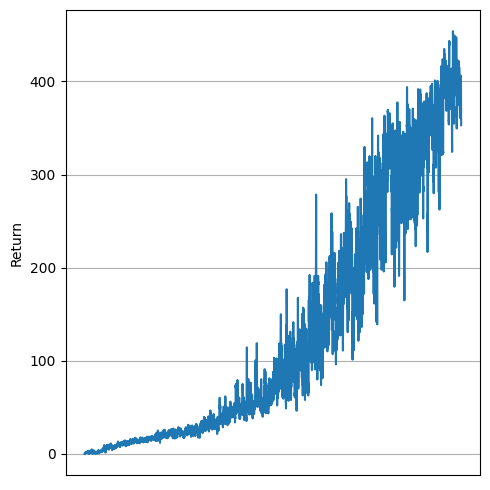

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

mv_return = rl_utils.moving_average(return_list, 9)

axes.plot(mv_return)
axes.set_ylabel("Return")
axes.grid(True)
plt.xticks([])
plt.tight_layout()
plt.show()
# The horizontal axis is not linear with respect to time